# Patch-based 4K Super-Resolution Training with Advanced Memory Debugging

## 📋 概述

本notebook实现了一个**基于patch的超分辨率训练系统**，专门设计用于在有限GPU显存下训练4K超分辨率模型。

### 🎯 目标任务
- **输入**: 256×256 低分辨率图像
- **输出**: 4096×4096 高分辨率图像
- **放大倍数**: 16× (分两阶段: 8× + 2×)

### 🔑 核心特性

#### 1. **Patch-based训练策略**
- 不训练完整的大图像，而是训练小patch
- LR patch: 64×64 → HR patch: 512×512 (8× scale)
- 训练时显存占用极小 (~1-2GB)
- 推理时使用滑动窗口拼接完整图像

#### 2. **显存监控与调试系统** 🔍
- 实时监控GPU显存使用情况
- 自动测试最大可用batch size
- 详细显示每个训练步骤的显存占用
- OOM错误时给出具体优化建议

#### 3. **自适应优化技术**
- **混合精度训练** (FP16): 减少50%显存占用
- **梯度累积**: 模拟更大batch size而不增加显存
- **轻量级模型**: 最小化参数量和计算量
- **自动batch size调整**: 根据GPU自动选择最优配置

#### 4. **兼容性修复**
- ✅ 修复PyTorch版本兼容性问题
- ✅ 支持旧版和新版autocast API
- ✅ 支持旧版和新版GradScaler API

### 📊 显存占用估算

| 组件 | 显存占用 (batch=1) | 显存占用 (batch=4) |
|------|-------------------|-------------------|
| 模型参数 | ~50 MB | ~50 MB |
| 输入LR (64×64) | 0.05 MB | 0.2 MB |
| 输出HR (512×512) | 3 MB | 12 MB |
| 中间激活 | ~200 MB | ~800 MB |
| 梯度 | ~50 MB | ~50 MB |
| 优化器状态 | ~100 MB | ~100 MB |
| **总计** | **~500 MB** | **~1.2 GB** |

### 🚀 训练流程

```
Step 1: 数据准备
  4096×4096 HR图像 → 随机裁剪512×512 patches
  512×512 HR patch → 下采样得到64×64 LR patch

Step 2: 训练8×模型
  输入: 64×64 LR patch
  输出: 512×512 SR patch
  训练patches: 300张图 × 10 patches/图 = 3000 patches

Step 3: 推理 (256×256 → 2048×2048)
  256×256 → 切成4×4=16个64×64 patches
  → 每个通过8×模型得到512×512
  → 拼接成2048×2048

Step 4: 最后放大 (2048×2048 → 4096×4096)
  使用bicubic插值或轻量2×模型
```

### 📈 预期效果

根据类似任务的经验：
- **训练时间**: ~2-4小时 (50 epochs, RTX 3090)
- **PSNR**: 28-32 dB
- **SSIM**: 0.92-0.96
- **显存占用**: <2GB

### ⚙️ 配置说明

可调整的关键参数：

| 参数 | 默认值 | 作用 | 调整建议 |
|------|-------|------|---------|
| `LR_PATCH_SIZE` | 64 | LR patch大小 | 减小→降低显存 |
| `SCALE_FACTOR` | 8 | 放大倍数 | 固定为8 |
| `BATCH_SIZE` | 自动 | batch大小 | 自动测试 |
| `BASE_CHANNELS` | 24 | 模型通道数 | 减小→降低显存 |
| `GRADIENT_ACCUMULATION` | 2 | 梯度累积步数 | 增加→模拟大batch |

---

## 开始使用

按顺序执行以下cells即可开始训练。系统会自动：
1. 检测GPU显存
2. 测试最优batch size
3. 显示详细的显存使用情况
4. 开始训练并保存最佳模型

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import random
from tqdm import tqdm
import gc

## 1. GPU显存监控工具

这些工具函数用于实时监控和调试GPU显存使用情况。

### 功能说明：

1. **print_gpu_memory()**: 打印当前GPU显存状态
   - `已分配`: PyTorch当前使用的显存
   - `保留`: PyTorch从CUDA缓存池中保留的显存
   - `峰值`: 训练过程中的最大显存占用

2. **clear_gpu_memory()**: 清理GPU显存
   - 调用Python垃圾回收
   - 清空CUDA缓存
   - 同步CUDA操作

3. **get_tensor_memory()**: 计算单个tensor的显存占用
   - 用于分析哪些tensor占用显存最多

In [2]:
def print_gpu_memory(tag=""):
    """打印当前GPU显存使用情况"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        max_allocated = torch.cuda.max_memory_allocated() / 1024**3
        print(f"[{tag}] GPU显存: 已分配={allocated:.2f}GB, 保留={reserved:.2f}GB, 峰值={max_allocated:.2f}GB")
        return allocated, reserved, max_allocated
    return 0, 0, 0

def clear_gpu_memory():
    """清理GPU显存"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def get_tensor_memory(tensor):
    """获取tensor占用的显存(MB)"""
    return tensor.element_size() * tensor.nelement() / 1024**2

## 2. 设备配置与初始状态检查

检测可用的GPU设备，并显示初始显存状态。

### 输出信息：
- GPU型号
- 总显存容量
- 当前显存使用情况

这一步会重置显存统计，确保后续的显存测试准确。

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f'总显存: {total_memory:.2f} GB')
    
    # 重置显存统计
    torch.cuda.reset_peak_memory_stats()
    clear_gpu_memory()
    print_gpu_memory("初始状态")

使用设备: cuda
GPU: Quadro RTX 6000
总显存: 22.15 GB


[初始状态] GPU显存: 已分配=0.00GB, 保留=0.00GB, 峰值=0.00GB


## 3. Patch数据集

### Patch-based训练原理

传统的超分辨率训练直接使用完整的大图像，但4K图像(4096×4096)太大，无法放入GPU显存。

**Patch-based方法**通过以下策略解决这个问题：

1. **训练时**: 从大图中随机裁剪小patches
   - 从4096×4096图像中裁剪512×512的HR patch
   - 将HR patch下采样到64×64得到LR patch
   - 每张图可以提取多个patches，增加数据多样性

2. **优势**:
   - 显存占用小（只处理512×512而非4096×4096）
   - 数据增强丰富（每张图产生多个patches）
   - 训练更快（小patch前向/反向传播快）

3. **推理时**: 使用滑动窗口拼接
   - 将大图切成overlapping patches
   - 每个patch独立超分辨率
   - 拼接成完整的大图

### 数据增强

为了提高模型泛化能力，对每个patch应用：
- 随机水平翻转
- 随机垂直翻转  
- 随机旋转90°的倍数

In [4]:
class PatchSRDataset(Dataset):
    """Patch数据集"""
    def __init__(self, hr_dir, lr_patch_size=64, scale_factor=8, 
                 patches_per_image=10, augment=True):
        self.hr_dir = Path(hr_dir)
        self.lr_patch_size = lr_patch_size
        self.hr_patch_size = lr_patch_size * scale_factor
        self.scale_factor = scale_factor
        self.patches_per_image = patches_per_image
        self.augment = augment
        
        self.hr_images = sorted(list(self.hr_dir.glob('*.png')))
        
        print(f"\n数据集配置:")
        print(f"  图像数量: {len(self.hr_images)}")
        print(f"  LR patch: {lr_patch_size}×{lr_patch_size}")
        print(f"  HR patch: {self.hr_patch_size}×{self.hr_patch_size}")
        print(f"  缩放倍数: {scale_factor}×")
        print(f"  总patches: {len(self.hr_images) * patches_per_image}")
    
    def __len__(self):
        return len(self.hr_images) * self.patches_per_image
    
    def augment_patch(self, lr, hr):
        if random.random() > 0.5:
            lr, hr = np.fliplr(lr), np.fliplr(hr)
        if random.random() > 0.5:
            lr, hr = np.flipud(lr), np.flipud(hr)
        k = random.randint(0, 3)
        if k > 0:
            lr, hr = np.rot90(lr, k), np.rot90(hr, k)
        return lr.copy(), hr.copy()
    
    def __getitem__(self, idx):
        img_idx = idx // self.patches_per_image
        
        hr_img = cv2.imread(str(self.hr_images[img_idx]))
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
        
        h, w = hr_img.shape[:2]
        max_y, max_x = h - self.hr_patch_size, w - self.hr_patch_size
        
        if max_y <= 0 or max_x <= 0:
            hr_patch = cv2.resize(hr_img, (self.hr_patch_size, self.hr_patch_size))
        else:
            y, x = random.randint(0, max_y), random.randint(0, max_x)
            hr_patch = hr_img[y:y+self.hr_patch_size, x:x+self.hr_patch_size]
        
        lr_patch = cv2.resize(hr_patch, (self.lr_patch_size, self.lr_patch_size), 
                             interpolation=cv2.INTER_CUBIC)
        
        if self.augment:
            lr_patch, hr_patch = self.augment_patch(lr_patch, hr_patch)
        
        lr_tensor = torch.from_numpy(lr_patch.transpose(2, 0, 1)).float() / 255.0
        hr_tensor = torch.from_numpy(hr_patch.transpose(2, 0, 1)).float() / 255.0
        
        return lr_tensor, hr_tensor

## 4. 轻量级U-Net模型架构

### 模型设计原则

为了在有限显存下训练，我们采用以下设计：

#### 1. **减少通道数** 
- 基础通道数设为24（而非常见的64）
- 最深层通道数为96（而非512）
- 参数量减少约75%

#### 2. **移除BatchNorm**
- BatchNorm需要额外显存存储running stats
- 对于小batch size，BN效果不佳
- 使用残差连接保证训练稳定性

#### 3. **浅层编码器**
- 只下采样2次（64→32→16）
- 避免过小的feature map
- 保留更多空间信息

#### 4. **渐进式上采样**
- 从16×16逐步上采样到512×512
- 使用最近邻插值+卷积（比转置卷积省显存）
- 5次2×上采样达到32×放大（16→512）

### 架构流程

```
输入: 64×64×3

编码器:
  64×64×3 → Conv → 64×64×24
  64×64×24 → DownConv → 32×32×48
  32×32×48 → DownConv → 16×16×96

解码器（8×上采样）:
  16×16×96 → Up → 32×32×48
  32×32×48 → Up → 64×64×24
  64×64×24 → Up → 128×128×24
  128×128×24 → Up → 256×256×24
  256×256×24 → Up → 512×512×24
  512×512×24 → Conv1×1 → 512×512×3

输出: 512×512×3
```

### 参数量估算

- 编码器: ~50K parameters
- 解码器: ~200K parameters
- **总计: ~250K parameters** (相比原版UNet减少95%)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch, ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch, ch, 3, padding=1)
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        return self.relu(x + self.conv(x))


class TinyUNet8x(nn.Module):
    """超轻量8×SR模型 (64×64 → 512×512)
    
    设计：最小化显存占用
    """
    def __init__(self, base_ch=24):  # 减少通道数到24
        super().__init__()
        
        # 编码器 (64 → 32 → 16)
        self.inc = nn.Sequential(
            nn.Conv2d(3, base_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.down1 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResBlock(base_ch*2)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(base_ch*2, base_ch*4, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            ResBlock(base_ch*4)
        )
        
        # 上采样到8× (16 → 32 → 64 → 128 → 256 → 512)
        self.up_blocks = nn.ModuleList([
            self._make_up(base_ch*4, base_ch*2),  # 16→32
            self._make_up(base_ch*2, base_ch),    # 32→64
            self._make_up(base_ch, base_ch),      # 64→128
            self._make_up(base_ch, base_ch),      # 128→256
            self._make_up(base_ch, base_ch),      # 256→512
        ])
        
        self.outc = nn.Conv2d(base_ch, 3, 1)
    
    def _make_up(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.inc(x)
        x = self.down1(x)
        x = self.down2(x)
        
        for up in self.up_blocks:
            x = up(x)
        
        return self.outc(x)

## 5. 训练配置与自适应优化

### 核心配置参数

#### Patch大小
- **LR_PATCH_SIZE**: 64×64 - 低分辨率patch大小
- **HR_PATCH_SIZE**: 512×512 - 高分辨率patch大小  
- **SCALE_FACTOR**: 8× - 本模型的放大倍数

#### 训练超参数
- **BATCH_SIZE**: 自动检测 - 根据GPU显存自动选择
- **GRADIENT_ACCUMULATION**: 2 - 梯度累积步数
  - 有效batch = BATCH_SIZE × GRADIENT_ACCUMULATION
  - 例如: 2 × 2 = 4 (模拟batch=4的效果)
- **LEARNING_RATE**: 1e-4 - 学习率
- **NUM_EPOCHS**: 50 - 训练轮数

#### 模型配置
- **BASE_CHANNELS**: 24 - 基础通道数（越小显存越少）
- **PATCHES_PER_IMAGE**: 10 - 每张图提取的patch数量

### 优化技术详解

#### 1. 梯度累积 (Gradient Accumulation)

**问题**: GPU显存有限，batch size只能设为1或2，训练不稳定

**解决**: 累积多个mini-batch的梯度再更新

```python
for i, (input, target) in enumerate(loader):
    loss = model(input, target) / accumulation_steps
    loss.backward()  # 累积梯度
    
    if (i + 1) % accumulation_steps == 0:
        optimizer.step()  # 更新权重
        optimizer.zero_grad()  # 清空梯度
```

**效果**: batch=2, accumulation=2 ≈ batch=4的训练效果

#### 2. 混合精度训练 (Mixed Precision)

**原理**: 
- FP32: 32位浮点数（高精度，高显存）
- FP16: 16位浮点数（低精度，低显存）
- 混合精度: 大部分操作用FP16，关键操作用FP32

**显存节省**: 约50%

**精度损失**: 几乎没有（<0.1%）

In [6]:
# 基础配置
LR_PATCH_SIZE = 64
SCALE_FACTOR = 8
HR_PATCH_SIZE = LR_PATCH_SIZE * SCALE_FACTOR

# 训练配置（会自动调整）
INITIAL_BATCH_SIZE = 4  # 从小的batch size开始
GRADIENT_ACCUMULATION = 2  # 梯度累积步数
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
PATCHES_PER_IMAGE = 10

BASE_CHANNELS = 24  # 减少基础通道数
USE_MIXED_PRECISION = True
TRAIN_SPLIT = 0.9

HR_DIR = './dataset_4k/high_resolution'
CHECKPOINT_DIR = Path('./checkpoints_debug')
CHECKPOINT_DIR.mkdir(exist_ok=True)

print("\n=== 训练配置 ===")
print(f"Patch: {LR_PATCH_SIZE}×{LR_PATCH_SIZE} → {HR_PATCH_SIZE}×{HR_PATCH_SIZE} ({SCALE_FACTOR}×)")
print(f"初始Batch size: {INITIAL_BATCH_SIZE}")
print(f"梯度累积: {GRADIENT_ACCUMULATION} steps")
print(f"有效Batch size: {INITIAL_BATCH_SIZE * GRADIENT_ACCUMULATION}")
print(f"基础通道数: {BASE_CHANNELS}")
print(f"混合精度: {USE_MIXED_PRECISION}")


=== 训练配置 ===
Patch: 64×64 → 512×512 (8×)
初始Batch size: 4
梯度累积: 2 steps
有效Batch size: 8
基础通道数: 24
混合精度: True


## 6. 显存测试与Batch Size自动检测

### 测试目的

在开始训练前，自动测试不同batch size下的显存占用，找出最大可用batch size。

### 测试流程

```
For batch_size in [1, 2, 4, 8]:
    1. 创建随机输入数据
    2. 前向传播 → 记录显存
    3. 计算损失
    4. 反向传播 → 记录显存
    5. 如果OOM，停止测试
```

### 输出信息

对于每个batch size，显示：
- 输入tensor显存占用
- 输出tensor显存占用  
- 前向传播后的总显存
- 反向传播后的峰值显存
- 是否可用

### 自动选择策略

- 选择能成功运行的最大batch size
- 如果最大batch size较小（1-2），建议使用梯度累积

In [7]:
print("\n=== 显存测试 ===")
print("\n创建模型...")
test_model = TinyUNet8x(base_ch=BASE_CHANNELS).to(device)
total_params = sum(p.numel() for p in test_model.parameters())
print(f"模型参数: {total_params:,}")
print_gpu_memory("模型加载后")

print("\n测试前向传播...")
test_batch_sizes = [1, 2, 4, 8]
max_working_batch = 1

for bs in test_batch_sizes:
    try:
        clear_gpu_memory()
        test_lr = torch.randn(bs, 3, LR_PATCH_SIZE, LR_PATCH_SIZE).to(device)
        test_hr = torch.randn(bs, 3, HR_PATCH_SIZE, HR_PATCH_SIZE).to(device)
        
        print(f"\n测试 batch_size={bs}:")
        print(f"  输入显存: {get_tensor_memory(test_lr):.1f}MB")
        print(f"  目标显存: {get_tensor_memory(test_hr):.1f}MB")
        
        # 测试前向传播
        with autocast(enabled=USE_MIXED_PRECISION):
            out = test_model(test_lr)
            loss = nn.L1Loss()(out, test_hr)
        
        alloc, _, peak = print_gpu_memory(f"前向传播 bs={bs}")
        
        # 测试反向传播
        loss.backward()
        alloc, _, peak = print_gpu_memory(f"反向传播 bs={bs}")
        
        max_working_batch = bs
        print(f"  ✓ batch_size={bs} 可用 (峰值显存: {peak:.2f}GB)")
        
        del test_lr, test_hr, out, loss
        
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"  ✗ batch_size={bs} OOM")
            break
        else:
            raise e

clear_gpu_memory()
del test_model

print(f"\n推荐batch size: {max_working_batch}")
BATCH_SIZE = max_working_batch
print(f"使用batch size: {BATCH_SIZE}")


=== 显存测试 ===

创建模型...


模型参数: 327,915
[模型加载后] GPU显存: 已分配=0.00GB, 保留=0.00GB, 峰值=0.00GB

测试前向传播...



测试 batch_size=1:
  输入显存: 0.0MB
  目标显存: 3.0MB


/tmp/ipykernel_2223134/2396609903.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_MIXED_PRECISION):


[前向传播 bs=1] GPU显存: 已分配=0.04GB, 保留=0.11GB, 峰值=0.08GB


[反向传播 bs=1] GPU显存: 已分配=0.01GB, 保留=0.11GB, 峰值=0.08GB
  ✓ batch_size=1 可用 (峰值显存: 0.08GB)

测试 batch_size=2:
  输入显存: 0.1MB
  目标显存: 6.0MB


[前向传播 bs=2] GPU显存: 已分配=0.08GB, 保留=0.20GB, 峰值=0.17GB


[反向传播 bs=2] GPU显存: 已分配=0.01GB, 保留=0.20GB, 峰值=0.17GB
  ✓ batch_size=2 可用 (峰值显存: 0.17GB)

测试 batch_size=4:
  输入显存: 0.2MB
  目标显存: 12.0MB


[前向传播 bs=4] GPU显存: 已分配=0.16GB, 保留=0.40GB, 峰值=0.33GB


[反向传播 bs=4] GPU显存: 已分配=0.02GB, 保留=0.40GB, 峰值=0.33GB
  ✓ batch_size=4 可用 (峰值显存: 0.33GB)

测试 batch_size=8:
  输入显存: 0.4MB
  目标显存: 24.0MB


[前向传播 bs=8] GPU显存: 已分配=0.32GB, 保留=0.79GB, 峰值=0.66GB


[反向传播 bs=8] GPU显存: 已分配=0.04GB, 保留=0.98GB, 峰值=0.66GB
  ✓ batch_size=8 可用 (峰值显存: 0.66GB)

推荐batch size: 8
使用batch size: 8


## 7. 数据加载与训练/验证集划分

### 数据加载配置

使用PyTorch的DataLoader加载patch数据集，关键配置：

#### DataLoader参数
- **batch_size**: 使用前面自动检测的最大batch size
- **shuffle**: 训练集shuffle=True，打乱顺序增强泛化
- **num_workers**: 设为0（单进程加载）
  - 多进程加载可能增加显存开销
  - 对于小patch，单进程已足够快
- **pin_memory**: True，加速GPU数据传输

#### 训练/验证集划分
- **训练集**: 90%的patches (用于训练模型)
- **验证集**: 10%的patches (用于监控过拟合)

### 数据量计算

假设有300张4K图像，每张提取10个patches：
- 总patches: 300 × 10 = 3000
- 训练patches: 3000 × 0.9 = 2700
- 验证patches: 3000 × 0.1 = 300

如果batch_size=2：
- 训练batches: 2700 / 2 = 1350
- 验证batches: 300 / 2 = 150

In [8]:
dataset = PatchSRDataset(
    hr_dir=HR_DIR,
    lr_patch_size=LR_PATCH_SIZE,
    scale_factor=SCALE_FACTOR,
    patches_per_image=PATCHES_PER_IMAGE,
    augment=True
)

train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=True  # num_workers=0更稳定
)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=True
)

print(f"\n训练集: {train_size} patches, {len(train_loader)} batches")
print(f"验证集: {val_size} patches, {len(val_loader)} batches")


数据集配置:
  图像数量: 300
  LR patch: 64×64
  HR patch: 512×512
  缩放倍数: 8×
  总patches: 3000

训练集: 2700 patches, 338 batches
验证集: 300 patches, 38 batches


## 8. 模型与优化器初始化

### 训练组件

#### 1. 模型 (TinyUNet8x)
- 加载到GPU设备
- 基础通道数: 24
- 总参数量: ~250K

#### 2. 损失函数 (L1Loss)
- 也称为MAE (Mean Absolute Error)
- 比MSE更关注大误差，适合图像超分辨率
- 公式: L = |预测 - 真实| 的平均值

#### 3. 优化器 (Adam)
- 学习率: 1e-4 (0.0001)
- Adam自适应调整每个参数的学习率
- 适合处理稀疏梯度和噪声数据

#### 4. 学习率调度器 (CosineAnnealingLR)
- 余弦退火策略
- 学习率从初始值逐渐降低到接近0
- 前期学习快，后期微调
- 公式: lr = lr_min + (lr_max - lr_min) × (1 + cos(π × epoch / T_max)) / 2

#### 5. 梯度缩放器 (GradScaler)
- 仅在混合精度训练时使用
- 防止FP16下梯度下溢
- 自动缩放loss以保持梯度数值稳定性

### 初始化后显存

模型参数占用约50MB显存。

In [9]:
clear_gpu_memory()
print("\n初始化训练组件...")

model = TinyUNet8x(base_ch=BASE_CHANNELS).to(device)
print_gpu_memory("模型")

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

# 兼容新旧PyTorch版本的GradScaler
if USE_MIXED_PRECISION:
    try:
        # 新版API (PyTorch >= 2.0)
        scaler = torch.amp.GradScaler('cuda')
    except AttributeError:
        # 旧版API (PyTorch < 2.0)
        scaler = GradScaler()
else:
    scaler = None

print(f"模型参数: {sum(p.numel() for p in model.parameters()):,}")


初始化训练组件...
[模型] GPU显存: 已分配=0.00GB, 保留=0.00GB, 峰值=0.66GB


模型参数: 327,915


## 9. 训练与验证函数

### train_epoch() - 训练一个epoch

#### 参数说明
- **grad_accum_steps**: 梯度累积步数
- **verbose_memory**: 是否详细打印显存使用

#### 梯度累积实现

```python
optimizer.zero_grad()  # 初始化梯度为0

for i, (lr, hr) in enumerate(loader):
    loss = criterion(out, hr) / grad_accum_steps  # 除以累积步数
    loss.backward()  # 累积梯度（不立即更新权重）

    # 每grad_accum_steps个batch才更新一次
    if (i + 1) % grad_accum_steps == 0:
        optimizer.step()  # 应用累积的梯度
        optimizer.zero_grad()  # 清空梯度
```

**效果**:
- batch_size=2, grad_accum=2 → 等效于batch_size=4
- 显存占用仍然只是batch_size=2的量

#### 混合精度训练流程

```python
with autocast(enabled=True):  # 自动转换为FP16
    out = model(lr)
    loss = criterion(out, hr)

scaler.scale(loss).backward()  # 缩放loss防止梯度下溢
scaler.step(optimizer)  # 应用缩放后的梯度
scaler.update()  # 更新scaler的缩放因子
```

#### 进度显示
- tqdm进度条显示训练进度
- 实时显示当前loss和GPU显存占用
- 第一个epoch显示详细显存信息（每100个batch）

### validate() - 验证函数

- 使用torch.no_grad()禁用梯度计算
- 节省显存和计算时间
- 返回验证集平均loss

In [10]:
def train_epoch(model, loader, criterion, optimizer, scaler, device, 
                use_amp, grad_accum_steps=1, verbose_memory=False):
    """
    训练一个epoch，带梯度累积和显存监控
    """
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    
    pbar = tqdm(loader, desc='训练')
    for i, (lr, hr) in enumerate(pbar):
        lr, hr = lr.to(device), hr.to(device)
        
        # 前向传播
        if use_amp and scaler:
            with autocast(enabled=True):  # 修复：不使用device_type参数
                out = model(lr)
                loss = criterion(out, hr) / grad_accum_steps
            
            scaler.scale(loss).backward()
            
            # 梯度累积
            if (i + 1) % grad_accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            out = model(lr)
            loss = criterion(out, hr) / grad_accum_steps
            loss.backward()
            
            if (i + 1) % grad_accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        
        running_loss += loss.item() * grad_accum_steps
        
        # 显示显存（每100个batch）
        if verbose_memory and i % 100 == 0:
            alloc, _, peak = print_gpu_memory(f"Batch {i}")
        
        pbar.set_postfix({
            'loss': f'{loss.item() * grad_accum_steps:.4f}',
            'gpu': f'{torch.cuda.memory_allocated()/1024**3:.1f}GB'
        })
    
    return running_loss / len(loader)


def validate(model, loader, criterion, device, use_amp):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for lr, hr in tqdm(loader, desc='验证'):
            lr, hr = lr.to(device), hr.to(device)
            
            if use_amp:
                with autocast(enabled=True):  # 修复
                    out = model(lr)
                    loss = criterion(out, hr)
            else:
                out = model(lr)
                loss = criterion(out, hr)
            
            running_loss += loss.item()
    
    return running_loss / len(loader)

## 10. 主训练循环

### 训练流程

对于每个epoch：

1. **训练阶段**
   - 调用train_epoch()在训练集上训练
   - 第一个epoch显示详细显存信息
   - 返回平均训练损失

2. **验证阶段**
   - 调用validate()在验证集上评估
   - 返回平均验证损失

3. **学习率调整**
   - scheduler.step()应用余弦退火

4. **模型保存策略**
   - **最佳模型**: 验证损失最低时保存为`best_model.pth`
     - 包含模型权重、优化器状态、配置信息
   - **定期检查点**: 每10个epoch保存为`epoch_N.pth`
     - 便于恢复训练或分析不同阶段的模型

5. **显存管理**
   - 每5个epoch清理一次GPU缓存
   - 每个epoch结束打印显存统计

### OOM错误处理

如果训练中出现OOM错误，自动显示：
- 当前显存使用情况
- 优化建议：
  1. 减小batch size
  2. 增加梯度累积步数
  3. 减小模型通道数
  4. 减小patch size

### 输出信息

每个epoch显示：
- 训练损失和验证损失
- 当前学习率
- 显存使用情况
- 模型保存状态

In [11]:
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print("\n" + "="*60)
print("开始训练")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # 第一个epoch显示详细显存
    verbose = (epoch == 0)
    
    try:
        train_loss = train_epoch(
            model, train_loader, criterion, optimizer, scaler, device,
            USE_MIXED_PRECISION, GRADIENT_ACCUMULATION, verbose_memory=verbose
        )
        
        val_loss = validate(model, val_loader, criterion, device, USE_MIXED_PRECISION)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        scheduler.step()
        
        print(f"\n训练损失: {train_loss:.6f}")
        print(f"验证损失: {val_loss:.6f}")
        print(f"学习率: {scheduler.get_last_lr()[0]:.6f}")
        print_gpu_memory(f"Epoch {epoch+1} 结束")
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'config': {
                    'lr_patch': LR_PATCH_SIZE,
                    'hr_patch': HR_PATCH_SIZE,
                    'scale': SCALE_FACTOR,
                    'base_ch': BASE_CHANNELS
                }
            }, CHECKPOINT_DIR / 'best_model.pth')
            print(f"✓ 保存最佳模型")
        
        # 定期保存
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), CHECKPOINT_DIR / f'epoch_{epoch+1}.pth')
            print(f"✓ 保存检查点")
        
        # 清理显存
        if (epoch + 1) % 5 == 0:
            clear_gpu_memory()
    
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"\n!!! OOM错误 !!!")
            print_gpu_memory("OOM时")
            print("\n建议:")
            print(f"  1. 减小batch size (当前: {BATCH_SIZE})")
            print(f"  2. 增加梯度累积 (当前: {GRADIENT_ACCUMULATION})")
            print(f"  3. 减小BASE_CHANNELS (当前: {BASE_CHANNELS})")
            print(f"  4. 减小patch size (当前: {LR_PATCH_SIZE}→{HR_PATCH_SIZE})")
            raise e
        else:
            raise e

print(f"\n训练完成！最佳验证损失: {best_val_loss:.6f}")


开始训练

Epoch 1/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

/tmp/ipykernel_2223134/105892763.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):  # 修复：不使用device_type参数
训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.1259, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<12:49,  2.28s/it, loss=0.1259, gpu=0.0GB]

[Batch 0] GPU显存: 已分配=0.04GB, 保留=0.98GB, 峰值=0.66GB


训练:   0%|▏                                                           | 1/338 [00:04<12:49,  2.28s/it, loss=0.3257, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<12:52,  2.30s/it, loss=0.3257, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<12:52,  2.30s/it, loss=0.2481, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<12:23,  2.22s/it, loss=0.2481, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<12:23,  2.22s/it, loss=0.1540, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:33,  2.08s/it, loss=0.1540, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<11:33,  2.08s/it, loss=0.1996, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:56,  1.97s/it, loss=0.1996, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:12<10:56,  1.97s/it, loss=0.1916, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:33,  1.91s/it, loss=0.1916, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:14<10:33,  1.91s/it, loss=0.1604, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:45,  1.95s/it, loss=0.1604, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:45,  1.95s/it, loss=0.1406, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:26,  1.90s/it, loss=0.1406, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:26,  1.90s/it, loss=0.2390, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:13,  1.86s/it, loss=0.2390, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:13,  1.86s/it, loss=0.2383, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:04,  1.84s/it, loss=0.2383, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:04,  1.84s/it, loss=0.2073, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:30,  1.93s/it, loss=0.2073, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:30,  1.93s/it, loss=0.1814, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:27,  1.92s/it, loss=0.1814, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:27,  1.92s/it, loss=0.1686, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:13,  1.89s/it, loss=0.1686, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:13,  1.89s/it, loss=0.2423, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:01,  1.86s/it, loss=0.2423, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:01,  1.86s/it, loss=0.3116, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:52,  1.83s/it, loss=0.3116, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<09:52,  1.83s/it, loss=0.1505, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:47,  1.83s/it, loss=0.1505, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<09:47,  1.83s/it, loss=0.1599, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:05,  1.89s/it, loss=0.1599, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:05,  1.89s/it, loss=0.1434, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:55,  1.86s/it, loss=0.1434, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<09:55,  1.86s/it, loss=0.3432, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:59,  1.88s/it, loss=0.3432, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:59,  1.88s/it, loss=0.1563, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:42,  2.02s/it, loss=0.1563, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:41<10:42,  2.02s/it, loss=0.2182, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:56,  2.07s/it, loss=0.2182, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:56,  2.07s/it, loss=0.2032, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:26,  1.98s/it, loss=0.2032, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:26,  1.98s/it, loss=0.2073, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:04,  1.92s/it, loss=0.2073, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<10:04,  1.92s/it, loss=0.3266, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:57,  1.90s/it, loss=0.3266, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<09:57,  1.90s/it, loss=0.1988, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:45,  1.87s/it, loss=0.1988, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<09:45,  1.87s/it, loss=0.1793, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:36,  1.85s/it, loss=0.1793, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:36,  1.85s/it, loss=0.2119, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:28,  1.83s/it, loss=0.2119, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:28,  1.83s/it, loss=0.2308, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:22,  1.81s/it, loss=0.2308, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:22,  1.81s/it, loss=0.1873, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:24,  1.83s/it, loss=0.1873, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<09:24,  1.83s/it, loss=0.1498, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:57,  1.94s/it, loss=0.1498, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:57,  1.94s/it, loss=0.2367, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:41,  1.90s/it, loss=0.2367, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:41,  1.90s/it, loss=0.2027, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:30,  1.87s/it, loss=0.2027, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:30,  1.87s/it, loss=0.1429, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:21,  1.84s/it, loss=0.1429, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:21,  1.84s/it, loss=0.1257, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:13,  1.82s/it, loss=0.1257, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:13,  1.82s/it, loss=0.2343, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:08,  1.81s/it, loss=0.2343, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:08,  1.81s/it, loss=0.2393, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:04,  1.80s/it, loss=0.2393, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:04,  1.80s/it, loss=0.2332, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:00,  1.80s/it, loss=0.2332, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:00,  1.80s/it, loss=0.1229, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:58,  1.80s/it, loss=0.1229, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<08:58,  1.80s/it, loss=0.1855, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<08:56,  1.80s/it, loss=0.1855, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<08:56,  1.80s/it, loss=0.1855, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:54,  1.79s/it, loss=0.1855, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<08:54,  1.79s/it, loss=0.1669, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:57,  1.81s/it, loss=0.1669, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:57,  1.81s/it, loss=0.1047, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:37,  1.95s/it, loss=0.1047, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:37,  1.95s/it, loss=0.1953, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:43,  1.98s/it, loss=0.1953, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:43,  1.98s/it, loss=0.2480, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:23,  1.92s/it, loss=0.2480, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:23,  1.92s/it, loss=0.2131, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:10,  1.88s/it, loss=0.2131, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:10,  1.88s/it, loss=0.0970, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:00,  1.85s/it, loss=0.0970, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:00,  1.85s/it, loss=0.1727, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:52,  1.83s/it, loss=0.1727, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:52,  1.83s/it, loss=0.1716, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:47,  1.82s/it, loss=0.1716, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:47,  1.82s/it, loss=0.1026, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:42,  1.81s/it, loss=0.1026, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:42,  1.81s/it, loss=0.1711, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:38,  1.80s/it, loss=0.1711, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:38,  1.80s/it, loss=0.1339, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:34,  1.79s/it, loss=0.1339, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:34,  1.79s/it, loss=0.1719, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:36,  1.81s/it, loss=0.1719, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:36,  1.81s/it, loss=0.2614, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:10,  1.93s/it, loss=0.2614, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:10,  1.93s/it, loss=0.1409, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:55,  1.89s/it, loss=0.1409, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:55,  1.89s/it, loss=0.2199, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:46,  1.86s/it, loss=0.2199, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:46,  1.86s/it, loss=0.0842, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:37,  1.83s/it, loss=0.0842, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:37,  1.83s/it, loss=0.1936, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:31,  1.82s/it, loss=0.1936, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:31,  1.82s/it, loss=0.1499, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:26,  1.81s/it, loss=0.1499, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:26,  1.81s/it, loss=0.2637, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:23,  1.80s/it, loss=0.2637, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:23,  1.80s/it, loss=0.2049, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<09:02,  1.95s/it, loss=0.2049, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<09:02,  1.95s/it, loss=0.0770, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:28,  2.05s/it, loss=0.0770, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:28,  2.05s/it, loss=0.1473, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<09:06,  1.98s/it, loss=0.1473, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<09:06,  1.98s/it, loss=0.1411, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:48,  1.92s/it, loss=0.1411, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:48,  1.92s/it, loss=0.1528, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:36,  1.89s/it, loss=0.1528, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:36,  1.89s/it, loss=0.2681, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:53,  1.96s/it, loss=0.2681, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:53,  1.96s/it, loss=0.2220, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<09:25,  2.08s/it, loss=0.2220, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<09:25,  2.08s/it, loss=0.1203, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<09:01,  2.00s/it, loss=0.1203, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<09:01,  2.00s/it, loss=0.2392, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:41,  1.93s/it, loss=0.2392, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:41,  1.93s/it, loss=0.1366, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:27,  1.89s/it, loss=0.1366, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:27,  1.89s/it, loss=0.2309, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:54,  1.99s/it, loss=0.2309, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:54,  1.99s/it, loss=0.1488, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:36,  1.94s/it, loss=0.1488, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:36,  1.94s/it, loss=0.2146, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:22,  1.89s/it, loss=0.2146, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:22,  1.89s/it, loss=0.1205, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:27,  1.91s/it, loss=0.1205, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:27,  1.91s/it, loss=0.1422, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:17,  1.89s/it, loss=0.1422, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:17,  1.89s/it, loss=0.1430, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:38,  1.97s/it, loss=0.1430, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:38,  1.97s/it, loss=0.1390, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:22,  1.92s/it, loss=0.1390, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:22,  1.92s/it, loss=0.1595, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:09,  1.87s/it, loss=0.1595, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:09,  1.87s/it, loss=0.1850, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:00,  1.85s/it, loss=0.1850, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<08:00,  1.85s/it, loss=0.1411, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<07:53,  1.83s/it, loss=0.1411, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<07:53,  1.83s/it, loss=0.1483, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:49,  1.82s/it, loss=0.1483, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<07:49,  1.82s/it, loss=0.2518, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:44,  1.81s/it, loss=0.2518, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:44,  1.81s/it, loss=0.1641, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:40,  1.80s/it, loss=0.1641, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:40,  1.80s/it, loss=0.0648, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:36,  1.79s/it, loss=0.0648, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:36,  1.79s/it, loss=0.0506, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:33,  1.79s/it, loss=0.0506, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:33,  1.79s/it, loss=0.1480, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:31,  1.79s/it, loss=0.1480, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<07:31,  1.79s/it, loss=0.1003, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:29,  1.78s/it, loss=0.1003, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:29,  1.78s/it, loss=0.0971, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:27,  1.78s/it, loss=0.0971, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:27,  1.78s/it, loss=0.2837, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:25,  1.78s/it, loss=0.2837, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:25,  1.78s/it, loss=0.2405, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:23,  1.78s/it, loss=0.2405, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:23,  1.78s/it, loss=0.1068, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:21,  1.78s/it, loss=0.1068, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:21,  1.78s/it, loss=0.0930, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:41,  1.87s/it, loss=0.0930, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:41,  1.87s/it, loss=0.1512, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:32,  1.84s/it, loss=0.1512, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:32,  1.84s/it, loss=0.0670, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:30,  1.84s/it, loss=0.0670, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:30,  1.84s/it, loss=0.1382, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:24,  1.82s/it, loss=0.1382, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:24,  1.82s/it, loss=0.1252, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:19,  1.81s/it, loss=0.1252, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:19,  1.81s/it, loss=0.1960, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:33,  1.87s/it, loss=0.1960, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:33,  1.87s/it, loss=0.0612, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:56,  1.98s/it, loss=0.0612, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:56,  1.98s/it, loss=0.0998, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:42,  1.93s/it, loss=0.0998, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:42,  1.93s/it, loss=0.1352, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:29,  1.88s/it, loss=0.1352, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:29,  1.88s/it, loss=0.1257, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:21,  1.85s/it, loss=0.1257, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:21,  1.85s/it, loss=0.1145, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:16,  1.84s/it, loss=0.1145, gpu=0.0GB]

[Batch 100] GPU显存: 已分配=0.04GB, 保留=0.98GB, 峰值=0.67GB


训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:16,  1.84s/it, loss=0.1437, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:28,  1.90s/it, loss=0.1437, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:28,  1.90s/it, loss=0.2537, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:17,  1.86s/it, loss=0.2537, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:17,  1.86s/it, loss=0.2365, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:10,  1.84s/it, loss=0.2365, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<07:10,  1.84s/it, loss=0.1219, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:05,  1.82s/it, loss=0.1219, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:05,  1.82s/it, loss=0.0216, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<07:00,  1.81s/it, loss=0.0216, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:00,  1.81s/it, loss=0.1772, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<06:56,  1.80s/it, loss=0.1772, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:56,  1.80s/it, loss=0.1085, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:54,  1.80s/it, loss=0.1085, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:54,  1.80s/it, loss=0.0992, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<07:03,  1.85s/it, loss=0.0992, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:03,  1.85s/it, loss=0.1306, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<07:02,  1.85s/it, loss=0.1306, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:02,  1.85s/it, loss=0.2480, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:55,  1.83s/it, loss=0.2480, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<06:55,  1.83s/it, loss=0.1641, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<06:50,  1.82s/it, loss=0.1641, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<06:50,  1.82s/it, loss=0.1981, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:46,  1.81s/it, loss=0.1981, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<06:46,  1.81s/it, loss=0.0580, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:43,  1.80s/it, loss=0.0580, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<06:43,  1.80s/it, loss=0.0479, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:41,  1.80s/it, loss=0.0479, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:41,  1.80s/it, loss=0.1585, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:38,  1.80s/it, loss=0.1585, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:38,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:36,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:36,  1.80s/it, loss=0.1887, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:34,  1.80s/it, loss=0.1887, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:34,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:33,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:33,  1.80s/it, loss=0.0926, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:54,  1.90s/it, loss=0.0926, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:54,  1.90s/it, loss=0.0786, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<07:16,  2.01s/it, loss=0.0786, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<07:16,  2.01s/it, loss=0.2735, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<07:08,  1.98s/it, loss=0.2735, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<07:08,  1.98s/it, loss=0.0465, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<07:21,  2.05s/it, loss=0.0465, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<07:21,  2.05s/it, loss=0.0738, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<07:02,  1.97s/it, loss=0.0738, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<07:02,  1.97s/it, loss=0.2498, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:47,  1.91s/it, loss=0.2498, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:47,  1.91s/it, loss=0.1284, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:36,  1.87s/it, loss=0.1284, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:36,  1.87s/it, loss=0.1035, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:27,  1.84s/it, loss=0.1035, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:27,  1.84s/it, loss=0.2746, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:21,  1.82s/it, loss=0.2746, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:21,  1.82s/it, loss=0.1966, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:16,  1.80s/it, loss=0.1966, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:16,  1.80s/it, loss=0.1944, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:12,  1.79s/it, loss=0.1944, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:12,  1.79s/it, loss=0.1596, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:10,  1.79s/it, loss=0.1596, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:10,  1.79s/it, loss=0.0753, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:08,  1.79s/it, loss=0.0753, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:08,  1.79s/it, loss=0.1624, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:06,  1.79s/it, loss=0.1624, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:06,  1.79s/it, loss=0.0959, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:03,  1.78s/it, loss=0.0959, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:03,  1.78s/it, loss=0.0991, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:02,  1.79s/it, loss=0.0991, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:02,  1.79s/it, loss=0.0785, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:00,  1.79s/it, loss=0.0785, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:00,  1.79s/it, loss=0.2042, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<05:58,  1.78s/it, loss=0.2042, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<05:58,  1.78s/it, loss=0.1899, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<05:56,  1.78s/it, loss=0.1899, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<05:56,  1.78s/it, loss=0.2752, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<05:54,  1.78s/it, loss=0.2752, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<05:54,  1.78s/it, loss=0.1670, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:21<05:52,  1.78s/it, loss=0.1670, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<05:52,  1.78s/it, loss=0.2156, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<05:49,  1.77s/it, loss=0.2156, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<05:49,  1.77s/it, loss=0.1398, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<05:47,  1.77s/it, loss=0.1398, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:47,  1.77s/it, loss=0.1333, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<05:45,  1.77s/it, loss=0.1333, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<05:45,  1.77s/it, loss=0.1491, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:28<05:43,  1.77s/it, loss=0.1491, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<05:43,  1.77s/it, loss=0.0765, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:30<05:42,  1.78s/it, loss=0.0765, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:42,  1.78s/it, loss=0.0584, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<05:41,  1.78s/it, loss=0.0584, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:41,  1.78s/it, loss=0.0643, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:33<05:39,  1.78s/it, loss=0.0643, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:39,  1.78s/it, loss=0.1045, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:35<05:37,  1.78s/it, loss=0.1045, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:37,  1.78s/it, loss=0.0946, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:37<05:36,  1.78s/it, loss=0.0946, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:36,  1.78s/it, loss=0.0323, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:39<06:01,  1.92s/it, loss=0.0323, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<06:01,  1.92s/it, loss=0.1476, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<06:37,  2.13s/it, loss=0.1476, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<06:37,  2.13s/it, loss=0.1313, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:43<06:21,  2.05s/it, loss=0.1313, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<06:21,  2.05s/it, loss=0.2118, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:45<06:04,  1.97s/it, loss=0.2118, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<06:04,  1.97s/it, loss=0.0781, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:52,  1.92s/it, loss=0.0781, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:52,  1.92s/it, loss=0.1047, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:43,  1.88s/it, loss=0.1047, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:43,  1.88s/it, loss=0.0679, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:36,  1.85s/it, loss=0.0679, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:36,  1.85s/it, loss=0.1292, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:39,  1.88s/it, loss=0.1292, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:39,  1.88s/it, loss=0.1987, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:54<05:32,  1.85s/it, loss=0.1987, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:32,  1.85s/it, loss=0.0139, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:56<05:27,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:27,  1.83s/it, loss=0.0593, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<05:23,  1.82s/it, loss=0.0593, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:23,  1.82s/it, loss=0.1175, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:00<05:19,  1.80s/it, loss=0.1175, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:19,  1.80s/it, loss=0.2293, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:02<05:56,  2.02s/it, loss=0.2293, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:56,  2.02s/it, loss=0.2332, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:04<06:08,  2.11s/it, loss=0.2332, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<06:08,  2.11s/it, loss=0.1021, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:49,  2.01s/it, loss=0.1021, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:49,  2.01s/it, loss=0.0545, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:39,  1.96s/it, loss=0.0545, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:39,  1.96s/it, loss=0.0844, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:32,  1.93s/it, loss=0.0844, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:32,  1.93s/it, loss=0.1399, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:43,  2.01s/it, loss=0.1399, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:43,  2.01s/it, loss=0.1518, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:34,  1.97s/it, loss=0.1518, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:34,  1.97s/it, loss=0.0364, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:42,  2.03s/it, loss=0.0364, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:42,  2.03s/it, loss=0.0406, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:28,  1.95s/it, loss=0.0406, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:28,  1.95s/it, loss=0.0444, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:21,  1.93s/it, loss=0.0444, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<05:21,  1.93s/it, loss=0.1167, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:22<05:25,  1.96s/it, loss=0.1167, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:25,  1.96s/it, loss=0.0873, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<05:16,  1.92s/it, loss=0.0873, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:16,  1.92s/it, loss=0.1173, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<05:08,  1.88s/it, loss=0.1173, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<05:08,  1.88s/it, loss=0.0314, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<05:01,  1.85s/it, loss=0.0314, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:01,  1.85s/it, loss=0.1099, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:56,  1.83s/it, loss=0.1099, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:56,  1.83s/it, loss=0.0684, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<04:52,  1.82s/it, loss=0.0684, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:52,  1.82s/it, loss=0.0864, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<04:49,  1.81s/it, loss=0.0864, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<04:49,  1.81s/it, loss=0.0921, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<05:10,  1.95s/it, loss=0.0921, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<05:10,  1.95s/it, loss=0.0898, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<05:00,  1.90s/it, loss=0.0898, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<05:00,  1.90s/it, loss=0.1529, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<04:53,  1.87s/it, loss=0.1529, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:53,  1.87s/it, loss=0.0931, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:47,  1.84s/it, loss=0.0931, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<04:47,  1.84s/it, loss=0.0417, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<04:43,  1.83s/it, loss=0.0417, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:43,  1.83s/it, loss=0.1535, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<05:06,  1.99s/it, loss=0.1535, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<05:06,  1.99s/it, loss=0.0709, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<05:14,  2.05s/it, loss=0.0709, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<05:14,  2.05s/it, loss=0.0705, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<05:21,  2.11s/it, loss=0.0705, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<05:21,  2.11s/it, loss=0.0839, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:51<05:05,  2.02s/it, loss=0.0839, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<05:05,  2.02s/it, loss=0.1265, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:52,  1.95s/it, loss=0.1265, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:52,  1.95s/it, loss=0.1475, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:51,  1.96s/it, loss=0.1475, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:51,  1.96s/it, loss=0.1599, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:42,  1.91s/it, loss=0.1599, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:42,  1.91s/it, loss=0.2124, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:34,  1.87s/it, loss=0.2124, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:00<04:34,  1.87s/it, loss=0.0955, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:29,  1.84s/it, loss=0.0955, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<04:29,  1.84s/it, loss=0.2223, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:02<04:24,  1.83s/it, loss=0.2223, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:24,  1.83s/it, loss=0.0693, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:24,  1.83s/it, loss=0.0693, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:24,  1.83s/it, loss=0.0618, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:41,  1.97s/it, loss=0.0618, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:41,  1.97s/it, loss=0.0898, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:33,  1.93s/it, loss=0.0898, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:33,  1.93s/it, loss=0.2480, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:55,  2.10s/it, loss=0.2480, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:55,  2.10s/it, loss=0.1881, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:59,  2.14s/it, loss=0.1881, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:59,  2.14s/it, loss=0.0241, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:14<04:43,  2.04s/it, loss=0.0241, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:43,  2.04s/it, loss=0.2844, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:30,  1.96s/it, loss=0.2844, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:30,  1.96s/it, loss=0.0728, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:20,  1.90s/it, loss=0.0728, gpu=0.0GB]

[Batch 200] GPU显存: 已分配=0.04GB, 保留=0.98GB, 峰值=0.67GB


训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:20,  1.90s/it, loss=0.1467, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:13,  1.87s/it, loss=0.1467, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:13,  1.87s/it, loss=0.1154, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:12,  1.87s/it, loss=0.1154, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:12,  1.87s/it, loss=0.0834, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:24,  1.98s/it, loss=0.0834, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:24,  1.98s/it, loss=0.1265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:15,  1.92s/it, loss=0.1265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:15,  1.92s/it, loss=0.0114, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:28<04:25,  2.01s/it, loss=0.0114, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:25,  2.01s/it, loss=0.0142, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<04:18,  1.98s/it, loss=0.0142, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:18,  1.98s/it, loss=0.1927, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:31<04:10,  1.93s/it, loss=0.1927, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<04:10,  1.93s/it, loss=0.0799, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:33<04:03,  1.89s/it, loss=0.0799, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<04:03,  1.89s/it, loss=0.0631, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:35<03:57,  1.86s/it, loss=0.0631, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<03:57,  1.86s/it, loss=0.0868, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:37<04:10,  1.97s/it, loss=0.0868, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<04:10,  1.97s/it, loss=0.1044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:39<04:19,  2.06s/it, loss=0.1044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<04:19,  2.06s/it, loss=0.1280, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<04:08,  1.98s/it, loss=0.1280, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<04:08,  1.98s/it, loss=0.0328, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<04:05,  1.98s/it, loss=0.0328, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<04:05,  1.98s/it, loss=0.0864, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<03:57,  1.93s/it, loss=0.0864, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:57,  1.93s/it, loss=0.0862, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:49,  1.88s/it, loss=0.0862, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:49,  1.88s/it, loss=0.0831, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:44,  1.85s/it, loss=0.0831, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:44,  1.85s/it, loss=0.0199, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:50<03:40,  1.83s/it, loss=0.0199, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:40,  1.83s/it, loss=0.1186, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:36,  1.82s/it, loss=0.1186, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:36,  1.82s/it, loss=0.0372, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:33,  1.81s/it, loss=0.0372, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:33,  1.81s/it, loss=0.1294, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:30,  1.80s/it, loss=0.1294, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:30,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:57<03:28,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:28,  1.80s/it, loss=0.0678, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:26,  1.79s/it, loss=0.0678, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:26,  1.79s/it, loss=0.0950, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:01<03:30,  1.84s/it, loss=0.0950, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:30,  1.84s/it, loss=0.0394, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:51,  2.05s/it, loss=0.0394, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:51,  2.05s/it, loss=0.0537, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:55,  2.10s/it, loss=0.0537, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:55,  2.10s/it, loss=0.0543, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:43,  2.01s/it, loss=0.0543, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:10<03:43,  2.01s/it, loss=0.0549, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:33,  1.94s/it, loss=0.0549, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:33,  1.94s/it, loss=0.0913, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:11<03:26,  1.90s/it, loss=0.0913, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:26,  1.90s/it, loss=0.0602, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:21,  1.87s/it, loss=0.0602, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:21,  1.87s/it, loss=0.0736, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:15<03:17,  1.84s/it, loss=0.0736, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:17,  1.84s/it, loss=0.0697, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:13,  1.83s/it, loss=0.0697, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:13,  1.83s/it, loss=0.0425, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:10,  1.82s/it, loss=0.0425, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:10,  1.82s/it, loss=0.0298, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:12,  1.85s/it, loss=0.0298, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:12,  1.85s/it, loss=0.0678, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:22<03:09,  1.84s/it, loss=0.0678, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:09,  1.84s/it, loss=0.0708, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:08,  1.85s/it, loss=0.0708, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:08,  1.85s/it, loss=0.0181, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:06,  1.85s/it, loss=0.0181, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:06,  1.85s/it, loss=0.0226, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:03,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:03,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<02:59,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:31<02:59,  1.82s/it, loss=0.0827, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:31<02:57,  1.81s/it, loss=0.0827, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<02:57,  1.81s/it, loss=0.0782, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:33<02:54,  1.80s/it, loss=0.0782, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:35<02:54,  1.80s/it, loss=0.0373, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:35<02:52,  1.80s/it, loss=0.0373, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:37<02:52,  1.80s/it, loss=0.0530, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:37<02:50,  1.80s/it, loss=0.0530, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<02:50,  1.80s/it, loss=0.0451, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<02:48,  1.80s/it, loss=0.0451, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<02:48,  1.80s/it, loss=0.0625, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:40<02:50,  1.84s/it, loss=0.0625, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:50,  1.84s/it, loss=0.0927, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<02:48,  1.83s/it, loss=0.0927, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:48,  1.83s/it, loss=0.0266, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:44<02:45,  1.82s/it, loss=0.0266, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<02:45,  1.82s/it, loss=0.0132, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:44,  1.83s/it, loss=0.0132, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<02:44,  1.83s/it, loss=0.0513, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:43,  1.84s/it, loss=0.0513, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:50<02:43,  1.84s/it, loss=0.0407, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:50<02:44,  1.87s/it, loss=0.0407, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:52<02:44,  1.87s/it, loss=0.0348, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:52<02:41,  1.86s/it, loss=0.0348, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:41,  1.86s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:53<02:38,  1.84s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:38,  1.84s/it, loss=0.0457, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:34,  1.82s/it, loss=0.0457, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:57<02:34,  1.82s/it, loss=0.0546, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:32,  1.81s/it, loss=0.0546, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:32,  1.81s/it, loss=0.0461, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:30,  1.81s/it, loss=0.0461, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:00<02:30,  1.81s/it, loss=0.0482, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:00<02:27,  1.80s/it, loss=0.0482, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:02<02:27,  1.80s/it, loss=0.0350, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:25,  1.80s/it, loss=0.0350, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<02:25,  1.80s/it, loss=0.0619, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:23,  1.80s/it, loss=0.0619, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:06<02:23,  1.80s/it, loss=0.0467, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:23,  1.81s/it, loss=0.0467, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:08<02:23,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:30,  1.93s/it, loss=0.0210, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:30,  1.93s/it, loss=0.0705, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:25,  1.89s/it, loss=0.0705, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:25,  1.89s/it, loss=0.0959, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:21,  1.86s/it, loss=0.0959, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:13<02:21,  1.86s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:13<02:18,  1.84s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:15<02:18,  1.84s/it, loss=0.0345, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:15<02:15,  1.84s/it, loss=0.0345, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:17<02:15,  1.84s/it, loss=0.0333, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:17<02:13,  1.83s/it, loss=0.0333, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:19<02:13,  1.83s/it, loss=0.0434, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:19<02:14,  1.86s/it, loss=0.0434, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:21<02:14,  1.86s/it, loss=0.0775, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:21<02:22,  2.01s/it, loss=0.0775, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:22,  2.01s/it, loss=0.0450, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:24<02:24,  2.07s/it, loss=0.0450, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:24,  2.07s/it, loss=0.0188, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:16,  1.99s/it, loss=0.0188, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:16,  1.99s/it, loss=0.0445, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:28<02:18,  2.04s/it, loss=0.0445, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:30<02:18,  2.04s/it, loss=0.0320, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:30<02:14,  2.01s/it, loss=0.0320, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:14,  2.01s/it, loss=0.0539, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<02:09,  1.96s/it, loss=0.0539, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:33<02:09,  1.96s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<02:06,  1.95s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:35<02:06,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:35<02:03,  1.93s/it, loss=0.0226, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:37<02:03,  1.93s/it, loss=0.0687, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:37<01:58,  1.89s/it, loss=0.0687, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:58,  1.89s/it, loss=0.0638, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<02:09,  2.10s/it, loss=0.0638, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<02:09,  2.10s/it, loss=0.0226, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<02:09,  2.12s/it, loss=0.0226, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<02:09,  2.12s/it, loss=0.0515, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:43<02:01,  2.02s/it, loss=0.0515, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<02:01,  2.02s/it, loss=0.0197, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:54,  1.94s/it, loss=0.0197, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:54,  1.94s/it, loss=0.0321, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:49,  1.89s/it, loss=0.0321, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:49,  1.89s/it, loss=0.0648, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:52,  1.98s/it, loss=0.0648, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:52,  1.98s/it, loss=0.0366, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:55,  2.07s/it, loss=0.0366, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:55,  2.07s/it, loss=0.0352, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:54<01:56,  2.12s/it, loss=0.0352, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:56,  2.12s/it, loss=0.0228, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:49,  2.02s/it, loss=0.0228, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:57<01:49,  2.02s/it, loss=0.0138, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:57<01:43,  1.95s/it, loss=0.0138, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:43,  1.95s/it, loss=0.0231, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:38,  1.90s/it, loss=0.0231, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:38,  1.90s/it, loss=0.0452, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:35,  1.86s/it, loss=0.0452, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:35,  1.86s/it, loss=0.0381, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:03<01:32,  1.84s/it, loss=0.0381, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:04<01:32,  1.84s/it, loss=0.0259, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:29,  1.83s/it, loss=0.0259, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:06<01:29,  1.83s/it, loss=0.0512, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:27,  1.82s/it, loss=0.0512, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:27,  1.82s/it, loss=0.0926, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:24,  1.81s/it, loss=0.0926, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:24,  1.81s/it, loss=0.0576, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:22,  1.80s/it, loss=0.0576, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:22,  1.80s/it, loss=0.0331, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:20,  1.80s/it, loss=0.0331, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:20,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:19,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:19,  1.80s/it, loss=0.0361, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:19,  1.85s/it, loss=0.0361, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:19,  1.85s/it, loss=0.0407, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:17,  1.83s/it, loss=0.0407, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:20<01:17,  1.83s/it, loss=0.0679, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:20<01:23,  2.04s/it, loss=0.0679, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:22<01:23,  2.04s/it, loss=0.0372, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:22<01:24,  2.10s/it, loss=0.0372, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:24<01:24,  2.10s/it, loss=0.0606, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:24<01:24,  2.17s/it, loss=0.0606, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:24,  2.17s/it, loss=0.0608, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:24,  2.22s/it, loss=0.0608, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:24,  2.22s/it, loss=0.0186, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:19,  2.15s/it, loss=0.0186, gpu=0.0GB]

[Batch 300] GPU显存: 已分配=0.04GB, 保留=0.98GB, 峰值=0.67GB


训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:19,  2.15s/it, loss=0.0263, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:18,  2.17s/it, loss=0.0263, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:18,  2.17s/it, loss=0.0852, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:12,  2.06s/it, loss=0.0852, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:12,  2.06s/it, loss=0.0364, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:07,  1.98s/it, loss=0.0364, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:07,  1.98s/it, loss=0.0324, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:03,  1.92s/it, loss=0.0324, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:03,  1.92s/it, loss=0.0410, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<01:03,  2.00s/it, loss=0.0410, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<01:03,  2.00s/it, loss=0.0333, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<01:04,  2.06s/it, loss=0.0333, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<01:04,  2.06s/it, loss=0.0396, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:42<00:59,  1.98s/it, loss=0.0396, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:59,  1.98s/it, loss=0.0292, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:44<00:55,  1.92s/it, loss=0.0292, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:55,  1.92s/it, loss=0.0448, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:46<00:52,  1.87s/it, loss=0.0448, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:52,  1.87s/it, loss=0.0490, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:48<00:49,  1.85s/it, loss=0.0490, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:49,  1.85s/it, loss=0.0465, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:50<00:48,  1.87s/it, loss=0.0465, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:48,  1.87s/it, loss=0.0374, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:52<00:46,  1.88s/it, loss=0.0374, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:46,  1.88s/it, loss=0.0543, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:45,  1.90s/it, loss=0.0543, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:45,  1.90s/it, loss=0.0145, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:44,  1.92s/it, loss=0.0145, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:44,  1.92s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:57<00:41,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:41,  1.87s/it, loss=0.0802, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:59<00:38,  1.84s/it, loss=0.0802, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:38,  1.84s/it, loss=0.0564, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:37,  1.87s/it, loss=0.0564, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:03<00:37,  1.87s/it, loss=0.0164, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:03<00:38,  2.05s/it, loss=0.0164, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:06<00:38,  2.05s/it, loss=0.0094, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:37,  2.08s/it, loss=0.0094, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:37,  2.08s/it, loss=0.0176, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:07<00:33,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:33,  1.99s/it, loss=0.0424, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:31,  1.95s/it, loss=0.0424, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:31,  1.95s/it, loss=0.0790, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:11<00:30,  2.04s/it, loss=0.0790, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:30,  2.04s/it, loss=0.0199, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:28,  2.06s/it, loss=0.0199, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:28,  2.06s/it, loss=0.0957, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:27,  2.14s/it, loss=0.0957, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:27,  2.14s/it, loss=0.1138, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:25,  2.16s/it, loss=0.1138, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:25,  2.16s/it, loss=0.0698, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:22,  2.05s/it, loss=0.0698, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:22,  2.05s/it, loss=0.0520, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:20,  2.02s/it, loss=0.0520, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:20,  2.02s/it, loss=0.0479, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:18,  2.04s/it, loss=0.0479, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:18,  2.04s/it, loss=0.0456, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:15,  1.97s/it, loss=0.0456, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:15,  1.97s/it, loss=0.0620, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:14,  2.05s/it, loss=0.0620, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:14,  2.05s/it, loss=0.0449, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:12,  2.10s/it, loss=0.0449, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:12,  2.10s/it, loss=0.0579, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:10,  2.09s/it, loss=0.0579, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:10,  2.09s/it, loss=0.0544, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:08,  2.00s/it, loss=0.0544, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:08,  2.00s/it, loss=0.0912, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.94s/it, loss=0.0912, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.94s/it, loss=0.0199, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.89s/it, loss=0.0199, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.89s/it, loss=0.0389, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.86s/it, loss=0.0389, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.86s/it, loss=0.0399, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.58s/it, loss=0.0399, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.90s/it, loss=0.0399, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

/tmp/ipykernel_2223134/105892763.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):  # 修复
验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.77s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:07,  1.88s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:09,  1.98s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:04,  1.90s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.86s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.83s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.79s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.78s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.79s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:47,  1.82s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.80s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.79s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.79s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.78s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.77s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.78s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.78s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:24,  1.78s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:23,  1.77s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:21,  1.94s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:19,  1.91s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:52<00:16,  1.87s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.84s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.85s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:11,  1.85s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:09,  1.82s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.79s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.99s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.72s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.81s/it]


训练损失: 0.110598
验证损失: 0.043535
学习率: 0.000100
[Epoch 1 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 2/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0374, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0374, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0940, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:58,  1.78s/it, loss=0.0940, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:58,  1.78s/it, loss=0.0559, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:59,  1.79s/it, loss=0.0559, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:59,  1.79s/it, loss=0.0417, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<11:48,  2.12s/it, loss=0.0417, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:48,  2.12s/it, loss=0.0288, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:17,  2.03s/it, loss=0.0288, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:17,  2.03s/it, loss=0.0290, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<11:06,  2.01s/it, loss=0.0290, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<11:06,  2.01s/it, loss=0.0411, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:40,  1.94s/it, loss=0.0411, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:40,  1.94s/it, loss=0.0223, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:22,  1.89s/it, loss=0.0223, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:22,  1.89s/it, loss=0.0513, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:09,  1.85s/it, loss=0.0513, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:09,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:00,  1.83s/it, loss=0.0125, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:00,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:43,  1.97s/it, loss=0.0216, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:43,  1.97s/it, loss=0.0347, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:51,  2.00s/it, loss=0.0347, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:51,  2.00s/it, loss=0.0501, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:27,  1.93s/it, loss=0.0501, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:27,  1.93s/it, loss=0.0331, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<10:10,  1.88s/it, loss=0.0331, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:10,  1.88s/it, loss=0.0227, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:01,  1.86s/it, loss=0.0227, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:01,  1.86s/it, loss=0.0514, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:51,  1.84s/it, loss=0.0514, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<09:51,  1.84s/it, loss=0.0322, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:45,  1.82s/it, loss=0.0322, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:45,  1.82s/it, loss=0.0373, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:56,  1.86s/it, loss=0.0373, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:56,  1.86s/it, loss=0.0347, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:47,  1.84s/it, loss=0.0347, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:47,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:55,  1.87s/it, loss=0.0124, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:55,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:50,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:50,  1.86s/it, loss=0.0399, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:40,  1.84s/it, loss=0.0399, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<09:40,  1.84s/it, loss=0.0362, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:33,  1.82s/it, loss=0.0362, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:33,  1.82s/it, loss=0.0069, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:27,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:27,  1.81s/it, loss=0.0337, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:23,  1.80s/it, loss=0.0337, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:23,  1.80s/it, loss=0.0867, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:25,  1.81s/it, loss=0.0867, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:25,  1.81s/it, loss=0.0359, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:41,  1.87s/it, loss=0.0359, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:41,  1.87s/it, loss=0.0256, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:31,  1.84s/it, loss=0.0256, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:31,  1.84s/it, loss=0.0709, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:32,  1.85s/it, loss=0.0709, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:32,  1.85s/it, loss=0.0558, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:23,  1.83s/it, loss=0.0558, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:23,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:16,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:16,  1.81s/it, loss=0.0472, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:11,  1.80s/it, loss=0.0472, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:11,  1.80s/it, loss=0.0508, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:16,  1.82s/it, loss=0.0508, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:16,  1.82s/it, loss=0.0346, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:52,  1.95s/it, loss=0.0346, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:52,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:36,  1.90s/it, loss=0.0161, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:36,  1.90s/it, loss=0.0676, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:22,  1.86s/it, loss=0.0676, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:22,  1.86s/it, loss=0.0402, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:13,  1.84s/it, loss=0.0402, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:13,  1.84s/it, loss=0.0271, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:06,  1.82s/it, loss=0.0271, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:06,  1.82s/it, loss=0.0498, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:00,  1.81s/it, loss=0.0498, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:00,  1.81s/it, loss=0.1036, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<08:56,  1.80s/it, loss=0.1036, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<08:56,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:53,  1.79s/it, loss=0.0252, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:53,  1.79s/it, loss=0.0437, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:49,  1.79s/it, loss=0.0437, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:49,  1.79s/it, loss=0.0430, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:03,  1.84s/it, loss=0.0430, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:03,  1.84s/it, loss=0.0537, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<08:55,  1.82s/it, loss=0.0537, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:55,  1.82s/it, loss=0.0284, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:50,  1.81s/it, loss=0.0284, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:50,  1.81s/it, loss=0.0379, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:56,  1.84s/it, loss=0.0379, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:56,  1.84s/it, loss=0.0363, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:54,  1.84s/it, loss=0.0363, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:54,  1.84s/it, loss=0.0584, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:48,  1.82s/it, loss=0.0584, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:48,  1.82s/it, loss=0.0245, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<08:44,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:44,  1.81s/it, loss=0.0819, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<09:53,  2.06s/it, loss=0.0819, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<09:53,  2.06s/it, loss=0.0488, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<10:02,  2.10s/it, loss=0.0488, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<10:02,  2.10s/it, loss=0.0492, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<10:07,  2.12s/it, loss=0.0492, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<10:07,  2.12s/it, loss=0.0395, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<09:41,  2.04s/it, loss=0.0395, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:41,  2.04s/it, loss=0.0496, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<09:18,  1.97s/it, loss=0.0496, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<09:18,  1.97s/it, loss=0.0436, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<09:00,  1.91s/it, loss=0.0436, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<09:00,  1.91s/it, loss=0.0324, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<09:22,  1.99s/it, loss=0.0324, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<09:22,  1.99s/it, loss=0.0532, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:48,  2.09s/it, loss=0.0532, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<09:48,  2.09s/it, loss=0.0566, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<09:52,  2.12s/it, loss=0.0566, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<09:52,  2.12s/it, loss=0.0751, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<09:31,  2.05s/it, loss=0.0751, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<09:31,  2.05s/it, loss=0.0555, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<09:21,  2.02s/it, loss=0.0555, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<09:21,  2.02s/it, loss=0.0443, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:11,  1.99s/it, loss=0.0443, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:11,  1.99s/it, loss=0.0654, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:53,  1.93s/it, loss=0.0654, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:53,  1.93s/it, loss=0.0315, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:38,  1.89s/it, loss=0.0315, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:38,  1.89s/it, loss=0.0388, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:29,  1.86s/it, loss=0.0388, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:29,  1.86s/it, loss=0.0393, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:23,  1.84s/it, loss=0.0393, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:23,  1.84s/it, loss=0.0465, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<09:12,  2.03s/it, loss=0.0465, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:08<09:12,  2.03s/it, loss=0.0096, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<10:13,  2.27s/it, loss=0.0096, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<10:13,  2.27s/it, loss=0.0396, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<09:32,  2.12s/it, loss=0.0396, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<09:32,  2.12s/it, loss=0.0366, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<09:02,  2.02s/it, loss=0.0366, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<09:02,  2.02s/it, loss=0.0637, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:41,  1.95s/it, loss=0.0637, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:41,  1.95s/it, loss=0.0282, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:30,  1.91s/it, loss=0.0282, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:30,  1.91s/it, loss=0.0064, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:53,  2.01s/it, loss=0.0064, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:53,  2.01s/it, loss=0.0203, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:50,  2.00s/it, loss=0.0203, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:50,  2.00s/it, loss=0.0118, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:48,  2.00s/it, loss=0.0118, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<08:48,  2.00s/it, loss=0.0220, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:30,  1.94s/it, loss=0.0220, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<08:30,  1.94s/it, loss=0.0741, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:15,  1.89s/it, loss=0.0741, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:15,  1.89s/it, loss=0.0449, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:04,  1.86s/it, loss=0.0449, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:04,  1.86s/it, loss=0.0319, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:11,  1.89s/it, loss=0.0319, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:11,  1.89s/it, loss=0.1055, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:01,  1.86s/it, loss=0.1055, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:01,  1.86s/it, loss=0.0524, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<07:54,  1.84s/it, loss=0.0524, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:54,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:48,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<07:48,  1.82s/it, loss=0.0284, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:43,  1.81s/it, loss=0.0284, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<07:43,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:40,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<07:40,  1.81s/it, loss=0.0424, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:36,  1.80s/it, loss=0.0424, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:36,  1.80s/it, loss=0.0232, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:48,  1.85s/it, loss=0.0232, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:48,  1.85s/it, loss=0.0096, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:41,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:41,  1.83s/it, loss=0.0073, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:35,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:35,  1.81s/it, loss=0.0324, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:44,  1.86s/it, loss=0.0324, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:44,  1.86s/it, loss=0.0617, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:47,  1.88s/it, loss=0.0617, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:47,  1.88s/it, loss=0.0319, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:47,  1.89s/it, loss=0.0319, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:47,  1.89s/it, loss=0.0301, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:38,  1.86s/it, loss=0.0301, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:38,  1.86s/it, loss=0.0312, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:31,  1.83s/it, loss=0.0312, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:31,  1.83s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:26,  1.82s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:26,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:20,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:20,  1.81s/it, loss=0.0193, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:16,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:16,  1.80s/it, loss=0.0452, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:13,  1.79s/it, loss=0.0452, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:13,  1.79s/it, loss=0.0073, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:11,  1.79s/it, loss=0.0073, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:11,  1.79s/it, loss=0.0327, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:14,  1.81s/it, loss=0.0327, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:14,  1.81s/it, loss=0.0271, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:31,  1.89s/it, loss=0.0271, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:31,  1.89s/it, loss=0.0445, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:56,  2.00s/it, loss=0.0445, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:56,  2.00s/it, loss=0.0600, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<08:11,  2.07s/it, loss=0.0600, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<08:11,  2.07s/it, loss=0.0494, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:48,  1.99s/it, loss=0.0494, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:48,  1.99s/it, loss=0.0519, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:31,  1.92s/it, loss=0.0519, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<07:31,  1.92s/it, loss=0.0368, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<07:20,  1.88s/it, loss=0.0368, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:20,  1.88s/it, loss=0.0203, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:11,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:21<07:11,  1.85s/it, loss=0.0704, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<07:33,  1.96s/it, loss=0.0704, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:33,  1.96s/it, loss=0.0295, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:52,  2.04s/it, loss=0.0295, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:52,  2.04s/it, loss=0.0127, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:32,  1.97s/it, loss=0.0127, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:32,  1.97s/it, loss=0.0345, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:17,  1.91s/it, loss=0.0345, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:17,  1.91s/it, loss=0.0467, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:57,  2.09s/it, loss=0.0467, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<07:57,  2.09s/it, loss=0.0260, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<08:01,  2.12s/it, loss=0.0260, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<08:01,  2.12s/it, loss=0.0451, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:33<07:44,  2.06s/it, loss=0.0451, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<07:44,  2.06s/it, loss=0.0791, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:35<07:25,  1.98s/it, loss=0.0791, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<07:25,  1.98s/it, loss=0.0463, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<07:19,  1.96s/it, loss=0.0463, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<07:19,  1.96s/it, loss=0.0225, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:39<07:30,  2.02s/it, loss=0.0225, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<07:30,  2.02s/it, loss=0.0442, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<07:43,  2.09s/it, loss=0.0442, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<07:43,  2.09s/it, loss=0.0059, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<07:21,  2.00s/it, loss=0.0059, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<07:21,  2.00s/it, loss=0.0625, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<07:18,  1.99s/it, loss=0.0625, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:47<07:18,  1.99s/it, loss=0.0342, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<07:02,  1.93s/it, loss=0.0342, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:49<07:02,  1.93s/it, loss=0.0144, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<07:02,  1.94s/it, loss=0.0144, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<07:02,  1.94s/it, loss=0.0233, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:50,  1.89s/it, loss=0.0233, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:50,  1.89s/it, loss=0.0682, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:53,  1.91s/it, loss=0.0682, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:54<06:53,  1.91s/it, loss=0.0250, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:54<06:41,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<06:41,  1.87s/it, loss=0.0511, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<06:33,  1.84s/it, loss=0.0511, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<06:33,  1.84s/it, loss=0.0213, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:27,  1.82s/it, loss=0.0213, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<06:27,  1.82s/it, loss=0.0354, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:21,  1.80s/it, loss=0.0354, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:01<06:21,  1.80s/it, loss=0.0553, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<06:24,  1.82s/it, loss=0.0553, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<06:24,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<06:23,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<06:23,  1.82s/it, loss=0.0477, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<06:17,  1.81s/it, loss=0.0477, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:17,  1.81s/it, loss=0.0877, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:18,  1.82s/it, loss=0.0877, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:18,  1.82s/it, loss=0.0576, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:45,  1.96s/it, loss=0.0576, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:45,  1.96s/it, loss=0.0358, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:33,  1.91s/it, loss=0.0358, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:13<06:33,  1.91s/it, loss=0.0393, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<06:23,  1.87s/it, loss=0.0393, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:23,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:16,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:16,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:10,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:10,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:06,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:06,  1.81s/it, loss=0.0475, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:02,  1.80s/it, loss=0.0475, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:02,  1.80s/it, loss=0.0177, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<05:59,  1.80s/it, loss=0.0177, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<05:59,  1.80s/it, loss=0.0613, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:02,  1.82s/it, loss=0.0613, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:02,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:23,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:23,  1.93s/it, loss=0.0367, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:12,  1.89s/it, loss=0.0367, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<06:12,  1.89s/it, loss=0.0224, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<06:03,  1.86s/it, loss=0.0224, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<06:03,  1.86s/it, loss=0.0540, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:57,  1.83s/it, loss=0.0540, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<05:57,  1.83s/it, loss=0.0672, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:51,  1.81s/it, loss=0.0672, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:51,  1.81s/it, loss=0.0638, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<05:47,  1.80s/it, loss=0.0638, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<05:47,  1.80s/it, loss=0.0454, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<05:50,  1.83s/it, loss=0.0454, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:50,  1.83s/it, loss=0.0309, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<05:48,  1.82s/it, loss=0.0309, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<05:48,  1.82s/it, loss=0.0375, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<05:54,  1.87s/it, loss=0.0375, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:54,  1.87s/it, loss=0.0380, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<05:47,  1.84s/it, loss=0.0380, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<05:47,  1.84s/it, loss=0.0472, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<05:41,  1.82s/it, loss=0.0472, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:41,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:37,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<05:37,  1.80s/it, loss=0.0344, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:38,  1.82s/it, loss=0.0344, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:38,  1.82s/it, loss=0.0477, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:44,  1.86s/it, loss=0.0477, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:44,  1.86s/it, loss=0.0208, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:37,  1.84s/it, loss=0.0208, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:37,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<05:32,  1.82s/it, loss=0.0220, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:32,  1.82s/it, loss=0.0285, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<05:28,  1.80s/it, loss=0.0285, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:28,  1.80s/it, loss=0.0222, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<05:24,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:24,  1.79s/it, loss=0.0370, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:21,  1.79s/it, loss=0.0370, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:21,  1.79s/it, loss=0.0290, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:19,  1.78s/it, loss=0.0290, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:19,  1.78s/it, loss=0.0337, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:17,  1.78s/it, loss=0.0337, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:17,  1.78s/it, loss=0.0740, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:14,  1.78s/it, loss=0.0740, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:14,  1.78s/it, loss=0.0440, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:12,  1.77s/it, loss=0.0440, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:12,  1.77s/it, loss=0.0525, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:11,  1.78s/it, loss=0.0525, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:11,  1.78s/it, loss=0.0318, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:09,  1.78s/it, loss=0.0318, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:09,  1.78s/it, loss=0.0521, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:30,  1.91s/it, loss=0.0521, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:30,  1.91s/it, loss=0.0195, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:13<05:23,  1.88s/it, loss=0.0195, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:23,  1.88s/it, loss=0.0907, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:15<05:15,  1.85s/it, loss=0.0907, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:17<05:15,  1.85s/it, loss=0.0473, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:10,  1.82s/it, loss=0.0473, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:10,  1.82s/it, loss=0.0603, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:04,  1.80s/it, loss=0.0603, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:04,  1.80s/it, loss=0.0321, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:46,  2.06s/it, loss=0.0321, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:46,  2.06s/it, loss=0.0532, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<06:00,  2.16s/it, loss=0.0532, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<06:00,  2.16s/it, loss=0.0544, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<06:00,  2.17s/it, loss=0.0544, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<06:00,  2.17s/it, loss=0.0065, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<05:39,  2.06s/it, loss=0.0065, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<05:39,  2.06s/it, loss=0.0224, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<05:24,  1.98s/it, loss=0.0224, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<05:24,  1.98s/it, loss=0.0238, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:14,  1.93s/it, loss=0.0238, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<05:14,  1.93s/it, loss=0.0566, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:05,  1.89s/it, loss=0.0566, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:05,  1.89s/it, loss=0.0499, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<04:58,  1.85s/it, loss=0.0499, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<04:58,  1.85s/it, loss=0.0579, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:52,  1.83s/it, loss=0.0579, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:52,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<04:48,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<04:48,  1.82s/it, loss=0.0202, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:45,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<04:45,  1.81s/it, loss=0.0616, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:42<04:51,  1.86s/it, loss=0.0616, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:51,  1.86s/it, loss=0.0389, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<05:14,  2.02s/it, loss=0.0389, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:46<05:14,  2.02s/it, loss=0.0342, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<05:03,  1.96s/it, loss=0.0342, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<05:03,  1.96s/it, loss=0.0128, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:53,  1.90s/it, loss=0.0128, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:53,  1.90s/it, loss=0.0114, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:45,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<04:45,  1.86s/it, loss=0.0267, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<04:39,  1.84s/it, loss=0.0267, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:39,  1.84s/it, loss=0.0179, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:34,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:34,  1.82s/it, loss=0.0592, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:31,  1.81s/it, loss=0.0592, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:31,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:32,  1.83s/it, loss=0.0062, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:32,  1.83s/it, loss=0.0311, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:50,  1.96s/it, loss=0.0311, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:50,  1.96s/it, loss=0.0146, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<05:01,  2.05s/it, loss=0.0146, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<05:01,  2.05s/it, loss=0.0289, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<05:00,  2.06s/it, loss=0.0289, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<05:00,  2.06s/it, loss=0.0727, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:46,  1.97s/it, loss=0.0727, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:46,  1.97s/it, loss=0.0033, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:36,  1.92s/it, loss=0.0033, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:36,  1.92s/it, loss=0.0330, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:43,  1.98s/it, loss=0.0330, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:43,  1.98s/it, loss=0.0519, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:11<04:52,  2.06s/it, loss=0.0519, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:13<04:52,  2.06s/it, loss=0.0343, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:13<04:54,  2.09s/it, loss=0.0343, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:54,  2.09s/it, loss=0.0392, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:58,  2.13s/it, loss=0.0392, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:58,  2.13s/it, loss=0.0299, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:42,  2.03s/it, loss=0.0299, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:42,  2.03s/it, loss=0.0326, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:29,  1.95s/it, loss=0.0326, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:29,  1.95s/it, loss=0.0318, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:20,  1.90s/it, loss=0.0318, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:20,  1.90s/it, loss=0.0467, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:13,  1.86s/it, loss=0.0467, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:13,  1.86s/it, loss=0.0569, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:08,  1.84s/it, loss=0.0569, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<04:08,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:04,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<04:04,  1.82s/it, loss=0.0745, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:00,  1.81s/it, loss=0.0745, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<04:00,  1.81s/it, loss=0.0324, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<03:57,  1.80s/it, loss=0.0324, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<03:57,  1.80s/it, loss=0.0218, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:01,  1.85s/it, loss=0.0218, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<04:01,  1.85s/it, loss=0.0711, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:12,  1.94s/it, loss=0.0711, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<04:12,  1.94s/it, loss=0.0360, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:04,  1.90s/it, loss=0.0360, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<04:04,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:58,  1.86s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<03:58,  1.86s/it, loss=0.0584, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<03:52,  1.83s/it, loss=0.0584, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:52,  1.83s/it, loss=0.0664, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:49,  1.82s/it, loss=0.0664, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:49,  1.82s/it, loss=0.0290, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:45,  1.80s/it, loss=0.0290, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:45,  1.80s/it, loss=0.0461, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:43,  1.80s/it, loss=0.0461, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<03:43,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:56,  1.92s/it, loss=0.0184, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<03:56,  1.92s/it, loss=0.0314, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<04:07,  2.02s/it, loss=0.0314, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<04:07,  2.02s/it, loss=0.0269, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:57,  1.96s/it, loss=0.0269, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:57,  1.96s/it, loss=0.0296, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:54,  1.96s/it, loss=0.0296, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:54,  1.96s/it, loss=0.0295, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:47,  1.91s/it, loss=0.0295, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:47,  1.91s/it, loss=0.0427, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:41,  1.87s/it, loss=0.0427, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:41,  1.87s/it, loss=0.0488, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:35,  1.84s/it, loss=0.0488, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:35,  1.84s/it, loss=0.0302, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:31,  1.82s/it, loss=0.0302, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:31,  1.82s/it, loss=0.0727, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:28,  1.81s/it, loss=0.0727, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:28,  1.81s/it, loss=0.0291, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:37,  1.91s/it, loss=0.0291, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:37,  1.91s/it, loss=0.0496, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:31,  1.87s/it, loss=0.0496, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:31,  1.87s/it, loss=0.0497, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:26,  1.84s/it, loss=0.0497, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:26,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:22,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:22,  1.83s/it, loss=0.0334, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:19,  1.81s/it, loss=0.0334, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:19,  1.81s/it, loss=0.0582, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:16,  1.80s/it, loss=0.0582, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:16,  1.80s/it, loss=0.0428, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:14,  1.80s/it, loss=0.0428, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:14,  1.80s/it, loss=0.0502, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:11,  1.79s/it, loss=0.0502, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:11,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:10,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:10,  1.79s/it, loss=0.0650, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:08,  1.79s/it, loss=0.0650, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:08,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:05,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:05,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:04,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:04,  1.79s/it, loss=0.0321, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:02,  1.79s/it, loss=0.0321, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:02,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:27<03:00,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:29<03:00,  1.79s/it, loss=0.0513, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:29<02:58,  1.79s/it, loss=0.0513, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<02:58,  1.79s/it, loss=0.0239, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:31<02:56,  1.79s/it, loss=0.0239, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<02:56,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<02:55,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<02:55,  1.79s/it, loss=0.0220, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:35<02:58,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<02:58,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<02:55,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<02:55,  1.83s/it, loss=0.0045, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<02:51,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<02:51,  1.81s/it, loss=0.0527, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<02:54,  1.85s/it, loss=0.0527, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:54,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:51,  1.84s/it, loss=0.0052, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:51,  1.84s/it, loss=0.0195, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:48,  1.83s/it, loss=0.0195, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:48,  1.83s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<02:54,  1.92s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<02:54,  1.92s/it, loss=0.0300, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<03:04,  2.05s/it, loss=0.0300, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<03:04,  2.05s/it, loss=0.0124, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<03:10,  2.14s/it, loss=0.0124, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<03:10,  2.14s/it, loss=0.0119, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<03:10,  2.17s/it, loss=0.0119, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<03:10,  2.17s/it, loss=0.0089, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<03:01,  2.09s/it, loss=0.0089, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<03:01,  2.09s/it, loss=0.0333, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<03:03,  2.13s/it, loss=0.0333, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<03:03,  2.13s/it, loss=0.0207, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:52,  2.03s/it, loss=0.0207, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:52,  2.03s/it, loss=0.0386, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:50,  2.03s/it, loss=0.0386, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:50,  2.03s/it, loss=0.0449, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:58,  2.15s/it, loss=0.0449, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:58,  2.15s/it, loss=0.0559, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:48,  2.05s/it, loss=0.0559, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:48,  2.05s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:39,  1.97s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:39,  1.97s/it, loss=0.0176, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:33,  1.92s/it, loss=0.0176, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:33,  1.92s/it, loss=0.0313, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:29,  1.89s/it, loss=0.0313, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:29,  1.89s/it, loss=0.0424, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:28,  1.90s/it, loss=0.0424, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:28,  1.90s/it, loss=0.0156, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:24,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:16<02:24,  1.87s/it, loss=0.0289, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:20,  1.84s/it, loss=0.0289, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:20,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:16,  1.83s/it, loss=0.0175, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:16,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:14,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:14,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:21<02:11,  1.80s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:11,  1.80s/it, loss=0.0384, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:09,  1.79s/it, loss=0.0384, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:09,  1.79s/it, loss=0.0444, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:10,  1.84s/it, loss=0.0444, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:27<02:10,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:17,  1.97s/it, loss=0.0136, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:29<02:17,  1.97s/it, loss=0.0151, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:12,  1.92s/it, loss=0.0151, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:12,  1.92s/it, loss=0.0250, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:07,  1.88s/it, loss=0.0250, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:07,  1.88s/it, loss=0.0365, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:07,  1.90s/it, loss=0.0365, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:07,  1.90s/it, loss=0.0042, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<02:12,  2.01s/it, loss=0.0042, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<02:12,  2.01s/it, loss=0.0532, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<02:07,  1.96s/it, loss=0.0532, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<02:07,  1.96s/it, loss=0.0174, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<02:02,  1.91s/it, loss=0.0174, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<02:02,  1.91s/it, loss=0.0233, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:57,  1.87s/it, loss=0.0233, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:57,  1.87s/it, loss=0.0272, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<01:54,  1.84s/it, loss=0.0272, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<01:54,  1.84s/it, loss=0.0161, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<01:51,  1.82s/it, loss=0.0161, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:51,  1.82s/it, loss=0.0233, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<01:48,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<01:48,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<01:46,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:46,  1.81s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:44,  1.80s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:44,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:42,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:42,  1.79s/it, loss=0.0224, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:40,  1.79s/it, loss=0.0224, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:40,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:55<01:38,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:38,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:36,  1.78s/it, loss=0.0267, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:36,  1.78s/it, loss=0.0639, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:58<01:34,  1.78s/it, loss=0.0639, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:34,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:00<01:32,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:02<01:32,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:02<01:30,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:04<01:30,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:04<01:29,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:06<01:29,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:06<01:29,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:29,  1.83s/it, loss=0.0360, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:07<01:27,  1.82s/it, loss=0.0360, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:09<01:27,  1.82s/it, loss=0.0473, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:09<01:25,  1.81s/it, loss=0.0473, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:11<01:25,  1.81s/it, loss=0.0503, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:11<01:22,  1.80s/it, loss=0.0503, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:13<01:22,  1.80s/it, loss=0.0298, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:20,  1.79s/it, loss=0.0298, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:15<01:20,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:21,  1.85s/it, loss=0.0278, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:16<01:21,  1.85s/it, loss=0.0591, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:16<01:18,  1.83s/it, loss=0.0591, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:18,  1.83s/it, loss=0.0388, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:26,  2.05s/it, loss=0.0388, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:26,  2.05s/it, loss=0.0588, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:21,  1.99s/it, loss=0.0588, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:21,  1.99s/it, loss=0.0171, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:17,  1.93s/it, loss=0.0171, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:24<01:17,  1.93s/it, loss=0.0622, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:24<01:13,  1.88s/it, loss=0.0622, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:13,  1.88s/it, loss=0.0162, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:26<01:12,  1.90s/it, loss=0.0162, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:12,  1.90s/it, loss=0.0567, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:13,  1.99s/it, loss=0.0567, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:13,  1.99s/it, loss=0.0186, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:13,  2.05s/it, loss=0.0186, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:13,  2.05s/it, loss=0.0661, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:09,  1.98s/it, loss=0.0661, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:09,  1.98s/it, loss=0.0307, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:05,  1.92s/it, loss=0.0307, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:05,  1.92s/it, loss=0.0392, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:01,  1.87s/it, loss=0.0392, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:01,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<00:59,  1.84s/it, loss=0.0067, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<00:59,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:40<00:56,  1.83s/it, loss=0.0200, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<00:56,  1.83s/it, loss=0.0272, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:54,  1.81s/it, loss=0.0272, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:54,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<00:52,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:52,  1.81s/it, loss=0.0309, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:45<00:50,  1.80s/it, loss=0.0309, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:50,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:48,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:48,  1.79s/it, loss=0.0351, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:46,  1.79s/it, loss=0.0351, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:46,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:51<00:46,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:46,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:47,  1.97s/it, loss=0.0162, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:47,  1.97s/it, loss=0.0504, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:43,  1.91s/it, loss=0.0504, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:56<00:43,  1.91s/it, loss=0.0387, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:56<00:41,  1.87s/it, loss=0.0387, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:41,  1.87s/it, loss=0.0227, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:58<00:39,  1.88s/it, loss=0.0227, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:39,  1.88s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:00<00:37,  1.86s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:37,  1.86s/it, loss=0.0463, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:02<00:34,  1.83s/it, loss=0.0463, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:34,  1.83s/it, loss=0.0415, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:04<00:32,  1.82s/it, loss=0.0415, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:05<00:32,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:05<00:30,  1.80s/it, loss=0.0219, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:30,  1.80s/it, loss=0.0390, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:31,  1.97s/it, loss=0.0390, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:31,  1.97s/it, loss=0.0229, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:30,  2.04s/it, loss=0.0229, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:30,  2.04s/it, loss=0.0426, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:27,  1.97s/it, loss=0.0426, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:27,  1.97s/it, loss=0.0216, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:24,  1.91s/it, loss=0.0216, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:24,  1.91s/it, loss=0.0222, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:15<00:22,  1.87s/it, loss=0.0222, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:22,  1.87s/it, loss=0.0443, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:17<00:20,  1.84s/it, loss=0.0443, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:20,  1.84s/it, loss=0.0298, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:19<00:18,  1.87s/it, loss=0.0298, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:18,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:16,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:16,  1.85s/it, loss=0.0256, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:14,  1.83s/it, loss=0.0256, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:14,  1.83s/it, loss=0.0451, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:24<00:12,  1.81s/it, loss=0.0451, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:12,  1.81s/it, loss=0.0369, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:26<00:10,  1.80s/it, loss=0.0369, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:28<00:10,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:28<00:08,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:30<00:08,  1.79s/it, loss=0.0252, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:30<00:07,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:07,  1.80s/it, loss=0.0405, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:32<00:05,  1.79s/it, loss=0.0405, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:33<00:03,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.79s/it, loss=0.0218, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:35<00:01,  1.78s/it, loss=0.0218, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:01,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.52s/it, loss=0.0271, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.88s/it, loss=0.0271, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:31,  2.49s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:17,  2.15s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:12,  2.06s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:06,  1.95s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:02,  1.89s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:12<01:02,  1.96s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:07,  2.18s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<01:02,  2.10s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:18<00:57,  1.99s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:20<00:53,  1.92s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:50,  1.87s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:47,  1.84s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:45,  1.82s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:43,  1.80s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:41,  1.79s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:39,  1.78s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:37,  1.77s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:33,  1.76s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:31,  1.76s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:29,  1.76s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:28,  1.76s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.76s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:22,  1.77s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.78s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.89s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:19,  1.91s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.87s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:15,  1.89s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:14,  2.02s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.97s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.92s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.91s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.87s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.84s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.82s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.54s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.035068
验证损失: 0.030387
学习率: 0.000100
[Epoch 2 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 3/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0222, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:04,  1.80s/it, loss=0.0222, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:04,  1.80s/it, loss=0.0351, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:58,  1.78s/it, loss=0.0351, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:58,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:56,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:56,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:54,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<09:54,  1.78s/it, loss=0.0534, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:12,  1.84s/it, loss=0.0534, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:12,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<10:04,  1.82s/it, loss=0.0163, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:04,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:10,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:10,  1.85s/it, loss=0.0296, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<11:10,  2.03s/it, loss=0.0296, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<11:10,  2.03s/it, loss=0.0294, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<11:23,  2.08s/it, loss=0.0294, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<11:23,  2.08s/it, loss=0.0366, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:52,  1.99s/it, loss=0.0366, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:52,  1.99s/it, loss=0.0035, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:28,  1.92s/it, loss=0.0035, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:28,  1.92s/it, loss=0.0266, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:11,  1.88s/it, loss=0.0266, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:11,  1.88s/it, loss=0.0219, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:57,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:57,  1.84s/it, loss=0.0455, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:49,  1.82s/it, loss=0.0455, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:49,  1.82s/it, loss=0.0494, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:42,  1.80s/it, loss=0.0494, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:42,  1.80s/it, loss=0.0310, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:38,  1.80s/it, loss=0.0310, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:38,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:35,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:35,  1.79s/it, loss=0.0881, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:31,  1.79s/it, loss=0.0881, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:31,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:29,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:29,  1.79s/it, loss=0.0336, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:27,  1.78s/it, loss=0.0336, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:27,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:24,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:24,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:21,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:21,  1.78s/it, loss=0.0285, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<10:21,  1.97s/it, loss=0.0285, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:21,  1.97s/it, loss=0.0411, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:42,  2.04s/it, loss=0.0411, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:42,  2.04s/it, loss=0.0033, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<10:16,  1.97s/it, loss=0.0033, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:16,  1.97s/it, loss=0.0176, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<10:11,  1.96s/it, loss=0.0176, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:11,  1.96s/it, loss=0.0164, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<10:10,  1.96s/it, loss=0.0164, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:10,  1.96s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<10:26,  2.02s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:26,  2.02s/it, loss=0.0194, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<10:19,  2.00s/it, loss=0.0194, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:19,  2.00s/it, loss=0.0181, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<10:11,  1.98s/it, loss=0.0181, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<10:11,  1.98s/it, loss=0.0401, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:51,  1.93s/it, loss=0.0401, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:51,  1.93s/it, loss=0.0294, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:36,  1.88s/it, loss=0.0294, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<09:36,  1.88s/it, loss=0.0189, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:25,  1.85s/it, loss=0.0189, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:25,  1.85s/it, loss=0.0329, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:21,  1.85s/it, loss=0.0329, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:21,  1.85s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:17,  1.84s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:17,  1.84s/it, loss=0.0307, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:09,  1.82s/it, loss=0.0307, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:09,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:02,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:02,  1.80s/it, loss=0.0564, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:57,  1.79s/it, loss=0.0564, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<08:57,  1.79s/it, loss=0.0414, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<08:54,  1.79s/it, loss=0.0414, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<08:54,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<08:52,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<08:52,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:49,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:49,  1.78s/it, loss=0.0268, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:46,  1.78s/it, loss=0.0268, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:46,  1.78s/it, loss=0.0538, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:34,  1.95s/it, loss=0.0538, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:34,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:17,  1.90s/it, loss=0.0178, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:17,  1.90s/it, loss=0.0495, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:03,  1.86s/it, loss=0.0495, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:03,  1.86s/it, loss=0.0293, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:54,  1.83s/it, loss=0.0293, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:54,  1.83s/it, loss=0.0173, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:47,  1.81s/it, loss=0.0173, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:47,  1.81s/it, loss=0.0411, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:42,  1.80s/it, loss=0.0411, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:42,  1.80s/it, loss=0.0382, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:38,  1.79s/it, loss=0.0382, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:38,  1.79s/it, loss=0.0394, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:34,  1.79s/it, loss=0.0394, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:34,  1.79s/it, loss=0.0796, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:40,  1.81s/it, loss=0.0796, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:40,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:34,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:34,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:30,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:30,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:57,  1.89s/it, loss=0.0207, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:57,  1.89s/it, loss=0.0251, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<09:24,  2.00s/it, loss=0.0251, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<09:24,  2.00s/it, loss=0.0126, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<09:24,  2.00s/it, loss=0.0126, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<09:24,  2.00s/it, loss=0.0139, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<09:13,  1.97s/it, loss=0.0139, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<09:13,  1.97s/it, loss=0.0110, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:58,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:58,  1.92s/it, loss=0.0256, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:46,  1.89s/it, loss=0.0256, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:46,  1.89s/it, loss=0.0202, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:36,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:36,  1.86s/it, loss=0.0157, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<09:16,  2.01s/it, loss=0.0157, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:16,  2.01s/it, loss=0.0200, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<09:35,  2.08s/it, loss=0.0200, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<09:35,  2.08s/it, loss=0.0152, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<09:10,  2.00s/it, loss=0.0152, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<09:10,  2.00s/it, loss=0.0023, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:50,  1.94s/it, loss=0.0023, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:50,  1.94s/it, loss=0.0372, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:37,  1.90s/it, loss=0.0372, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:37,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:56,  1.97s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:56,  1.97s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:38,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:38,  1.91s/it, loss=0.0153, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:25,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:25,  1.87s/it, loss=0.0310, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:15,  1.84s/it, loss=0.0310, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:15,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:08,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:08,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:02,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:02,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<07:58,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<07:58,  1.80s/it, loss=0.0222, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:54,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<07:54,  1.79s/it, loss=0.0279, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:03,  1.83s/it, loss=0.0279, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:03,  1.83s/it, loss=0.0078, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<08:02,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:02,  1.84s/it, loss=0.0339, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:56,  1.82s/it, loss=0.0339, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:56,  1.82s/it, loss=0.0193, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<08:26,  1.94s/it, loss=0.0193, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:26,  1.94s/it, loss=0.0276, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<08:13,  1.90s/it, loss=0.0276, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:13,  1.90s/it, loss=0.0273, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:01,  1.86s/it, loss=0.0273, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:01,  1.86s/it, loss=0.0259, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:53,  1.84s/it, loss=0.0259, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:53,  1.84s/it, loss=0.0410, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:47,  1.82s/it, loss=0.0410, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:47,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:42,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:42,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:55,  1.86s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:55,  1.86s/it, loss=0.0624, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:51,  1.86s/it, loss=0.0624, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:51,  1.86s/it, loss=0.0339, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:42,  1.83s/it, loss=0.0339, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:42,  1.83s/it, loss=0.0185, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:36,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:36,  1.81s/it, loss=0.0388, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:32,  1.80s/it, loss=0.0388, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:32,  1.80s/it, loss=0.0241, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:28,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:28,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:50,  1.89s/it, loss=0.0171, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:50,  1.89s/it, loss=0.0335, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<08:06,  1.96s/it, loss=0.0335, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<08:06,  1.96s/it, loss=0.0332, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:51,  1.91s/it, loss=0.0332, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:51,  1.91s/it, loss=0.0050, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:40,  1.87s/it, loss=0.0050, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:40,  1.87s/it, loss=0.0374, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:32,  1.85s/it, loss=0.0374, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:32,  1.85s/it, loss=0.0073, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<08:22,  2.06s/it, loss=0.0073, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<08:22,  2.06s/it, loss=0.0364, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<08:31,  2.11s/it, loss=0.0364, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<08:31,  2.11s/it, loss=0.0353, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<08:06,  2.01s/it, loss=0.0353, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<08:06,  2.01s/it, loss=0.0277, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:47,  1.94s/it, loss=0.0277, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:47,  1.94s/it, loss=0.0180, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<08:12,  2.05s/it, loss=0.0180, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<08:12,  2.05s/it, loss=0.0377, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<08:21,  2.10s/it, loss=0.0377, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<08:21,  2.10s/it, loss=0.0088, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:58,  2.01s/it, loss=0.0088, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:58,  2.01s/it, loss=0.0213, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:40,  1.94s/it, loss=0.0213, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:40,  1.94s/it, loss=0.0116, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:28,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:28,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:17,  1.86s/it, loss=0.0148, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:17,  1.86s/it, loss=0.0326, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:22,  1.89s/it, loss=0.0326, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<07:22,  1.89s/it, loss=0.0244, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:17,  1.88s/it, loss=0.0244, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:17,  1.88s/it, loss=0.0124, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:07,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<07:07,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<07:02,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:02,  1.83s/it, loss=0.0585, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:57,  1.81s/it, loss=0.0585, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:57,  1.81s/it, loss=0.0259, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:53,  1.80s/it, loss=0.0259, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<06:53,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:50,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<06:50,  1.80s/it, loss=0.0295, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:47,  1.79s/it, loss=0.0295, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<06:47,  1.79s/it, loss=0.0294, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<06:44,  1.79s/it, loss=0.0294, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<06:44,  1.79s/it, loss=0.0437, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<06:45,  1.80s/it, loss=0.0437, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<06:45,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<07:10,  1.92s/it, loss=0.0132, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:10,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<07:00,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<07:00,  1.89s/it, loss=0.0328, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:52,  1.86s/it, loss=0.0328, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<06:52,  1.86s/it, loss=0.0228, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<06:45,  1.84s/it, loss=0.0228, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<06:45,  1.84s/it, loss=0.0190, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<06:40,  1.82s/it, loss=0.0190, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<06:40,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:35,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:35,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:41,  1.84s/it, loss=0.0044, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:41,  1.84s/it, loss=0.0346, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<07:25,  2.05s/it, loss=0.0346, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<07:25,  2.05s/it, loss=0.0776, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<07:33,  2.10s/it, loss=0.0776, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:52<07:33,  2.10s/it, loss=0.0327, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<08:14,  2.30s/it, loss=0.0327, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:54<08:14,  2.30s/it, loss=0.0248, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<08:06,  2.27s/it, loss=0.0248, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<08:06,  2.27s/it, loss=0.0178, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<07:33,  2.13s/it, loss=0.0178, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<07:33,  2.13s/it, loss=0.0529, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<07:19,  2.07s/it, loss=0.0529, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:01<07:19,  2.07s/it, loss=0.0467, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<07:54,  2.25s/it, loss=0.0467, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<07:54,  2.25s/it, loss=0.0332, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<07:52,  2.25s/it, loss=0.0332, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<07:52,  2.25s/it, loss=0.0189, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<07:22,  2.12s/it, loss=0.0189, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<07:22,  2.12s/it, loss=0.0209, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:59,  2.02s/it, loss=0.0209, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:59,  2.02s/it, loss=0.0152, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:43,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:43,  1.95s/it, loss=0.0300, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:46,  1.97s/it, loss=0.0300, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:46,  1.97s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<06:48,  1.99s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:48,  1.99s/it, loss=0.0341, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<07:01,  2.06s/it, loss=0.0341, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<07:01,  2.06s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:17<06:53,  2.03s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:53,  2.03s/it, loss=0.0156, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:35,  1.96s/it, loss=0.0156, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:35,  1.96s/it, loss=0.0442, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:23,  1.91s/it, loss=0.0442, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:23,  1.91s/it, loss=0.0621, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:14,  1.87s/it, loss=0.0621, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:14,  1.87s/it, loss=0.0294, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:07,  1.84s/it, loss=0.0294, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:07,  1.84s/it, loss=0.0293, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:01,  1.83s/it, loss=0.0293, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<06:01,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<05:57,  1.82s/it, loss=0.0217, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<05:57,  1.82s/it, loss=0.0460, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<05:53,  1.81s/it, loss=0.0460, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<05:53,  1.81s/it, loss=0.0531, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<06:01,  1.85s/it, loss=0.0531, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<06:01,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:55,  1.83s/it, loss=0.0275, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:55,  1.83s/it, loss=0.0619, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<05:50,  1.82s/it, loss=0.0619, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:50,  1.82s/it, loss=0.0279, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<05:46,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:46,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<05:47,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:47,  1.82s/it, loss=0.0199, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<06:10,  1.95s/it, loss=0.0199, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<06:10,  1.95s/it, loss=0.0270, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<06:22,  2.02s/it, loss=0.0270, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<06:22,  2.02s/it, loss=0.0159, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:36,  2.11s/it, loss=0.0159, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:47<06:36,  2.11s/it, loss=0.0425, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<06:32,  2.10s/it, loss=0.0425, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:49<06:32,  2.10s/it, loss=0.0259, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<06:34,  2.12s/it, loss=0.0259, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<06:34,  2.12s/it, loss=0.0260, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<06:12,  2.02s/it, loss=0.0260, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<06:12,  2.02s/it, loss=0.0427, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:57,  1.94s/it, loss=0.0427, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<05:57,  1.94s/it, loss=0.0277, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:45,  1.89s/it, loss=0.0277, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<05:45,  1.89s/it, loss=0.0340, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:37,  1.85s/it, loss=0.0340, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:58<05:37,  1.85s/it, loss=0.0202, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:36,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:36,  1.86s/it, loss=0.0355, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:33,  1.85s/it, loss=0.0355, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:02<05:33,  1.85s/it, loss=0.0231, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:27,  1.83s/it, loss=0.0231, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:04<05:27,  1.83s/it, loss=0.0307, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:28,  1.85s/it, loss=0.0307, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:06<05:28,  1.85s/it, loss=0.0168, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<06:01,  2.04s/it, loss=0.0168, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:08<06:01,  2.04s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<06:09,  2.10s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:10<06:09,  2.10s/it, loss=0.0507, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<06:00,  2.06s/it, loss=0.0507, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:12<06:00,  2.06s/it, loss=0.0306, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:43,  1.98s/it, loss=0.0306, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:43,  1.98s/it, loss=0.0434, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:31,  1.92s/it, loss=0.0434, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:31,  1.92s/it, loss=0.0457, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:22,  1.87s/it, loss=0.0457, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:22,  1.87s/it, loss=0.0344, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:14,  1.84s/it, loss=0.0344, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:19<05:14,  1.84s/it, loss=0.0480, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:19<05:09,  1.82s/it, loss=0.0480, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:21<05:09,  1.82s/it, loss=0.0258, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:05,  1.81s/it, loss=0.0258, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:23<05:05,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:02,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:25<05:02,  1.80s/it, loss=0.0234, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<04:59,  1.79s/it, loss=0.0234, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<04:59,  1.79s/it, loss=0.0334, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<04:56,  1.79s/it, loss=0.0334, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<04:56,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<04:54,  1.78s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<04:54,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<04:59,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<04:59,  1.82s/it, loss=0.0344, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<04:55,  1.81s/it, loss=0.0344, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<04:55,  1.81s/it, loss=0.0237, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<04:51,  1.80s/it, loss=0.0237, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<04:51,  1.80s/it, loss=0.0353, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<04:48,  1.79s/it, loss=0.0353, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:48,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<04:46,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<04:46,  1.79s/it, loss=0.0295, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:43,  1.79s/it, loss=0.0295, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:43,  1.79s/it, loss=0.0244, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:41,  1.78s/it, loss=0.0244, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<04:41,  1.78s/it, loss=0.0309, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:39,  1.78s/it, loss=0.0309, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:39,  1.78s/it, loss=0.0364, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:37,  1.78s/it, loss=0.0364, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:37,  1.78s/it, loss=0.0308, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:56,  1.91s/it, loss=0.0308, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:56,  1.91s/it, loss=0.0200, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:57,  1.93s/it, loss=0.0200, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:57,  1.93s/it, loss=0.0463, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<05:00,  1.96s/it, loss=0.0463, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<05:00,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<04:49,  1.91s/it, loss=0.0065, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:49,  1.91s/it, loss=0.0256, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:41,  1.86s/it, loss=0.0256, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:41,  1.86s/it, loss=0.0254, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:35,  1.84s/it, loss=0.0254, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:35,  1.84s/it, loss=0.0238, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:30,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:30,  1.82s/it, loss=0.0359, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:26,  1.80s/it, loss=0.0359, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:26,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:23,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:23,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:20,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:20,  1.79s/it, loss=0.0203, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:18,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:18,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:15,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:15,  1.78s/it, loss=0.0210, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:18,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:18,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:16,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:16,  1.81s/it, loss=0.0404, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:13,  1.80s/it, loss=0.0404, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:13,  1.80s/it, loss=0.0320, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:10,  1.79s/it, loss=0.0320, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:15<04:10,  1.79s/it, loss=0.0287, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:15<04:08,  1.79s/it, loss=0.0287, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:17<04:08,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:17<04:05,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:05,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:03,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:03,  1.78s/it, loss=0.0442, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:02,  1.78s/it, loss=0.0442, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:02,  1.78s/it, loss=0.0243, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:03,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:03,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:08,  1.85s/it, loss=0.0183, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:08,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:11,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:11,  1.89s/it, loss=0.0132, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:12,  1.91s/it, loss=0.0132, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<04:12,  1.91s/it, loss=0.0389, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:30<04:05,  1.87s/it, loss=0.0389, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:05,  1.87s/it, loss=0.0390, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:06,  1.90s/it, loss=0.0390, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:06,  1.90s/it, loss=0.0388, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:00,  1.86s/it, loss=0.0388, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:00,  1.86s/it, loss=0.0172, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<03:54,  1.83s/it, loss=0.0172, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:54,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:57,  1.87s/it, loss=0.0139, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:57,  1.87s/it, loss=0.0579, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<03:51,  1.84s/it, loss=0.0579, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:51,  1.84s/it, loss=0.0154, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<03:47,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:47,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<03:44,  1.81s/it, loss=0.0242, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:44,  1.81s/it, loss=0.0219, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<03:42,  1.81s/it, loss=0.0219, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:42,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:41,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:41,  1.81s/it, loss=0.0451, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:38,  1.80s/it, loss=0.0451, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:38,  1.80s/it, loss=0.0237, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:50<03:35,  1.80s/it, loss=0.0237, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:35,  1.80s/it, loss=0.0292, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:32,  1.79s/it, loss=0.0292, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:32,  1.79s/it, loss=0.0367, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:30,  1.78s/it, loss=0.0367, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:30,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:28,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:28,  1.78s/it, loss=0.0291, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:57<03:27,  1.79s/it, loss=0.0291, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:27,  1.79s/it, loss=0.0340, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:24,  1.78s/it, loss=0.0340, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:24,  1.78s/it, loss=0.0214, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:01<03:22,  1.78s/it, loss=0.0214, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:22,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:03<03:20,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:20,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:05<03:19,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:19,  1.78s/it, loss=0.0183, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:17,  1.78s/it, loss=0.0183, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:17,  1.78s/it, loss=0.0239, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:15,  1.78s/it, loss=0.0239, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:15,  1.78s/it, loss=0.0445, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:13,  1.78s/it, loss=0.0445, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:13,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:26,  1.91s/it, loss=0.0184, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:26,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:20,  1.88s/it, loss=0.0186, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:20,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:15,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:15,  1.85s/it, loss=0.0532, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:12,  1.83s/it, loss=0.0532, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:12,  1.83s/it, loss=0.0243, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:19<03:14,  1.87s/it, loss=0.0243, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:14,  1.87s/it, loss=0.0194, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:15,  1.90s/it, loss=0.0194, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:15,  1.90s/it, loss=0.0501, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:23<03:10,  1.87s/it, loss=0.0501, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:10,  1.87s/it, loss=0.0305, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:25<03:06,  1.84s/it, loss=0.0305, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:27<03:06,  1.84s/it, loss=0.0287, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:27<03:02,  1.82s/it, loss=0.0287, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:29<03:02,  1.82s/it, loss=0.0492, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:29<02:59,  1.81s/it, loss=0.0492, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<02:59,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<02:56,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<02:56,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<02:54,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<02:54,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<02:52,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<02:52,  1.80s/it, loss=0.0437, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:50,  1.80s/it, loss=0.0437, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<02:50,  1.80s/it, loss=0.0250, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<02:48,  1.79s/it, loss=0.0250, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:39<02:48,  1.79s/it, loss=0.0196, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:46,  1.79s/it, loss=0.0196, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:41<02:46,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:44,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:43<02:44,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:43,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:45<02:43,  1.79s/it, loss=0.0478, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:45<02:41,  1.79s/it, loss=0.0478, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:41,  1.79s/it, loss=0.0304, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:39,  1.79s/it, loss=0.0304, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:39,  1.79s/it, loss=0.0175, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:37,  1.79s/it, loss=0.0175, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:50<02:37,  1.79s/it, loss=0.0299, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:50<02:35,  1.79s/it, loss=0.0299, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:52<02:35,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<02:38,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:54<02:38,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:34,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:56<02:34,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:56<02:31,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:31,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<02:29,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:29,  1.80s/it, loss=0.0346, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:59<02:27,  1.79s/it, loss=0.0346, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<02:27,  1.79s/it, loss=0.0275, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:01<02:29,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:03<02:29,  1.85s/it, loss=0.0241, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:03<02:26,  1.83s/it, loss=0.0241, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:05<02:26,  1.83s/it, loss=0.0336, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:05<02:26,  1.85s/it, loss=0.0336, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:07<02:26,  1.85s/it, loss=0.0419, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:07<02:23,  1.85s/it, loss=0.0419, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:23,  1.85s/it, loss=0.0293, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:08<02:20,  1.83s/it, loss=0.0293, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:20,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:17,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:17,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:12<02:15,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:14<02:15,  1.80s/it, loss=0.0304, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:14<02:13,  1.80s/it, loss=0.0304, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:16<02:13,  1.80s/it, loss=0.0587, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:16<02:11,  1.80s/it, loss=0.0587, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:17<02:11,  1.80s/it, loss=0.0293, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:17<02:09,  1.79s/it, loss=0.0293, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:19<02:09,  1.79s/it, loss=0.0363, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:19<02:07,  1.79s/it, loss=0.0363, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:21<02:07,  1.79s/it, loss=0.0200, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:21<02:08,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:08,  1.84s/it, loss=0.0255, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:23<02:09,  1.88s/it, loss=0.0255, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:09,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:05,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:05,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<02:02,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:28<02:02,  1.82s/it, loss=0.0231, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<01:59,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:30<01:59,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<01:56,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:32<01:56,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<01:54,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:34<01:54,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<01:55,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<01:55,  1.84s/it, loss=0.0266, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:36<01:53,  1.82s/it, loss=0.0266, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:53,  1.82s/it, loss=0.0240, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:53,  1.86s/it, loss=0.0240, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:53,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:40<01:58,  1.97s/it, loss=0.0182, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:58,  1.97s/it, loss=0.0186, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:42<01:53,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:43<01:53,  1.92s/it, loss=0.0293, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:49,  1.89s/it, loss=0.0293, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:45<01:49,  1.89s/it, loss=0.0157, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:48,  1.91s/it, loss=0.0157, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:48,  1.91s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:47<01:44,  1.87s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:44,  1.87s/it, loss=0.0191, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:41,  1.84s/it, loss=0.0191, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:41,  1.84s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:38,  1.82s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:52<01:38,  1.82s/it, loss=0.0170, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:35,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:54<01:35,  1.81s/it, loss=0.0088, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:54<01:34,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:34,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:57<01:38,  1.94s/it, loss=0.0187, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:38,  1.94s/it, loss=0.0324, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:35,  1.90s/it, loss=0.0324, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:35,  1.90s/it, loss=0.0172, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:35,  1.94s/it, loss=0.0172, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:35,  1.94s/it, loss=0.0515, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:30,  1.89s/it, loss=0.0515, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:30,  1.89s/it, loss=0.0434, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:27,  1.86s/it, loss=0.0434, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:27,  1.86s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:06<01:30,  1.97s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:09<01:30,  1.97s/it, loss=0.0280, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:09<01:33,  2.09s/it, loss=0.0280, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:10<01:33,  2.09s/it, loss=0.0052, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:27,  2.00s/it, loss=0.0052, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:12<01:27,  2.00s/it, loss=0.0273, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:24,  1.96s/it, loss=0.0273, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:14<01:24,  1.96s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:14<01:22,  1.97s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:16<01:22,  1.97s/it, loss=0.0263, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:16<01:18,  1.92s/it, loss=0.0263, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:18<01:18,  1.92s/it, loss=0.0112, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:18<01:14,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:20<01:14,  1.87s/it, loss=0.0363, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:20<01:11,  1.84s/it, loss=0.0363, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:21<01:11,  1.84s/it, loss=0.0227, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:21<01:09,  1.82s/it, loss=0.0227, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:23<01:09,  1.82s/it, loss=0.0299, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:23<01:06,  1.81s/it, loss=0.0299, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:25<01:06,  1.81s/it, loss=0.0059, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:25<01:04,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:27<01:04,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:27<01:02,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:29<01:02,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:29<01:02,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:30<01:02,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:30<01:00,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:32<01:00,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:32<00:57,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:34<00:57,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:34<00:55,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:36<00:55,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:36<00:53,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:37<00:53,  1.79s/it, loss=0.0142, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:37<00:51,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:51,  1.78s/it, loss=0.0272, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:39<00:49,  1.78s/it, loss=0.0272, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:49,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:41<00:47,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:47,  1.78s/it, loss=0.0496, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:43<00:46,  1.78s/it, loss=0.0496, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:46,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:45<00:45,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:47<00:45,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:47<00:46,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:49<00:46,  1.93s/it, loss=0.0298, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:49<00:46,  2.04s/it, loss=0.0298, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:51<00:46,  2.04s/it, loss=0.0200, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:51<00:46,  2.12s/it, loss=0.0200, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:54<00:46,  2.12s/it, loss=0.0242, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:54<00:44,  2.14s/it, loss=0.0242, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:44,  2.14s/it, loss=0.0112, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:55<00:40,  2.04s/it, loss=0.0112, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:40,  2.04s/it, loss=0.0188, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:37,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:37,  1.96s/it, loss=0.0175, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:36,  2.04s/it, loss=0.0175, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:02<00:36,  2.04s/it, loss=0.0307, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:35,  2.10s/it, loss=0.0307, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:03<00:35,  2.10s/it, loss=0.0059, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:03<00:32,  2.01s/it, loss=0.0059, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:05<00:32,  2.01s/it, loss=0.0369, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:05<00:29,  1.94s/it, loss=0.0369, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:07<00:29,  1.94s/it, loss=0.0148, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:07<00:26,  1.89s/it, loss=0.0148, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:09<00:26,  1.89s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:24,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:11<00:24,  1.86s/it, loss=0.0186, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:22,  1.90s/it, loss=0.0186, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:13<00:22,  1.90s/it, loss=0.0138, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:22,  2.01s/it, loss=0.0138, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:15<00:22,  2.01s/it, loss=0.0426, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:19,  1.94s/it, loss=0.0426, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:17<00:19,  1.94s/it, loss=0.0180, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:17<00:17,  1.89s/it, loss=0.0180, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:18<00:17,  1.89s/it, loss=0.0208, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:14,  1.85s/it, loss=0.0208, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:20<00:14,  1.85s/it, loss=0.0252, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.83s/it, loss=0.0252, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:22<00:12,  1.83s/it, loss=0.0451, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:11,  1.90s/it, loss=0.0451, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:24<00:11,  1.90s/it, loss=0.0162, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:24<00:09,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:26<00:09,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:28<00:07,  1.86s/it, loss=0.0347, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:28<00:05,  1.84s/it, loss=0.0347, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:29<00:05,  1.84s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.82s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:31<00:03,  1.82s/it, loss=0.0329, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.86s/it, loss=0.0329, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:32<00:01,  1.86s/it, loss=0.0192, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.57s/it, loss=0.0192, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.87s/it, loss=0.0192, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:04,  1.83s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.81s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:02,  1.88s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:02,  1.94s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:01,  1.99s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:57,  1.92s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:55,  1.92s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:55,  1.97s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:52,  1.94s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.92s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:47,  1.90s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:44,  1.86s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:42,  1.83s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:39,  1.81s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:37,  1.80s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:35,  1.79s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:33,  1.79s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.78s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.95s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.94s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.88s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:19,  1.90s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.86s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.83s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:13,  1.87s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.84s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.87s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.84s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.79s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.025623
验证损失: 0.023191
学习率: 0.000099
[Epoch 3 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 4/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:58,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:58,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:10,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:10,  1.82s/it, loss=0.0510, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<11:14,  2.01s/it, loss=0.0510, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<11:14,  2.01s/it, loss=0.0168, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:46,  1.93s/it, loss=0.0168, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:46,  1.93s/it, loss=0.0283, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:26,  1.88s/it, loss=0.0283, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:26,  1.88s/it, loss=0.0117, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:14,  1.85s/it, loss=0.0117, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:14,  1.85s/it, loss=0.0341, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:05,  1.83s/it, loss=0.0341, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:05,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:14,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:14,  1.86s/it, loss=0.0537, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:06,  1.84s/it, loss=0.0537, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:06,  1.84s/it, loss=0.0416, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:58,  1.83s/it, loss=0.0416, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<09:58,  1.83s/it, loss=0.0078, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<11:05,  2.03s/it, loss=0.0078, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<11:05,  2.03s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<11:30,  2.12s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<11:30,  2.12s/it, loss=0.0136, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<11:45,  2.17s/it, loss=0.0136, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<11:45,  2.17s/it, loss=0.0130, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<11:50,  2.19s/it, loss=0.0130, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<11:50,  2.19s/it, loss=0.0282, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<11:10,  2.07s/it, loss=0.0282, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<11:10,  2.07s/it, loss=0.0068, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:41,  1.99s/it, loss=0.0068, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:41,  1.99s/it, loss=0.0271, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:18,  1.93s/it, loss=0.0271, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:18,  1.93s/it, loss=0.0305, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:02,  1.88s/it, loss=0.0305, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:02,  1.88s/it, loss=0.0331, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:50,  1.85s/it, loss=0.0331, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:50,  1.85s/it, loss=0.0240, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:40,  1.83s/it, loss=0.0240, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<09:40,  1.83s/it, loss=0.0045, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:27,  1.98s/it, loss=0.0045, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:27,  1.98s/it, loss=0.0108, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:06,  1.92s/it, loss=0.0108, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:06,  1.92s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:51,  1.88s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<09:51,  1.88s/it, loss=0.0032, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:39,  1.85s/it, loss=0.0032, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<09:39,  1.85s/it, loss=0.0119, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:31,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:31,  1.83s/it, loss=0.0246, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:25,  1.81s/it, loss=0.0246, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:25,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:20,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:20,  1.80s/it, loss=0.0358, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:17,  1.80s/it, loss=0.0358, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:17,  1.80s/it, loss=0.0238, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:30,  1.85s/it, loss=0.0238, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<09:30,  1.85s/it, loss=0.0222, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:39,  1.88s/it, loss=0.0222, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:39,  1.88s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:49,  1.92s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:49,  1.92s/it, loss=0.0432, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:14,  2.01s/it, loss=0.0432, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:14,  2.01s/it, loss=0.0542, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:54,  1.95s/it, loss=0.0542, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:54,  1.95s/it, loss=0.0338, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:38,  1.90s/it, loss=0.0338, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:38,  1.90s/it, loss=0.0158, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<10:07,  2.00s/it, loss=0.0158, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<10:07,  2.00s/it, loss=0.0416, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:46,  1.94s/it, loss=0.0416, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:46,  1.94s/it, loss=0.0211, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:30,  1.89s/it, loss=0.0211, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:30,  1.89s/it, loss=0.0263, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:17,  1.86s/it, loss=0.0263, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:17,  1.86s/it, loss=0.0186, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:09,  1.84s/it, loss=0.0186, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:09,  1.84s/it, loss=0.0243, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:15,  1.86s/it, loss=0.0243, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:15,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:11,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:11,  1.86s/it, loss=0.0317, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:24,  1.91s/it, loss=0.0317, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:24,  1.91s/it, loss=0.0352, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:11,  1.87s/it, loss=0.0352, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:11,  1.87s/it, loss=0.0267, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:00,  1.84s/it, loss=0.0267, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:00,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:53,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<08:53,  1.82s/it, loss=0.0143, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:02,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:02,  1.86s/it, loss=0.0280, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:55,  1.84s/it, loss=0.0280, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<08:55,  1.84s/it, loss=0.0318, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:48,  1.82s/it, loss=0.0318, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:48,  1.82s/it, loss=0.0211, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:42,  1.81s/it, loss=0.0211, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:42,  1.81s/it, loss=0.0301, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:39,  1.80s/it, loss=0.0301, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:39,  1.80s/it, loss=0.0518, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:35,  1.80s/it, loss=0.0518, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:35,  1.80s/it, loss=0.0215, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:31,  1.79s/it, loss=0.0215, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:31,  1.79s/it, loss=0.0448, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:29,  1.79s/it, loss=0.0448, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<08:29,  1.79s/it, loss=0.0500, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:27,  1.79s/it, loss=0.0500, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:27,  1.79s/it, loss=0.0592, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:27,  1.79s/it, loss=0.0592, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:27,  1.79s/it, loss=0.0109, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<09:02,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<09:02,  1.92s/it, loss=0.0108, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:49,  1.88s/it, loss=0.0108, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:49,  1.88s/it, loss=0.0180, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:37,  1.85s/it, loss=0.0180, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:37,  1.85s/it, loss=0.0192, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:29,  1.83s/it, loss=0.0192, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:29,  1.83s/it, loss=0.0482, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:23,  1.81s/it, loss=0.0482, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:23,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:07,  1.98s/it, loss=0.0155, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:07,  1.98s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<09:26,  2.05s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<09:26,  2.05s/it, loss=0.0209, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<09:04,  1.98s/it, loss=0.0209, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<09:04,  1.98s/it, loss=0.0264, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:45,  1.92s/it, loss=0.0264, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:45,  1.92s/it, loss=0.0180, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:48,  1.93s/it, loss=0.0180, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:48,  1.93s/it, loss=0.0272, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:34,  1.89s/it, loss=0.0272, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:34,  1.89s/it, loss=0.0300, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:22,  1.85s/it, loss=0.0300, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:22,  1.85s/it, loss=0.0235, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:14,  1.83s/it, loss=0.0235, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:14,  1.83s/it, loss=0.0261, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:07,  1.81s/it, loss=0.0261, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:07,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:03,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:03,  1.80s/it, loss=0.0320, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:00,  1.80s/it, loss=0.0320, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:00,  1.80s/it, loss=0.0197, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:10,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:10,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:03,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:03,  1.82s/it, loss=0.0469, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:57,  1.81s/it, loss=0.0469, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<07:57,  1.81s/it, loss=0.0364, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:53,  1.80s/it, loss=0.0364, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<07:53,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:49,  1.79s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:49,  1.79s/it, loss=0.0125, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<08:10,  1.88s/it, loss=0.0125, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:10,  1.88s/it, loss=0.0259, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:26,  1.95s/it, loss=0.0259, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<08:26,  1.95s/it, loss=0.0330, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:54,  2.06s/it, loss=0.0330, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:54,  2.06s/it, loss=0.0439, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:33,  1.99s/it, loss=0.0439, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:33,  1.99s/it, loss=0.0154, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<08:15,  1.93s/it, loss=0.0154, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:15,  1.93s/it, loss=0.0449, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:02,  1.88s/it, loss=0.0449, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:02,  1.88s/it, loss=0.0324, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:52,  1.85s/it, loss=0.0324, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:52,  1.85s/it, loss=0.0332, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:44,  1.83s/it, loss=0.0332, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:44,  1.83s/it, loss=0.0595, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:38,  1.81s/it, loss=0.0595, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:38,  1.81s/it, loss=0.0289, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:33,  1.80s/it, loss=0.0289, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:33,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:30,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:30,  1.80s/it, loss=0.0130, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:27,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:27,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:25,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:25,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:22,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:22,  1.78s/it, loss=0.0234, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:19,  1.78s/it, loss=0.0234, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:19,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:30,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:30,  1.83s/it, loss=0.0518, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:27,  1.83s/it, loss=0.0518, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:27,  1.83s/it, loss=0.0517, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:22,  1.81s/it, loss=0.0517, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:22,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:19,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:19,  1.81s/it, loss=0.0141, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:34,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:34,  1.88s/it, loss=0.0200, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:27,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:27,  1.86s/it, loss=0.0426, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:33,  1.89s/it, loss=0.0426, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:33,  1.89s/it, loss=0.0286, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:46,  1.95s/it, loss=0.0286, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:46,  1.95s/it, loss=0.0344, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:31,  1.90s/it, loss=0.0344, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:31,  1.90s/it, loss=0.0175, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:29,  1.90s/it, loss=0.0175, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:29,  1.90s/it, loss=0.0580, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:21,  1.87s/it, loss=0.0580, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:21,  1.87s/it, loss=0.0488, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:12,  1.84s/it, loss=0.0488, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:12,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:05,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:05,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:07,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:07,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<07:01,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:01,  1.82s/it, loss=0.0428, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<06:56,  1.80s/it, loss=0.0428, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:56,  1.80s/it, loss=0.0358, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:53,  1.80s/it, loss=0.0358, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:53,  1.80s/it, loss=0.0203, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:49,  1.79s/it, loss=0.0203, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<06:49,  1.79s/it, loss=0.0327, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<06:50,  1.80s/it, loss=0.0327, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<06:50,  1.80s/it, loss=0.0421, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<07:17,  1.93s/it, loss=0.0421, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:17,  1.93s/it, loss=0.0123, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<07:06,  1.89s/it, loss=0.0123, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:06,  1.89s/it, loss=0.0243, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:56,  1.85s/it, loss=0.0243, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<06:56,  1.85s/it, loss=0.0338, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:49,  1.83s/it, loss=0.0338, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<06:49,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:43,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:43,  1.81s/it, loss=0.0251, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:39,  1.80s/it, loss=0.0251, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:39,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:35,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:35,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:33,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:33,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:39,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:39,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<07:03,  1.94s/it, loss=0.0091, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<07:03,  1.94s/it, loss=0.0242, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:51,  1.90s/it, loss=0.0242, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:51,  1.90s/it, loss=0.0281, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<07:06,  1.97s/it, loss=0.0281, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<07:06,  1.97s/it, loss=0.0279, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<07:25,  2.07s/it, loss=0.0279, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:25,  2.07s/it, loss=0.0373, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<07:34,  2.12s/it, loss=0.0373, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<07:34,  2.12s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<07:12,  2.03s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<07:12,  2.03s/it, loss=0.0230, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:54,  1.96s/it, loss=0.0230, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:54,  1.96s/it, loss=0.0304, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:41,  1.91s/it, loss=0.0304, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:41,  1.91s/it, loss=0.0141, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:33,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:33,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:24,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:24,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:19,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:19,  1.82s/it, loss=0.0347, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:14,  1.81s/it, loss=0.0347, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:14,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:11,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:11,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:08,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:08,  1.80s/it, loss=0.0313, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:04,  1.79s/it, loss=0.0313, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:04,  1.79s/it, loss=0.0364, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:18,  1.87s/it, loss=0.0364, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:18,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:40,  1.98s/it, loss=0.0105, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<06:40,  1.98s/it, loss=0.0385, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<06:27,  1.93s/it, loss=0.0385, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:27,  1.93s/it, loss=0.0336, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:16,  1.88s/it, loss=0.0336, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:16,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:08,  1.85s/it, loss=0.0248, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:08,  1.85s/it, loss=0.0526, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:16,  1.90s/it, loss=0.0526, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:16,  1.90s/it, loss=0.0043, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:07,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:07,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:59,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<05:59,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:00,  1.85s/it, loss=0.0119, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<06:00,  1.85s/it, loss=0.0390, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<05:57,  1.84s/it, loss=0.0390, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<05:57,  1.84s/it, loss=0.0169, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:52,  1.82s/it, loss=0.0169, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:52,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:47,  1.81s/it, loss=0.0259, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:47,  1.81s/it, loss=0.0429, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:43,  1.80s/it, loss=0.0429, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:43,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:39,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<05:39,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<05:36,  1.78s/it, loss=0.0183, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:36,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:34,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:34,  1.78s/it, loss=0.0444, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:33,  1.78s/it, loss=0.0444, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:33,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:31,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:31,  1.78s/it, loss=0.0232, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:45<05:28,  1.78s/it, loss=0.0232, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:28,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:26,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:26,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:25,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:25,  1.78s/it, loss=0.0607, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<06:09,  2.03s/it, loss=0.0607, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<06:09,  2.03s/it, loss=0.0198, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<06:19,  2.10s/it, loss=0.0198, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<06:19,  2.10s/it, loss=0.0188, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<06:02,  2.01s/it, loss=0.0188, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:57<06:02,  2.01s/it, loss=0.0366, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:47,  1.94s/it, loss=0.0366, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:47,  1.94s/it, loss=0.0118, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:36,  1.89s/it, loss=0.0118, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:36,  1.89s/it, loss=0.0059, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:28,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:28,  1.86s/it, loss=0.0237, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:24,  1.84s/it, loss=0.0237, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:24,  1.84s/it, loss=0.0361, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:24,  1.85s/it, loss=0.0361, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:24,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:20,  1.84s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:20,  1.84s/it, loss=0.0274, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:15,  1.82s/it, loss=0.0274, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:15,  1.82s/it, loss=0.0285, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:16,  1.84s/it, loss=0.0285, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:16,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:12,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:12,  1.83s/it, loss=0.0337, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:08,  1.81s/it, loss=0.0337, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:15<05:08,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:15<05:04,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:04,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:17<05:02,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:02,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:19<04:58,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<04:58,  1.79s/it, loss=0.0393, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<04:56,  1.78s/it, loss=0.0393, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<04:56,  1.78s/it, loss=0.0279, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<04:53,  1.78s/it, loss=0.0279, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<04:53,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:24<04:51,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<04:51,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:26<04:49,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<04:49,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<04:47,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<04:47,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:30<04:46,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<04:46,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<04:44,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<04:44,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:33<04:42,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:42,  1.78s/it, loss=0.0299, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<05:12,  1.98s/it, loss=0.0299, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<05:12,  1.98s/it, loss=0.0196, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<05:23,  2.06s/it, loss=0.0196, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<05:23,  2.06s/it, loss=0.0199, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<05:28,  2.11s/it, loss=0.0199, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<05:28,  2.11s/it, loss=0.0462, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<05:11,  2.01s/it, loss=0.0462, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<05:11,  2.01s/it, loss=0.0374, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<04:59,  1.94s/it, loss=0.0374, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<04:59,  1.94s/it, loss=0.0210, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:46<04:49,  1.89s/it, loss=0.0210, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:49,  1.89s/it, loss=0.0307, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:47<04:42,  1.86s/it, loss=0.0307, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<04:42,  1.86s/it, loss=0.0284, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<04:37,  1.84s/it, loss=0.0284, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:51<04:37,  1.84s/it, loss=0.0241, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:51<04:32,  1.82s/it, loss=0.0241, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:32,  1.82s/it, loss=0.0138, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:53<04:28,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:28,  1.80s/it, loss=0.0305, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<04:29,  1.82s/it, loss=0.0305, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:29,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:34,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:34,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:28,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:28,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:00<04:23,  1.82s/it, loss=0.0231, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:02<04:23,  1.82s/it, loss=0.0358, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:02<04:19,  1.81s/it, loss=0.0358, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:19,  1.81s/it, loss=0.0417, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:04<04:16,  1.80s/it, loss=0.0417, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:16,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:13,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:13,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:29,  1.91s/it, loss=0.0130, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:29,  1.91s/it, loss=0.0066, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:39,  1.99s/it, loss=0.0066, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:39,  1.99s/it, loss=0.0476, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:11<04:28,  1.93s/it, loss=0.0476, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:28,  1.93s/it, loss=0.0298, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:25,  1.92s/it, loss=0.0298, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:25,  1.92s/it, loss=0.0103, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:35,  2.01s/it, loss=0.0103, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:17<04:35,  2.01s/it, loss=0.0097, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:17<04:24,  1.95s/it, loss=0.0097, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:24,  1.95s/it, loss=0.0493, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<04:16,  1.90s/it, loss=0.0493, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:16,  1.90s/it, loss=0.0052, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:09,  1.86s/it, loss=0.0052, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:09,  1.86s/it, loss=0.0191, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<04:11,  1.89s/it, loss=0.0191, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:11,  1.89s/it, loss=0.0387, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<04:06,  1.87s/it, loss=0.0387, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<04:06,  1.87s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<04:10,  1.92s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<04:10,  1.92s/it, loss=0.0040, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<04:03,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:30<04:03,  1.87s/it, loss=0.0210, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<03:58,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<03:58,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:32<03:53,  1.83s/it, loss=0.0097, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<03:53,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:34<03:50,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:36<03:50,  1.82s/it, loss=0.0261, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:36<03:52,  1.85s/it, loss=0.0261, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<03:52,  1.85s/it, loss=0.0328, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<03:49,  1.84s/it, loss=0.0328, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<03:49,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<03:45,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:41<03:45,  1.82s/it, loss=0.0349, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:41<03:42,  1.81s/it, loss=0.0349, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<03:42,  1.81s/it, loss=0.0183, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:43<03:40,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<03:40,  1.80s/it, loss=0.0340, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:38,  1.80s/it, loss=0.0340, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:38,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:35,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:48<03:35,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:48<03:33,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:50<03:33,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:50<03:31,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<03:31,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:52<03:44,  1.92s/it, loss=0.0161, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<03:44,  1.92s/it, loss=0.0403, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:37,  1.88s/it, loss=0.0403, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:37,  1.88s/it, loss=0.0382, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<03:32,  1.85s/it, loss=0.0382, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:58<03:32,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:58<03:28,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:59<03:28,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:59<03:24,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:01<03:24,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:01<03:22,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:03<03:22,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:03<03:29,  1.88s/it, loss=0.0104, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:29,  1.88s/it, loss=0.0224, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:41,  2.02s/it, loss=0.0224, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:07<03:41,  2.02s/it, loss=0.0028, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:07<03:33,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:33,  1.96s/it, loss=0.0108, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:50,  2.13s/it, loss=0.0108, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:50,  2.13s/it, loss=0.0256, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:12<03:37,  2.03s/it, loss=0.0256, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:37,  2.03s/it, loss=0.0261, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:14<03:27,  1.95s/it, loss=0.0261, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:15<03:27,  1.95s/it, loss=0.0571, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:15<03:19,  1.90s/it, loss=0.0571, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:19,  1.90s/it, loss=0.0198, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:17<03:14,  1.87s/it, loss=0.0198, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:19<03:14,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:19<03:09,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:09,  1.84s/it, loss=0.0147, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:05,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:22<03:05,  1.82s/it, loss=0.0224, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:22<03:02,  1.81s/it, loss=0.0224, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:24<03:02,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<03:00,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<03:00,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<03:05,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<03:05,  1.88s/it, loss=0.0428, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<03:01,  1.85s/it, loss=0.0428, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<03:01,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<02:57,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<02:57,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<02:54,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:33<02:54,  1.81s/it, loss=0.0328, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:33<02:51,  1.80s/it, loss=0.0328, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:35<02:51,  1.80s/it, loss=0.0226, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:35<02:48,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:37<02:48,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:37<02:46,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:46,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:44,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:44,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:42,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:42<02:42,  1.78s/it, loss=0.0359, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:42<02:40,  1.78s/it, loss=0.0359, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:44<02:40,  1.78s/it, loss=0.0265, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:44<02:38,  1.78s/it, loss=0.0265, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:38,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:46<02:36,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:36,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:34,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:49<02:34,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:49<02:33,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<02:33,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:44,  1.94s/it, loss=0.0112, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:44,  1.94s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:49,  2.02s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:49,  2.02s/it, loss=0.0321, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<03:02,  2.20s/it, loss=0.0321, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<03:02,  2.20s/it, loss=0.0058, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:59<03:00,  2.21s/it, loss=0.0058, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<03:00,  2.21s/it, loss=0.0332, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:01<02:49,  2.09s/it, loss=0.0332, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:49,  2.09s/it, loss=0.0597, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:39,  2.00s/it, loss=0.0597, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:39,  2.00s/it, loss=0.0072, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:04<02:37,  1.99s/it, loss=0.0072, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:37,  1.99s/it, loss=0.0380, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:06<02:31,  1.94s/it, loss=0.0380, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:31,  1.94s/it, loss=0.0128, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:08<02:25,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:25,  1.89s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:21,  1.86s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:21,  1.86s/it, loss=0.0195, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:12<02:17,  1.83s/it, loss=0.0195, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:13<02:17,  1.83s/it, loss=0.0172, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:13<02:14,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:15<02:14,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:15<02:11,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:17<02:11,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:17<02:09,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:19<02:09,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:19<02:19,  1.97s/it, loss=0.0172, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:21<02:19,  1.97s/it, loss=0.0064, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:21<02:16,  1.95s/it, loss=0.0064, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:16,  1.95s/it, loss=0.0298, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:23<02:11,  1.90s/it, loss=0.0298, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:11,  1.90s/it, loss=0.0265, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:06,  1.87s/it, loss=0.0265, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:06,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<02:03,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:03,  1.84s/it, loss=0.0041, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:29<02:11,  1.99s/it, loss=0.0041, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<02:11,  1.99s/it, loss=0.0386, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:31<02:13,  2.06s/it, loss=0.0386, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<02:13,  2.06s/it, loss=0.0029, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:33<02:06,  1.98s/it, loss=0.0029, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:35<02:06,  1.98s/it, loss=0.0154, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:35<02:00,  1.92s/it, loss=0.0154, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:37<02:00,  1.92s/it, loss=0.0114, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:37<01:58,  1.90s/it, loss=0.0114, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:58,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:55,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:55,  1.90s/it, loss=0.0187, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:40<01:54,  1.92s/it, loss=0.0187, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:54,  1.92s/it, loss=0.0230, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:42<01:50,  1.87s/it, loss=0.0230, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:44<01:50,  1.87s/it, loss=0.0062, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:44<01:46,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:46<01:46,  1.84s/it, loss=0.0093, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:46<01:43,  1.82s/it, loss=0.0093, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:43,  1.82s/it, loss=0.0228, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:47<01:41,  1.81s/it, loss=0.0228, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:41,  1.81s/it, loss=0.0277, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:40,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:40,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:37,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:37,  1.81s/it, loss=0.0417, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:53<01:35,  1.80s/it, loss=0.0417, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:35,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:55<01:33,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:56<01:33,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:31,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:31,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:29,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:29,  1.78s/it, loss=0.0345, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:27,  1.78s/it, loss=0.0345, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:27,  1.78s/it, loss=0.0239, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:29,  1.86s/it, loss=0.0239, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:29,  1.86s/it, loss=0.0134, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:33,  2.00s/it, loss=0.0134, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:33,  2.00s/it, loss=0.0291, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:06<01:28,  1.93s/it, loss=0.0291, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:08<01:28,  1.93s/it, loss=0.0220, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:08<01:27,  1.95s/it, loss=0.0220, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:10<01:27,  1.95s/it, loss=0.0207, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:23,  1.90s/it, loss=0.0207, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:12<01:23,  1.90s/it, loss=0.0342, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:20,  1.86s/it, loss=0.0342, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:13<01:20,  1.86s/it, loss=0.0335, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:13<01:17,  1.84s/it, loss=0.0335, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:15<01:17,  1.84s/it, loss=0.0388, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:14,  1.82s/it, loss=0.0388, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:17<01:14,  1.82s/it, loss=0.0240, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:17<01:12,  1.81s/it, loss=0.0240, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:19<01:12,  1.81s/it, loss=0.0389, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:19<01:10,  1.80s/it, loss=0.0389, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:21<01:10,  1.80s/it, loss=0.0267, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:21<01:08,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:22<01:08,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:22<01:08,  1.84s/it, loss=0.0188, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:08,  1.84s/it, loss=0.0164, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:24<01:07,  1.88s/it, loss=0.0164, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:26<01:07,  1.88s/it, loss=0.0241, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:26<01:04,  1.85s/it, loss=0.0241, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:28<01:04,  1.85s/it, loss=0.0269, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:28<01:02,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:30<01:02,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:30<01:03,  1.92s/it, loss=0.0079, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:32<01:03,  1.92s/it, loss=0.0197, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:32<01:04,  2.02s/it, loss=0.0197, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:34<01:04,  2.02s/it, loss=0.0230, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:34<01:00,  1.96s/it, loss=0.0230, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:36<01:00,  1.96s/it, loss=0.0309, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:36<00:57,  1.91s/it, loss=0.0309, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:38<00:57,  1.91s/it, loss=0.0141, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:38<00:54,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:40<00:54,  1.87s/it, loss=0.0251, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:40<00:52,  1.88s/it, loss=0.0251, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:42<00:52,  1.88s/it, loss=0.0195, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:42<00:53,  1.97s/it, loss=0.0195, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:44<00:53,  1.97s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:44<00:50,  1.95s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:46<00:50,  1.95s/it, loss=0.0094, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:46<00:47,  1.91s/it, loss=0.0094, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:47<00:47,  1.91s/it, loss=0.0472, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:47<00:44,  1.87s/it, loss=0.0472, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:49<00:44,  1.87s/it, loss=0.0330, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:49<00:42,  1.84s/it, loss=0.0330, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:51<00:42,  1.84s/it, loss=0.0225, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:51<00:40,  1.82s/it, loss=0.0225, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:53<00:40,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:53<00:37,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:37,  1.81s/it, loss=0.0299, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:55<00:37,  1.86s/it, loss=0.0299, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:56<00:37,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:56<00:34,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:58<00:34,  1.83s/it, loss=0.0289, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:58<00:32,  1.82s/it, loss=0.0289, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:01<00:32,  1.82s/it, loss=0.0367, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:01<00:34,  2.02s/it, loss=0.0367, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:03<00:34,  2.02s/it, loss=0.0218, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:03<00:33,  2.08s/it, loss=0.0218, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:05<00:33,  2.08s/it, loss=0.0136, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:05<00:30,  2.01s/it, loss=0.0136, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:07<00:30,  2.01s/it, loss=0.0271, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:07<00:29,  2.10s/it, loss=0.0271, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:09<00:29,  2.10s/it, loss=0.0372, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:28,  2.15s/it, loss=0.0372, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:11<00:28,  2.15s/it, loss=0.0246, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:24,  2.05s/it, loss=0.0246, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:13<00:24,  2.05s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:21,  1.97s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:15<00:21,  1.97s/it, loss=0.0328, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:19,  1.98s/it, loss=0.0328, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:17<00:19,  1.98s/it, loss=0.0341, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:17<00:17,  1.92s/it, loss=0.0341, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:19<00:17,  1.92s/it, loss=0.0183, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:19<00:15,  1.88s/it, loss=0.0183, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:20<00:15,  1.88s/it, loss=0.0142, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:22<00:12,  1.85s/it, loss=0.0232, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:10,  1.83s/it, loss=0.0232, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:24<00:10,  1.83s/it, loss=0.0427, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:24<00:09,  1.82s/it, loss=0.0427, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:26<00:09,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:28<00:07,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:28<00:05,  1.80s/it, loss=0.0042, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:29<00:05,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:31<00:03,  1.80s/it, loss=0.0330, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.79s/it, loss=0.0330, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:32<00:01,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.53s/it, loss=0.0116, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.87s/it, loss=0.0116, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.76s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:07,  1.87s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:10,  2.00s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:06,  1.96s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:02,  1.90s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:59,  1.85s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:56,  1.83s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.81s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.80s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.81s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:50,  1.87s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:47,  1.84s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:45,  1.82s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.81s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.80s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.78s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:34,  1.82s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:30,  1.90s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.95s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.89s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.89s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.87s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.84s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:19,  1.97s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:18,  2.09s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:16,  2.10s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:14,  2.05s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.97s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.91s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.87s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.84s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.82s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.86s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.57s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.023567
验证损失: 0.018414
学习率: 0.000098
[Epoch 4 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 5/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0237, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:58,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:58,  1.78s/it, loss=0.0288, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:59,  1.78s/it, loss=0.0288, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:59,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:56,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:56,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:54,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:54,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:52,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:52,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:51,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:51,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:04,  1.83s/it, loss=0.0321, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:04,  1.83s/it, loss=0.0333, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:09,  1.85s/it, loss=0.0333, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:09,  1.85s/it, loss=0.0277, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:01,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:01,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:55,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:55,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:56,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:56,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:33,  1.94s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:33,  1.94s/it, loss=0.0448, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<10:16,  1.90s/it, loss=0.0448, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:16,  1.90s/it, loss=0.0232, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:01,  1.86s/it, loss=0.0232, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:01,  1.86s/it, loss=0.0078, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:51,  1.83s/it, loss=0.0078, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:51,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:43,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:43,  1.81s/it, loss=0.0267, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:45,  1.82s/it, loss=0.0267, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:45,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<10:05,  1.89s/it, loss=0.0142, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:05,  1.89s/it, loss=0.0371, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<10:33,  1.99s/it, loss=0.0371, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:33,  1.99s/it, loss=0.0205, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:11,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:11,  1.92s/it, loss=0.0382, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:55,  1.88s/it, loss=0.0382, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:55,  1.88s/it, loss=0.0457, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:43,  1.85s/it, loss=0.0457, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:43,  1.85s/it, loss=0.0116, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:35,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:35,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:27,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:27,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:21,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:21,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:17,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:17,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:14,  1.78s/it, loss=0.0084, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:14,  1.78s/it, loss=0.0387, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:11,  1.78s/it, loss=0.0387, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:11,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:08,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:08,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:06,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:06,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:56<09:04,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:04,  1.77s/it, loss=0.0208, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:02,  1.77s/it, loss=0.0208, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:02,  1.77s/it, loss=0.0099, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:00,  1.77s/it, loss=0.0099, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:00,  1.77s/it, loss=0.0252, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:19,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:19,  1.84s/it, loss=0.0323, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:58,  1.97s/it, loss=0.0323, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:58,  1.97s/it, loss=0.0058, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<10:21,  2.06s/it, loss=0.0058, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<10:21,  2.06s/it, loss=0.0179, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:55,  1.98s/it, loss=0.0179, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:55,  1.98s/it, loss=0.0208, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:36,  1.92s/it, loss=0.0208, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:36,  1.92s/it, loss=0.0277, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:25,  1.89s/it, loss=0.0277, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:25,  1.89s/it, loss=0.0314, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:52,  1.99s/it, loss=0.0314, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:52,  1.99s/it, loss=0.0226, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:31,  1.92s/it, loss=0.0226, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:31,  1.92s/it, loss=0.0167, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<09:17,  1.88s/it, loss=0.0167, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:17,  1.88s/it, loss=0.0616, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:09,  1.86s/it, loss=0.0616, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:09,  1.86s/it, loss=0.0274, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<09:04,  1.85s/it, loss=0.0274, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:04,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<09:13,  1.89s/it, loss=0.0108, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:13,  1.89s/it, loss=0.0032, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<09:18,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:18,  1.91s/it, loss=0.0152, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<09:05,  1.87s/it, loss=0.0152, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:05,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:28<08:55,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:55,  1.85s/it, loss=0.0277, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<08:48,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:48,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:42,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:42,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:39,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:39,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:34,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:34,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:37<08:30,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<08:30,  1.79s/it, loss=0.0270, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<08:27,  1.79s/it, loss=0.0270, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:27,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:50,  1.87s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:50,  1.87s/it, loss=0.0226, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<09:20,  1.99s/it, loss=0.0226, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<09:20,  1.99s/it, loss=0.0123, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<09:03,  1.93s/it, loss=0.0123, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:03,  1.93s/it, loss=0.0042, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:53,  1.91s/it, loss=0.0042, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:53,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<09:25,  2.03s/it, loss=0.0129, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<09:25,  2.03s/it, loss=0.0441, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<09:40,  2.09s/it, loss=0.0441, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<09:40,  2.09s/it, loss=0.0112, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<09:37,  2.09s/it, loss=0.0112, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:37,  2.09s/it, loss=0.0080, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<09:56,  2.16s/it, loss=0.0080, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<09:56,  2.16s/it, loss=0.0304, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<09:23,  2.05s/it, loss=0.0304, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<09:23,  2.05s/it, loss=0.0075, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<09:28,  2.08s/it, loss=0.0075, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<09:28,  2.08s/it, loss=0.0093, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<09:36,  2.11s/it, loss=0.0093, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<09:36,  2.11s/it, loss=0.0118, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:08,  2.02s/it, loss=0.0118, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:08,  2.02s/it, loss=0.0081, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:47,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:47,  1.95s/it, loss=0.0346, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:30,  1.89s/it, loss=0.0346, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:30,  1.89s/it, loss=0.0072, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:19,  1.86s/it, loss=0.0072, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:19,  1.86s/it, loss=0.0093, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:11,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:11,  1.83s/it, loss=0.0182, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:13,  1.85s/it, loss=0.0182, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:13,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:42,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:42,  1.96s/it, loss=0.0037, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:28,  1.92s/it, loss=0.0037, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:28,  1.92s/it, loss=0.0295, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:15,  1.88s/it, loss=0.0295, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:15,  1.88s/it, loss=0.0165, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:05,  1.85s/it, loss=0.0165, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:05,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:59,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:59,  1.83s/it, loss=0.0254, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:54,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:54,  1.82s/it, loss=0.0247, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:49,  1.81s/it, loss=0.0247, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:49,  1.81s/it, loss=0.0228, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:45,  1.80s/it, loss=0.0228, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<07:45,  1.80s/it, loss=0.0226, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:42,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:42,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:40,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:40,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:38,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:38,  1.79s/it, loss=0.0271, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:35,  1.79s/it, loss=0.0271, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:35,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:38,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:38,  1.80s/it, loss=0.0324, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:35,  1.80s/it, loss=0.0324, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:35,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:31,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:31,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:33,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:33,  1.80s/it, loss=0.0271, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:39,  1.84s/it, loss=0.0271, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:39,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:36,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:36,  1.83s/it, loss=0.0039, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:30,  1.82s/it, loss=0.0039, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:30,  1.82s/it, loss=0.0273, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:25,  1.81s/it, loss=0.0273, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:25,  1.81s/it, loss=0.0319, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:21,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:21,  1.80s/it, loss=0.0027, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:31,  1.84s/it, loss=0.0027, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:31,  1.84s/it, loss=0.0343, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:25,  1.82s/it, loss=0.0343, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:25,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:54,  1.95s/it, loss=0.0118, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:54,  1.95s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<08:08,  2.02s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<08:08,  2.02s/it, loss=0.0309, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:49,  1.95s/it, loss=0.0309, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:49,  1.95s/it, loss=0.0221, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:40,  1.92s/it, loss=0.0221, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:40,  1.92s/it, loss=0.0162, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:40,  1.93s/it, loss=0.0162, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:40,  1.93s/it, loss=0.0151, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:28,  1.88s/it, loss=0.0151, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:28,  1.88s/it, loss=0.0158, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:19,  1.85s/it, loss=0.0158, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:19,  1.85s/it, loss=0.0083, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:12,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:12,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:07,  1.82s/it, loss=0.0203, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:07,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:04,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:04,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:00,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:00,  1.81s/it, loss=0.0044, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<06:56,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<06:56,  1.80s/it, loss=0.0244, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:55,  1.80s/it, loss=0.0244, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:55,  1.80s/it, loss=0.0341, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<07:13,  1.88s/it, loss=0.0341, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<07:13,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<07:07,  1.87s/it, loss=0.0159, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:07,  1.87s/it, loss=0.0329, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<07:31,  1.98s/it, loss=0.0329, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<07:31,  1.98s/it, loss=0.0147, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<07:19,  1.94s/it, loss=0.0147, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:19,  1.94s/it, loss=0.0323, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<07:06,  1.89s/it, loss=0.0323, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:06,  1.89s/it, loss=0.0253, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:56,  1.85s/it, loss=0.0253, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<06:56,  1.85s/it, loss=0.0155, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:50,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<06:50,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<06:44,  1.81s/it, loss=0.0167, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:44,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:39,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:39,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:36,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:36,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:33,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:33,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:53,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:53,  1.89s/it, loss=0.0263, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<07:16,  2.00s/it, loss=0.0263, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<07:16,  2.00s/it, loss=0.0336, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<07:00,  1.94s/it, loss=0.0336, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<07:00,  1.94s/it, loss=0.0099, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<07:14,  2.01s/it, loss=0.0099, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<07:14,  2.01s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<07:31,  2.10s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:31,  2.10s/it, loss=0.0057, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<07:41,  2.16s/it, loss=0.0057, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<07:41,  2.16s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<07:16,  2.05s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<07:16,  2.05s/it, loss=0.0182, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:56,  1.97s/it, loss=0.0182, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:56,  1.97s/it, loss=0.0300, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:42,  1.91s/it, loss=0.0300, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:42,  1.91s/it, loss=0.0452, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:31,  1.87s/it, loss=0.0452, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:31,  1.87s/it, loss=0.0268, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:24,  1.84s/it, loss=0.0268, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:24,  1.84s/it, loss=0.0082, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:18,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:18,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:13,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:13,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:10,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:10,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:06,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:06,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:14,  1.84s/it, loss=0.0141, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:14,  1.84s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:09,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:09,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:04,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:04,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:00,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:00,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<05:57,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<05:57,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<05:56,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<05:56,  1.79s/it, loss=0.0324, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:15,  1.90s/it, loss=0.0324, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:15,  1.90s/it, loss=0.0193, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:44,  2.05s/it, loss=0.0193, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:44,  2.05s/it, loss=0.0143, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:51,  2.10s/it, loss=0.0143, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:51,  2.10s/it, loss=0.0161, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:30,  2.00s/it, loss=0.0161, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:30,  2.00s/it, loss=0.0329, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:15,  1.93s/it, loss=0.0329, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:15,  1.93s/it, loss=0.0145, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:05,  1.89s/it, loss=0.0145, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:05,  1.89s/it, loss=0.0170, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:56,  1.86s/it, loss=0.0170, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:56,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:49,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:49,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:44,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<05:44,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:40,  1.80s/it, loss=0.0177, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:40,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:36,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:36,  1.79s/it, loss=0.0056, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:38,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:38,  1.81s/it, loss=0.0015, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:38,  1.82s/it, loss=0.0015, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:38,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:33,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:33,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:53,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<05:53,  1.92s/it, loss=0.0089, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<05:45,  1.89s/it, loss=0.0089, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:45,  1.89s/it, loss=0.0236, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:36,  1.85s/it, loss=0.0236, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:36,  1.85s/it, loss=0.0514, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:31,  1.83s/it, loss=0.0514, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:31,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<06:11,  2.06s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<06:11,  2.06s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<06:17,  2.11s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<06:17,  2.11s/it, loss=0.0080, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:56,  2.01s/it, loss=0.0080, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:56,  2.01s/it, loss=0.0219, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:41,  1.93s/it, loss=0.0219, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:41,  1.93s/it, loss=0.0249, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:31,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:31,  1.88s/it, loss=0.0449, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:24,  1.85s/it, loss=0.0449, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:24,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:18,  1.83s/it, loss=0.0061, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:18,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:09<05:13,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:13,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:11<05:09,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:09,  1.80s/it, loss=0.0354, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:05,  1.79s/it, loss=0.0354, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:05,  1.79s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:03,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:03,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:00,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:00,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<04:59,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<04:59,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:01,  1.81s/it, loss=0.0315, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:01,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<05:01,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:01,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<04:57,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<04:57,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<04:54,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<04:54,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<05:00,  1.84s/it, loss=0.0102, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:00,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:59,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:59,  1.85s/it, loss=0.0200, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<05:18,  1.98s/it, loss=0.0200, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<05:18,  1.98s/it, loss=0.0252, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<05:15,  1.97s/it, loss=0.0252, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<05:15,  1.97s/it, loss=0.0325, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<05:04,  1.91s/it, loss=0.0325, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<05:04,  1.91s/it, loss=0.0086, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<05:04,  1.93s/it, loss=0.0086, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<05:04,  1.93s/it, loss=0.0086, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<05:11,  1.98s/it, loss=0.0086, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<05:11,  1.98s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:41<05:03,  1.95s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<05:03,  1.95s/it, loss=0.0142, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:43<05:20,  2.07s/it, loss=0.0142, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<05:20,  2.07s/it, loss=0.0173, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<05:27,  2.13s/it, loss=0.0173, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<05:27,  2.13s/it, loss=0.0303, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<05:33,  2.18s/it, loss=0.0303, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<05:33,  2.18s/it, loss=0.0272, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<05:33,  2.19s/it, loss=0.0272, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<05:33,  2.19s/it, loss=0.0125, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<05:13,  2.08s/it, loss=0.0125, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<05:13,  2.08s/it, loss=0.0247, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:58,  1.99s/it, loss=0.0247, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:58,  1.99s/it, loss=0.0315, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:56,  1.99s/it, loss=0.0315, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:56,  1.99s/it, loss=0.0050, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<05:04,  2.06s/it, loss=0.0050, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<05:04,  2.06s/it, loss=0.0011, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:50,  1.97s/it, loss=0.0011, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:50,  1.97s/it, loss=0.0235, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<05:08,  2.11s/it, loss=0.0235, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:04<05:08,  2.11s/it, loss=0.0094, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<05:11,  2.15s/it, loss=0.0094, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<05:11,  2.15s/it, loss=0.0287, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<05:03,  2.11s/it, loss=0.0287, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<05:03,  2.11s/it, loss=0.0188, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:47,  2.01s/it, loss=0.0188, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:47,  2.01s/it, loss=0.0257, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:43,  2.00s/it, loss=0.0257, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:43,  2.00s/it, loss=0.0165, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:32,  1.93s/it, loss=0.0165, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:32,  1.93s/it, loss=0.0379, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:53,  2.10s/it, loss=0.0379, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:53,  2.10s/it, loss=0.0348, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:56,  2.13s/it, loss=0.0348, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:56,  2.13s/it, loss=0.0246, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:40,  2.03s/it, loss=0.0246, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:40,  2.03s/it, loss=0.0338, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:41,  2.06s/it, loss=0.0338, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:22<04:41,  2.06s/it, loss=0.0174, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:33,  2.01s/it, loss=0.0174, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:33,  2.01s/it, loss=0.0284, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:28,  1.99s/it, loss=0.0284, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<04:28,  1.99s/it, loss=0.0238, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:18,  1.93s/it, loss=0.0238, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<04:18,  1.93s/it, loss=0.0159, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:11,  1.89s/it, loss=0.0159, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:11,  1.89s/it, loss=0.0139, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:05,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:05,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:01,  1.84s/it, loss=0.0118, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<04:01,  1.84s/it, loss=0.0331, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<03:57,  1.83s/it, loss=0.0331, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<03:57,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<03:54,  1.82s/it, loss=0.0217, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:37<03:54,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<03:51,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:51,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:49,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:49,  1.80s/it, loss=0.0303, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:59,  1.90s/it, loss=0.0303, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<03:59,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<03:55,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<03:55,  1.89s/it, loss=0.0570, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<03:50,  1.86s/it, loss=0.0570, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:50,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:45,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:45,  1.84s/it, loss=0.0359, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<03:42,  1.83s/it, loss=0.0359, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:42,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:39,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:39,  1.81s/it, loss=0.0279, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<03:36,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:36,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:34,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:34,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:33,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:33,  1.81s/it, loss=0.0037, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:30,  1.80s/it, loss=0.0037, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:30,  1.80s/it, loss=0.0391, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:31,  1.82s/it, loss=0.0391, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:31,  1.82s/it, loss=0.0355, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:44,  1.96s/it, loss=0.0355, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:44,  1.96s/it, loss=0.0115, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:50,  2.02s/it, loss=0.0115, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:50,  2.02s/it, loss=0.0214, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:43,  1.98s/it, loss=0.0214, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:43,  1.98s/it, loss=0.0294, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:41,  1.97s/it, loss=0.0294, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:41,  1.97s/it, loss=0.0197, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:32,  1.92s/it, loss=0.0197, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:32,  1.92s/it, loss=0.0176, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:35,  1.96s/it, loss=0.0176, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:35,  1.96s/it, loss=0.0273, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:30,  1.93s/it, loss=0.0273, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:30,  1.93s/it, loss=0.0326, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:23,  1.89s/it, loss=0.0326, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:23,  1.89s/it, loss=0.0231, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:21,  1.89s/it, loss=0.0231, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:21,  1.89s/it, loss=0.0073, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:18,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:18,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:13,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:13,  1.84s/it, loss=0.0149, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:09,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:09,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:32,  2.06s/it, loss=0.0079, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:32,  2.06s/it, loss=0.0111, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:38,  2.14s/it, loss=0.0111, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:38,  2.14s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:29<03:35,  2.13s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:35,  2.13s/it, loss=0.0073, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<03:37,  2.18s/it, loss=0.0073, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:37,  2.18s/it, loss=0.0382, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<03:24,  2.07s/it, loss=0.0382, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:24,  2.07s/it, loss=0.0209, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:13,  1.98s/it, loss=0.0209, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<03:13,  1.98s/it, loss=0.0306, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<03:05,  1.92s/it, loss=0.0306, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<03:05,  1.92s/it, loss=0.0230, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<03:06,  1.94s/it, loss=0.0230, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<03:06,  1.94s/it, loss=0.0156, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<03:12,  2.03s/it, loss=0.0156, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<03:12,  2.03s/it, loss=0.0373, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<03:03,  1.96s/it, loss=0.0373, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<03:03,  1.96s/it, loss=0.0200, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:56,  1.90s/it, loss=0.0200, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<02:56,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:51,  1.86s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:48<02:51,  1.86s/it, loss=0.0308, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<02:47,  1.84s/it, loss=0.0308, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<02:47,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<02:43,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:43,  1.82s/it, loss=0.0353, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:40,  1.81s/it, loss=0.0353, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:40,  1.81s/it, loss=0.0320, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:38,  1.80s/it, loss=0.0320, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:38,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:35,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:35,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<02:33,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:33,  1.79s/it, loss=0.0234, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:31,  1.79s/it, loss=0.0234, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:31,  1.79s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:00<02:29,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:29,  1.78s/it, loss=0.0334, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:45,  1.99s/it, loss=0.0334, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:45,  1.99s/it, loss=0.0370, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:48,  2.05s/it, loss=0.0370, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:48,  2.05s/it, loss=0.0184, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:44,  2.04s/it, loss=0.0184, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:44,  2.04s/it, loss=0.0203, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:49,  2.11s/it, loss=0.0203, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:49,  2.11s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:49,  2.14s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:49,  2.14s/it, loss=0.0301, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:39,  2.04s/it, loss=0.0301, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:39,  2.04s/it, loss=0.0180, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:31,  1.96s/it, loss=0.0180, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:31,  1.96s/it, loss=0.0387, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:24,  1.91s/it, loss=0.0387, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:24,  1.91s/it, loss=0.0206, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:20,  1.87s/it, loss=0.0206, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:20<02:20,  1.87s/it, loss=0.0204, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:16,  1.84s/it, loss=0.0204, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:22<02:16,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:14,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:24<02:14,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:13,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:26<02:13,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:11,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:11,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:11,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:11,  1.88s/it, loss=0.0411, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:07,  1.85s/it, loss=0.0411, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:07,  1.85s/it, loss=0.0193, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:04,  1.82s/it, loss=0.0193, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:04,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:01,  1.81s/it, loss=0.0196, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:01,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<01:58,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<01:58,  1.80s/it, loss=0.0248, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<01:56,  1.80s/it, loss=0.0248, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<01:56,  1.80s/it, loss=0.0473, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<01:56,  1.82s/it, loss=0.0473, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<01:56,  1.82s/it, loss=0.0213, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:54,  1.81s/it, loss=0.0213, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:54,  1.81s/it, loss=0.0331, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<01:56,  1.87s/it, loss=0.0331, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:45<01:56,  1.87s/it, loss=0.0257, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:45<02:04,  2.05s/it, loss=0.0257, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<02:04,  2.05s/it, loss=0.0230, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<02:07,  2.12s/it, loss=0.0230, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<02:07,  2.12s/it, loss=0.0103, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:59,  2.02s/it, loss=0.0103, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:59,  2.02s/it, loss=0.0253, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:53,  1.95s/it, loss=0.0253, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<01:53,  1.95s/it, loss=0.0095, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:52<01:48,  1.90s/it, loss=0.0095, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<01:48,  1.90s/it, loss=0.0223, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:44,  1.86s/it, loss=0.0223, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:44,  1.86s/it, loss=0.0345, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:40,  1.84s/it, loss=0.0345, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:40,  1.84s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:38,  1.82s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:38,  1.82s/it, loss=0.0239, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:42,  1.94s/it, loss=0.0239, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:42,  1.94s/it, loss=0.0191, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:02<01:44,  2.01s/it, loss=0.0191, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:44,  2.01s/it, loss=0.0224, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:51,  2.19s/it, loss=0.0224, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:51,  2.19s/it, loss=0.0311, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:44,  2.08s/it, loss=0.0311, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:44,  2.08s/it, loss=0.0136, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:08<01:37,  1.99s/it, loss=0.0136, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:37,  1.99s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:32,  1.93s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:32,  1.93s/it, loss=0.0417, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:28,  1.88s/it, loss=0.0417, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:28,  1.88s/it, loss=0.0218, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:25,  1.85s/it, loss=0.0218, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:25,  1.85s/it, loss=0.0237, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:22,  1.83s/it, loss=0.0237, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:22,  1.83s/it, loss=0.0281, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:19,  1.81s/it, loss=0.0281, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:19,  1.81s/it, loss=0.0150, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:17,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:17,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:15,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:15,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:13,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:13,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:24<01:11,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:11,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:09,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:09,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:28<01:07,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:07,  1.78s/it, loss=0.0232, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:30<01:09,  1.88s/it, loss=0.0232, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:09,  1.88s/it, loss=0.0162, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:32<01:06,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:06,  1.86s/it, loss=0.0021, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:04,  1.84s/it, loss=0.0021, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:04,  1.84s/it, loss=0.0077, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:35<01:01,  1.82s/it, loss=0.0077, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:01,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:37<00:59,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<00:59,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:39<00:57,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<00:57,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<00:55,  1.78s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:55,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:53,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:53,  1.78s/it, loss=0.0301, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:44<00:51,  1.77s/it, loss=0.0301, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:51,  1.77s/it, loss=0.0390, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:46<00:49,  1.77s/it, loss=0.0390, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:49,  1.77s/it, loss=0.0335, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:48<00:47,  1.77s/it, loss=0.0335, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:47,  1.77s/it, loss=0.0022, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:50<00:46,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:46,  1.79s/it, loss=0.0131, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:52<00:46,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:46,  1.85s/it, loss=0.0216, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:43,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:43,  1.83s/it, loss=0.0351, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:41,  1.81s/it, loss=0.0351, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:41,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:57<00:39,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:39,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:59<00:37,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:37,  1.79s/it, loss=0.0311, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:36,  1.84s/it, loss=0.0311, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:03<00:36,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:03<00:36,  1.94s/it, loss=0.0220, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:36,  1.94s/it, loss=0.0356, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:05<00:34,  1.89s/it, loss=0.0356, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:34,  1.89s/it, loss=0.0292, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:31,  1.86s/it, loss=0.0292, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:31,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:29,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:29,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:27,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:27,  1.82s/it, loss=0.0214, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:25,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:25,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:23,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:23,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:15<00:21,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:21,  1.80s/it, loss=0.0339, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:17<00:19,  1.79s/it, loss=0.0339, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:19,  1.79s/it, loss=0.0330, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:19<00:17,  1.79s/it, loss=0.0330, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:17,  1.79s/it, loss=0.0102, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:16,  1.79s/it, loss=0.0102, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:22<00:16,  1.79s/it, loss=0.0270, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:22<00:14,  1.78s/it, loss=0.0270, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:14,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:24<00:12,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:12,  1.78s/it, loss=0.0257, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:26<00:11,  1.87s/it, loss=0.0257, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:28<00:11,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:28<00:09,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:30<00:09,  1.85s/it, loss=0.0247, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:30<00:07,  1.83s/it, loss=0.0247, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:07,  1.83s/it, loss=0.0189, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:32<00:05,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.81s/it, loss=0.0355, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:33<00:03,  1.80s/it, loss=0.0355, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:35<00:01,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:01,  1.80s/it, loss=0.0244, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.53s/it, loss=0.0244, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.88s/it, loss=0.0244, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:12,  1.95s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:06,  1.84s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:03,  1.81s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.80s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:58,  1.78s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.78s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:59,  1.91s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.86s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.83s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.81s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.80s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.78s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.77s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:40,  1.77s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.78s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:39,  1.89s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:38,  1.93s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:38,  2.02s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:35,  1.99s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:32,  1.93s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:30,  1.88s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:27,  1.85s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.85s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.98s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.97s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:22,  2.03s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:20,  2.00s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:17,  1.93s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:15,  1.88s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.84s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.88s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:10,  2.03s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.96s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.90s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.88s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.85s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.56s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.019828
验证损失: 0.019272
学习率: 0.000098
[Epoch 5 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 6/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0247, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:00,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:00,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:57,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:57,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:55,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:55,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:54,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:54,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<10:02,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:02,  1.81s/it, loss=0.0256, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:55,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:55,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:02,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:02,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:00,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:00,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:54,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:54,  1.81s/it, loss=0.0207, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:47,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:47,  1.79s/it, loss=0.0244, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:43,  1.78s/it, loss=0.0244, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:43,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:39,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:39,  1.78s/it, loss=0.0224, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:35,  1.77s/it, loss=0.0224, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:35,  1.77s/it, loss=0.0306, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:46,  1.81s/it, loss=0.0306, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:46,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<10:25,  1.94s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:25,  1.94s/it, loss=0.0033, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<11:23,  2.12s/it, loss=0.0033, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<11:23,  2.12s/it, loss=0.0044, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<11:53,  2.22s/it, loss=0.0044, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<11:53,  2.22s/it, loss=0.0206, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<11:49,  2.22s/it, loss=0.0206, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<11:49,  2.22s/it, loss=0.0183, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<11:05,  2.09s/it, loss=0.0183, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<11:05,  2.09s/it, loss=0.0476, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:33,  1.99s/it, loss=0.0476, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:33,  1.99s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:10,  1.92s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:10,  1.92s/it, loss=0.0423, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:55,  1.88s/it, loss=0.0423, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<09:55,  1.88s/it, loss=0.0108, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:42,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:42,  1.85s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:34,  1.83s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:34,  1.83s/it, loss=0.0349, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:27,  1.81s/it, loss=0.0349, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:27,  1.81s/it, loss=0.0216, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:22,  1.80s/it, loss=0.0216, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:22,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:18,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:18,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:20,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:20,  1.81s/it, loss=0.0332, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<10:02,  1.95s/it, loss=0.0332, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:02,  1.95s/it, loss=0.0203, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<10:28,  2.04s/it, loss=0.0203, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<10:28,  2.04s/it, loss=0.0057, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:41,  2.09s/it, loss=0.0057, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:41,  2.09s/it, loss=0.0184, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<10:11,  2.00s/it, loss=0.0184, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:11,  2.00s/it, loss=0.0359, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:48,  1.93s/it, loss=0.0359, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:48,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:48,  1.94s/it, loss=0.0202, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:48,  1.94s/it, loss=0.0032, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:54,  1.96s/it, loss=0.0032, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:54,  1.96s/it, loss=0.0282, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:45,  1.94s/it, loss=0.0282, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:45,  1.94s/it, loss=0.0324, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:43,  1.94s/it, loss=0.0324, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:43,  1.94s/it, loss=0.0045, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:27,  1.89s/it, loss=0.0045, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:27,  1.89s/it, loss=0.0083, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:14,  1.85s/it, loss=0.0083, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:14,  1.85s/it, loss=0.0183, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:47,  1.97s/it, loss=0.0183, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:47,  1.97s/it, loss=0.0345, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:30,  1.92s/it, loss=0.0345, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:30,  1.92s/it, loss=0.0114, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:15,  1.88s/it, loss=0.0114, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:15,  1.88s/it, loss=0.0031, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:04,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:04,  1.85s/it, loss=0.0254, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:55,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:55,  1.82s/it, loss=0.0478, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:02,  1.85s/it, loss=0.0478, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:02,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:56,  1.84s/it, loss=0.0045, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:56,  1.84s/it, loss=0.0289, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:49,  1.82s/it, loss=0.0289, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:49,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:01,  1.87s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:01,  1.87s/it, loss=0.0271, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:00,  1.87s/it, loss=0.0271, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:00,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<10:09,  2.12s/it, loss=0.0122, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<10:09,  2.12s/it, loss=0.0117, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<10:14,  2.14s/it, loss=0.0117, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<10:14,  2.14s/it, loss=0.0309, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<09:42,  2.04s/it, loss=0.0309, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<09:42,  2.04s/it, loss=0.0197, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:17,  1.96s/it, loss=0.0197, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<09:17,  1.96s/it, loss=0.0144, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<09:01,  1.91s/it, loss=0.0144, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:01,  1.91s/it, loss=0.0276, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:47,  1.86s/it, loss=0.0276, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:47,  1.86s/it, loss=0.0444, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:39,  1.84s/it, loss=0.0444, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:39,  1.84s/it, loss=0.0048, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:44,  1.87s/it, loss=0.0048, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:44,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:33,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<08:33,  1.83s/it, loss=0.0194, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:26,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:26,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:21,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:21,  1.80s/it, loss=0.0396, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:30,  1.84s/it, loss=0.0396, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:30,  1.84s/it, loss=0.0019, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:24,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:24,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:17,  1.81s/it, loss=0.0208, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:17,  1.81s/it, loss=0.0468, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:11,  1.80s/it, loss=0.0468, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:11,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:08,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:08,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:04,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:04,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:02,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:02,  1.78s/it, loss=0.0110, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:14,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:14,  1.83s/it, loss=0.0443, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:08,  1.81s/it, loss=0.0443, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:08,  1.81s/it, loss=0.0268, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:27,  1.89s/it, loss=0.0268, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:27,  1.89s/it, loss=0.0531, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:52,  1.99s/it, loss=0.0531, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:52,  1.99s/it, loss=0.0075, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<09:07,  2.06s/it, loss=0.0075, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<09:07,  2.06s/it, loss=0.0326, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<09:23,  2.13s/it, loss=0.0326, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<09:23,  2.13s/it, loss=0.0067, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<09:25,  2.14s/it, loss=0.0067, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<09:25,  2.14s/it, loss=0.0139, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:55,  2.04s/it, loss=0.0139, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:55,  2.04s/it, loss=0.0259, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:32,  1.96s/it, loss=0.0259, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:32,  1.96s/it, loss=0.0171, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:15,  1.90s/it, loss=0.0171, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:15,  1.90s/it, loss=0.0227, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:18,  1.92s/it, loss=0.0227, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:18,  1.92s/it, loss=0.0231, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:05,  1.87s/it, loss=0.0231, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:05,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:02,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:02,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:22,  1.96s/it, loss=0.0156, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<08:22,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<08:07,  1.91s/it, loss=0.0188, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<08:07,  1.91s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:55,  1.87s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<07:55,  1.87s/it, loss=0.0320, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:52,  1.86s/it, loss=0.0320, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:52,  1.86s/it, loss=0.0263, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:44,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:44,  1.83s/it, loss=0.0417, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:37,  1.81s/it, loss=0.0417, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:37,  1.81s/it, loss=0.0483, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:32,  1.80s/it, loss=0.0483, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:32,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:29,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:29,  1.80s/it, loss=0.0323, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:25,  1.79s/it, loss=0.0323, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:25,  1.79s/it, loss=0.0250, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:23,  1.79s/it, loss=0.0250, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:23,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:20,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:20,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:22,  1.80s/it, loss=0.0227, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:22,  1.80s/it, loss=0.0196, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:50,  1.92s/it, loss=0.0196, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:50,  1.92s/it, loss=0.0125, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:40,  1.89s/it, loss=0.0125, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:40,  1.89s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:30,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:30,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:22,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:22,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:16,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:16,  1.81s/it, loss=0.0257, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:12,  1.80s/it, loss=0.0257, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:12,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:09,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:09,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:05,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:05,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:04,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:04,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:02,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:02,  1.79s/it, loss=0.0244, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<06:59,  1.79s/it, loss=0.0244, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<06:59,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<06:57,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<06:57,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<06:55,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<06:55,  1.78s/it, loss=0.0491, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<06:57,  1.80s/it, loss=0.0491, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<06:57,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:53,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:53,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:50,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:50,  1.79s/it, loss=0.0308, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:48,  1.78s/it, loss=0.0308, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<06:48,  1.78s/it, loss=0.0774, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:45,  1.78s/it, loss=0.0774, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<06:45,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:44,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<06:44,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<06:42,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<06:42,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:39,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<06:39,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:39,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<06:39,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:36,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:36,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:33,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:33,  1.77s/it, loss=0.0431, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:32,  1.78s/it, loss=0.0431, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:32,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:32,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:32,  1.78s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<07:00,  1.92s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<07:00,  1.92s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:51,  1.89s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:51,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:42,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:42,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<06:34,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:34,  1.83s/it, loss=0.0195, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:34,  1.84s/it, loss=0.0195, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:34,  1.84s/it, loss=0.0266, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:30,  1.83s/it, loss=0.0266, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:30,  1.83s/it, loss=0.0360, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:25,  1.81s/it, loss=0.0360, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:25,  1.81s/it, loss=0.0207, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:21,  1.80s/it, loss=0.0207, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:21,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<06:18,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:18,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:15,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:15,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:00<06:13,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:13,  1.78s/it, loss=0.0359, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:10,  1.78s/it, loss=0.0359, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:10,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:08,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:08,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:16,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:16,  1.83s/it, loss=0.0343, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:24,  1.88s/it, loss=0.0343, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:24,  1.88s/it, loss=0.0090, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:43,  1.98s/it, loss=0.0090, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:43,  1.98s/it, loss=0.0228, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:29,  1.92s/it, loss=0.0228, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:29,  1.92s/it, loss=0.0125, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<06:18,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:18,  1.87s/it, loss=0.0154, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<06:13,  1.86s/it, loss=0.0154, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:13,  1.86s/it, loss=0.0293, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:37,  1.99s/it, loss=0.0293, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:37,  1.99s/it, loss=0.0239, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:51,  2.07s/it, loss=0.0239, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:51,  2.07s/it, loss=0.0136, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:33,  1.99s/it, loss=0.0136, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:33,  1.99s/it, loss=0.0189, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:23<06:18,  1.92s/it, loss=0.0189, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<06:18,  1.92s/it, loss=0.0137, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:25<06:24,  1.96s/it, loss=0.0137, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:24,  1.96s/it, loss=0.0284, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:33,  2.02s/it, loss=0.0284, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<06:33,  2.02s/it, loss=0.0170, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<06:17,  1.95s/it, loss=0.0170, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<06:17,  1.95s/it, loss=0.0222, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<06:06,  1.90s/it, loss=0.0222, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:06,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<06:07,  1.91s/it, loss=0.0130, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<06:07,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<06:10,  1.94s/it, loss=0.0125, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:10,  1.94s/it, loss=0.0144, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<06:39,  2.10s/it, loss=0.0144, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<06:39,  2.10s/it, loss=0.0234, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<06:21,  2.02s/it, loss=0.0234, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<06:21,  2.02s/it, loss=0.0079, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<06:05,  1.95s/it, loss=0.0079, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<06:05,  1.95s/it, loss=0.0210, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:54,  1.89s/it, loss=0.0210, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:54,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:46,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:46,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:59,  1.95s/it, loss=0.0153, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:59,  1.95s/it, loss=0.0275, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:49,  1.90s/it, loss=0.0275, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<05:49,  1.90s/it, loss=0.0182, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<05:40,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:40,  1.86s/it, loss=0.0233, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:33,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:33,  1.83s/it, loss=0.0149, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:27,  1.81s/it, loss=0.0149, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:27,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:23,  1.80s/it, loss=0.0040, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:23,  1.80s/it, loss=0.0046, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:20,  1.79s/it, loss=0.0046, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:20,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:16,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:16,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:14,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:14,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:36,  1.91s/it, loss=0.0157, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:36,  1.91s/it, loss=0.0278, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:28,  1.88s/it, loss=0.0278, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:28,  1.88s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:29,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:29,  1.89s/it, loss=0.0101, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:09<05:20,  1.86s/it, loss=0.0101, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:20,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:11<05:14,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:14,  1.83s/it, loss=0.0399, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:10,  1.81s/it, loss=0.0399, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:10,  1.81s/it, loss=0.0323, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:06,  1.80s/it, loss=0.0323, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:06,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:02,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:02,  1.79s/it, loss=0.0437, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<04:59,  1.78s/it, loss=0.0437, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<04:59,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:19<04:57,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<04:57,  1.78s/it, loss=0.0372, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<04:54,  1.77s/it, loss=0.0372, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<04:54,  1.77s/it, loss=0.0165, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<05:01,  1.83s/it, loss=0.0165, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:01,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<04:56,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<04:56,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<04:53,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<04:53,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<04:49,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<04:49,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:30<04:56,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:32<04:56,  1.84s/it, loss=0.0311, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:32<04:51,  1.82s/it, loss=0.0311, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:34<04:51,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:34<04:54,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:54,  1.85s/it, loss=0.0375, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<04:49,  1.83s/it, loss=0.0375, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<04:49,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<04:44,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<04:44,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:39<04:40,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<04:40,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<04:59,  1.93s/it, loss=0.0182, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:59,  1.93s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<05:14,  2.04s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<05:14,  2.04s/it, loss=0.0126, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:46<04:59,  1.96s/it, loss=0.0126, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<04:59,  1.96s/it, loss=0.0232, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:48<04:59,  1.97s/it, loss=0.0232, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:59,  1.97s/it, loss=0.0090, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<05:09,  2.05s/it, loss=0.0090, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<05:09,  2.05s/it, loss=0.0228, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:56,  1.97s/it, loss=0.0228, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:56,  1.97s/it, loss=0.0114, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:45,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:45,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:55<04:45,  1.93s/it, loss=0.0106, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:57<04:45,  1.93s/it, loss=0.0165, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:57<04:36,  1.88s/it, loss=0.0165, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:36,  1.88s/it, loss=0.0224, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:59<04:29,  1.85s/it, loss=0.0224, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:29,  1.85s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:25,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:25,  1.83s/it, loss=0.0253, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:20,  1.81s/it, loss=0.0253, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:20,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:04<04:17,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:17,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:06<04:14,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:14,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:11,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:11,  1.79s/it, loss=0.0338, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:09,  1.78s/it, loss=0.0338, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:09,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:11<04:07,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:07,  1.78s/it, loss=0.0287, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:05,  1.78s/it, loss=0.0287, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:15<04:05,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:15<04:03,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:17<04:03,  1.78s/it, loss=0.0350, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:17<04:01,  1.78s/it, loss=0.0350, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:01,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<03:59,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<03:59,  1.78s/it, loss=0.0338, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:20<04:05,  1.83s/it, loss=0.0338, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:22<04:05,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:22<04:01,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:24<04:01,  1.81s/it, loss=0.0226, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:24<03:58,  1.80s/it, loss=0.0226, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:26<03:58,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:26<03:55,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:28<03:55,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:28<03:52,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:30<03:52,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<03:57,  1.84s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:31<03:57,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:31<03:53,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:33<03:53,  1.82s/it, loss=0.0388, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<03:51,  1.82s/it, loss=0.0388, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:35<03:51,  1.82s/it, loss=0.0485, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<04:05,  1.95s/it, loss=0.0485, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<04:05,  1.95s/it, loss=0.0094, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<04:11,  2.01s/it, loss=0.0094, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:40<04:11,  2.01s/it, loss=0.0344, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:40<04:11,  2.03s/it, loss=0.0344, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:42<04:11,  2.03s/it, loss=0.0288, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:42<04:17,  2.09s/it, loss=0.0288, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:44<04:17,  2.09s/it, loss=0.0243, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:44<04:04,  2.01s/it, loss=0.0243, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<04:04,  2.01s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:54,  1.94s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:54,  1.94s/it, loss=0.0103, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:53,  1.95s/it, loss=0.0103, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:49<03:53,  1.95s/it, loss=0.0285, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:55,  1.98s/it, loss=0.0285, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:55,  1.98s/it, loss=0.0363, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<04:00,  2.03s/it, loss=0.0363, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:53<04:00,  2.03s/it, loss=0.0229, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:53<03:49,  1.96s/it, loss=0.0229, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:55<03:49,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:55<03:40,  1.90s/it, loss=0.0178, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:57<03:40,  1.90s/it, loss=0.0184, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:57<03:34,  1.86s/it, loss=0.0184, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:34,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:59<03:29,  1.83s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<03:29,  1.83s/it, loss=0.0300, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:01<03:25,  1.81s/it, loss=0.0300, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<03:25,  1.81s/it, loss=0.0378, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:02<03:22,  1.80s/it, loss=0.0378, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:22,  1.80s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:04<03:19,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:19,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:16,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:16,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:08<03:14,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:14,  1.78s/it, loss=0.0285, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:20,  1.86s/it, loss=0.0285, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:20,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:12<03:30,  1.97s/it, loss=0.0248, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:30,  1.97s/it, loss=0.0358, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:14<03:27,  1.96s/it, loss=0.0358, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:27,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:16<03:22,  1.93s/it, loss=0.0149, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:22,  1.93s/it, loss=0.0095, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:18<03:28,  2.01s/it, loss=0.0095, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:28,  2.01s/it, loss=0.0308, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:19,  1.94s/it, loss=0.0308, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:19,  1.94s/it, loss=0.0105, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:12,  1.89s/it, loss=0.0105, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:23<03:12,  1.89s/it, loss=0.0133, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:23<03:07,  1.85s/it, loss=0.0133, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:25<03:07,  1.85s/it, loss=0.0331, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:25<03:07,  1.88s/it, loss=0.0331, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:27<03:07,  1.88s/it, loss=0.0324, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:27<03:03,  1.85s/it, loss=0.0324, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:29<03:03,  1.85s/it, loss=0.0229, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:29<02:58,  1.82s/it, loss=0.0229, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:31<02:58,  1.82s/it, loss=0.0449, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:31<03:00,  1.86s/it, loss=0.0449, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<03:00,  1.86s/it, loss=0.0318, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<02:56,  1.84s/it, loss=0.0318, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<02:56,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<02:52,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:52,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<02:49,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<02:49,  1.81s/it, loss=0.0027, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<02:47,  1.80s/it, loss=0.0027, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:47,  1.80s/it, loss=0.0271, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:44,  1.79s/it, loss=0.0271, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<02:44,  1.79s/it, loss=0.0284, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:42<02:52,  1.90s/it, loss=0.0284, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:44<02:52,  1.90s/it, loss=0.0178, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:44<03:01,  2.01s/it, loss=0.0178, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<03:01,  2.01s/it, loss=0.0154, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:58,  2.01s/it, loss=0.0154, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:58,  2.01s/it, loss=0.0332, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:50,  1.94s/it, loss=0.0332, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:49<02:50,  1.94s/it, loss=0.0232, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:49<02:44,  1.89s/it, loss=0.0232, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:51<02:44,  1.89s/it, loss=0.0328, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:51<02:39,  1.85s/it, loss=0.0328, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:53<02:39,  1.85s/it, loss=0.0092, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:53<02:35,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:35,  1.83s/it, loss=0.0236, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:55<02:32,  1.82s/it, loss=0.0236, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:32,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<02:29,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:58<02:29,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:58<02:26,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:00<02:26,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:00<02:25,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:25,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:35,  1.94s/it, loss=0.0113, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:05<02:35,  1.94s/it, loss=0.0077, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:05<02:38,  2.01s/it, loss=0.0077, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:38,  2.01s/it, loss=0.0212, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:06<02:31,  1.94s/it, loss=0.0212, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:31,  1.94s/it, loss=0.0135, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:08<02:25,  1.89s/it, loss=0.0135, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:25,  1.89s/it, loss=0.0157, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:34,  2.03s/it, loss=0.0157, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:13<02:34,  2.03s/it, loss=0.0173, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:13<02:34,  2.06s/it, loss=0.0173, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:14<02:34,  2.06s/it, loss=0.0160, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:14<02:26,  1.98s/it, loss=0.0160, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:16<02:26,  1.98s/it, loss=0.0145, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:16<02:19,  1.91s/it, loss=0.0145, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:18<02:19,  1.91s/it, loss=0.0429, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:18<02:14,  1.87s/it, loss=0.0429, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:14,  1.87s/it, loss=0.0319, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:20<02:10,  1.84s/it, loss=0.0319, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:21<02:10,  1.84s/it, loss=0.0356, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:21<02:07,  1.82s/it, loss=0.0356, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:07,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:23<02:07,  1.85s/it, loss=0.0094, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:07,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:08,  1.89s/it, loss=0.0026, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:08,  1.89s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<02:04,  1.86s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:04,  1.86s/it, loss=0.0173, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:29<02:09,  1.97s/it, loss=0.0173, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<02:09,  1.97s/it, loss=0.0281, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:31<02:04,  1.91s/it, loss=0.0281, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<02:04,  1.91s/it, loss=0.0167, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:33<01:59,  1.87s/it, loss=0.0167, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:35<01:59,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:35<01:56,  1.85s/it, loss=0.0189, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:37<01:56,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:37<01:53,  1.83s/it, loss=0.0061, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:53,  1.83s/it, loss=0.0449, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:50,  1.81s/it, loss=0.0449, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:50,  1.81s/it, loss=0.0088, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:40<01:50,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:50,  1.85s/it, loss=0.0094, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:42<01:47,  1.83s/it, loss=0.0094, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:44<01:47,  1.83s/it, loss=0.0134, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:44<01:44,  1.81s/it, loss=0.0134, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:46<01:44,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:46<01:42,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:42,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:47<01:40,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:40,  1.79s/it, loss=0.0308, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:38,  1.78s/it, loss=0.0308, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:38,  1.78s/it, loss=0.0167, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:37,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:37,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:53<01:41,  1.92s/it, loss=0.0171, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:41,  1.92s/it, loss=0.0482, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:55<01:37,  1.88s/it, loss=0.0482, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:37,  1.88s/it, loss=0.0163, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:57<01:34,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:34,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:31,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:31,  1.82s/it, loss=0.0261, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:28,  1.81s/it, loss=0.0261, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:28,  1.81s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:26,  1.80s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:26,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:24,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:24,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:06<01:22,  1.79s/it, loss=0.0253, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:07<01:22,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:20,  1.78s/it, loss=0.0230, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:09<01:20,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:09<01:20,  1.83s/it, loss=0.0273, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:11<01:20,  1.83s/it, loss=0.0332, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:11<01:18,  1.82s/it, loss=0.0332, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:13<01:18,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:13<01:16,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:15<01:16,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:14,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:16<01:14,  1.81s/it, loss=0.0391, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:12,  1.80s/it, loss=0.0391, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:18<01:12,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:10,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:20<01:10,  1.80s/it, loss=0.0241, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:20<01:08,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:22<01:08,  1.79s/it, loss=0.0392, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:22<01:06,  1.79s/it, loss=0.0392, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:06,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:24<01:04,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:25<01:04,  1.79s/it, loss=0.0252, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:25<01:02,  1.79s/it, loss=0.0252, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:27<01:02,  1.79s/it, loss=0.0042, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:27<01:00,  1.79s/it, loss=0.0042, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:29<01:00,  1.79s/it, loss=0.0305, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:29<00:58,  1.78s/it, loss=0.0305, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:31<00:58,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:31<00:57,  1.79s/it, loss=0.0209, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:33<00:57,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:33<00:57,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:35<00:57,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:35<00:59,  1.99s/it, loss=0.0053, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:37<00:59,  1.99s/it, loss=0.0220, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:37<00:57,  1.97s/it, loss=0.0220, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:57,  1.97s/it, loss=0.0312, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:39<00:57,  2.05s/it, loss=0.0312, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:57,  2.05s/it, loss=0.0179, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:41<00:52,  1.96s/it, loss=0.0179, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:52,  1.96s/it, loss=0.0122, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:43<00:49,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:49,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:45<00:46,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:47<00:46,  1.87s/it, loss=0.0244, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:47<00:45,  1.90s/it, loss=0.0244, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:49<00:45,  1.90s/it, loss=0.0330, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:49<00:44,  1.95s/it, loss=0.0330, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:51<00:44,  1.95s/it, loss=0.0158, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:51<00:46,  2.11s/it, loss=0.0158, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:53<00:46,  2.11s/it, loss=0.0387, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:53<00:45,  2.15s/it, loss=0.0387, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:45,  2.15s/it, loss=0.0096, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:55<00:40,  2.05s/it, loss=0.0096, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:40,  2.05s/it, loss=0.0069, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:37,  1.96s/it, loss=0.0069, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:37,  1.96s/it, loss=0.0129, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:34,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:00<00:34,  1.91s/it, loss=0.0203, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:00<00:31,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:31,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:02<00:29,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:04<00:29,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:04<00:27,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:06<00:27,  1.85s/it, loss=0.0260, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:06<00:25,  1.83s/it, loss=0.0260, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:08<00:25,  1.83s/it, loss=0.0191, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:08<00:23,  1.81s/it, loss=0.0191, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:23,  1.81s/it, loss=0.0254, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:09<00:21,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:12<00:21,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:12<00:20,  1.90s/it, loss=0.0319, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:20,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:18,  1.89s/it, loss=0.0028, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:18,  1.89s/it, loss=0.0071, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:15<00:16,  1.86s/it, loss=0.0071, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:17<00:16,  1.86s/it, loss=0.0289, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:17<00:15,  1.89s/it, loss=0.0289, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:19<00:15,  1.89s/it, loss=0.0107, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:19<00:13,  1.88s/it, loss=0.0107, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:21<00:13,  1.88s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:21<00:11,  1.86s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:23<00:11,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:09,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:24<00:09,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:24<00:07,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:26<00:05,  1.80s/it, loss=0.0295, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:28<00:05,  1.80s/it, loss=0.0406, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:28<00:03,  1.79s/it, loss=0.0406, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:30<00:03,  1.79s/it, loss=0.0235, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:30<00:01,  1.78s/it, loss=0.0235, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.51s/it, loss=0.0097, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.87s/it, loss=0.0097, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.75s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:57,  1.75s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.76s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.75s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:52,  1.76s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:51,  1.76s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.76s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.76s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:45,  1.76s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.81s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:43,  1.80s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:41,  1.78s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:38,  1.77s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.77s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:31<00:35,  1.76s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:33<00:33,  1.76s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:35<00:31,  1.77s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:38<00:28,  1.76s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:40<00:26,  1.76s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:42<00:24,  1.76s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:21,  1.83s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:21,  1.92s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:18,  1.88s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:51<00:16,  1.85s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.82s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:12,  1.81s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.81s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:58<00:09,  1.81s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:00<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:02<00:05,  1.80s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:04<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:06<00:01,  1.90s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.67s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.78s/it]


训练损失: 0.020217
验证损失: 0.016032
学习率: 0.000096
[Epoch 6 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 7/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0239, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<11:19,  2.02s/it, loss=0.0239, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<11:19,  2.02s/it, loss=0.0048, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:34,  1.89s/it, loss=0.0048, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:34,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:15,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:15,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:16,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:16,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:02,  1.99s/it, loss=0.0200, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:02,  1.99s/it, loss=0.0433, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:37,  1.92s/it, loss=0.0433, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:37,  1.92s/it, loss=0.0142, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:21,  1.88s/it, loss=0.0142, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:21,  1.88s/it, loss=0.0346, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:08,  1.84s/it, loss=0.0346, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:08,  1.84s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:59,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:59,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:52,  1.81s/it, loss=0.0044, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:52,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:48,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:48,  1.80s/it, loss=0.0356, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:51,  1.82s/it, loss=0.0356, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:51,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:45,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:45,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:42,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:42,  1.80s/it, loss=0.0443, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<10:10,  1.89s/it, loss=0.0443, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:10,  1.89s/it, loss=0.0293, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:02,  1.87s/it, loss=0.0293, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:02,  1.87s/it, loss=0.0144, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:52,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:52,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:44,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:44,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:38,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:38,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:49,  2.04s/it, loss=0.0101, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:49,  2.04s/it, loss=0.0238, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<11:28,  2.17s/it, loss=0.0238, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<11:28,  2.17s/it, loss=0.0181, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<11:34,  2.20s/it, loss=0.0181, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<11:34,  2.20s/it, loss=0.0379, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<11:38,  2.22s/it, loss=0.0379, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<11:38,  2.22s/it, loss=0.0131, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<11:12,  2.14s/it, loss=0.0131, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<11:12,  2.14s/it, loss=0.0245, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:37,  2.04s/it, loss=0.0245, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<10:37,  2.04s/it, loss=0.0201, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:12,  1.96s/it, loss=0.0201, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:12,  1.96s/it, loss=0.0522, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:53,  1.91s/it, loss=0.0522, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:53,  1.91s/it, loss=0.0249, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:39,  1.87s/it, loss=0.0249, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<09:39,  1.87s/it, loss=0.0174, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:19,  2.01s/it, loss=0.0174, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<10:19,  2.01s/it, loss=0.0236, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<10:45,  2.10s/it, loss=0.0236, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<10:45,  2.10s/it, loss=0.0074, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:57,  2.14s/it, loss=0.0074, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:02<10:57,  2.14s/it, loss=0.0323, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:26,  2.05s/it, loss=0.0323, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:04<10:26,  2.05s/it, loss=0.0158, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:59,  1.97s/it, loss=0.0158, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:06<09:59,  1.97s/it, loss=0.0042, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:40,  1.91s/it, loss=0.0042, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:40,  1.91s/it, loss=0.0255, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:26,  1.87s/it, loss=0.0255, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:10<09:26,  1.87s/it, loss=0.0206, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<10:03,  2.00s/it, loss=0.0206, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<10:03,  2.00s/it, loss=0.0239, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<10:30,  2.09s/it, loss=0.0239, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<10:30,  2.09s/it, loss=0.0360, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:46,  2.16s/it, loss=0.0360, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<10:46,  2.16s/it, loss=0.0267, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<10:51,  2.18s/it, loss=0.0267, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:18<10:51,  2.18s/it, loss=0.0081, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<10:14,  2.06s/it, loss=0.0081, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:20<10:14,  2.06s/it, loss=0.0099, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<10:05,  2.04s/it, loss=0.0099, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:22<10:05,  2.04s/it, loss=0.0227, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:58,  2.02s/it, loss=0.0227, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:25<09:58,  2.02s/it, loss=0.0202, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<10:30,  2.14s/it, loss=0.0202, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:27<10:30,  2.14s/it, loss=0.0260, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:27<10:15,  2.09s/it, loss=0.0260, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:28<10:15,  2.09s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:51,  2.02s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:30<09:51,  2.02s/it, loss=0.0099, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<09:28,  1.95s/it, loss=0.0099, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:32<09:28,  1.95s/it, loss=0.0258, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<09:11,  1.90s/it, loss=0.0258, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:34<09:11,  1.90s/it, loss=0.0161, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<09:00,  1.86s/it, loss=0.0161, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:36<09:00,  1.86s/it, loss=0.0349, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<08:52,  1.84s/it, loss=0.0349, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<08:52,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<08:45,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<08:45,  1.83s/it, loss=0.0421, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<08:41,  1.82s/it, loss=0.0421, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:41<08:41,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<08:36,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:43<08:36,  1.81s/it, loss=0.0187, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<08:32,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<08:32,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:29,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<08:29,  1.80s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:27,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<08:27,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:25,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<08:25,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:23,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:23,  1.79s/it, loss=0.0327, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<08:47,  1.88s/it, loss=0.0327, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<08:47,  1.88s/it, loss=0.0097, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<09:17,  2.00s/it, loss=0.0097, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<09:17,  2.00s/it, loss=0.0080, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:58,  1.94s/it, loss=0.0080, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:58,  1.94s/it, loss=0.0392, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<08:44,  1.89s/it, loss=0.0392, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<08:44,  1.89s/it, loss=0.0221, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:33,  1.86s/it, loss=0.0221, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:33,  1.86s/it, loss=0.0064, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:25,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<08:25,  1.84s/it, loss=0.0275, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:41,  1.90s/it, loss=0.0275, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:06<08:41,  1.90s/it, loss=0.0182, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<09:08,  2.01s/it, loss=0.0182, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<09:08,  2.01s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:49,  1.95s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:49,  1.95s/it, loss=0.0193, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:34,  1.90s/it, loss=0.0193, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:11<08:34,  1.90s/it, loss=0.0287, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:23,  1.86s/it, loss=0.0287, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:13<08:23,  1.86s/it, loss=0.0274, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:15,  1.84s/it, loss=0.0274, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:15<08:15,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:09,  1.83s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:09,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:05,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<08:05,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:00,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:00,  1.81s/it, loss=0.0327, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:12,  1.86s/it, loss=0.0327, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<08:12,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:05,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<08:05,  1.84s/it, loss=0.0382, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<07:58,  1.82s/it, loss=0.0382, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<07:58,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<07:54,  1.81s/it, loss=0.0175, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:27<07:54,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<07:49,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:29<07:49,  1.80s/it, loss=0.0496, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<07:47,  1.80s/it, loss=0.0496, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:31<07:47,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<07:53,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<07:53,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:31,  1.98s/it, loss=0.0148, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<08:31,  1.98s/it, loss=0.0251, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<08:27,  1.97s/it, loss=0.0251, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<08:27,  1.97s/it, loss=0.0252, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<08:11,  1.92s/it, loss=0.0252, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<08:11,  1.92s/it, loss=0.0195, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<07:58,  1.88s/it, loss=0.0195, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<07:58,  1.88s/it, loss=0.0186, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:55,  1.87s/it, loss=0.0186, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<07:55,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<08:18,  1.97s/it, loss=0.0192, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<08:18,  1.97s/it, loss=0.0168, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<08:03,  1.92s/it, loss=0.0168, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<08:03,  1.92s/it, loss=0.0082, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:50,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:50,  1.87s/it, loss=0.0261, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:40,  1.84s/it, loss=0.0261, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<07:40,  1.84s/it, loss=0.0213, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:33,  1.82s/it, loss=0.0213, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:33,  1.82s/it, loss=0.0339, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:28,  1.81s/it, loss=0.0339, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:28,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<08:26,  2.05s/it, loss=0.0075, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<08:26,  2.05s/it, loss=0.0381, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<08:38,  2.11s/it, loss=0.0381, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:59<08:38,  2.11s/it, loss=0.0344, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<08:42,  2.13s/it, loss=0.0344, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<08:42,  2.13s/it, loss=0.0355, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<08:48,  2.16s/it, loss=0.0355, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<08:48,  2.16s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<08:19,  2.06s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:05<08:19,  2.06s/it, loss=0.0251, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:59,  1.98s/it, loss=0.0251, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<07:59,  1.98s/it, loss=0.0201, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:43,  1.92s/it, loss=0.0201, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:09<07:43,  1.92s/it, loss=0.0101, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<08:17,  2.07s/it, loss=0.0101, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:11<08:17,  2.07s/it, loss=0.0221, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<08:26,  2.12s/it, loss=0.0221, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:13<08:26,  2.12s/it, loss=0.0264, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<08:01,  2.02s/it, loss=0.0264, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:15<08:01,  2.02s/it, loss=0.0264, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:55,  2.00s/it, loss=0.0264, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:17<07:55,  2.00s/it, loss=0.0150, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<08:07,  2.07s/it, loss=0.0150, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:19<08:07,  2.07s/it, loss=0.0227, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<07:48,  1.99s/it, loss=0.0227, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:21<07:48,  1.99s/it, loss=0.0210, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<07:46,  1.99s/it, loss=0.0210, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:24<07:46,  1.99s/it, loss=0.0192, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<08:27,  2.18s/it, loss=0.0192, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:26<08:27,  2.18s/it, loss=0.0214, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<08:31,  2.20s/it, loss=0.0214, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:28<08:31,  2.20s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<08:27,  2.20s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:30<08:27,  2.20s/it, loss=0.0190, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:57,  2.07s/it, loss=0.0190, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:32<07:57,  2.07s/it, loss=0.0121, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:33,  1.98s/it, loss=0.0121, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:33<07:33,  1.98s/it, loss=0.0232, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<07:17,  1.92s/it, loss=0.0232, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:35<07:17,  1.92s/it, loss=0.0295, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<07:05,  1.88s/it, loss=0.0295, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:37<07:05,  1.88s/it, loss=0.0016, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<06:57,  1.85s/it, loss=0.0016, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:39<06:57,  1.85s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<06:50,  1.82s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:41<06:50,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<06:57,  1.86s/it, loss=0.0263, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:43<06:57,  1.86s/it, loss=0.0224, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<07:07,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:45<07:07,  1.92s/it, loss=0.0391, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<07:41,  2.08s/it, loss=0.0391, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:47<07:41,  2.08s/it, loss=0.0289, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<07:45,  2.11s/it, loss=0.0289, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:49<07:45,  2.11s/it, loss=0.0268, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:49<07:21,  2.01s/it, loss=0.0268, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:51<07:21,  2.01s/it, loss=0.0037, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:51<07:03,  1.93s/it, loss=0.0037, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:53<07:03,  1.93s/it, loss=0.0253, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:53<06:50,  1.88s/it, loss=0.0253, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:54<06:50,  1.88s/it, loss=0.0216, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<06:41,  1.85s/it, loss=0.0216, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:56<06:41,  1.85s/it, loss=0.0573, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:56<06:34,  1.83s/it, loss=0.0573, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:58<06:34,  1.83s/it, loss=0.0484, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:58<06:29,  1.81s/it, loss=0.0484, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [04:00<06:29,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:00<06:25,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<06:25,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:22,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:03<06:22,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:20,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:05<06:20,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<06:17,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:07<06:17,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:16,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:09<06:16,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:13,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:11<06:13,  1.79s/it, loss=0.0356, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<06:22,  1.84s/it, loss=0.0356, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:22,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:17,  1.82s/it, loss=0.0202, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:17,  1.82s/it, loss=0.0070, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:12,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:12,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:08,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:18<06:08,  1.80s/it, loss=0.0277, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:05,  1.79s/it, loss=0.0277, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:20<06:05,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:36,  1.95s/it, loss=0.0260, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:22<06:36,  1.95s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:50,  2.03s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:24<06:50,  2.03s/it, loss=0.0125, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:33,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:26<06:33,  1.96s/it, loss=0.0206, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:21,  1.91s/it, loss=0.0206, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:28<06:21,  1.91s/it, loss=0.0269, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<06:11,  1.87s/it, loss=0.0269, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:29<06:11,  1.87s/it, loss=0.0350, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:04,  1.84s/it, loss=0.0350, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:04,  1.84s/it, loss=0.0092, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<05:59,  1.82s/it, loss=0.0092, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:33<05:59,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<06:02,  1.85s/it, loss=0.0209, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:35<06:02,  1.85s/it, loss=0.0118, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<06:29,  2.00s/it, loss=0.0118, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:38<06:29,  2.00s/it, loss=0.0212, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:38<06:45,  2.09s/it, loss=0.0212, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:40<06:45,  2.09s/it, loss=0.0218, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:40<06:50,  2.13s/it, loss=0.0218, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:42<06:50,  2.13s/it, loss=0.0236, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:42<06:28,  2.02s/it, loss=0.0236, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:44<06:28,  2.02s/it, loss=0.0113, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:44<06:16,  1.97s/it, loss=0.0113, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:46<06:16,  1.97s/it, loss=0.0063, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:46<06:33,  2.07s/it, loss=0.0063, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:48<06:33,  2.07s/it, loss=0.0314, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<06:41,  2.12s/it, loss=0.0314, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:50<06:41,  2.12s/it, loss=0.0373, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<06:21,  2.03s/it, loss=0.0373, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:52<06:21,  2.03s/it, loss=0.0132, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<06:05,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:53<06:05,  1.95s/it, loss=0.0321, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:53<05:55,  1.91s/it, loss=0.0321, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:55<05:55,  1.91s/it, loss=0.0179, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:55<05:48,  1.88s/it, loss=0.0179, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:57<05:48,  1.88s/it, loss=0.0252, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:57<05:41,  1.86s/it, loss=0.0252, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:59<05:41,  1.86s/it, loss=0.0196, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:59<05:35,  1.83s/it, loss=0.0196, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:01<05:35,  1.83s/it, loss=0.0197, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:01<05:30,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:02<05:30,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:02<05:27,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:05<05:27,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:05<05:38,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:06<05:38,  1.88s/it, loss=0.0274, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:06<05:30,  1.85s/it, loss=0.0274, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<05:30,  1.85s/it, loss=0.0245, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<05:25,  1.83s/it, loss=0.0245, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<05:25,  1.83s/it, loss=0.0437, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<05:20,  1.81s/it, loss=0.0437, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:12<05:20,  1.81s/it, loss=0.0201, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<05:26,  1.86s/it, loss=0.0201, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:14<05:26,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:14<05:21,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:16<05:21,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:16<05:26,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:26,  1.87s/it, loss=0.0313, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:19,  1.84s/it, loss=0.0313, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:19<05:19,  1.84s/it, loss=0.0390, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:19<05:13,  1.82s/it, loss=0.0390, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:21<05:13,  1.82s/it, loss=0.0325, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:21<05:09,  1.81s/it, loss=0.0325, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<05:09,  1.81s/it, loss=0.0088, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:23<05:04,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:24<05:04,  1.79s/it, loss=0.0118, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:01,  1.79s/it, loss=0.0118, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<05:01,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<04:59,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:28<04:59,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<04:56,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:30<04:56,  1.78s/it, loss=0.0280, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:03,  1.83s/it, loss=0.0280, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:03,  1.83s/it, loss=0.0166, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:00,  1.82s/it, loss=0.0166, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:00,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<05:04,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:04,  1.86s/it, loss=0.0018, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<05:06,  1.88s/it, loss=0.0018, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:37<05:06,  1.88s/it, loss=0.0377, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<05:01,  1.86s/it, loss=0.0377, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<05:01,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:39<04:55,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:41<04:55,  1.84s/it, loss=0.0291, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:41<04:50,  1.82s/it, loss=0.0291, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:43<04:50,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:43<04:46,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:45<04:46,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:45<04:55,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:47<04:55,  1.87s/it, loss=0.0392, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:47<04:49,  1.85s/it, loss=0.0392, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<04:49,  1.85s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:45,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:50<04:45,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:50<04:41,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<04:41,  1.82s/it, loss=0.0424, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<04:39,  1.81s/it, loss=0.0424, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:39,  1.81s/it, loss=0.0132, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<04:35,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:56<04:35,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:56<04:37,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:58<04:37,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:58<04:54,  1.95s/it, loss=0.0069, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:00<04:54,  1.95s/it, loss=0.0208, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:00<05:23,  2.15s/it, loss=0.0208, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:03<05:23,  2.15s/it, loss=0.0233, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:03<05:18,  2.14s/it, loss=0.0233, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:05<05:18,  2.14s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:05<05:28,  2.22s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:07<05:28,  2.22s/it, loss=0.0037, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<05:27,  2.22s/it, loss=0.0037, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:09<05:27,  2.22s/it, loss=0.0285, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<05:06,  2.10s/it, loss=0.0285, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:11<05:06,  2.10s/it, loss=0.0403, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:11<04:50,  2.00s/it, loss=0.0403, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:13<04:50,  2.00s/it, loss=0.0309, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:13<04:46,  1.99s/it, loss=0.0309, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:14<04:46,  1.99s/it, loss=0.0330, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:14<04:35,  1.92s/it, loss=0.0330, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:17<04:35,  1.92s/it, loss=0.0346, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:17<04:43,  2.00s/it, loss=0.0346, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:43,  2.00s/it, loss=0.0141, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:32,  1.93s/it, loss=0.0141, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:20<04:32,  1.93s/it, loss=0.0222, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:24,  1.89s/it, loss=0.0222, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:22<04:24,  1.89s/it, loss=0.0264, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:22<04:17,  1.86s/it, loss=0.0264, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:24<04:17,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:24<04:12,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:26<04:12,  1.83s/it, loss=0.0275, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:26<04:09,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:27<04:09,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:05,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:29<04:05,  1.81s/it, loss=0.0183, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:03,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:31<04:03,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:00,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:33<04:00,  1.80s/it, loss=0.0232, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<03:58,  1.79s/it, loss=0.0232, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:34<03:58,  1.79s/it, loss=0.0517, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<03:55,  1.79s/it, loss=0.0517, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:36<03:55,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<03:53,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:38<03:53,  1.79s/it, loss=0.0356, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:38<03:51,  1.78s/it, loss=0.0356, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:40<03:51,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:40<03:49,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:42<03:49,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:42<03:48,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<03:48,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<03:46,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<03:46,  1.78s/it, loss=0.0311, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<03:44,  1.78s/it, loss=0.0311, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<03:44,  1.78s/it, loss=0.0256, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<03:42,  1.78s/it, loss=0.0256, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:49<03:42,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:49<03:40,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:51<03:40,  1.78s/it, loss=0.0532, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:51<03:39,  1.79s/it, loss=0.0532, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<03:39,  1.79s/it, loss=0.0325, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<03:37,  1.78s/it, loss=0.0325, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:37,  1.78s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:41,  1.83s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:41,  1.83s/it, loss=0.0318, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:56<03:38,  1.82s/it, loss=0.0318, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:58<03:38,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:58<03:35,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:00<03:35,  1.81s/it, loss=0.0257, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:00<03:34,  1.82s/it, loss=0.0257, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:34,  1.82s/it, loss=0.0202, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:32,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:32,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:29,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:29,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:33,  1.85s/it, loss=0.0087, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:33,  1.85s/it, loss=0.0215, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<03:28,  1.83s/it, loss=0.0215, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:09<03:28,  1.83s/it, loss=0.0306, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:25,  1.81s/it, loss=0.0306, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:25,  1.81s/it, loss=0.0303, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:11<03:21,  1.80s/it, loss=0.0303, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:21,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:18,  1.79s/it, loss=0.0217, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:18,  1.79s/it, loss=0.0223, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:16,  1.79s/it, loss=0.0223, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:16,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:19,  1.83s/it, loss=0.0219, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:19,  1.83s/it, loss=0.0224, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:21,  1.87s/it, loss=0.0224, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:21,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:17,  1.84s/it, loss=0.0067, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:17,  1.84s/it, loss=0.0263, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:13,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:23<03:13,  1.82s/it, loss=0.0302, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:23<03:14,  1.85s/it, loss=0.0302, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:14,  1.85s/it, loss=0.0051, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:24,  1.97s/it, loss=0.0051, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:24,  1.97s/it, loss=0.0498, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:17,  1.92s/it, loss=0.0498, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:17,  1.92s/it, loss=0.0313, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:10,  1.87s/it, loss=0.0313, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:10,  1.87s/it, loss=0.0129, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:05,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:33<03:05,  1.84s/it, loss=0.0201, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:02,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:35<03:02,  1.82s/it, loss=0.0069, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<02:59,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:36<02:59,  1.81s/it, loss=0.0328, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<02:56,  1.80s/it, loss=0.0328, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:38<02:56,  1.80s/it, loss=0.0186, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<03:03,  1.89s/it, loss=0.0186, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<03:03,  1.89s/it, loss=0.0096, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<03:14,  2.03s/it, loss=0.0096, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<03:14,  2.03s/it, loss=0.0474, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:43<03:23,  2.14s/it, loss=0.0474, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<03:23,  2.14s/it, loss=0.0197, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:45<03:20,  2.14s/it, loss=0.0197, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:47<03:20,  2.14s/it, loss=0.0452, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:08,  2.03s/it, loss=0.0452, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:49<03:08,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:59,  1.95s/it, loss=0.0148, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:51<02:59,  1.95s/it, loss=0.0244, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<03:10,  2.09s/it, loss=0.0244, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<03:10,  2.09s/it, loss=0.0097, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<03:09,  2.10s/it, loss=0.0097, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:55<03:09,  2.10s/it, loss=0.0153, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:59,  2.01s/it, loss=0.0153, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:57<02:59,  2.01s/it, loss=0.0158, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:54,  1.98s/it, loss=0.0158, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:59<02:54,  1.98s/it, loss=0.0333, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<02:59,  2.06s/it, loss=0.0333, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:01<02:59,  2.06s/it, loss=0.0263, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:54,  2.03s/it, loss=0.0263, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:03<02:54,  2.03s/it, loss=0.0423, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<02:45,  1.95s/it, loss=0.0423, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:45,  1.95s/it, loss=0.0030, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:38,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:38,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:34,  1.86s/it, loss=0.0287, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:34,  1.86s/it, loss=0.0467, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:35,  1.90s/it, loss=0.0467, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:10<02:35,  1.90s/it, loss=0.0596, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:30,  1.86s/it, loss=0.0596, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:12<02:30,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:26,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:14<02:26,  1.83s/it, loss=0.0244, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:14<02:22,  1.81s/it, loss=0.0244, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:16<02:22,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:16<02:20,  1.80s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:20,  1.80s/it, loss=0.0327, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:17,  1.79s/it, loss=0.0327, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:17,  1.79s/it, loss=0.0312, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:17,  1.81s/it, loss=0.0312, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:17,  1.81s/it, loss=0.0162, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:17,  1.84s/it, loss=0.0162, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:17,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:14,  1.82s/it, loss=0.0199, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:14,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:11,  1.80s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:11,  1.80s/it, loss=0.0174, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:27<02:08,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:08,  1.79s/it, loss=0.0502, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:06,  1.78s/it, loss=0.0502, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:06,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:04,  1.77s/it, loss=0.0053, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:04,  1.77s/it, loss=0.0015, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:32<02:06,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:06,  1.83s/it, loss=0.0192, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:34<02:03,  1.81s/it, loss=0.0192, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:03,  1.81s/it, loss=0.0335, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:00,  1.80s/it, loss=0.0335, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:37<02:00,  1.80s/it, loss=0.0200, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<01:58,  1.79s/it, loss=0.0200, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:39<01:58,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<01:55,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:41<01:55,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:41<01:53,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:43<01:53,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<01:51,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<01:51,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<01:49,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<01:49,  1.77s/it, loss=0.0081, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:47,  1.77s/it, loss=0.0081, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<01:47,  1.77s/it, loss=0.0240, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<01:46,  1.77s/it, loss=0.0240, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:50<01:46,  1.77s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:50<01:44,  1.77s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:44,  1.77s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:42,  1.77s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:42,  1.77s/it, loss=0.0074, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:41,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:55<01:41,  1.79s/it, loss=0.0142, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:39,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:39,  1.78s/it, loss=0.0260, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:37,  1.78s/it, loss=0.0260, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:59<01:37,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:35,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:35,  1.78s/it, loss=0.0261, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:34,  1.78s/it, loss=0.0261, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:34,  1.78s/it, loss=0.0329, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:02<01:32,  1.78s/it, loss=0.0329, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:32,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:04<01:30,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:30,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:06<01:28,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:28,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:26,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:26,  1.77s/it, loss=0.0043, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:09<01:25,  1.77s/it, loss=0.0043, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:25,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:35,  2.03s/it, loss=0.0137, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:35,  2.03s/it, loss=0.0275, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:29,  1.95s/it, loss=0.0275, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:29,  1.95s/it, loss=0.0162, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:15<01:25,  1.89s/it, loss=0.0162, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:25,  1.89s/it, loss=0.0356, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:21,  1.86s/it, loss=0.0356, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:21,  1.86s/it, loss=0.0409, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:18,  1.83s/it, loss=0.0409, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:18,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:23,  2.00s/it, loss=0.0159, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:23,  2.00s/it, loss=0.0238, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:24,  2.05s/it, loss=0.0238, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:24,  2.05s/it, loss=0.0082, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:25<01:18,  1.97s/it, loss=0.0082, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:18,  1.97s/it, loss=0.0233, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:14,  1.91s/it, loss=0.0233, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:14,  1.91s/it, loss=0.0228, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:10,  1.86s/it, loss=0.0228, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:10,  1.86s/it, loss=0.0255, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:07,  1.83s/it, loss=0.0255, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:07,  1.83s/it, loss=0.0494, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:32<01:05,  1.82s/it, loss=0.0494, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:05,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:03,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:03,  1.80s/it, loss=0.0197, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:00,  1.79s/it, loss=0.0197, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:00,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:00,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:40<01:00,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<01:01,  1.92s/it, loss=0.0226, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<01:01,  1.92s/it, loss=0.0123, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<00:58,  1.88s/it, loss=0.0123, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:58,  1.88s/it, loss=0.0277, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:55,  1.85s/it, loss=0.0277, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:55,  1.85s/it, loss=0.0010, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:52,  1.83s/it, loss=0.0010, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:52,  1.83s/it, loss=0.0082, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:50,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:49<00:50,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:49,  1.83s/it, loss=0.0223, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:51<00:49,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:48,  1.86s/it, loss=0.0216, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:53<00:48,  1.86s/it, loss=0.0495, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:48,  1.92s/it, loss=0.0495, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:55<00:48,  1.92s/it, loss=0.0150, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:45,  1.91s/it, loss=0.0150, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:57<00:45,  1.91s/it, loss=0.0193, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:43,  1.89s/it, loss=0.0193, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:43,  1.89s/it, loss=0.0238, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:40,  1.86s/it, loss=0.0238, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:40,  1.86s/it, loss=0.0244, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:38,  1.83s/it, loss=0.0244, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:38,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:36,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:36,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:34,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:06<00:34,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:32,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:32,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:07<00:30,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:30,  1.79s/it, loss=0.0027, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:29,  1.87s/it, loss=0.0027, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:29,  1.87s/it, loss=0.0282, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:29,  1.96s/it, loss=0.0282, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:29,  1.96s/it, loss=0.0175, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:13<00:26,  1.91s/it, loss=0.0175, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:26,  1.91s/it, loss=0.0350, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:24,  1.87s/it, loss=0.0350, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:17<00:24,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:22,  1.84s/it, loss=0.0250, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:19<00:22,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:20,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:20,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:20<00:18,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:18,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:22<00:16,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:16,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:14,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:14,  1.78s/it, loss=0.0214, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:12,  1.78s/it, loss=0.0214, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:12,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:10,  1.77s/it, loss=0.0119, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:10,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:08,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:08,  1.77s/it, loss=0.0196, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:07,  1.77s/it, loss=0.0196, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:07,  1.77s/it, loss=0.0181, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.83s/it, loss=0.0214, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:37<00:01,  1.86s/it, loss=0.0099, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.86s/it, loss=0.0081, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:38<00:00,  1.59s/it, loss=0.0081, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:38<00:00,  1.89s/it, loss=0.0081, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:06,  1.79s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.77s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.77s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.76s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.76s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.75s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:52,  1.75s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:51,  1.76s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:50,  1.81s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.79s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:42,  1.77s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:40,  1.77s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:43,  1.99s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:43,  2.07s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:41,  2.06s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:37,  1.97s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:34,  1.91s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:31,  1.86s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:29,  1.85s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:28,  1.88s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.85s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.86s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.93s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.88s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.85s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.83s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.80s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.79s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.79s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.78s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.86s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.92s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.88s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.90s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.60s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.020778
验证损失: 0.020496
学习率: 0.000095
[Epoch 7 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 8/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0111, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0111, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0284, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:55,  1.77s/it, loss=0.0284, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:55,  1.77s/it, loss=0.0153, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:54,  1.78s/it, loss=0.0153, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:54,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:54,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:54,  1.78s/it, loss=0.0302, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:56,  1.79s/it, loss=0.0302, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:56,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:53,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:53,  1.79s/it, loss=0.0227, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:47,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:47,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:44,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:44,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:43,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:43,  1.78s/it, loss=0.0309, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:43,  1.78s/it, loss=0.0309, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:43,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:39,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:39,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:38,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:38,  1.78s/it, loss=0.0255, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:24<09:35,  1.78s/it, loss=0.0255, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:35,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:26<09:34,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:34,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<10:13,  1.90s/it, loss=0.0074, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:13,  1.90s/it, loss=0.0075, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:58,  1.86s/it, loss=0.0075, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:58,  1.86s/it, loss=0.0307, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:47,  1.84s/it, loss=0.0307, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:47,  1.84s/it, loss=0.0150, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:38,  1.81s/it, loss=0.0150, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:38,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:35<09:33,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:33,  1.80s/it, loss=0.0200, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:37<09:47,  1.85s/it, loss=0.0200, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:47,  1.85s/it, loss=0.0360, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:37,  1.83s/it, loss=0.0360, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:37,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:31,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:31,  1.81s/it, loss=0.0137, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:25,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:25,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:20,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:20,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:46<09:17,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:17,  1.79s/it, loss=0.0291, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:48<09:24,  1.82s/it, loss=0.0291, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:24,  1.82s/it, loss=0.0236, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:19,  1.81s/it, loss=0.0236, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:19,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:32,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:32,  1.85s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:22,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:22,  1.83s/it, loss=0.0066, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:55<09:14,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:14,  1.81s/it, loss=0.0296, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:57<09:09,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:09,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [00:59<09:07,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:07,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:01<09:12,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:12,  1.82s/it, loss=0.0143, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:03<09:08,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:08,  1.81s/it, loss=0.0013, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:04<09:02,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:02,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<09:31,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:31,  1.90s/it, loss=0.0404, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<10:04,  2.02s/it, loss=0.0404, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<10:04,  2.02s/it, loss=0.0128, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<09:41,  1.95s/it, loss=0.0128, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:41,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:12<09:24,  1.89s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:24,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:14<09:36,  1.94s/it, loss=0.0218, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:36,  1.94s/it, loss=0.0176, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<09:20,  1.89s/it, loss=0.0176, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:20,  1.89s/it, loss=0.0045, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<09:08,  1.86s/it, loss=0.0045, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:08,  1.86s/it, loss=0.0121, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<08:59,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:59,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<08:51,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:51,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:23<08:46,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:46,  1.80s/it, loss=0.0263, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:25<08:53,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:53,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:27<08:50,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:50,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:29<08:44,  1.82s/it, loss=0.0258, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:44,  1.82s/it, loss=0.0272, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:31<08:38,  1.80s/it, loss=0.0272, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:38,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:32<08:33,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:33,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:34<08:30,  1.78s/it, loss=0.0110, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:30,  1.78s/it, loss=0.0246, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:36<08:27,  1.78s/it, loss=0.0246, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:27,  1.78s/it, loss=0.0035, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:38<08:48,  1.86s/it, loss=0.0035, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:48,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:40<09:19,  1.98s/it, loss=0.0174, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<09:19,  1.98s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:42<09:01,  1.92s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<09:01,  1.92s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:44<08:46,  1.87s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:46,  1.87s/it, loss=0.0239, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:46<08:51,  1.90s/it, loss=0.0239, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:51,  1.90s/it, loss=0.0139, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:48<08:38,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:38,  1.86s/it, loss=0.0375, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:49<08:28,  1.83s/it, loss=0.0375, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:28,  1.83s/it, loss=0.0024, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:51<08:21,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:21,  1.81s/it, loss=0.0268, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:53<08:16,  1.80s/it, loss=0.0268, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:16,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:55<09:04,  1.98s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<09:04,  1.98s/it, loss=0.0418, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:57<09:22,  2.05s/it, loss=0.0418, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<09:22,  2.05s/it, loss=0.0265, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<10:11,  2.24s/it, loss=0.0265, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<10:11,  2.24s/it, loss=0.0049, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<10:06,  2.23s/it, loss=0.0049, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<10:06,  2.23s/it, loss=0.0191, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<09:28,  2.10s/it, loss=0.0191, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:28,  2.10s/it, loss=0.0134, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:58,  2.00s/it, loss=0.0134, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:58,  2.00s/it, loss=0.0093, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<08:38,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:38,  1.93s/it, loss=0.0343, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<08:23,  1.88s/it, loss=0.0343, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:23,  1.88s/it, loss=0.0376, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<08:12,  1.85s/it, loss=0.0376, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:12,  1.85s/it, loss=0.0277, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:04,  1.82s/it, loss=0.0277, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:04,  1.82s/it, loss=0.0414, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<07:58,  1.81s/it, loss=0.0414, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:58,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<07:54,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<07:54,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<07:50,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:50,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<08:32,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:32,  1.95s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:56,  2.06s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:56,  2.06s/it, loss=0.0192, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<09:03,  2.09s/it, loss=0.0192, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<09:03,  2.09s/it, loss=0.0208, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<08:37,  2.00s/it, loss=0.0208, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:37,  2.00s/it, loss=0.0223, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<08:17,  1.93s/it, loss=0.0223, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:17,  1.93s/it, loss=0.0012, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:30<08:03,  1.88s/it, loss=0.0012, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:03,  1.88s/it, loss=0.0167, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:53,  1.85s/it, loss=0.0167, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:53,  1.85s/it, loss=0.0212, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:45,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:45,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:40,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:40,  1.81s/it, loss=0.0187, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:37<07:35,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:35,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:31,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:31,  1.79s/it, loss=0.0217, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:27,  1.78s/it, loss=0.0217, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:27,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:25,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:25,  1.78s/it, loss=0.0240, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:23,  1.78s/it, loss=0.0240, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:23,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:46<07:20,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:20,  1.78s/it, loss=0.0228, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:48<07:38,  1.86s/it, loss=0.0228, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:38,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<08:14,  2.01s/it, loss=0.0058, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<08:14,  2.01s/it, loss=0.0305, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<08:22,  2.05s/it, loss=0.0305, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<08:22,  2.05s/it, loss=0.0189, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<08:00,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<08:00,  1.97s/it, loss=0.0093, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:43,  1.91s/it, loss=0.0093, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:43,  1.91s/it, loss=0.0194, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:32,  1.87s/it, loss=0.0194, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:32,  1.87s/it, loss=0.0096, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:40,  1.91s/it, loss=0.0096, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:40,  1.91s/it, loss=0.0251, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<08:06,  2.03s/it, loss=0.0251, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<08:06,  2.03s/it, loss=0.0097, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:49,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:49,  1.96s/it, loss=0.0224, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:36,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:36,  1.92s/it, loss=0.0081, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:31,  1.91s/it, loss=0.0081, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:31,  1.91s/it, loss=0.0501, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:23,  1.88s/it, loss=0.0501, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:23,  1.88s/it, loss=0.0245, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:22,  1.88s/it, loss=0.0245, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:22,  1.88s/it, loss=0.0108, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:13,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:13,  1.85s/it, loss=0.0248, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<07:05,  1.83s/it, loss=0.0248, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:05,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:00,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:00,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:55,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:55,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:52,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:52,  1.80s/it, loss=0.0203, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<07:02,  1.84s/it, loss=0.0203, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<07:02,  1.84s/it, loss=0.0210, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<06:55,  1.82s/it, loss=0.0210, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:55,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<06:49,  1.80s/it, loss=0.0201, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:49,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<06:46,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<06:46,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<06:42,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<06:42,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<07:02,  1.89s/it, loss=0.0094, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<07:02,  1.89s/it, loss=0.0153, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<07:22,  1.99s/it, loss=0.0153, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<07:22,  1.99s/it, loss=0.0237, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<07:07,  1.92s/it, loss=0.0237, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<07:07,  1.92s/it, loss=0.0219, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<07:01,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<07:01,  1.91s/it, loss=0.0023, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<07:18,  1.99s/it, loss=0.0023, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<07:18,  1.99s/it, loss=0.0117, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<07:13,  1.98s/it, loss=0.0117, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<07:13,  1.98s/it, loss=0.0219, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:57,  1.92s/it, loss=0.0219, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:57,  1.92s/it, loss=0.0208, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<06:45,  1.87s/it, loss=0.0208, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:45,  1.87s/it, loss=0.0337, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:37,  1.84s/it, loss=0.0337, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:37,  1.84s/it, loss=0.0414, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:30,  1.82s/it, loss=0.0414, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:30,  1.82s/it, loss=0.0512, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:26,  1.80s/it, loss=0.0512, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<06:26,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:52<06:22,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:22,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:18,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:18,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:15,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:15,  1.78s/it, loss=0.0278, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:13,  1.78s/it, loss=0.0278, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:13,  1.78s/it, loss=0.0260, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:59<06:11,  1.78s/it, loss=0.0260, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:11,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:40,  1.93s/it, loss=0.0119, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:40,  1.93s/it, loss=0.0350, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:56,  2.01s/it, loss=0.0350, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:56,  2.01s/it, loss=0.0060, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:40,  1.94s/it, loss=0.0060, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:40,  1.94s/it, loss=0.0136, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<06:27,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:27,  1.89s/it, loss=0.0280, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<06:17,  1.85s/it, loss=0.0280, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:17,  1.85s/it, loss=0.0283, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<06:37,  1.96s/it, loss=0.0283, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:37,  1.96s/it, loss=0.0087, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:52,  2.04s/it, loss=0.0087, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:52,  2.04s/it, loss=0.0109, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:35,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:35,  1.97s/it, loss=0.0229, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<07:02,  2.11s/it, loss=0.0229, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<07:02,  2.11s/it, loss=0.0478, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<07:08,  2.16s/it, loss=0.0478, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<07:08,  2.16s/it, loss=0.0300, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<07:13,  2.19s/it, loss=0.0300, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<07:13,  2.19s/it, loss=0.0290, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<07:16,  2.22s/it, loss=0.0290, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<07:16,  2.22s/it, loss=0.0332, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<07:13,  2.21s/it, loss=0.0332, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<07:13,  2.21s/it, loss=0.0073, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<07:01,  2.16s/it, loss=0.0073, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<07:01,  2.16s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<06:36,  2.04s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<06:36,  2.04s/it, loss=0.0375, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:48,  2.12s/it, loss=0.0375, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<06:48,  2.12s/it, loss=0.0327, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<06:53,  2.15s/it, loss=0.0327, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<06:53,  2.15s/it, loss=0.0406, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:29,  2.04s/it, loss=0.0406, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<06:29,  2.04s/it, loss=0.0244, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<06:12,  1.96s/it, loss=0.0244, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<06:12,  1.96s/it, loss=0.0181, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<06:00,  1.91s/it, loss=0.0181, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<06:00,  1.91s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:50,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<05:50,  1.87s/it, loss=0.0101, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:43,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:43,  1.83s/it, loss=0.0298, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:37,  1.81s/it, loss=0.0298, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<05:37,  1.81s/it, loss=0.0249, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:32,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:32,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:28,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:28,  1.79s/it, loss=0.0313, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:43,  1.88s/it, loss=0.0313, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:43,  1.88s/it, loss=0.0078, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<06:03,  2.00s/it, loss=0.0078, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<06:03,  2.00s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:49,  1.93s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<05:49,  1.93s/it, loss=0.0300, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:57<05:44,  1.91s/it, loss=0.0300, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:44,  1.91s/it, loss=0.0102, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:34,  1.87s/it, loss=0.0102, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:34,  1.87s/it, loss=0.0251, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:26,  1.84s/it, loss=0.0251, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:26,  1.84s/it, loss=0.0075, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:27,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:27,  1.85s/it, loss=0.0113, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:43,  1.95s/it, loss=0.0113, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:43,  1.95s/it, loss=0.0047, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:32,  1.90s/it, loss=0.0047, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:32,  1.90s/it, loss=0.0035, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:23,  1.86s/it, loss=0.0035, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:23,  1.86s/it, loss=0.0314, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:16,  1.83s/it, loss=0.0314, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:16,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:11,  1.81s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:11,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:08,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:08,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:04,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:04,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:01,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:01,  1.79s/it, loss=0.0150, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<04:58,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<04:58,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<04:56,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<04:56,  1.77s/it, loss=0.0151, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<04:54,  1.77s/it, loss=0.0151, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<04:54,  1.77s/it, loss=0.0123, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:10,  1.88s/it, loss=0.0123, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<05:10,  1.88s/it, loss=0.0108, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<05:22,  1.96s/it, loss=0.0108, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<05:22,  1.96s/it, loss=0.0131, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:10,  1.91s/it, loss=0.0131, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:10,  1.91s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<05:11,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:11,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<05:02,  1.88s/it, loss=0.0110, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:02,  1.88s/it, loss=0.0253, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:34<04:54,  1.84s/it, loss=0.0253, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:54,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:50,  1.82s/it, loss=0.0239, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<04:50,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<04:45,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:45,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:41,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<04:41,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:41<04:38,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:38,  1.78s/it, loss=0.0314, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:43<04:43,  1.83s/it, loss=0.0314, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:43,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<04:38,  1.81s/it, loss=0.0206, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<04:38,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:34,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<04:34,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<04:31,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:31,  1.79s/it, loss=0.0364, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<04:28,  1.78s/it, loss=0.0364, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:28,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:34,  1.83s/it, loss=0.0229, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:34,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:29,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:29,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:33,  1.85s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:33,  1.85s/it, loss=0.0217, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:29,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:00<04:29,  1.83s/it, loss=0.0204, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:24,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:24,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:20,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:20,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:17,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:17,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:14,  1.78s/it, loss=0.0221, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:07<04:14,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:07<04:14,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:14,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:09<04:23,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:11<04:23,  1.87s/it, loss=0.0013, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:38,  1.99s/it, loss=0.0013, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:13<04:38,  1.99s/it, loss=0.0384, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:53,  2.11s/it, loss=0.0384, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:53,  2.11s/it, loss=0.0094, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:58,  2.17s/it, loss=0.0094, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:58,  2.17s/it, loss=0.0210, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:58,  2.18s/it, loss=0.0210, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:58,  2.18s/it, loss=0.0113, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:46,  2.11s/it, loss=0.0113, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:46,  2.11s/it, loss=0.0127, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:22<04:47,  2.13s/it, loss=0.0127, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:47,  2.13s/it, loss=0.0481, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:32,  2.03s/it, loss=0.0481, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:32,  2.03s/it, loss=0.0265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:26<04:20,  1.96s/it, loss=0.0265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:20,  1.96s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:28<04:22,  1.99s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:22,  1.99s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<04:13,  1.93s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:13,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:24,  2.03s/it, loss=0.0175, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:24,  2.03s/it, loss=0.0297, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:14,  1.97s/it, loss=0.0297, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<04:14,  1.97s/it, loss=0.0397, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:35<04:04,  1.91s/it, loss=0.0397, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<04:04,  1.91s/it, loss=0.0189, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:37<04:07,  1.95s/it, loss=0.0189, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<04:07,  1.95s/it, loss=0.0204, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:21,  2.07s/it, loss=0.0204, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<04:21,  2.07s/it, loss=0.0122, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<04:23,  2.11s/it, loss=0.0122, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<04:23,  2.11s/it, loss=0.0104, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<04:09,  2.01s/it, loss=0.0104, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<04:09,  2.01s/it, loss=0.0302, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<04:01,  1.96s/it, loss=0.0302, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<04:01,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<04:09,  2.05s/it, loss=0.0061, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<04:09,  2.05s/it, loss=0.0249, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:58,  1.97s/it, loss=0.0249, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:58,  1.97s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<03:49,  1.91s/it, loss=0.0291, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:49,  1.91s/it, loss=0.0151, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:41,  1.86s/it, loss=0.0151, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:41,  1.86s/it, loss=0.0269, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:36,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:36,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:37,  1.85s/it, loss=0.0155, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:37,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:33,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:33,  1.84s/it, loss=0.0075, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:29,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:29,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:02<03:25,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:25,  1.80s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:22,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:22,  1.79s/it, loss=0.0097, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:19,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:19,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:17,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:17,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:09<03:15,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:15,  1.78s/it, loss=0.0480, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:11<03:13,  1.77s/it, loss=0.0480, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:13,  1.77s/it, loss=0.0011, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:11,  1.77s/it, loss=0.0011, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:11,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:15<03:09,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:09,  1.77s/it, loss=0.0282, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:23,  1.92s/it, loss=0.0282, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:23,  1.92s/it, loss=0.0169, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:36,  2.06s/it, loss=0.0169, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:36,  2.06s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:26,  1.98s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:26,  1.98s/it, loss=0.0187, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:17,  1.92s/it, loss=0.0187, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:17,  1.92s/it, loss=0.0300, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:11,  1.88s/it, loss=0.0300, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:11,  1.88s/it, loss=0.0317, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:06,  1.85s/it, loss=0.0317, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:06,  1.85s/it, loss=0.0102, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:02,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:02,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<02:59,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<02:59,  1.81s/it, loss=0.0360, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<02:56,  1.80s/it, loss=0.0360, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<02:56,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:33<02:53,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:35<02:53,  1.79s/it, loss=0.0307, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:35<02:51,  1.79s/it, loss=0.0307, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:37<02:51,  1.79s/it, loss=0.0303, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:37<02:49,  1.78s/it, loss=0.0303, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:39<02:49,  1.78s/it, loss=0.0284, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:39<02:47,  1.78s/it, loss=0.0284, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:41<02:47,  1.78s/it, loss=0.0189, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:41<02:45,  1.78s/it, loss=0.0189, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:45,  1.78s/it, loss=0.0333, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<02:43,  1.78s/it, loss=0.0333, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:43,  1.78s/it, loss=0.0222, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:44<02:41,  1.78s/it, loss=0.0222, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<02:41,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:39,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<02:39,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:38,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:49<02:38,  1.78s/it, loss=0.0153, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:49<02:37,  1.78s/it, loss=0.0153, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:51<02:37,  1.78s/it, loss=0.0078, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:51<02:35,  1.78s/it, loss=0.0078, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:35,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:53<02:33,  1.79s/it, loss=0.0097, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:33,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:31,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:57<02:31,  1.78s/it, loss=0.0338, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:30,  1.79s/it, loss=0.0338, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:30,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:38,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:01<02:38,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<02:46,  2.03s/it, loss=0.0114, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:46,  2.03s/it, loss=0.0229, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:03<02:40,  1.98s/it, loss=0.0229, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:05<02:40,  1.98s/it, loss=0.0292, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:05<02:33,  1.92s/it, loss=0.0292, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:06<02:33,  1.92s/it, loss=0.0128, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:07<02:28,  1.88s/it, loss=0.0128, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:08<02:28,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:25,  1.87s/it, loss=0.0249, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:25,  1.87s/it, loss=0.0239, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:29,  1.94s/it, loss=0.0239, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:13<02:29,  1.94s/it, loss=0.0016, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:13<02:34,  2.03s/it, loss=0.0016, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:14<02:34,  2.03s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:14<02:27,  1.96s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:27,  1.96s/it, loss=0.0218, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:16<02:20,  1.90s/it, loss=0.0218, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:20,  1.90s/it, loss=0.0025, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:18<02:16,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:16,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:12,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:12,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:22<02:09,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:23<02:09,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:07,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:07,  1.82s/it, loss=0.0248, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:05,  1.82s/it, loss=0.0248, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:05,  1.82s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:28<02:13,  1.96s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:30<02:13,  1.96s/it, loss=0.0052, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:30<02:16,  2.04s/it, loss=0.0052, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:32<02:16,  2.04s/it, loss=0.0241, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:32<02:12,  2.00s/it, loss=0.0241, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<02:12,  2.00s/it, loss=0.0196, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:34<02:14,  2.07s/it, loss=0.0196, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<02:14,  2.07s/it, loss=0.0122, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<02:07,  2.00s/it, loss=0.0122, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<02:07,  2.00s/it, loss=0.0009, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:38<02:09,  2.06s/it, loss=0.0009, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<02:09,  2.06s/it, loss=0.0171, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<02:02,  1.98s/it, loss=0.0171, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:41<02:02,  1.98s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<01:57,  1.92s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<01:57,  1.92s/it, loss=0.0153, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:43<01:52,  1.88s/it, loss=0.0153, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<01:52,  1.88s/it, loss=0.0506, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:48,  1.85s/it, loss=0.0506, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:48,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:45,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:45,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:46,  1.86s/it, loss=0.0147, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:46,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:42,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:52<01:42,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:52<01:40,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:54<01:40,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:54<01:37,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:37,  1.81s/it, loss=0.0427, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:56<01:35,  1.80s/it, loss=0.0427, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:58<01:35,  1.80s/it, loss=0.0288, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:58<01:32,  1.79s/it, loss=0.0288, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:00<01:32,  1.79s/it, loss=0.0309, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:00<01:40,  1.96s/it, loss=0.0309, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:02<01:40,  1.96s/it, loss=0.0224, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:02<01:42,  2.05s/it, loss=0.0224, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:04<01:42,  2.05s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:36,  1.98s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:06<01:36,  1.98s/it, loss=0.0145, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:33,  1.95s/it, loss=0.0145, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:33,  1.95s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:29,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:29,  1.90s/it, loss=0.0120, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:25,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:11<01:25,  1.86s/it, loss=0.0233, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:11<01:22,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:22,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:19,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:19,  1.82s/it, loss=0.0389, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:17,  1.80s/it, loss=0.0389, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:17,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:15,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:15,  1.80s/it, loss=0.0364, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:14,  1.83s/it, loss=0.0364, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:14,  1.83s/it, loss=0.0213, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:17,  1.93s/it, loss=0.0213, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:17,  1.93s/it, loss=0.0196, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:23<01:18,  2.02s/it, loss=0.0196, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:25<01:18,  2.02s/it, loss=0.0043, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:25<01:13,  1.95s/it, loss=0.0043, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:26<01:13,  1.95s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:26<01:10,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:28<01:10,  1.89s/it, loss=0.0141, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:28<01:06,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:30<01:06,  1.86s/it, loss=0.0097, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:30<01:04,  1.83s/it, loss=0.0097, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:32<01:04,  1.83s/it, loss=0.0032, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:32<01:01,  1.82s/it, loss=0.0032, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:01,  1.82s/it, loss=0.0230, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:34<00:59,  1.80s/it, loss=0.0230, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:35<00:59,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:35<00:57,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:37<00:57,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:37<00:55,  1.81s/it, loss=0.0160, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:39<00:55,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:39<00:56,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:56,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:41<00:54,  1.89s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<00:54,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:43<00:52,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:45<00:52,  1.88s/it, loss=0.0117, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:45<00:49,  1.85s/it, loss=0.0117, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:49,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:47<00:47,  1.83s/it, loss=0.0021, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:48<00:47,  1.83s/it, loss=0.0294, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:48<00:45,  1.81s/it, loss=0.0294, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:50<00:45,  1.81s/it, loss=0.0299, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:50<00:43,  1.80s/it, loss=0.0299, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:52<00:43,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:52<00:41,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:54<00:41,  1.79s/it, loss=0.0097, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:54<00:39,  1.79s/it, loss=0.0097, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:55<00:39,  1.79s/it, loss=0.0282, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:37,  1.78s/it, loss=0.0282, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:57<00:37,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:35,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:59<00:35,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:33,  1.77s/it, loss=0.0027, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:01<00:33,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:01<00:31,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:02<00:31,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:30,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:04<00:30,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:04<00:28,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:06<00:28,  1.77s/it, loss=0.0018, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:06<00:26,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:08<00:26,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:08<00:24,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:10<00:24,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:10<00:23,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:11<00:23,  1.77s/it, loss=0.0188, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:21,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:13<00:21,  1.78s/it, loss=0.0011, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:19,  1.78s/it, loss=0.0011, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:15<00:19,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:17,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:17<00:17,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:17<00:16,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:18<00:16,  1.78s/it, loss=0.0399, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:14,  1.78s/it, loss=0.0399, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:20<00:14,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:22<00:12,  1.78s/it, loss=0.0339, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:10,  1.78s/it, loss=0.0339, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:24<00:10,  1.78s/it, loss=0.0323, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:24<00:08,  1.78s/it, loss=0.0323, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:26<00:08,  1.78s/it, loss=0.0577, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.78s/it, loss=0.0577, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:27<00:07,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:27<00:05,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:29<00:05,  1.78s/it, loss=0.0312, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.78s/it, loss=0.0312, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:31<00:03,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:32<00:01,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.51s/it, loss=0.0137, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:32<00:00,  1.87s/it, loss=0.0137, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:36,  2.60s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:25,  2.38s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:15,  2.15s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:08,  2.00s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:10<01:10,  2.12s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:12<01:05,  2.05s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:03,  2.06s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<01:00,  2.01s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:18<00:57,  1.98s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:20<00:54,  1.93s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:22<00:50,  1.88s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:24<00:48,  1.87s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:45,  1.83s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:28<00:48,  2.04s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:30<00:47,  2.07s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:32<00:46,  2.12s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:34<00:42,  2.02s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:36<00:39,  1.95s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:38<00:36,  1.90s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:39<00:33,  1.87s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:42<00:33,  1.96s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:43<00:30,  1.91s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:45<00:27,  1.86s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:47<00:25,  1.84s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:49<00:23,  1.82s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:51<00:22,  1.86s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:52<00:20,  1.87s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:54<00:18,  1.86s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:56<00:16,  1.83s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:58<00:14,  1.81s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [01:00<00:12,  1.80s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:01<00:10,  1.82s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:03<00:09,  1.80s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:07,  1.79s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:09<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.89s/it]


训练损失: 0.018299
验证损失: 0.018875
学习率: 0.000094
[Epoch 8 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 9/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0230, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:03,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:03,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:57,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:57,  1.78s/it, loss=0.0280, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:56,  1.78s/it, loss=0.0280, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:56,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:53,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:53,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:50,  1.77s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:50,  1.77s/it, loss=0.0241, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:48,  1.77s/it, loss=0.0241, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:48,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:46,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:46,  1.77s/it, loss=0.0129, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:05,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:05,  1.84s/it, loss=0.0448, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:59,  2.00s/it, loss=0.0448, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:59,  2.00s/it, loss=0.0189, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<11:18,  2.07s/it, loss=0.0189, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<11:18,  2.07s/it, loss=0.0134, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:48,  1.98s/it, loss=0.0134, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:48,  1.98s/it, loss=0.0230, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:24,  1.92s/it, loss=0.0230, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:24,  1.92s/it, loss=0.0293, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:07,  1.87s/it, loss=0.0293, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:07,  1.87s/it, loss=0.0239, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:55,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:55,  1.84s/it, loss=0.0016, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:46,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:46,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:42,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:42,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:36,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:36,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:31,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:31,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:38,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:38,  1.81s/it, loss=0.0360, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:55,  1.87s/it, loss=0.0360, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:55,  1.87s/it, loss=0.0177, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:32,  2.00s/it, loss=0.0177, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:32,  2.00s/it, loss=0.0010, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<11:30,  2.18s/it, loss=0.0010, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<11:30,  2.18s/it, loss=0.0210, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<10:56,  2.08s/it, loss=0.0210, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:56,  2.08s/it, loss=0.0280, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:35,  2.02s/it, loss=0.0280, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:35,  2.02s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:09,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:09,  1.95s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:50,  1.89s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:50,  1.89s/it, loss=0.0259, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:37,  1.86s/it, loss=0.0259, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:37,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:27,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:27,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:20,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:20,  1.82s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:14,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:14,  1.80s/it, loss=0.0255, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:27,  1.85s/it, loss=0.0255, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:27,  1.85s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:18,  1.83s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:18,  1.83s/it, loss=0.0136, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:28,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:28,  1.86s/it, loss=0.0281, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:18,  1.84s/it, loss=0.0281, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:18,  1.84s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:10,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:10,  1.82s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:04,  1.80s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:04,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<08:59,  1.79s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<08:59,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:06,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:06,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:13,  1.85s/it, loss=0.0172, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:13,  1.85s/it, loss=0.0196, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:04,  1.83s/it, loss=0.0196, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:04,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:58,  1.81s/it, loss=0.0139, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:58,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:31,  1.93s/it, loss=0.0048, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:31,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:55,  2.02s/it, loss=0.0156, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:55,  2.02s/it, loss=0.0178, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<10:09,  2.07s/it, loss=0.0178, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<10:09,  2.07s/it, loss=0.0120, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<10:35,  2.17s/it, loss=0.0120, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<10:35,  2.17s/it, loss=0.0218, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<10:54,  2.24s/it, loss=0.0218, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<10:54,  2.24s/it, loss=0.0261, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<10:57,  2.26s/it, loss=0.0261, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<10:57,  2.26s/it, loss=0.0107, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<11:04,  2.29s/it, loss=0.0107, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<11:04,  2.29s/it, loss=0.0035, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<10:23,  2.16s/it, loss=0.0035, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<10:23,  2.16s/it, loss=0.0357, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:54,  2.06s/it, loss=0.0357, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<09:54,  2.06s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<10:05,  2.11s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<10:05,  2.11s/it, loss=0.0346, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:48,  2.06s/it, loss=0.0346, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<09:48,  2.06s/it, loss=0.0046, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<10:05,  2.12s/it, loss=0.0046, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<10:05,  2.12s/it, loss=0.0056, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<10:11,  2.15s/it, loss=0.0056, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<10:11,  2.15s/it, loss=0.0152, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<09:41,  2.05s/it, loss=0.0152, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<09:41,  2.05s/it, loss=0.0207, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<09:57,  2.12s/it, loss=0.0207, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:51<09:57,  2.12s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:51<10:25,  2.22s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:53<10:25,  2.22s/it, loss=0.0360, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<10:24,  2.23s/it, loss=0.0360, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:55<10:24,  2.23s/it, loss=0.0105, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:55<09:46,  2.10s/it, loss=0.0105, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:57<09:46,  2.10s/it, loss=0.0164, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<09:17,  2.00s/it, loss=0.0164, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:59<09:17,  2.00s/it, loss=0.0200, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:59<08:56,  1.94s/it, loss=0.0200, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:01<08:56,  1.94s/it, loss=0.0237, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<09:01,  1.96s/it, loss=0.0237, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:03<09:01,  1.96s/it, loss=0.0216, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<09:51,  2.15s/it, loss=0.0216, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:05<09:51,  2.15s/it, loss=0.0222, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<10:05,  2.21s/it, loss=0.0222, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:07<10:05,  2.21s/it, loss=0.0026, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<09:33,  2.10s/it, loss=0.0026, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:09<09:33,  2.10s/it, loss=0.0609, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<09:14,  2.04s/it, loss=0.0609, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:11<09:14,  2.04s/it, loss=0.0013, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:11<08:50,  1.96s/it, loss=0.0013, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:13<08:50,  1.96s/it, loss=0.0338, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:13<08:32,  1.90s/it, loss=0.0338, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:15<08:32,  1.90s/it, loss=0.0269, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:15<08:20,  1.86s/it, loss=0.0269, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:16<08:20,  1.86s/it, loss=0.0265, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:11,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:18<08:11,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<08:07,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:20<08:07,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:48,  1.99s/it, loss=0.0060, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:23<08:48,  1.99s/it, loss=0.0214, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:23<09:06,  2.06s/it, loss=0.0214, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:25<09:06,  2.06s/it, loss=0.0112, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:25<09:16,  2.11s/it, loss=0.0112, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:27<09:16,  2.11s/it, loss=0.0218, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:27<08:49,  2.01s/it, loss=0.0218, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:29<08:49,  2.01s/it, loss=0.0158, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:29<09:09,  2.10s/it, loss=0.0158, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:31<09:09,  2.10s/it, loss=0.0037, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:31<09:20,  2.15s/it, loss=0.0037, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:34<09:20,  2.15s/it, loss=0.0186, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:34<09:28,  2.19s/it, loss=0.0186, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:36<09:28,  2.19s/it, loss=0.0176, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:36<09:29,  2.20s/it, loss=0.0176, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:38<09:29,  2.20s/it, loss=0.0256, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:38<08:55,  2.07s/it, loss=0.0256, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:39<08:55,  2.07s/it, loss=0.0125, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:39<08:29,  1.98s/it, loss=0.0125, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:41<08:29,  1.98s/it, loss=0.0186, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:41<08:11,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:43<08:11,  1.92s/it, loss=0.0085, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:43<07:57,  1.87s/it, loss=0.0085, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:45<07:57,  1.87s/it, loss=0.0084, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:45<07:47,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:46<07:47,  1.84s/it, loss=0.0346, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:46<07:39,  1.82s/it, loss=0.0346, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:48<07:39,  1.82s/it, loss=0.0248, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:48<07:33,  1.80s/it, loss=0.0248, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:50<07:33,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:50<07:29,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:52<07:29,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:52<07:25,  1.78s/it, loss=0.0191, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:53<07:25,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<07:23,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:55<07:23,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<07:20,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:57<07:20,  1.78s/it, loss=0.0110, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<07:18,  1.77s/it, loss=0.0110, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:59<07:18,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:59<07:16,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [03:01<07:16,  1.77s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<07:13,  1.77s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:02<07:13,  1.77s/it, loss=0.0066, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<07:11,  1.77s/it, loss=0.0066, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:04<07:11,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:23,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:06<07:23,  1.83s/it, loss=0.0204, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:06<07:17,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:08<07:17,  1.81s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<07:13,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:10<07:13,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:09,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:11<07:09,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<07:06,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:13<07:06,  1.78s/it, loss=0.0208, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<07:02,  1.78s/it, loss=0.0208, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:15<07:02,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:00,  1.77s/it, loss=0.0115, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:17<07:00,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<06:57,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<06:57,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<06:55,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:20<06:55,  1.77s/it, loss=0.0295, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<07:14,  1.86s/it, loss=0.0295, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<07:14,  1.86s/it, loss=0.0261, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:12,  1.86s/it, loss=0.0261, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:12,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:05,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<07:05,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:04,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<07:04,  1.84s/it, loss=0.0245, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:32,  1.97s/it, loss=0.0245, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:32,  1.97s/it, loss=0.0199, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:19,  1.92s/it, loss=0.0199, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:19,  1.92s/it, loss=0.0144, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<07:09,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<07:09,  1.88s/it, loss=0.0073, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<07:18,  1.93s/it, loss=0.0073, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<07:18,  1.93s/it, loss=0.0170, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<07:42,  2.05s/it, loss=0.0170, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:38<07:42,  2.05s/it, loss=0.0333, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<07:39,  2.04s/it, loss=0.0333, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:40<07:39,  2.04s/it, loss=0.0090, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:40<07:19,  1.96s/it, loss=0.0090, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:42<07:19,  1.96s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:42<07:04,  1.90s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:44<07:04,  1.90s/it, loss=0.0025, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<07:21,  1.99s/it, loss=0.0025, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:46<07:21,  1.99s/it, loss=0.0139, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<07:36,  2.07s/it, loss=0.0139, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:48<07:36,  2.07s/it, loss=0.0026, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<07:17,  1.99s/it, loss=0.0026, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:50<07:17,  1.99s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<07:04,  1.94s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:52<07:04,  1.94s/it, loss=0.0217, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:51,  1.89s/it, loss=0.0217, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:53<06:51,  1.89s/it, loss=0.0191, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:42,  1.86s/it, loss=0.0191, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:55<06:42,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:35,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<06:35,  1.83s/it, loss=0.0297, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:30,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:59<06:30,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:27,  1.81s/it, loss=0.0068, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<06:27,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:26,  1.82s/it, loss=0.0034, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:02<06:26,  1.82s/it, loss=0.0241, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:22,  1.80s/it, loss=0.0241, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:04<06:22,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:21,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:06<06:21,  1.81s/it, loss=0.0230, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:32,  1.87s/it, loss=0.0230, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:08<06:32,  1.87s/it, loss=0.0242, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<06:24,  1.84s/it, loss=0.0242, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:10<06:24,  1.84s/it, loss=0.0269, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:18,  1.82s/it, loss=0.0269, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:18,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:21,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:21,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:27,  1.88s/it, loss=0.0039, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:15<06:27,  1.88s/it, loss=0.0188, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:19,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:17<06:19,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:12,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:19<06:12,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:09,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:09,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:33,  1.95s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:23<06:33,  1.95s/it, loss=0.0305, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:33,  1.96s/it, loss=0.0305, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:25<06:33,  1.96s/it, loss=0.0281, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:23,  1.92s/it, loss=0.0281, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:27<06:23,  1.92s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:29,  1.96s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:29<06:29,  1.96s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:39,  2.02s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:39,  2.02s/it, loss=0.0190, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<06:47,  2.07s/it, loss=0.0190, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:34<06:47,  2.07s/it, loss=0.0355, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:34<06:51,  2.10s/it, loss=0.0355, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:35<06:51,  2.10s/it, loss=0.0030, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<06:31,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:37<06:31,  2.01s/it, loss=0.0104, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<06:28,  2.00s/it, loss=0.0104, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:40<06:28,  2.00s/it, loss=0.0135, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:40<06:48,  2.12s/it, loss=0.0135, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:42<06:48,  2.12s/it, loss=0.0202, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:42<06:57,  2.18s/it, loss=0.0202, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:44<06:57,  2.18s/it, loss=0.0075, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:44<06:58,  2.19s/it, loss=0.0075, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:46<06:58,  2.19s/it, loss=0.0098, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:46<06:33,  2.07s/it, loss=0.0098, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:48<06:33,  2.07s/it, loss=0.0175, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<06:14,  1.98s/it, loss=0.0175, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:50<06:14,  1.98s/it, loss=0.0264, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<06:01,  1.92s/it, loss=0.0264, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:51<06:01,  1.92s/it, loss=0.0251, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:51<05:51,  1.88s/it, loss=0.0251, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:53<05:51,  1.88s/it, loss=0.0285, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:53<05:43,  1.85s/it, loss=0.0285, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:55<05:43,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:55<05:38,  1.83s/it, loss=0.0163, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:57<05:38,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:57<05:33,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<05:33,  1.82s/it, loss=0.0271, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<05:29,  1.80s/it, loss=0.0271, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<05:29,  1.80s/it, loss=0.0151, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:25,  1.79s/it, loss=0.0151, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:02<05:25,  1.79s/it, loss=0.0043, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:02<05:22,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:04<05:22,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:04<05:20,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:06<05:20,  1.78s/it, loss=0.0238, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:06<05:56,  1.99s/it, loss=0.0238, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<05:56,  1.99s/it, loss=0.0115, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<06:05,  2.05s/it, loss=0.0115, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<06:05,  2.05s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<05:50,  1.98s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:12<05:50,  1.98s/it, loss=0.0248, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<05:38,  1.92s/it, loss=0.0248, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:14<05:38,  1.92s/it, loss=0.0181, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:14<05:50,  2.01s/it, loss=0.0181, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:16<05:50,  2.01s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:16<05:37,  1.94s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:18<05:37,  1.94s/it, loss=0.0098, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:18<05:30,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:20<05:30,  1.91s/it, loss=0.0241, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:20<05:59,  2.09s/it, loss=0.0241, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:23<05:59,  2.09s/it, loss=0.0345, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<06:08,  2.15s/it, loss=0.0345, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:25<06:08,  2.15s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:25<06:09,  2.17s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:27<06:09,  2.17s/it, loss=0.0338, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:27<05:46,  2.05s/it, loss=0.0338, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:29<05:46,  2.05s/it, loss=0.0232, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:29<05:37,  2.01s/it, loss=0.0232, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:30<05:37,  2.01s/it, loss=0.0369, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:30<05:23,  1.94s/it, loss=0.0369, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:32<05:23,  1.94s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:15,  1.90s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:34<05:15,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:18,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:36<05:18,  1.93s/it, loss=0.0215, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:09,  1.89s/it, loss=0.0215, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:38<05:09,  1.89s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:38<05:02,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:40<05:02,  1.85s/it, loss=0.0357, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:40<05:03,  1.88s/it, loss=0.0357, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:42<05:03,  1.88s/it, loss=0.0084, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:42<05:17,  1.97s/it, loss=0.0084, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:44<05:17,  1.97s/it, loss=0.0056, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:44<05:24,  2.03s/it, loss=0.0056, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:46<05:24,  2.03s/it, loss=0.0212, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:46<05:10,  1.95s/it, loss=0.0212, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:48<05:10,  1.95s/it, loss=0.0020, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:48<05:15,  2.00s/it, loss=0.0020, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:50<05:15,  2.00s/it, loss=0.0268, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:50<05:25,  2.07s/it, loss=0.0268, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:52<05:25,  2.07s/it, loss=0.0147, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:52<05:10,  1.99s/it, loss=0.0147, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:54<05:10,  1.99s/it, loss=0.0194, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<04:58,  1.93s/it, loss=0.0194, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:56<04:58,  1.93s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:56<04:50,  1.88s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:57<04:50,  1.88s/it, loss=0.0111, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:57<04:43,  1.85s/it, loss=0.0111, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [06:00<04:43,  1.85s/it, loss=0.0214, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:00<05:06,  2.01s/it, loss=0.0214, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:02<05:06,  2.01s/it, loss=0.0083, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:02<05:12,  2.07s/it, loss=0.0083, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:04<05:12,  2.07s/it, loss=0.0066, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:04<04:56,  1.98s/it, loss=0.0066, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:06<04:56,  1.98s/it, loss=0.0153, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:06<04:54,  1.98s/it, loss=0.0153, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:07<04:54,  1.98s/it, loss=0.0172, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:07<04:43,  1.92s/it, loss=0.0172, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:10<04:43,  1.92s/it, loss=0.0034, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:10<05:00,  2.05s/it, loss=0.0034, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:12<05:00,  2.05s/it, loss=0.0297, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:12<05:09,  2.12s/it, loss=0.0297, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:14<05:09,  2.12s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:14<05:06,  2.11s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:16<05:06,  2.11s/it, loss=0.0031, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:16<04:49,  2.01s/it, loss=0.0031, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:18<04:49,  2.01s/it, loss=0.0228, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:18<04:37,  1.94s/it, loss=0.0228, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:20<04:37,  1.94s/it, loss=0.0038, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:20<04:36,  1.94s/it, loss=0.0038, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:21<04:36,  1.94s/it, loss=0.0125, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:21<04:27,  1.89s/it, loss=0.0125, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:23<04:27,  1.89s/it, loss=0.0371, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:23<04:21,  1.87s/it, loss=0.0371, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:25<04:21,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:25<04:20,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:27<04:20,  1.87s/it, loss=0.0090, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:27<04:15,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:29<04:15,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:29<04:22,  1.92s/it, loss=0.0071, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:31<04:22,  1.92s/it, loss=0.0166, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:31<04:18,  1.90s/it, loss=0.0166, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:33<04:18,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:33<04:16,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:35<04:16,  1.90s/it, loss=0.0096, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:35<04:10,  1.87s/it, loss=0.0096, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:36<04:10,  1.87s/it, loss=0.0190, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:36<04:05,  1.84s/it, loss=0.0190, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:38<04:05,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:38<04:00,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:40<04:00,  1.82s/it, loss=0.0250, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:40<03:57,  1.81s/it, loss=0.0250, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:42<03:57,  1.81s/it, loss=0.0375, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:42<03:54,  1.80s/it, loss=0.0375, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:43<03:54,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:43<03:52,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:45<03:52,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<03:49,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:47<03:49,  1.80s/it, loss=0.0166, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:47<03:46,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:49<03:46,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:49<03:44,  1.78s/it, loss=0.0078, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:51<03:44,  1.78s/it, loss=0.0355, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:51<03:42,  1.78s/it, loss=0.0355, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:52<03:42,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:52<03:40,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:54<03:40,  1.77s/it, loss=0.0118, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<03:37,  1.77s/it, loss=0.0118, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:56<03:37,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:56<03:36,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:58<03:36,  1.78s/it, loss=0.0220, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:58<03:35,  1.78s/it, loss=0.0220, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [07:00<03:35,  1.78s/it, loss=0.0374, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:00<03:37,  1.81s/it, loss=0.0374, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:01<03:37,  1.81s/it, loss=0.0252, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<03:36,  1.82s/it, loss=0.0252, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:03<03:36,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:03<03:33,  1.81s/it, loss=0.0147, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:05<03:33,  1.81s/it, loss=0.0197, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:05<03:30,  1.80s/it, loss=0.0197, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:07<03:30,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:07<03:27,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:08<03:27,  1.79s/it, loss=0.0449, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:24,  1.78s/it, loss=0.0449, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:10<03:24,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:22,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:12<03:22,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:12<03:20,  1.77s/it, loss=0.0201, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:14<03:20,  1.77s/it, loss=0.0221, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:14<03:18,  1.77s/it, loss=0.0221, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:16<03:18,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:16,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:17<03:16,  1.77s/it, loss=0.0226, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:17<03:14,  1.77s/it, loss=0.0226, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:19<03:14,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:19<03:12,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:21<03:12,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:21<03:11,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:23<03:11,  1.77s/it, loss=0.0331, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:23<03:09,  1.77s/it, loss=0.0331, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:09,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:07,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:07,  1.77s/it, loss=0.0151, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:05,  1.77s/it, loss=0.0151, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:28<03:05,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:04,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:30<03:04,  1.77s/it, loss=0.0262, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:30<03:12,  1.87s/it, loss=0.0262, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:32<03:12,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:32<03:10,  1.86s/it, loss=0.0068, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:34<03:10,  1.86s/it, loss=0.0307, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:05,  1.84s/it, loss=0.0307, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:35<03:05,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:35<03:02,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:37<03:02,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:37<02:59,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<02:59,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<02:56,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<02:56,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<02:54,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<02:54,  1.80s/it, loss=0.0175, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<02:56,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<02:56,  1.84s/it, loss=0.0254, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<02:53,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<02:53,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<02:50,  1.81s/it, loss=0.0259, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:50,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:48<02:52,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:50<02:52,  1.85s/it, loss=0.0239, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:50<02:48,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:52<02:48,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:52<02:49,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:54<02:49,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:54<02:55,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:55,  1.95s/it, loss=0.0208, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:49,  1.91s/it, loss=0.0208, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:49,  1.91s/it, loss=0.0076, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<02:44,  1.87s/it, loss=0.0076, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:44,  1.87s/it, loss=0.0104, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:54,  2.00s/it, loss=0.0104, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:54,  2.00s/it, loss=0.0179, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:46,  1.93s/it, loss=0.0179, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:04<02:46,  1.93s/it, loss=0.0056, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:04<02:40,  1.88s/it, loss=0.0056, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:40,  1.88s/it, loss=0.0263, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:35,  1.85s/it, loss=0.0263, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:35,  1.85s/it, loss=0.0067, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:31,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:31,  1.82s/it, loss=0.0278, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:28,  1.81s/it, loss=0.0278, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:28,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:25,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:13<02:25,  1.80s/it, loss=0.0042, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:26,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:26,  1.83s/it, loss=0.0199, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:34,  1.95s/it, loss=0.0199, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:34,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:39,  2.04s/it, loss=0.0132, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:39,  2.04s/it, loss=0.0122, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:39,  2.07s/it, loss=0.0122, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:21<02:39,  2.07s/it, loss=0.0189, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:31,  1.99s/it, loss=0.0189, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:23<02:31,  1.99s/it, loss=0.0277, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:26,  1.96s/it, loss=0.0277, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:26,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:29,  2.03s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:29,  2.03s/it, loss=0.0162, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:28,  2.04s/it, loss=0.0162, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:28,  2.04s/it, loss=0.0280, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:29<02:21,  1.97s/it, loss=0.0280, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:31<02:21,  1.97s/it, loss=0.0245, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:31<02:15,  1.91s/it, loss=0.0245, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:33<02:15,  1.91s/it, loss=0.0180, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:33<02:14,  1.92s/it, loss=0.0180, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:14,  1.92s/it, loss=0.0157, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:09,  1.87s/it, loss=0.0157, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:09,  1.87s/it, loss=0.0259, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:06,  1.86s/it, loss=0.0259, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:06,  1.86s/it, loss=0.0330, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:10,  1.95s/it, loss=0.0330, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:10,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:08,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:08,  1.95s/it, loss=0.0216, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<02:03,  1.90s/it, loss=0.0216, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<02:03,  1.90s/it, loss=0.0201, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<01:59,  1.86s/it, loss=0.0201, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:46<01:59,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:46<02:00,  1.92s/it, loss=0.0054, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:48<02:00,  1.92s/it, loss=0.0171, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:48<02:05,  2.02s/it, loss=0.0171, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:50<02:05,  2.02s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<01:59,  1.96s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:52<01:59,  1.96s/it, loss=0.0155, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:52<01:53,  1.90s/it, loss=0.0155, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:54<01:53,  1.90s/it, loss=0.0372, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<01:49,  1.86s/it, loss=0.0372, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:49,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:46,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:46,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:43,  1.82s/it, loss=0.0096, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:43,  1.82s/it, loss=0.0314, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:41,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:41,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:38,  1.80s/it, loss=0.0200, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:03<01:38,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:03<01:39,  1.85s/it, loss=0.0047, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:39,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:36,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:06<01:36,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:37,  1.87s/it, loss=0.0019, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:37,  1.87s/it, loss=0.0299, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:45,  2.07s/it, loss=0.0299, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:45,  2.07s/it, loss=0.0122, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:46,  2.13s/it, loss=0.0122, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:46,  2.13s/it, loss=0.0308, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:46,  2.18s/it, loss=0.0308, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:16<01:46,  2.18s/it, loss=0.0035, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:45,  2.19s/it, loss=0.0035, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:18<01:45,  2.19s/it, loss=0.0236, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:49,  2.32s/it, loss=0.0236, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:20<01:49,  2.32s/it, loss=0.0083, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:44,  2.28s/it, loss=0.0083, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:22<01:44,  2.28s/it, loss=0.0190, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:36,  2.15s/it, loss=0.0190, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:24<01:36,  2.15s/it, loss=0.0226, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:33,  2.12s/it, loss=0.0226, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:27<01:33,  2.12s/it, loss=0.0179, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:27<01:34,  2.19s/it, loss=0.0179, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:29<01:34,  2.19s/it, loss=0.0310, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:29<01:27,  2.07s/it, loss=0.0310, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:31<01:27,  2.07s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:31<01:25,  2.08s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:33<01:25,  2.08s/it, loss=0.0178, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:33<01:25,  2.13s/it, loss=0.0178, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:35<01:25,  2.13s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:35<01:18,  2.02s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:37<01:18,  2.02s/it, loss=0.0205, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:37<01:15,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:38<01:15,  1.98s/it, loss=0.0136, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:38<01:11,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:40<01:11,  1.92s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:40<01:07,  1.87s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:42<01:07,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:42<01:05,  1.88s/it, loss=0.0185, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:44<01:05,  1.88s/it, loss=0.0477, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:44<01:03,  1.87s/it, loss=0.0477, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:46<01:03,  1.87s/it, loss=0.0290, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:46<01:00,  1.84s/it, loss=0.0290, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:47<01:00,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:47<00:58,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:49<00:58,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<00:56,  1.81s/it, loss=0.0157, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:51<00:56,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<00:53,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:53<00:53,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<00:58,  2.03s/it, loss=0.0193, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:55<00:58,  2.03s/it, loss=0.0217, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<00:55,  1.97s/it, loss=0.0217, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:57<00:55,  1.97s/it, loss=0.0243, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:52,  1.95s/it, loss=0.0243, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:59<00:52,  1.95s/it, loss=0.0129, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:59<00:53,  2.04s/it, loss=0.0129, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:02<00:53,  2.04s/it, loss=0.0158, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:02<00:52,  2.10s/it, loss=0.0158, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:03<00:52,  2.10s/it, loss=0.0089, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:03<00:48,  2.00s/it, loss=0.0089, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:06<00:48,  2.00s/it, loss=0.0065, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:06<00:46,  2.03s/it, loss=0.0065, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:08<00:46,  2.03s/it, loss=0.0322, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:08<00:45,  2.06s/it, loss=0.0322, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:09<00:45,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:09<00:41,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:11<00:41,  1.98s/it, loss=0.0238, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:11<00:38,  1.92s/it, loss=0.0238, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:13<00:38,  1.92s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:13<00:35,  1.88s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:15<00:35,  1.88s/it, loss=0.0185, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:15<00:35,  1.98s/it, loss=0.0185, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:17<00:35,  1.98s/it, loss=0.0167, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:17<00:32,  1.93s/it, loss=0.0167, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:19<00:32,  1.93s/it, loss=0.0231, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:19<00:30,  1.88s/it, loss=0.0231, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:21<00:30,  1.88s/it, loss=0.0285, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:21<00:27,  1.85s/it, loss=0.0285, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:23<00:27,  1.85s/it, loss=0.0281, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:23<00:26,  1.92s/it, loss=0.0281, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:25<00:26,  1.92s/it, loss=0.0134, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:25<00:25,  1.96s/it, loss=0.0134, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:27<00:25,  1.96s/it, loss=0.0347, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:27<00:24,  2.06s/it, loss=0.0347, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:29<00:24,  2.06s/it, loss=0.0072, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:29<00:23,  2.10s/it, loss=0.0072, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:31<00:23,  2.10s/it, loss=0.0239, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:31<00:19,  2.00s/it, loss=0.0239, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:33<00:19,  2.00s/it, loss=0.0047, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:33<00:18,  2.08s/it, loss=0.0047, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:35<00:18,  2.08s/it, loss=0.0097, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:35<00:15,  1.99s/it, loss=0.0097, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:37<00:15,  1.99s/it, loss=0.0178, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:37<00:13,  1.92s/it, loss=0.0178, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:39<00:13,  1.92s/it, loss=0.0074, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:39<00:11,  1.87s/it, loss=0.0074, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:40<00:11,  1.87s/it, loss=0.0099, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:40<00:09,  1.84s/it, loss=0.0099, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:42<00:09,  1.84s/it, loss=0.0326, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:42<00:07,  1.82s/it, loss=0.0326, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:44<00:07,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:44<00:05,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:46<00:05,  1.81s/it, loss=0.0333, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:46<00:03,  1.80s/it, loss=0.0333, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:47<00:03,  1.80s/it, loss=0.0294, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:47<00:01,  1.79s/it, loss=0.0294, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:48<00:01,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.53s/it, loss=0.0167, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.92s/it, loss=0.0167, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:02,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:03,  1.81s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.81s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:59,  1.79s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.78s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.77s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:52,  1.77s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:50,  1.80s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.79s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:42,  1.79s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:40,  1.78s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.77s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:38,  1.83s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:37,  1.89s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:35,  1.86s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:31,  1.83s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.80s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:26,  1.79s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:24,  1.78s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:23,  1.80s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.92s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:21,  1.95s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:19,  1.91s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:52<00:16,  1.86s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.84s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.82s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.80s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:08,  1.79s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.77s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.77s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.87s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.64s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.017341
验证损失: 0.015960
学习率: 0.000092
[Epoch 9 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 10/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0050, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:02,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<10:02,  1.79s/it, loss=0.0373, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:39,  2.08s/it, loss=0.0373, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<11:39,  2.08s/it, loss=0.0265, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:58,  2.14s/it, loss=0.0265, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:58,  2.14s/it, loss=0.0123, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:11,  2.01s/it, loss=0.0123, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<11:11,  2.01s/it, loss=0.0143, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:58,  1.98s/it, loss=0.0143, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:58,  1.98s/it, loss=0.0293, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:35,  1.91s/it, loss=0.0293, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:35,  1.91s/it, loss=0.0091, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:17,  1.87s/it, loss=0.0091, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:17,  1.87s/it, loss=0.0315, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:06,  1.84s/it, loss=0.0315, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:06,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:58,  1.82s/it, loss=0.0199, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:58,  1.82s/it, loss=0.0060, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:51,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:51,  1.80s/it, loss=0.0247, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:47,  1.80s/it, loss=0.0247, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:47,  1.80s/it, loss=0.0363, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:44,  1.79s/it, loss=0.0363, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<09:44,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:42,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:42,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:39,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:39,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:35,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:35,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:33,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:33,  1.78s/it, loss=0.0275, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:32,  1.78s/it, loss=0.0275, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:32,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:30,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:30,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<10:16,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:16,  1.93s/it, loss=0.0229, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:41,  2.02s/it, loss=0.0229, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:41,  2.02s/it, loss=0.0090, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<11:02,  2.09s/it, loss=0.0090, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<11:02,  2.09s/it, loss=0.0115, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<10:33,  2.01s/it, loss=0.0115, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:33,  2.01s/it, loss=0.0142, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<10:11,  1.94s/it, loss=0.0142, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:11,  1.94s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:55,  1.90s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:55,  1.90s/it, loss=0.0073, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:43,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:43,  1.87s/it, loss=0.0137, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:35,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:35,  1.84s/it, loss=0.0329, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:34,  1.85s/it, loss=0.0329, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:34,  1.85s/it, loss=0.0106, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:24,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:24,  1.82s/it, loss=0.0235, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:17,  1.81s/it, loss=0.0235, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:17,  1.81s/it, loss=0.0164, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:12,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:12,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:08,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:08,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:04,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:04,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:10,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:10,  1.81s/it, loss=0.0398, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:05,  1.79s/it, loss=0.0398, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:05,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:01,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:01,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<08:58,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<08:58,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:02,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:02,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:19,  1.87s/it, loss=0.0205, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:19,  1.87s/it, loss=0.0557, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:09,  1.84s/it, loss=0.0557, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:09,  1.84s/it, loss=0.0076, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:01,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:01,  1.82s/it, loss=0.0174, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<08:53,  1.80s/it, loss=0.0174, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:53,  1.80s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<08:49,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<08:49,  1.79s/it, loss=0.0280, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:01,  1.83s/it, loss=0.0280, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:01,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<09:31,  1.94s/it, loss=0.0083, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:31,  1.94s/it, loss=0.0078, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<09:15,  1.90s/it, loss=0.0078, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:15,  1.90s/it, loss=0.0247, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<09:03,  1.86s/it, loss=0.0247, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:03,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:55,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:55,  1.84s/it, loss=0.0296, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:28<08:46,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:46,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<08:41,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:41,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:37,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:37,  1.80s/it, loss=0.0230, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:33,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:33,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:30,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:30,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:57,  1.89s/it, loss=0.0193, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:57,  1.89s/it, loss=0.0039, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<09:33,  2.02s/it, loss=0.0039, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:33,  2.02s/it, loss=0.0428, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<09:12,  1.95s/it, loss=0.0428, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<09:12,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:54,  1.89s/it, loss=0.0178, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:54,  1.89s/it, loss=0.0312, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<09:09,  1.95s/it, loss=0.0312, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:09,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:52,  1.90s/it, loss=0.0226, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:52,  1.90s/it, loss=0.0103, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:40,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:40,  1.86s/it, loss=0.0416, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:30,  1.84s/it, loss=0.0416, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:30,  1.84s/it, loss=0.0123, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:23,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:23,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:17,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:17,  1.80s/it, loss=0.0156, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<09:22,  2.05s/it, loss=0.0156, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<09:22,  2.05s/it, loss=0.0009, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<09:22,  2.05s/it, loss=0.0009, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<09:22,  2.05s/it, loss=0.0338, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<09:02,  1.99s/it, loss=0.0338, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<09:02,  1.99s/it, loss=0.0019, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<09:24,  2.08s/it, loss=0.0019, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<09:24,  2.08s/it, loss=0.0179, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<09:03,  2.00s/it, loss=0.0179, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<09:03,  2.00s/it, loss=0.0270, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:43,  1.94s/it, loss=0.0270, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:43,  1.94s/it, loss=0.0131, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:29,  1.89s/it, loss=0.0131, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:29,  1.89s/it, loss=0.0222, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<08:17,  1.86s/it, loss=0.0222, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:17,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:12<08:09,  1.83s/it, loss=0.0150, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:09,  1.83s/it, loss=0.0240, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:02,  1.81s/it, loss=0.0240, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:02,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:58,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<07:58,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<07:54,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:54,  1.80s/it, loss=0.0400, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:19<07:50,  1.79s/it, loss=0.0400, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:50,  1.79s/it, loss=0.0049, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<07:46,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:46,  1.78s/it, loss=0.0293, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<07:45,  1.78s/it, loss=0.0293, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<07:45,  1.78s/it, loss=0.0269, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<07:45,  1.79s/it, loss=0.0269, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<07:45,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<07:51,  1.82s/it, loss=0.0137, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:51,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<07:53,  1.84s/it, loss=0.0149, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:53,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:30<07:47,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<07:47,  1.82s/it, loss=0.0166, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:43,  1.81s/it, loss=0.0166, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:43,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:39,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:39,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:36,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:36,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:37<07:34,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:34,  1.79s/it, loss=0.0229, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:33,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:33,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<08:00,  1.91s/it, loss=0.0172, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:00,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<08:27,  2.03s/it, loss=0.0058, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<08:27,  2.03s/it, loss=0.0163, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<08:40,  2.09s/it, loss=0.0163, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<08:40,  2.09s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<08:17,  2.01s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<08:17,  2.01s/it, loss=0.0085, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:59,  1.94s/it, loss=0.0085, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:59,  1.94s/it, loss=0.0030, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:44,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:44,  1.89s/it, loss=0.0173, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:33,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:33,  1.85s/it, loss=0.0273, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:26,  1.83s/it, loss=0.0273, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:26,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:32,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:32,  1.86s/it, loss=0.0299, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:26,  1.84s/it, loss=0.0299, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:26,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:20,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:20,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:19,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:19,  1.83s/it, loss=0.0358, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:48,  1.96s/it, loss=0.0358, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:48,  1.96s/it, loss=0.0114, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:34,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:34,  1.91s/it, loss=0.0277, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:23,  1.87s/it, loss=0.0277, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:23,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:43,  1.97s/it, loss=0.0119, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:43,  1.97s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:28,  1.91s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:28,  1.91s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:15,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:15,  1.86s/it, loss=0.0135, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:07,  1.83s/it, loss=0.0135, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:07,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:00,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:00,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:55,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:55,  1.80s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:52,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:52,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<06:48,  1.78s/it, loss=0.0210, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:48,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<06:46,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:46,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<06:44,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:44,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<06:43,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<06:43,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<06:40,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:40,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:31<06:38,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:38,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:33<06:36,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:36,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<06:34,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:34,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<06:32,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<06:32,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:39<07:09,  1.95s/it, loss=0.0155, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<07:09,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<07:32,  2.07s/it, loss=0.0112, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<07:32,  2.07s/it, loss=0.0078, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:43<07:13,  1.99s/it, loss=0.0078, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<07:13,  1.99s/it, loss=0.0058, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<06:57,  1.92s/it, loss=0.0058, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:57,  1.92s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:45,  1.88s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:45,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:36,  1.85s/it, loss=0.0120, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:36,  1.85s/it, loss=0.0176, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:50<06:31,  1.83s/it, loss=0.0176, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<06:31,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:52<06:27,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:27,  1.82s/it, loss=0.0476, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:33,  1.86s/it, loss=0.0476, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:33,  1.86s/it, loss=0.0166, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:28,  1.84s/it, loss=0.0166, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:28,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:41,  1.91s/it, loss=0.0207, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:41,  1.91s/it, loss=0.0074, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:00<06:57,  2.00s/it, loss=0.0074, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:57,  2.00s/it, loss=0.0302, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:42,  1.94s/it, loss=0.0302, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:42,  1.94s/it, loss=0.0328, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:31,  1.89s/it, loss=0.0328, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:31,  1.89s/it, loss=0.0059, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:22,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:22,  1.86s/it, loss=0.0366, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<06:15,  1.83s/it, loss=0.0366, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:15,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<06:10,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:10,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<06:05,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:05,  1.80s/it, loss=0.0367, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<06:01,  1.79s/it, loss=0.0367, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:01,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:14<05:59,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<05:59,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:16<05:56,  1.78s/it, loss=0.0211, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<05:56,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:18<05:53,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<05:53,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<05:51,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<05:51,  1.78s/it, loss=0.0235, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:07,  1.86s/it, loss=0.0235, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:07,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<06:26,  1.97s/it, loss=0.0143, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<06:26,  1.97s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:27<07:02,  2.17s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<07:02,  2.17s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<06:41,  2.07s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:41,  2.07s/it, loss=0.0318, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:30<06:22,  1.98s/it, loss=0.0318, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:22,  1.98s/it, loss=0.0109, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:32<06:08,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:08,  1.92s/it, loss=0.0059, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<05:58,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<05:58,  1.88s/it, loss=0.0037, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:36<06:15,  1.98s/it, loss=0.0037, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<06:15,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<06:24,  2.04s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<06:24,  2.04s/it, loss=0.0204, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<06:08,  1.96s/it, loss=0.0204, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<06:08,  1.96s/it, loss=0.0197, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:56,  1.90s/it, loss=0.0197, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:56,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:47,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:47,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:45<05:40,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:40,  1.84s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:35,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:35,  1.82s/it, loss=0.0332, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:40,  1.86s/it, loss=0.0332, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:40,  1.86s/it, loss=0.0298, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<06:00,  1.98s/it, loss=0.0298, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<06:00,  1.98s/it, loss=0.0052, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<06:10,  2.05s/it, loss=0.0052, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<06:10,  2.05s/it, loss=0.0246, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<06:02,  2.01s/it, loss=0.0246, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<06:02,  2.01s/it, loss=0.0272, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<06:11,  2.07s/it, loss=0.0272, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<06:11,  2.07s/it, loss=0.0008, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:53,  1.99s/it, loss=0.0008, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:53,  1.99s/it, loss=0.0287, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:49,  1.98s/it, loss=0.0287, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:49,  1.98s/it, loss=0.0162, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:36,  1.91s/it, loss=0.0162, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:36,  1.91s/it, loss=0.0287, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:27,  1.87s/it, loss=0.0287, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:27,  1.87s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:19,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:19,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:09<05:13,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:13,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:10,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:10,  1.81s/it, loss=0.0432, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:06,  1.79s/it, loss=0.0432, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:06,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:03,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:03,  1.79s/it, loss=0.0052, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:06,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:06,  1.82s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:32,  1.98s/it, loss=0.0193, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:32,  1.98s/it, loss=0.0240, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:46,  2.07s/it, loss=0.0240, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:46,  2.07s/it, loss=0.0358, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:50,  2.11s/it, loss=0.0358, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:50,  2.11s/it, loss=0.0240, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<05:32,  2.01s/it, loss=0.0240, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:32,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<05:23,  1.98s/it, loss=0.0155, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<05:23,  1.98s/it, loss=0.0225, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<05:14,  1.93s/it, loss=0.0225, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:14,  1.93s/it, loss=0.0076, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<05:04,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<05:04,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:32<04:57,  1.84s/it, loss=0.0170, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:57,  1.84s/it, loss=0.0099, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<04:52,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<04:52,  1.83s/it, loss=0.0493, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<04:48,  1.81s/it, loss=0.0493, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<04:48,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<04:46,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<04:46,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<04:42,  1.80s/it, loss=0.0245, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:42,  1.80s/it, loss=0.0337, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:39,  1.79s/it, loss=0.0337, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:39,  1.79s/it, loss=0.0337, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:43<04:48,  1.86s/it, loss=0.0337, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:48,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<05:02,  1.96s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<05:02,  1.96s/it, loss=0.0442, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:52,  1.91s/it, loss=0.0442, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<04:52,  1.91s/it, loss=0.0094, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:48<04:44,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:44,  1.87s/it, loss=0.0275, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<04:37,  1.84s/it, loss=0.0275, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:37,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:32,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:32,  1.81s/it, loss=0.0167, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:28,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:28,  1.80s/it, loss=0.0370, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:55<04:25,  1.79s/it, loss=0.0370, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:57<04:25,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:57<04:29,  1.83s/it, loss=0.0202, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:29,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:59<04:27,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:27,  1.83s/it, loss=0.0289, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:23,  1.81s/it, loss=0.0289, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:23,  1.81s/it, loss=0.0212, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:19,  1.80s/it, loss=0.0212, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:19,  1.80s/it, loss=0.0028, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:04<04:15,  1.79s/it, loss=0.0028, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:15,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:06<04:21,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:21,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:16,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:16,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:11,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:11,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:12<04:08,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:08,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:06,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:15<04:06,  1.78s/it, loss=0.0326, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:15<04:04,  1.78s/it, loss=0.0326, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:17<04:04,  1.78s/it, loss=0.0292, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:17<04:01,  1.78s/it, loss=0.0292, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:01,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<04:00,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:00,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:09,  1.86s/it, loss=0.0201, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:09,  1.86s/it, loss=0.0397, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<04:22,  1.97s/it, loss=0.0397, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:22,  1.97s/it, loss=0.0248, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<04:13,  1.92s/it, loss=0.0248, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<04:13,  1.92s/it, loss=0.0126, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<04:05,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:28<04:05,  1.87s/it, loss=0.0060, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:28<03:59,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:30<03:59,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<03:54,  1.82s/it, loss=0.0043, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<03:54,  1.82s/it, loss=0.0102, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:32<03:50,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<03:50,  1.80s/it, loss=0.0393, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:34<03:47,  1.79s/it, loss=0.0393, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:35<03:47,  1.79s/it, loss=0.0227, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<03:44,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:37<03:44,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:37<03:42,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<03:42,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<03:58,  1.92s/it, loss=0.0115, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:41<03:58,  1.92s/it, loss=0.0063, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:41<03:50,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<03:50,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:43<03:47,  1.87s/it, loss=0.0147, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<03:47,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:42,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:42,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:37,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:48<03:37,  1.82s/it, loss=0.0200, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:48<03:34,  1.80s/it, loss=0.0200, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:50<03:34,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:50<03:37,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<03:37,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:52<03:32,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<03:32,  1.82s/it, loss=0.0299, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:29,  1.80s/it, loss=0.0299, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:29,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<03:26,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:57<03:26,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:57<03:27,  1.82s/it, loss=0.0207, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<03:27,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<03:39,  1.94s/it, loss=0.0175, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<03:39,  1.94s/it, loss=0.0269, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:02<03:47,  2.03s/it, loss=0.0269, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:47,  2.03s/it, loss=0.0093, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:04<03:37,  1.96s/it, loss=0.0093, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:37,  1.96s/it, loss=0.0113, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:28,  1.90s/it, loss=0.0113, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:07<03:28,  1.90s/it, loss=0.0238, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:07<03:22,  1.86s/it, loss=0.0238, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:09<03:22,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:09<03:17,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:11<03:17,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:11<03:13,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:13<03:13,  1.81s/it, loss=0.0074, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:13<03:09,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:14<03:09,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:14<03:07,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:16<03:07,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:16<03:05,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:18<03:05,  1.78s/it, loss=0.0329, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:18<03:02,  1.78s/it, loss=0.0329, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:02,  1.78s/it, loss=0.0412, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:20<03:00,  1.77s/it, loss=0.0412, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:00,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:21<02:58,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:23<02:58,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:23<02:56,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:25<02:56,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:25<02:55,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:27<02:55,  1.77s/it, loss=0.0233, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:27<02:54,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:29<02:54,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:29<02:53,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<02:53,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:30<02:51,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<02:51,  1.79s/it, loss=0.0483, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<02:49,  1.78s/it, loss=0.0483, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<02:49,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<02:52,  1.83s/it, loss=0.0201, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<02:52,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<02:48,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<02:48,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:45,  1.80s/it, loss=0.0052, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:45,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:39<02:43,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:43,  1.80s/it, loss=0.0248, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:40,  1.78s/it, loss=0.0248, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:40,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:38,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:38,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:45<02:38,  1.80s/it, loss=0.0197, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:47<02:38,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:47<02:47,  1.93s/it, loss=0.0101, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:49<02:47,  1.93s/it, loss=0.0128, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:49<02:53,  2.02s/it, loss=0.0128, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:51<02:53,  2.02s/it, loss=0.0019, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:51<02:45,  1.95s/it, loss=0.0019, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:45,  1.95s/it, loss=0.0221, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:59,  2.13s/it, loss=0.0221, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:55<02:59,  2.13s/it, loss=0.0237, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:48,  2.03s/it, loss=0.0237, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<02:48,  2.03s/it, loss=0.0133, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:40,  1.95s/it, loss=0.0133, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:59<02:40,  1.95s/it, loss=0.0195, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:33,  1.89s/it, loss=0.0195, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:01<02:33,  1.89s/it, loss=0.0449, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:28,  1.86s/it, loss=0.0449, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:28,  1.86s/it, loss=0.0281, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:02<02:24,  1.83s/it, loss=0.0281, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:04<02:24,  1.83s/it, loss=0.0237, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:04<02:26,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:07<02:26,  1.88s/it, loss=0.0111, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:36,  2.03s/it, loss=0.0111, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:09<02:36,  2.03s/it, loss=0.0192, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:09<02:29,  1.96s/it, loss=0.0192, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:29,  1.96s/it, loss=0.0153, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:10<02:23,  1.91s/it, loss=0.0153, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:12<02:23,  1.91s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:12<02:18,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:14<02:18,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:19,  1.91s/it, loss=0.0130, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:16<02:19,  1.91s/it, loss=0.0332, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:26,  2.03s/it, loss=0.0332, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:18<02:26,  2.03s/it, loss=0.0221, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:18,  1.95s/it, loss=0.0221, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:20<02:18,  1.95s/it, loss=0.0181, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:20<02:12,  1.90s/it, loss=0.0181, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:22<02:12,  1.90s/it, loss=0.0219, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:22<02:08,  1.86s/it, loss=0.0219, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:24<02:08,  1.86s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:24<02:04,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:26<02:04,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:26<02:17,  2.06s/it, loss=0.0129, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:28<02:17,  2.06s/it, loss=0.0184, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<02:16,  2.07s/it, loss=0.0184, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:30<02:16,  2.07s/it, loss=0.0033, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<02:10,  2.01s/it, loss=0.0033, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:32<02:10,  2.01s/it, loss=0.0228, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<02:07,  2.00s/it, loss=0.0228, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:34<02:07,  2.00s/it, loss=0.0446, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<02:01,  1.93s/it, loss=0.0446, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<02:01,  1.93s/it, loss=0.0035, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:36<01:56,  1.88s/it, loss=0.0035, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:37<01:56,  1.88s/it, loss=0.0241, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:37<01:52,  1.85s/it, loss=0.0241, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:39<01:52,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<01:50,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:41<01:50,  1.84s/it, loss=0.0297, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:41<01:47,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:43<01:47,  1.82s/it, loss=0.0316, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:44,  1.81s/it, loss=0.0316, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:45<01:44,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:42,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:46<01:42,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:46<01:40,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:48<01:40,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:48<01:38,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:50<01:38,  1.79s/it, loss=0.0182, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:50<01:36,  1.78s/it, loss=0.0182, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:52<01:36,  1.78s/it, loss=0.0212, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:46,  2.00s/it, loss=0.0212, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:46,  2.00s/it, loss=0.0245, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:55<01:46,  2.06s/it, loss=0.0245, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:46,  2.06s/it, loss=0.0203, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:57<01:43,  2.03s/it, loss=0.0203, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:43,  2.03s/it, loss=0.0240, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:37,  1.95s/it, loss=0.0240, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:37,  1.95s/it, loss=0.0229, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:33,  1.90s/it, loss=0.0229, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:33,  1.90s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:29,  1.87s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:29,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:26,  1.84s/it, loss=0.0126, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:05<01:26,  1.84s/it, loss=0.0275, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:05<01:23,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:07<01:23,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:21,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:09<01:21,  1.80s/it, loss=0.0320, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:09<01:18,  1.79s/it, loss=0.0320, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:11<01:18,  1.79s/it, loss=0.0339, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:11<01:16,  1.79s/it, loss=0.0339, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:13<01:16,  1.79s/it, loss=0.0310, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:13<01:22,  1.96s/it, loss=0.0310, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:15<01:22,  1.96s/it, loss=0.0275, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:23,  2.03s/it, loss=0.0275, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:17<01:23,  2.03s/it, loss=0.0109, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:17<01:18,  1.96s/it, loss=0.0109, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:19<01:18,  1.96s/it, loss=0.0260, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:19<01:14,  1.92s/it, loss=0.0260, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:21<01:14,  1.92s/it, loss=0.0064, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:21<01:16,  2.02s/it, loss=0.0064, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:23<01:16,  2.02s/it, loss=0.0417, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:23<01:11,  1.94s/it, loss=0.0417, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:25<01:11,  1.94s/it, loss=0.0215, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:25<01:08,  1.89s/it, loss=0.0215, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:26<01:08,  1.89s/it, loss=0.0168, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:26<01:05,  1.87s/it, loss=0.0168, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:28<01:05,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:28<01:04,  1.89s/it, loss=0.0148, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:30<01:04,  1.89s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:30<01:01,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:32<01:01,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:32<00:58,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:34<00:58,  1.84s/it, loss=0.0412, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:34<00:58,  1.87s/it, loss=0.0412, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:36<00:58,  1.87s/it, loss=0.0101, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:36<00:55,  1.85s/it, loss=0.0101, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:38<00:55,  1.85s/it, loss=0.0266, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:38<00:52,  1.82s/it, loss=0.0266, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:52,  1.82s/it, loss=0.0174, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:39<00:50,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:50,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:41<00:48,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:48,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:43<00:46,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:46,  1.80s/it, loss=0.0473, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:45<00:44,  1.79s/it, loss=0.0473, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:46<00:44,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:46<00:42,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:48<00:42,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:48<00:40,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:50<00:40,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:50<00:39,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:52<00:39,  1.77s/it, loss=0.0225, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:52<00:37,  1.77s/it, loss=0.0225, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:54<00:37,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:54<00:35,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:56<00:35,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:56<00:36,  1.90s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:36,  1.90s/it, loss=0.0205, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:57<00:33,  1.86s/it, loss=0.0205, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:33,  1.86s/it, loss=0.0171, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:59<00:31,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:01<00:31,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:29,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:03<00:29,  1.82s/it, loss=0.0195, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:03<00:27,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:05<00:27,  1.81s/it, loss=0.0269, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:05<00:25,  1.80s/it, loss=0.0269, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:07<00:25,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:07<00:25,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:25,  1.93s/it, loss=0.0016, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:09<00:24,  2.02s/it, loss=0.0016, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:24,  2.02s/it, loss=0.0159, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:11<00:21,  1.95s/it, loss=0.0159, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:21,  1.95s/it, loss=0.0336, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:18,  1.89s/it, loss=0.0336, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:14<00:18,  1.89s/it, loss=0.0171, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:14<00:16,  1.85s/it, loss=0.0171, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:16<00:16,  1.85s/it, loss=0.0064, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:16<00:14,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:14,  1.83s/it, loss=0.0272, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:18<00:12,  1.81s/it, loss=0.0272, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.81s/it, loss=0.0362, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:20<00:11,  1.85s/it, loss=0.0362, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:11,  1.85s/it, loss=0.0156, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:22<00:09,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:09,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:23<00:07,  1.81s/it, loss=0.0208, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:25<00:07,  1.81s/it, loss=0.0363, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:25<00:05,  1.80s/it, loss=0.0363, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:27<00:05,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:27<00:03,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.79s/it, loss=0.0205, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:29<00:01,  1.78s/it, loss=0.0205, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:30<00:01,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:30<00:00,  1.51s/it, loss=0.0012, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:30<00:00,  1.86s/it, loss=0.0012, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:02,  1.74s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:06<00:59,  1.75s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:57,  1.75s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.75s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.75s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:13<00:52,  1.75s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:50,  1.75s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.75s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.75s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:45,  1.76s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:22<00:43,  1.75s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:44,  1.84s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:42,  1.86s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:41,  1.88s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:38,  1.84s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:36,  1.82s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:33<00:34,  1.80s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:35<00:32,  1.79s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:40<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:42<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:21,  1.76s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:19,  1.81s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:49<00:17,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:51<00:16,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.77s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:13,  1.98s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:11,  1.91s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:09,  1.87s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:02<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:04<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:06<00:01,  1.83s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.61s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.78s/it]


训练损失: 0.018501
验证损失: 0.017913
学习率: 0.000090
[Epoch 10 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存检查点



Epoch 11/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0377, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<12:24,  2.21s/it, loss=0.0377, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<12:24,  2.21s/it, loss=0.0074, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:54,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:54,  1.95s/it, loss=0.0115, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:23,  1.86s/it, loss=0.0115, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:23,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:08,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:08,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<09:59,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<09:59,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<09:54,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:54,  1.79s/it, loss=0.0270, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0270, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0288, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:48,  1.78s/it, loss=0.0288, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:48,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:45,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:45,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:02,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:02,  1.84s/it, loss=0.0358, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:00,  1.84s/it, loss=0.0358, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:00,  1.84s/it, loss=0.0166, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:51,  1.81s/it, loss=0.0166, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:51,  1.81s/it, loss=0.0309, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:45,  1.80s/it, loss=0.0309, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:45,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:39,  1.79s/it, loss=0.0150, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:39,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:57,  1.85s/it, loss=0.0032, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:57,  1.85s/it, loss=0.0208, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:28,  1.95s/it, loss=0.0208, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:28,  1.95s/it, loss=0.0130, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<10:09,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:09,  1.90s/it, loss=0.0274, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:54,  1.86s/it, loss=0.0274, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:54,  1.86s/it, loss=0.0252, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:43,  1.83s/it, loss=0.0252, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:43,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:36,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:36,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:30,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:30,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:26,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:26,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:36,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:36,  1.83s/it, loss=0.0243, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<10:04,  1.93s/it, loss=0.0243, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:04,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:49,  1.88s/it, loss=0.0093, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:49,  1.88s/it, loss=0.0094, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:53,  1.90s/it, loss=0.0094, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:53,  1.90s/it, loss=0.0121, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:43,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:43,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<10:13,  1.98s/it, loss=0.0076, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<10:13,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:54,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:54,  1.92s/it, loss=0.0159, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:38,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:38,  1.88s/it, loss=0.0190, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:26,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:26,  1.85s/it, loss=0.0391, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:17,  1.82s/it, loss=0.0391, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:17,  1.82s/it, loss=0.0314, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:11,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:11,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:07,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:07,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:02,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:02,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<08:58,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<08:58,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<08:55,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<08:55,  1.78s/it, loss=0.0191, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<08:52,  1.78s/it, loss=0.0191, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:52,  1.78s/it, loss=0.0277, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<08:49,  1.77s/it, loss=0.0277, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<08:49,  1.77s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:13<08:47,  1.77s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:47,  1.77s/it, loss=0.0167, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<08:45,  1.77s/it, loss=0.0167, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:45,  1.77s/it, loss=0.0204, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<08:43,  1.77s/it, loss=0.0204, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:43,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<08:41,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<08:41,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<08:39,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:39,  1.77s/it, loss=0.0196, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<08:37,  1.77s/it, loss=0.0196, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:37,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:23<08:36,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:36,  1.77s/it, loss=0.0514, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:26<09:42,  2.00s/it, loss=0.0514, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:42,  2.00s/it, loss=0.0361, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:28<10:00,  2.07s/it, loss=0.0361, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<10:00,  2.07s/it, loss=0.0248, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<09:33,  1.98s/it, loss=0.0248, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:33,  1.98s/it, loss=0.0105, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<09:51,  2.05s/it, loss=0.0105, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:51,  2.05s/it, loss=0.0332, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<09:25,  1.97s/it, loss=0.0332, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:25,  1.97s/it, loss=0.0280, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<09:05,  1.91s/it, loss=0.0280, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:05,  1.91s/it, loss=0.0329, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:50,  1.86s/it, loss=0.0329, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<08:50,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<08:41,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:41,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:34,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:34,  1.82s/it, loss=0.0374, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<09:36,  2.04s/it, loss=0.0374, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<09:36,  2.04s/it, loss=0.0362, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<09:47,  2.09s/it, loss=0.0362, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<09:47,  2.09s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<09:21,  2.00s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<09:21,  2.00s/it, loss=0.0121, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:59,  1.93s/it, loss=0.0121, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:59,  1.93s/it, loss=0.0065, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:44,  1.89s/it, loss=0.0065, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:44,  1.89s/it, loss=0.0250, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:33,  1.85s/it, loss=0.0250, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:33,  1.85s/it, loss=0.0207, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:25,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:25,  1.83s/it, loss=0.0135, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:19,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:19,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<08:14,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:14,  1.80s/it, loss=0.0244, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:10,  1.80s/it, loss=0.0244, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:10,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<08:06,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:06,  1.79s/it, loss=0.0273, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:04,  1.79s/it, loss=0.0273, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:04,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:05<08:01,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:01,  1.78s/it, loss=0.0384, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<08:02,  1.79s/it, loss=0.0384, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:02,  1.79s/it, loss=0.0042, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<08:21,  1.87s/it, loss=0.0042, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:21,  1.87s/it, loss=0.0138, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<08:11,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:11,  1.84s/it, loss=0.0154, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:05,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:05,  1.82s/it, loss=0.0544, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<07:59,  1.81s/it, loss=0.0544, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:59,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<07:55,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<07:55,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<07:51,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:51,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<07:48,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:48,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<07:45,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<07:45,  1.78s/it, loss=0.0278, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:23<07:42,  1.78s/it, loss=0.0278, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<07:42,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:25<07:40,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<07:40,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:27<07:38,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:38,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:29<07:36,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:36,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:31<07:35,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:35,  1.78s/it, loss=0.0304, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:32<07:33,  1.78s/it, loss=0.0304, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:33,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:34<07:39,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:39,  1.81s/it, loss=0.0041, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:36<07:39,  1.82s/it, loss=0.0041, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:39,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:38<07:34,  1.80s/it, loss=0.0156, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:34,  1.80s/it, loss=0.0233, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:40<07:29,  1.79s/it, loss=0.0233, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:29,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:41<07:27,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:27,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:43<07:24,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:24,  1.79s/it, loss=0.0284, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:45<07:22,  1.78s/it, loss=0.0284, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:22,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:47<07:23,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:23,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:49<07:27,  1.82s/it, loss=0.0170, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:27,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:51<08:00,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<08:00,  1.96s/it, loss=0.0450, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:53<07:44,  1.90s/it, loss=0.0450, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:54<07:44,  1.90s/it, loss=0.0025, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:54<07:32,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:32,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:56<07:22,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:22,  1.83s/it, loss=0.0300, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:58<07:15,  1.81s/it, loss=0.0300, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:15,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:00<07:12,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:12,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:02<07:08,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:08,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:03<07:04,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<07:04,  1.78s/it, loss=0.0266, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:05<07:00,  1.78s/it, loss=0.0266, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:07<07:00,  1.78s/it, loss=0.0175, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:07<06:58,  1.77s/it, loss=0.0175, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<06:58,  1.77s/it, loss=0.0130, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:09<06:55,  1.77s/it, loss=0.0130, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:10<06:55,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:10<06:54,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:12<06:54,  1.77s/it, loss=0.0009, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:12<07:05,  1.83s/it, loss=0.0009, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:14<07:05,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:14<07:07,  1.84s/it, loss=0.0269, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:16<07:07,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:16<07:09,  1.86s/it, loss=0.0226, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<07:09,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:18<07:02,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:20<07:02,  1.84s/it, loss=0.0118, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:20<06:54,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:21<06:54,  1.81s/it, loss=0.0289, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:21<06:49,  1.80s/it, loss=0.0289, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:23<06:49,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:23<06:45,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:25<06:45,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:25<06:42,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:27<06:42,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:27<06:39,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:28<06:39,  1.78s/it, loss=0.0263, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:28<06:37,  1.77s/it, loss=0.0263, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:30<06:37,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:30<06:35,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<06:35,  1.77s/it, loss=0.0016, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:32<06:46,  1.83s/it, loss=0.0016, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:34<06:46,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:34<07:09,  1.94s/it, loss=0.0156, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:36<07:09,  1.94s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:36<06:57,  1.90s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:38<06:57,  1.90s/it, loss=0.0213, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:38<06:46,  1.86s/it, loss=0.0213, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:40<06:46,  1.86s/it, loss=0.0169, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:40<06:39,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:42<06:39,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:42<06:38,  1.84s/it, loss=0.0072, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:43<06:38,  1.84s/it, loss=0.0021, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:43<06:32,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:45<06:32,  1.82s/it, loss=0.0439, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:45<06:26,  1.80s/it, loss=0.0439, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:47<06:26,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:47<06:23,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:49<06:23,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:49<06:33,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:51<06:33,  1.85s/it, loss=0.0325, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:51<06:59,  1.98s/it, loss=0.0325, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:53<06:59,  1.98s/it, loss=0.0200, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:53<07:09,  2.03s/it, loss=0.0200, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:55<07:09,  2.03s/it, loss=0.0332, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:55<06:54,  1.97s/it, loss=0.0332, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:57<06:54,  1.97s/it, loss=0.0205, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:57<06:40,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:59<06:40,  1.92s/it, loss=0.0154, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [03:59<06:29,  1.87s/it, loss=0.0154, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:00<06:29,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:00<06:21,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:02<06:21,  1.84s/it, loss=0.0227, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:02<06:27,  1.88s/it, loss=0.0227, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:04<06:27,  1.88s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:04<06:19,  1.85s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:06<06:19,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:06<06:13,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:08<06:13,  1.83s/it, loss=0.0107, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:08<06:08,  1.81s/it, loss=0.0107, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:10<06:08,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:10<06:04,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:11<06:04,  1.80s/it, loss=0.0203, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:11<06:01,  1.80s/it, loss=0.0203, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<06:01,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:13<06:05,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:15<06:05,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:15<06:05,  1.84s/it, loss=0.0277, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:17<06:05,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:17<05:59,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:19<05:59,  1.82s/it, loss=0.0252, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:19<05:55,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:20<05:55,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:20<05:51,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:22<05:51,  1.79s/it, loss=0.0342, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:22<05:49,  1.79s/it, loss=0.0342, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:24<05:49,  1.79s/it, loss=0.0356, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:24<05:47,  1.79s/it, loss=0.0356, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:26<05:47,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:26<05:45,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:28<05:45,  1.79s/it, loss=0.0281, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:28<05:42,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:29<05:42,  1.78s/it, loss=0.0176, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:29<05:40,  1.78s/it, loss=0.0176, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:31<05:40,  1.78s/it, loss=0.0357, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:31<05:38,  1.78s/it, loss=0.0357, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:33<05:38,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:33<05:49,  1.85s/it, loss=0.0085, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:35<05:49,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:35<06:08,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:37<06:08,  1.96s/it, loss=0.0202, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:37<05:56,  1.91s/it, loss=0.0202, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:39<05:56,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:39<05:48,  1.87s/it, loss=0.0031, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:41<05:48,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:41<05:41,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:42<05:41,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:42<05:35,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:44<05:35,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:44<05:32,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:46<05:32,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:46<05:29,  1.81s/it, loss=0.0249, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:48<05:29,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:48<05:25,  1.80s/it, loss=0.0016, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:50<05:25,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:50<05:22,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:51<05:22,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:51<05:20,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:53<05:20,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:53<05:17,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:55<05:17,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:55<05:26,  1.85s/it, loss=0.0189, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:57<05:26,  1.85s/it, loss=0.0221, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [04:57<05:21,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [04:59<05:21,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [04:59<05:25,  1.86s/it, loss=0.0216, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:01<05:25,  1.86s/it, loss=0.0373, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:01<05:18,  1.83s/it, loss=0.0373, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:02<05:18,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:02<05:14,  1.82s/it, loss=0.0143, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:04<05:14,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:04<05:10,  1.81s/it, loss=0.0050, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:06<05:10,  1.81s/it, loss=0.0394, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:06<05:07,  1.80s/it, loss=0.0394, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:08<05:07,  1.80s/it, loss=0.0016, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:08<05:04,  1.79s/it, loss=0.0016, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:10<05:04,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:10<05:02,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:11<05:02,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:11<04:59,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:13<04:59,  1.79s/it, loss=0.0312, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:13<04:57,  1.78s/it, loss=0.0312, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:15<04:57,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:15<04:55,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:17<04:55,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:17<04:53,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:18<04:53,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:18<04:52,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:20<04:52,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:20<04:51,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:22<04:51,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:22<04:53,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:24<04:53,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:24<04:50,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:26<04:50,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:26<04:46,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:28<04:46,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:28<04:50,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:30<04:50,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:30<04:54,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:31<04:54,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:31<04:52,  1.86s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:33<04:52,  1.86s/it, loss=0.0199, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:33<04:46,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:35<04:46,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:35<04:41,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:37<04:41,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:37<04:38,  1.81s/it, loss=0.0068, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:38<04:38,  1.81s/it, loss=0.0023, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:38<04:35,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:40<04:35,  1.80s/it, loss=0.0430, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:40<04:42,  1.86s/it, loss=0.0430, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:43<04:42,  1.86s/it, loss=0.0318, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:43<04:55,  1.96s/it, loss=0.0318, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:45<04:55,  1.96s/it, loss=0.0012, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:45<04:56,  1.98s/it, loss=0.0012, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:47<04:56,  1.98s/it, loss=0.0031, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:47<05:03,  2.03s/it, loss=0.0031, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:49<05:03,  2.03s/it, loss=0.0028, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:49<04:51,  1.97s/it, loss=0.0028, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:50<04:51,  1.97s/it, loss=0.0173, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:50<04:41,  1.91s/it, loss=0.0173, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:52<04:41,  1.91s/it, loss=0.0332, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:52<04:33,  1.87s/it, loss=0.0332, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:54<04:33,  1.87s/it, loss=0.0102, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:54<04:26,  1.84s/it, loss=0.0102, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:56<04:26,  1.84s/it, loss=0.0424, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [05:56<04:21,  1.82s/it, loss=0.0424, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [05:58<04:21,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [05:58<04:17,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [05:59<04:17,  1.80s/it, loss=0.0393, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [05:59<04:14,  1.79s/it, loss=0.0393, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:01<04:14,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:01<04:19,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:03<04:19,  1.84s/it, loss=0.0278, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:03<04:14,  1.82s/it, loss=0.0278, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:05<04:14,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:05<04:10,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:07<04:10,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:07<04:08,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:08<04:08,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:08<04:05,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:10<04:05,  1.80s/it, loss=0.0286, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:10<04:03,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:12<04:03,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:12<04:06,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:14<04:06,  1.82s/it, loss=0.0331, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:14<04:15,  1.91s/it, loss=0.0331, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:16<04:15,  1.91s/it, loss=0.0287, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:16<04:08,  1.87s/it, loss=0.0287, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:18<04:08,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:18<04:09,  1.89s/it, loss=0.0073, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:20<04:09,  1.89s/it, loss=0.0233, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:20<04:26,  2.04s/it, loss=0.0233, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:23<04:26,  2.04s/it, loss=0.0084, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:23<04:33,  2.10s/it, loss=0.0084, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:24<04:33,  2.10s/it, loss=0.0501, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:24<04:19,  2.01s/it, loss=0.0501, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:27<04:19,  2.01s/it, loss=0.0302, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:27<04:30,  2.11s/it, loss=0.0302, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:29<04:30,  2.11s/it, loss=0.0106, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:29<04:32,  2.14s/it, loss=0.0106, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:31<04:32,  2.14s/it, loss=0.0174, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:31<04:16,  2.04s/it, loss=0.0174, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:33<04:16,  2.04s/it, loss=0.0066, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:33<04:12,  2.02s/it, loss=0.0066, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:35<04:12,  2.02s/it, loss=0.0244, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:35<04:16,  2.07s/it, loss=0.0244, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:37<04:16,  2.07s/it, loss=0.0125, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:37<04:06,  2.01s/it, loss=0.0125, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:38<04:06,  2.01s/it, loss=0.0266, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:38<03:56,  1.94s/it, loss=0.0266, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:40<03:56,  1.94s/it, loss=0.0130, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:40<03:47,  1.88s/it, loss=0.0130, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:42<03:47,  1.88s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:42<03:41,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:44<03:41,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:44<03:36,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:46<03:36,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:46<03:50,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:48<03:50,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:48<03:58,  2.04s/it, loss=0.0149, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:50<03:58,  2.04s/it, loss=0.0274, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:50<03:47,  1.96s/it, loss=0.0274, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:52<03:47,  1.96s/it, loss=0.0055, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:52<03:39,  1.91s/it, loss=0.0055, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:54<03:39,  1.91s/it, loss=0.0208, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:54<03:33,  1.87s/it, loss=0.0208, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:55<03:33,  1.87s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:55<03:28,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:57<03:28,  1.84s/it, loss=0.0438, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [06:57<03:24,  1.82s/it, loss=0.0438, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [06:59<03:24,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [06:59<03:20,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:01<03:20,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:01<03:17,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:03<03:17,  1.80s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:03<03:33,  1.96s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:05<03:33,  1.96s/it, loss=0.0296, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:05<03:41,  2.05s/it, loss=0.0296, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:08<03:41,  2.05s/it, loss=0.0060, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:08<03:46,  2.12s/it, loss=0.0060, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:09<03:46,  2.12s/it, loss=0.0213, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:09<03:34,  2.02s/it, loss=0.0213, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:11<03:34,  2.02s/it, loss=0.0280, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:11<03:25,  1.96s/it, loss=0.0280, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:13<03:25,  1.96s/it, loss=0.0228, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:13<03:19,  1.92s/it, loss=0.0228, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:15<03:19,  1.92s/it, loss=0.0237, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:15<03:20,  1.95s/it, loss=0.0237, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:17<03:20,  1.95s/it, loss=0.0440, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:17<03:13,  1.90s/it, loss=0.0440, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:19<03:13,  1.90s/it, loss=0.0039, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:19<03:25,  2.03s/it, loss=0.0039, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:21<03:25,  2.03s/it, loss=0.0099, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:21<03:27,  2.08s/it, loss=0.0099, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:23<03:27,  2.08s/it, loss=0.0135, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:23<03:17,  1.99s/it, loss=0.0135, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:25<03:17,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:25<03:10,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:27<03:10,  1.94s/it, loss=0.0033, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:27<03:14,  2.01s/it, loss=0.0033, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:29<03:14,  2.01s/it, loss=0.0159, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:29<03:05,  1.93s/it, loss=0.0159, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:31<03:05,  1.93s/it, loss=0.0228, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:31<02:59,  1.89s/it, loss=0.0228, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<02:59,  1.89s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:32<02:54,  1.86s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<02:54,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:34<02:50,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<02:50,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:36<02:46,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:46,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:38<02:43,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:40<02:43,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:40<02:41,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:41,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:41<02:39,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:39,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:43<02:36,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:45<02:36,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:45<02:34,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:47<02:34,  1.78s/it, loss=0.0191, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:47<02:48,  1.96s/it, loss=0.0191, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:49<02:48,  1.96s/it, loss=0.0107, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:49<02:53,  2.05s/it, loss=0.0107, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:51<02:53,  2.05s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:51<02:46,  1.98s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:53<02:46,  1.98s/it, loss=0.0013, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:53<02:43,  1.97s/it, loss=0.0013, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:43,  1.97s/it, loss=0.0157, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:56<02:48,  2.06s/it, loss=0.0157, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:48,  2.06s/it, loss=0.0156, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:57<02:40,  1.98s/it, loss=0.0156, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:40,  1.98s/it, loss=0.0058, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:59<02:33,  1.92s/it, loss=0.0058, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:33,  1.92s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:01<02:29,  1.89s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:29,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:34,  1.98s/it, loss=0.0129, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:34,  1.98s/it, loss=0.0169, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:37,  2.05s/it, loss=0.0169, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:37,  2.05s/it, loss=0.0100, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:07<02:31,  2.00s/it, loss=0.0100, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:09<02:31,  2.00s/it, loss=0.0076, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:09<02:29,  1.99s/it, loss=0.0076, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:11<02:29,  1.99s/it, loss=0.0284, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:11<02:23,  1.94s/it, loss=0.0284, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:13<02:23,  1.94s/it, loss=0.0119, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:13<02:20,  1.93s/it, loss=0.0119, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:15<02:20,  1.93s/it, loss=0.0283, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:15<02:19,  1.94s/it, loss=0.0283, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:17<02:19,  1.94s/it, loss=0.0069, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:17<02:13,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:13,  1.89s/it, loss=0.0118, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:09,  1.85s/it, loss=0.0118, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:20<02:09,  1.85s/it, loss=0.0305, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:20<02:06,  1.83s/it, loss=0.0305, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:22<02:06,  1.83s/it, loss=0.0229, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:22<02:07,  1.87s/it, loss=0.0229, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:24<02:07,  1.87s/it, loss=0.0159, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:24<02:03,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:26<02:03,  1.84s/it, loss=0.0334, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:26<02:02,  1.85s/it, loss=0.0334, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<02:02,  1.85s/it, loss=0.0318, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:28<02:08,  1.97s/it, loss=0.0318, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<02:08,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<02:06,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<02:06,  1.97s/it, loss=0.0067, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:32<02:01,  1.92s/it, loss=0.0067, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<02:01,  1.92s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:34<01:56,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:35<01:56,  1.88s/it, loss=0.0239, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:35<01:52,  1.85s/it, loss=0.0239, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:37<01:52,  1.85s/it, loss=0.0332, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:37<01:49,  1.82s/it, loss=0.0332, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<01:49,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<01:46,  1.81s/it, loss=0.0212, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:41<01:46,  1.81s/it, loss=0.0267, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:41<01:44,  1.80s/it, loss=0.0267, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:42<01:44,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:42<01:42,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:44<01:42,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:44<01:40,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:46<01:40,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:46<01:38,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:48<01:38,  1.79s/it, loss=0.0357, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:48<01:36,  1.79s/it, loss=0.0357, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:50<01:36,  1.79s/it, loss=0.0131, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:50<01:34,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:34,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:52<01:36,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:54<01:36,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:54<01:40,  1.97s/it, loss=0.0025, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:40,  1.97s/it, loss=0.0077, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:56<01:36,  1.92s/it, loss=0.0077, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:57<01:36,  1.92s/it, loss=0.0225, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:57<01:32,  1.88s/it, loss=0.0225, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:32,  1.88s/it, loss=0.0282, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:00<01:35,  2.00s/it, loss=0.0282, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:35,  2.00s/it, loss=0.0282, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:02<01:38,  2.09s/it, loss=0.0282, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:38,  2.09s/it, loss=0.0083, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:04<01:39,  2.16s/it, loss=0.0083, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:07<01:39,  2.16s/it, loss=0.0101, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:38,  2.19s/it, loss=0.0101, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:08<01:38,  2.19s/it, loss=0.0066, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:08<01:30,  2.07s/it, loss=0.0066, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:30,  2.07s/it, loss=0.0128, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:10<01:24,  1.97s/it, loss=0.0128, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:24,  1.97s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:12<01:20,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:14<01:20,  1.91s/it, loss=0.0341, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:14<01:16,  1.87s/it, loss=0.0341, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:16,  1.87s/it, loss=0.0132, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:15<01:13,  1.84s/it, loss=0.0132, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:17<01:13,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:17<01:13,  1.88s/it, loss=0.0103, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:20<01:13,  1.88s/it, loss=0.0071, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:20<01:16,  2.01s/it, loss=0.0071, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:22<01:16,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:22<01:16,  2.08s/it, loss=0.0030, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:16,  2.08s/it, loss=0.0046, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:24<01:16,  2.12s/it, loss=0.0046, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:26<01:16,  2.12s/it, loss=0.0155, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:26<01:10,  2.02s/it, loss=0.0155, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:28<01:10,  2.02s/it, loss=0.0092, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:28<01:06,  1.94s/it, loss=0.0092, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:30<01:06,  1.94s/it, loss=0.0266, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:30<01:03,  1.94s/it, loss=0.0266, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:31<01:03,  1.94s/it, loss=0.0217, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:31<01:00,  1.89s/it, loss=0.0217, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:33<01:00,  1.89s/it, loss=0.0079, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:33<00:57,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:35<00:57,  1.86s/it, loss=0.0093, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:35<00:54,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:37<00:54,  1.83s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:37<00:52,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:52,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:39<00:50,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:40<00:50,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:40<00:48,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:42<00:48,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:42<00:46,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:44<00:46,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:44<00:44,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:46<00:44,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:46<00:45,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:48<00:45,  1.89s/it, loss=0.0143, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:48<00:45,  1.97s/it, loss=0.0143, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:50<00:45,  1.97s/it, loss=0.0240, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:50<00:42,  1.91s/it, loss=0.0240, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:52<00:42,  1.91s/it, loss=0.0126, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:52<00:39,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:54<00:39,  1.87s/it, loss=0.0031, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:54<00:37,  1.89s/it, loss=0.0031, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:55<00:37,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:55<00:35,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:35,  1.86s/it, loss=0.0065, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:57<00:33,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:33,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:59<00:31,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:01<00:31,  1.88s/it, loss=0.0146, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:29,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:03<00:29,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:03<00:27,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:04<00:27,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:04<00:25,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:06<00:25,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:06<00:23,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:08<00:23,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:08<00:21,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:10<00:21,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:10<00:19,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:12<00:19,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:12<00:17,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:17,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:13<00:16,  1.78s/it, loss=0.0199, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:16<00:16,  1.78s/it, loss=0.0176, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:16<00:15,  1.93s/it, loss=0.0176, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:15,  1.93s/it, loss=0.0011, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:18<00:14,  2.01s/it, loss=0.0011, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:14,  2.01s/it, loss=0.0044, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:20<00:11,  1.95s/it, loss=0.0044, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:21<00:11,  1.95s/it, loss=0.0404, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:21<00:09,  1.90s/it, loss=0.0404, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:09,  1.90s/it, loss=0.0343, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:23<00:07,  1.86s/it, loss=0.0343, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:25<00:07,  1.86s/it, loss=0.0100, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:25<00:05,  1.84s/it, loss=0.0100, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:27<00:05,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:27<00:03,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.82s/it, loss=0.0314, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:29<00:01,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:29<00:01,  1.81s/it, loss=0.0013, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.53s/it, loss=0.0013, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.86s/it, loss=0.0013, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.77s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:04,  1.94s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:05,  2.05s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:03,  2.05s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<01:01,  2.04s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:59,  2.06s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:55,  1.97s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:51,  1.91s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:49,  1.90s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:50,  2.00s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:47,  1.96s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:43,  1.90s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:40,  1.86s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:38,  1.85s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:37,  1.89s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:35,  1.85s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:28,  1.79s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:25,  1.79s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:24,  1.90s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:18,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.79s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:14,  1.78s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.77s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.76s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:08,  1.76s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.76s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.76s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.76s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.54s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.83s/it]


训练损失: 0.017292
验证损失: 0.017682
学习率: 0.000089
[Epoch 11 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 12/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0063, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<11:51,  2.11s/it, loss=0.0063, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<11:51,  2.11s/it, loss=0.0073, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:49,  1.93s/it, loss=0.0073, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:49,  1.93s/it, loss=0.0412, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:22,  1.86s/it, loss=0.0412, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:22,  1.86s/it, loss=0.0269, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:08,  1.82s/it, loss=0.0269, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:08,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:00,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:00,  1.80s/it, loss=0.0230, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:54,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:54,  1.79s/it, loss=0.0251, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:51,  1.79s/it, loss=0.0251, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:51,  1.79s/it, loss=0.0013, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:07,  1.84s/it, loss=0.0013, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:07,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:58,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:58,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:09,  1.86s/it, loss=0.0158, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:09,  1.86s/it, loss=0.0041, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:59,  1.83s/it, loss=0.0041, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:59,  1.83s/it, loss=0.0318, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:50,  1.81s/it, loss=0.0318, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<09:50,  1.81s/it, loss=0.0084, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:19,  1.91s/it, loss=0.0084, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:19,  1.91s/it, loss=0.0327, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:07,  1.87s/it, loss=0.0327, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:07,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:56,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:56,  1.85s/it, loss=0.0261, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:46,  1.82s/it, loss=0.0261, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:46,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:40,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:40,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:51,  1.85s/it, loss=0.0116, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:51,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:42,  1.83s/it, loss=0.0249, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:42,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:35,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:35,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:29,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:29,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:24,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:24,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:20,  1.78s/it, loss=0.0010, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:20,  1.78s/it, loss=0.0146, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:17,  1.77s/it, loss=0.0146, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:17,  1.77s/it, loss=0.0136, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:15,  1.77s/it, loss=0.0136, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:15,  1.77s/it, loss=0.0405, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:12,  1.77s/it, loss=0.0405, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:12,  1.77s/it, loss=0.0109, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:10,  1.77s/it, loss=0.0109, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:10,  1.77s/it, loss=0.0292, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:09,  1.77s/it, loss=0.0292, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:09,  1.77s/it, loss=0.0141, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:07,  1.77s/it, loss=0.0141, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:07,  1.77s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:06,  1.77s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:06,  1.77s/it, loss=0.0048, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:56<09:13,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:13,  1.80s/it, loss=0.0092, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:47,  1.92s/it, loss=0.0092, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:47,  1.92s/it, loss=0.0363, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:34,  1.88s/it, loss=0.0363, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:34,  1.88s/it, loss=0.0011, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:47,  1.93s/it, loss=0.0011, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:47,  1.93s/it, loss=0.0186, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<10:19,  2.04s/it, loss=0.0186, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<10:19,  2.04s/it, loss=0.0074, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:54,  1.97s/it, loss=0.0074, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:54,  1.97s/it, loss=0.0011, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:40,  1.93s/it, loss=0.0011, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:40,  1.93s/it, loss=0.0526, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<10:18,  2.06s/it, loss=0.0526, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<10:18,  2.06s/it, loss=0.0121, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<10:01,  2.01s/it, loss=0.0121, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<10:01,  2.01s/it, loss=0.0331, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:41,  1.95s/it, loss=0.0331, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:41,  1.95s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:37,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:37,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:35,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:35,  1.94s/it, loss=0.0146, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:18,  1.89s/it, loss=0.0146, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:18,  1.89s/it, loss=0.0246, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<09:07,  1.86s/it, loss=0.0246, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:07,  1.86s/it, loss=0.0128, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:57,  1.83s/it, loss=0.0128, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:57,  1.83s/it, loss=0.0266, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:50,  1.82s/it, loss=0.0266, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:50,  1.82s/it, loss=0.0335, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<09:13,  1.90s/it, loss=0.0335, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:13,  1.90s/it, loss=0.0191, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<09:08,  1.89s/it, loss=0.0191, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:08,  1.89s/it, loss=0.0192, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:56,  1.86s/it, loss=0.0192, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:56,  1.86s/it, loss=0.0180, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:47,  1.83s/it, loss=0.0180, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:47,  1.83s/it, loss=0.0174, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:40,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:40,  1.81s/it, loss=0.0276, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:44,  1.84s/it, loss=0.0276, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:44,  1.84s/it, loss=0.0191, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:41,  1.83s/it, loss=0.0191, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:41,  1.83s/it, loss=0.0354, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:34,  1.81s/it, loss=0.0354, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:34,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:30,  1.80s/it, loss=0.0092, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:30,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:41,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:41,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<09:07,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:07,  1.95s/it, loss=0.0375, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:51,  1.90s/it, loss=0.0375, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:51,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:37,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:37,  1.86s/it, loss=0.0211, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:28,  1.83s/it, loss=0.0211, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:28,  1.83s/it, loss=0.0330, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:36,  1.86s/it, loss=0.0330, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:36,  1.86s/it, loss=0.0370, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:25,  1.83s/it, loss=0.0370, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:25,  1.83s/it, loss=0.0032, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:27,  1.84s/it, loss=0.0032, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:27,  1.84s/it, loss=0.0322, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<08:26,  1.85s/it, loss=0.0322, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:26,  1.85s/it, loss=0.0048, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:17,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:17,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<08:11,  1.81s/it, loss=0.0192, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:11,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:06,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:06,  1.80s/it, loss=0.0040, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:05<08:18,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:18,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<08:11,  1.83s/it, loss=0.0249, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:11,  1.83s/it, loss=0.0384, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<08:05,  1.81s/it, loss=0.0384, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:05,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<07:59,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<07:59,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<07:54,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<07:54,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:14<07:51,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:51,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<07:49,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<07:49,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<07:47,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:47,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<07:50,  1.80s/it, loss=0.0166, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:50,  1.80s/it, loss=0.0140, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<08:19,  1.91s/it, loss=0.0140, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<08:19,  1.91s/it, loss=0.0285, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:24<08:10,  1.89s/it, loss=0.0285, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<08:10,  1.89s/it, loss=0.0177, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:25<08:00,  1.85s/it, loss=0.0177, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<08:00,  1.85s/it, loss=0.0043, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:27<07:51,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:51,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:29<07:44,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:44,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:31<07:39,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:39,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:33<07:35,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:35,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:34<07:32,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:32,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:36<07:28,  1.77s/it, loss=0.0209, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:28,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:38<07:28,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:28,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:40<07:25,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:25,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:41<07:23,  1.77s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:23,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:43<07:21,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:21,  1.77s/it, loss=0.0144, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:45<07:19,  1.77s/it, loss=0.0144, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:19,  1.77s/it, loss=0.0103, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:47<07:16,  1.77s/it, loss=0.0103, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:48<07:16,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:48<07:15,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:50<07:15,  1.77s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:50<07:14,  1.77s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:52<07:14,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:52<07:12,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:54<07:12,  1.77s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:54<07:09,  1.77s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:09,  1.77s/it, loss=0.0266, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:56<07:08,  1.77s/it, loss=0.0266, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:08,  1.77s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:58<07:50,  1.95s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:50,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:00<07:39,  1.91s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:39,  1.91s/it, loss=0.0137, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:02<07:27,  1.87s/it, loss=0.0137, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:27,  1.87s/it, loss=0.0356, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:03<07:20,  1.85s/it, loss=0.0356, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<07:20,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:05<07:20,  1.86s/it, loss=0.0031, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:07<07:20,  1.86s/it, loss=0.0010, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:07<07:12,  1.83s/it, loss=0.0010, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<07:12,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:09<07:34,  1.94s/it, loss=0.0167, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<07:34,  1.94s/it, loss=0.0195, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:11<07:50,  2.01s/it, loss=0.0195, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<07:50,  2.01s/it, loss=0.0396, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:13<07:31,  1.94s/it, loss=0.0396, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<07:31,  1.94s/it, loss=0.0136, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:15<07:17,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:17,  1.89s/it, loss=0.0141, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:17<07:08,  1.85s/it, loss=0.0141, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<07:08,  1.85s/it, loss=0.0260, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:18<07:00,  1.83s/it, loss=0.0260, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:20<07:00,  1.83s/it, loss=0.0491, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:20<06:54,  1.81s/it, loss=0.0491, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:22<06:54,  1.81s/it, loss=0.0230, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:22<06:50,  1.80s/it, loss=0.0230, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<06:50,  1.80s/it, loss=0.0010, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:24<06:46,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<06:46,  1.79s/it, loss=0.0379, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:26<06:55,  1.84s/it, loss=0.0379, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:27<06:55,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:27<06:49,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:29<06:49,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:29<06:46,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<06:46,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<07:30,  2.02s/it, loss=0.0181, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<07:30,  2.02s/it, loss=0.0241, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:34<07:12,  1.95s/it, loss=0.0241, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<07:12,  1.95s/it, loss=0.0049, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:35<06:58,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<06:58,  1.89s/it, loss=0.0261, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:37<06:49,  1.86s/it, loss=0.0261, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:39<06:49,  1.86s/it, loss=0.0052, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:39<06:41,  1.83s/it, loss=0.0052, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:41<06:41,  1.83s/it, loss=0.0225, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:41<06:35,  1.82s/it, loss=0.0225, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:42<06:35,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:42<06:31,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:44<06:31,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:44<06:45,  1.88s/it, loss=0.0078, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:45,  1.88s/it, loss=0.0155, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:47<07:07,  1.99s/it, loss=0.0155, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:48<07:07,  1.99s/it, loss=0.0067, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:48<06:51,  1.93s/it, loss=0.0067, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:50<06:51,  1.93s/it, loss=0.0209, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:50<06:39,  1.88s/it, loss=0.0209, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:52<06:39,  1.88s/it, loss=0.0378, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:52<06:40,  1.89s/it, loss=0.0378, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:40,  1.89s/it, loss=0.0040, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:54<06:32,  1.86s/it, loss=0.0040, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:32,  1.86s/it, loss=0.0156, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:56<06:27,  1.85s/it, loss=0.0156, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:27,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:58<06:20,  1.82s/it, loss=0.0013, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:59<06:20,  1.82s/it, loss=0.0353, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [03:59<06:26,  1.86s/it, loss=0.0353, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:01<06:26,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:01<06:19,  1.83s/it, loss=0.0234, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:03<06:19,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:03<06:13,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:05<06:13,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:05<06:09,  1.80s/it, loss=0.0231, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<06:09,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:07<06:06,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<06:06,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:09<06:24,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<06:24,  1.89s/it, loss=0.0071, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:11<07:00,  2.08s/it, loss=0.0071, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<07:00,  2.08s/it, loss=0.0012, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<06:51,  2.05s/it, loss=0.0012, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:51,  2.05s/it, loss=0.0036, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:16<07:17,  2.19s/it, loss=0.0036, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<07:17,  2.19s/it, loss=0.0087, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:18<07:17,  2.20s/it, loss=0.0087, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<07:17,  2.20s/it, loss=0.0138, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<06:51,  2.08s/it, loss=0.0138, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:51,  2.08s/it, loss=0.0091, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:32,  1.99s/it, loss=0.0091, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:23<06:32,  1.99s/it, loss=0.0093, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:23<06:17,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:25<06:17,  1.93s/it, loss=0.0260, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:25<06:07,  1.88s/it, loss=0.0260, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:27<06:07,  1.88s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:27<05:59,  1.85s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<05:59,  1.85s/it, loss=0.0215, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:29<05:57,  1.85s/it, loss=0.0215, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:57,  1.85s/it, loss=0.0073, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<06:16,  1.96s/it, loss=0.0073, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<06:16,  1.96s/it, loss=0.0344, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:33<06:04,  1.91s/it, loss=0.0344, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<06:04,  1.91s/it, loss=0.0289, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:34<05:55,  1.87s/it, loss=0.0289, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:36<05:55,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:36<05:48,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<05:48,  1.85s/it, loss=0.0086, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:38<05:43,  1.83s/it, loss=0.0086, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:43,  1.83s/it, loss=0.0462, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:40<05:38,  1.81s/it, loss=0.0462, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:38,  1.81s/it, loss=0.0284, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:42<05:59,  1.93s/it, loss=0.0284, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:59,  1.93s/it, loss=0.0239, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:44<05:50,  1.90s/it, loss=0.0239, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:50,  1.90s/it, loss=0.0141, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:46<05:42,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:42,  1.86s/it, loss=0.0106, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:47<05:35,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:35,  1.83s/it, loss=0.0259, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:49<05:30,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:30,  1.82s/it, loss=0.0407, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:51<05:26,  1.80s/it, loss=0.0407, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:26,  1.80s/it, loss=0.0391, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:53<05:33,  1.85s/it, loss=0.0391, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:33,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:55<05:36,  1.88s/it, loss=0.0079, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:36,  1.88s/it, loss=0.0085, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:57<05:30,  1.85s/it, loss=0.0085, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<05:30,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:58<05:24,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:00<05:24,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:00<05:22,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:02<05:22,  1.83s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:02<05:37,  1.93s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:04<05:37,  1.93s/it, loss=0.0218, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:04<05:27,  1.88s/it, loss=0.0218, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:27,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:06<05:20,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:20,  1.85s/it, loss=0.0368, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:08<05:14,  1.83s/it, loss=0.0368, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:14,  1.83s/it, loss=0.0262, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:10<05:33,  1.95s/it, loss=0.0262, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:33,  1.95s/it, loss=0.0316, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:12<05:43,  2.02s/it, loss=0.0316, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:43,  2.02s/it, loss=0.0182, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:14<05:38,  2.00s/it, loss=0.0182, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:38,  2.00s/it, loss=0.0093, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:16<05:24,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:24,  1.93s/it, loss=0.0063, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:13,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:13,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:20<05:15,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<05:15,  1.90s/it, loss=0.0258, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:21<05:08,  1.87s/it, loss=0.0258, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<05:08,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:23<05:02,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<05:02,  1.84s/it, loss=0.0383, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:25<04:56,  1.82s/it, loss=0.0383, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<04:56,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:27<04:52,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:52,  1.81s/it, loss=0.0006, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:29<04:49,  1.80s/it, loss=0.0006, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:30<04:49,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:30<04:46,  1.79s/it, loss=0.0217, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:32<04:46,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:32<04:43,  1.78s/it, loss=0.0278, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:34<04:43,  1.78s/it, loss=0.0008, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:34<04:40,  1.78s/it, loss=0.0008, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<04:40,  1.78s/it, loss=0.0084, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:36<04:38,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<04:38,  1.77s/it, loss=0.0021, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:47,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:47,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:40<05:07,  1.98s/it, loss=0.0186, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<05:07,  1.98s/it, loss=0.0089, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:42<05:17,  2.06s/it, loss=0.0089, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<05:17,  2.06s/it, loss=0.0156, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:44<05:04,  1.99s/it, loss=0.0156, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:46<05:04,  1.99s/it, loss=0.0168, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:46<04:52,  1.92s/it, loss=0.0168, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:48<04:52,  1.92s/it, loss=0.0094, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:48<04:43,  1.88s/it, loss=0.0094, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<04:43,  1.88s/it, loss=0.0101, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:49<04:39,  1.87s/it, loss=0.0101, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:51<04:39,  1.87s/it, loss=0.0190, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:51<04:34,  1.84s/it, loss=0.0190, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:53<04:34,  1.84s/it, loss=0.0328, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:53<04:29,  1.82s/it, loss=0.0328, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:55<04:29,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:55<04:26,  1.81s/it, loss=0.0162, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:26,  1.81s/it, loss=0.0242, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:56<04:23,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:23,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:20,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:00<04:20,  1.80s/it, loss=0.0196, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:00<04:18,  1.80s/it, loss=0.0196, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:02<04:18,  1.80s/it, loss=0.0257, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:02<04:16,  1.79s/it, loss=0.0257, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:04<04:16,  1.79s/it, loss=0.0209, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:04<04:13,  1.79s/it, loss=0.0209, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:13,  1.79s/it, loss=0.0247, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:05<04:11,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:07<04:11,  1.78s/it, loss=0.0415, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:07<04:10,  1.79s/it, loss=0.0415, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:09<04:10,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:09<04:15,  1.84s/it, loss=0.0101, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:11<04:15,  1.84s/it, loss=0.0017, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:11<04:13,  1.84s/it, loss=0.0017, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:13,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:13<04:15,  1.87s/it, loss=0.0137, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:15<04:15,  1.87s/it, loss=0.0191, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:15<04:10,  1.84s/it, loss=0.0191, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:17<04:10,  1.84s/it, loss=0.0132, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:17<04:27,  1.98s/it, loss=0.0132, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<04:27,  1.98s/it, loss=0.0147, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:19<04:34,  2.04s/it, loss=0.0147, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:34,  2.04s/it, loss=0.0367, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:21<04:34,  2.06s/it, loss=0.0367, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<04:34,  2.06s/it, loss=0.0133, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:23<04:37,  2.10s/it, loss=0.0133, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<04:37,  2.10s/it, loss=0.0214, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:25<04:26,  2.03s/it, loss=0.0214, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<04:26,  2.03s/it, loss=0.0111, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:27<04:28,  2.06s/it, loss=0.0111, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<04:28,  2.06s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:29<04:22,  2.03s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:31<04:22,  2.03s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:31<04:10,  1.96s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:33<04:10,  1.96s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<04:01,  1.90s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:35<04:01,  1.90s/it, loss=0.0129, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<03:54,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:37<03:54,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:37<03:54,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<03:54,  1.87s/it, loss=0.0254, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:38<03:48,  1.84s/it, loss=0.0254, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:40<03:48,  1.84s/it, loss=0.0221, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:40<03:44,  1.82s/it, loss=0.0221, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:42<03:44,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:42<03:40,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:44<03:40,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:44<03:37,  1.80s/it, loss=0.0008, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:46<03:37,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:46<03:34,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:34,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:47<03:32,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:32,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:49<03:30,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:51<03:30,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:51<03:28,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:53<03:28,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:53<03:26,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:26,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:54<03:24,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<03:24,  1.78s/it, loss=0.0109, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:56<03:22,  1.77s/it, loss=0.0109, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:58<03:22,  1.77s/it, loss=0.0041, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:58<03:19,  1.77s/it, loss=0.0041, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<03:19,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:00<03:17,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:01<03:17,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:01<03:16,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:03<03:16,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:03<03:14,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:05<03:14,  1.77s/it, loss=0.0394, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:05<03:18,  1.82s/it, loss=0.0394, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:07<03:18,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:07<03:14,  1.81s/it, loss=0.0296, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:09<03:14,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:09<03:12,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:11<03:12,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:11<03:09,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:12<03:09,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:12<03:07,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:14<03:07,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:14<03:09,  1.82s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:16<03:09,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:16<03:06,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:18<03:06,  1.82s/it, loss=0.0253, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:18<03:03,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:20<03:03,  1.80s/it, loss=0.0313, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:20<03:21,  1.99s/it, loss=0.0313, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:22<03:21,  1.99s/it, loss=0.0624, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:22<03:28,  2.08s/it, loss=0.0624, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<03:28,  2.08s/it, loss=0.0231, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:24<03:23,  2.06s/it, loss=0.0231, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:27<03:23,  2.06s/it, loss=0.0190, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:27<03:26,  2.10s/it, loss=0.0190, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:29<03:26,  2.10s/it, loss=0.0066, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:29<03:24,  2.11s/it, loss=0.0066, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:31<03:24,  2.11s/it, loss=0.0231, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:31<03:12,  2.01s/it, loss=0.0231, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<03:12,  2.01s/it, loss=0.0093, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<03:04,  1.94s/it, loss=0.0093, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<03:04,  1.94s/it, loss=0.0222, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<02:57,  1.89s/it, loss=0.0222, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<02:57,  1.89s/it, loss=0.0104, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<02:52,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<02:52,  1.86s/it, loss=0.0193, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:49,  1.84s/it, loss=0.0193, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:49,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:39<02:45,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:45,  1.82s/it, loss=0.0041, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:42,  1.81s/it, loss=0.0041, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:42,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:40,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:40,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:45<02:38,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:47<02:38,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:47<02:36,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:36,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:48<02:33,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:33,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:50<02:31,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:31,  1.78s/it, loss=0.0292, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:52<02:29,  1.78s/it, loss=0.0292, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:29,  1.78s/it, loss=0.0034, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:54<02:27,  1.78s/it, loss=0.0034, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:27,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:55<02:25,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:25,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:57<02:23,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:23,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:59<02:22,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:22,  1.78s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:01<02:20,  1.78s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:20,  1.78s/it, loss=0.0040, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:18,  1.77s/it, loss=0.0040, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:18,  1.77s/it, loss=0.0185, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:31,  1.97s/it, loss=0.0185, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:31,  1.97s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:07<02:35,  2.05s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:09<02:35,  2.05s/it, loss=0.0089, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:09<02:35,  2.08s/it, loss=0.0089, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:11<02:35,  2.08s/it, loss=0.0141, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:11<02:26,  1.99s/it, loss=0.0141, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:13<02:26,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:13<02:20,  1.92s/it, loss=0.0127, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:15<02:20,  1.92s/it, loss=0.0140, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:15<02:14,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:14,  1.87s/it, loss=0.0138, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:16<02:10,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:10,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:07,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:20<02:07,  1.82s/it, loss=0.0174, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:20<02:04,  1.80s/it, loss=0.0174, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:22<02:04,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:22<02:08,  1.89s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:24<02:08,  1.89s/it, loss=0.0245, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:24<02:08,  1.91s/it, loss=0.0245, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:26<02:08,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:26<02:03,  1.88s/it, loss=0.0031, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<02:03,  1.88s/it, loss=0.0140, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:28<02:03,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<02:03,  1.89s/it, loss=0.0203, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<02:05,  1.96s/it, loss=0.0203, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<02:05,  1.96s/it, loss=0.0305, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:32<01:59,  1.90s/it, loss=0.0305, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:33<01:59,  1.90s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:33<01:55,  1.86s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:35<01:55,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:35<01:51,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:37<01:51,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:37<01:48,  1.81s/it, loss=0.0036, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<01:48,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<01:45,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:40<01:45,  1.80s/it, loss=0.0272, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:40<01:43,  1.79s/it, loss=0.0272, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:42<01:43,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:42<01:41,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:44<01:41,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:44<01:39,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:46<01:39,  1.78s/it, loss=0.0386, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:46<01:37,  1.78s/it, loss=0.0386, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:48<01:37,  1.78s/it, loss=0.0228, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:48<01:35,  1.78s/it, loss=0.0228, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:49<01:35,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:49<01:34,  1.79s/it, loss=0.0044, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:34,  1.79s/it, loss=0.0228, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:52<01:42,  1.98s/it, loss=0.0228, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:54<01:42,  1.98s/it, loss=0.0056, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:54<01:43,  2.03s/it, loss=0.0056, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:43,  2.03s/it, loss=0.0118, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:56<01:40,  2.01s/it, loss=0.0118, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:40,  2.01s/it, loss=0.0177, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:58<01:34,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:59<01:34,  1.94s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [08:59<01:30,  1.89s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:01<01:30,  1.89s/it, loss=0.0182, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:01<01:26,  1.85s/it, loss=0.0182, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:03<01:26,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:03<01:23,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:05<01:23,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:05<01:21,  1.81s/it, loss=0.0117, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:21,  1.81s/it, loss=0.0242, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:07<01:19,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:08<01:19,  1.80s/it, loss=0.0173, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:08<01:17,  1.80s/it, loss=0.0173, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:10<01:17,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:10<01:16,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:12<01:16,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:12<01:18,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:14<01:18,  1.92s/it, loss=0.0042, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:14<01:15,  1.88s/it, loss=0.0042, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:15,  1.88s/it, loss=0.0166, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:16<01:12,  1.85s/it, loss=0.0166, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:12,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:18<01:10,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:19<01:10,  1.84s/it, loss=0.0275, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:19<01:07,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:21<01:07,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:21<01:05,  1.81s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:23<01:05,  1.81s/it, loss=0.0239, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:23<01:02,  1.79s/it, loss=0.0239, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:25<01:02,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:25<01:00,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:27<01:00,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:27<00:58,  1.78s/it, loss=0.0286, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:28<00:58,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:28<00:56,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:30<00:56,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:30<00:55,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:32<00:55,  1.78s/it, loss=0.0008, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:32<00:53,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:34<00:53,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:34<00:51,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:35<00:51,  1.77s/it, loss=0.0059, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:35<00:49,  1.78s/it, loss=0.0059, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:37<00:49,  1.78s/it, loss=0.0262, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:37<00:48,  1.80s/it, loss=0.0262, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:39<00:48,  1.80s/it, loss=0.0436, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:39<00:48,  1.85s/it, loss=0.0436, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:41<00:48,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:41<00:45,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:43<00:45,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:43<00:43,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:45<00:43,  1.81s/it, loss=0.0191, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:45<00:41,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:46<00:41,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:46<00:39,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:48<00:39,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:48<00:37,  1.78s/it, loss=0.0010, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:50<00:37,  1.78s/it, loss=0.0250, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:50<00:35,  1.78s/it, loss=0.0250, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:52<00:35,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:52<00:34,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:54<00:34,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:54<00:34,  1.92s/it, loss=0.0113, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:56<00:34,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:56<00:31,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:57<00:31,  1.88s/it, loss=0.0190, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:57<00:29,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:59<00:29,  1.85s/it, loss=0.0091, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [09:59<00:27,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:02<00:27,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:02<00:28,  2.06s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:04<00:28,  2.06s/it, loss=0.0190, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:04<00:25,  1.99s/it, loss=0.0190, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:06<00:25,  1.99s/it, loss=0.0232, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:06<00:23,  1.98s/it, loss=0.0232, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:07<00:23,  1.98s/it, loss=0.0136, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:07<00:21,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:09<00:21,  1.92s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:09<00:18,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:11<00:18,  1.87s/it, loss=0.0158, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:11<00:16,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:13<00:16,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:13<00:14,  1.82s/it, loss=0.0233, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:14<00:14,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:14<00:12,  1.80s/it, loss=0.0265, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:16<00:12,  1.80s/it, loss=0.0304, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:16<00:10,  1.79s/it, loss=0.0304, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:18<00:10,  1.79s/it, loss=0.0239, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:18<00:09,  1.88s/it, loss=0.0239, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:20<00:09,  1.88s/it, loss=0.0429, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:20<00:07,  1.85s/it, loss=0.0429, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:22<00:07,  1.85s/it, loss=0.0023, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:22<00:05,  1.86s/it, loss=0.0023, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:24<00:05,  1.86s/it, loss=0.0305, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:24<00:03,  1.97s/it, loss=0.0305, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:26<00:03,  1.97s/it, loss=0.0264, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:26<00:01,  1.91s/it, loss=0.0264, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:27<00:01,  1.91s/it, loss=0.0180, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:27<00:00,  1.60s/it, loss=0.0180, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:27<00:00,  1.86s/it, loss=0.0180, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:02,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:06<00:59,  1.75s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:57,  1.75s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:55,  1.75s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.79s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:55,  1.90s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:55,  2.00s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:54,  2.02s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:51,  1.96s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:47,  1.90s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:44,  1.85s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.84s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.86s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:38,  1.83s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:36,  1.81s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:34,  1.79s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.79s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:25,  1.80s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:23,  1.79s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.78s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.78s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:17,  1.77s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.89s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:15,  1.92s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:13,  1.87s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:11,  1.90s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:09,  1.86s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.80s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.016772
验证损失: 0.015500
学习率: 0.000086
[Epoch 12 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 13/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0352, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0352, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0020, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:53,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:53,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:53,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:53,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:52,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:52,  1.77s/it, loss=0.0261, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:50,  1.77s/it, loss=0.0261, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:50,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:50,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:50,  1.78s/it, loss=0.0151, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:48,  1.78s/it, loss=0.0151, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:48,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:44,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:44,  1.77s/it, loss=0.0197, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:14,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:14,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:42,  1.96s/it, loss=0.0119, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:42,  1.96s/it, loss=0.0055, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:21,  1.90s/it, loss=0.0055, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:21,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<10:08,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:08,  1.87s/it, loss=0.0110, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:58,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:58,  1.84s/it, loss=0.0375, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:50,  1.82s/it, loss=0.0375, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:50,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:45,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:45,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:39,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:39,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:34,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:34,  1.79s/it, loss=0.0068, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:31,  1.79s/it, loss=0.0068, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:31,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:28,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:28,  1.78s/it, loss=0.0040, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:25,  1.78s/it, loss=0.0040, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:25,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:49,  1.86s/it, loss=0.0147, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:49,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<10:22,  1.97s/it, loss=0.0119, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:22,  1.97s/it, loss=0.0206, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<10:04,  1.92s/it, loss=0.0206, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:04,  1.92s/it, loss=0.0373, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:49,  1.88s/it, loss=0.0373, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:49,  1.88s/it, loss=0.0167, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<10:35,  2.03s/it, loss=0.0167, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:35,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<10:47,  2.07s/it, loss=0.0148, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:47,  2.07s/it, loss=0.0188, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<10:18,  1.99s/it, loss=0.0188, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:18,  1.99s/it, loss=0.0174, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:57,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:57,  1.93s/it, loss=0.0177, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<10:14,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:14,  1.99s/it, loss=0.0392, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<10:55,  2.13s/it, loss=0.0392, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<10:55,  2.13s/it, loss=0.0548, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<10:58,  2.14s/it, loss=0.0548, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:58,  2.14s/it, loss=0.0225, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<10:23,  2.04s/it, loss=0.0225, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:23,  2.04s/it, loss=0.0065, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:57,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:57,  1.96s/it, loss=0.0105, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:38,  1.90s/it, loss=0.0105, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:38,  1.90s/it, loss=0.0049, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:24,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:24,  1.86s/it, loss=0.0189, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:14,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:14,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:19,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:19,  1.86s/it, loss=0.0257, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:14,  1.85s/it, loss=0.0257, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:14,  1.85s/it, loss=0.0396, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:05,  1.83s/it, loss=0.0396, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:05,  1.83s/it, loss=0.0202, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:25,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:25,  1.90s/it, loss=0.0406, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:37,  1.94s/it, loss=0.0406, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:37,  1.94s/it, loss=0.0208, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:20,  1.90s/it, loss=0.0208, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:20,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:08,  1.86s/it, loss=0.0068, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:08,  1.86s/it, loss=0.0294, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:59,  1.83s/it, loss=0.0294, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:59,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<08:51,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:51,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:47,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:47,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:28,  1.95s/it, loss=0.0054, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:28,  1.95s/it, loss=0.0329, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:57,  2.06s/it, loss=0.0329, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:57,  2.06s/it, loss=0.0275, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<10:04,  2.09s/it, loss=0.0275, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<10:04,  2.09s/it, loss=0.0204, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:35,  2.00s/it, loss=0.0204, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:35,  2.00s/it, loss=0.0266, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:14,  1.93s/it, loss=0.0266, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:14,  1.93s/it, loss=0.0110, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:58,  1.88s/it, loss=0.0110, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:58,  1.88s/it, loss=0.0350, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:10,  1.93s/it, loss=0.0350, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:10,  1.93s/it, loss=0.0187, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:00,  1.90s/it, loss=0.0187, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:00,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<09:00,  1.91s/it, loss=0.0077, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<09:00,  1.91s/it, loss=0.0079, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:53,  1.89s/it, loss=0.0079, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:53,  1.89s/it, loss=0.0104, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:41,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:41,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:33,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:33,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:27,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:27,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:22,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:22,  1.81s/it, loss=0.0119, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:18,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:18,  1.80s/it, loss=0.0037, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:17,  1.80s/it, loss=0.0037, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:17,  1.80s/it, loss=0.0347, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:54,  1.94s/it, loss=0.0347, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:54,  1.94s/it, loss=0.0076, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:42,  1.91s/it, loss=0.0076, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:42,  1.91s/it, loss=0.0023, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:30,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:30,  1.87s/it, loss=0.0103, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:55,  1.97s/it, loss=0.0103, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:55,  1.97s/it, loss=0.0172, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:42,  1.93s/it, loss=0.0172, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:42,  1.93s/it, loss=0.0186, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<09:04,  2.02s/it, loss=0.0186, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<09:04,  2.02s/it, loss=0.0161, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:43,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:43,  1.95s/it, loss=0.0286, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:28,  1.90s/it, loss=0.0286, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:28,  1.90s/it, loss=0.0029, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:15,  1.86s/it, loss=0.0029, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:15,  1.86s/it, loss=0.0243, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:06,  1.83s/it, loss=0.0243, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:06,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:13,  1.86s/it, loss=0.0106, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:13,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:42,  1.98s/it, loss=0.0009, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:42,  1.98s/it, loss=0.0050, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:26,  1.93s/it, loss=0.0050, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:26,  1.93s/it, loss=0.0122, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:59,  2.06s/it, loss=0.0122, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:27<08:59,  2.06s/it, loss=0.0044, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<09:40,  2.23s/it, loss=0.0044, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<09:40,  2.23s/it, loss=0.0108, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<09:08,  2.11s/it, loss=0.0108, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<09:08,  2.11s/it, loss=0.0251, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:40,  2.01s/it, loss=0.0251, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:40,  2.01s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:21,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:21,  1.95s/it, loss=0.0344, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<09:00,  2.10s/it, loss=0.0344, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<09:00,  2.10s/it, loss=0.0504, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:33,  2.00s/it, loss=0.0504, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:33,  2.00s/it, loss=0.0176, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:21,  1.97s/it, loss=0.0176, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:21,  1.97s/it, loss=0.0290, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:28,  2.00s/it, loss=0.0290, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:28,  2.00s/it, loss=0.0160, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:15,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<08:15,  1.96s/it, loss=0.0207, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:58,  1.90s/it, loss=0.0207, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:58,  1.90s/it, loss=0.0119, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:18,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<08:18,  1.98s/it, loss=0.0104, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<08:32,  2.05s/it, loss=0.0104, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<08:32,  2.05s/it, loss=0.0123, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<08:13,  1.98s/it, loss=0.0123, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<08:13,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:55,  1.92s/it, loss=0.0099, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:55,  1.92s/it, loss=0.0359, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:41,  1.87s/it, loss=0.0359, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:41,  1.87s/it, loss=0.0172, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:31,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:31,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:25,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<07:25,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:42,  1.90s/it, loss=0.0219, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:42,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:31,  1.86s/it, loss=0.0028, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<07:31,  1.86s/it, loss=0.0187, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:23,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:23,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:39,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:39,  1.91s/it, loss=0.0275, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<08:15,  2.06s/it, loss=0.0275, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<08:15,  2.06s/it, loss=0.0025, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<08:20,  2.09s/it, loss=0.0025, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<08:20,  2.09s/it, loss=0.0261, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:57,  2.00s/it, loss=0.0261, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<07:57,  2.00s/it, loss=0.0178, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:39,  1.94s/it, loss=0.0178, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:39,  1.94s/it, loss=0.0259, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<08:15,  2.10s/it, loss=0.0259, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<08:15,  2.10s/it, loss=0.0099, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<08:24,  2.15s/it, loss=0.0099, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:20<08:24,  2.15s/it, loss=0.0179, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<08:15,  2.12s/it, loss=0.0179, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<08:15,  2.12s/it, loss=0.0115, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<08:24,  2.17s/it, loss=0.0115, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<08:24,  2.17s/it, loss=0.0257, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<08:22,  2.17s/it, loss=0.0257, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<08:22,  2.17s/it, loss=0.0144, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:54,  2.05s/it, loss=0.0144, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<07:54,  2.05s/it, loss=0.0097, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:33,  1.97s/it, loss=0.0097, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:33,  1.97s/it, loss=0.0208, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:29,  1.96s/it, loss=0.0208, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<07:29,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<07:14,  1.90s/it, loss=0.0188, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<07:14,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<07:02,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<07:02,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<06:54,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<06:54,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<06:48,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<06:48,  1.81s/it, loss=0.0176, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<06:58,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<06:58,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<07:20,  1.98s/it, loss=0.0068, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<07:20,  1.98s/it, loss=0.0139, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<07:05,  1.92s/it, loss=0.0139, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<07:05,  1.92s/it, loss=0.0084, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:54,  1.88s/it, loss=0.0084, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<06:54,  1.88s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:46,  1.85s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<06:46,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:39,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:39,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<06:34,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:34,  1.81s/it, loss=0.0323, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:52<06:30,  1.80s/it, loss=0.0323, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:30,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:26,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:26,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:45,  1.88s/it, loss=0.0254, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:58<06:45,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<07:09,  2.01s/it, loss=0.0091, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:00<07:09,  2.01s/it, loss=0.0178, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<07:10,  2.02s/it, loss=0.0178, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:02<07:10,  2.02s/it, loss=0.0258, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:52,  1.95s/it, loss=0.0258, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:52,  1.95s/it, loss=0.0093, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<06:40,  1.90s/it, loss=0.0093, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<06:40,  1.90s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<06:30,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:30,  1.86s/it, loss=0.0191, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:23,  1.84s/it, loss=0.0191, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:23,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:18,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:18,  1.82s/it, loss=0.0101, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:14,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:14,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:10,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:10,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:07,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:07,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:25,  1.89s/it, loss=0.0072, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:25,  1.89s/it, loss=0.0214, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:44,  1.99s/it, loss=0.0214, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:44,  1.99s/it, loss=0.0165, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:29,  1.93s/it, loss=0.0165, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:29,  1.93s/it, loss=0.0072, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:19,  1.89s/it, loss=0.0072, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:19,  1.89s/it, loss=0.0246, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:10,  1.85s/it, loss=0.0246, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:10,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:05,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:05,  1.83s/it, loss=0.0037, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<06:04,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:30<06:04,  1.84s/it, loss=0.0063, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<06:23,  1.95s/it, loss=0.0063, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<06:23,  1.95s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<06:23,  1.96s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<06:23,  1.96s/it, loss=0.0053, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<06:16,  1.93s/it, loss=0.0053, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<06:16,  1.93s/it, loss=0.0179, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<06:11,  1.91s/it, loss=0.0179, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<06:11,  1.91s/it, loss=0.0156, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<06:02,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<06:02,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:54,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<05:54,  1.85s/it, loss=0.0017, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:49,  1.83s/it, loss=0.0017, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<05:49,  1.83s/it, loss=0.0200, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:43,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<05:43,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<05:48,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<05:48,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:44,  1.83s/it, loss=0.0066, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:44,  1.83s/it, loss=0.0313, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:39,  1.82s/it, loss=0.0313, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:39,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:38,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<05:38,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<05:57,  1.93s/it, loss=0.0123, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:54<05:57,  1.93s/it, loss=0.0098, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:54<05:54,  1.93s/it, loss=0.0098, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:54,  1.93s/it, loss=0.0210, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<06:02,  1.98s/it, loss=0.0210, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<06:02,  1.98s/it, loss=0.0188, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:58<05:57,  1.97s/it, loss=0.0188, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:57,  1.97s/it, loss=0.0169, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:45,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<05:45,  1.91s/it, loss=0.0160, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:36,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<05:36,  1.87s/it, loss=0.0178, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:29,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:29,  1.84s/it, loss=0.0104, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:23,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<05:23,  1.82s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:19,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:09<05:19,  1.80s/it, loss=0.0293, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:15,  1.79s/it, loss=0.0293, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:10<05:15,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:12,  1.78s/it, loss=0.0173, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:12<05:12,  1.78s/it, loss=0.0274, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:09,  1.78s/it, loss=0.0274, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:09,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:06,  1.77s/it, loss=0.0099, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:06,  1.77s/it, loss=0.0299, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:05,  1.78s/it, loss=0.0299, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:05,  1.78s/it, loss=0.0072, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:25,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:25,  1.90s/it, loss=0.0097, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:32,  1.95s/it, loss=0.0097, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:32,  1.95s/it, loss=0.0063, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:47,  2.06s/it, loss=0.0063, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:47,  2.06s/it, loss=0.0020, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:56,  2.12s/it, loss=0.0020, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:27<05:56,  2.12s/it, loss=0.0138, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:27<05:56,  2.13s/it, loss=0.0138, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:56,  2.13s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:36,  2.03s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:36,  2.03s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:22,  1.95s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:22,  1.95s/it, loss=0.0158, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:32,  2.03s/it, loss=0.0158, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<05:32,  2.03s/it, loss=0.0234, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<05:27,  2.01s/it, loss=0.0234, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<05:27,  2.01s/it, loss=0.0062, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<05:28,  2.03s/it, loss=0.0062, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<05:28,  2.03s/it, loss=0.0562, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:39<05:35,  2.08s/it, loss=0.0562, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:40<05:35,  2.08s/it, loss=0.0322, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<05:20,  2.00s/it, loss=0.0322, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:42<05:20,  2.00s/it, loss=0.0207, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<05:07,  1.94s/it, loss=0.0207, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:44<05:07,  1.94s/it, loss=0.0057, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<04:58,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:46<04:58,  1.89s/it, loss=0.0156, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<04:51,  1.86s/it, loss=0.0156, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<04:51,  1.86s/it, loss=0.0097, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:46,  1.83s/it, loss=0.0097, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:49<04:46,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:41,  1.82s/it, loss=0.0221, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:51<04:41,  1.82s/it, loss=0.0311, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:38,  1.81s/it, loss=0.0311, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:53<04:38,  1.81s/it, loss=0.0203, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:39,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:55<04:39,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:38,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:57<04:38,  1.83s/it, loss=0.0136, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:35,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:59<04:35,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:36,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:00<04:36,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:31,  1.82s/it, loss=0.0167, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:02<04:31,  1.82s/it, loss=0.0313, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:02<04:27,  1.81s/it, loss=0.0313, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:04<04:27,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:04<04:23,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:06<04:23,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:06<04:21,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:21,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:19,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:19,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:16,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:11<04:16,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:14,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:13<04:14,  1.78s/it, loss=0.0541, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:13<04:15,  1.80s/it, loss=0.0541, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:15,  1.80s/it, loss=0.0109, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:15<04:31,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:17<04:31,  1.92s/it, loss=0.0139, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:17<04:25,  1.90s/it, loss=0.0139, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:19<04:25,  1.90s/it, loss=0.0046, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:18,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:18,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:13,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:22<04:13,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:22<04:08,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:24<04:08,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:05,  1.80s/it, loss=0.0106, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:26<04:05,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<04:08,  1.84s/it, loss=0.0104, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:28<04:08,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<04:04,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:04,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:01,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:31<04:01,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<03:58,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:33<03:58,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<04:04,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:35<04:04,  1.86s/it, loss=0.0253, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<03:59,  1.84s/it, loss=0.0253, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:37<03:59,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:37<03:54,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<03:54,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<03:51,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<03:51,  1.81s/it, loss=0.0119, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:49,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:42<03:49,  1.80s/it, loss=0.0036, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<03:46,  1.79s/it, loss=0.0036, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<03:46,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<03:46,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:46<03:46,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:43,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<03:43,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:41,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<03:41,  1.80s/it, loss=0.0314, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:41,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<03:41,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:37,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:37,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:34,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:34,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:42,  1.87s/it, loss=0.0180, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:42,  1.87s/it, loss=0.0016, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:38,  1.86s/it, loss=0.0016, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:38,  1.86s/it, loss=0.0351, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:34,  1.83s/it, loss=0.0351, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:34,  1.83s/it, loss=0.0308, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:30,  1.82s/it, loss=0.0308, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:30,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:27,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:27,  1.80s/it, loss=0.0211, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:31,  1.85s/it, loss=0.0211, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:31,  1.85s/it, loss=0.0135, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:26,  1.83s/it, loss=0.0135, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:26,  1.83s/it, loss=0.0297, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:24,  1.83s/it, loss=0.0297, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:24,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:21,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:21,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:18,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:18,  1.80s/it, loss=0.0353, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:15,  1.79s/it, loss=0.0353, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:15,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:12,  1.78s/it, loss=0.0100, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:12,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:36,  2.02s/it, loss=0.0053, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:36,  2.02s/it, loss=0.0259, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:42,  2.10s/it, loss=0.0259, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:42,  2.10s/it, loss=0.0236, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:42,  2.12s/it, loss=0.0236, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:42,  2.12s/it, loss=0.0382, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:29,  2.02s/it, loss=0.0382, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:29,  2.02s/it, loss=0.0178, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:20,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:20,  1.95s/it, loss=0.0293, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:13,  1.90s/it, loss=0.0293, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:13,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:29<03:07,  1.85s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:07,  1.85s/it, loss=0.0069, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<03:03,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:03,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<03:04,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:04,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:10,  1.95s/it, loss=0.0051, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:10,  1.95s/it, loss=0.0247, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<03:04,  1.90s/it, loss=0.0247, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<03:04,  1.90s/it, loss=0.0135, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<02:59,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<02:59,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<02:54,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<02:54,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:50,  1.81s/it, loss=0.0068, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<02:50,  1.81s/it, loss=0.0264, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:47,  1.80s/it, loss=0.0264, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<02:47,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:49,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:49,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:46,  1.83s/it, loss=0.0052, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<02:46,  1.83s/it, loss=0.0228, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<03:05,  2.06s/it, loss=0.0228, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:52<03:05,  2.06s/it, loss=0.0180, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<03:08,  2.12s/it, loss=0.0180, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<03:08,  2.12s/it, loss=0.0039, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:54<02:57,  2.02s/it, loss=0.0039, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:56<02:57,  2.02s/it, loss=0.0354, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:56<02:49,  1.95s/it, loss=0.0354, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:58<02:49,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:43,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:00<02:43,  1.90s/it, loss=0.0219, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:42,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:42,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:37,  1.88s/it, loss=0.0078, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:37,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:33,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:33,  1.85s/it, loss=0.0109, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:29,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:29,  1.82s/it, loss=0.0221, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:31,  1.87s/it, loss=0.0221, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:31,  1.87s/it, loss=0.0457, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:29,  1.86s/it, loss=0.0457, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:29,  1.86s/it, loss=0.0416, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:24,  1.83s/it, loss=0.0416, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:24,  1.83s/it, loss=0.0209, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:21,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:21,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:18,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:16<02:18,  1.80s/it, loss=0.0224, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:16,  1.80s/it, loss=0.0224, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:16,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:14,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:14,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:12,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:12,  1.79s/it, loss=0.0399, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:21<02:09,  1.78s/it, loss=0.0399, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:09,  1.78s/it, loss=0.0219, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:13,  1.85s/it, loss=0.0219, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:13,  1.85s/it, loss=0.0100, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:19,  1.96s/it, loss=0.0100, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:19,  1.96s/it, loss=0.0255, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:22,  2.04s/it, loss=0.0255, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:29<02:22,  2.04s/it, loss=0.0054, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:15,  1.97s/it, loss=0.0054, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:15,  1.97s/it, loss=0.0100, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:10,  1.91s/it, loss=0.0100, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:10,  1.91s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:05,  1.87s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:05,  1.87s/it, loss=0.0194, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<02:01,  1.84s/it, loss=0.0194, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:01,  1.84s/it, loss=0.0217, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<01:58,  1.82s/it, loss=0.0217, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<01:58,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<01:55,  1.81s/it, loss=0.0175, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<01:55,  1.81s/it, loss=0.0208, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:53,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:53,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<01:54,  1.85s/it, loss=0.0191, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<01:54,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<01:51,  1.83s/it, loss=0.0050, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:51,  1.83s/it, loss=0.0057, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<01:48,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<01:48,  1.81s/it, loss=0.0469, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:46,  1.80s/it, loss=0.0469, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:46,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:44,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:44,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:42,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:42,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:40,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:40,  1.79s/it, loss=0.0227, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:55<01:47,  1.96s/it, loss=0.0227, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:47,  1.96s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:57<01:43,  1.91s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:43,  1.91s/it, loss=0.0259, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:39,  1.87s/it, loss=0.0259, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:39,  1.87s/it, loss=0.0010, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:00<01:35,  1.84s/it, loss=0.0010, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:35,  1.84s/it, loss=0.0143, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:45,  2.07s/it, loss=0.0143, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:45,  2.07s/it, loss=0.0137, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:05<01:42,  2.05s/it, loss=0.0137, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:42,  2.05s/it, loss=0.0010, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:41,  2.07s/it, loss=0.0010, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:41,  2.07s/it, loss=0.0178, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:09<01:42,  2.13s/it, loss=0.0178, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:42,  2.13s/it, loss=0.0175, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:41,  2.15s/it, loss=0.0175, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:13<01:41,  2.15s/it, loss=0.0146, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:13<01:34,  2.05s/it, loss=0.0146, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:34,  2.05s/it, loss=0.0169, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:15<01:28,  1.96s/it, loss=0.0169, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:28,  1.96s/it, loss=0.0335, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:23,  1.91s/it, loss=0.0335, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:23,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:20,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:20,  1.87s/it, loss=0.0285, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:19,  1.89s/it, loss=0.0285, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:22<01:19,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:22<01:16,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:16,  1.86s/it, loss=0.0064, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:24<01:13,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:13,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:11,  1.82s/it, loss=0.0239, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:11,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:28<01:08,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:08,  1.81s/it, loss=0.0149, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:30<01:08,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:08,  1.86s/it, loss=0.0093, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:32<01:13,  2.03s/it, loss=0.0093, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:13,  2.03s/it, loss=0.0146, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:12,  2.09s/it, loss=0.0146, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:12,  2.09s/it, loss=0.0354, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:13,  2.15s/it, loss=0.0354, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:13,  2.15s/it, loss=0.0117, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:11,  2.16s/it, loss=0.0117, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:42<01:11,  2.16s/it, loss=0.0124, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<01:13,  2.31s/it, loss=0.0124, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:13,  2.31s/it, loss=0.0150, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<01:10,  2.29s/it, loss=0.0150, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:46<01:10,  2.29s/it, loss=0.0189, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<01:10,  2.33s/it, loss=0.0189, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:48<01:10,  2.33s/it, loss=0.0154, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<01:05,  2.27s/it, loss=0.0154, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:50<01:05,  2.27s/it, loss=0.0260, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:59,  2.13s/it, loss=0.0260, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:52<00:59,  2.13s/it, loss=0.0111, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:56,  2.10s/it, loss=0.0111, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:56,  2.10s/it, loss=0.0105, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:52,  2.01s/it, loss=0.0105, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:56<00:52,  2.01s/it, loss=0.0177, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:48,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:58<00:48,  1.94s/it, loss=0.0033, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:45,  1.89s/it, loss=0.0033, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:45,  1.89s/it, loss=0.0146, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:42,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:42,  1.86s/it, loss=0.0121, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:01<00:41,  1.89s/it, loss=0.0121, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:03<00:41,  1.89s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:03<00:39,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:05<00:39,  1.86s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:36,  1.83s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:36,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:35,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:09<00:35,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:35,  1.96s/it, loss=0.0121, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:35,  1.96s/it, loss=0.0181, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:32,  1.90s/it, loss=0.0181, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:12<00:32,  1.90s/it, loss=0.0253, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:29,  1.86s/it, loss=0.0253, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:14<00:29,  1.86s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:27,  1.83s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:27,  1.83s/it, loss=0.0158, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:28,  2.01s/it, loss=0.0158, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:19<00:28,  2.01s/it, loss=0.0126, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:19<00:26,  2.08s/it, loss=0.0126, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:21<00:26,  2.08s/it, loss=0.0192, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:21<00:23,  1.99s/it, loss=0.0192, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:23,  1.99s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:21,  1.92s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:21,  1.92s/it, loss=0.0035, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:18,  1.88s/it, loss=0.0035, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:18,  1.88s/it, loss=0.0395, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:16,  1.85s/it, loss=0.0395, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:16,  1.85s/it, loss=0.0250, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:14,  1.84s/it, loss=0.0250, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:30<00:14,  1.84s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:13,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:32<00:13,  1.96s/it, loss=0.0067, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:11,  1.92s/it, loss=0.0067, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:34<00:11,  1.92s/it, loss=0.0157, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:09,  1.88s/it, loss=0.0157, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:09,  1.88s/it, loss=0.0093, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:37<00:07,  1.85s/it, loss=0.0067, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:39<00:05,  1.82s/it, loss=0.0311, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.80s/it, loss=0.0311, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:41<00:03,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:42<00:01,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:42<00:00,  1.52s/it, loss=0.0128, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:42<00:00,  1.90s/it, loss=0.0128, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.78s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:02,  1.94s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:58,  1.89s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.85s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.82s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.83s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.84s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:47,  1.82s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.80s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.79s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.80s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:41,  1.90s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:38,  1.86s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.88s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:35,  1.85s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.79s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.95s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.91s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.92s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.97s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:23,  2.11s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:22,  2.20s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:55<00:19,  2.20s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:57<00:16,  2.07s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:13,  1.97s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.91s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.86s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.80s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.016207
验证损失: 0.014230
学习率: 0.000084
[Epoch 13 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 14/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0026, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:51,  1.75s/it, loss=0.0026, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:51,  1.75s/it, loss=0.0202, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:49,  1.75s/it, loss=0.0202, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<09:49,  1.75s/it, loss=0.0209, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:58,  2.14s/it, loss=0.0209, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<11:58,  2.14s/it, loss=0.0069, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<11:14,  2.02s/it, loss=0.0069, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:14,  2.02s/it, loss=0.0190, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:43,  1.93s/it, loss=0.0190, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:43,  1.93s/it, loss=0.0140, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:23,  1.88s/it, loss=0.0140, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:23,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:10,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:10,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:07,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:07,  1.84s/it, loss=0.0195, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:54,  1.99s/it, loss=0.0195, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:54,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<11:14,  2.06s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<11:14,  2.06s/it, loss=0.0338, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:46,  1.98s/it, loss=0.0338, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:46,  1.98s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:23,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:23,  1.91s/it, loss=0.0257, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:06,  1.87s/it, loss=0.0257, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:06,  1.87s/it, loss=0.0035, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<10:13,  1.89s/it, loss=0.0035, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:13,  1.89s/it, loss=0.0052, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<11:05,  2.06s/it, loss=0.0052, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<11:05,  2.06s/it, loss=0.0110, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<11:18,  2.11s/it, loss=0.0110, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<11:18,  2.11s/it, loss=0.0029, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<11:01,  2.06s/it, loss=0.0029, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<11:01,  2.06s/it, loss=0.0127, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:48,  2.03s/it, loss=0.0127, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:48,  2.03s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:21,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:21,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:02,  1.89s/it, loss=0.0112, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:02,  1.89s/it, loss=0.0313, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:51,  1.86s/it, loss=0.0313, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<09:51,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:42,  1.84s/it, loss=0.0055, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<09:42,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:33,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<09:33,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:27,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:27,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:21,  1.79s/it, loss=0.0153, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:21,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:19,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:19,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:57,  1.92s/it, loss=0.0163, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:57,  1.92s/it, loss=0.0249, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:43,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:43,  1.88s/it, loss=0.0018, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:30,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<09:30,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:22,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:22,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:13,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:13,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:09,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<09:09,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:05,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:05,  1.79s/it, loss=0.0272, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:00,  1.78s/it, loss=0.0272, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:00,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<08:58,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<08:58,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<08:56,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<08:56,  1.78s/it, loss=0.0316, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<08:54,  1.78s/it, loss=0.0316, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<08:54,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:53,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<08:53,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:19,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:19,  1.87s/it, loss=0.0263, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:39,  1.94s/it, loss=0.0263, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:39,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:21,  1.89s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:21,  1.89s/it, loss=0.0143, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:09,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:09,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:08,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:08,  1.86s/it, loss=0.0048, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:37,  1.96s/it, loss=0.0048, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:37,  1.96s/it, loss=0.0050, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<10:07,  2.07s/it, loss=0.0050, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<10:07,  2.07s/it, loss=0.0316, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:39,  1.98s/it, loss=0.0316, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:39,  1.98s/it, loss=0.0368, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:18,  1.92s/it, loss=0.0368, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:18,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:10,  1.90s/it, loss=0.0224, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:10,  1.90s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:34,  1.99s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:34,  1.99s/it, loss=0.0464, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:15,  1.93s/it, loss=0.0464, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:15,  1.93s/it, loss=0.0341, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:00,  1.88s/it, loss=0.0341, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:00,  1.88s/it, loss=0.0153, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:49,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:49,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:41,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:41,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:36,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:36,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:31,  1.81s/it, loss=0.0147, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:31,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:27,  1.80s/it, loss=0.0186, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:27,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:37,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:37,  1.84s/it, loss=0.0294, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:31,  1.83s/it, loss=0.0294, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:31,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:26,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:26,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:20,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:20,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:17,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:17,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:14,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:14,  1.79s/it, loss=0.0036, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:12,  1.79s/it, loss=0.0036, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:12,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:08,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:08,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<09:14,  2.03s/it, loss=0.0014, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<09:14,  2.03s/it, loss=0.0073, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:29,  2.09s/it, loss=0.0073, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:29,  2.09s/it, loss=0.0137, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:01,  2.00s/it, loss=0.0137, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<09:01,  2.00s/it, loss=0.0153, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:41,  1.93s/it, loss=0.0153, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:41,  1.93s/it, loss=0.0045, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:45,  1.95s/it, loss=0.0045, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:45,  1.95s/it, loss=0.0072, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<09:03,  2.03s/it, loss=0.0072, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<09:03,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:41,  1.95s/it, loss=0.0148, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:41,  1.95s/it, loss=0.0297, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:25,  1.90s/it, loss=0.0297, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:25,  1.90s/it, loss=0.0232, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:15,  1.87s/it, loss=0.0232, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:15,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:06,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:06,  1.84s/it, loss=0.0044, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:59,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<07:59,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:54,  1.81s/it, loss=0.0196, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<07:54,  1.81s/it, loss=0.0344, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:04,  1.86s/it, loss=0.0344, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:04,  1.86s/it, loss=0.0172, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:15,  1.90s/it, loss=0.0172, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<08:15,  1.90s/it, loss=0.0015, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:33,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:33,  1.98s/it, loss=0.0040, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<09:19,  2.17s/it, loss=0.0040, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<09:19,  2.17s/it, loss=0.0279, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<09:23,  2.19s/it, loss=0.0279, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<09:23,  2.19s/it, loss=0.0318, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:52,  2.08s/it, loss=0.0318, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<08:52,  2.08s/it, loss=0.0069, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<08:27,  1.99s/it, loss=0.0069, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<08:27,  1.99s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<08:11,  1.94s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<08:11,  1.94s/it, loss=0.0180, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<08:01,  1.90s/it, loss=0.0180, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<08:01,  1.90s/it, loss=0.0016, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<08:26,  2.01s/it, loss=0.0016, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<08:26,  2.01s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<08:09,  1.95s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<08:09,  1.95s/it, loss=0.0571, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:54,  1.90s/it, loss=0.0571, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:54,  1.90s/it, loss=0.0051, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:44,  1.87s/it, loss=0.0051, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:44,  1.87s/it, loss=0.0217, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:36,  1.84s/it, loss=0.0217, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:36,  1.84s/it, loss=0.0072, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:30,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:30,  1.83s/it, loss=0.0052, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:25,  1.81s/it, loss=0.0052, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:25,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<08:54,  2.18s/it, loss=0.0076, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<08:54,  2.18s/it, loss=0.0015, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<08:26,  2.08s/it, loss=0.0015, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<08:26,  2.08s/it, loss=0.0133, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<08:02,  1.99s/it, loss=0.0133, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<08:02,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:45,  1.92s/it, loss=0.0176, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:45,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:33,  1.88s/it, loss=0.0047, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:33,  1.88s/it, loss=0.0007, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:23,  1.85s/it, loss=0.0007, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:23,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:16,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:16,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:11,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:11,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:07,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:07,  1.81s/it, loss=0.0378, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:03,  1.80s/it, loss=0.0378, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:03,  1.80s/it, loss=0.0281, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:00,  1.79s/it, loss=0.0281, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<07:00,  1.79s/it, loss=0.0385, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<06:58,  1.79s/it, loss=0.0385, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<06:58,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<06:55,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<06:55,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:52,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<06:52,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:39,  1.99s/it, loss=0.0147, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:39,  1.99s/it, loss=0.0098, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:39,  2.00s/it, loss=0.0098, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:39,  2.00s/it, loss=0.0136, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:49,  2.05s/it, loss=0.0136, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:49,  2.05s/it, loss=0.0218, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:28,  1.97s/it, loss=0.0218, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<07:28,  1.97s/it, loss=0.0290, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<07:15,  1.92s/it, loss=0.0290, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:15,  1.92s/it, loss=0.0038, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:05,  1.88s/it, loss=0.0038, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<07:05,  1.88s/it, loss=0.0174, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<07:01,  1.87s/it, loss=0.0174, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<07:01,  1.87s/it, loss=0.0047, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:23,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<07:23,  1.98s/it, loss=0.0037, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<07:21,  1.98s/it, loss=0.0037, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:21,  1.98s/it, loss=0.0108, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<07:07,  1.93s/it, loss=0.0108, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<07:07,  1.93s/it, loss=0.0045, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<07:24,  2.01s/it, loss=0.0045, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<07:24,  2.01s/it, loss=0.0123, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<07:07,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<07:07,  1.94s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:54,  1.89s/it, loss=0.0210, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:54,  1.89s/it, loss=0.0037, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<06:45,  1.86s/it, loss=0.0037, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:45,  1.86s/it, loss=0.0349, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:37,  1.83s/it, loss=0.0349, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:37,  1.83s/it, loss=0.0115, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:31,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:31,  1.81s/it, loss=0.0211, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:26,  1.80s/it, loss=0.0211, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:26,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<06:23,  1.79s/it, loss=0.0062, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<06:23,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:20,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:20,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:21,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:21,  1.80s/it, loss=0.0175, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:27,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:27,  1.84s/it, loss=0.0375, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:21,  1.82s/it, loss=0.0375, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:21,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:40,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<06:40,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:58,  2.01s/it, loss=0.0205, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:58,  2.01s/it, loss=0.0150, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:42,  1.94s/it, loss=0.0150, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:42,  1.94s/it, loss=0.0016, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:30,  1.90s/it, loss=0.0016, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:30,  1.90s/it, loss=0.0125, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<06:20,  1.86s/it, loss=0.0125, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:20,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<06:14,  1.83s/it, loss=0.0009, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:14,  1.83s/it, loss=0.0446, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:08,  1.82s/it, loss=0.0446, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:17<06:08,  1.82s/it, loss=0.0139, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<06:04,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:19<06:04,  1.80s/it, loss=0.0309, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:19<06:00,  1.79s/it, loss=0.0309, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:21<06:00,  1.79s/it, loss=0.0266, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<05:57,  1.79s/it, loss=0.0266, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<05:57,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<05:54,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<05:54,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:02,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:02,  1.83s/it, loss=0.0321, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:08,  1.87s/it, loss=0.0321, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:08,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:01,  1.84s/it, loss=0.0130, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<06:01,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<05:55,  1.82s/it, loss=0.0187, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<05:55,  1.82s/it, loss=0.0270, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<05:50,  1.81s/it, loss=0.0270, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:50,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:47,  1.80s/it, loss=0.0161, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<05:47,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:44,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<05:44,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:42,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<05:42,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<05:41,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<05:41,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<05:38,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<05:38,  1.79s/it, loss=0.0349, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:36,  1.79s/it, loss=0.0349, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<05:36,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:33,  1.78s/it, loss=0.0189, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:33,  1.78s/it, loss=0.0234, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:31,  1.78s/it, loss=0.0234, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:31,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<06:16,  2.03s/it, loss=0.0124, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<06:16,  2.03s/it, loss=0.0198, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<06:25,  2.09s/it, loss=0.0198, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<06:25,  2.09s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<06:07,  2.01s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<06:07,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<06:01,  1.99s/it, loss=0.0155, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<06:01,  1.99s/it, loss=0.0124, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<06:08,  2.04s/it, loss=0.0124, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<06:08,  2.04s/it, loss=0.0225, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:54,  1.97s/it, loss=0.0225, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:54,  1.97s/it, loss=0.0229, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:51,  1.96s/it, loss=0.0229, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:51,  1.96s/it, loss=0.0049, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:39,  1.90s/it, loss=0.0049, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:39,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:30,  1.87s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:30,  1.87s/it, loss=0.0268, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:23,  1.84s/it, loss=0.0268, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:23,  1.84s/it, loss=0.0268, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:08<05:46,  1.98s/it, loss=0.0268, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:46,  1.98s/it, loss=0.0310, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:36,  1.93s/it, loss=0.0310, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:36,  1.93s/it, loss=0.0023, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:26,  1.89s/it, loss=0.0023, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:26,  1.89s/it, loss=0.0382, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:27,  1.90s/it, loss=0.0382, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:27,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:38,  1.98s/it, loss=0.0116, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:38,  1.98s/it, loss=0.0325, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:26,  1.92s/it, loss=0.0325, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:26,  1.92s/it, loss=0.0131, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:51,  2.08s/it, loss=0.0131, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:51,  2.08s/it, loss=0.0171, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:22<05:53,  2.10s/it, loss=0.0171, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:53,  2.10s/it, loss=0.0072, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:24<05:40,  2.04s/it, loss=0.0072, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:40,  2.04s/it, loss=0.0084, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<05:27,  1.97s/it, loss=0.0084, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:27,  1.97s/it, loss=0.0023, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<05:37,  2.04s/it, loss=0.0023, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:37,  2.04s/it, loss=0.0497, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<05:23,  1.97s/it, loss=0.0497, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:23,  1.97s/it, loss=0.0250, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<05:11,  1.91s/it, loss=0.0250, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<05:11,  1.91s/it, loss=0.0160, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:02,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<05:02,  1.87s/it, loss=0.0210, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<04:56,  1.84s/it, loss=0.0210, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:56,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<04:51,  1.82s/it, loss=0.0078, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<04:51,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:47,  1.81s/it, loss=0.0201, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:47,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:50,  1.84s/it, loss=0.0223, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<04:50,  1.84s/it, loss=0.0489, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:47,  1.83s/it, loss=0.0489, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:47,  1.83s/it, loss=0.0303, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:42,  1.81s/it, loss=0.0303, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:46<04:42,  1.81s/it, loss=0.0039, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<04:39,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:39,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:48,  1.88s/it, loss=0.0102, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:48,  1.88s/it, loss=0.0194, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:52,  1.91s/it, loss=0.0194, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<04:52,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<04:46,  1.88s/it, loss=0.0209, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:46,  1.88s/it, loss=0.0231, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<05:06,  2.03s/it, loss=0.0231, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<05:06,  2.03s/it, loss=0.0141, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<05:12,  2.08s/it, loss=0.0141, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<05:12,  2.08s/it, loss=0.0383, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:56,  1.99s/it, loss=0.0383, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:56,  1.99s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:44,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:02<04:44,  1.92s/it, loss=0.0182, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:35,  1.88s/it, loss=0.0182, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:04<04:35,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:04<04:34,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:34,  1.88s/it, loss=0.0269, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:27,  1.85s/it, loss=0.0269, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:27,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:22,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:22,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:18,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:18,  1.81s/it, loss=0.0242, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:11<04:15,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:13<04:15,  1.80s/it, loss=0.0030, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:13<04:12,  1.79s/it, loss=0.0030, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:12,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:09,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:09,  1.79s/it, loss=0.0371, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:07,  1.78s/it, loss=0.0371, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:07,  1.78s/it, loss=0.0316, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:05,  1.78s/it, loss=0.0316, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:05,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:02,  1.77s/it, loss=0.0070, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:02,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:01,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:01,  1.77s/it, loss=0.0203, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<03:59,  1.77s/it, loss=0.0203, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<03:59,  1.77s/it, loss=0.0322, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:00,  1.79s/it, loss=0.0322, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:00,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:10,  1.89s/it, loss=0.0071, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:10,  1.89s/it, loss=0.0251, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:04,  1.85s/it, loss=0.0251, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:04,  1.85s/it, loss=0.0229, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<03:59,  1.83s/it, loss=0.0229, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<03:59,  1.83s/it, loss=0.0574, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<03:56,  1.82s/it, loss=0.0574, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<03:56,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<03:52,  1.80s/it, loss=0.0275, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<03:52,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<03:49,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:49,  1.79s/it, loss=0.0244, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<04:12,  1.99s/it, loss=0.0244, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<04:12,  1.99s/it, loss=0.0195, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:03,  1.93s/it, loss=0.0195, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<04:03,  1.93s/it, loss=0.0131, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<03:55,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<03:55,  1.88s/it, loss=0.0262, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<03:49,  1.85s/it, loss=0.0262, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:49,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:44,  1.82s/it, loss=0.0210, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:44,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:40,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:40,  1.81s/it, loss=0.0240, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:58,  1.97s/it, loss=0.0240, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:58,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<04:04,  2.04s/it, loss=0.0160, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<04:04,  2.04s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:54,  1.97s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:54,  1.97s/it, loss=0.0078, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:59,  2.03s/it, loss=0.0078, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:59,  2.03s/it, loss=0.0285, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<04:21,  2.24s/it, loss=0.0285, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<04:21,  2.24s/it, loss=0.0096, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<04:20,  2.24s/it, loss=0.0096, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<04:20,  2.24s/it, loss=0.0505, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<04:07,  2.15s/it, loss=0.0505, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<04:07,  2.15s/it, loss=0.0198, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<04:06,  2.16s/it, loss=0.0198, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<04:06,  2.16s/it, loss=0.0039, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:51,  2.05s/it, loss=0.0039, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:51,  2.05s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:46,  2.02s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:11<03:46,  2.02s/it, loss=0.0136, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:54,  2.11s/it, loss=0.0136, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:13<03:54,  2.11s/it, loss=0.0038, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:54,  2.13s/it, loss=0.0038, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:15<03:54,  2.13s/it, loss=0.0250, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:41,  2.03s/it, loss=0.0250, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:17<03:41,  2.03s/it, loss=0.0051, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:30,  1.95s/it, loss=0.0051, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:19<03:30,  1.95s/it, loss=0.0240, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:19<03:23,  1.90s/it, loss=0.0240, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:23,  1.90s/it, loss=0.0054, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:17,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:17,  1.86s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:13,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:13,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:09,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:09,  1.82s/it, loss=0.0354, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:26<03:06,  1.81s/it, loss=0.0354, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:28<03:06,  1.81s/it, loss=0.0257, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:28<03:15,  1.91s/it, loss=0.0257, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:30<03:15,  1.91s/it, loss=0.0024, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:21,  2.00s/it, loss=0.0024, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:32<03:21,  2.00s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<03:16,  1.96s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<03:16,  1.96s/it, loss=0.0281, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<03:09,  1.92s/it, loss=0.0281, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:09,  1.92s/it, loss=0.0249, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:05,  1.89s/it, loss=0.0249, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:05,  1.89s/it, loss=0.0102, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<03:00,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<03:00,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<03:03,  1.91s/it, loss=0.0085, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:42<03:03,  1.91s/it, loss=0.0325, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<03:12,  2.02s/it, loss=0.0325, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:44<03:12,  2.02s/it, loss=0.0083, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<03:15,  2.08s/it, loss=0.0083, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<03:15,  2.08s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<03:06,  2.00s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:06,  2.00s/it, loss=0.0114, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:57,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:57,  1.93s/it, loss=0.0081, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:51,  1.89s/it, loss=0.0081, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<02:51,  1.89s/it, loss=0.0232, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:56,  1.97s/it, loss=0.0232, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:54<02:56,  1.97s/it, loss=0.0165, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<03:01,  2.04s/it, loss=0.0165, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<03:01,  2.04s/it, loss=0.0122, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:52,  1.96s/it, loss=0.0122, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:52,  1.96s/it, loss=0.0133, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:45,  1.90s/it, loss=0.0133, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<02:45,  1.90s/it, loss=0.0256, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<02:51,  1.99s/it, loss=0.0256, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:51,  1.99s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:44,  1.93s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<02:44,  1.93s/it, loss=0.0072, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:38,  1.88s/it, loss=0.0072, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:38,  1.88s/it, loss=0.0209, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:33,  1.85s/it, loss=0.0209, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:06<02:33,  1.85s/it, loss=0.0178, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:06<02:29,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:08<02:29,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:08<02:26,  1.80s/it, loss=0.0297, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:26,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:25,  1.82s/it, loss=0.0191, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:25,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:35,  1.97s/it, loss=0.0067, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:35,  1.97s/it, loss=0.0157, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:43,  2.10s/it, loss=0.0157, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:43,  2.10s/it, loss=0.0291, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:34,  2.01s/it, loss=0.0291, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:18<02:34,  2.01s/it, loss=0.0059, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:27,  1.94s/it, loss=0.0059, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:27,  1.94s/it, loss=0.0030, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:20<02:21,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:22<02:21,  1.89s/it, loss=0.0326, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:22<02:17,  1.85s/it, loss=0.0326, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:24<02:17,  1.85s/it, loss=0.0054, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:24<02:13,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:13,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:10,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:27<02:10,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:27<02:07,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:29<02:07,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:29<02:14,  1.92s/it, loss=0.0182, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:31<02:14,  1.92s/it, loss=0.0006, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:09,  1.88s/it, loss=0.0006, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:33<02:09,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:05,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:35<02:05,  1.85s/it, loss=0.0132, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:02,  1.82s/it, loss=0.0132, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:02,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<01:59,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<01:59,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<01:56,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<01:56,  1.80s/it, loss=0.0440, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<01:54,  1.79s/it, loss=0.0440, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<01:54,  1.79s/it, loss=0.0209, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:52,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<01:52,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<01:54,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<01:54,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:51,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<01:51,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<01:48,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<01:48,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:46,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:46,  1.80s/it, loss=0.0016, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:43,  1.79s/it, loss=0.0016, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:43,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:41,  1.78s/it, loss=0.0230, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<01:41,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:39,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:39,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:37,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:37,  1.78s/it, loss=0.0174, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:38,  1.83s/it, loss=0.0174, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:38,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:44,  1.97s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:44,  1.97s/it, loss=0.0185, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:02<01:42,  1.97s/it, loss=0.0185, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:42,  1.97s/it, loss=0.0421, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:04<01:37,  1.91s/it, loss=0.0421, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:37,  1.91s/it, loss=0.0244, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:06<01:33,  1.86s/it, loss=0.0244, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:33,  1.86s/it, loss=0.0221, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:08<01:29,  1.84s/it, loss=0.0221, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:29,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:09<01:27,  1.81s/it, loss=0.0165, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:11<01:27,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:11<01:24,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:24,  1.80s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:31,  1.98s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:31,  1.98s/it, loss=0.0147, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:32,  2.07s/it, loss=0.0147, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:32,  2.07s/it, loss=0.0295, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:18<01:34,  2.15s/it, loss=0.0295, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:34,  2.15s/it, loss=0.0261, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:20<01:28,  2.06s/it, loss=0.0261, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:28,  2.06s/it, loss=0.0010, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:22<01:22,  1.97s/it, loss=0.0010, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:22,  1.97s/it, loss=0.0313, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:18,  1.91s/it, loss=0.0313, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:18,  1.91s/it, loss=0.0124, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:25<01:14,  1.87s/it, loss=0.0124, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:14,  1.87s/it, loss=0.0146, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:11,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:11,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:09,  1.82s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:09,  1.82s/it, loss=0.0160, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:07,  1.81s/it, loss=0.0160, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:07,  1.81s/it, loss=0.0147, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:07,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:35<01:07,  1.88s/it, loss=0.0251, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:08,  1.97s/it, loss=0.0251, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:08,  1.97s/it, loss=0.0081, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:09,  2.04s/it, loss=0.0081, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:09,  2.04s/it, loss=0.0194, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:05,  1.98s/it, loss=0.0194, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:05,  1.98s/it, loss=0.0238, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<01:01,  1.91s/it, loss=0.0238, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<01:01,  1.91s/it, loss=0.0027, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:58,  1.87s/it, loss=0.0027, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<00:58,  1.87s/it, loss=0.0075, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:55,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<00:55,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:52,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:52,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:50,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:50,  1.81s/it, loss=0.0212, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:48,  1.80s/it, loss=0.0212, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:51<00:48,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:46,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:46,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:48,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:48,  1.94s/it, loss=0.0112, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:48,  2.03s/it, loss=0.0112, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:48,  2.03s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:45,  1.96s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:45,  1.96s/it, loss=0.0289, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:41,  1.91s/it, loss=0.0289, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:01<00:41,  1.91s/it, loss=0.0128, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:39,  1.87s/it, loss=0.0128, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:03<00:39,  1.87s/it, loss=0.0039, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:03<00:36,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:36,  1.84s/it, loss=0.0212, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:34,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:34,  1.82s/it, loss=0.0233, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:32,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:32,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:33,  1.96s/it, loss=0.0060, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:33,  1.96s/it, loss=0.0095, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:32,  2.02s/it, loss=0.0095, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:32,  2.02s/it, loss=0.0185, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:29,  1.95s/it, loss=0.0185, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:29,  1.95s/it, loss=0.0056, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:26,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:26,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:24,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:24,  1.86s/it, loss=0.0209, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:22,  1.84s/it, loss=0.0209, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:22,  1.84s/it, loss=0.0447, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:21,  1.97s/it, loss=0.0447, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:23<00:21,  1.97s/it, loss=0.0124, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:20,  2.03s/it, loss=0.0124, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:20,  2.03s/it, loss=0.0229, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:17,  1.95s/it, loss=0.0229, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:17,  1.95s/it, loss=0.0140, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:15,  1.90s/it, loss=0.0140, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:15,  1.90s/it, loss=0.0146, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:13,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:13,  1.86s/it, loss=0.0370, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:11,  1.96s/it, loss=0.0370, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:11,  1.96s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:10,  2.04s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:10,  2.04s/it, loss=0.0211, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:07,  1.96s/it, loss=0.0211, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:07,  1.96s/it, loss=0.0202, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.87s/it, loss=0.0128, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.90s/it, loss=0.0128, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.61s/it, loss=0.0072, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.90s/it, loss=0.0072, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:16,  2.08s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:10,  1.96s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:05,  1.87s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:02,  1.83s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.81s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.83s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.82s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.80s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.77s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.81s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.81s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.80s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.84s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:38,  1.82s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.80s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.79s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:31,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:32,  1.93s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:30,  1.93s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:28,  1.88s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.87s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:24,  1.86s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.83s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.80s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:17,  1.79s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.83s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.81s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.79s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.77s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.77s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.76s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.99s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:02,  2.02s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.69s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.016365
验证损失: 0.013764
学习率: 0.000082
[Epoch 14 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 15/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0222, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:51,  1.76s/it, loss=0.0222, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:51,  1.76s/it, loss=0.0266, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:51,  1.76s/it, loss=0.0266, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:51,  1.76s/it, loss=0.0145, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:50,  1.76s/it, loss=0.0145, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:50,  1.76s/it, loss=0.0273, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:49,  1.77s/it, loss=0.0273, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:49,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:50,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:50,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:48,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:48,  1.77s/it, loss=0.0232, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:45,  1.77s/it, loss=0.0232, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:45,  1.77s/it, loss=0.0305, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:44,  1.77s/it, loss=0.0305, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<09:44,  1.77s/it, loss=0.0149, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:15<09:45,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:45,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:42,  1.77s/it, loss=0.0186, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:42,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:39,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:39,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:36,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:36,  1.77s/it, loss=0.0140, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:35,  1.77s/it, loss=0.0140, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:35,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:24<09:34,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:34,  1.77s/it, loss=0.0200, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:26<09:56,  1.85s/it, loss=0.0200, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:56,  1.85s/it, loss=0.0150, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:37,  1.98s/it, loss=0.0150, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:37,  1.98s/it, loss=0.0080, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<10:56,  2.04s/it, loss=0.0080, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:56,  2.04s/it, loss=0.0112, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<10:29,  1.97s/it, loss=0.0112, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:29,  1.97s/it, loss=0.0107, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<10:07,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<10:07,  1.90s/it, loss=0.0264, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:51,  1.86s/it, loss=0.0264, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:51,  1.86s/it, loss=0.0206, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<10:36,  2.01s/it, loss=0.0206, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:36,  2.01s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<10:37,  2.02s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:37,  2.02s/it, loss=0.0251, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<10:54,  2.08s/it, loss=0.0251, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:54,  2.08s/it, loss=0.0071, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:37,  2.03s/it, loss=0.0071, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:37,  2.03s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<10:13,  1.96s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:13,  1.96s/it, loss=0.0123, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<10:39,  2.05s/it, loss=0.0123, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:39,  2.05s/it, loss=0.0032, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<10:57,  2.11s/it, loss=0.0032, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<10:57,  2.11s/it, loss=0.0185, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<11:12,  2.17s/it, loss=0.0185, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<11:12,  2.17s/it, loss=0.0273, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<11:10,  2.17s/it, loss=0.0273, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<11:10,  2.17s/it, loss=0.0147, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<10:58,  2.14s/it, loss=0.0147, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<10:58,  2.14s/it, loss=0.0225, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:28,  2.05s/it, loss=0.0225, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:28,  2.05s/it, loss=0.0160, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:00,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:00,  1.96s/it, loss=0.0231, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:43,  1.91s/it, loss=0.0231, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:43,  1.91s/it, loss=0.0250, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:27,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:27,  1.87s/it, loss=0.0166, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:17,  1.84s/it, loss=0.0166, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:17,  1.84s/it, loss=0.0224, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:09,  1.82s/it, loss=0.0224, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:09,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:02,  1.80s/it, loss=0.0028, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:02,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<08:59,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<08:59,  1.80s/it, loss=0.0289, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<08:54,  1.79s/it, loss=0.0289, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<08:54,  1.79s/it, loss=0.0153, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:07,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:07,  1.84s/it, loss=0.0238, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:24,  1.90s/it, loss=0.0238, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:24,  1.90s/it, loss=0.0262, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:53,  2.00s/it, loss=0.0262, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:53,  2.00s/it, loss=0.0046, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:34,  1.95s/it, loss=0.0046, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<09:34,  1.95s/it, loss=0.0098, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:54,  2.02s/it, loss=0.0098, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<09:54,  2.02s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:30,  1.95s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:30,  1.95s/it, loss=0.0097, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:12,  1.89s/it, loss=0.0097, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:12,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:59,  1.85s/it, loss=0.0092, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<08:59,  1.85s/it, loss=0.0011, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:50,  1.83s/it, loss=0.0011, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<08:50,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:43,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:43,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:37,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:37,  1.80s/it, loss=0.0523, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:34,  1.79s/it, loss=0.0523, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:34,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:30,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:30,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:27,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:27,  1.78s/it, loss=0.0312, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:40,  1.83s/it, loss=0.0312, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:40,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:47,  1.86s/it, loss=0.0111, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:47,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:38,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:38,  1.84s/it, loss=0.0052, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:30,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:30,  1.82s/it, loss=0.0267, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:25,  1.81s/it, loss=0.0267, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:25,  1.81s/it, loss=0.0273, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:20,  1.79s/it, loss=0.0273, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:20,  1.79s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:16,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:16,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:12,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:12,  1.78s/it, loss=0.0120, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:09,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:09,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:06,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:06,  1.77s/it, loss=0.0375, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:14,  1.80s/it, loss=0.0375, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:14,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:54,  1.96s/it, loss=0.0112, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:54,  1.96s/it, loss=0.0263, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:15,  2.04s/it, loss=0.0263, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:15,  2.04s/it, loss=0.0181, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:54,  1.97s/it, loss=0.0181, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:54,  1.97s/it, loss=0.0344, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:45,  1.94s/it, loss=0.0344, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:45,  1.94s/it, loss=0.0165, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:42,  1.94s/it, loss=0.0165, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:42,  1.94s/it, loss=0.0223, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:25,  1.89s/it, loss=0.0223, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:25,  1.89s/it, loss=0.0048, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:15,  1.86s/it, loss=0.0048, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:15,  1.86s/it, loss=0.0031, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:13,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:13,  1.85s/it, loss=0.0362, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:35,  1.95s/it, loss=0.0362, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:35,  1.95s/it, loss=0.0067, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:22,  1.90s/it, loss=0.0067, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:22,  1.90s/it, loss=0.0013, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:10,  1.86s/it, loss=0.0013, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:10,  1.86s/it, loss=0.0252, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:00,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:00,  1.84s/it, loss=0.0398, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:54,  1.82s/it, loss=0.0398, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:54,  1.82s/it, loss=0.0322, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:56,  1.83s/it, loss=0.0322, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<07:56,  1.83s/it, loss=0.0128, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:23,  1.94s/it, loss=0.0128, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:23,  1.94s/it, loss=0.0132, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:41,  2.02s/it, loss=0.0132, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:41,  2.02s/it, loss=0.0010, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<08:21,  1.95s/it, loss=0.0010, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:21,  1.95s/it, loss=0.0144, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:05,  1.90s/it, loss=0.0144, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:05,  1.90s/it, loss=0.0104, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:53,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:53,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:45,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:45,  1.83s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:39,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:39,  1.81s/it, loss=0.0142, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:34,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:34,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:29,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:29,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:25,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:25,  1.78s/it, loss=0.0100, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:23,  1.78s/it, loss=0.0100, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:23,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:23,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:23,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:19,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:19,  1.78s/it, loss=0.0218, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:45,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:45,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<08:09,  2.00s/it, loss=0.0287, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<08:09,  2.00s/it, loss=0.0099, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<08:42,  2.14s/it, loss=0.0099, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<08:42,  2.14s/it, loss=0.0215, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<08:49,  2.18s/it, loss=0.0215, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<08:49,  2.18s/it, loss=0.0246, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<08:51,  2.20s/it, loss=0.0246, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<08:51,  2.20s/it, loss=0.0148, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<08:19,  2.07s/it, loss=0.0148, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<08:19,  2.07s/it, loss=0.0007, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:55,  1.98s/it, loss=0.0007, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:55,  1.98s/it, loss=0.0336, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:39,  1.92s/it, loss=0.0336, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:39,  1.92s/it, loss=0.0148, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:25,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:25,  1.87s/it, loss=0.0245, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:35,  1.92s/it, loss=0.0245, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:35,  1.92s/it, loss=0.0146, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:22,  1.88s/it, loss=0.0146, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:22,  1.88s/it, loss=0.0343, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:13,  1.84s/it, loss=0.0343, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:13,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:05,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:05,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:00,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:00,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:55,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<06:55,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:53,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<06:53,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:50,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<06:50,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<06:48,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<06:48,  1.78s/it, loss=0.0308, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<06:45,  1.78s/it, loss=0.0308, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<06:45,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:26,  1.97s/it, loss=0.0116, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:26,  1.97s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<08:06,  2.15s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<08:06,  2.15s/it, loss=0.0084, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<08:09,  2.18s/it, loss=0.0084, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<08:09,  2.18s/it, loss=0.0128, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:42,  2.07s/it, loss=0.0128, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<07:42,  2.07s/it, loss=0.0138, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<07:21,  1.98s/it, loss=0.0138, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:39<07:21,  1.98s/it, loss=0.0049, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<07:05,  1.92s/it, loss=0.0049, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<07:05,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<06:54,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<06:54,  1.87s/it, loss=0.0174, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<06:45,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<06:45,  1.84s/it, loss=0.0293, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:39,  1.82s/it, loss=0.0293, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:39,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:34,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<06:34,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:30,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:50<06:30,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:37,  1.84s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:52<06:37,  1.84s/it, loss=0.0195, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<07:06,  1.98s/it, loss=0.0195, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<07:06,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<07:21,  2.06s/it, loss=0.0047, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<07:21,  2.06s/it, loss=0.0165, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<07:01,  1.98s/it, loss=0.0165, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<07:01,  1.98s/it, loss=0.0159, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:47,  1.92s/it, loss=0.0159, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:47,  1.92s/it, loss=0.0268, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:35,  1.88s/it, loss=0.0268, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:35,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:27,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:27,  1.85s/it, loss=0.0227, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:22,  1.83s/it, loss=0.0227, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<06:22,  1.83s/it, loss=0.0200, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:17,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:17,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:33,  1.90s/it, loss=0.0174, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:33,  1.90s/it, loss=0.0038, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:55,  2.02s/it, loss=0.0038, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:55,  2.02s/it, loss=0.0197, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:38,  1.95s/it, loss=0.0197, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:38,  1.95s/it, loss=0.0318, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<07:11,  2.12s/it, loss=0.0318, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<07:11,  2.12s/it, loss=0.0418, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<07:19,  2.16s/it, loss=0.0418, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<07:19,  2.16s/it, loss=0.0298, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:53,  2.05s/it, loss=0.0298, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:53,  2.05s/it, loss=0.0100, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:34,  1.96s/it, loss=0.0100, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:34,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:20,  1.90s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:23<06:20,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<06:16,  1.89s/it, loss=0.0117, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:16,  1.89s/it, loss=0.0352, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:44,  2.04s/it, loss=0.0352, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:44,  2.04s/it, loss=0.0259, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:54,  2.11s/it, loss=0.0259, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<06:54,  2.11s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<06:34,  2.01s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<06:34,  2.01s/it, loss=0.0136, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<06:28,  1.99s/it, loss=0.0136, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<06:28,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<06:14,  1.93s/it, loss=0.0105, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<06:14,  1.93s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<06:03,  1.89s/it, loss=0.0141, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:38<06:03,  1.89s/it, loss=0.0183, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<06:29,  2.03s/it, loss=0.0183, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:40<06:29,  2.03s/it, loss=0.0046, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<06:37,  2.08s/it, loss=0.0046, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<06:37,  2.08s/it, loss=0.0129, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<06:19,  2.00s/it, loss=0.0129, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<06:19,  2.00s/it, loss=0.0107, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<06:05,  1.93s/it, loss=0.0107, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<06:05,  1.93s/it, loss=0.0048, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<05:53,  1.88s/it, loss=0.0048, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:47<05:53,  1.88s/it, loss=0.0250, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<05:45,  1.85s/it, loss=0.0250, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:49<05:45,  1.85s/it, loss=0.0139, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:46,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<05:46,  1.86s/it, loss=0.0307, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<06:02,  1.96s/it, loss=0.0307, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<06:02,  1.96s/it, loss=0.0275, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<06:03,  1.98s/it, loss=0.0275, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<06:03,  1.98s/it, loss=0.0173, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:51,  1.92s/it, loss=0.0173, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<05:51,  1.92s/it, loss=0.0173, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<06:11,  2.04s/it, loss=0.0173, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<06:11,  2.04s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<06:15,  2.08s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<06:15,  2.08s/it, loss=0.0183, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:58,  1.99s/it, loss=0.0183, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<05:58,  1.99s/it, loss=0.0107, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:47,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:47,  1.94s/it, loss=0.0310, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:59,  2.02s/it, loss=0.0310, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<05:59,  2.02s/it, loss=0.0128, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:44,  1.95s/it, loss=0.0128, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:09<05:44,  1.95s/it, loss=0.0233, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:56,  2.03s/it, loss=0.0233, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:11<05:56,  2.03s/it, loss=0.0245, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<06:01,  2.07s/it, loss=0.0245, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:14<06:01,  2.07s/it, loss=0.0012, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<06:05,  2.10s/it, loss=0.0012, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:15<06:05,  2.10s/it, loss=0.0195, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<05:46,  2.00s/it, loss=0.0195, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:46,  2.00s/it, loss=0.0384, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:17<05:32,  1.93s/it, loss=0.0384, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:19<05:32,  1.93s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:19<05:25,  1.91s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:21<05:25,  1.91s/it, loss=0.0070, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:21<05:16,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:23<05:16,  1.86s/it, loss=0.0121, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:23<05:10,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:10,  1.84s/it, loss=0.0097, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:05,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:05,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:04,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:04,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:17,  1.91s/it, loss=0.0149, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:17,  1.91s/it, loss=0.0150, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:27,  1.99s/it, loss=0.0150, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:27,  1.99s/it, loss=0.0061, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:20,  1.95s/it, loss=0.0061, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<05:20,  1.95s/it, loss=0.0111, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<05:27,  2.01s/it, loss=0.0111, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<05:27,  2.01s/it, loss=0.0124, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<05:14,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:38<05:14,  1.94s/it, loss=0.0021, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<05:12,  1.94s/it, loss=0.0021, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:40<05:12,  1.94s/it, loss=0.0333, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<05:23,  2.02s/it, loss=0.0333, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:42<05:23,  2.02s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<05:14,  1.98s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:44<05:14,  1.98s/it, loss=0.0098, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<05:20,  2.03s/it, loss=0.0098, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:46<05:20,  2.03s/it, loss=0.0069, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<05:06,  1.95s/it, loss=0.0069, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<05:06,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:56,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:50<04:56,  1.90s/it, loss=0.0274, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:50<04:50,  1.87s/it, loss=0.0274, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<04:50,  1.87s/it, loss=0.0174, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<04:53,  1.91s/it, loss=0.0174, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:53,  1.91s/it, loss=0.0133, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<04:45,  1.87s/it, loss=0.0133, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:55<04:45,  1.87s/it, loss=0.0296, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:39,  1.84s/it, loss=0.0296, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:57<04:39,  1.84s/it, loss=0.0085, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:37,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:59<04:37,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:50,  1.93s/it, loss=0.0277, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:01<04:50,  1.93s/it, loss=0.0204, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<04:48,  1.94s/it, loss=0.0204, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:03<04:48,  1.94s/it, loss=0.0100, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:42,  1.91s/it, loss=0.0100, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:05<04:42,  1.91s/it, loss=0.0181, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:44,  1.94s/it, loss=0.0181, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<04:44,  1.94s/it, loss=0.0285, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:35,  1.88s/it, loss=0.0285, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<04:35,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:38,  1.92s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:11<04:38,  1.92s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:11<04:31,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:12<04:31,  1.89s/it, loss=0.0097, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<04:24,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:15<04:24,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:33,  1.92s/it, loss=0.0052, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:16<04:33,  1.92s/it, loss=0.0272, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:27,  1.90s/it, loss=0.0272, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:27,  1.90s/it, loss=0.0078, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:19,  1.85s/it, loss=0.0078, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:19,  1.85s/it, loss=0.0072, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:14,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:22<04:14,  1.83s/it, loss=0.0150, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:22<04:09,  1.81s/it, loss=0.0150, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:09,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:05,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:05,  1.80s/it, loss=0.0305, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:03,  1.79s/it, loss=0.0305, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:03,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:00,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:00,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<03:58,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<03:58,  1.78s/it, loss=0.0334, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<03:56,  1.78s/it, loss=0.0334, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<03:56,  1.78s/it, loss=0.0029, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<04:00,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<04:00,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<03:56,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<03:56,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<03:53,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:38<03:53,  1.79s/it, loss=0.0040, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<03:50,  1.78s/it, loss=0.0040, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<03:50,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<03:47,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:41<03:47,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:45,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<03:45,  1.78s/it, loss=0.0293, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:43,  1.77s/it, loss=0.0293, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<03:43,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:51,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<03:51,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<03:52,  1.88s/it, loss=0.0093, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:49<03:52,  1.88s/it, loss=0.0112, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<03:55,  1.92s/it, loss=0.0112, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:51<03:55,  1.92s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<04:07,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<04:07,  2.03s/it, loss=0.0214, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<04:13,  2.10s/it, loss=0.0214, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:55<04:13,  2.10s/it, loss=0.0225, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<04:00,  2.01s/it, loss=0.0225, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:57<04:00,  2.01s/it, loss=0.0114, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:49,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<03:49,  1.93s/it, loss=0.0095, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:42,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:42,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:37,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:37,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:43,  1.93s/it, loss=0.0113, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:43,  1.93s/it, loss=0.0063, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:49,  2.00s/it, loss=0.0063, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:49,  2.00s/it, loss=0.0058, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<03:50,  2.02s/it, loss=0.0058, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:09<03:50,  2.02s/it, loss=0.0254, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:56,  2.09s/it, loss=0.0254, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:56,  2.09s/it, loss=0.0281, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:11<03:43,  2.00s/it, loss=0.0281, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:13<03:43,  2.00s/it, loss=0.0346, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:13<03:41,  2.00s/it, loss=0.0346, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:15<03:41,  2.00s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:15<03:48,  2.08s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:48,  2.08s/it, loss=0.0348, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:54,  2.15s/it, loss=0.0348, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:19<03:54,  2.15s/it, loss=0.0223, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:19<03:41,  2.05s/it, loss=0.0223, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:21<03:41,  2.05s/it, loss=0.0062, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:21<03:30,  1.97s/it, loss=0.0062, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:23<03:30,  1.97s/it, loss=0.0010, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:23<03:38,  2.06s/it, loss=0.0010, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:38,  2.06s/it, loss=0.0251, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:41,  2.11s/it, loss=0.0251, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:27<03:41,  2.11s/it, loss=0.0058, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:28,  2.01s/it, loss=0.0058, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:29<03:28,  2.01s/it, loss=0.0453, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:19,  1.93s/it, loss=0.0453, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:32<03:19,  1.93s/it, loss=0.0213, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:32<03:28,  2.05s/it, loss=0.0213, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:34<03:28,  2.05s/it, loss=0.0408, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:33,  2.12s/it, loss=0.0408, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:33,  2.12s/it, loss=0.0148, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:27,  2.07s/it, loss=0.0148, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:27,  2.07s/it, loss=0.0311, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:38<03:16,  1.98s/it, loss=0.0311, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<03:16,  1.98s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<03:08,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<03:08,  1.92s/it, loss=0.0314, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<03:02,  1.88s/it, loss=0.0314, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<03:02,  1.88s/it, loss=0.0251, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<02:57,  1.85s/it, loss=0.0251, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<02:57,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<02:53,  1.82s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<02:53,  1.82s/it, loss=0.0252, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<02:49,  1.81s/it, loss=0.0252, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:49,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:48<02:47,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:50<02:47,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:50<02:45,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:52<02:45,  1.80s/it, loss=0.0010, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:52<02:43,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:54<02:43,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:54<02:40,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:55<02:40,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:38,  1.78s/it, loss=0.0019, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:57<02:38,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:36,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:59<02:36,  1.78s/it, loss=0.0384, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<02:34,  1.78s/it, loss=0.0384, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:01<02:34,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:33,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:33,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:02<02:31,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:31,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:40,  1.91s/it, loss=0.0123, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:40,  1.91s/it, loss=0.0203, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:46,  2.00s/it, loss=0.0203, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:46,  2.00s/it, loss=0.0093, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:38,  1.94s/it, loss=0.0093, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:10<02:38,  1.94s/it, loss=0.0165, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:33,  1.89s/it, loss=0.0165, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:12<02:33,  1.89s/it, loss=0.0064, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:28,  1.85s/it, loss=0.0064, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:14<02:28,  1.85s/it, loss=0.0089, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:14<02:24,  1.83s/it, loss=0.0089, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:16<02:24,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:16<02:21,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:18<02:21,  1.81s/it, loss=0.0227, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:18<02:18,  1.81s/it, loss=0.0227, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:18,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:16,  1.80s/it, loss=0.0144, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:16,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:14,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:14,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:12,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:12,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:10,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:10,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:27<02:12,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:12,  1.83s/it, loss=0.0267, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:09,  1.82s/it, loss=0.0267, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:09,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:06,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:06,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:32<02:04,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:04,  1.80s/it, loss=0.0465, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:34<02:08,  1.89s/it, loss=0.0465, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:08,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:05,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:05,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<02:01,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:39<02:01,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<01:58,  1.83s/it, loss=0.0007, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<01:58,  1.83s/it, loss=0.0477, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<02:01,  1.90s/it, loss=0.0477, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:43<02:01,  1.90s/it, loss=0.0150, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<01:57,  1.87s/it, loss=0.0150, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<01:57,  1.87s/it, loss=0.0104, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:45<01:54,  1.84s/it, loss=0.0104, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<01:54,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<01:54,  1.88s/it, loss=0.0103, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:49<01:54,  1.88s/it, loss=0.0447, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<01:58,  1.98s/it, loss=0.0447, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:51<01:58,  1.98s/it, loss=0.0194, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:56,  1.97s/it, loss=0.0194, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<01:56,  1.97s/it, loss=0.0323, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:54,  1.97s/it, loss=0.0323, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:54,  1.97s/it, loss=0.0274, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:55<01:49,  1.92s/it, loss=0.0274, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:49,  1.92s/it, loss=0.0058, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:45,  1.88s/it, loss=0.0058, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:45,  1.88s/it, loss=0.0090, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:59<01:41,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:41,  1.85s/it, loss=0.0196, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:38,  1.83s/it, loss=0.0196, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:38,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:36,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:36,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:34,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:34,  1.81s/it, loss=0.0312, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:31,  1.80s/it, loss=0.0312, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:31,  1.80s/it, loss=0.0288, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:29,  1.80s/it, loss=0.0288, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:09<01:29,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:29,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:29,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:32,  1.92s/it, loss=0.0167, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:32,  1.92s/it, loss=0.0010, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:35,  2.03s/it, loss=0.0010, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:35,  2.03s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:35,  2.09s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:35,  2.09s/it, loss=0.0074, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:29,  1.99s/it, loss=0.0074, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:29,  1.99s/it, loss=0.0066, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:24,  1.93s/it, loss=0.0066, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:24,  1.93s/it, loss=0.0139, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:20,  1.88s/it, loss=0.0139, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:20,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:17,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:17,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:15,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:15,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:14,  1.87s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:29<01:14,  1.87s/it, loss=0.0043, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:11,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:11,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:09,  1.83s/it, loss=0.0053, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:09,  1.83s/it, loss=0.0128, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:06,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:06,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:04,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:04,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:02,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:02,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:02,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:02,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:00,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:00,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<00:58,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<00:58,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:55,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<00:55,  1.80s/it, loss=0.0309, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:53,  1.79s/it, loss=0.0309, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:53,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:51,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:51,  1.79s/it, loss=0.0018, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:49,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:49,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:47,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:47,  1.78s/it, loss=0.0200, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:46,  1.78s/it, loss=0.0200, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:46,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:44,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:55<00:44,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:42,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:57<00:42,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:40,  1.77s/it, loss=0.0049, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:40,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:38,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:01<00:38,  1.77s/it, loss=0.0195, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:37,  1.77s/it, loss=0.0195, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:03<00:37,  1.77s/it, loss=0.0088, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:03<00:36,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:36,  1.82s/it, loss=0.0302, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:36,  1.91s/it, loss=0.0302, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:36,  1.91s/it, loss=0.0103, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:33,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:08<00:33,  1.86s/it, loss=0.0061, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:31,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:10<00:31,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:29,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:29,  1.82s/it, loss=0.0338, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:27,  1.80s/it, loss=0.0338, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:27,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:25,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:25,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:23,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:17<00:23,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:21,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:19<00:21,  1.79s/it, loss=0.0229, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:19,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:21<00:19,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:17,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:17,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:15,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:15,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:14,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:14,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:12,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:12,  1.84s/it, loss=0.0036, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:11,  1.95s/it, loss=0.0036, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:11,  1.95s/it, loss=0.0034, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:10,  2.02s/it, loss=0.0034, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:10,  2.02s/it, loss=0.0190, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:07,  1.95s/it, loss=0.0190, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:07,  1.95s/it, loss=0.0184, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:34<00:05,  1.90s/it, loss=0.0184, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.90s/it, loss=0.0281, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.87s/it, loss=0.0281, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.89s/it, loss=0.0087, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.59s/it, loss=0.0087, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0087, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:27,  2.37s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:16,  2.13s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:10,  2.01s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:05,  1.91s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.87s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.83s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:57,  1.85s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:56,  1.87s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:53,  1.84s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.82s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.80s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:46,  1.80s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:44,  1.79s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.78s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:40,  1.78s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:39,  1.78s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:35,  1.78s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.78s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:31,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:31,  1.98s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.98s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.91s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.87s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.83s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.84s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.84s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:17,  1.97s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:15,  1.92s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:13,  1.87s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.83s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.81s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.79s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.016008
验证损失: 0.019296
学习率: 0.000079
[Epoch 15 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 16/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0313, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:58,  1.78s/it, loss=0.0313, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:58,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:59,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:59,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:57,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:57,  1.78s/it, loss=0.0362, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:56,  1.78s/it, loss=0.0362, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:56,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:53,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:53,  1.78s/it, loss=0.0228, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:52,  1.78s/it, loss=0.0228, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:52,  1.78s/it, loss=0.0222, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0222, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0365, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:48,  1.78s/it, loss=0.0365, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:48,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:46,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:46,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:45,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:45,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:43,  1.78s/it, loss=0.0017, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:43,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:47,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:47,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:44,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:44,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:39,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:39,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:26<09:36,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:36,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<09:33,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:33,  1.78s/it, loss=0.0299, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:30,  1.78s/it, loss=0.0299, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:30,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:28,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:28,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:33<09:28,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:28,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:35<09:26,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:26,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:37<09:23,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:23,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:21,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:21,  1.78s/it, loss=0.0199, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:37,  1.83s/it, loss=0.0199, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:37,  1.83s/it, loss=0.0176, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:42<09:30,  1.82s/it, loss=0.0176, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:30,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:44<09:25,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:25,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:46<09:21,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:21,  1.80s/it, loss=0.0033, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:48<09:17,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:17,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:14,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:14,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:51<09:12,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:12,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:53<09:09,  1.78s/it, loss=0.0259, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:09,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:55<09:24,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:24,  1.84s/it, loss=0.0322, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:57<09:16,  1.82s/it, loss=0.0322, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:16,  1.82s/it, loss=0.0220, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [00:59<09:12,  1.81s/it, loss=0.0220, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:12,  1.81s/it, loss=0.0159, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:00<09:08,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:08,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:02<09:03,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:03,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:04<09:37,  1.91s/it, loss=0.0026, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:37,  1.91s/it, loss=0.0067, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<09:51,  1.97s/it, loss=0.0067, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:51,  1.97s/it, loss=0.0057, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<10:13,  2.05s/it, loss=0.0057, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<10:13,  2.05s/it, loss=0.0049, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<09:51,  1.98s/it, loss=0.0049, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:51,  1.98s/it, loss=0.0161, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:12<09:31,  1.92s/it, loss=0.0161, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:31,  1.92s/it, loss=0.0026, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:14<09:16,  1.87s/it, loss=0.0026, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:16,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<09:32,  1.93s/it, loss=0.0089, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:32,  1.93s/it, loss=0.0021, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<09:17,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:17,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<09:15,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:15,  1.89s/it, loss=0.0267, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<09:06,  1.87s/it, loss=0.0267, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<09:06,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:23<08:56,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:56,  1.84s/it, loss=0.0075, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:25<08:49,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:49,  1.82s/it, loss=0.0046, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:27<08:44,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:44,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:29<08:40,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:40,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:31<08:38,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:38,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:32<08:34,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:34,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:34<08:31,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:31,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:36<08:28,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:28,  1.78s/it, loss=0.0183, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:38<08:25,  1.78s/it, loss=0.0183, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<08:25,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:39<08:23,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:23,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:41<08:23,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:23,  1.78s/it, loss=0.0326, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:43<08:21,  1.78s/it, loss=0.0326, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:21,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:45<08:19,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:19,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:47<08:16,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:48<08:16,  1.78s/it, loss=0.0015, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:48<08:14,  1.78s/it, loss=0.0015, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:14,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:50<08:13,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:52<08:13,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:52<08:15,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:15,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:54<08:47,  1.92s/it, loss=0.0254, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:47,  1.92s/it, loss=0.0372, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:56<08:36,  1.88s/it, loss=0.0372, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<08:36,  1.88s/it, loss=0.0118, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [01:58<09:11,  2.02s/it, loss=0.0118, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<09:11,  2.02s/it, loss=0.0088, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:01<09:23,  2.07s/it, loss=0.0088, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<09:23,  2.07s/it, loss=0.0036, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:03<09:33,  2.12s/it, loss=0.0036, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<09:33,  2.12s/it, loss=0.0139, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:05<09:44,  2.17s/it, loss=0.0139, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<09:44,  2.17s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<09:49,  2.19s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<09:49,  2.19s/it, loss=0.0041, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<09:48,  2.20s/it, loss=0.0041, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<09:48,  2.20s/it, loss=0.0079, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<09:14,  2.08s/it, loss=0.0079, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<09:14,  2.08s/it, loss=0.0177, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:49,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:49,  1.99s/it, loss=0.0106, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<09:36,  2.18s/it, loss=0.0106, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<09:36,  2.18s/it, loss=0.0027, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<09:07,  2.08s/it, loss=0.0027, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<09:07,  2.08s/it, loss=0.0060, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:19<08:41,  1.98s/it, loss=0.0060, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:41,  1.98s/it, loss=0.0151, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<08:23,  1.92s/it, loss=0.0151, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:23,  1.92s/it, loss=0.0125, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:10,  1.88s/it, loss=0.0125, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:10,  1.88s/it, loss=0.0028, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<08:01,  1.85s/it, loss=0.0028, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<08:01,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:26<07:53,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:53,  1.83s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<07:53,  1.83s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:53,  1.83s/it, loss=0.0230, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:23,  1.96s/it, loss=0.0230, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:23,  1.96s/it, loss=0.0302, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<08:06,  1.90s/it, loss=0.0302, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:06,  1.90s/it, loss=0.0185, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<08:09,  1.92s/it, loss=0.0185, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:09,  1.92s/it, loss=0.0373, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:56,  1.88s/it, loss=0.0373, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:56,  1.88s/it, loss=0.0163, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:47,  1.85s/it, loss=0.0163, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:47,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:40,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:40,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:34,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:34,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:29,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:29,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:27,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:27,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:36,  1.84s/it, loss=0.0123, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:36,  1.84s/it, loss=0.0269, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:29,  1.82s/it, loss=0.0269, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:29,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:50<07:25,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:25,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:52<07:21,  1.80s/it, loss=0.0109, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:21,  1.80s/it, loss=0.0237, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:54<07:17,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:17,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:14,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:14,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:12,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:12,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:59<07:11,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:11,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:01<07:09,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:09,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:06,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:06,  1.79s/it, loss=0.0374, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<07:04,  1.78s/it, loss=0.0374, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:04,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:06<07:02,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:02,  1.78s/it, loss=0.0040, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<07:41,  1.96s/it, loss=0.0040, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:41,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<07:28,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:28,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:12<07:16,  1.86s/it, loss=0.0219, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:16,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:14<07:07,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:07,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:16<07:01,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<07:01,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<06:55,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:55,  1.80s/it, loss=0.0106, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:19<06:51,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:51,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:21<06:48,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<06:48,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:23<06:45,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<06:45,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:25<06:42,  1.77s/it, loss=0.0233, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<06:42,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:27<06:39,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<06:39,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:28<06:37,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<06:37,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:30<06:35,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<06:35,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<06:51,  1.85s/it, loss=0.0166, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<06:51,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:34<07:18,  1.98s/it, loss=0.0137, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<07:18,  1.98s/it, loss=0.0089, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<07:37,  2.07s/it, loss=0.0089, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<07:37,  2.07s/it, loss=0.0154, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:38<07:15,  1.98s/it, loss=0.0154, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<07:15,  1.98s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:40<06:58,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:58,  1.91s/it, loss=0.0118, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:42<06:46,  1.87s/it, loss=0.0118, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:46,  1.87s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:44<06:46,  1.87s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:46,  1.87s/it, loss=0.0396, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:46<06:41,  1.86s/it, loss=0.0396, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:41,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:47<06:34,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:34,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:49<06:38,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:38,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:51<06:30,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:30,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:53<06:24,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:24,  1.82s/it, loss=0.0187, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:55<06:19,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:19,  1.80s/it, loss=0.0255, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:56<06:15,  1.79s/it, loss=0.0255, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:15,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:58<06:11,  1.78s/it, loss=0.0134, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:00<06:11,  1.78s/it, loss=0.0122, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:00<06:16,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:16,  1.81s/it, loss=0.0026, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:02<06:21,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:21,  1.85s/it, loss=0.0162, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:04<06:40,  1.94s/it, loss=0.0162, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:40,  1.94s/it, loss=0.0171, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:06<06:27,  1.89s/it, loss=0.0171, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:27,  1.89s/it, loss=0.0133, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:08<07:07,  2.10s/it, loss=0.0133, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<07:07,  2.10s/it, loss=0.0176, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<07:13,  2.14s/it, loss=0.0176, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<07:13,  2.14s/it, loss=0.0077, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:12<06:48,  2.02s/it, loss=0.0077, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:48,  2.02s/it, loss=0.0167, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:14<06:32,  1.95s/it, loss=0.0167, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:32,  1.95s/it, loss=0.0099, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:16<06:19,  1.90s/it, loss=0.0099, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:19,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:18<06:09,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:09,  1.85s/it, loss=0.0062, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<06:44,  2.04s/it, loss=0.0062, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:44,  2.04s/it, loss=0.0132, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:54,  2.10s/it, loss=0.0132, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:54,  2.10s/it, loss=0.0265, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<06:34,  2.01s/it, loss=0.0265, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:34,  2.01s/it, loss=0.0209, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<06:18,  1.94s/it, loss=0.0209, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:18,  1.94s/it, loss=0.0195, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:28<06:16,  1.94s/it, loss=0.0195, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:16,  1.94s/it, loss=0.0167, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:30<06:35,  2.05s/it, loss=0.0167, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:35,  2.05s/it, loss=0.0113, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:32<06:21,  1.99s/it, loss=0.0113, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:21,  1.99s/it, loss=0.0151, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<06:07,  1.92s/it, loss=0.0151, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<06:07,  1.92s/it, loss=0.0200, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:36<05:57,  1.88s/it, loss=0.0200, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<05:57,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<06:00,  1.91s/it, loss=0.0060, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<06:00,  1.91s/it, loss=0.0364, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:39<05:51,  1.87s/it, loss=0.0364, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:51,  1.87s/it, loss=0.0145, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:41<05:44,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:44,  1.84s/it, loss=0.0101, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:43<05:39,  1.82s/it, loss=0.0101, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:39,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:45<05:34,  1.81s/it, loss=0.0254, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:34,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:31,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:31,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:48<05:27,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<05:27,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:50<05:25,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:25,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:52<05:32,  1.84s/it, loss=0.0130, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:32,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:54<05:28,  1.82s/it, loss=0.0122, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:28,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:56<05:23,  1.81s/it, loss=0.0226, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:23,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:57<05:20,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:20,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:59<05:17,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:17,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:01<05:14,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:14,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:03<05:12,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:12,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:05<05:09,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:09,  1.78s/it, loss=0.0210, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:06<05:07,  1.78s/it, loss=0.0210, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:07,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:08<05:05,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:05,  1.78s/it, loss=0.0025, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:10<05:13,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:13,  1.83s/it, loss=0.0363, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:12<05:08,  1.82s/it, loss=0.0363, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:08,  1.82s/it, loss=0.0009, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:14<05:05,  1.81s/it, loss=0.0009, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:15<05:05,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:15<05:02,  1.80s/it, loss=0.0265, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:17<05:02,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:17<05:09,  1.86s/it, loss=0.0242, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:09,  1.86s/it, loss=0.0208, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:20<05:26,  1.96s/it, loss=0.0208, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<05:26,  1.96s/it, loss=0.0083, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:21<05:14,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<05:14,  1.91s/it, loss=0.0144, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:23<05:06,  1.87s/it, loss=0.0144, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<05:06,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:25<05:00,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<05:00,  1.84s/it, loss=0.0246, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:27<04:55,  1.82s/it, loss=0.0246, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:55,  1.82s/it, loss=0.0403, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:29<04:53,  1.83s/it, loss=0.0403, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<04:53,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<05:08,  1.93s/it, loss=0.0167, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:32<05:08,  1.93s/it, loss=0.0237, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:32<04:59,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:34<04:59,  1.88s/it, loss=0.0045, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:34<04:52,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<04:52,  1.85s/it, loss=0.0378, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:36<04:46,  1.82s/it, loss=0.0378, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<04:46,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:42,  1.81s/it, loss=0.0162, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:42,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:40<04:38,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:41<04:38,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:41<04:35,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:43<04:35,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:43<04:32,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:45<04:32,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:45<04:30,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:47<04:30,  1.78s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:47<04:34,  1.82s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<04:34,  1.82s/it, loss=0.0138, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:49<04:30,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:50<04:30,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:50<04:27,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:53<04:27,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:53<04:44,  1.92s/it, loss=0.0088, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<04:44,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:54<04:36,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:36,  1.88s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:56<04:29,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:29,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:24,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:00<04:24,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:00<04:20,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:01<04:20,  1.81s/it, loss=0.0305, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:01<04:17,  1.80s/it, loss=0.0305, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:03<04:17,  1.80s/it, loss=0.0337, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:03<04:13,  1.79s/it, loss=0.0337, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:13,  1.79s/it, loss=0.0228, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:05<04:17,  1.83s/it, loss=0.0228, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:07<04:17,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:07<04:26,  1.90s/it, loss=0.0060, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:09<04:26,  1.90s/it, loss=0.0051, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:09<04:38,  2.00s/it, loss=0.0051, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:12<04:38,  2.00s/it, loss=0.0211, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:12<04:43,  2.06s/it, loss=0.0211, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:14<04:43,  2.06s/it, loss=0.0175, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:14<04:52,  2.14s/it, loss=0.0175, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:52,  2.14s/it, loss=0.0101, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:16<04:53,  2.16s/it, loss=0.0101, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:53,  2.16s/it, loss=0.0068, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:18<04:41,  2.09s/it, loss=0.0068, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<04:41,  2.09s/it, loss=0.0438, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:20<04:27,  2.00s/it, loss=0.0438, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:22<04:27,  2.00s/it, loss=0.0172, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:22<04:24,  1.99s/it, loss=0.0172, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:24<04:24,  1.99s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:24<04:21,  1.98s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:26<04:21,  1.98s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:26<04:11,  1.92s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<04:11,  1.92s/it, loss=0.0158, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:27<04:03,  1.87s/it, loss=0.0158, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<04:03,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:29<03:57,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:31<03:57,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:31<03:53,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:33<03:53,  1.82s/it, loss=0.0484, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<04:08,  1.95s/it, loss=0.0484, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:35<04:08,  1.95s/it, loss=0.0072, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<04:19,  2.06s/it, loss=0.0072, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<04:19,  2.06s/it, loss=0.0132, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<04:24,  2.11s/it, loss=0.0132, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<04:24,  2.11s/it, loss=0.0227, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<04:09,  2.01s/it, loss=0.0227, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:41<04:09,  2.01s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:41<03:58,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<03:58,  1.94s/it, loss=0.0247, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:43<03:50,  1.89s/it, loss=0.0247, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<03:50,  1.89s/it, loss=0.0063, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:44,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:44,  1.85s/it, loss=0.0367, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:47,  1.90s/it, loss=0.0367, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:49<03:47,  1.90s/it, loss=0.0236, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:44,  1.89s/it, loss=0.0236, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:50<03:44,  1.89s/it, loss=0.0262, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:50<03:38,  1.85s/it, loss=0.0262, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<03:38,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:52<03:34,  1.83s/it, loss=0.0012, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<03:34,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:32,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:32,  1.83s/it, loss=0.0089, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<03:43,  1.94s/it, loss=0.0089, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:58<03:43,  1.94s/it, loss=0.0162, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:58<03:36,  1.90s/it, loss=0.0162, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<03:36,  1.90s/it, loss=0.0146, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<03:30,  1.87s/it, loss=0.0146, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<03:30,  1.87s/it, loss=0.0100, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:02<03:41,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:41,  1.98s/it, loss=0.0077, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:04<03:49,  2.06s/it, loss=0.0077, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:49,  2.06s/it, loss=0.0384, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:37,  1.98s/it, loss=0.0384, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:37,  1.98s/it, loss=0.0049, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:08<03:28,  1.92s/it, loss=0.0049, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:28,  1.92s/it, loss=0.0148, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:22,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:11<03:22,  1.87s/it, loss=0.0097, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:11<03:17,  1.84s/it, loss=0.0097, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:13<03:17,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:13<03:14,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:15<03:14,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:15<03:10,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:10,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:17<03:07,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:19<03:07,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:19<03:05,  1.80s/it, loss=0.0125, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:05,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:20<03:02,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:22<03:02,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:22<03:00,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:24<03:00,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<02:58,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<02:58,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<02:56,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<02:56,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<03:06,  1.90s/it, loss=0.0140, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<03:06,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<03:14,  2.00s/it, loss=0.0077, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<03:14,  2.00s/it, loss=0.0212, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<03:06,  1.94s/it, loss=0.0212, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<03:06,  1.94s/it, loss=0.0100, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<02:59,  1.89s/it, loss=0.0100, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:35<02:59,  1.89s/it, loss=0.0174, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:35<02:54,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:37<02:54,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:37<02:50,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:50,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:51,  1.87s/it, loss=0.0263, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:51,  1.87s/it, loss=0.0116, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:47,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:47,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:43,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:45<02:43,  1.82s/it, loss=0.0326, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:45,  1.86s/it, loss=0.0326, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:45,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:46<02:41,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:41,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:38,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:50<02:38,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:35,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<02:35,  1.81s/it, loss=0.0215, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:32,  1.80s/it, loss=0.0215, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:53<02:32,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:53<02:30,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:56<02:30,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:56<02:41,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:58<02:41,  1.94s/it, loss=0.0011, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:58<02:46,  2.03s/it, loss=0.0011, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:00<02:46,  2.03s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:00<02:38,  1.96s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:38,  1.96s/it, loss=0.0179, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:32,  1.90s/it, loss=0.0179, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:03<02:32,  1.90s/it, loss=0.0167, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:27,  1.87s/it, loss=0.0167, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:27,  1.87s/it, loss=0.0233, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:06<02:32,  1.96s/it, loss=0.0233, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:07<02:32,  1.96s/it, loss=0.0248, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:26,  1.91s/it, loss=0.0248, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:26,  1.91s/it, loss=0.0022, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:31,  1.99s/it, loss=0.0022, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:11<02:31,  1.99s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:11<02:24,  1.92s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:13<02:24,  1.92s/it, loss=0.0091, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:13<02:19,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:15<02:19,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:15<02:15,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:17<02:15,  1.85s/it, loss=0.0307, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:17<02:11,  1.83s/it, loss=0.0307, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:18<02:11,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:08,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:21<02:08,  1.81s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:21<02:13,  1.91s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:13,  1.91s/it, loss=0.0026, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:23<02:22,  2.06s/it, loss=0.0026, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:22,  2.06s/it, loss=0.0174, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:23,  2.11s/it, loss=0.0174, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:23,  2.11s/it, loss=0.0332, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<02:14,  2.01s/it, loss=0.0332, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:14,  2.01s/it, loss=0.0342, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:29<02:07,  1.94s/it, loss=0.0342, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:30<02:07,  1.94s/it, loss=0.0372, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<02:02,  1.89s/it, loss=0.0372, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:32<02:02,  1.89s/it, loss=0.0010, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<01:58,  1.85s/it, loss=0.0010, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:34<01:58,  1.85s/it, loss=0.0221, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<01:54,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<01:54,  1.83s/it, loss=0.0274, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:36<01:52,  1.81s/it, loss=0.0274, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:52,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:49,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:39<01:49,  1.79s/it, loss=0.0417, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<01:47,  1.79s/it, loss=0.0417, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:41<01:47,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:41<01:44,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:43<01:44,  1.78s/it, loss=0.0373, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:42,  1.77s/it, loss=0.0373, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:45<01:42,  1.77s/it, loss=0.0118, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:44,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:44,  1.83s/it, loss=0.0202, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:47<01:48,  1.94s/it, loss=0.0202, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:48,  1.94s/it, loss=0.0205, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:43,  1.89s/it, loss=0.0205, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:43,  1.89s/it, loss=0.0229, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:44,  1.93s/it, loss=0.0229, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:44,  1.93s/it, loss=0.0098, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:53<01:41,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:54<01:41,  1.91s/it, loss=0.0190, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:54<01:37,  1.87s/it, loss=0.0190, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:56<01:37,  1.87s/it, loss=0.0173, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:33,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:33,  1.84s/it, loss=0.0215, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:32,  1.86s/it, loss=0.0215, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:32,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:29,  1.83s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:29,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:27,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:03<01:27,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:03<01:25,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:05<01:25,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:05<01:23,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:08<01:23,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:08<01:27,  1.95s/it, loss=0.0125, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:10<01:27,  1.95s/it, loss=0.0262, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:28,  2.01s/it, loss=0.0262, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:12<01:28,  2.01s/it, loss=0.0106, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:23,  1.95s/it, loss=0.0106, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:13<01:23,  1.95s/it, loss=0.0245, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:13<01:19,  1.90s/it, loss=0.0245, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:15<01:19,  1.90s/it, loss=0.0044, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:16,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:17<01:16,  1.86s/it, loss=0.0065, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:17<01:13,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:19<01:13,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:19<01:14,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:21<01:14,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:21<01:16,  2.02s/it, loss=0.0114, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:24<01:16,  2.02s/it, loss=0.0027, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:17,  2.11s/it, loss=0.0027, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:25<01:17,  2.11s/it, loss=0.0172, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:25<01:12,  2.01s/it, loss=0.0172, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:27<01:12,  2.01s/it, loss=0.0250, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:27<01:07,  1.94s/it, loss=0.0250, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:29<01:07,  1.94s/it, loss=0.0055, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:29<01:04,  1.89s/it, loss=0.0055, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:31<01:04,  1.89s/it, loss=0.0127, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:31<01:01,  1.86s/it, loss=0.0127, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:32<01:01,  1.86s/it, loss=0.0065, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:32<00:58,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:34<00:58,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:34<00:56,  1.82s/it, loss=0.0208, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:36<00:56,  1.82s/it, loss=0.0237, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:36<00:57,  1.92s/it, loss=0.0237, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:39<00:57,  1.92s/it, loss=0.0253, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:59,  2.05s/it, loss=0.0253, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:41<00:59,  2.05s/it, loss=0.0258, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:59,  2.11s/it, loss=0.0258, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:43<00:59,  2.11s/it, loss=0.0251, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:54,  2.01s/it, loss=0.0251, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:45<00:54,  2.01s/it, loss=0.0218, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:50,  1.94s/it, loss=0.0218, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:46<00:50,  1.94s/it, loss=0.0143, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:46<00:47,  1.89s/it, loss=0.0143, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:48<00:47,  1.89s/it, loss=0.0187, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:48<00:44,  1.85s/it, loss=0.0187, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:50<00:44,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:50<00:41,  1.82s/it, loss=0.0012, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:52<00:41,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:52<00:39,  1.81s/it, loss=0.0159, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:53<00:39,  1.81s/it, loss=0.0303, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:53<00:37,  1.79s/it, loss=0.0303, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:37,  1.79s/it, loss=0.0047, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:55<00:35,  1.79s/it, loss=0.0047, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:35,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:33,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:33,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:31,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:00<00:31,  1.77s/it, loss=0.0036, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:00<00:30,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:30,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:02<00:28,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:04<00:28,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:04<00:26,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:06<00:26,  1.77s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:06<00:24,  1.77s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:07<00:24,  1.77s/it, loss=0.0121, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:07<00:23,  1.77s/it, loss=0.0121, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:23,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:09<00:21,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:21,  1.77s/it, loss=0.0055, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:11<00:19,  1.77s/it, loss=0.0055, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:19,  1.77s/it, loss=0.0268, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:17,  1.77s/it, loss=0.0268, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:17,  1.77s/it, loss=0.0096, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:15<00:15,  1.77s/it, loss=0.0096, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:16<00:15,  1.77s/it, loss=0.0406, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:16<00:14,  1.77s/it, loss=0.0406, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:19<00:14,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:19<00:14,  2.00s/it, loss=0.0148, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:21<00:14,  2.00s/it, loss=0.0162, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:21<00:12,  2.05s/it, loss=0.0162, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:23<00:12,  2.05s/it, loss=0.0222, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:09,  1.97s/it, loss=0.0222, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:25<00:09,  1.97s/it, loss=0.0281, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:25<00:07,  1.91s/it, loss=0.0281, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.91s/it, loss=0.0049, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:26<00:05,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:28<00:05,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:28<00:03,  1.84s/it, loss=0.0182, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:30<00:03,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:30<00:01,  1.82s/it, loss=0.0187, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.82s/it, loss=0.0364, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.54s/it, loss=0.0364, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.87s/it, loss=0.0364, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:02,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:06<00:59,  1.75s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:57,  1.74s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:55,  1.75s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:58,  1.89s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.86s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.82s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:50,  1.80s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.79s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:42,  1.76s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:40,  1.75s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:38,  1.75s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.76s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:39,  1.96s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:38,  2.03s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:35,  1.96s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:32,  1.90s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:30,  1.91s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:27,  1.86s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:27,  1.95s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.93s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.90s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:22,  2.03s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:20,  2.01s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:17,  1.93s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:16,  2.09s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:14,  2.05s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.96s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.91s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.92s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.87s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:08<00:04,  2.03s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:02,  2.03s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.68s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.87s/it]


训练损失: 0.015723
验证损失: 0.017050
学习率: 0.000077
[Epoch 16 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 17/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0099, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:51,  1.76s/it, loss=0.0099, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:51,  1.76s/it, loss=0.0220, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:52,  1.76s/it, loss=0.0220, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:52,  1.76s/it, loss=0.0098, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:52,  1.77s/it, loss=0.0098, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:52,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:53,  1.78s/it, loss=0.0113, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:53,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:50,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:50,  1.77s/it, loss=0.0027, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:53,  1.79s/it, loss=0.0027, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:53,  1.79s/it, loss=0.0247, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:16,  1.86s/it, loss=0.0247, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:16,  1.86s/it, loss=0.0272, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:04,  1.83s/it, loss=0.0272, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:04,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:55,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:55,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:03,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:03,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<10:02,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:02,  1.84s/it, loss=0.0316, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:29,  1.93s/it, loss=0.0316, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:29,  1.93s/it, loss=0.0127, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<10:18,  1.90s/it, loss=0.0127, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:18,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:04,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:04,  1.86s/it, loss=0.0188, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:52,  1.84s/it, loss=0.0188, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:52,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:45,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:45,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:39,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:39,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:35,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:35,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:32,  1.79s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:32,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:29,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:29,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:26,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:26,  1.79s/it, loss=0.0235, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:22,  1.78s/it, loss=0.0235, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:22,  1.78s/it, loss=0.0251, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:19,  1.78s/it, loss=0.0251, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:19,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:16,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:16,  1.77s/it, loss=0.0058, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:16,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:16,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:15,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:15,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:48<09:12,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:12,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:11,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:11,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:08,  1.77s/it, loss=0.0097, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:08,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:06,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:06,  1.77s/it, loss=0.0289, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:55<09:04,  1.77s/it, loss=0.0289, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:04,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:57<09:01,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:01,  1.77s/it, loss=0.0238, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [00:59<09:14,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:14,  1.82s/it, loss=0.0285, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:01<09:10,  1.81s/it, loss=0.0285, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:10,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:03<09:03,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:03,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:04<09:01,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:01,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:06<08:57,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<08:57,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:08<08:54,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<08:54,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:10<08:51,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<08:51,  1.78s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:12<08:49,  1.78s/it, loss=0.0178, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:13<08:49,  1.78s/it, loss=0.0444, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:13<08:46,  1.77s/it, loss=0.0444, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<08:46,  1.77s/it, loss=0.0393, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:15<08:45,  1.78s/it, loss=0.0393, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<08:45,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:17<09:27,  1.92s/it, loss=0.0064, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:27,  1.92s/it, loss=0.0173, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<10:11,  2.08s/it, loss=0.0173, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<10:11,  2.08s/it, loss=0.0127, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<09:43,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<09:43,  1.99s/it, loss=0.0082, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:23<09:22,  1.93s/it, loss=0.0082, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<09:22,  1.93s/it, loss=0.0120, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:25<09:07,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<09:07,  1.88s/it, loss=0.0008, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:27<08:56,  1.85s/it, loss=0.0008, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:56,  1.85s/it, loss=0.0194, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:29<08:48,  1.83s/it, loss=0.0194, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:48,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:31<08:51,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:51,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:32<08:48,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:48,  1.84s/it, loss=0.0216, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:34<08:40,  1.82s/it, loss=0.0216, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:40,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:36<08:34,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:34,  1.80s/it, loss=0.0239, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:38<08:30,  1.80s/it, loss=0.0239, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<08:30,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:39<08:26,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:26,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:41<08:23,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:23,  1.78s/it, loss=0.0216, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:43<08:22,  1.79s/it, loss=0.0216, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:22,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:45<08:19,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:19,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:47<08:17,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:48<08:17,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:48<08:15,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:15,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:50<08:12,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:52<08:12,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:52<08:10,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:10,  1.78s/it, loss=0.0322, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:54<08:08,  1.78s/it, loss=0.0322, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:08,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:56<08:23,  1.84s/it, loss=0.0079, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<08:23,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [01:58<08:59,  1.97s/it, loss=0.0065, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:59,  1.97s/it, loss=0.0512, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:00<09:18,  2.05s/it, loss=0.0512, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<09:18,  2.05s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:02<09:09,  2.03s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<09:09,  2.03s/it, loss=0.0106, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:04<08:47,  1.95s/it, loss=0.0106, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:47,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:06<08:30,  1.90s/it, loss=0.0152, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<08:30,  1.90s/it, loss=0.0532, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:07<08:18,  1.86s/it, loss=0.0532, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<08:18,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:09<08:10,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<08:10,  1.84s/it, loss=0.0281, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:11<08:03,  1.82s/it, loss=0.0281, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:03,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:13<07:57,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<07:57,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:15<07:53,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<07:53,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:16<07:49,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<07:49,  1.79s/it, loss=0.0310, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:18<07:50,  1.80s/it, loss=0.0310, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<07:50,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:21<08:51,  2.03s/it, loss=0.0165, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:51,  2.03s/it, loss=0.0240, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:23<09:15,  2.14s/it, loss=0.0240, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<09:15,  2.14s/it, loss=0.0265, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:25<09:24,  2.18s/it, loss=0.0265, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<09:24,  2.18s/it, loss=0.0082, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<09:20,  2.17s/it, loss=0.0082, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<09:20,  2.17s/it, loss=0.0073, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:29<08:54,  2.08s/it, loss=0.0073, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:54,  2.08s/it, loss=0.0117, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:31<08:46,  2.06s/it, loss=0.0117, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<08:46,  2.06s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:33<08:34,  2.02s/it, loss=0.0152, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<08:34,  2.02s/it, loss=0.0008, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:35<08:18,  1.96s/it, loss=0.0008, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<08:18,  1.96s/it, loss=0.0026, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:37<08:02,  1.91s/it, loss=0.0026, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<08:02,  1.91s/it, loss=0.0159, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:50,  1.87s/it, loss=0.0159, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:50,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:41,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:41,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<08:09,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<08:09,  1.96s/it, loss=0.0138, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<08:03,  1.94s/it, loss=0.0138, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<08:03,  1.94s/it, loss=0.0121, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<08:15,  2.00s/it, loss=0.0121, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<08:15,  2.00s/it, loss=0.0069, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:57,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:57,  1.93s/it, loss=0.0137, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:50<07:43,  1.88s/it, loss=0.0137, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:43,  1.88s/it, loss=0.0286, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:52<07:32,  1.85s/it, loss=0.0286, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:32,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:54<07:24,  1.82s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:24,  1.82s/it, loss=0.0092, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:20,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:20,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:57<07:16,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:16,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:59<07:12,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:12,  1.79s/it, loss=0.0413, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:01<07:14,  1.81s/it, loss=0.0413, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:14,  1.81s/it, loss=0.0211, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:43,  1.94s/it, loss=0.0211, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:43,  1.94s/it, loss=0.0064, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<07:30,  1.89s/it, loss=0.0064, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:30,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:07<07:19,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:19,  1.85s/it, loss=0.0332, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<07:10,  1.83s/it, loss=0.0332, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:10,  1.83s/it, loss=0.0180, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<07:29,  1.91s/it, loss=0.0180, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:29,  1.91s/it, loss=0.0275, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<07:19,  1.88s/it, loss=0.0275, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:19,  1.88s/it, loss=0.0034, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:14<07:10,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:10,  1.85s/it, loss=0.0037, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:16<07:02,  1.82s/it, loss=0.0037, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<07:02,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<06:58,  1.81s/it, loss=0.0084, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<06:58,  1.81s/it, loss=0.0271, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:20<07:35,  1.98s/it, loss=0.0271, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<07:35,  1.98s/it, loss=0.0009, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:22<07:20,  1.92s/it, loss=0.0009, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<07:20,  1.92s/it, loss=0.0166, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<07:07,  1.87s/it, loss=0.0166, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<07:07,  1.87s/it, loss=0.0060, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<07:10,  1.90s/it, loss=0.0060, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<07:10,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<07:00,  1.86s/it, loss=0.0117, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<07:00,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:29<06:52,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<06:52,  1.83s/it, loss=0.0070, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:31<06:45,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:45,  1.81s/it, loss=0.0023, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:33<06:40,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:40,  1.80s/it, loss=0.0087, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<06:36,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:36,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:36<06:33,  1.78s/it, loss=0.0173, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:33,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:38<06:29,  1.77s/it, loss=0.0089, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:29,  1.77s/it, loss=0.0112, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:40<06:27,  1.77s/it, loss=0.0112, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:27,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:42<06:25,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:25,  1.77s/it, loss=0.0309, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:44<06:34,  1.82s/it, loss=0.0309, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<06:34,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:45<06:30,  1.81s/it, loss=0.0295, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:30,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:47<06:26,  1.80s/it, loss=0.0014, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:26,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:49<06:43,  1.89s/it, loss=0.0073, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:43,  1.89s/it, loss=0.0056, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:51<06:57,  1.96s/it, loss=0.0056, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:57,  1.96s/it, loss=0.0058, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:53<06:44,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:44,  1.91s/it, loss=0.0022, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:55<06:34,  1.87s/it, loss=0.0022, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<06:34,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:57<06:26,  1.84s/it, loss=0.0176, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:26,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:58<06:19,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:00<06:19,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:00<06:15,  1.80s/it, loss=0.0296, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:15,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:02<06:11,  1.79s/it, loss=0.0068, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:11,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:04<06:08,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:08,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:06<06:05,  1.78s/it, loss=0.0260, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<06:05,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:07<06:14,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<06:14,  1.83s/it, loss=0.0328, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:09<06:07,  1.81s/it, loss=0.0328, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<06:07,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:11<06:03,  1.80s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<06:03,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<06:04,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<06:04,  1.81s/it, loss=0.0203, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:15<06:24,  1.92s/it, loss=0.0203, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<06:24,  1.92s/it, loss=0.0253, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:18<06:54,  2.09s/it, loss=0.0253, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:54,  2.09s/it, loss=0.0407, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<07:04,  2.14s/it, loss=0.0407, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<07:04,  2.14s/it, loss=0.0114, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<07:06,  2.17s/it, loss=0.0114, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<07:06,  2.17s/it, loss=0.0082, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<06:41,  2.05s/it, loss=0.0082, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:41,  2.05s/it, loss=0.0134, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<06:56,  2.13s/it, loss=0.0134, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:56,  2.13s/it, loss=0.0087, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:28<06:58,  2.16s/it, loss=0.0087, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:58,  2.16s/it, loss=0.0082, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:30<06:35,  2.05s/it, loss=0.0082, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:35,  2.05s/it, loss=0.0271, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:32<06:17,  1.97s/it, loss=0.0271, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:17,  1.97s/it, loss=0.0096, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<06:04,  1.91s/it, loss=0.0096, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<06:04,  1.91s/it, loss=0.0036, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:35<05:54,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:54,  1.87s/it, loss=0.0367, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:37<05:47,  1.84s/it, loss=0.0367, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:47,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:39<05:42,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:42,  1.82s/it, loss=0.0182, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:41<05:37,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:37,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:43<05:33,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:33,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:44<05:30,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:30,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:46<05:28,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:28,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:48<05:25,  1.78s/it, loss=0.0208, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<05:25,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:50<05:23,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:23,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:51<05:21,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:21,  1.77s/it, loss=0.0095, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:53<05:19,  1.77s/it, loss=0.0095, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:19,  1.77s/it, loss=0.0176, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:55<05:19,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:19,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:57<05:49,  1.96s/it, loss=0.0021, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:49,  1.96s/it, loss=0.0239, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:59<05:47,  1.96s/it, loss=0.0239, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:47,  1.96s/it, loss=0.0016, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:01<05:35,  1.91s/it, loss=0.0016, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:35,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:03<05:26,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:26,  1.87s/it, loss=0.0038, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:05<05:19,  1.84s/it, loss=0.0038, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:19,  1.84s/it, loss=0.0104, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:06<05:14,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:14,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:08<05:13,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:13,  1.82s/it, loss=0.0041, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:10<05:21,  1.88s/it, loss=0.0041, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:21,  1.88s/it, loss=0.0285, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:12<05:13,  1.85s/it, loss=0.0285, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:13,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:14<05:08,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:08,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:16<05:10,  1.85s/it, loss=0.0222, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:10,  1.85s/it, loss=0.0214, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:07,  1.84s/it, loss=0.0214, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:19<05:07,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:19<05:06,  1.85s/it, loss=0.0156, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:22<05:06,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:22<05:19,  1.94s/it, loss=0.0075, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<05:19,  1.94s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:24<05:35,  2.05s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<05:35,  2.05s/it, loss=0.0165, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:26<05:39,  2.08s/it, loss=0.0165, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<05:39,  2.08s/it, loss=0.0103, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<05:22,  1.99s/it, loss=0.0103, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<05:22,  1.99s/it, loss=0.0019, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:30<05:09,  1.92s/it, loss=0.0019, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<05:09,  1.92s/it, loss=0.0146, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<05:01,  1.88s/it, loss=0.0146, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<05:01,  1.88s/it, loss=0.0181, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:33<04:54,  1.85s/it, loss=0.0181, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<04:54,  1.85s/it, loss=0.0232, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:35<04:48,  1.83s/it, loss=0.0232, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<04:48,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:37<04:44,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<04:44,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:40,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:40,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:40<04:38,  1.79s/it, loss=0.0044, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<04:38,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:42<04:35,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<04:35,  1.79s/it, loss=0.0480, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:44<04:33,  1.79s/it, loss=0.0480, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:46<04:33,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:46<05:00,  1.98s/it, loss=0.0077, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:48<05:00,  1.98s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:48<05:07,  2.03s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<05:07,  2.03s/it, loss=0.0149, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:50<04:52,  1.95s/it, loss=0.0149, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:52,  1.95s/it, loss=0.0117, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:52<04:42,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:42,  1.90s/it, loss=0.0333, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<04:34,  1.86s/it, loss=0.0333, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:34,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:33,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:57<04:33,  1.86s/it, loss=0.0125, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:57<04:29,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:59<04:29,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:59<04:24,  1.82s/it, loss=0.0112, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:24,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:01<04:38,  1.93s/it, loss=0.0081, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:38,  1.93s/it, loss=0.0286, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:03<04:30,  1.89s/it, loss=0.0286, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:30,  1.89s/it, loss=0.0051, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:24,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:07<04:24,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:07<04:18,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:18,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:08<04:13,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:13,  1.81s/it, loss=0.0363, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:10<04:17,  1.85s/it, loss=0.0363, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:12<04:17,  1.85s/it, loss=0.0227, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:12<04:11,  1.82s/it, loss=0.0227, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:14<04:11,  1.82s/it, loss=0.0059, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:14<04:14,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:14,  1.86s/it, loss=0.0091, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:16<04:10,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:10,  1.84s/it, loss=0.0328, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:18<04:06,  1.83s/it, loss=0.0328, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<04:06,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:19<04:02,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:02,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:21<03:59,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<03:59,  1.80s/it, loss=0.0012, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:23<04:02,  1.84s/it, loss=0.0012, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<04:02,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:25<03:58,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<03:58,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:27<03:55,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:28<03:55,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:28<03:51,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<03:51,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:30<03:48,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:32<03:48,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:32<03:46,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:34<03:46,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:34<03:44,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:36<03:44,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:36<03:42,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<03:42,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:38<03:47,  1.84s/it, loss=0.0071, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<03:47,  1.84s/it, loss=0.0234, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:39<03:43,  1.82s/it, loss=0.0234, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:41<03:43,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:41<03:40,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:43<03:40,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:43<03:37,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:37,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:45<03:34,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:46<03:34,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:46<03:32,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:48<03:32,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:48<03:30,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:50<03:30,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:50<03:28,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:52<03:28,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:52<03:32,  1.84s/it, loss=0.0055, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:32,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:54<03:28,  1.81s/it, loss=0.0068, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:55<03:28,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:55<03:25,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:57<03:25,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:57<03:22,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:59<03:22,  1.79s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [06:59<03:24,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:01<03:24,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:01<03:20,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:03<03:20,  1.81s/it, loss=0.0035, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:03<03:17,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:04<03:17,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:04<03:14,  1.79s/it, loss=0.0253, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:06<03:14,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:06<03:13,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:08<03:13,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:08<03:10,  1.78s/it, loss=0.0050, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:10<03:10,  1.78s/it, loss=0.0205, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:10<03:09,  1.78s/it, loss=0.0205, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:12<03:09,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:12<03:09,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:14<03:09,  1.81s/it, loss=0.0382, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:14<03:24,  1.97s/it, loss=0.0382, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:16<03:24,  1.97s/it, loss=0.0230, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:16<03:34,  2.09s/it, loss=0.0230, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:19<03:34,  2.09s/it, loss=0.0269, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:19<03:37,  2.14s/it, loss=0.0269, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:37,  2.14s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:21<03:38,  2.17s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:23<03:38,  2.17s/it, loss=0.0248, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:23<03:25,  2.06s/it, loss=0.0248, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<03:25,  2.06s/it, loss=0.0198, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:24<03:15,  1.98s/it, loss=0.0198, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<03:15,  1.98s/it, loss=0.0240, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:26<03:08,  1.92s/it, loss=0.0240, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<03:08,  1.92s/it, loss=0.0169, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:28<03:02,  1.88s/it, loss=0.0169, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<03:02,  1.88s/it, loss=0.0258, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:30<02:57,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<02:57,  1.85s/it, loss=0.0030, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<02:53,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<02:53,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<02:58,  1.90s/it, loss=0.0208, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<02:58,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<03:06,  2.01s/it, loss=0.0126, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<03:06,  2.01s/it, loss=0.0076, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:59,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:59,  1.95s/it, loss=0.0123, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:39<02:52,  1.90s/it, loss=0.0123, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:52,  1.90s/it, loss=0.0257, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:47,  1.86s/it, loss=0.0257, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:47,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:43,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:43,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:45<02:39,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:47<02:39,  1.82s/it, loss=0.0029, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:47<02:37,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:37,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:48<02:34,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:34,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:50<02:32,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:32,  1.79s/it, loss=0.0276, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:52<02:30,  1.79s/it, loss=0.0276, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:30,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:54<02:28,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:28,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:55<02:26,  1.78s/it, loss=0.0017, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:26,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:57<02:24,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:24,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:59<02:24,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:24,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:01<02:32,  1.93s/it, loss=0.0060, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:32,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:26,  1.88s/it, loss=0.0174, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:26,  1.88s/it, loss=0.0106, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:22,  1.85s/it, loss=0.0106, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:22,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:07<02:18,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:08<02:18,  1.82s/it, loss=0.0262, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:08<02:17,  1.83s/it, loss=0.0262, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:10<02:17,  1.83s/it, loss=0.0264, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:10<02:18,  1.87s/it, loss=0.0264, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:12<02:18,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:12<02:18,  1.89s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:18,  1.89s/it, loss=0.0076, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:14<02:13,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:13,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:16<02:09,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:09,  1.83s/it, loss=0.0045, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:06,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:19<02:06,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:19<02:04,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:21<02:04,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:21<02:01,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:23<02:01,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:23<01:59,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:25<01:59,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:25<01:57,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:26<01:57,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:26<01:55,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:28<01:55,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:28<01:53,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<01:53,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:30<01:51,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:32<01:51,  1.77s/it, loss=0.0032, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:32<01:49,  1.77s/it, loss=0.0032, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:34<01:49,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:34<01:47,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:35<01:47,  1.77s/it, loss=0.0265, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:35<01:45,  1.76s/it, loss=0.0265, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:37<01:45,  1.76s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:37<01:43,  1.76s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<01:43,  1.76s/it, loss=0.0132, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:39<01:42,  1.76s/it, loss=0.0132, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:41<01:42,  1.76s/it, loss=0.0178, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:41<01:40,  1.76s/it, loss=0.0178, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:42<01:40,  1.76s/it, loss=0.0287, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:42<01:38,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:44<01:38,  1.77s/it, loss=0.0309, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:44<01:37,  1.77s/it, loss=0.0309, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:46<01:37,  1.77s/it, loss=0.0219, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:46<01:35,  1.77s/it, loss=0.0219, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:48<01:35,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:48<01:33,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:50<01:33,  1.77s/it, loss=0.0119, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:50<01:33,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:51<01:33,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:51<01:31,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:53<01:31,  1.80s/it, loss=0.0294, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:53<01:29,  1.79s/it, loss=0.0294, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:55<01:29,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:55<01:27,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:57<01:27,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [08:57<01:25,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [08:58<01:25,  1.78s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [08:58<01:23,  1.77s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:00<01:23,  1.77s/it, loss=0.0037, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:00<01:21,  1.77s/it, loss=0.0037, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:02<01:21,  1.77s/it, loss=0.0158, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:02<01:19,  1.77s/it, loss=0.0158, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:04<01:19,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:04<01:17,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:05<01:17,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:05<01:16,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:07<01:16,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:07<01:14,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:09<01:14,  1.77s/it, loss=0.0090, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:09<01:12,  1.77s/it, loss=0.0090, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:11<01:12,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:11<01:10,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:13<01:10,  1.77s/it, loss=0.0354, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:13<01:08,  1.77s/it, loss=0.0354, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:15<01:08,  1.77s/it, loss=0.0017, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:15<01:09,  1.84s/it, loss=0.0017, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:16<01:09,  1.84s/it, loss=0.0412, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:16<01:08,  1.84s/it, loss=0.0412, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:19<01:08,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:19<01:10,  1.96s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:21<01:10,  1.96s/it, loss=0.0154, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:21<01:12,  2.06s/it, loss=0.0154, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:23<01:12,  2.06s/it, loss=0.0208, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:23<01:11,  2.09s/it, loss=0.0208, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:25<01:11,  2.09s/it, loss=0.0088, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:25<01:05,  2.00s/it, loss=0.0088, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:27<01:05,  2.00s/it, loss=0.0029, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:27<01:01,  1.93s/it, loss=0.0029, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:28<01:01,  1.93s/it, loss=0.0132, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:28<00:58,  1.88s/it, loss=0.0132, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:30<00:58,  1.88s/it, loss=0.0180, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:30<00:58,  1.94s/it, loss=0.0180, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:33<00:58,  1.94s/it, loss=0.0162, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:33<00:59,  2.06s/it, loss=0.0162, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:35<00:59,  2.06s/it, loss=0.0192, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:35<00:58,  2.08s/it, loss=0.0192, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:37<00:58,  2.08s/it, loss=0.0061, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:37<00:55,  2.06s/it, loss=0.0061, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:39<00:55,  2.06s/it, loss=0.0181, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:39<00:51,  1.98s/it, loss=0.0181, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:41<00:51,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:41<00:47,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:42<00:47,  1.92s/it, loss=0.0038, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:42<00:45,  1.88s/it, loss=0.0038, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:44<00:45,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:44<00:42,  1.85s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:46<00:42,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:46<00:40,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:48<00:40,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:48<00:38,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:49<00:38,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:49<00:35,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:51<00:35,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:51<00:34,  1.84s/it, loss=0.0018, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:53<00:34,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:53<00:33,  1.85s/it, loss=0.0231, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:55<00:33,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:55<00:31,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:57<00:31,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:57<00:28,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:59<00:28,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [09:59<00:26,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:00<00:26,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:00<00:25,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:02<00:25,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:02<00:23,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:04<00:23,  1.79s/it, loss=0.0231, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:04<00:21,  1.78s/it, loss=0.0231, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:06<00:21,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:06<00:19,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:07<00:19,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:07<00:17,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:09<00:17,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:09<00:16,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:11<00:16,  1.78s/it, loss=0.0323, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:11<00:14,  1.78s/it, loss=0.0323, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:13<00:14,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:13<00:12,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:15<00:12,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:15<00:10,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:16<00:10,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:16<00:08,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:18<00:08,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:18<00:07,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:21<00:07,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:21<00:05,  1.98s/it, loss=0.0142, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:23<00:05,  1.98s/it, loss=0.0116, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:23<00:04,  2.04s/it, loss=0.0116, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:25<00:04,  2.04s/it, loss=0.0076, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:25<00:01,  1.97s/it, loss=0.0076, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:25<00:01,  1.97s/it, loss=0.0116, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:25<00:00,  1.65s/it, loss=0.0116, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:26<00:00,  1.85s/it, loss=0.0116, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.77s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:59,  1.80s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:06,  2.07s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:02,  2.01s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:57,  1.93s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:57,  2.00s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<01:00,  2.17s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:57,  2.14s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:52,  2.02s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:48,  1.94s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:49,  2.06s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:47,  2.07s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:44,  2.03s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:41,  1.98s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:35<00:38,  1.91s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:37<00:35,  1.87s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:32,  1.83s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:30,  1.81s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:28,  1.79s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:21,  1.76s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:19,  1.76s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:17,  1.76s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:15,  1.76s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:14,  1.76s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:12,  1.77s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.76s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:08,  1.76s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.76s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.76s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.76s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.79s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.84s/it]


训练损失: 0.014776
验证损失: 0.016531
学习率: 0.000074
[Epoch 17 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 18/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0319, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:45,  1.91s/it, loss=0.0319, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:45,  1.91s/it, loss=0.0118, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:12,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:12,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:01,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:01,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:55,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<09:55,  1.78s/it, loss=0.0072, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:00,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:00,  1.80s/it, loss=0.0222, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:55,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:55,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0290, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:45,  1.78s/it, loss=0.0290, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:45,  1.78s/it, loss=0.0230, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:43,  1.77s/it, loss=0.0230, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:43,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:42,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:42,  1.78s/it, loss=0.0020, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:58,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:58,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:50,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:50,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:44,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:44,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:40,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:40,  1.79s/it, loss=0.0590, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:26<09:37,  1.79s/it, loss=0.0590, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:37,  1.79s/it, loss=0.0367, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<09:33,  1.78s/it, loss=0.0367, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:33,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:30,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:30,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:27,  1.77s/it, loss=0.0201, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:27,  1.77s/it, loss=0.0018, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:33<09:24,  1.77s/it, loss=0.0018, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:24,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:35<09:23,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:23,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:37<09:20,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:20,  1.77s/it, loss=0.0281, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:19,  1.77s/it, loss=0.0281, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:19,  1.77s/it, loss=0.0210, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:17,  1.77s/it, loss=0.0210, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:17,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:42<09:18,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:18,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:44<09:19,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:19,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:46<09:17,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:17,  1.79s/it, loss=0.0250, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:48<09:13,  1.78s/it, loss=0.0250, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:13,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:49<09:10,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:10,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:51<09:07,  1.77s/it, loss=0.0076, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:07,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:53<09:05,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:05,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:55<09:03,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:03,  1.77s/it, loss=0.0042, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:57<09:02,  1.77s/it, loss=0.0042, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:02,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [00:58<09:00,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:00,  1.77s/it, loss=0.0275, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:00<08:57,  1.77s/it, loss=0.0275, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<08:57,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:03<10:12,  2.02s/it, loss=0.0139, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<10:12,  2.02s/it, loss=0.0101, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:05<09:53,  1.96s/it, loss=0.0101, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:53,  1.96s/it, loss=0.0223, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:06<09:34,  1.91s/it, loss=0.0223, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:34,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:08<09:40,  1.94s/it, loss=0.0171, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:40,  1.94s/it, loss=0.0255, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<10:05,  2.02s/it, loss=0.0255, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<10:05,  2.02s/it, loss=0.0207, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:12<09:42,  1.95s/it, loss=0.0207, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:42,  1.95s/it, loss=0.0100, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:14<09:23,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:23,  1.90s/it, loss=0.0307, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<09:43,  1.97s/it, loss=0.0307, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:43,  1.97s/it, loss=0.0383, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<10:04,  2.05s/it, loss=0.0383, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<10:04,  2.05s/it, loss=0.0242, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<10:21,  2.11s/it, loss=0.0242, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<10:21,  2.11s/it, loss=0.0011, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<11:05,  2.27s/it, loss=0.0011, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<11:05,  2.27s/it, loss=0.0200, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<10:58,  2.25s/it, loss=0.0200, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<10:58,  2.25s/it, loss=0.0219, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<10:14,  2.11s/it, loss=0.0219, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<10:14,  2.11s/it, loss=0.0397, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<10:20,  2.14s/it, loss=0.0397, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<10:20,  2.14s/it, loss=0.0164, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<09:47,  2.03s/it, loss=0.0164, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:47,  2.03s/it, loss=0.0014, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<09:22,  1.95s/it, loss=0.0014, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<09:22,  1.95s/it, loss=0.0322, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<09:04,  1.90s/it, loss=0.0322, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<09:04,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<09:29,  1.99s/it, loss=0.0117, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<09:29,  1.99s/it, loss=0.0287, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<09:08,  1.92s/it, loss=0.0287, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:08,  1.92s/it, loss=0.0032, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:53,  1.88s/it, loss=0.0032, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:53,  1.88s/it, loss=0.0318, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<08:43,  1.85s/it, loss=0.0318, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:43,  1.85s/it, loss=0.0346, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:34,  1.82s/it, loss=0.0346, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:34,  1.82s/it, loss=0.0161, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:27,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:27,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:22,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:22,  1.80s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:25,  1.81s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:25,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:46,  1.90s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:46,  1.90s/it, loss=0.0370, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:34,  1.86s/it, loss=0.0370, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:34,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:27,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:27,  1.84s/it, loss=0.0035, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:19,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:19,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:14,  1.80s/it, loss=0.0238, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:14,  1.80s/it, loss=0.0032, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<08:41,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:41,  1.91s/it, loss=0.0155, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<09:08,  2.02s/it, loss=0.0155, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<09:08,  2.02s/it, loss=0.0047, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:48,  1.95s/it, loss=0.0047, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:48,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:31,  1.89s/it, loss=0.0132, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:31,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:18,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:18,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:31,  1.91s/it, loss=0.0142, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:31,  1.91s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:51,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:51,  1.99s/it, loss=0.0067, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:33,  1.93s/it, loss=0.0067, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:33,  1.93s/it, loss=0.0036, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<08:19,  1.88s/it, loss=0.0036, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:19,  1.88s/it, loss=0.0037, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:07,  1.85s/it, loss=0.0037, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:07,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:59,  1.82s/it, loss=0.0019, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<07:59,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:52,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:52,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<07:47,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:47,  1.79s/it, loss=0.0304, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<08:25,  1.95s/it, loss=0.0304, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:25,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:36,  1.99s/it, loss=0.0168, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:36,  1.99s/it, loss=0.0250, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:16,  1.92s/it, loss=0.0250, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:16,  1.92s/it, loss=0.0096, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:11,  1.91s/it, loss=0.0096, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<08:11,  1.91s/it, loss=0.0228, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:59,  1.87s/it, loss=0.0228, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:59,  1.87s/it, loss=0.0219, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:54,  1.86s/it, loss=0.0219, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:54,  1.86s/it, loss=0.0361, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<08:15,  1.95s/it, loss=0.0361, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:15,  1.95s/it, loss=0.0385, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<08:43,  2.07s/it, loss=0.0385, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:43,  2.07s/it, loss=0.0012, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:52,  2.11s/it, loss=0.0012, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<08:52,  2.11s/it, loss=0.0254, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:24,  2.01s/it, loss=0.0254, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<08:24,  2.01s/it, loss=0.0199, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<08:05,  1.94s/it, loss=0.0199, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<08:05,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:50,  1.89s/it, loss=0.0159, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:50,  1.89s/it, loss=0.0111, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:40,  1.86s/it, loss=0.0111, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:40,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:33,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:33,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:39,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:39,  1.87s/it, loss=0.0050, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:31,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:31,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:23,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:23,  1.82s/it, loss=0.0096, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:18,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:18,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:14,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:14,  1.79s/it, loss=0.0203, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:32,  1.88s/it, loss=0.0203, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:32,  1.88s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<08:03,  2.02s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<08:03,  2.02s/it, loss=0.0031, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:45,  1.95s/it, loss=0.0031, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:45,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:30,  1.89s/it, loss=0.0074, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:30,  1.89s/it, loss=0.0154, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:19,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:19,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:12,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:12,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:05,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:05,  1.81s/it, loss=0.0410, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:00,  1.80s/it, loss=0.0410, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:00,  1.80s/it, loss=0.0236, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<06:56,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<06:56,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<06:53,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:53,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<06:49,  1.77s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:49,  1.77s/it, loss=0.0297, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:47,  1.77s/it, loss=0.0297, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:47,  1.77s/it, loss=0.0033, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:44,  1.77s/it, loss=0.0033, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<06:44,  1.77s/it, loss=0.0091, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:58,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<06:58,  1.84s/it, loss=0.0330, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<07:23,  1.95s/it, loss=0.0330, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<07:23,  1.95s/it, loss=0.0173, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<07:10,  1.90s/it, loss=0.0173, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:10,  1.90s/it, loss=0.0111, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:16,  1.94s/it, loss=0.0111, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<07:16,  1.94s/it, loss=0.0133, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<07:15,  1.94s/it, loss=0.0133, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<07:15,  1.94s/it, loss=0.0238, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<07:15,  1.95s/it, loss=0.0238, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<07:15,  1.95s/it, loss=0.0198, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<07:27,  2.02s/it, loss=0.0198, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<07:27,  2.02s/it, loss=0.0028, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<07:09,  1.94s/it, loss=0.0028, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<07:09,  1.94s/it, loss=0.0181, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<06:56,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<06:56,  1.89s/it, loss=0.0047, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:48,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:48,  1.86s/it, loss=0.0219, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:41,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:41,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:35,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:35,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<06:30,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:30,  1.81s/it, loss=0.0117, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:36,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<06:36,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<06:30,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:30,  1.83s/it, loss=0.0200, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:37,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:37,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:31,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:31,  1.85s/it, loss=0.0245, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:24,  1.82s/it, loss=0.0245, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:24,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:19,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:19,  1.81s/it, loss=0.0297, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:14,  1.79s/it, loss=0.0297, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:14,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:12,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:12,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:20,  1.84s/it, loss=0.0133, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:20,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:25,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:25,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:18,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:18,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:12,  1.83s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:12,  1.83s/it, loss=0.0011, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:06,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:06,  1.81s/it, loss=0.0012, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:02,  1.79s/it, loss=0.0012, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:02,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<05:58,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<05:58,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<05:56,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<05:56,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<06:06,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:06,  1.84s/it, loss=0.0500, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:26,  1.95s/it, loss=0.0500, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:26,  1.95s/it, loss=0.0071, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:23<06:17,  1.92s/it, loss=0.0071, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:17,  1.92s/it, loss=0.0139, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:37,  2.03s/it, loss=0.0139, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<06:37,  2.03s/it, loss=0.0554, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:27<06:20,  1.95s/it, loss=0.0554, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<06:20,  1.95s/it, loss=0.0089, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<06:08,  1.90s/it, loss=0.0089, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<06:08,  1.90s/it, loss=0.0155, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:59,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:59,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:53,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:53,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<06:06,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:06,  1.92s/it, loss=0.0252, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<06:19,  2.00s/it, loss=0.0252, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<06:19,  2.00s/it, loss=0.0311, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<06:04,  1.93s/it, loss=0.0311, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<06:04,  1.93s/it, loss=0.0044, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:53,  1.88s/it, loss=0.0044, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:53,  1.88s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:45,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:45,  1.85s/it, loss=0.0100, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:38,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:38,  1.82s/it, loss=0.0394, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:33,  1.80s/it, loss=0.0394, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:33,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:29,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:29,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:26,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:26,  1.78s/it, loss=0.0218, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:24,  1.78s/it, loss=0.0218, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:24,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:21,  1.78s/it, loss=0.0033, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<05:21,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:29,  1.83s/it, loss=0.0150, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:57<05:29,  1.83s/it, loss=0.0115, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:24,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:24,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<05:19,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:19,  1.80s/it, loss=0.0216, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:00<05:17,  1.79s/it, loss=0.0216, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:17,  1.79s/it, loss=0.0232, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:02<05:23,  1.84s/it, loss=0.0232, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:23,  1.84s/it, loss=0.0071, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:04<05:29,  1.88s/it, loss=0.0071, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:29,  1.88s/it, loss=0.0241, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:47,  2.00s/it, loss=0.0241, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:47,  2.00s/it, loss=0.0204, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:43,  1.99s/it, loss=0.0204, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:43,  1.99s/it, loss=0.0394, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:45,  2.01s/it, loss=0.0394, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:13<05:45,  2.01s/it, loss=0.0141, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:13<05:47,  2.03s/it, loss=0.0141, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:47,  2.03s/it, loss=0.0279, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:32,  1.95s/it, loss=0.0279, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:32,  1.95s/it, loss=0.0319, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:20,  1.90s/it, loss=0.0319, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:20,  1.90s/it, loss=0.0166, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:12,  1.86s/it, loss=0.0166, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:12,  1.86s/it, loss=0.0078, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:05,  1.83s/it, loss=0.0078, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:05,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<05:01,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:01,  1.81s/it, loss=0.0236, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<04:57,  1.80s/it, loss=0.0236, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<04:57,  1.80s/it, loss=0.0116, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<04:54,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<04:54,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<04:51,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<04:51,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:48,  1.78s/it, loss=0.0195, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:48,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<05:25,  2.02s/it, loss=0.0137, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<05:25,  2.02s/it, loss=0.0305, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<05:31,  2.07s/it, loss=0.0305, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<05:31,  2.07s/it, loss=0.0299, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<05:35,  2.11s/it, loss=0.0299, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<05:35,  2.11s/it, loss=0.0225, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<05:18,  2.02s/it, loss=0.0225, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<05:18,  2.02s/it, loss=0.0276, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<05:04,  1.94s/it, loss=0.0276, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:42<05:04,  1.94s/it, loss=0.0161, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<05:37,  2.17s/it, loss=0.0161, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<05:37,  2.17s/it, loss=0.0196, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<05:39,  2.19s/it, loss=0.0196, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<05:39,  2.19s/it, loss=0.0016, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<05:44,  2.24s/it, loss=0.0016, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<05:44,  2.24s/it, loss=0.0256, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<05:22,  2.11s/it, loss=0.0256, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<05:22,  2.11s/it, loss=0.0221, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<05:04,  2.00s/it, loss=0.0221, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<05:04,  2.00s/it, loss=0.0202, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:52,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:52,  1.93s/it, loss=0.0159, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:42,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:42,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:35,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:35,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:57<04:31,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:31,  1.83s/it, loss=0.0094, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:26,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:26,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:22,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<04:22,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:02<04:19,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<04:19,  1.79s/it, loss=0.0151, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:17,  1.79s/it, loss=0.0151, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:17,  1.79s/it, loss=0.0351, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:14,  1.78s/it, loss=0.0351, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:14,  1.78s/it, loss=0.0471, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:12,  1.78s/it, loss=0.0471, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:12,  1.78s/it, loss=0.0178, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:09<04:10,  1.78s/it, loss=0.0178, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:11<04:10,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:08,  1.77s/it, loss=0.0101, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:13<04:08,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:06,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:15<04:06,  1.77s/it, loss=0.0049, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:15<04:12,  1.83s/it, loss=0.0049, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:17<04:12,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:17<04:10,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:10,  1.83s/it, loss=0.0009, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:06,  1.81s/it, loss=0.0009, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:06,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<04:03,  1.80s/it, loss=0.0020, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:22<04:03,  1.80s/it, loss=0.0256, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:22<04:00,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:00,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:24<03:57,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:26<03:57,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:26<03:57,  1.80s/it, loss=0.0147, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<03:57,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<03:54,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<03:54,  1.79s/it, loss=0.0229, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<03:51,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:31<03:51,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:31<03:49,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:33<03:49,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:33<03:46,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<03:46,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:34<03:44,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:36<03:44,  1.77s/it, loss=0.0041, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:36<03:42,  1.77s/it, loss=0.0041, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<03:42,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:38<03:41,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:40<03:41,  1.77s/it, loss=0.0374, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:40<03:39,  1.77s/it, loss=0.0374, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:42<03:39,  1.77s/it, loss=0.0206, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:42<03:44,  1.82s/it, loss=0.0206, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<03:44,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:43<03:40,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<03:40,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:45<03:36,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:36,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:36,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:49<03:36,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:45,  1.89s/it, loss=0.0022, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:51<03:45,  1.89s/it, loss=0.0335, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:51<03:39,  1.86s/it, loss=0.0335, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:53<03:39,  1.86s/it, loss=0.0092, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:53<03:34,  1.84s/it, loss=0.0092, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:55<03:34,  1.84s/it, loss=0.0230, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:55<03:46,  1.95s/it, loss=0.0230, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:57<03:46,  1.95s/it, loss=0.0378, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:57<03:39,  1.91s/it, loss=0.0378, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:39,  1.91s/it, loss=0.0252, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:59<03:32,  1.86s/it, loss=0.0252, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<03:32,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<03:33,  1.89s/it, loss=0.0108, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<03:33,  1.89s/it, loss=0.0086, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:02<03:27,  1.85s/it, loss=0.0086, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:27,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:04<03:22,  1.83s/it, loss=0.0105, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:22,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:19,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:19,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:08<03:29,  1.93s/it, loss=0.0086, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:29,  1.93s/it, loss=0.0170, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:37,  2.02s/it, loss=0.0170, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:37,  2.02s/it, loss=0.0140, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:12<03:26,  1.93s/it, loss=0.0140, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:26,  1.93s/it, loss=0.0009, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:14<03:19,  1.88s/it, loss=0.0009, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:15<03:19,  1.88s/it, loss=0.0034, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:15<03:13,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:13,  1.85s/it, loss=0.0276, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:17<03:09,  1.82s/it, loss=0.0276, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:19<03:09,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:19<03:05,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:05,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:02,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:23<03:02,  1.79s/it, loss=0.0274, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:23<02:59,  1.78s/it, loss=0.0274, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:24<02:59,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<02:57,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<02:57,  1.78s/it, loss=0.0304, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<02:55,  1.77s/it, loss=0.0304, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<02:55,  1.77s/it, loss=0.0286, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<02:54,  1.78s/it, loss=0.0286, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<02:54,  1.78s/it, loss=0.0340, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<02:54,  1.80s/it, loss=0.0340, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:31<02:54,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:31<02:51,  1.79s/it, loss=0.0011, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:33<02:51,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:33<02:49,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:49,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<03:04,  1.96s/it, loss=0.0110, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<03:04,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<03:08,  2.03s/it, loss=0.0149, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:40<03:08,  2.03s/it, loss=0.0139, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:40<03:05,  2.01s/it, loss=0.0139, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<03:05,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:42<02:56,  1.94s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:56,  1.94s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:50,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:45<02:50,  1.90s/it, loss=0.0132, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:46,  1.87s/it, loss=0.0132, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:47<02:46,  1.87s/it, loss=0.0288, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:47<02:42,  1.84s/it, loss=0.0288, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:50<02:42,  1.84s/it, loss=0.0326, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:50<02:59,  2.06s/it, loss=0.0326, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:52<02:59,  2.06s/it, loss=0.0200, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<03:01,  2.11s/it, loss=0.0200, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:54<03:01,  2.11s/it, loss=0.0163, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:51,  2.01s/it, loss=0.0163, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:51,  2.01s/it, loss=0.0165, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:55<02:43,  1.95s/it, loss=0.0165, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:43,  1.95s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<02:37,  1.90s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:37,  1.90s/it, loss=0.0039, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:59<02:32,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<02:32,  1.86s/it, loss=0.0145, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:01<02:28,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:28,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:25,  1.81s/it, loss=0.0119, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:25,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:04<02:22,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:22,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:06<02:19,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:19,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:08<02:17,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:17,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:10<02:29,  1.96s/it, loss=0.0172, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:29,  1.96s/it, loss=0.0141, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:12<02:32,  2.03s/it, loss=0.0141, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:14<02:32,  2.03s/it, loss=0.0176, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:14<02:24,  1.96s/it, loss=0.0176, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:16<02:24,  1.96s/it, loss=0.0169, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:16<02:18,  1.90s/it, loss=0.0169, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:18<02:18,  1.90s/it, loss=0.0244, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:18<02:20,  1.95s/it, loss=0.0244, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:20,  1.95s/it, loss=0.0142, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:20<02:23,  2.03s/it, loss=0.0142, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:22<02:23,  2.03s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:22<02:17,  1.96s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:24<02:17,  1.96s/it, loss=0.0304, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:24<02:11,  1.90s/it, loss=0.0304, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:11,  1.90s/it, loss=0.0183, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:07,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:07,  1.87s/it, loss=0.0296, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<02:03,  1.84s/it, loss=0.0296, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:03,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:29<02:00,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<02:00,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:31<01:57,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<01:57,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:33<01:55,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:34<01:55,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<01:53,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<01:53,  1.80s/it, loss=0.0218, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:36<01:51,  1.80s/it, loss=0.0218, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:51,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:50,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:50,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:40<01:54,  1.91s/it, loss=0.0046, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:54,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:42<01:50,  1.87s/it, loss=0.0186, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:44<01:50,  1.87s/it, loss=0.0070, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:44<01:50,  1.90s/it, loss=0.0070, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:46<01:50,  1.90s/it, loss=0.0141, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:46<01:46,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:48<01:46,  1.88s/it, loss=0.0258, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:48<01:43,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:43,  1.85s/it, loss=0.0149, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:40,  1.83s/it, loss=0.0149, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:40,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:42,  1.89s/it, loss=0.0212, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:42,  1.89s/it, loss=0.0060, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:53<01:38,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:38,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:55<01:35,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:35,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:57<01:32,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:58<01:32,  1.82s/it, loss=0.0024, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:30,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:30,  1.81s/it, loss=0.0290, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:29,  1.82s/it, loss=0.0290, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:03<01:29,  1.82s/it, loss=0.0013, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:03<01:33,  1.95s/it, loss=0.0013, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:05<01:33,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:05<01:32,  1.96s/it, loss=0.0081, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:32,  1.96s/it, loss=0.0251, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:06<01:27,  1.91s/it, loss=0.0251, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:08<01:27,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:08<01:26,  1.92s/it, loss=0.0078, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:10<01:26,  1.92s/it, loss=0.0067, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:28,  2.01s/it, loss=0.0067, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:12<01:28,  2.01s/it, loss=0.0126, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:23,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:14<01:23,  1.94s/it, loss=0.0063, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:14<01:19,  1.89s/it, loss=0.0063, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:16<01:19,  1.89s/it, loss=0.0256, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:16<01:17,  1.89s/it, loss=0.0256, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:18<01:17,  1.89s/it, loss=0.0066, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:18<01:16,  1.91s/it, loss=0.0066, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:20<01:16,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:20<01:12,  1.86s/it, loss=0.0048, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:22<01:12,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:22<01:15,  1.98s/it, loss=0.0049, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:24<01:15,  1.98s/it, loss=0.0112, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:15,  2.03s/it, loss=0.0112, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:26<01:15,  2.03s/it, loss=0.0161, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:26<01:10,  1.96s/it, loss=0.0161, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:28<01:10,  1.96s/it, loss=0.0010, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:28<01:06,  1.91s/it, loss=0.0010, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:29<01:06,  1.91s/it, loss=0.0042, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:29<01:03,  1.87s/it, loss=0.0042, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:31<01:03,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:31<01:00,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:33<01:00,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:33<01:00,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:35<01:00,  1.88s/it, loss=0.0219, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:35<00:57,  1.85s/it, loss=0.0219, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:37<00:57,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:37<00:54,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:39<00:54,  1.83s/it, loss=0.0287, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:39<00:58,  2.01s/it, loss=0.0287, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:41<00:58,  2.01s/it, loss=0.0237, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:56,  2.01s/it, loss=0.0237, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:43<00:56,  2.01s/it, loss=0.0177, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:52,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:45<00:52,  1.94s/it, loss=0.0234, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:49,  1.89s/it, loss=0.0234, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:46<00:49,  1.89s/it, loss=0.0147, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:46<00:46,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:49<00:46,  1.85s/it, loss=0.0110, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:49<00:46,  1.95s/it, loss=0.0110, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:51<00:46,  1.95s/it, loss=0.0227, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:51<00:46,  2.01s/it, loss=0.0227, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:53<00:46,  2.01s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:53<00:42,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:54<00:42,  1.95s/it, loss=0.0073, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:54<00:39,  1.90s/it, loss=0.0073, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:56<00:39,  1.90s/it, loss=0.0029, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:56<00:37,  1.86s/it, loss=0.0029, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:58<00:37,  1.86s/it, loss=0.0171, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:58<00:34,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:00<00:34,  1.84s/it, loss=0.0295, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:00<00:32,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:02<00:32,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:30,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:04<00:30,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:04<00:30,  1.94s/it, loss=0.0219, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:06<00:30,  1.94s/it, loss=0.0246, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:06<00:28,  1.89s/it, loss=0.0246, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:07<00:28,  1.89s/it, loss=0.0109, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:07<00:25,  1.86s/it, loss=0.0109, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:09<00:25,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:23,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:11<00:23,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:21,  1.82s/it, loss=0.0160, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:13<00:21,  1.82s/it, loss=0.0355, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:19,  1.80s/it, loss=0.0355, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:14<00:19,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:14<00:17,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:16<00:17,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:16<00:16,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:18<00:16,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:14,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:20<00:14,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:22<00:12,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:10,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:23<00:10,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:08,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:25<00:08,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:25<00:07,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:27<00:07,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:27<00:05,  1.78s/it, loss=0.0247, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:29<00:05,  1.78s/it, loss=0.0297, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:29<00:03,  1.78s/it, loss=0.0297, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:30<00:03,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:30<00:01,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.78s/it, loss=0.0309, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.51s/it, loss=0.0309, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.87s/it, loss=0.0309, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:11,  1.94s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:10,  1.95s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:05,  1.87s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:03,  1.87s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.85s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.83s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.82s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.81s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.79s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.84s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:47,  1.81s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.80s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:44,  1.86s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.85s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.82s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:39,  1.90s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:38,  1.94s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.88s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.82s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.80s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.79s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.81s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.90s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:17,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.84s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:15,  1.88s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:13,  1.96s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.90s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.96s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:08,  2.08s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.99s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.92s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.91s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.68s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.015971
验证损失: 0.018524
学习率: 0.000071
[Epoch 18 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 19/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0323, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:07,  1.80s/it, loss=0.0323, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:07,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:57,  1.96s/it, loss=0.0165, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<10:57,  1.96s/it, loss=0.0294, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:46,  2.11s/it, loss=0.0294, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:46,  2.11s/it, loss=0.0176, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<12:01,  2.16s/it, loss=0.0176, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<12:01,  2.16s/it, loss=0.0142, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<11:15,  2.03s/it, loss=0.0142, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:12<11:15,  2.03s/it, loss=0.0429, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<11:50,  2.14s/it, loss=0.0429, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:14<11:50,  2.14s/it, loss=0.0058, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<11:50,  2.15s/it, loss=0.0058, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:16<11:50,  2.15s/it, loss=0.0053, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<11:10,  2.03s/it, loss=0.0053, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:18<11:10,  2.03s/it, loss=0.0300, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:40,  1.95s/it, loss=0.0300, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:20<10:40,  1.95s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:19,  1.89s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:19,  1.89s/it, loss=0.0064, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:15,  1.88s/it, loss=0.0064, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:15,  1.88s/it, loss=0.0275, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:19,  1.90s/it, loss=0.0275, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:19,  1.90s/it, loss=0.0168, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:04,  1.86s/it, loss=0.0168, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:04,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:10,  1.89s/it, loss=0.0150, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:10,  1.89s/it, loss=0.0204, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:58,  1.85s/it, loss=0.0204, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<09:58,  1.85s/it, loss=0.0032, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:20,  1.93s/it, loss=0.0032, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:20,  1.93s/it, loss=0.0369, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:50,  2.03s/it, loss=0.0369, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:50,  2.03s/it, loss=0.0341, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:27,  1.96s/it, loss=0.0341, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:27,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:07,  1.90s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:07,  1.90s/it, loss=0.0221, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:51,  1.86s/it, loss=0.0221, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<09:51,  1.86s/it, loss=0.0207, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:41,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<09:41,  1.83s/it, loss=0.0053, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:36,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<09:36,  1.82s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:14,  1.95s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:47<10:14,  1.95s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:36,  2.03s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<10:36,  2.03s/it, loss=0.0302, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:11,  1.95s/it, loss=0.0302, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<10:11,  1.95s/it, loss=0.0186, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:53,  1.90s/it, loss=0.0186, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<09:53,  1.90s/it, loss=0.0043, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:45,  1.88s/it, loss=0.0043, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<09:45,  1.88s/it, loss=0.0197, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:18,  1.99s/it, loss=0.0197, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<10:18,  1.99s/it, loss=0.0041, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:00,  1.94s/it, loss=0.0041, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<10:00,  1.94s/it, loss=0.0379, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<10:08,  1.97s/it, loss=0.0379, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<10:08,  1.97s/it, loss=0.0216, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:34,  2.07s/it, loss=0.0216, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:02<10:34,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:33,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:04<10:33,  2.07s/it, loss=0.0206, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<10:04,  1.98s/it, loss=0.0206, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:06<10:04,  1.98s/it, loss=0.0317, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:43,  1.92s/it, loss=0.0317, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:08<09:43,  1.92s/it, loss=0.0188, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:28,  1.88s/it, loss=0.0188, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:10<09:28,  1.88s/it, loss=0.0348, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:16,  1.84s/it, loss=0.0348, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:11<09:16,  1.84s/it, loss=0.0038, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:10,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:13<09:10,  1.83s/it, loss=0.0075, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:04,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:15<09:04,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:01,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<09:01,  1.81s/it, loss=0.0254, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<08:56,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<08:56,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:54,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<08:54,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:50,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<08:50,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<08:47,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<08:47,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:45,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<08:45,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:39,  1.98s/it, loss=0.0106, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:39,  1.98s/it, loss=0.0235, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<10:00,  2.06s/it, loss=0.0235, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<10:00,  2.06s/it, loss=0.0136, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:36,  1.98s/it, loss=0.0136, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<09:36,  1.98s/it, loss=0.0063, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:15,  1.92s/it, loss=0.0063, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<09:15,  1.92s/it, loss=0.0306, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:18,  1.93s/it, loss=0.0306, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<09:18,  1.93s/it, loss=0.0300, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:35,  2.00s/it, loss=0.0300, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<09:35,  2.00s/it, loss=0.0036, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:14,  1.93s/it, loss=0.0036, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<09:14,  1.93s/it, loss=0.0231, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:58,  1.88s/it, loss=0.0231, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<08:58,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<08:46,  1.85s/it, loss=0.0248, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<08:46,  1.85s/it, loss=0.0172, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:39,  1.83s/it, loss=0.0172, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:45<08:39,  1.83s/it, loss=0.0256, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:32,  1.81s/it, loss=0.0256, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:47<08:32,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:27,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:49<08:27,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:23,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:23,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:20,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<08:20,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:16,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<08:16,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:13,  1.78s/it, loss=0.0215, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:13,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:11,  1.77s/it, loss=0.0125, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:11,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:09,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:09,  1.77s/it, loss=0.0328, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:07,  1.77s/it, loss=0.0328, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:07,  1.77s/it, loss=0.0005, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:08,  1.78s/it, loss=0.0005, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:08,  1.78s/it, loss=0.0176, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:08,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:08,  1.79s/it, loss=0.0018, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:43,  1.92s/it, loss=0.0018, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:43,  1.92s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:53,  1.97s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:53,  1.97s/it, loss=0.0177, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<09:13,  2.05s/it, loss=0.0177, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<09:13,  2.05s/it, loss=0.0181, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:52,  1.98s/it, loss=0.0181, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:52,  1.98s/it, loss=0.0231, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:32,  1.91s/it, loss=0.0231, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:32,  1.91s/it, loss=0.0104, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<09:11,  2.07s/it, loss=0.0104, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<09:11,  2.07s/it, loss=0.0283, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<09:17,  2.10s/it, loss=0.0283, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<09:17,  2.10s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:49,  2.00s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:49,  2.00s/it, loss=0.0107, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:29,  1.93s/it, loss=0.0107, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<08:29,  1.93s/it, loss=0.0010, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:14,  1.88s/it, loss=0.0010, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<08:14,  1.88s/it, loss=0.0227, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:04,  1.85s/it, loss=0.0227, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:04,  1.85s/it, loss=0.0164, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:00,  1.84s/it, loss=0.0164, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:29<08:00,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<08:25,  1.94s/it, loss=0.0192, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:25,  1.94s/it, loss=0.0184, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:10,  1.89s/it, loss=0.0184, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:10,  1.89s/it, loss=0.0097, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<07:59,  1.86s/it, loss=0.0097, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:59,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:51,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<07:51,  1.83s/it, loss=0.0176, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:56,  1.86s/it, loss=0.0176, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<07:56,  1.86s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:21,  1.97s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:21,  1.97s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:04,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:04,  1.91s/it, loss=0.0020, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<07:52,  1.87s/it, loss=0.0020, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:52,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:44,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:44,  1.84s/it, loss=0.0227, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:37,  1.82s/it, loss=0.0227, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:37,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:33,  1.81s/it, loss=0.0175, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:33,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:44,  1.87s/it, loss=0.0008, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:44,  1.87s/it, loss=0.0479, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:37,  1.84s/it, loss=0.0479, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:37,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<08:01,  1.95s/it, loss=0.0153, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<08:01,  1.95s/it, loss=0.0047, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<08:34,  2.09s/it, loss=0.0047, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<08:34,  2.09s/it, loss=0.0040, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<08:23,  2.05s/it, loss=0.0040, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<08:23,  2.05s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<08:01,  1.97s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<08:01,  1.97s/it, loss=0.0264, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:44,  1.91s/it, loss=0.0264, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<07:44,  1.91s/it, loss=0.0438, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:32,  1.87s/it, loss=0.0438, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:32,  1.87s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:23,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:23,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:18,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:18,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:12,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:12,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:08,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:08,  1.80s/it, loss=0.0288, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:04,  1.79s/it, loss=0.0288, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:04,  1.79s/it, loss=0.0040, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:01,  1.79s/it, loss=0.0040, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:01,  1.79s/it, loss=0.0417, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<06:58,  1.78s/it, loss=0.0417, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<06:58,  1.78s/it, loss=0.0245, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<06:56,  1.78s/it, loss=0.0245, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<06:56,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<06:54,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<06:54,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:52,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<06:52,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:50,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:24<06:50,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:48,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:26<06:48,  1.78s/it, loss=0.0146, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:23,  1.93s/it, loss=0.0146, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:23,  1.93s/it, loss=0.0061, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:40,  2.02s/it, loss=0.0061, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:30<07:40,  2.02s/it, loss=0.0058, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<07:21,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:21,  1.95s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:08,  1.89s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<07:08,  1.89s/it, loss=0.0220, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<06:58,  1.86s/it, loss=0.0220, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<06:58,  1.86s/it, loss=0.0208, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<06:50,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<06:50,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:44,  1.82s/it, loss=0.0064, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:39<06:44,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<06:47,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<06:47,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<07:12,  1.96s/it, loss=0.0030, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<07:12,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<07:11,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<07:11,  1.96s/it, loss=0.0288, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:58,  1.91s/it, loss=0.0288, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<06:58,  1.91s/it, loss=0.0366, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:48,  1.87s/it, loss=0.0366, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:48,  1.87s/it, loss=0.0279, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:39,  1.84s/it, loss=0.0279, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:39,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:33,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:52<06:33,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<06:28,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:54<06:28,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:24,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<06:24,  1.80s/it, loss=0.0282, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:22,  1.79s/it, loss=0.0282, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:22,  1.79s/it, loss=0.0315, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:19,  1.79s/it, loss=0.0315, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:19,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:17,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<06:17,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:17,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<06:17,  1.80s/it, loss=0.0106, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:17,  1.80s/it, loss=0.0106, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<06:17,  1.80s/it, loss=0.0224, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:13,  1.79s/it, loss=0.0224, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:13,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:09,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:09,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:07,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:07,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:05,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<06:05,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:04,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<06:04,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:02,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:02,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<05:59,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<05:59,  1.78s/it, loss=0.0072, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<05:57,  1.78s/it, loss=0.0072, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:19<05:57,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<05:55,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<05:55,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<05:54,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<05:54,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<05:52,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<05:52,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<05:49,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<05:49,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:48,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<05:48,  1.78s/it, loss=0.0394, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<05:47,  1.78s/it, loss=0.0394, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<05:47,  1.78s/it, loss=0.0238, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<05:55,  1.83s/it, loss=0.0238, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<05:55,  1.83s/it, loss=0.0075, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<05:50,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<05:50,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<05:46,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:46,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:42,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:42,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:46,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<05:46,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:59,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<05:59,  1.90s/it, loss=0.0102, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:55,  1.89s/it, loss=0.0102, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<05:55,  1.89s/it, loss=0.0076, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:46,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:46,  1.86s/it, loss=0.0223, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:41,  1.83s/it, loss=0.0223, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:41,  1.83s/it, loss=0.0402, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:36,  1.82s/it, loss=0.0402, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:36,  1.82s/it, loss=0.0490, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:32,  1.81s/it, loss=0.0490, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<05:32,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<05:28,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:28,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:25,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:25,  1.79s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:22,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<05:22,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:20,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:57<05:20,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:27,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:27,  1.83s/it, loss=0.0027, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:29,  1.85s/it, loss=0.0027, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:29,  1.85s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:26,  1.85s/it, loss=0.0374, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:26,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:33,  1.89s/it, loss=0.0147, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:33,  1.89s/it, loss=0.0065, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:55,  2.03s/it, loss=0.0065, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:55,  2.03s/it, loss=0.0123, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:47,  2.00s/it, loss=0.0123, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:47,  2.00s/it, loss=0.0224, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<06:04,  2.11s/it, loss=0.0224, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<06:04,  2.11s/it, loss=0.0203, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<06:05,  2.13s/it, loss=0.0203, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<06:05,  2.13s/it, loss=0.0162, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<06:09,  2.16s/it, loss=0.0162, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<06:09,  2.16s/it, loss=0.0153, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:47,  2.04s/it, loss=0.0153, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:47,  2.04s/it, loss=0.0027, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:31,  1.96s/it, loss=0.0027, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:31,  1.96s/it, loss=0.0220, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:19,  1.90s/it, loss=0.0220, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:19,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:22,  1.93s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:24<05:22,  1.93s/it, loss=0.0132, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:34,  2.01s/it, loss=0.0132, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:34,  2.01s/it, loss=0.0146, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:20,  1.94s/it, loss=0.0146, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<05:20,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<05:44,  2.10s/it, loss=0.0107, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<05:44,  2.10s/it, loss=0.0193, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:47,  2.13s/it, loss=0.0193, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<05:47,  2.13s/it, loss=0.0155, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<05:28,  2.03s/it, loss=0.0155, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:28,  2.03s/it, loss=0.0112, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:13,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<05:13,  1.95s/it, loss=0.0031, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<05:02,  1.89s/it, loss=0.0031, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<05:02,  1.89s/it, loss=0.0024, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<04:54,  1.85s/it, loss=0.0024, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:54,  1.85s/it, loss=0.0288, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<04:48,  1.83s/it, loss=0.0288, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:48,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<04:51,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:51,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:45,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:45,  1.83s/it, loss=0.0141, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:40,  1.81s/it, loss=0.0141, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:40,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<05:12,  2.03s/it, loss=0.0047, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<05:12,  2.03s/it, loss=0.0380, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<05:19,  2.09s/it, loss=0.0380, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<05:19,  2.09s/it, loss=0.0215, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<05:02,  1.99s/it, loss=0.0215, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<05:02,  1.99s/it, loss=0.0006, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:50,  1.93s/it, loss=0.0006, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:50,  1.93s/it, loss=0.0152, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:44,  1.90s/it, loss=0.0152, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:44,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:56,  1.99s/it, loss=0.0108, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:56,  1.99s/it, loss=0.0059, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:45,  1.93s/it, loss=0.0059, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:45,  1.93s/it, loss=0.0164, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:00<04:38,  1.89s/it, loss=0.0164, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:38,  1.89s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:52,  2.00s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:52,  2.00s/it, loss=0.0073, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<05:01,  2.08s/it, loss=0.0073, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<05:01,  2.08s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:47,  2.00s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:47,  2.00s/it, loss=0.0168, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:49,  2.02s/it, loss=0.0168, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:49,  2.02s/it, loss=0.0194, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:37,  1.95s/it, loss=0.0194, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:37,  1.95s/it, loss=0.0011, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:27,  1.90s/it, loss=0.0011, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:27,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:20,  1.86s/it, loss=0.0056, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:20,  1.86s/it, loss=0.0219, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:14,  1.83s/it, loss=0.0219, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:14,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:11,  1.82s/it, loss=0.0005, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:11,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:31,  1.98s/it, loss=0.0098, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:22<04:31,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:21,  1.92s/it, loss=0.0119, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:21,  1.92s/it, loss=0.0130, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:13,  1.88s/it, loss=0.0130, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:13,  1.88s/it, loss=0.0129, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:07,  1.85s/it, loss=0.0129, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:07,  1.85s/it, loss=0.0253, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:03,  1.83s/it, loss=0.0253, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:03,  1.83s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:10,  1.90s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:10,  1.90s/it, loss=0.0043, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:13,  1.93s/it, loss=0.0043, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<04:13,  1.93s/it, loss=0.0173, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<04:25,  2.04s/it, loss=0.0173, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<04:25,  2.04s/it, loss=0.0347, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:28,  2.08s/it, loss=0.0347, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<04:28,  2.08s/it, loss=0.0203, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<04:36,  2.16s/it, loss=0.0203, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<04:36,  2.16s/it, loss=0.0169, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<04:34,  2.16s/it, loss=0.0169, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:42<04:34,  2.16s/it, loss=0.0233, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<04:23,  2.09s/it, loss=0.0233, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<04:23,  2.09s/it, loss=0.0051, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<04:24,  2.12s/it, loss=0.0051, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:46<04:24,  2.12s/it, loss=0.0175, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<04:10,  2.02s/it, loss=0.0175, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<04:10,  2.02s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:59,  1.94s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<03:59,  1.94s/it, loss=0.0200, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:51,  1.90s/it, loss=0.0200, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<03:51,  1.90s/it, loss=0.0172, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:52,  1.92s/it, loss=0.0172, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:52,  1.92s/it, loss=0.0355, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<04:01,  2.01s/it, loss=0.0355, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:56<04:01,  2.01s/it, loss=0.0433, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:51,  1.94s/it, loss=0.0433, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:51,  1.94s/it, loss=0.0080, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:43,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:43,  1.89s/it, loss=0.0319, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:36,  1.85s/it, loss=0.0319, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:36,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:33,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:33,  1.84s/it, loss=0.0342, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:39,  1.91s/it, loss=0.0342, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:39,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:46,  1.98s/it, loss=0.0114, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<03:46,  1.98s/it, loss=0.0273, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:37,  1.92s/it, loss=0.0273, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:37,  1.92s/it, loss=0.0144, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:30,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:10<03:30,  1.88s/it, loss=0.0250, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:10<03:24,  1.84s/it, loss=0.0250, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:24,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:12<03:20,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:20,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:23,  1.87s/it, loss=0.0263, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:23,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:34,  1.99s/it, loss=0.0141, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:34,  1.99s/it, loss=0.0212, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:26,  1.93s/it, loss=0.0212, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:26,  1.93s/it, loss=0.0325, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:19,  1.88s/it, loss=0.0325, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:19,  1.88s/it, loss=0.0260, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:33,  2.03s/it, loss=0.0260, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:33,  2.03s/it, loss=0.0195, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:23,  1.96s/it, loss=0.0195, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:23,  1.96s/it, loss=0.0062, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:26<03:18,  1.93s/it, loss=0.0062, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:28<03:18,  1.93s/it, loss=0.0086, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:28<03:15,  1.92s/it, loss=0.0086, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:30<03:15,  1.92s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:09,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:09,  1.87s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<03:04,  1.85s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:04,  1.85s/it, loss=0.0261, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<03:00,  1.82s/it, loss=0.0261, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:00,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<02:57,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<02:57,  1.81s/it, loss=0.0234, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<02:54,  1.80s/it, loss=0.0234, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<02:54,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<02:52,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<02:52,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<02:49,  1.79s/it, loss=0.0182, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<02:49,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:47,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<02:47,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:46,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<02:46,  1.79s/it, loss=0.0273, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:43,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:43,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:41,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:41,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:39,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:52<02:39,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<02:55,  1.97s/it, loss=0.0188, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<02:55,  1.97s/it, loss=0.0103, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:54<03:12,  2.19s/it, loss=0.0103, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<03:12,  2.19s/it, loss=0.0138, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<03:13,  2.22s/it, loss=0.0138, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<03:13,  2.22s/it, loss=0.0346, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<03:11,  2.22s/it, loss=0.0346, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<03:11,  2.22s/it, loss=0.0108, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<03:07,  2.21s/it, loss=0.0108, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<03:07,  2.21s/it, loss=0.0203, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<03:01,  2.16s/it, loss=0.0203, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<03:01,  2.16s/it, loss=0.0195, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:49,  2.04s/it, loss=0.0195, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:49,  2.04s/it, loss=0.0267, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:40,  1.96s/it, loss=0.0267, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:08<02:40,  1.96s/it, loss=0.0181, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:08<02:34,  1.91s/it, loss=0.0181, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:34,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:29,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:29,  1.87s/it, loss=0.0222, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:25,  1.84s/it, loss=0.0222, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:14<02:25,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:22,  1.83s/it, loss=0.0115, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:16<02:22,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:16<02:19,  1.81s/it, loss=0.0187, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:19,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:17,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:17,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:14,  1.79s/it, loss=0.0150, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:14,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:12,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:12,  1.79s/it, loss=0.0380, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:10,  1.78s/it, loss=0.0380, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:24<02:10,  1.78s/it, loss=0.0216, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:08,  1.78s/it, loss=0.0216, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:26<02:08,  1.78s/it, loss=0.0212, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:06,  1.78s/it, loss=0.0212, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:06,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:05,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:05,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:03,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:32<02:03,  1.79s/it, loss=0.0086, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:32<02:01,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:01,  1.78s/it, loss=0.0084, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:00,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:00,  1.80s/it, loss=0.0332, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:05,  1.90s/it, loss=0.0332, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<02:05,  1.90s/it, loss=0.0220, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<02:01,  1.87s/it, loss=0.0220, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<02:01,  1.87s/it, loss=0.0111, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<01:57,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:41<01:57,  1.84s/it, loss=0.0166, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:41<01:54,  1.82s/it, loss=0.0166, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<01:54,  1.82s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<01:55,  1.87s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:45<01:55,  1.87s/it, loss=0.0247, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:45<02:03,  2.03s/it, loss=0.0247, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<02:03,  2.03s/it, loss=0.0126, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<02:04,  2.08s/it, loss=0.0126, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<02:04,  2.08s/it, loss=0.0017, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:57,  1.99s/it, loss=0.0017, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:57,  1.99s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:51,  1.92s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:51,  1.92s/it, loss=0.0291, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:55,  2.03s/it, loss=0.0291, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:56<01:55,  2.03s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:58,  2.11s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:58,  2.11s/it, loss=0.0171, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:50,  2.01s/it, loss=0.0171, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:59<01:50,  2.01s/it, loss=0.0130, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:46,  1.97s/it, loss=0.0130, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:01<01:46,  1.97s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:01<01:42,  1.93s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:03<01:42,  1.93s/it, loss=0.0066, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:41,  1.94s/it, loss=0.0066, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:41,  1.94s/it, loss=0.0235, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:36,  1.89s/it, loss=0.0235, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:36,  1.89s/it, loss=0.0239, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:32,  1.85s/it, loss=0.0239, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:32,  1.85s/it, loss=0.0055, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:08<01:29,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:29,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:26,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:26,  1.81s/it, loss=0.0249, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:24,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:24,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:22,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:22,  1.80s/it, loss=0.0007, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:22,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:22,  1.84s/it, loss=0.0041, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:21,  1.85s/it, loss=0.0041, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:21,  1.85s/it, loss=0.0223, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:20<01:24,  1.96s/it, loss=0.0223, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:24,  1.96s/it, loss=0.0240, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:22<01:26,  2.05s/it, loss=0.0240, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:26,  2.05s/it, loss=0.0121, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:24,  2.06s/it, loss=0.0121, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:24,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:18,  1.97s/it, loss=0.0015, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:18,  1.97s/it, loss=0.0087, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:14,  1.91s/it, loss=0.0087, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:14,  1.91s/it, loss=0.0298, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:10,  1.87s/it, loss=0.0298, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:10,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:07,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:07,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:05,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:35<01:05,  1.81s/it, loss=0.0132, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:02,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:02,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:00,  1.79s/it, loss=0.0044, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:00,  1.79s/it, loss=0.0012, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<00:58,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:40<00:58,  1.78s/it, loss=0.0340, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<00:56,  1.77s/it, loss=0.0340, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<00:56,  1.77s/it, loss=0.0050, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<00:54,  1.77s/it, loss=0.0050, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:54,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:52,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:52,  1.77s/it, loss=0.0116, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:52,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:52,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:54,  1.96s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:54,  1.96s/it, loss=0.0165, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:54,  2.04s/it, loss=0.0165, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:54,  2.04s/it, loss=0.0118, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:51,  1.96s/it, loss=0.0118, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:53<00:51,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:47,  1.90s/it, loss=0.0061, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:55<00:47,  1.90s/it, loss=0.0054, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:44,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:57<00:44,  1.86s/it, loss=0.0157, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:42,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:42,  1.83s/it, loss=0.0232, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:39,  1.81s/it, loss=0.0232, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:39,  1.81s/it, loss=0.0158, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:37,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:37,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:35,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:35,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:33,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:06<00:33,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:31,  1.78s/it, loss=0.0273, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:08<00:31,  1.78s/it, loss=0.0269, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:30,  1.77s/it, loss=0.0269, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:30,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:28,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:28,  1.77s/it, loss=0.0184, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:11<00:26,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:26,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:13<00:27,  1.93s/it, loss=0.0078, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:27,  1.93s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:24,  1.89s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:17<00:24,  1.89s/it, loss=0.0248, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:22,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:19<00:22,  1.86s/it, loss=0.0331, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:20,  1.83s/it, loss=0.0331, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:21<00:20,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:18,  1.87s/it, loss=0.0100, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:18,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:16,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:16,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:16,  2.03s/it, loss=0.0031, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:16,  2.03s/it, loss=0.0209, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:14,  2.11s/it, loss=0.0209, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:14,  2.11s/it, loss=0.0034, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:12,  2.04s/it, loss=0.0034, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:12,  2.04s/it, loss=0.0038, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:10,  2.10s/it, loss=0.0038, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:10,  2.10s/it, loss=0.0294, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:08,  2.01s/it, loss=0.0294, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:08,  2.01s/it, loss=0.0158, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.94s/it, loss=0.0158, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.94s/it, loss=0.0006, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.89s/it, loss=0.0006, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.89s/it, loss=0.0226, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.86s/it, loss=0.0226, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.57s/it, loss=0.0009, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0009, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<01:00,  1.83s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:58,  1.81s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.80s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.78s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.77s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.77s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.76s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:46,  1.85s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:46,  1.93s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:43,  1.88s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.84s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:38,  1.81s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.80s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.78s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:31,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:28,  1.92s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:27,  1.99s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:25,  1.93s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.90s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:21,  1.93s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:19,  1.92s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.87s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.83s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:13,  1.97s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:12,  2.02s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.94s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.88s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.84s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.82s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.80s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.52s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.016208
验证损失: 0.017505
学习率: 0.000068
[Epoch 19 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 20/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0090, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:54,  1.76s/it, loss=0.0090, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:54,  1.76s/it, loss=0.0090, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:54,  1.77s/it, loss=0.0090, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:54,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:53,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:53,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:51,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:51,  1.77s/it, loss=0.0126, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:49,  1.77s/it, loss=0.0126, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<09:49,  1.77s/it, loss=0.0019, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<11:02,  2.00s/it, loss=0.0019, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<11:02,  2.00s/it, loss=0.0253, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<11:26,  2.07s/it, loss=0.0253, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:26,  2.07s/it, loss=0.0161, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:58,  2.00s/it, loss=0.0161, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:58,  2.00s/it, loss=0.0071, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<11:17,  2.06s/it, loss=0.0071, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<11:17,  2.06s/it, loss=0.0142, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:47,  1.97s/it, loss=0.0142, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:47,  1.97s/it, loss=0.0051, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<11:06,  2.04s/it, loss=0.0051, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<11:06,  2.04s/it, loss=0.0008, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<11:25,  2.10s/it, loss=0.0008, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<11:25,  2.10s/it, loss=0.0130, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:59,  2.03s/it, loss=0.0130, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:59,  2.03s/it, loss=0.0355, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:45,  1.99s/it, loss=0.0355, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:45,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:25,  1.94s/it, loss=0.0127, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<10:25,  1.94s/it, loss=0.0082, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:06,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:06,  1.88s/it, loss=0.0039, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:53,  1.85s/it, loss=0.0039, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:53,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:56,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<09:56,  1.86s/it, loss=0.0289, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<10:20,  1.94s/it, loss=0.0289, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:20,  1.94s/it, loss=0.0195, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:42,  2.02s/it, loss=0.0195, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:42,  2.02s/it, loss=0.0094, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:20,  1.96s/it, loss=0.0094, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:20,  1.96s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:02,  1.91s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:02,  1.91s/it, loss=0.0009, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:49,  1.87s/it, loss=0.0009, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<09:49,  1.87s/it, loss=0.0224, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:07,  1.93s/it, loss=0.0224, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<10:07,  1.93s/it, loss=0.0112, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:30,  2.01s/it, loss=0.0112, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<10:30,  2.01s/it, loss=0.0202, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:20,  1.99s/it, loss=0.0202, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<10:20,  1.99s/it, loss=0.0072, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:39,  2.06s/it, loss=0.0072, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<10:39,  2.06s/it, loss=0.0040, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:13,  1.98s/it, loss=0.0040, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<10:13,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:51,  1.91s/it, loss=0.0025, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<09:51,  1.91s/it, loss=0.0047, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:35,  1.87s/it, loss=0.0047, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<09:35,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:25,  1.84s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:02<09:25,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:34,  2.07s/it, loss=0.0034, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:04<10:34,  2.07s/it, loss=0.0111, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<10:19,  2.03s/it, loss=0.0111, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:06<10:19,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:55,  1.96s/it, loss=0.0148, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:08<09:55,  1.96s/it, loss=0.0083, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<10:15,  2.03s/it, loss=0.0083, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:10<10:15,  2.03s/it, loss=0.0161, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:50,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<09:50,  1.95s/it, loss=0.0071, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:33,  1.90s/it, loss=0.0071, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:13<09:33,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:18,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:15<09:18,  1.86s/it, loss=0.0082, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:08,  1.83s/it, loss=0.0082, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<09:08,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:01,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:19<09:01,  1.82s/it, loss=0.0301, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:56,  1.81s/it, loss=0.0301, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:21<08:56,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:26,  1.91s/it, loss=0.0156, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<09:26,  1.91s/it, loss=0.0099, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:44,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<09:44,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:25,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:27<09:25,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:44,  1.99s/it, loss=0.0061, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:29<09:44,  1.99s/it, loss=0.0217, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<10:02,  2.06s/it, loss=0.0217, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:31<10:02,  2.06s/it, loss=0.0019, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<09:41,  2.00s/it, loss=0.0019, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:33<09:41,  2.00s/it, loss=0.0295, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:23,  1.94s/it, loss=0.0295, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:35<09:23,  1.94s/it, loss=0.0384, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:43,  2.02s/it, loss=0.0384, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<09:43,  2.02s/it, loss=0.0309, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<09:36,  2.00s/it, loss=0.0309, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<09:36,  2.00s/it, loss=0.0018, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<09:15,  1.94s/it, loss=0.0018, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:41<09:15,  1.94s/it, loss=0.0063, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<09:14,  1.94s/it, loss=0.0063, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:43<09:14,  1.94s/it, loss=0.0165, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<09:15,  1.95s/it, loss=0.0165, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<09:15,  1.95s/it, loss=0.0380, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:58,  1.90s/it, loss=0.0380, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<08:58,  1.90s/it, loss=0.0248, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:46,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<08:46,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:38,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<08:38,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:30,  1.82s/it, loss=0.0060, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:30,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<08:25,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<08:25,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:20,  1.79s/it, loss=0.0205, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:55<08:20,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:16,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<08:16,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:13,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:59<08:13,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:10,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:10,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:09,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<08:09,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:13,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:04<08:13,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:09,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<08:09,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:05,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:08<08:05,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:03,  1.78s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:03,  1.78s/it, loss=0.0450, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:00,  1.78s/it, loss=0.0450, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:00,  1.78s/it, loss=0.0324, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:00,  1.78s/it, loss=0.0324, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:00,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:01,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:01,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:03,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:03,  1.81s/it, loss=0.0320, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:00,  1.81s/it, loss=0.0320, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:00,  1.81s/it, loss=0.0264, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<09:13,  2.09s/it, loss=0.0264, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<09:13,  2.09s/it, loss=0.0205, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<09:21,  2.13s/it, loss=0.0205, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<09:21,  2.13s/it, loss=0.0093, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:50,  2.02s/it, loss=0.0093, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<08:50,  2.02s/it, loss=0.0097, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:31,  1.95s/it, loss=0.0097, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:27<08:31,  1.95s/it, loss=0.0069, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:53,  2.04s/it, loss=0.0069, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:30<08:53,  2.04s/it, loss=0.0036, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<09:03,  2.09s/it, loss=0.0036, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:31<09:03,  2.09s/it, loss=0.0375, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:36,  1.99s/it, loss=0.0375, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<08:36,  1.99s/it, loss=0.0193, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:36,  2.00s/it, loss=0.0193, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<08:36,  2.00s/it, loss=0.0164, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<09:07,  2.13s/it, loss=0.0164, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:38<09:07,  2.13s/it, loss=0.0122, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:45,  2.05s/it, loss=0.0122, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:40<08:45,  2.05s/it, loss=0.0157, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<09:02,  2.13s/it, loss=0.0157, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:42<09:02,  2.13s/it, loss=0.0125, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<09:05,  2.15s/it, loss=0.0125, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:44<09:05,  2.15s/it, loss=0.0009, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<08:37,  2.04s/it, loss=0.0009, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:46<08:37,  2.04s/it, loss=0.0022, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<08:14,  1.96s/it, loss=0.0022, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:48<08:14,  1.96s/it, loss=0.0169, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:59,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:49<07:59,  1.91s/it, loss=0.0111, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:48,  1.87s/it, loss=0.0111, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:51<07:48,  1.87s/it, loss=0.0433, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:38,  1.84s/it, loss=0.0433, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<07:38,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:31,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<07:31,  1.82s/it, loss=0.0004, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:43,  1.88s/it, loss=0.0004, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<07:43,  1.88s/it, loss=0.0206, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:35,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<07:35,  1.85s/it, loss=0.0096, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:29,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:00<07:29,  1.84s/it, loss=0.0247, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:23,  1.82s/it, loss=0.0247, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<07:23,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:17,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:17,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:13,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:06<07:13,  1.79s/it, loss=0.0327, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:09,  1.78s/it, loss=0.0327, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:09,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:07,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<07:07,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:04,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<07:04,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:02,  1.77s/it, loss=0.0207, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<07:02,  1.77s/it, loss=0.0104, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<06:59,  1.77s/it, loss=0.0104, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<06:59,  1.77s/it, loss=0.0238, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:10,  1.83s/it, loss=0.0238, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<07:10,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<07:32,  1.93s/it, loss=0.0101, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<07:32,  1.93s/it, loss=0.0119, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:49,  2.01s/it, loss=0.0119, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<07:49,  2.01s/it, loss=0.0150, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:21<08:04,  2.08s/it, loss=0.0150, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:23<08:04,  2.08s/it, loss=0.0205, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:44,  2.00s/it, loss=0.0205, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<07:44,  2.00s/it, loss=0.0378, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:45,  2.02s/it, loss=0.0378, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:45,  2.02s/it, loss=0.0266, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:56,  2.07s/it, loss=0.0266, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:29<07:56,  2.07s/it, loss=0.0175, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:49,  2.05s/it, loss=0.0175, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:49,  2.05s/it, loss=0.0075, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<08:01,  2.11s/it, loss=0.0075, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<08:01,  2.11s/it, loss=0.0114, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<07:37,  2.02s/it, loss=0.0114, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<07:37,  2.02s/it, loss=0.0083, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<07:37,  2.02s/it, loss=0.0083, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:38<07:37,  2.02s/it, loss=0.0029, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<07:56,  2.12s/it, loss=0.0029, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<07:56,  2.12s/it, loss=0.0564, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<07:33,  2.02s/it, loss=0.0564, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:42<07:33,  2.02s/it, loss=0.0322, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:42<08:06,  2.18s/it, loss=0.0322, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:44<08:06,  2.18s/it, loss=0.0100, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<07:39,  2.07s/it, loss=0.0100, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:46<07:39,  2.07s/it, loss=0.0050, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<07:18,  1.98s/it, loss=0.0050, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<07:18,  1.98s/it, loss=0.0083, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:47<07:03,  1.92s/it, loss=0.0083, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:49<07:03,  1.92s/it, loss=0.0092, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:49<06:51,  1.88s/it, loss=0.0092, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:51<06:51,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<06:42,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:53<06:42,  1.85s/it, loss=0.0298, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:36,  1.83s/it, loss=0.0298, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:55<06:36,  1.83s/it, loss=0.0299, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:31,  1.81s/it, loss=0.0299, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<06:31,  1.81s/it, loss=0.0035, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:52,  1.92s/it, loss=0.0035, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:59<06:52,  1.92s/it, loss=0.0137, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<07:12,  2.02s/it, loss=0.0137, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<07:12,  2.02s/it, loss=0.0189, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<07:22,  2.08s/it, loss=0.0189, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:03<07:22,  2.08s/it, loss=0.0162, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<07:01,  1.99s/it, loss=0.0162, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:05<07:01,  1.99s/it, loss=0.0056, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<06:45,  1.92s/it, loss=0.0056, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:06<06:45,  1.92s/it, loss=0.0156, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:33,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:08<06:33,  1.87s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<06:26,  1.85s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:10<06:26,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:29,  1.87s/it, loss=0.0059, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:29,  1.87s/it, loss=0.0042, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:21,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:21,  1.84s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:15,  1.82s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:15<06:15,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:09,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:17<06:09,  1.80s/it, loss=0.0212, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:05,  1.79s/it, loss=0.0212, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:19<06:05,  1.79s/it, loss=0.0009, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:08,  1.81s/it, loss=0.0009, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:08,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:13,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:23<06:13,  1.85s/it, loss=0.0196, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:07,  1.83s/it, loss=0.0196, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:25<06:07,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:01,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:01,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<05:57,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<05:57,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<05:54,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:30<05:54,  1.79s/it, loss=0.0102, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<05:50,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<05:50,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<05:47,  1.77s/it, loss=0.0055, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<05:47,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<05:45,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<05:45,  1.77s/it, loss=0.0037, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:51,  1.81s/it, loss=0.0037, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<05:51,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<05:48,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<05:48,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:44,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<05:44,  1.79s/it, loss=0.0232, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:41,  1.79s/it, loss=0.0232, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<05:41,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:38,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<05:38,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<05:35,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<05:35,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:33,  1.77s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:33,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:32,  1.78s/it, loss=0.0113, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:49<05:32,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:29,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<05:29,  1.77s/it, loss=0.0176, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:27,  1.77s/it, loss=0.0176, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<05:27,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:25,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<05:25,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:30,  1.81s/it, loss=0.0134, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<05:30,  1.81s/it, loss=0.0194, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:30,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<05:30,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:26,  1.80s/it, loss=0.0186, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:26,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:22,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:02<05:22,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:18,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:04<05:18,  1.78s/it, loss=0.0146, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:16,  1.78s/it, loss=0.0146, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:06<05:16,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:13,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:13,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:11,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:11,  1.77s/it, loss=0.0157, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:09,  1.77s/it, loss=0.0157, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:09,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:20,  1.84s/it, loss=0.0046, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:20,  1.84s/it, loss=0.0126, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:45,  2.00s/it, loss=0.0126, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:45,  2.00s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:57,  2.08s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:57,  2.08s/it, loss=0.0208, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<06:03,  2.12s/it, loss=0.0208, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<06:03,  2.12s/it, loss=0.0069, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:45,  2.03s/it, loss=0.0069, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:45,  2.03s/it, loss=0.0128, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:41,  2.02s/it, loss=0.0128, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:41,  2.02s/it, loss=0.0186, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:49,  2.08s/it, loss=0.0186, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:49,  2.08s/it, loss=0.0418, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:32,  1.99s/it, loss=0.0418, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:32,  1.99s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:19,  1.93s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:19,  1.93s/it, loss=0.0223, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:26,  1.98s/it, loss=0.0223, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:26,  1.98s/it, loss=0.0199, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:17,  1.93s/it, loss=0.0199, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<05:17,  1.93s/it, loss=0.0128, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<05:07,  1.88s/it, loss=0.0128, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:35<05:07,  1.88s/it, loss=0.0219, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<04:59,  1.85s/it, loss=0.0219, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<04:59,  1.85s/it, loss=0.0393, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:54,  1.83s/it, loss=0.0393, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:39<04:54,  1.83s/it, loss=0.0039, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<05:01,  1.89s/it, loss=0.0039, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:41<05:01,  1.89s/it, loss=0.0236, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:55,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<04:55,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<04:49,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<04:49,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:44,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<04:44,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:46<04:40,  1.80s/it, loss=0.0042, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:40,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:53,  1.89s/it, loss=0.0153, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:50<04:53,  1.89s/it, loss=0.0184, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<05:02,  1.96s/it, loss=0.0184, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<05:02,  1.96s/it, loss=0.0076, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<04:51,  1.91s/it, loss=0.0076, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<04:51,  1.91s/it, loss=0.0184, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:43,  1.87s/it, loss=0.0184, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:43,  1.87s/it, loss=0.0187, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:37,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:37,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:31,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:31,  1.81s/it, loss=0.0240, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:27,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<04:27,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:24,  1.79s/it, loss=0.0319, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:24,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:33,  1.86s/it, loss=0.0214, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:33,  1.86s/it, loss=0.0075, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:46,  1.96s/it, loss=0.0075, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:46,  1.96s/it, loss=0.0092, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:36,  1.91s/it, loss=0.0092, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:36,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:29,  1.87s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:10<04:29,  1.87s/it, loss=0.0048, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:23,  1.84s/it, loss=0.0048, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<04:23,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:19,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<04:19,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:14,  1.81s/it, loss=0.0158, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:14,  1.81s/it, loss=0.0290, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:11,  1.80s/it, loss=0.0290, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:17<04:11,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:17<04:08,  1.79s/it, loss=0.0217, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:08,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:06,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:06,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:03,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:03,  1.78s/it, loss=0.0369, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:02,  1.78s/it, loss=0.0369, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:02,  1.78s/it, loss=0.0059, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<03:59,  1.78s/it, loss=0.0059, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<03:59,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<03:58,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<03:58,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<03:56,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<03:56,  1.78s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<03:55,  1.78s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<03:55,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<03:53,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<03:53,  1.78s/it, loss=0.0029, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<03:51,  1.78s/it, loss=0.0029, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<03:51,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<03:53,  1.81s/it, loss=0.0226, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<03:53,  1.81s/it, loss=0.0224, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<04:08,  1.94s/it, loss=0.0224, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<04:08,  1.94s/it, loss=0.0178, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<03:59,  1.89s/it, loss=0.0178, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:59,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:53,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:53,  1.85s/it, loss=0.0239, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:48,  1.83s/it, loss=0.0239, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:48,  1.83s/it, loss=0.0275, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:44,  1.81s/it, loss=0.0275, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:44,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:41,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:41,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<03:43,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:43,  1.83s/it, loss=0.0013, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:45,  1.87s/it, loss=0.0013, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:45,  1.87s/it, loss=0.0043, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:40,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<03:40,  1.84s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:36,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:36,  1.82s/it, loss=0.0287, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:34,  1.81s/it, loss=0.0287, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:34,  1.81s/it, loss=0.0190, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:42,  1.90s/it, loss=0.0190, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:42,  1.90s/it, loss=0.0278, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:35,  1.86s/it, loss=0.0278, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:35,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:30,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:30,  1.83s/it, loss=0.0383, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:26,  1.81s/it, loss=0.0383, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:26,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:23,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:23,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:20,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:20,  1.79s/it, loss=0.0502, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:18,  1.79s/it, loss=0.0502, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:18,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:37,  1.98s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:37,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:44,  2.06s/it, loss=0.0025, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:44,  2.06s/it, loss=0.0083, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:47,  2.11s/it, loss=0.0083, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:47,  2.11s/it, loss=0.0166, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:35,  2.01s/it, loss=0.0166, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:19<03:35,  2.01s/it, loss=0.0138, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:25,  1.94s/it, loss=0.0138, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:21<03:25,  1.94s/it, loss=0.0158, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:18,  1.89s/it, loss=0.0158, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:23<03:18,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:33,  2.05s/it, loss=0.0124, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:33,  2.05s/it, loss=0.0390, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:34,  2.08s/it, loss=0.0390, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:34,  2.08s/it, loss=0.0137, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:22,  1.99s/it, loss=0.0137, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:22,  1.99s/it, loss=0.0145, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:29<03:14,  1.92s/it, loss=0.0145, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:14,  1.92s/it, loss=0.0117, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<03:10,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<03:10,  1.90s/it, loss=0.0145, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<03:03,  1.86s/it, loss=0.0145, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<03:03,  1.86s/it, loss=0.0117, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:34<02:59,  1.83s/it, loss=0.0117, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<02:59,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<02:56,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<02:56,  1.82s/it, loss=0.0027, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<02:52,  1.80s/it, loss=0.0027, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<02:52,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:39<02:50,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<02:50,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:41<02:47,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:43<02:47,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:43<02:50,  1.84s/it, loss=0.0099, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:45<02:50,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:45<03:03,  2.00s/it, loss=0.0187, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:48<03:03,  2.00s/it, loss=0.0053, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<03:08,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<03:08,  2.07s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<02:59,  1.99s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:59,  1.99s/it, loss=0.0219, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:51,  1.93s/it, loss=0.0219, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:51,  1.93s/it, loss=0.0112, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:45,  1.88s/it, loss=0.0112, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:45,  1.88s/it, loss=0.0126, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:41,  1.85s/it, loss=0.0126, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:41,  1.85s/it, loss=0.0272, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<02:38,  1.84s/it, loss=0.0272, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:38,  1.84s/it, loss=0.0479, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:34,  1.82s/it, loss=0.0479, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:34,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:00<02:32,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:02<02:32,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:02<02:36,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:04<02:36,  1.88s/it, loss=0.0132, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:04<02:31,  1.85s/it, loss=0.0132, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:06<02:31,  1.85s/it, loss=0.0179, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:06<02:28,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:08<02:28,  1.83s/it, loss=0.0330, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:08<02:24,  1.81s/it, loss=0.0330, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:24,  1.81s/it, loss=0.0023, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:22,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:22,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:11<02:22,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:22,  1.83s/it, loss=0.0356, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:13<02:21,  1.83s/it, loss=0.0356, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:21,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:17,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:17,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:17<02:15,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:15,  1.81s/it, loss=0.0227, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:12,  1.80s/it, loss=0.0227, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:12,  1.80s/it, loss=0.0268, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:10,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:10,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:12,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:12,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:10,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:10,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:26<02:07,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:07,  1.82s/it, loss=0.0155, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:04,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:04,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:02,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:02,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:00,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:00,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:33<01:58,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<01:58,  1.79s/it, loss=0.0053, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:35<01:56,  1.79s/it, loss=0.0053, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<01:56,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<01:54,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<01:54,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:38<01:52,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:52,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<01:50,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<01:50,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<01:49,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<01:49,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:44<01:47,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<01:47,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:46,  1.81s/it, loss=0.0033, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:46,  1.81s/it, loss=0.0187, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:44,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:44,  1.80s/it, loss=0.0004, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:42,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:42,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:40,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:40,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:53<01:38,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:54<01:38,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:54<01:36,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:36,  1.79s/it, loss=0.0109, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:56<01:34,  1.78s/it, loss=0.0109, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:58<01:34,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:58<01:33,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:00<01:33,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:00<01:37,  1.92s/it, loss=0.0069, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:02<01:37,  1.92s/it, loss=0.0305, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:02<01:36,  1.93s/it, loss=0.0305, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:04<01:36,  1.93s/it, loss=0.0031, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:33,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:06<01:33,  1.91s/it, loss=0.0151, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:36,  2.00s/it, loss=0.0151, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:36,  2.00s/it, loss=0.0427, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:31,  1.94s/it, loss=0.0427, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:31,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:27,  1.91s/it, loss=0.0126, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:27,  1.91s/it, loss=0.0265, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:24,  1.87s/it, loss=0.0265, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:24,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:20,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:20,  1.84s/it, loss=0.0218, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:18,  1.82s/it, loss=0.0218, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:18,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:15,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:15,  1.80s/it, loss=0.0006, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:13,  1.79s/it, loss=0.0006, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:13,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:11,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:22<01:11,  1.79s/it, loss=0.0369, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:22<01:11,  1.83s/it, loss=0.0369, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:25<01:11,  1.83s/it, loss=0.0132, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:25<01:13,  1.94s/it, loss=0.0132, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:13,  1.94s/it, loss=0.0143, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:27<01:15,  2.04s/it, loss=0.0143, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:15,  2.04s/it, loss=0.0244, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:29<01:14,  2.08s/it, loss=0.0244, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:14,  2.08s/it, loss=0.0243, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:31<01:11,  2.04s/it, loss=0.0243, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:11,  2.04s/it, loss=0.0063, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:33<01:07,  2.00s/it, loss=0.0063, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:35<01:07,  2.00s/it, loss=0.0048, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:35<01:07,  2.06s/it, loss=0.0048, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:37<01:07,  2.06s/it, loss=0.0277, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:37<01:03,  1.97s/it, loss=0.0277, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:39<01:03,  1.97s/it, loss=0.0014, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:39<00:59,  1.91s/it, loss=0.0014, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<00:59,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:58,  1.96s/it, loss=0.0082, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:58,  1.96s/it, loss=0.0290, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<00:59,  2.04s/it, loss=0.0290, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:59,  2.04s/it, loss=0.0055, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:45<00:58,  2.10s/it, loss=0.0055, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:58,  2.10s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:54,  2.01s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:54,  2.01s/it, loss=0.0183, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:50,  1.94s/it, loss=0.0183, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:50,  1.94s/it, loss=0.0255, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:51<00:47,  1.89s/it, loss=0.0255, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:52<00:47,  1.89s/it, loss=0.0084, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:52<00:45,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:45,  1.90s/it, loss=0.0157, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:46,  2.02s/it, loss=0.0157, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:46,  2.02s/it, loss=0.0072, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:57<00:45,  2.05s/it, loss=0.0072, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:45,  2.05s/it, loss=0.0221, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:59<00:41,  1.98s/it, loss=0.0221, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:41,  1.98s/it, loss=0.0162, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:00<00:38,  1.91s/it, loss=0.0162, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:38,  1.91s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:02<00:35,  1.87s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:35,  1.87s/it, loss=0.0101, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:04<00:34,  1.90s/it, loss=0.0101, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:34,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:31,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:31,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:29,  1.83s/it, loss=0.0009, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:29,  1.83s/it, loss=0.0394, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:27,  1.81s/it, loss=0.0394, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:11<00:27,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:11<00:25,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:13<00:25,  1.81s/it, loss=0.0355, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:13<00:24,  1.91s/it, loss=0.0355, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:24,  1.91s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:16<00:24,  2.02s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:24,  2.02s/it, loss=0.0120, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:18<00:23,  2.09s/it, loss=0.0120, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:23,  2.09s/it, loss=0.0261, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:20<00:19,  2.00s/it, loss=0.0261, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:19,  2.00s/it, loss=0.0314, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:22<00:17,  1.93s/it, loss=0.0314, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:17,  1.93s/it, loss=0.0166, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:15,  1.88s/it, loss=0.0166, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:15,  1.88s/it, loss=0.0034, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:12,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:12,  1.85s/it, loss=0.0299, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:10,  1.83s/it, loss=0.0299, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:10,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:09,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:09,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:07,  1.84s/it, loss=0.0203, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:07,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:32<00:05,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:34<00:05,  1.81s/it, loss=0.0461, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:34<00:03,  1.80s/it, loss=0.0461, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:01,  1.91s/it, loss=0.0188, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:37<00:01,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:37<00:00,  1.63s/it, loss=0.0031, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:37<00:00,  1.89s/it, loss=0.0031, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:06,  1.86s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:03,  1.82s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.79s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.78s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.77s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:57,  1.85s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.84s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.81s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.79s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.82s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.80s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.79s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:40,  1.84s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:38,  1.81s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.80s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:34,  1.79s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:26,  1.76s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:24,  1.76s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:21,  1.76s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:19,  1.75s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:17,  1.77s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:51<00:16,  1.81s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:12,  1.84s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.81s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:08,  1.79s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:00<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:02<00:05,  1.77s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:04<00:03,  1.77s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:06<00:01,  1.76s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.50s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.77s/it]


训练损失: 0.015012
验证损失: 0.014535
学习率: 0.000065
[Epoch 20 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存检查点

Epoch 21/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0093, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:52,  1.94s/it, loss=0.0093, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:52,  1.94s/it, loss=0.0050, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:16,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:16,  1.84s/it, loss=0.0182, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:04,  1.81s/it, loss=0.0182, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:04,  1.81s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:58,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<09:58,  1.79s/it, loss=0.0322, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<09:57,  1.79s/it, loss=0.0322, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:57,  1.79s/it, loss=0.0011, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:57,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:57,  1.80s/it, loss=0.0331, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:00,  1.81s/it, loss=0.0331, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:00,  1.81s/it, loss=0.0279, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:53,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:53,  1.80s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:48,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:48,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:44,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:44,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:41,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:41,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:52,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:52,  1.82s/it, loss=0.0313, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<10:33,  1.95s/it, loss=0.0313, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:33,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:16,  1.90s/it, loss=0.0152, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:16,  1.90s/it, loss=0.0349, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<10:07,  1.88s/it, loss=0.0349, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:07,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:05,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:05,  1.88s/it, loss=0.0168, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:53,  1.85s/it, loss=0.0168, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:53,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:42,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:42,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:36,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:36,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:27,  1.97s/it, loss=0.0115, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:27,  1.97s/it, loss=0.0036, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:38,  2.01s/it, loss=0.0036, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:38,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<10:14,  1.94s/it, loss=0.0030, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:14,  1.94s/it, loss=0.0019, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<11:08,  2.12s/it, loss=0.0019, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<11:08,  2.12s/it, loss=0.0163, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<11:17,  2.16s/it, loss=0.0163, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<11:17,  2.16s/it, loss=0.0056, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<11:21,  2.18s/it, loss=0.0056, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<11:21,  2.18s/it, loss=0.0010, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<10:43,  2.06s/it, loss=0.0010, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:43,  2.06s/it, loss=0.0103, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<10:13,  1.97s/it, loss=0.0103, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<10:13,  1.97s/it, loss=0.0114, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:52,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:52,  1.91s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<10:31,  2.04s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<10:31,  2.04s/it, loss=0.0058, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<11:15,  2.19s/it, loss=0.0058, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<11:15,  2.19s/it, loss=0.0226, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<11:17,  2.21s/it, loss=0.0226, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:02<11:17,  2.21s/it, loss=0.0169, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:37,  2.08s/it, loss=0.0169, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:04<10:37,  2.08s/it, loss=0.0194, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<10:07,  1.99s/it, loss=0.0194, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:06<10:07,  1.99s/it, loss=0.0166, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<10:21,  2.04s/it, loss=0.0166, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:08<10:21,  2.04s/it, loss=0.0263, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<10:13,  2.03s/it, loss=0.0263, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<10:13,  2.03s/it, loss=0.0217, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:47,  1.95s/it, loss=0.0217, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:11<09:47,  1.95s/it, loss=0.0131, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:39,  1.92s/it, loss=0.0131, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<09:39,  1.92s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:14,  2.05s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<10:14,  2.05s/it, loss=0.0096, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<10:28,  2.10s/it, loss=0.0096, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:18<10:28,  2.10s/it, loss=0.0115, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<10:38,  2.14s/it, loss=0.0115, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:20<10:38,  2.14s/it, loss=0.0118, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<10:03,  2.03s/it, loss=0.0118, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:22<10:03,  2.03s/it, loss=0.0196, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:37,  1.95s/it, loss=0.0196, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<09:37,  1.95s/it, loss=0.0123, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:19,  1.90s/it, loss=0.0123, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<09:19,  1.90s/it, loss=0.0097, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:21,  1.91s/it, loss=0.0097, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:27<09:21,  1.91s/it, loss=0.0194, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:08,  1.87s/it, loss=0.0194, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:29<09:08,  1.87s/it, loss=0.0007, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<08:57,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:31<08:57,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<09:05,  1.87s/it, loss=0.0113, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:33<09:05,  1.87s/it, loss=0.0146, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<08:53,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:35<08:53,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:00,  1.87s/it, loss=0.0030, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<09:00,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<09:27,  1.97s/it, loss=0.0140, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<09:27,  1.97s/it, loss=0.0012, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<09:10,  1.92s/it, loss=0.0012, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<09:10,  1.92s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:01,  1.89s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:43<09:01,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<09:26,  1.99s/it, loss=0.0129, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:45<09:26,  1.99s/it, loss=0.0130, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:45<09:21,  1.98s/it, loss=0.0130, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<09:21,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<09:02,  1.92s/it, loss=0.0100, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<09:02,  1.92s/it, loss=0.0221, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:48,  1.87s/it, loss=0.0221, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<08:48,  1.87s/it, loss=0.0116, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:37,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:37,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:00,  1.93s/it, loss=0.0089, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<09:00,  1.93s/it, loss=0.0376, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<08:46,  1.89s/it, loss=0.0376, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<08:46,  1.89s/it, loss=0.0100, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:39,  1.87s/it, loss=0.0100, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:39,  1.87s/it, loss=0.0097, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<09:01,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<09:01,  1.96s/it, loss=0.0092, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:45,  1.90s/it, loss=0.0092, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:02<08:45,  1.90s/it, loss=0.0215, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<08:48,  1.92s/it, loss=0.0215, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<08:48,  1.92s/it, loss=0.0103, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:38,  1.89s/it, loss=0.0103, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<08:38,  1.89s/it, loss=0.0346, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:27,  1.86s/it, loss=0.0346, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:27,  1.86s/it, loss=0.0441, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:18,  1.83s/it, loss=0.0441, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:18,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:12,  1.82s/it, loss=0.0208, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<08:12,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:06,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<08:06,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:17,  1.85s/it, loss=0.0242, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<08:17,  1.85s/it, loss=0.0124, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:09,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:09,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:02,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<08:02,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<07:58,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<07:58,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<07:55,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<07:55,  1.79s/it, loss=0.0046, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:09,  1.85s/it, loss=0.0046, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<08:09,  1.85s/it, loss=0.0261, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:51,  2.02s/it, loss=0.0261, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<08:51,  2.02s/it, loss=0.0077, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<09:07,  2.09s/it, loss=0.0077, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<09:07,  2.09s/it, loss=0.0208, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<09:16,  2.13s/it, loss=0.0208, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:30<09:16,  2.13s/it, loss=0.0222, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:46,  2.02s/it, loss=0.0222, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<08:46,  2.02s/it, loss=0.0084, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:24,  1.95s/it, loss=0.0084, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<08:24,  1.95s/it, loss=0.0197, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:10,  1.90s/it, loss=0.0197, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<08:10,  1.90s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:13,  1.92s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:38<08:13,  1.92s/it, loss=0.0060, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:15,  1.94s/it, loss=0.0060, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<08:15,  1.94s/it, loss=0.0287, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<08:00,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<08:00,  1.89s/it, loss=0.0272, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:50,  1.85s/it, loss=0.0272, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<07:50,  1.85s/it, loss=0.0230, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:41,  1.83s/it, loss=0.0230, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<07:41,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:49,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<07:49,  1.86s/it, loss=0.0165, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:40,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:40,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:34,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<07:34,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:36,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<07:36,  1.83s/it, loss=0.0125, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<08:05,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<08:05,  1.96s/it, loss=0.0226, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<08:15,  2.01s/it, loss=0.0226, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<08:15,  2.01s/it, loss=0.0080, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<08:29,  2.07s/it, loss=0.0080, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:59<08:29,  2.07s/it, loss=0.0028, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<08:19,  2.04s/it, loss=0.0028, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<08:19,  2.04s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:57,  1.96s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<07:57,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<07:53,  1.95s/it, loss=0.0102, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:53,  1.95s/it, loss=0.0367, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:38,  1.90s/it, loss=0.0367, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:06<07:38,  1.90s/it, loss=0.0113, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:27,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<07:27,  1.86s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:20,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:20,  1.84s/it, loss=0.0308, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:14,  1.82s/it, loss=0.0308, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<07:14,  1.82s/it, loss=0.0329, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:08,  1.80s/it, loss=0.0329, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<07:08,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:05,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:05,  1.79s/it, loss=0.0046, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:21,  1.87s/it, loss=0.0046, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<07:21,  1.87s/it, loss=0.0265, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<07:12,  1.84s/it, loss=0.0265, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<07:12,  1.84s/it, loss=0.0179, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:05,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<07:05,  1.82s/it, loss=0.0008, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:21<06:59,  1.80s/it, loss=0.0008, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<06:59,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<06:56,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<06:56,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:20,  1.91s/it, loss=0.0054, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:20,  1.91s/it, loss=0.0212, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:44,  2.02s/it, loss=0.0212, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:29<07:44,  2.02s/it, loss=0.0202, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:54,  2.07s/it, loss=0.0202, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<07:54,  2.07s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<08:03,  2.12s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<08:03,  2.12s/it, loss=0.0260, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<07:38,  2.02s/it, loss=0.0260, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<07:38,  2.02s/it, loss=0.0259, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<07:20,  1.95s/it, loss=0.0259, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<07:20,  1.95s/it, loss=0.0067, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<07:06,  1.90s/it, loss=0.0067, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<07:06,  1.90s/it, loss=0.0339, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<06:59,  1.87s/it, loss=0.0339, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:40<06:59,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:06,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:42<07:06,  1.91s/it, loss=0.0199, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<07:09,  1.93s/it, loss=0.0199, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<07:09,  1.93s/it, loss=0.0141, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:57,  1.89s/it, loss=0.0141, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<06:57,  1.89s/it, loss=0.0107, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:47,  1.85s/it, loss=0.0107, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<06:47,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:40,  1.83s/it, loss=0.0137, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:49<06:40,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:35,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<06:35,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:30,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:30,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:37,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:37,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:32,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:32,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<06:35,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:35,  1.85s/it, loss=0.0323, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:59<06:51,  1.93s/it, loss=0.0323, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:51,  1.93s/it, loss=0.0117, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:01<06:40,  1.89s/it, loss=0.0117, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:40,  1.89s/it, loss=0.0082, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<06:31,  1.85s/it, loss=0.0082, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:31,  1.85s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:24,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:24,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<06:19,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<06:19,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:25,  1.85s/it, loss=0.0231, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:25,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:18,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:18,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:24,  1.87s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:24,  1.87s/it, loss=0.0284, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:16,  1.84s/it, loss=0.0284, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:16,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:13,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:13,  1.83s/it, loss=0.0284, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:31,  1.93s/it, loss=0.0284, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:31,  1.93s/it, loss=0.0138, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:19<06:21,  1.89s/it, loss=0.0138, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:21,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:21<06:24,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:24,  1.91s/it, loss=0.0168, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:23<06:23,  1.92s/it, loss=0.0168, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:23,  1.92s/it, loss=0.0243, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:25<06:14,  1.88s/it, loss=0.0243, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:14,  1.88s/it, loss=0.0005, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<06:07,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:07,  1.86s/it, loss=0.0061, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<06:24,  1.95s/it, loss=0.0061, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<06:24,  1.95s/it, loss=0.0353, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<06:12,  1.90s/it, loss=0.0353, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<06:12,  1.90s/it, loss=0.0122, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<06:03,  1.86s/it, loss=0.0122, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<06:03,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<05:56,  1.84s/it, loss=0.0118, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:36<05:56,  1.84s/it, loss=0.0209, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:51,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:38<05:51,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:47,  1.81s/it, loss=0.0201, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:40<05:47,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<05:54,  1.86s/it, loss=0.0115, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<05:54,  1.86s/it, loss=0.0056, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:48,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<05:48,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<05:43,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<05:43,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<05:39,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:47<05:39,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<05:35,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:49<05:35,  1.79s/it, loss=0.0328, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<06:08,  1.98s/it, loss=0.0328, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<06:08,  1.98s/it, loss=0.0022, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<06:18,  2.04s/it, loss=0.0022, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<06:18,  2.04s/it, loss=0.0096, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<06:02,  1.97s/it, loss=0.0096, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<06:02,  1.97s/it, loss=0.0188, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:49,  1.91s/it, loss=0.0188, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<05:49,  1.91s/it, loss=0.0100, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:40,  1.87s/it, loss=0.0100, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<05:40,  1.87s/it, loss=0.0258, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:34,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:34,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:28,  1.82s/it, loss=0.0093, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:02<05:28,  1.82s/it, loss=0.0105, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:23,  1.81s/it, loss=0.0105, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:04<05:23,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:19,  1.80s/it, loss=0.0086, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:06<05:19,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:16,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:08<05:16,  1.79s/it, loss=0.0142, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:13,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:13,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:20,  1.83s/it, loss=0.0081, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:20,  1.83s/it, loss=0.0012, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:16,  1.82s/it, loss=0.0012, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:16,  1.82s/it, loss=0.0320, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:37,  1.95s/it, loss=0.0320, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:37,  1.95s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:47,  2.02s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:17<05:47,  2.02s/it, loss=0.0245, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:17<05:33,  1.95s/it, loss=0.0245, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:19<05:33,  1.95s/it, loss=0.0066, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:19<05:22,  1.89s/it, loss=0.0066, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:21<05:22,  1.89s/it, loss=0.0085, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:35,  1.99s/it, loss=0.0085, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:23<05:35,  1.99s/it, loss=0.0186, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:22,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:25<05:22,  1.92s/it, loss=0.0198, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:13,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:27<05:13,  1.88s/it, loss=0.0006, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:08,  1.86s/it, loss=0.0006, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:29<05:08,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<05:04,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:04,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<04:59,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<04:59,  1.83s/it, loss=0.0094, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<04:55,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<04:55,  1.81s/it, loss=0.0256, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<04:51,  1.80s/it, loss=0.0256, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<04:51,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<04:48,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<04:48,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:45,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<04:45,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:43,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:43,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:42,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<04:42,  1.79s/it, loss=0.0286, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:39,  1.78s/it, loss=0.0286, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:39,  1.78s/it, loss=0.0152, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:37,  1.78s/it, loss=0.0152, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:37,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:40,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:40,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:37,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:37,  1.80s/it, loss=0.0008, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:34,  1.79s/it, loss=0.0008, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<04:34,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<04:47,  1.89s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:47,  1.89s/it, loss=0.0204, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:44,  1.89s/it, loss=0.0204, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:44,  1.89s/it, loss=0.0240, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:40,  1.87s/it, loss=0.0240, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:40,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:44,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:44,  1.91s/it, loss=0.0181, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:45,  1.93s/it, loss=0.0181, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:02<04:45,  1.93s/it, loss=0.0140, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:37,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:37,  1.89s/it, loss=0.0145, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:31,  1.86s/it, loss=0.0145, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:31,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:25,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:25,  1.83s/it, loss=0.0288, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:21,  1.81s/it, loss=0.0288, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:21,  1.81s/it, loss=0.0176, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:17,  1.80s/it, loss=0.0176, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:17,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:11<04:14,  1.79s/it, loss=0.0187, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:14,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:11,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:11,  1.79s/it, loss=0.0068, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:08,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:08,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:07,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:07,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:05,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:05,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:03,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:03,  1.78s/it, loss=0.0376, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:09,  1.83s/it, loss=0.0376, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:09,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:04,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:04,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:08,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:08,  1.86s/it, loss=0.0018, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:03,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:03,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<03:59,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<03:59,  1.82s/it, loss=0.0060, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:30<03:56,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<03:56,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<04:16,  1.97s/it, loss=0.0034, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<04:16,  1.97s/it, loss=0.0288, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<04:24,  2.05s/it, loss=0.0288, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:37<04:24,  2.05s/it, loss=0.0190, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<04:12,  1.97s/it, loss=0.0190, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<04:12,  1.97s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<04:18,  2.03s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<04:18,  2.03s/it, loss=0.0053, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<04:25,  2.11s/it, loss=0.0053, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<04:25,  2.11s/it, loss=0.0096, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<04:13,  2.03s/it, loss=0.0096, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<04:13,  2.03s/it, loss=0.0008, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<04:01,  1.95s/it, loss=0.0008, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<04:01,  1.95s/it, loss=0.0218, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:52,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:52,  1.89s/it, loss=0.0207, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<03:46,  1.85s/it, loss=0.0207, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:46,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:41,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:41,  1.83s/it, loss=0.0365, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:37,  1.81s/it, loss=0.0365, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<03:37,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:33,  1.80s/it, loss=0.0046, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:33,  1.80s/it, loss=0.0032, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:33,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:33,  1.81s/it, loss=0.0221, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:44,  1.91s/it, loss=0.0221, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:44,  1.91s/it, loss=0.0005, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:40,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:40,  1.90s/it, loss=0.0154, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:49,  2.00s/it, loss=0.0154, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:49,  2.00s/it, loss=0.0069, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:55,  2.06s/it, loss=0.0069, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:55,  2.06s/it, loss=0.0066, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:44,  1.99s/it, loss=0.0066, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:44,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:35,  1.92s/it, loss=0.0127, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:35,  1.92s/it, loss=0.0288, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:28,  1.88s/it, loss=0.0288, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:28,  1.88s/it, loss=0.0492, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:23,  1.85s/it, loss=0.0492, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:23,  1.85s/it, loss=0.0279, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:19,  1.83s/it, loss=0.0279, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:19,  1.83s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:15,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:15,  1.81s/it, loss=0.0204, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:12,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:12,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:10,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:10,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:08,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:08,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:10,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:10,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:07,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:26<03:07,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:05,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:05,  1.82s/it, loss=0.0281, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:27<03:02,  1.80s/it, loss=0.0281, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:02,  1.80s/it, loss=0.0255, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:14,  1.94s/it, loss=0.0255, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:31<03:14,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:31<03:07,  1.89s/it, loss=0.0151, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<03:07,  1.89s/it, loss=0.0252, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<03:01,  1.85s/it, loss=0.0252, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:01,  1.85s/it, loss=0.0197, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:35<02:57,  1.83s/it, loss=0.0197, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<02:57,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:37<02:59,  1.87s/it, loss=0.0129, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<02:59,  1.87s/it, loss=0.0212, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:39<03:07,  1.97s/it, loss=0.0212, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<03:07,  1.97s/it, loss=0.0161, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:41<02:59,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:43<02:59,  1.91s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:43<02:55,  1.89s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:45<02:55,  1.89s/it, loss=0.0101, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:45<03:04,  2.00s/it, loss=0.0101, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<03:04,  2.00s/it, loss=0.0109, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:55,  1.93s/it, loss=0.0109, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:55,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:49,  1.88s/it, loss=0.0175, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<02:49,  1.88s/it, loss=0.0105, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:50<02:44,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<02:44,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:52<02:51,  1.95s/it, loss=0.0045, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:51,  1.95s/it, loss=0.0055, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:59,  2.06s/it, loss=0.0055, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:59,  2.06s/it, loss=0.0430, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<03:02,  2.12s/it, loss=0.0430, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<03:02,  2.12s/it, loss=0.0246, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:51,  2.02s/it, loss=0.0246, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:51,  2.02s/it, loss=0.0104, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:44,  1.96s/it, loss=0.0104, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:02<02:44,  1.96s/it, loss=0.0098, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:02<02:38,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:04<02:38,  1.91s/it, loss=0.0183, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:04<02:33,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:06<02:33,  1.87s/it, loss=0.0029, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:06<02:29,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:08<02:29,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:08<02:26,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:26,  1.83s/it, loss=0.0132, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:30,  1.90s/it, loss=0.0132, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:30,  1.90s/it, loss=0.0171, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:37,  2.02s/it, loss=0.0171, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:37,  2.02s/it, loss=0.0108, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:40,  2.08s/it, loss=0.0108, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:40,  2.08s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:42,  2.14s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:42,  2.14s/it, loss=0.0327, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:36,  2.08s/it, loss=0.0327, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:36,  2.08s/it, loss=0.0064, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:35,  2.10s/it, loss=0.0064, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:35,  2.10s/it, loss=0.0085, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:32,  2.09s/it, loss=0.0085, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:32,  2.09s/it, loss=0.0120, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:32,  2.12s/it, loss=0.0120, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:27<02:32,  2.12s/it, loss=0.0034, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:27<02:31,  2.14s/it, loss=0.0034, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:29<02:31,  2.14s/it, loss=0.0051, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:29<02:25,  2.08s/it, loss=0.0051, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:31<02:25,  2.08s/it, loss=0.0365, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:20,  2.04s/it, loss=0.0365, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:33<02:20,  2.04s/it, loss=0.0015, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:13,  1.96s/it, loss=0.0015, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:35<02:13,  1.96s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:07,  1.90s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:07,  1.90s/it, loss=0.0180, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:02,  1.86s/it, loss=0.0180, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<02:02,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<01:59,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<01:59,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<01:56,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<01:56,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:57,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<01:57,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<02:04,  2.01s/it, loss=0.0058, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<02:04,  2.01s/it, loss=0.0065, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:59,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<01:59,  1.96s/it, loss=0.0084, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<01:54,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:50<01:54,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:50<01:52,  1.92s/it, loss=0.0084, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:52<01:52,  1.92s/it, loss=0.0074, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<01:48,  1.87s/it, loss=0.0074, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:54<01:48,  1.87s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<01:50,  1.94s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:56<01:50,  1.94s/it, loss=0.0196, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:54,  2.04s/it, loss=0.0196, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:58<01:54,  2.04s/it, loss=0.0081, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:53,  2.07s/it, loss=0.0081, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:53,  2.07s/it, loss=0.0230, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:54,  2.12s/it, loss=0.0230, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:03<01:54,  2.12s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:03<01:56,  2.20s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:05<01:56,  2.20s/it, loss=0.0014, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:49,  2.11s/it, loss=0.0014, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:49,  2.11s/it, loss=0.0085, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:42,  2.01s/it, loss=0.0085, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:08<01:42,  2.01s/it, loss=0.0087, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:36,  1.94s/it, loss=0.0087, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:10<01:36,  1.94s/it, loss=0.0013, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:32,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:32,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:32,  1.92s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:32,  1.92s/it, loss=0.0222, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:28,  1.89s/it, loss=0.0222, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:28,  1.89s/it, loss=0.0254, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:31,  1.99s/it, loss=0.0254, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:31,  1.99s/it, loss=0.0057, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:26,  1.93s/it, loss=0.0057, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:26,  1.93s/it, loss=0.0061, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:22,  1.89s/it, loss=0.0061, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:22,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:19,  1.85s/it, loss=0.0287, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:19,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:16,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:16,  1.83s/it, loss=0.0168, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:14,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:14,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:12,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:12,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:10,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:10,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:08,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:08,  1.79s/it, loss=0.0279, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:06,  1.79s/it, loss=0.0279, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:06,  1.79s/it, loss=0.0153, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:04,  1.79s/it, loss=0.0153, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:04,  1.79s/it, loss=0.0365, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:02,  1.79s/it, loss=0.0365, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:02,  1.79s/it, loss=0.0370, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:00,  1.79s/it, loss=0.0370, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:00,  1.79s/it, loss=0.0515, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<00:58,  1.78s/it, loss=0.0515, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<00:58,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<00:59,  1.86s/it, loss=0.0201, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<00:59,  1.86s/it, loss=0.0014, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:57,  1.86s/it, loss=0.0014, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<00:57,  1.86s/it, loss=0.0285, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:54,  1.83s/it, loss=0.0285, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:54,  1.83s/it, loss=0.0128, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:52,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:52,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:50,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:50,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:48,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:48,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:46,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:46,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:44,  1.78s/it, loss=0.0173, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:44,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:43,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:57<00:43,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:41,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:41,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:42,  1.94s/it, loss=0.0096, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:42,  1.94s/it, loss=0.0106, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:42,  2.04s/it, loss=0.0106, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:42,  2.04s/it, loss=0.0117, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:39,  1.96s/it, loss=0.0117, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:39,  1.96s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:36,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:36,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:33,  1.86s/it, loss=0.0072, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:33,  1.86s/it, loss=0.0030, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:31,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:31,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:28,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:28,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:26,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:26,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:25,  1.79s/it, loss=0.0165, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:25,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:23,  1.83s/it, loss=0.0186, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:23,  1.83s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:21,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.82s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:19,  1.80s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:19,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:17,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:17,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:16,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:16,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:14,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:14,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:12,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:12,  1.79s/it, loss=0.0058, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:10,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:10,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:09,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:09,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:07,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.95s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.95s/it, loss=0.0163, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.90s/it, loss=0.0163, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.86s/it, loss=0.0028, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.86s/it, loss=0.0467, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.57s/it, loss=0.0467, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0467, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.77s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:10,  2.03s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:11,  2.11s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:06,  2.01s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:03,  1.97s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:59,  1.92s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:56,  1.87s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:53,  1.85s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:52,  1.86s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.83s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:48,  1.86s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:47,  1.90s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:45,  1.88s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:43,  1.90s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:40,  1.86s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:38,  1.83s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:36,  1.81s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:33,  1.79s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.76s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.76s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.76s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.83s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.85s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.82s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.80s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.79s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.78s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.77s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.77s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.50s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.014366
验证损失: 0.015526
学习率: 0.000062
[Epoch 21 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 22/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0062, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:55,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:55,  1.77s/it, loss=0.0413, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:53,  1.77s/it, loss=0.0413, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:53,  1.77s/it, loss=0.0210, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:53,  1.77s/it, loss=0.0210, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:53,  1.77s/it, loss=0.0014, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:52,  1.77s/it, loss=0.0014, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:52,  1.77s/it, loss=0.0124, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:52,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:52,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:50,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:50,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:49,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:49,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:46,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<09:46,  1.78s/it, loss=0.0050, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:15<09:44,  1.78s/it, loss=0.0050, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:44,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:42,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:42,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:43,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:43,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:59,  1.84s/it, loss=0.0125, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:59,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:50,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:50,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:47,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:47,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:26<09:42,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:42,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<09:37,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:37,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:34,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:34,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:30,  1.78s/it, loss=0.0122, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:30,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:33<09:27,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:27,  1.78s/it, loss=0.0250, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:35<09:41,  1.83s/it, loss=0.0250, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:41,  1.83s/it, loss=0.0350, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<10:15,  1.94s/it, loss=0.0350, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:15,  1.94s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:58,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:58,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:44,  1.86s/it, loss=0.0023, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:44,  1.86s/it, loss=0.0083, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<10:11,  1.95s/it, loss=0.0083, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:11,  1.95s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:54,  1.90s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:54,  1.90s/it, loss=0.0091, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:57,  1.91s/it, loss=0.0091, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:57,  1.91s/it, loss=0.0324, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:48,  1.89s/it, loss=0.0324, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:48,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<10:11,  1.97s/it, loss=0.0124, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<10:11,  1.97s/it, loss=0.0253, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:52,  1.92s/it, loss=0.0253, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:52,  1.92s/it, loss=0.0082, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:53,  1.93s/it, loss=0.0082, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:53,  1.93s/it, loss=0.0041, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:36,  1.88s/it, loss=0.0041, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:36,  1.88s/it, loss=0.0208, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:25,  1.85s/it, loss=0.0208, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:25,  1.85s/it, loss=0.0238, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:18,  1.83s/it, loss=0.0238, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:18,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:51,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:51,  1.94s/it, loss=0.0428, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:33,  1.89s/it, loss=0.0428, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:33,  1.89s/it, loss=0.0104, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:21,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:21,  1.86s/it, loss=0.0111, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:11,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:11,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<09:06,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:06,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<09:01,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:01,  1.81s/it, loss=0.0190, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:13<08:56,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:56,  1.80s/it, loss=0.0245, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<08:52,  1.79s/it, loss=0.0245, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:52,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<08:50,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:50,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<08:47,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<08:47,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<08:44,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:44,  1.78s/it, loss=0.0264, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<08:42,  1.78s/it, loss=0.0264, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<08:42,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:24<08:53,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:53,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:26<08:47,  1.81s/it, loss=0.0157, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:47,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:28<09:18,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:18,  1.93s/it, loss=0.0096, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<09:51,  2.05s/it, loss=0.0096, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:51,  2.05s/it, loss=0.0290, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<09:46,  2.04s/it, loss=0.0290, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<09:46,  2.04s/it, loss=0.0296, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<10:14,  2.14s/it, loss=0.0296, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<10:14,  2.14s/it, loss=0.0028, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<10:21,  2.17s/it, loss=0.0028, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<10:21,  2.17s/it, loss=0.0245, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<09:49,  2.07s/it, loss=0.0245, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:49,  2.07s/it, loss=0.0179, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<09:40,  2.04s/it, loss=0.0179, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:40,  2.04s/it, loss=0.0120, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<09:16,  1.97s/it, loss=0.0120, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<09:16,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:59,  1.91s/it, loss=0.0085, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:59,  1.91s/it, loss=0.0157, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:46,  1.87s/it, loss=0.0157, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:46,  1.87s/it, loss=0.0138, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:36,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:36,  1.85s/it, loss=0.0042, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:29,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:29,  1.82s/it, loss=0.0163, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:24,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:24,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:19,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:19,  1.80s/it, loss=0.0220, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:30,  1.85s/it, loss=0.0220, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:30,  1.85s/it, loss=0.0024, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:24,  1.83s/it, loss=0.0024, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:24,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:17,  1.82s/it, loss=0.0169, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:17,  1.82s/it, loss=0.0190, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:12,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:12,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<08:09,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:09,  1.80s/it, loss=0.0283, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:05,  1.79s/it, loss=0.0283, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:05,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:18,  1.84s/it, loss=0.0072, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:18,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<08:10,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:10,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<08:04,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:04,  1.81s/it, loss=0.0164, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<08:00,  1.80s/it, loss=0.0164, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:00,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<07:56,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<07:56,  1.79s/it, loss=0.0233, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<08:04,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:04,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:17<08:28,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:28,  1.93s/it, loss=0.0181, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:19<08:32,  1.95s/it, loss=0.0181, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:32,  1.95s/it, loss=0.0252, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<08:17,  1.90s/it, loss=0.0252, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:17,  1.90s/it, loss=0.0267, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:05,  1.86s/it, loss=0.0267, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<08:05,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:24<07:57,  1.84s/it, loss=0.0149, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:57,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:26<07:52,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:52,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<07:46,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:46,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:30<07:42,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<07:42,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:56,  1.86s/it, loss=0.0184, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:56,  1.86s/it, loss=0.0023, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<08:02,  1.89s/it, loss=0.0023, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:02,  1.89s/it, loss=0.0034, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:52,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:52,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:37<07:43,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:43,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:38,  1.82s/it, loss=0.0216, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:38,  1.82s/it, loss=0.0177, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<08:07,  1.94s/it, loss=0.0177, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<08:07,  1.94s/it, loss=0.0179, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:57,  1.91s/it, loss=0.0179, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:57,  1.91s/it, loss=0.0111, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<08:16,  1.99s/it, loss=0.0111, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<08:16,  1.99s/it, loss=0.0130, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:57,  1.93s/it, loss=0.0130, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:57,  1.93s/it, loss=0.0177, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:44,  1.88s/it, loss=0.0177, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:44,  1.88s/it, loss=0.0053, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:35,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:35,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:52<07:27,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:27,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:54,  1.94s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:54,  1.94s/it, loss=0.0066, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<08:10,  2.02s/it, loss=0.0066, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<08:10,  2.02s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:52,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:52,  1.95s/it, loss=0.0035, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:38,  1.90s/it, loss=0.0035, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:38,  1.90s/it, loss=0.0074, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:27,  1.86s/it, loss=0.0074, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:27,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:26,  1.87s/it, loss=0.0055, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:26,  1.87s/it, loss=0.0016, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:48,  1.97s/it, loss=0.0016, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:48,  1.97s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:58,  2.02s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:58,  2.02s/it, loss=0.0093, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:38,  1.94s/it, loss=0.0093, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:38,  1.94s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:24,  1.89s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:24,  1.89s/it, loss=0.0026, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:14,  1.86s/it, loss=0.0026, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:14,  1.86s/it, loss=0.0091, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:07,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:07,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:01,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:01,  1.82s/it, loss=0.0069, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:56,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:56,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:52,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:52,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<06:52,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<06:52,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<07:22,  1.94s/it, loss=0.0149, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<07:22,  1.94s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<07:36,  2.01s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:36,  2.01s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<07:18,  1.94s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:18,  1.94s/it, loss=0.0111, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<07:05,  1.89s/it, loss=0.0111, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:05,  1.89s/it, loss=0.0102, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<06:55,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<06:55,  1.86s/it, loss=0.0012, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<06:51,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:51,  1.85s/it, loss=0.0037, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:55,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:55,  1.87s/it, loss=0.0337, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:48,  1.85s/it, loss=0.0337, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:48,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:46,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:46,  1.85s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:41,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:41,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:43<06:35,  1.82s/it, loss=0.0207, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:35,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<06:31,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:31,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:28,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:28,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:24,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:24,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:50<06:21,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:21,  1.78s/it, loss=0.0071, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:38,  1.87s/it, loss=0.0071, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:38,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<07:14,  2.05s/it, loss=0.0036, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<07:14,  2.05s/it, loss=0.0055, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<07:32,  2.14s/it, loss=0.0055, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<07:32,  2.14s/it, loss=0.0377, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<07:25,  2.12s/it, loss=0.0377, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<07:25,  2.12s/it, loss=0.0092, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<07:00,  2.01s/it, loss=0.0092, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<07:00,  2.01s/it, loss=0.0036, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:43,  1.94s/it, loss=0.0036, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:43,  1.94s/it, loss=0.0108, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:31,  1.89s/it, loss=0.0108, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:31,  1.89s/it, loss=0.0265, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:36,  1.92s/it, loss=0.0265, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:36,  1.92s/it, loss=0.0016, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:24,  1.88s/it, loss=0.0016, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:24,  1.88s/it, loss=0.0025, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:15,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:15,  1.84s/it, loss=0.0401, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:08,  1.81s/it, loss=0.0401, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:08,  1.81s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:07,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:07,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:15,  1.87s/it, loss=0.0226, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:15,  1.87s/it, loss=0.0046, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:18,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:18,  1.89s/it, loss=0.0033, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:09,  1.86s/it, loss=0.0033, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<06:09,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:21<06:03,  1.84s/it, loss=0.0141, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:03,  1.84s/it, loss=0.0228, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:23<05:57,  1.81s/it, loss=0.0228, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<05:57,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:25<06:15,  1.92s/it, loss=0.0030, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:15,  1.92s/it, loss=0.0260, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:43,  2.07s/it, loss=0.0260, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:43,  2.07s/it, loss=0.0123, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:50,  2.12s/it, loss=0.0123, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:50,  2.12s/it, loss=0.0117, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:28,  2.01s/it, loss=0.0117, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:28,  2.01s/it, loss=0.0273, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<06:12,  1.94s/it, loss=0.0273, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<06:12,  1.94s/it, loss=0.0009, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<06:01,  1.89s/it, loss=0.0009, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:01,  1.89s/it, loss=0.0206, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<06:06,  1.93s/it, loss=0.0206, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<06:06,  1.93s/it, loss=0.0058, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:56,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<05:56,  1.89s/it, loss=0.0290, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:48,  1.85s/it, loss=0.0290, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<05:48,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:42,  1.83s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:42,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:36,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:36,  1.81s/it, loss=0.0199, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:35,  1.81s/it, loss=0.0199, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:35,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<05:59,  1.95s/it, loss=0.0185, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:59,  1.95s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<06:15,  2.05s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<06:15,  2.05s/it, loss=0.0097, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<06:25,  2.12s/it, loss=0.0097, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<06:25,  2.12s/it, loss=0.0160, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<06:50,  2.27s/it, loss=0.0160, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<06:50,  2.27s/it, loss=0.0103, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<06:45,  2.25s/it, loss=0.0103, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<06:45,  2.25s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<06:27,  2.17s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<06:27,  2.17s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<06:33,  2.21s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<06:33,  2.21s/it, loss=0.0063, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<06:11,  2.10s/it, loss=0.0063, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<06:11,  2.10s/it, loss=0.0253, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:52,  2.00s/it, loss=0.0253, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:52,  2.00s/it, loss=0.0184, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:08<05:38,  1.93s/it, loss=0.0184, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:38,  1.93s/it, loss=0.0333, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:27,  1.88s/it, loss=0.0333, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:27,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:19,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:19,  1.85s/it, loss=0.0205, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:13<05:13,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:13,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:15<05:09,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:09,  1.81s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:05,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:05,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:02,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:02,  1.79s/it, loss=0.0182, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:14,  1.87s/it, loss=0.0182, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:22<05:14,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<05:27,  1.96s/it, loss=0.0112, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:24<05:27,  1.96s/it, loss=0.0046, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:16,  1.90s/it, loss=0.0046, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<05:16,  1.90s/it, loss=0.0211, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:16,  1.92s/it, loss=0.0211, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<05:16,  1.92s/it, loss=0.0237, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<05:07,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<05:07,  1.88s/it, loss=0.0158, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:00,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:00,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:55,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<04:55,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:51,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<04:51,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<04:48,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<04:48,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<04:45,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:45,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<04:43,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:43,  1.79s/it, loss=0.0271, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:40,  1.79s/it, loss=0.0271, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:42<04:40,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<04:37,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:37,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:39,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<04:39,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<05:00,  1.95s/it, loss=0.0171, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<05:00,  1.95s/it, loss=0.0160, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<05:13,  2.05s/it, loss=0.0160, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<05:13,  2.05s/it, loss=0.0107, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<05:12,  2.06s/it, loss=0.0107, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<05:12,  2.06s/it, loss=0.0104, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<05:19,  2.11s/it, loss=0.0104, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<05:19,  2.11s/it, loss=0.0254, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<05:02,  2.02s/it, loss=0.0254, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<05:02,  2.02s/it, loss=0.0198, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:49,  1.94s/it, loss=0.0198, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:49,  1.94s/it, loss=0.0070, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:51,  1.97s/it, loss=0.0070, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:51,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:58,  2.03s/it, loss=0.0109, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:58,  2.03s/it, loss=0.0180, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<04:45,  1.95s/it, loss=0.0180, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:04<04:45,  1.95s/it, loss=0.0177, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<04:34,  1.90s/it, loss=0.0177, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:34,  1.90s/it, loss=0.0099, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:27,  1.86s/it, loss=0.0099, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:27,  1.86s/it, loss=0.0197, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:21,  1.83s/it, loss=0.0197, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:21,  1.83s/it, loss=0.0343, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:17,  1.82s/it, loss=0.0343, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:11<04:17,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:11<04:15,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:13<04:15,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:13<04:11,  1.80s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:15<04:11,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:15<04:08,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:17<04:08,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:17<04:06,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:06,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:07,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:07,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:21,  1.92s/it, loss=0.0126, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:21,  1.92s/it, loss=0.0125, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:22<04:14,  1.88s/it, loss=0.0125, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:14,  1.88s/it, loss=0.0190, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:08,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:08,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:26<04:05,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:05,  1.85s/it, loss=0.0111, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:28<04:22,  1.99s/it, loss=0.0111, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:22,  1.99s/it, loss=0.0455, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:28,  2.05s/it, loss=0.0455, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:28,  2.05s/it, loss=0.0167, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:16,  1.97s/it, loss=0.0167, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:16,  1.97s/it, loss=0.0209, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:06,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:06,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<03:59,  1.87s/it, loss=0.0078, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:59,  1.87s/it, loss=0.0333, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:54,  1.85s/it, loss=0.0333, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:54,  1.85s/it, loss=0.0067, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<03:56,  1.88s/it, loss=0.0067, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:56,  1.88s/it, loss=0.0113, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<03:52,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:52,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<03:47,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:47,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<03:43,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:43,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:40,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:40,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:37,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:37,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:50<03:35,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:35,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:33,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:33,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:30,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:30,  1.79s/it, loss=0.0034, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:37,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:37,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:58<03:37,  1.87s/it, loss=0.0076, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:37,  1.87s/it, loss=0.0319, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:32,  1.85s/it, loss=0.0319, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:32,  1.85s/it, loss=0.0046, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:01<03:27,  1.82s/it, loss=0.0046, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:27,  1.82s/it, loss=0.0043, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:03<03:24,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:24,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:05<03:21,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:21,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:18,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:18,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:16,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:16,  1.79s/it, loss=0.0269, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:14,  1.78s/it, loss=0.0269, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:14,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:12,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:12,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:10,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:10,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:08,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:08,  1.78s/it, loss=0.0224, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:06,  1.77s/it, loss=0.0224, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:06,  1.77s/it, loss=0.0013, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:19<03:04,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:04,  1.78s/it, loss=0.0104, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:08,  1.83s/it, loss=0.0104, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:08,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:23<03:05,  1.82s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:05,  1.82s/it, loss=0.0309, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:25<03:02,  1.81s/it, loss=0.0309, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:02,  1.81s/it, loss=0.0274, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<02:59,  1.80s/it, loss=0.0274, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<02:59,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<02:57,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<02:57,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<03:05,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<03:05,  1.89s/it, loss=0.0170, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:33<03:13,  2.00s/it, loss=0.0170, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<03:13,  2.00s/it, loss=0.0191, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<03:05,  1.94s/it, loss=0.0191, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<03:05,  1.94s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:59,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<02:59,  1.89s/it, loss=0.0217, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<02:54,  1.85s/it, loss=0.0217, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<02:54,  1.85s/it, loss=0.0295, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:40<02:58,  1.92s/it, loss=0.0295, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:58,  1.92s/it, loss=0.0202, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<03:04,  2.01s/it, loss=0.0202, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<03:04,  2.01s/it, loss=0.0061, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:44<03:08,  2.08s/it, loss=0.0061, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<03:08,  2.08s/it, loss=0.0192, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:59,  1.99s/it, loss=0.0192, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<02:59,  1.99s/it, loss=0.0130, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:56,  1.98s/it, loss=0.0130, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:50<02:56,  1.98s/it, loss=0.0005, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:50<02:49,  1.92s/it, loss=0.0005, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:52<02:49,  1.92s/it, loss=0.0388, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:52<02:43,  1.88s/it, loss=0.0388, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:54<02:43,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:54<02:41,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:41,  1.88s/it, loss=0.0496, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:38,  1.86s/it, loss=0.0496, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:57<02:38,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:33,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:33,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:30,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:01<02:30,  1.81s/it, loss=0.0243, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<02:27,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:27,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:03<02:25,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<02:25,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:23,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:07<02:23,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:07<02:36,  1.98s/it, loss=0.0072, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:36,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:09<02:39,  2.05s/it, loss=0.0095, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:11<02:39,  2.05s/it, loss=0.0375, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:11<02:31,  1.97s/it, loss=0.0375, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:13<02:31,  1.97s/it, loss=0.0082, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:13<02:34,  2.03s/it, loss=0.0082, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:34,  2.03s/it, loss=0.0215, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:15<02:38,  2.11s/it, loss=0.0215, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:17<02:38,  2.11s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:17<02:38,  2.14s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:38,  2.14s/it, loss=0.0255, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:19<02:31,  2.08s/it, loss=0.0255, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:31,  2.08s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:32,  2.12s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:32,  2.12s/it, loss=0.0079, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:23<02:23,  2.03s/it, loss=0.0079, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:23,  2.03s/it, loss=0.0150, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:16,  1.95s/it, loss=0.0150, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:16,  1.95s/it, loss=0.0055, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:27<02:10,  1.90s/it, loss=0.0055, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:10,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:06,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:06,  1.86s/it, loss=0.0071, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:03,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:03,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:33<02:15,  2.05s/it, loss=0.0137, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<02:15,  2.05s/it, loss=0.0534, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:35<02:17,  2.12s/it, loss=0.0534, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<02:17,  2.12s/it, loss=0.0071, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:37<02:09,  2.02s/it, loss=0.0071, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<02:09,  2.02s/it, loss=0.0235, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:39<02:03,  1.97s/it, loss=0.0235, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:41<02:03,  1.97s/it, loss=0.0285, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:41<02:00,  1.94s/it, loss=0.0285, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<02:00,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<02:10,  2.14s/it, loss=0.0124, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<02:10,  2.14s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<02:09,  2.16s/it, loss=0.0156, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<02:09,  2.16s/it, loss=0.0150, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<02:05,  2.12s/it, loss=0.0150, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:50<02:05,  2.12s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:50<02:04,  2.15s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<02:04,  2.15s/it, loss=0.0164, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:52<01:56,  2.05s/it, loss=0.0164, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:56,  2.05s/it, loss=0.0138, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:50,  1.97s/it, loss=0.0138, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:50,  1.97s/it, loss=0.0422, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:55<01:46,  1.93s/it, loss=0.0422, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:46,  1.93s/it, loss=0.0071, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:48,  2.01s/it, loss=0.0071, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:48,  2.01s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:43,  1.95s/it, loss=0.0217, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:01<01:43,  1.95s/it, loss=0.0062, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:38,  1.90s/it, loss=0.0062, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:38,  1.90s/it, loss=0.0241, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:34,  1.86s/it, loss=0.0241, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:34,  1.86s/it, loss=0.0192, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:05<01:35,  1.91s/it, loss=0.0192, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:35,  1.91s/it, loss=0.0343, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:37,  2.00s/it, loss=0.0343, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:37,  2.00s/it, loss=0.0107, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:09<01:33,  1.96s/it, loss=0.0107, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:11<01:33,  1.96s/it, loss=0.0140, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:11<01:36,  2.04s/it, loss=0.0140, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:13<01:36,  2.04s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:13<01:30,  1.96s/it, loss=0.0084, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:30,  1.96s/it, loss=0.0182, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:15<01:25,  1.91s/it, loss=0.0182, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:25,  1.91s/it, loss=0.0120, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:22,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:18<01:22,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:18<01:19,  1.84s/it, loss=0.0023, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:19,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:23,  1.99s/it, loss=0.0158, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:23,  1.99s/it, loss=0.0363, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:24,  2.05s/it, loss=0.0363, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:24,  2.05s/it, loss=0.0189, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:25<01:18,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:18,  1.97s/it, loss=0.0304, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:14,  1.91s/it, loss=0.0304, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:14,  1.91s/it, loss=0.0179, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:28<01:11,  1.87s/it, loss=0.0179, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:11,  1.87s/it, loss=0.0129, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:30<01:11,  1.94s/it, loss=0.0129, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:11,  1.94s/it, loss=0.0069, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:14,  2.08s/it, loss=0.0069, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:14,  2.08s/it, loss=0.0011, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:09,  2.00s/it, loss=0.0011, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:09,  2.00s/it, loss=0.0100, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:05,  1.94s/it, loss=0.0100, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:05,  1.94s/it, loss=0.0038, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:02,  1.89s/it, loss=0.0038, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:40<01:02,  1.89s/it, loss=0.0146, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<00:59,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<00:59,  1.85s/it, loss=0.0072, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<00:56,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<00:56,  1.83s/it, loss=0.0214, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:54,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:54,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:52,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:52,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:50,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:49<00:50,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:48,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:48,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:50<00:46,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:46,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:52<00:44,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:44,  1.78s/it, loss=0.0212, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:54<00:43,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:43,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:56<00:41,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:41,  1.82s/it, loss=0.0144, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:39,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:39,  1.81s/it, loss=0.0316, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:37,  1.80s/it, loss=0.0316, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:37,  1.80s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:35,  1.79s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:03<00:35,  1.79s/it, loss=0.0168, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:03<00:33,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:33,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:05<00:32,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:32,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:07<00:30,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:30,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:28,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:28,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:26,  1.78s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:26,  1.78s/it, loss=0.0310, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:25,  1.83s/it, loss=0.0310, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:25,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:24,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:24,  1.85s/it, loss=0.0170, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:16<00:22,  1.91s/it, loss=0.0170, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:22,  1.91s/it, loss=0.0045, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:18<00:22,  2.02s/it, loss=0.0045, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:22,  2.02s/it, loss=0.0256, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:20<00:19,  1.95s/it, loss=0.0256, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:19,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:22<00:17,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:17,  1.95s/it, loss=0.0162, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:15,  1.97s/it, loss=0.0162, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:15,  1.97s/it, loss=0.0299, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:13,  1.91s/it, loss=0.0299, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:13,  1.91s/it, loss=0.0222, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:12,  2.12s/it, loss=0.0222, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:12,  2.12s/it, loss=0.0079, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:10,  2.16s/it, loss=0.0079, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:10,  2.16s/it, loss=0.0016, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:08,  2.05s/it, loss=0.0016, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:08,  2.05s/it, loss=0.0351, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:34<00:05,  1.97s/it, loss=0.0351, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.97s/it, loss=0.0069, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.91s/it, loss=0.0069, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.91s/it, loss=0.0189, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.87s/it, loss=0.0028, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.57s/it, loss=0.0028, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0028, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:27,  2.36s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:16,  2.11s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:08,  1.95s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:03,  1.87s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:00,  1.83s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:57,  1.80s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:55,  1.79s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.82s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.86s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.83s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.82s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:47,  1.83s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:46,  1.87s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:43,  1.83s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.86s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.83s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:39,  1.86s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.88s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.85s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.91s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.90s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.88s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.87s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.84s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.85s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.94s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.96s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.93s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.87s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.84s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.81s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.53s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.83s/it]


训练损失: 0.015001
验证损失: 0.013093
学习率: 0.000059
[Epoch 22 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 23/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0145, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:50,  1.75s/it, loss=0.0145, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:50,  1.75s/it, loss=0.0141, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:55,  1.77s/it, loss=0.0141, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:55,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:52,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:52,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:50,  1.77s/it, loss=0.0166, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<09:50,  1.77s/it, loss=0.0299, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:09,  1.83s/it, loss=0.0299, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<10:09,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<10:20,  1.87s/it, loss=0.0133, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:20,  1.87s/it, loss=0.0198, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:09,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:09,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:59,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:59,  1.82s/it, loss=0.0167, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:51,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:51,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:17,  1.88s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:17,  1.88s/it, loss=0.0024, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:46,  1.98s/it, loss=0.0024, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:46,  1.98s/it, loss=0.0007, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:27,  1.92s/it, loss=0.0007, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:27,  1.92s/it, loss=0.0089, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:29,  1.94s/it, loss=0.0089, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:29,  1.94s/it, loss=0.0285, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<11:30,  2.13s/it, loss=0.0285, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<11:30,  2.13s/it, loss=0.0175, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:58,  2.04s/it, loss=0.0175, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:58,  2.04s/it, loss=0.0163, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:34,  1.97s/it, loss=0.0163, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:34,  1.97s/it, loss=0.0090, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:55,  2.04s/it, loss=0.0090, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:55,  2.04s/it, loss=0.0099, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:42,  2.01s/it, loss=0.0099, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:42,  2.01s/it, loss=0.0117, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<11:01,  2.07s/it, loss=0.0117, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<11:01,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:32,  1.99s/it, loss=0.0053, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:41<10:32,  1.99s/it, loss=0.0197, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<11:30,  2.18s/it, loss=0.0197, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:43<11:30,  2.18s/it, loss=0.0006, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:49,  2.06s/it, loss=0.0006, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:49,  2.06s/it, loss=0.0345, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:21,  1.97s/it, loss=0.0345, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<10:21,  1.97s/it, loss=0.0183, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:21,  1.98s/it, loss=0.0183, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:49<10:21,  1.98s/it, loss=0.0018, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:49,  2.07s/it, loss=0.0018, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:51<10:49,  2.07s/it, loss=0.0107, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:54,  2.10s/it, loss=0.0107, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:53<10:54,  2.10s/it, loss=0.0219, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<10:35,  2.04s/it, loss=0.0219, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:55<10:35,  2.04s/it, loss=0.0055, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<10:48,  2.09s/it, loss=0.0055, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:57<10:48,  2.09s/it, loss=0.0185, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<10:17,  2.00s/it, loss=0.0185, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:59<10:17,  2.00s/it, loss=0.0090, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<11:06,  2.16s/it, loss=0.0090, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:01<11:06,  2.16s/it, loss=0.0282, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<11:05,  2.17s/it, loss=0.0282, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:03<11:05,  2.17s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:28,  2.05s/it, loss=0.0020, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:05<10:28,  2.05s/it, loss=0.0156, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<10:01,  1.97s/it, loss=0.0156, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:07<10:01,  1.97s/it, loss=0.0231, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:41,  1.91s/it, loss=0.0231, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:09<09:41,  1.91s/it, loss=0.0118, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<09:44,  1.93s/it, loss=0.0118, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:11<09:44,  1.93s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:11<09:46,  1.94s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<09:46,  1.94s/it, loss=0.0395, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:29,  1.89s/it, loss=0.0395, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<09:29,  1.89s/it, loss=0.0037, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:16,  1.86s/it, loss=0.0037, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<09:16,  1.86s/it, loss=0.0099, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:13,  1.85s/it, loss=0.0099, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:18<09:13,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:04,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:20<09:04,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<08:57,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:21<08:57,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<08:52,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<08:52,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<08:48,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<08:48,  1.79s/it, loss=0.0097, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:44,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:27<08:44,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<08:42,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<08:42,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:39,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<08:39,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:36,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:33<08:36,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:47,  2.03s/it, loss=0.0127, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:35<09:47,  2.03s/it, loss=0.0174, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:29,  1.97s/it, loss=0.0174, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<09:29,  1.97s/it, loss=0.0102, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:10,  1.91s/it, loss=0.0102, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<09:10,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:56,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<08:56,  1.87s/it, loss=0.0012, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:45,  1.84s/it, loss=0.0012, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<08:45,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:36,  1.81s/it, loss=0.0219, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<08:36,  1.81s/it, loss=0.0415, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:31,  1.80s/it, loss=0.0415, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:45<08:31,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:27,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:47<08:27,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:33,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:49<08:33,  1.82s/it, loss=0.0392, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:58,  1.92s/it, loss=0.0392, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:58,  1.92s/it, loss=0.0060, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:29,  2.03s/it, loss=0.0060, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<09:29,  2.03s/it, loss=0.0011, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<09:40,  2.08s/it, loss=0.0011, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<09:40,  2.08s/it, loss=0.0015, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<09:16,  2.00s/it, loss=0.0015, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<09:16,  2.00s/it, loss=0.0148, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<09:38,  2.09s/it, loss=0.0148, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<09:38,  2.09s/it, loss=0.0059, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<09:47,  2.13s/it, loss=0.0059, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:02<09:47,  2.13s/it, loss=0.0194, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<09:18,  2.03s/it, loss=0.0194, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:04<09:18,  2.03s/it, loss=0.0044, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:04<08:57,  1.96s/it, loss=0.0044, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:06<08:57,  1.96s/it, loss=0.0119, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<08:40,  1.91s/it, loss=0.0119, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:40,  1.91s/it, loss=0.0189, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:28,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:28,  1.87s/it, loss=0.0239, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:18,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:12<08:18,  1.84s/it, loss=0.0551, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<09:11,  2.04s/it, loss=0.0551, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:14<09:11,  2.04s/it, loss=0.0109, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<09:26,  2.11s/it, loss=0.0109, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:16<09:26,  2.11s/it, loss=0.0074, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:58,  2.01s/it, loss=0.0074, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:17<08:58,  2.01s/it, loss=0.0120, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:37,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:19<08:37,  1.94s/it, loss=0.0251, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:23,  1.89s/it, loss=0.0251, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:21<08:23,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:12,  1.86s/it, loss=0.0287, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:23<08:12,  1.86s/it, loss=0.0245, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<08:05,  1.84s/it, loss=0.0245, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:25<08:05,  1.84s/it, loss=0.0218, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<08:26,  1.93s/it, loss=0.0218, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:27<08:26,  1.93s/it, loss=0.0157, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:27<08:19,  1.91s/it, loss=0.0157, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:29<08:19,  1.91s/it, loss=0.0275, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:29<09:01,  2.07s/it, loss=0.0275, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:32<09:01,  2.07s/it, loss=0.0377, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<09:35,  2.21s/it, loss=0.0377, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:34<09:35,  2.21s/it, loss=0.0049, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<08:59,  2.08s/it, loss=0.0049, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:35<08:59,  2.08s/it, loss=0.0145, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<08:32,  1.99s/it, loss=0.0145, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:37<08:32,  1.99s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<08:25,  1.97s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:39<08:25,  1.97s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<08:08,  1.91s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:41<08:08,  1.91s/it, loss=0.0063, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<07:55,  1.87s/it, loss=0.0063, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:43<07:55,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<08:01,  1.90s/it, loss=0.0123, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:44<08:01,  1.90s/it, loss=0.0294, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<07:49,  1.86s/it, loss=0.0294, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:46<07:49,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:41,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:48<07:41,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:34,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:50<07:34,  1.81s/it, loss=0.0137, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<07:30,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:52<07:30,  1.80s/it, loss=0.0164, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:42,  1.86s/it, loss=0.0164, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:54<07:42,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:34,  1.83s/it, loss=0.0137, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<07:34,  1.83s/it, loss=0.0223, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:28,  1.82s/it, loss=0.0223, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<07:28,  1.82s/it, loss=0.0347, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:22,  1.80s/it, loss=0.0347, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:59<07:22,  1.80s/it, loss=0.0262, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<07:27,  1.83s/it, loss=0.0262, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<07:27,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:53,  1.94s/it, loss=0.0205, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<07:53,  1.94s/it, loss=0.0182, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<07:52,  1.94s/it, loss=0.0182, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:05<07:52,  1.94s/it, loss=0.0173, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:38,  1.89s/it, loss=0.0173, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<07:38,  1.89s/it, loss=0.0022, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:27,  1.86s/it, loss=0.0022, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:09<07:27,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<07:24,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:24,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:17,  1.83s/it, loss=0.0031, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:12<07:17,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:18,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:14<07:18,  1.84s/it, loss=0.0017, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:30,  1.90s/it, loss=0.0017, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:16<07:30,  1.90s/it, loss=0.0265, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:52,  2.00s/it, loss=0.0265, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:19<07:52,  2.00s/it, loss=0.0135, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<08:07,  2.08s/it, loss=0.0135, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:21<08:07,  2.08s/it, loss=0.0065, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<08:18,  2.13s/it, loss=0.0065, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:23<08:18,  2.13s/it, loss=0.0110, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:23<08:00,  2.06s/it, loss=0.0110, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:25<08:00,  2.06s/it, loss=0.0160, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<07:39,  1.98s/it, loss=0.0160, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<07:39,  1.98s/it, loss=0.0273, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:25,  1.93s/it, loss=0.0273, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<07:25,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:13,  1.88s/it, loss=0.0175, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:13,  1.88s/it, loss=0.0152, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:04,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:04,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<06:56,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<06:56,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<06:56,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<06:56,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<07:21,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:38<07:21,  1.95s/it, loss=0.0047, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<07:10,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<07:10,  1.92s/it, loss=0.0089, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<06:58,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<06:58,  1.87s/it, loss=0.0312, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<06:49,  1.84s/it, loss=0.0312, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<06:49,  1.84s/it, loss=0.0204, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<06:52,  1.86s/it, loss=0.0204, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<06:52,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<06:47,  1.84s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<06:47,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:47<06:48,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:49<06:48,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:49<07:11,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:51<07:11,  1.97s/it, loss=0.0066, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<07:29,  2.06s/it, loss=0.0066, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:54<07:29,  2.06s/it, loss=0.0284, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<07:39,  2.12s/it, loss=0.0284, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:55<07:39,  2.12s/it, loss=0.0344, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<07:16,  2.02s/it, loss=0.0344, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<07:16,  2.02s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:58,  1.94s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:59<06:58,  1.94s/it, loss=0.0035, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:46,  1.90s/it, loss=0.0035, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<06:46,  1.90s/it, loss=0.0066, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:51,  1.93s/it, loss=0.0066, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:03<06:51,  1.93s/it, loss=0.0037, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:53,  1.95s/it, loss=0.0037, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:05<06:53,  1.95s/it, loss=0.0079, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<07:09,  2.03s/it, loss=0.0079, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:07<07:09,  2.03s/it, loss=0.0328, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:53,  1.97s/it, loss=0.0328, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:09<06:53,  1.97s/it, loss=0.0237, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:39,  1.91s/it, loss=0.0237, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:11<06:39,  1.91s/it, loss=0.0234, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<06:29,  1.87s/it, loss=0.0234, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:29,  1.87s/it, loss=0.0302, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:20,  1.84s/it, loss=0.0302, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:20,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:14,  1.82s/it, loss=0.0062, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:14,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:12,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:18<06:12,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:19,  1.86s/it, loss=0.0212, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:20<06:19,  1.86s/it, loss=0.0033, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:11,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:22<06:11,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:12,  1.84s/it, loss=0.0102, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:24<06:12,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:24,  1.91s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:26<06:24,  1.91s/it, loss=0.0029, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:38,  1.99s/it, loss=0.0029, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:28<06:38,  1.99s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<06:23,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:29<06:23,  1.93s/it, loss=0.0255, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:12,  1.88s/it, loss=0.0255, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:12,  1.88s/it, loss=0.0074, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<06:25,  1.96s/it, loss=0.0074, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:34<06:25,  1.96s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:34<06:35,  2.02s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:35<06:35,  2.02s/it, loss=0.0187, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<06:19,  1.95s/it, loss=0.0187, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:37<06:19,  1.95s/it, loss=0.0247, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<06:07,  1.90s/it, loss=0.0247, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:39<06:07,  1.90s/it, loss=0.0258, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<05:58,  1.86s/it, loss=0.0258, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:41<05:58,  1.86s/it, loss=0.0053, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<05:51,  1.83s/it, loss=0.0053, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:42<05:51,  1.83s/it, loss=0.0107, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<05:46,  1.81s/it, loss=0.0107, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:44<05:46,  1.81s/it, loss=0.0266, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<05:54,  1.86s/it, loss=0.0266, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:47<05:54,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:47<06:13,  1.98s/it, loss=0.0090, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<06:13,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<06:00,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<06:00,  1.92s/it, loss=0.0051, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:51,  1.88s/it, loss=0.0051, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<05:51,  1.88s/it, loss=0.0032, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<05:46,  1.86s/it, loss=0.0032, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<05:46,  1.86s/it, loss=0.0265, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:54<05:46,  1.87s/it, loss=0.0265, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:56<05:46,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:41,  1.85s/it, loss=0.0197, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<05:41,  1.85s/it, loss=0.0380, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<05:35,  1.83s/it, loss=0.0380, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:59<05:35,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<05:36,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:01<05:36,  1.85s/it, loss=0.0271, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<05:30,  1.83s/it, loss=0.0271, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:03<05:30,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<05:34,  1.86s/it, loss=0.0167, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:05<05:34,  1.86s/it, loss=0.0030, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:50,  1.96s/it, loss=0.0030, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<05:50,  1.96s/it, loss=0.0206, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<06:03,  2.04s/it, loss=0.0206, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<06:03,  2.04s/it, loss=0.0273, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<06:10,  2.09s/it, loss=0.0273, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:12<06:10,  2.09s/it, loss=0.0112, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<05:52,  2.00s/it, loss=0.0112, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:13<05:52,  2.00s/it, loss=0.0037, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:13<05:38,  1.93s/it, loss=0.0037, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:38,  1.93s/it, loss=0.0043, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:15<05:29,  1.89s/it, loss=0.0043, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:29,  1.89s/it, loss=0.0065, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:35,  1.94s/it, loss=0.0065, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:20<05:35,  1.94s/it, loss=0.0049, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:20<05:51,  2.05s/it, loss=0.0049, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:22<05:51,  2.05s/it, loss=0.0180, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:22<05:55,  2.08s/it, loss=0.0180, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:24<05:55,  2.08s/it, loss=0.0437, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:24<06:07,  2.16s/it, loss=0.0437, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:26<06:07,  2.16s/it, loss=0.0177, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<06:08,  2.18s/it, loss=0.0177, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:28<06:08,  2.18s/it, loss=0.0271, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:28<05:45,  2.06s/it, loss=0.0271, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:30<05:45,  2.06s/it, loss=0.0133, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:30<05:29,  1.97s/it, loss=0.0133, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:32<05:29,  1.97s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:37,  2.03s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:34<05:37,  2.03s/it, loss=0.0098, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:46,  2.10s/it, loss=0.0098, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:36<05:46,  2.10s/it, loss=0.0103, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:51,  2.14s/it, loss=0.0103, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:38<05:51,  2.14s/it, loss=0.0262, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:38<05:33,  2.04s/it, loss=0.0262, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:40<05:33,  2.04s/it, loss=0.0205, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:40<05:18,  1.97s/it, loss=0.0205, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:42<05:18,  1.97s/it, loss=0.0042, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:42<05:09,  1.92s/it, loss=0.0042, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:44<05:09,  1.92s/it, loss=0.0152, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:44<05:04,  1.90s/it, loss=0.0152, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:46<05:04,  1.90s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:46<04:56,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:47<04:56,  1.86s/it, loss=0.0261, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:47<04:50,  1.84s/it, loss=0.0261, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:49<04:50,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:49<04:45,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:51<04:45,  1.82s/it, loss=0.0122, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:51<04:41,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:53<04:41,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:53<04:37,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<04:37,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:35,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:56<04:35,  1.79s/it, loss=0.0008, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:56<04:39,  1.83s/it, loss=0.0008, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:58<04:39,  1.83s/it, loss=0.0078, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:58<04:54,  1.93s/it, loss=0.0078, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:01<04:54,  1.93s/it, loss=0.0089, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:01<05:04,  2.02s/it, loss=0.0089, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:03<05:04,  2.02s/it, loss=0.0111, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:03<04:53,  1.96s/it, loss=0.0111, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:05<04:53,  1.96s/it, loss=0.0063, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:05<04:53,  1.97s/it, loss=0.0063, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:06<04:53,  1.97s/it, loss=0.0124, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:06<04:42,  1.91s/it, loss=0.0124, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:08<04:42,  1.91s/it, loss=0.0146, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:08<04:34,  1.87s/it, loss=0.0146, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:10<04:34,  1.87s/it, loss=0.0281, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:10<04:28,  1.84s/it, loss=0.0281, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:12<04:28,  1.84s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:12<04:23,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:13<04:23,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:13<04:19,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:15<04:19,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:15<04:16,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:18<04:16,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:42,  1.99s/it, loss=0.0146, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:20<04:42,  1.99s/it, loss=0.0104, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:20<04:47,  2.04s/it, loss=0.0104, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:22<04:47,  2.04s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:22<04:34,  1.96s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:23<04:34,  1.96s/it, loss=0.0069, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:23<04:24,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:25<04:24,  1.90s/it, loss=0.0411, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:25<04:16,  1.86s/it, loss=0.0411, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:27<04:16,  1.86s/it, loss=0.0030, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:27<04:11,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:29<04:11,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:29<04:09,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:30<04:09,  1.84s/it, loss=0.0125, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:30<04:06,  1.83s/it, loss=0.0125, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:32<04:06,  1.83s/it, loss=0.0134, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:32<04:10,  1.87s/it, loss=0.0134, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:35<04:10,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:35<04:22,  1.98s/it, loss=0.0065, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:36<04:22,  1.98s/it, loss=0.0305, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:36<04:13,  1.92s/it, loss=0.0305, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:38<04:13,  1.92s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:38<04:05,  1.87s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:40<04:05,  1.87s/it, loss=0.0022, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:40<04:04,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:42<04:04,  1.88s/it, loss=0.0207, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:42<03:58,  1.85s/it, loss=0.0207, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:44<03:58,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:44<03:53,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<03:53,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<03:49,  1.81s/it, loss=0.0049, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:47<03:49,  1.81s/it, loss=0.0208, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<03:46,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:49<03:46,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:49<03:44,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:51<03:44,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:51<03:43,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:53<03:43,  1.80s/it, loss=0.0049, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:53<03:41,  1.80s/it, loss=0.0049, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<03:41,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:38,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:56<03:38,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:45,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:59<03:45,  1.86s/it, loss=0.0036, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:59<03:53,  1.95s/it, loss=0.0036, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:01<03:53,  1.95s/it, loss=0.0128, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<04:04,  2.05s/it, loss=0.0128, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:03<04:04,  2.05s/it, loss=0.0133, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:03<03:54,  1.99s/it, loss=0.0133, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:04<03:54,  1.99s/it, loss=0.0136, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:04<03:45,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:06<03:45,  1.92s/it, loss=0.0134, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:06<03:43,  1.93s/it, loss=0.0134, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:08<03:43,  1.93s/it, loss=0.0217, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:37,  1.89s/it, loss=0.0217, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:10<03:37,  1.89s/it, loss=0.0174, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:31,  1.85s/it, loss=0.0174, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:12<03:31,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:12<03:26,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:13<03:26,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:13<03:22,  1.81s/it, loss=0.0216, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:15<03:22,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:15<03:19,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:17<03:19,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:17<03:27,  1.89s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:19<03:27,  1.89s/it, loss=0.0024, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:19<03:21,  1.85s/it, loss=0.0024, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:21<03:21,  1.85s/it, loss=0.0168, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:21<03:17,  1.83s/it, loss=0.0168, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:23<03:17,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:23<03:19,  1.86s/it, loss=0.0146, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:25<03:19,  1.86s/it, loss=0.0475, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:25<03:15,  1.84s/it, loss=0.0475, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:27<03:15,  1.84s/it, loss=0.0193, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:27<03:24,  1.95s/it, loss=0.0193, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:29<03:24,  1.95s/it, loss=0.0188, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:29<03:19,  1.92s/it, loss=0.0188, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:31<03:19,  1.92s/it, loss=0.0080, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:24,  1.99s/it, loss=0.0080, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:33<03:24,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:17,  1.93s/it, loss=0.0176, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:34<03:17,  1.93s/it, loss=0.0068, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:10,  1.89s/it, loss=0.0068, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:10,  1.89s/it, loss=0.0257, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:05,  1.85s/it, loss=0.0257, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:05,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:38<03:02,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:40<03:02,  1.84s/it, loss=0.0281, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:40<03:12,  1.96s/it, loss=0.0281, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:42<03:12,  1.96s/it, loss=0.0066, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:42<03:16,  2.02s/it, loss=0.0066, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:44<03:16,  2.02s/it, loss=0.0303, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:44<03:09,  1.97s/it, loss=0.0303, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:46<03:09,  1.97s/it, loss=0.0005, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<03:11,  2.01s/it, loss=0.0005, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:48<03:11,  2.01s/it, loss=0.0193, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<03:02,  1.94s/it, loss=0.0193, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:50<03:02,  1.94s/it, loss=0.0402, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:50<02:55,  1.89s/it, loss=0.0402, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:52<02:55,  1.89s/it, loss=0.0067, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:52<02:53,  1.89s/it, loss=0.0067, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:54<02:53,  1.89s/it, loss=0.0134, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:54<02:54,  1.92s/it, loss=0.0134, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:56<02:54,  1.92s/it, loss=0.0243, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:50,  1.90s/it, loss=0.0243, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:58<02:50,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:59,  2.01s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:00<02:59,  2.01s/it, loss=0.0032, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<03:01,  2.06s/it, loss=0.0032, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:02<03:01,  2.06s/it, loss=0.0096, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:55,  2.02s/it, loss=0.0096, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:04<02:55,  2.02s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:04<02:59,  2.08s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:06<02:59,  2.08s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:06<02:49,  1.99s/it, loss=0.0241, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:08<02:49,  1.99s/it, loss=0.0097, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:08<02:41,  1.93s/it, loss=0.0097, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:10<02:41,  1.93s/it, loss=0.0345, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:10<02:40,  1.93s/it, loss=0.0345, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:12<02:40,  1.93s/it, loss=0.0019, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:12<02:41,  1.97s/it, loss=0.0019, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:14<02:41,  1.97s/it, loss=0.0041, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:14<02:38,  1.96s/it, loss=0.0041, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:15<02:38,  1.96s/it, loss=0.0300, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:32,  1.90s/it, loss=0.0300, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:17<02:32,  1.90s/it, loss=0.0097, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:27,  1.86s/it, loss=0.0097, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:19<02:27,  1.86s/it, loss=0.0230, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:23,  1.84s/it, loss=0.0230, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:21<02:23,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:21<02:24,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:23<02:24,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:23<02:30,  1.98s/it, loss=0.0120, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:25<02:30,  1.98s/it, loss=0.0204, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:23,  1.92s/it, loss=0.0204, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:27<02:23,  1.92s/it, loss=0.0030, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:18,  1.87s/it, loss=0.0030, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:29<02:18,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:15,  1.85s/it, loss=0.0123, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:31<02:15,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:31<02:15,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:32<02:15,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:11,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:34<02:11,  1.85s/it, loss=0.0192, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:07,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:36<02:07,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:08,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:38<02:08,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:05,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:40<02:05,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:01,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:42<02:01,  1.82s/it, loss=0.0246, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:04,  1.88s/it, loss=0.0246, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:44<02:04,  1.88s/it, loss=0.0184, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<02:09,  1.98s/it, loss=0.0184, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:46<02:09,  1.98s/it, loss=0.0291, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:46<02:03,  1.93s/it, loss=0.0291, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:47<02:03,  1.93s/it, loss=0.0097, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:58,  1.88s/it, loss=0.0097, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:49<01:58,  1.88s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:54,  1.85s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:51<01:54,  1.85s/it, loss=0.0025, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:51,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:53<01:51,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:52,  1.88s/it, loss=0.0157, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:55<01:52,  1.88s/it, loss=0.0017, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:58,  2.00s/it, loss=0.0017, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:57<01:58,  2.00s/it, loss=0.0112, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:56,  2.01s/it, loss=0.0112, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:59<01:56,  2.01s/it, loss=0.0045, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:56,  2.04s/it, loss=0.0045, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [09:01<01:56,  2.04s/it, loss=0.0066, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:50,  1.98s/it, loss=0.0066, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:03<01:50,  1.98s/it, loss=0.0041, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:03<01:45,  1.92s/it, loss=0.0041, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:05<01:45,  1.92s/it, loss=0.0162, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:05<01:41,  1.87s/it, loss=0.0162, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:07<01:41,  1.87s/it, loss=0.0054, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:37,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:08<01:37,  1.84s/it, loss=0.0206, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:08<01:34,  1.82s/it, loss=0.0206, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:10<01:34,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:10<01:32,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:12<01:32,  1.80s/it, loss=0.0014, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:12<01:30,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:14<01:30,  1.82s/it, loss=0.0139, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:28,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:15<01:28,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:15<01:25,  1.79s/it, loss=0.0223, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:17<01:25,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:17<01:24,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:20<01:24,  1.79s/it, loss=0.0168, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:29,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:22<01:29,  1.95s/it, loss=0.0103, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:31,  2.03s/it, loss=0.0103, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:24<01:31,  2.03s/it, loss=0.0027, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:25,  1.95s/it, loss=0.0027, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:25<01:25,  1.95s/it, loss=0.0140, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:21,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:27<01:21,  1.89s/it, loss=0.0033, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:17,  1.86s/it, loss=0.0033, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:29<01:17,  1.86s/it, loss=0.0255, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:29<01:15,  1.83s/it, loss=0.0255, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:31<01:15,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:12,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:32<01:12,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:32<01:10,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:35<01:10,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:35<01:16,  2.02s/it, loss=0.0217, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:37<01:16,  2.02s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:16,  2.08s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:39<01:16,  2.08s/it, loss=0.0250, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:11,  1.99s/it, loss=0.0250, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:41<01:11,  1.99s/it, loss=0.0160, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:41<01:09,  1.99s/it, loss=0.0160, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:43<01:09,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:43<01:10,  2.07s/it, loss=0.0177, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:45<01:10,  2.07s/it, loss=0.0007, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:45<01:08,  2.08s/it, loss=0.0007, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:47<01:08,  2.08s/it, loss=0.0146, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:47<01:06,  2.09s/it, loss=0.0146, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:49<01:06,  2.09s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<01:02,  2.01s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:51<01:02,  2.01s/it, loss=0.0079, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<00:59,  1.98s/it, loss=0.0079, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:53<00:59,  1.98s/it, loss=0.0046, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<01:00,  2.08s/it, loss=0.0046, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:56<01:00,  2.08s/it, loss=0.0234, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:56<00:59,  2.14s/it, loss=0.0234, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:58<00:59,  2.14s/it, loss=0.0144, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:58<00:58,  2.17s/it, loss=0.0144, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [10:00<00:58,  2.17s/it, loss=0.0275, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:00<00:53,  2.05s/it, loss=0.0275, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:02<00:53,  2.05s/it, loss=0.0173, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:02<00:50,  2.03s/it, loss=0.0173, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:04<00:50,  2.03s/it, loss=0.0064, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:04<00:53,  2.23s/it, loss=0.0064, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:06<00:53,  2.23s/it, loss=0.0278, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:06<00:48,  2.09s/it, loss=0.0278, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:08<00:48,  2.09s/it, loss=0.0176, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:08<00:43,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:10<00:43,  1.99s/it, loss=0.0128, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:10<00:40,  1.93s/it, loss=0.0128, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:11<00:40,  1.93s/it, loss=0.0215, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:11<00:37,  1.88s/it, loss=0.0215, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:13<00:37,  1.88s/it, loss=0.0025, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:13<00:35,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:15<00:35,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:15<00:32,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:17<00:32,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:17<00:33,  1.96s/it, loss=0.0103, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:19<00:33,  1.96s/it, loss=0.0069, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:19<00:32,  2.02s/it, loss=0.0069, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:22<00:32,  2.02s/it, loss=0.0029, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:22<00:31,  2.07s/it, loss=0.0029, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:24<00:31,  2.07s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:24<00:29,  2.09s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:25<00:29,  2.09s/it, loss=0.0250, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:25<00:25,  1.99s/it, loss=0.0250, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:27<00:25,  1.99s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:27<00:23,  1.93s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:29<00:23,  1.93s/it, loss=0.0113, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:29<00:20,  1.88s/it, loss=0.0113, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:31<00:20,  1.88s/it, loss=0.0092, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:31<00:18,  1.85s/it, loss=0.0092, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:33<00:18,  1.85s/it, loss=0.0017, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:33<00:16,  1.87s/it, loss=0.0017, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:35<00:16,  1.87s/it, loss=0.0308, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:35<00:15,  1.93s/it, loss=0.0308, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:37<00:15,  1.93s/it, loss=0.0190, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:37<00:13,  1.91s/it, loss=0.0190, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:38<00:13,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:38<00:11,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:41<00:11,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:41<00:10,  2.02s/it, loss=0.0126, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:43<00:10,  2.02s/it, loss=0.0169, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:43<00:08,  2.20s/it, loss=0.0169, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:46<00:08,  2.20s/it, loss=0.0362, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:46<00:06,  2.21s/it, loss=0.0362, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:47<00:06,  2.21s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:47<00:04,  2.08s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:49<00:04,  2.08s/it, loss=0.0029, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:49<00:01,  1.99s/it, loss=0.0029, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:50<00:01,  1.99s/it, loss=0.0007, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:50<00:00,  1.71s/it, loss=0.0007, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:50<00:00,  1.93s/it, loss=0.0007, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:18,  2.18s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:12,  2.07s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:06,  1.95s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:03,  1.91s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:59,  1.86s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:56,  1.82s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:54,  1.80s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.81s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.80s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:48,  2.02s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:46,  2.03s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:43,  2.00s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:40,  1.94s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:37,  1.89s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.85s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:29,  1.85s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:28,  1.90s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:26,  1.90s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.85s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.82s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.83s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:18,  1.83s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.81s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.78s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.84s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.82s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.80s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.014256
验证损失: 0.012844
学习率: 0.000056
[Epoch 23 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 24/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0014, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:52,  1.76s/it, loss=0.0014, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:52,  1.76s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:56,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:56,  1.78s/it, loss=0.0371, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:55,  1.78s/it, loss=0.0371, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:55,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:21,  1.86s/it, loss=0.0188, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:21,  1.86s/it, loss=0.0302, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:10,  2.01s/it, loss=0.0302, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:10,  2.01s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:40,  1.93s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:40,  1.93s/it, loss=0.0079, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<11:00,  2.00s/it, loss=0.0079, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:00,  2.00s/it, loss=0.0055, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:38,  1.93s/it, loss=0.0055, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:38,  1.93s/it, loss=0.0182, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:52,  1.98s/it, loss=0.0182, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:52,  1.98s/it, loss=0.0228, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<11:13,  2.05s/it, loss=0.0228, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<11:13,  2.05s/it, loss=0.0167, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:43,  1.97s/it, loss=0.0167, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:43,  1.97s/it, loss=0.0216, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<11:14,  2.07s/it, loss=0.0216, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<11:14,  2.07s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<11:15,  2.08s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<11:15,  2.08s/it, loss=0.0182, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:42,  1.98s/it, loss=0.0182, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:42,  1.98s/it, loss=0.0240, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:19,  1.92s/it, loss=0.0240, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<10:19,  1.92s/it, loss=0.0357, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:02,  1.87s/it, loss=0.0357, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:02,  1.87s/it, loss=0.0054, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:50,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:50,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:39,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<09:39,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:33,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:33,  1.80s/it, loss=0.0221, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:45,  1.84s/it, loss=0.0221, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<09:45,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:35,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:35,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:30,  1.81s/it, loss=0.0150, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<09:30,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:24,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:24,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:19,  1.78s/it, loss=0.0204, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:19,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:16,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:16,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:13,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:13,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:29,  1.83s/it, loss=0.0199, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:29,  1.83s/it, loss=0.0028, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<10:04,  1.95s/it, loss=0.0028, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<10:04,  1.95s/it, loss=0.0317, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<11:04,  2.15s/it, loss=0.0317, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<11:04,  2.15s/it, loss=0.0379, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<11:12,  2.18s/it, loss=0.0379, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<11:12,  2.18s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:36,  2.07s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:36,  2.07s/it, loss=0.0035, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:08,  1.99s/it, loss=0.0035, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:08,  1.99s/it, loss=0.0118, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:48,  1.93s/it, loss=0.0118, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:48,  1.93s/it, loss=0.0084, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:32,  1.88s/it, loss=0.0084, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:32,  1.88s/it, loss=0.0208, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:25,  1.87s/it, loss=0.0208, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:25,  1.87s/it, loss=0.0391, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:21,  1.86s/it, loss=0.0391, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:21,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:47,  1.95s/it, loss=0.0141, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:13<09:47,  1.95s/it, loss=0.0012, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<10:08,  2.03s/it, loss=0.0012, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:08,  2.03s/it, loss=0.0083, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:42,  1.95s/it, loss=0.0083, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:42,  1.95s/it, loss=0.0049, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:24,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:24,  1.89s/it, loss=0.0373, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:11,  1.86s/it, loss=0.0373, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:11,  1.86s/it, loss=0.0065, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:01,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:01,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<08:53,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<08:53,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:55,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<08:55,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:48,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:48,  2.01s/it, loss=0.0016, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<10:07,  2.08s/it, loss=0.0016, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<10:07,  2.08s/it, loss=0.0230, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:40,  1.99s/it, loss=0.0230, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<09:40,  1.99s/it, loss=0.0111, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:19,  1.93s/it, loss=0.0111, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:19,  1.93s/it, loss=0.0269, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:05,  1.89s/it, loss=0.0269, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:05,  1.89s/it, loss=0.0256, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:54,  1.85s/it, loss=0.0256, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<08:54,  1.85s/it, loss=0.0402, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:57,  1.87s/it, loss=0.0402, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<08:57,  1.87s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<08:51,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<08:51,  1.86s/it, loss=0.0128, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<08:43,  1.84s/it, loss=0.0128, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:43,  1.84s/it, loss=0.0027, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:34,  1.81s/it, loss=0.0027, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:34,  1.81s/it, loss=0.0052, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:28,  1.80s/it, loss=0.0052, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:28,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:59,  1.91s/it, loss=0.0191, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:49<08:59,  1.91s/it, loss=0.0117, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<09:41,  2.07s/it, loss=0.0117, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:51<09:41,  2.07s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<09:47,  2.10s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<09:47,  2.10s/it, loss=0.0207, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<09:53,  2.13s/it, loss=0.0207, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:55<09:53,  2.13s/it, loss=0.0078, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<09:20,  2.02s/it, loss=0.0078, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<09:20,  2.02s/it, loss=0.0163, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:58,  1.94s/it, loss=0.0163, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:59<08:58,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:41,  1.89s/it, loss=0.0056, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:41,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:29,  1.85s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<08:29,  1.85s/it, loss=0.0212, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:20,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:04<08:20,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:19,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<08:19,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:12,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:08<08:12,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:28,  1.87s/it, loss=0.0034, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<08:28,  1.87s/it, loss=0.0009, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:36,  1.91s/it, loss=0.0009, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:36,  1.91s/it, loss=0.0070, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:21,  1.87s/it, loss=0.0070, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:21,  1.87s/it, loss=0.0110, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:30,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:30,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:53,  2.00s/it, loss=0.0129, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:53,  2.00s/it, loss=0.0179, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:35,  1.94s/it, loss=0.0179, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:35,  1.94s/it, loss=0.0097, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<09:08,  2.07s/it, loss=0.0097, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<09:08,  2.07s/it, loss=0.0006, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<09:19,  2.12s/it, loss=0.0006, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<09:19,  2.12s/it, loss=0.0084, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:52,  2.03s/it, loss=0.0084, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<08:52,  2.03s/it, loss=0.0234, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:52,  2.03s/it, loss=0.0234, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<08:52,  2.03s/it, loss=0.0084, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<09:07,  2.10s/it, loss=0.0084, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:30<09:07,  2.10s/it, loss=0.0042, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<09:24,  2.17s/it, loss=0.0042, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:33<09:24,  2.17s/it, loss=0.0077, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<09:25,  2.18s/it, loss=0.0077, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:35<09:25,  2.18s/it, loss=0.0090, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<08:54,  2.07s/it, loss=0.0090, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<08:54,  2.07s/it, loss=0.0009, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:29,  1.98s/it, loss=0.0009, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:39<08:29,  1.98s/it, loss=0.0291, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<08:45,  2.05s/it, loss=0.0291, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:40<08:45,  2.05s/it, loss=0.0017, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:23,  1.98s/it, loss=0.0017, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:42<08:23,  1.98s/it, loss=0.0059, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:06,  1.92s/it, loss=0.0059, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:44<08:06,  1.92s/it, loss=0.0065, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<07:53,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:46<07:53,  1.87s/it, loss=0.0074, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:43,  1.84s/it, loss=0.0074, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:48<07:43,  1.84s/it, loss=0.0297, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:53,  1.89s/it, loss=0.0297, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:50<07:53,  1.89s/it, loss=0.0106, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<08:47,  2.11s/it, loss=0.0106, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:53<08:47,  2.11s/it, loss=0.0129, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<08:59,  2.17s/it, loss=0.0129, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:55<08:59,  2.17s/it, loss=0.0094, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<09:01,  2.18s/it, loss=0.0094, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:57<09:01,  2.18s/it, loss=0.0116, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<08:31,  2.07s/it, loss=0.0116, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:58<08:31,  2.07s/it, loss=0.0099, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<08:18,  2.03s/it, loss=0.0099, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [03:01<08:18,  2.03s/it, loss=0.0151, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<08:30,  2.08s/it, loss=0.0151, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:03<08:30,  2.08s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<08:43,  2.15s/it, loss=0.0105, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:05<08:43,  2.15s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:05<08:45,  2.16s/it, loss=0.0206, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:07<08:45,  2.16s/it, loss=0.0153, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<08:16,  2.05s/it, loss=0.0153, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:09<08:16,  2.05s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:09<08:39,  2.16s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:11<08:39,  2.16s/it, loss=0.0113, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:11<08:15,  2.06s/it, loss=0.0113, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:13<08:15,  2.06s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:13<07:52,  1.98s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:15<07:52,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:15<07:36,  1.92s/it, loss=0.0100, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:17<07:36,  1.92s/it, loss=0.0247, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:17<07:24,  1.88s/it, loss=0.0247, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:19<07:24,  1.88s/it, loss=0.0203, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:19<08:14,  2.09s/it, loss=0.0203, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:21<08:14,  2.09s/it, loss=0.0020, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:21<08:12,  2.10s/it, loss=0.0020, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:23<08:12,  2.10s/it, loss=0.0101, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:23<08:00,  2.05s/it, loss=0.0101, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:25<08:00,  2.05s/it, loss=0.0337, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:25<07:39,  1.97s/it, loss=0.0337, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:27<07:39,  1.97s/it, loss=0.0062, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:27<07:23,  1.91s/it, loss=0.0062, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:29<07:23,  1.91s/it, loss=0.0052, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:29<07:11,  1.87s/it, loss=0.0052, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:30<07:11,  1.87s/it, loss=0.0165, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:02,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:32<07:02,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<06:56,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:34<06:56,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<07:19,  1.93s/it, loss=0.0038, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:36<07:19,  1.93s/it, loss=0.0049, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<07:09,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:38<07:09,  1.89s/it, loss=0.0250, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:38<06:59,  1.86s/it, loss=0.0250, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:40<06:59,  1.86s/it, loss=0.0012, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:40<06:51,  1.83s/it, loss=0.0012, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:41<06:51,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<06:46,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:43<06:46,  1.81s/it, loss=0.0257, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<06:41,  1.80s/it, loss=0.0257, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:45<06:41,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<06:36,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:47<06:36,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<06:45,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:49<06:45,  1.84s/it, loss=0.0106, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:49<06:39,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:50<06:39,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:34,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:52<06:34,  1.80s/it, loss=0.0130, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:29,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:54<06:29,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<06:26,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:56<06:26,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:56<06:23,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<06:23,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:22,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:59<06:22,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:19,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<06:19,  1.78s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:17,  1.77s/it, loss=0.0146, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:03<06:17,  1.77s/it, loss=0.0060, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:14,  1.77s/it, loss=0.0060, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:05<06:14,  1.77s/it, loss=0.0301, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<06:12,  1.77s/it, loss=0.0301, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:06<06:12,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:11,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:08<06:11,  1.77s/it, loss=0.0183, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<06:09,  1.77s/it, loss=0.0183, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:10<06:09,  1.77s/it, loss=0.0253, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:11,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:11,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:30,  1.89s/it, loss=0.0226, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:30,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:21,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:21,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:14,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:17<06:14,  1.83s/it, loss=0.0348, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:09,  1.81s/it, loss=0.0348, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:19<06:09,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:04,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:04,  1.80s/it, loss=0.0277, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:13,  1.85s/it, loss=0.0277, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:23<06:13,  1.85s/it, loss=0.0184, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:07,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:25<06:07,  1.83s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:12,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:27<06:12,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:05,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<06:05,  1.84s/it, loss=0.0179, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:00,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:30<06:00,  1.82s/it, loss=0.0182, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<05:54,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<05:54,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<05:51,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:34<05:51,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<05:48,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<05:48,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:46,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<05:46,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<05:43,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<05:43,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:46,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<05:46,  1.80s/it, loss=0.0224, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<06:07,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:43<06:07,  1.92s/it, loss=0.0103, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<05:58,  1.89s/it, loss=0.0103, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:45<05:58,  1.89s/it, loss=0.0125, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<05:50,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:47<05:50,  1.85s/it, loss=0.0347, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:47<05:43,  1.83s/it, loss=0.0347, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:43,  1.83s/it, loss=0.0218, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:39,  1.81s/it, loss=0.0218, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:51<05:39,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<06:01,  1.95s/it, loss=0.0021, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:53<06:01,  1.95s/it, loss=0.0155, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<06:12,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:55<06:12,  2.01s/it, loss=0.0317, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<05:56,  1.94s/it, loss=0.0317, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:56,  1.94s/it, loss=0.0063, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<05:44,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<05:44,  1.88s/it, loss=0.0224, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:58<05:36,  1.85s/it, loss=0.0224, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:36,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:30,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:02<05:30,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:02<05:25,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<05:25,  1.81s/it, loss=0.0025, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:21,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:21,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:28,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<05:28,  1.84s/it, loss=0.0205, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:22,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:09<05:22,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:17,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:11<05:17,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:22,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:13<05:22,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:16,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:16,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:11,  1.80s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:11,  1.80s/it, loss=0.0362, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:07,  1.79s/it, loss=0.0362, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:07,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:12,  1.82s/it, loss=0.0230, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:12,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:31,  1.95s/it, loss=0.0113, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:31,  1.95s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:21,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:21,  1.90s/it, loss=0.0090, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:12,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:12,  1.86s/it, loss=0.0123, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:23,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:23,  1.94s/it, loss=0.0106, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:35,  2.02s/it, loss=0.0106, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:35,  2.02s/it, loss=0.0032, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:35,  2.04s/it, loss=0.0032, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:33<05:35,  2.04s/it, loss=0.0250, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<05:51,  2.14s/it, loss=0.0250, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:35<05:51,  2.14s/it, loss=0.0081, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:35<05:50,  2.15s/it, loss=0.0081, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:37<05:50,  2.15s/it, loss=0.0035, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<05:30,  2.04s/it, loss=0.0035, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:38<05:30,  2.04s/it, loss=0.0331, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<05:15,  1.96s/it, loss=0.0331, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:40<05:15,  1.96s/it, loss=0.0215, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<05:03,  1.90s/it, loss=0.0215, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:42<05:03,  1.90s/it, loss=0.0086, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<04:56,  1.86s/it, loss=0.0086, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:44<04:56,  1.86s/it, loss=0.0010, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<05:17,  2.01s/it, loss=0.0010, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:46<05:17,  2.01s/it, loss=0.0007, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<05:26,  2.08s/it, loss=0.0007, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<05:26,  2.08s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<05:15,  2.02s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:51<05:15,  2.02s/it, loss=0.0053, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:51<05:23,  2.08s/it, loss=0.0053, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<05:23,  2.08s/it, loss=0.0022, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<05:08,  2.00s/it, loss=0.0022, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:55<05:08,  2.00s/it, loss=0.0207, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:55<05:19,  2.09s/it, loss=0.0207, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:57<05:19,  2.09s/it, loss=0.0083, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:57<05:05,  2.01s/it, loss=0.0083, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:58<05:05,  2.01s/it, loss=0.0106, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:58<04:52,  1.94s/it, loss=0.0106, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:00<04:52,  1.94s/it, loss=0.0050, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:00<04:43,  1.89s/it, loss=0.0050, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:02<04:43,  1.89s/it, loss=0.0209, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:02<04:35,  1.85s/it, loss=0.0209, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:04<04:35,  1.85s/it, loss=0.0160, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:04<04:30,  1.82s/it, loss=0.0160, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:05<04:30,  1.82s/it, loss=0.0203, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:25,  1.81s/it, loss=0.0203, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<04:25,  1.81s/it, loss=0.0343, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:22,  1.80s/it, loss=0.0343, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<04:22,  1.80s/it, loss=0.0160, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:18,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:11<04:18,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:11<04:16,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:13<04:16,  1.78s/it, loss=0.0088, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:13<04:21,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:15<04:21,  1.83s/it, loss=0.0161, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:24,  1.87s/it, loss=0.0161, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:16<04:24,  1.87s/it, loss=0.0241, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:18,  1.84s/it, loss=0.0241, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:18,  1.84s/it, loss=0.0139, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:14,  1.81s/it, loss=0.0139, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:14,  1.81s/it, loss=0.0221, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:10,  1.80s/it, loss=0.0221, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:22<04:10,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:22<04:06,  1.79s/it, loss=0.0319, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:24<04:06,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:24<04:26,  1.95s/it, loss=0.0045, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:26<04:26,  1.95s/it, loss=0.0221, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:26<04:37,  2.04s/it, loss=0.0221, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:28<04:37,  2.04s/it, loss=0.0204, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:28<04:23,  1.95s/it, loss=0.0204, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:30<04:23,  1.95s/it, loss=0.0174, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<04:18,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:32<04:18,  1.93s/it, loss=0.0189, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<04:11,  1.89s/it, loss=0.0189, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<04:11,  1.89s/it, loss=0.0110, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:33<04:05,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:35<04:05,  1.86s/it, loss=0.0050, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:35<03:59,  1.83s/it, loss=0.0050, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:38<03:59,  1.83s/it, loss=0.0066, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:38<04:28,  2.06s/it, loss=0.0066, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:40<04:28,  2.06s/it, loss=0.0090, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:40<04:16,  1.99s/it, loss=0.0090, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:41<04:16,  1.99s/it, loss=0.0098, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:41<04:05,  1.92s/it, loss=0.0098, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<04:05,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<03:57,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<03:57,  1.87s/it, loss=0.0086, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<03:51,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<03:51,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<03:46,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:48<03:46,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<03:43,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<03:43,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<03:40,  1.79s/it, loss=0.0013, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<03:40,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<03:37,  1.78s/it, loss=0.0029, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:37,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:35,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:35,  1.78s/it, loss=0.0288, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:56<03:43,  1.86s/it, loss=0.0288, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:58<03:43,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:58<03:41,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<03:41,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:36,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:36,  1.83s/it, loss=0.0021, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:31,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:31,  1.81s/it, loss=0.0325, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:28,  1.79s/it, loss=0.0325, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:28,  1.79s/it, loss=0.0049, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:32,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:32,  1.85s/it, loss=0.0102, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<03:41,  1.94s/it, loss=0.0102, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:09<03:41,  1.94s/it, loss=0.0348, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:34,  1.89s/it, loss=0.0348, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:34,  1.89s/it, loss=0.0070, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:11<03:27,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:27,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:22,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:22,  1.83s/it, loss=0.0317, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:20,  1.82s/it, loss=0.0317, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:20,  1.82s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:16,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:16,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:31,  1.96s/it, loss=0.0186, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:31,  1.96s/it, loss=0.0079, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:25,  1.92s/it, loss=0.0079, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:25,  1.92s/it, loss=0.0219, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:18,  1.87s/it, loss=0.0219, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:18,  1.87s/it, loss=0.0202, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:13,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:25<03:13,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:09,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:09,  1.82s/it, loss=0.0268, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:06,  1.81s/it, loss=0.0268, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:06,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:03,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:03,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:00,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:32<03:00,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<02:58,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:35<02:58,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:04,  1.87s/it, loss=0.0150, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:36<03:04,  1.87s/it, loss=0.0008, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<03:00,  1.85s/it, loss=0.0008, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:38<03:00,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<02:56,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:40<02:56,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<02:53,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:42<02:53,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<03:02,  1.92s/it, loss=0.0143, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:44<03:02,  1.92s/it, loss=0.0107, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<03:09,  2.02s/it, loss=0.0107, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<03:09,  2.02s/it, loss=0.0058, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<03:00,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:48<03:00,  1.95s/it, loss=0.0088, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:48<02:53,  1.89s/it, loss=0.0088, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:50<02:53,  1.89s/it, loss=0.0008, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<02:58,  1.96s/it, loss=0.0008, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:52<02:58,  1.96s/it, loss=0.0221, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:52<03:02,  2.03s/it, loss=0.0221, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:54<03:02,  2.03s/it, loss=0.0112, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<02:55,  1.97s/it, loss=0.0112, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:55,  1.97s/it, loss=0.0031, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:56<02:59,  2.04s/it, loss=0.0031, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<02:59,  2.04s/it, loss=0.0161, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:58<02:50,  1.96s/it, loss=0.0161, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:50,  1.96s/it, loss=0.0136, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:00<02:43,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:43,  1.90s/it, loss=0.0079, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:38,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<02:38,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:34,  1.84s/it, loss=0.0126, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:34,  1.84s/it, loss=0.0033, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:32,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:32,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:38,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:38,  1.93s/it, loss=0.0040, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:33,  1.89s/it, loss=0.0040, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:33,  1.89s/it, loss=0.0394, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:38,  1.98s/it, loss=0.0394, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:38,  1.98s/it, loss=0.0033, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:42,  2.05s/it, loss=0.0033, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:16<02:42,  2.05s/it, loss=0.0047, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:16<02:44,  2.11s/it, loss=0.0047, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:44,  2.11s/it, loss=0.0371, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:34,  2.01s/it, loss=0.0371, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:34,  2.01s/it, loss=0.0178, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:27,  1.94s/it, loss=0.0178, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:27,  1.94s/it, loss=0.0008, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:21,  1.89s/it, loss=0.0008, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:21,  1.89s/it, loss=0.0424, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:18,  1.87s/it, loss=0.0424, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:18,  1.87s/it, loss=0.0007, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:14,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:26<02:14,  1.84s/it, loss=0.0221, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:26<02:11,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:29<02:11,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:29<02:17,  1.94s/it, loss=0.0044, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:31<02:17,  1.94s/it, loss=0.0185, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:31<02:19,  1.99s/it, loss=0.0185, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:33<02:19,  1.99s/it, loss=0.0147, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:33<02:22,  2.06s/it, loss=0.0147, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:35<02:22,  2.06s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:35<02:14,  1.98s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:14,  1.98s/it, loss=0.0008, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:08,  1.92s/it, loss=0.0008, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:08,  1.92s/it, loss=0.0187, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<02:03,  1.87s/it, loss=0.0187, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:03,  1.87s/it, loss=0.0062, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<01:59,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<01:59,  1.84s/it, loss=0.0428, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<01:56,  1.81s/it, loss=0.0428, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<01:56,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<01:54,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:46<01:54,  1.82s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<02:00,  1.95s/it, loss=0.0043, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:48<02:00,  1.95s/it, loss=0.0110, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<01:55,  1.90s/it, loss=0.0110, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:49<01:55,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<01:51,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:51<01:51,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:47,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<01:47,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:46,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:46,  1.83s/it, loss=0.0285, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:55<01:50,  1.94s/it, loss=0.0285, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:50,  1.94s/it, loss=0.0105, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:46,  1.89s/it, loss=0.0105, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:46,  1.89s/it, loss=0.0229, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:59<01:41,  1.85s/it, loss=0.0229, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:41,  1.85s/it, loss=0.0009, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:01<01:41,  1.88s/it, loss=0.0009, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:41,  1.88s/it, loss=0.0203, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:37,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:37,  1.85s/it, loss=0.0228, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:34,  1.82s/it, loss=0.0228, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:34,  1.82s/it, loss=0.0268, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:34,  1.85s/it, loss=0.0268, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:08<01:34,  1.85s/it, loss=0.0078, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:37,  1.94s/it, loss=0.0078, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:10<01:37,  1.94s/it, loss=0.0029, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:32,  1.89s/it, loss=0.0029, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:32,  1.89s/it, loss=0.0313, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:29,  1.86s/it, loss=0.0313, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:29,  1.86s/it, loss=0.0122, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:26,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:26,  1.83s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:23,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:23,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:20,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:20,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:18,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:18,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:16,  1.78s/it, loss=0.0230, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:16,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:15,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:15,  1.79s/it, loss=0.0062, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:15,  1.85s/it, loss=0.0062, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:15,  1.85s/it, loss=0.0111, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:13,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:13,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:10,  1.81s/it, loss=0.0019, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:10,  1.81s/it, loss=0.0134, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:09,  1.83s/it, loss=0.0134, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:09,  1.83s/it, loss=0.0308, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:08,  1.84s/it, loss=0.0308, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:08,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:05,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:05,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:06,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:06,  1.89s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:07,  1.99s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:07,  1.99s/it, loss=0.0239, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:40<01:03,  1.93s/it, loss=0.0239, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:42<01:03,  1.93s/it, loss=0.0159, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<01:02,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:02,  1.94s/it, loss=0.0070, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<01:02,  2.02s/it, loss=0.0070, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:46<01:02,  2.02s/it, loss=0.0007, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<00:58,  1.95s/it, loss=0.0007, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:58,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:55,  1.90s/it, loss=0.0074, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:49<00:55,  1.90s/it, loss=0.0168, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:49<00:54,  1.94s/it, loss=0.0168, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:51<00:54,  1.94s/it, loss=0.0167, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:51<00:53,  1.98s/it, loss=0.0167, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:53,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:53,  2.06s/it, loss=0.0099, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:55<00:53,  2.06s/it, loss=0.0134, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:55<00:49,  1.98s/it, loss=0.0134, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:57<00:49,  1.98s/it, loss=0.0122, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:57<00:46,  1.92s/it, loss=0.0122, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:46,  1.92s/it, loss=0.0041, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:43,  1.88s/it, loss=0.0041, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:43,  1.88s/it, loss=0.0064, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:01<00:40,  1.85s/it, loss=0.0064, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:03<00:40,  1.85s/it, loss=0.0036, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:03<00:38,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:38,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:36,  1.82s/it, loss=0.0029, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:36,  1.82s/it, loss=0.0046, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:06<00:34,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:34,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:08<00:32,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:10<00:32,  1.80s/it, loss=0.0277, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:10<00:30,  1.79s/it, loss=0.0277, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:12<00:30,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:28,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:28,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:26,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:26,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:24,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:24,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:17<00:23,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:19<00:23,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:19<00:21,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:19,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:19,  1.78s/it, loss=0.0454, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:17,  1.78s/it, loss=0.0454, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:17,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:16,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:16,  1.78s/it, loss=0.0190, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:15,  1.90s/it, loss=0.0190, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:15,  1.90s/it, loss=0.0048, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:13,  1.99s/it, loss=0.0048, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:13,  1.99s/it, loss=0.0120, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:11,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:11,  1.94s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:09,  1.89s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:09,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:07,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.83s/it, loss=0.0022, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.80s/it, loss=0.0756, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.52s/it, loss=0.0756, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.89s/it, loss=0.0756, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:08,  1.85s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:05,  1.83s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:02,  1.80s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.78s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.77s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.81s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:59,  1.91s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.86s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.83s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.80s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.76s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:40,  1.76s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.77s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:35<00:31,  1.77s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:29,  1.76s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.76s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:26,  1.75s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:42<00:24,  1.75s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:23,  1.77s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:22,  1.84s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:19,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:17,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:51<00:16,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.77s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:12,  1.77s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.76s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:58<00:08,  1.76s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.87s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.94s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:04,  2.01s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.95s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.63s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.79s/it]


训练损失: 0.013953
验证损失: 0.013641
学习率: 0.000053
[Epoch 24 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 25/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0107, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:17,  1.83s/it, loss=0.0107, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:17,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:04,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:04,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<11:18,  2.02s/it, loss=0.0131, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:18,  2.02s/it, loss=0.0012, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:46,  2.11s/it, loss=0.0012, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:46,  2.11s/it, loss=0.0037, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:05,  2.00s/it, loss=0.0037, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:05,  2.00s/it, loss=0.0246, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:37,  1.92s/it, loss=0.0246, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:37,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:40,  1.94s/it, loss=0.0076, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:40,  1.94s/it, loss=0.0255, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:50,  1.97s/it, loss=0.0255, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:50,  1.97s/it, loss=0.0005, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:28,  1.91s/it, loss=0.0005, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:28,  1.91s/it, loss=0.0336, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:14,  1.87s/it, loss=0.0336, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:14,  1.87s/it, loss=0.0028, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:02,  1.84s/it, loss=0.0028, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:02,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:52,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<09:52,  1.82s/it, loss=0.0017, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:46,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:46,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:41,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<09:41,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:39,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<09:39,  1.80s/it, loss=0.0283, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:51,  1.84s/it, loss=0.0283, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<09:51,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:57,  1.86s/it, loss=0.0233, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:57,  1.86s/it, loss=0.0458, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:24,  1.95s/it, loss=0.0458, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:24,  1.95s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<10:47,  2.03s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<10:47,  2.03s/it, loss=0.0200, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:38,  2.01s/it, loss=0.0200, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:38,  2.01s/it, loss=0.0011, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:31,  1.99s/it, loss=0.0011, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:31,  1.99s/it, loss=0.0183, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:17,  1.95s/it, loss=0.0183, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:17,  1.95s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:19,  1.97s/it, loss=0.0185, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:19,  1.97s/it, loss=0.0148, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:02,  1.92s/it, loss=0.0148, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:02,  1.92s/it, loss=0.0012, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:08,  1.94s/it, loss=0.0012, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:08,  1.94s/it, loss=0.0278, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:50,  1.89s/it, loss=0.0278, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:50,  1.89s/it, loss=0.0331, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:36,  1.86s/it, loss=0.0331, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:36,  1.86s/it, loss=0.0306, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:27,  1.83s/it, loss=0.0306, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:27,  1.83s/it, loss=0.0178, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<10:10,  1.98s/it, loss=0.0178, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<10:10,  1.98s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:49,  1.91s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:49,  1.91s/it, loss=0.0008, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:34,  1.87s/it, loss=0.0008, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:34,  1.87s/it, loss=0.0242, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:24,  1.85s/it, loss=0.0242, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:24,  1.85s/it, loss=0.0055, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:45,  1.92s/it, loss=0.0055, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:45,  1.92s/it, loss=0.0133, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:34,  1.89s/it, loss=0.0133, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:34,  1.89s/it, loss=0.0098, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<10:03,  1.99s/it, loss=0.0098, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<10:03,  1.99s/it, loss=0.0116, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:44,  1.93s/it, loss=0.0116, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:44,  1.93s/it, loss=0.0403, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:44,  1.94s/it, loss=0.0403, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:44,  1.94s/it, loss=0.0181, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:26,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:26,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:15,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:15,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:06,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:06,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:58,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:58,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<08:52,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<08:52,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<08:48,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<08:48,  1.79s/it, loss=0.0339, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:44,  1.79s/it, loss=0.0339, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:44,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:41,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:41,  1.78s/it, loss=0.0349, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:40,  1.78s/it, loss=0.0349, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:40,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:37,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:37,  1.78s/it, loss=0.0217, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:35,  1.78s/it, loss=0.0217, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:35,  1.78s/it, loss=0.0348, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:12,  1.91s/it, loss=0.0348, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:12,  1.91s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:15,  1.93s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:15,  1.93s/it, loss=0.0264, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:47,  2.05s/it, loss=0.0264, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:47,  2.05s/it, loss=0.0118, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:25,  1.98s/it, loss=0.0118, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:25,  1.98s/it, loss=0.0029, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:05,  1.91s/it, loss=0.0029, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:05,  1.91s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:51,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:51,  1.87s/it, loss=0.0133, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:40,  1.84s/it, loss=0.0133, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:40,  1.84s/it, loss=0.0330, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:33,  1.82s/it, loss=0.0330, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:33,  1.82s/it, loss=0.0176, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:06,  1.94s/it, loss=0.0176, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<09:06,  1.94s/it, loss=0.0353, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<09:25,  2.02s/it, loss=0.0353, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<09:25,  2.02s/it, loss=0.0288, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<09:02,  1.95s/it, loss=0.0288, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<09:02,  1.95s/it, loss=0.0025, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:57,  1.94s/it, loss=0.0025, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:57,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:25,  2.04s/it, loss=0.0159, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:25,  2.04s/it, loss=0.0134, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<09:02,  1.96s/it, loss=0.0134, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<09:02,  1.96s/it, loss=0.0008, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:44,  1.91s/it, loss=0.0008, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:44,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:51,  1.94s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:51,  1.94s/it, loss=0.0235, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<09:08,  2.01s/it, loss=0.0235, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<09:08,  2.01s/it, loss=0.0365, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:14,  2.04s/it, loss=0.0365, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<09:14,  2.04s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:50,  1.96s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:50,  1.96s/it, loss=0.0168, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:42,  1.94s/it, loss=0.0168, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:42,  1.94s/it, loss=0.0176, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:27,  1.89s/it, loss=0.0176, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:27,  1.89s/it, loss=0.0005, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:16,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:16,  1.85s/it, loss=0.0086, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:07,  1.83s/it, loss=0.0086, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:07,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:02,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:02,  1.81s/it, loss=0.0182, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:54,  2.02s/it, loss=0.0182, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:54,  2.02s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<09:03,  2.06s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<09:03,  2.06s/it, loss=0.0235, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:39,  1.97s/it, loss=0.0235, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:39,  1.97s/it, loss=0.0350, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:21,  1.91s/it, loss=0.0350, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:21,  1.91s/it, loss=0.0004, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:07,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:07,  1.87s/it, loss=0.0284, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:59,  1.84s/it, loss=0.0284, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<07:59,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:42,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<08:42,  2.02s/it, loss=0.0406, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:46,  2.04s/it, loss=0.0406, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:46,  2.04s/it, loss=0.0028, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:23,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<08:23,  1.96s/it, loss=0.0027, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<08:42,  2.04s/it, loss=0.0027, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:42,  2.04s/it, loss=0.0334, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:22,  1.97s/it, loss=0.0334, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:22,  1.97s/it, loss=0.0110, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:04,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:04,  1.91s/it, loss=0.0054, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:02,  1.91s/it, loss=0.0054, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<08:02,  1.91s/it, loss=0.0148, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<08:53,  2.12s/it, loss=0.0148, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<08:53,  2.12s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<09:05,  2.17s/it, loss=0.0079, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:49<09:05,  2.17s/it, loss=0.0173, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<09:04,  2.18s/it, loss=0.0173, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:51<09:04,  2.18s/it, loss=0.0023, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<08:33,  2.06s/it, loss=0.0023, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<08:33,  2.06s/it, loss=0.0154, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<08:54,  2.16s/it, loss=0.0154, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:56<08:54,  2.16s/it, loss=0.0017, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:56<08:59,  2.19s/it, loss=0.0017, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:58<08:59,  2.19s/it, loss=0.0183, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<09:04,  2.21s/it, loss=0.0183, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [03:00<09:04,  2.21s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:00<08:33,  2.10s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:02<08:33,  2.10s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<08:19,  2.05s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<08:19,  2.05s/it, loss=0.0229, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<08:02,  1.99s/it, loss=0.0229, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:05<08:02,  1.99s/it, loss=0.0242, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:46,  1.93s/it, loss=0.0242, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<07:46,  1.93s/it, loss=0.0083, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:32,  1.88s/it, loss=0.0083, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:09<07:32,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<07:23,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:23,  1.85s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:15,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:12<07:15,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:24,  1.87s/it, loss=0.0149, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:15<07:24,  1.87s/it, loss=0.0177, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:48,  1.97s/it, loss=0.0177, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:17<07:48,  1.97s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<07:47,  1.98s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:19<07:47,  1.98s/it, loss=0.0122, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<07:34,  1.94s/it, loss=0.0122, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:21<07:34,  1.94s/it, loss=0.0102, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<07:52,  2.02s/it, loss=0.0102, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<07:52,  2.02s/it, loss=0.0030, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:23<07:34,  1.95s/it, loss=0.0030, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:34,  1.95s/it, loss=0.0090, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:20,  1.90s/it, loss=0.0090, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<07:20,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:20,  1.91s/it, loss=0.0077, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<07:20,  1.91s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:10,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:10,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:09,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:09,  1.87s/it, loss=0.0304, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<07:04,  1.86s/it, loss=0.0304, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<07:04,  1.86s/it, loss=0.0130, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<06:55,  1.83s/it, loss=0.0130, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<06:55,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<06:49,  1.81s/it, loss=0.0190, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<06:49,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<06:44,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<06:44,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<06:40,  1.79s/it, loss=0.0026, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<06:40,  1.79s/it, loss=0.0086, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<06:37,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:42<06:37,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<06:42,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<06:42,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:40,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<06:40,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:36,  1.80s/it, loss=0.0046, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<06:36,  1.80s/it, loss=0.0264, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:32,  1.79s/it, loss=0.0264, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:32,  1.79s/it, loss=0.0349, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<06:29,  1.79s/it, loss=0.0349, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<06:29,  1.79s/it, loss=0.0207, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:27,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:27,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:24,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:24,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:23,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:23,  1.78s/it, loss=0.0110, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<06:21,  1.78s/it, loss=0.0110, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<06:21,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:19,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<06:19,  1.78s/it, loss=0.0175, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:17,  1.78s/it, loss=0.0175, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:17,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:15,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:15,  1.78s/it, loss=0.0362, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:13,  1.78s/it, loss=0.0362, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:13,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<06:11,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:11,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:09,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:09,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:19,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:19,  1.83s/it, loss=0.0287, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:13,  1.81s/it, loss=0.0287, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:13<06:13,  1.81s/it, loss=0.0132, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<06:08,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:08,  1.80s/it, loss=0.0278, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:05,  1.79s/it, loss=0.0278, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:05,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:01,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:01,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<05:59,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<05:59,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<05:57,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<05:57,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<05:54,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:23<05:54,  1.77s/it, loss=0.0196, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<05:53,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:25<05:53,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<05:51,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<05:51,  1.77s/it, loss=0.0049, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<05:49,  1.77s/it, loss=0.0049, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<05:49,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<05:47,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<05:47,  1.77s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:45,  1.77s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<05:45,  1.77s/it, loss=0.0101, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<05:43,  1.77s/it, loss=0.0101, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<05:43,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<05:42,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:42,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<05:41,  1.78s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:41,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<05:39,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<05:39,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<05:37,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<05:37,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<05:36,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<05:36,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<05:34,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<05:34,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<06:08,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<06:08,  1.97s/it, loss=0.0193, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<06:40,  2.15s/it, loss=0.0193, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<06:40,  2.15s/it, loss=0.0115, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<06:40,  2.17s/it, loss=0.0115, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<06:40,  2.17s/it, loss=0.0129, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<06:27,  2.10s/it, loss=0.0129, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:54<06:27,  2.10s/it, loss=0.0143, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<06:06,  2.00s/it, loss=0.0143, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<06:06,  2.00s/it, loss=0.0007, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:51,  1.93s/it, loss=0.0007, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:58<05:51,  1.93s/it, loss=0.0116, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:49,  1.93s/it, loss=0.0116, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:49,  1.93s/it, loss=0.0300, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:49,  1.94s/it, loss=0.0300, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:49,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:37,  1.89s/it, loss=0.0151, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:37,  1.89s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:29,  1.85s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:29,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:24,  1.83s/it, loss=0.0186, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:24,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:42,  1.95s/it, loss=0.0015, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:42,  1.95s/it, loss=0.0010, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:33,  1.91s/it, loss=0.0010, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:33,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:48,  2.00s/it, loss=0.0209, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:48,  2.00s/it, loss=0.0196, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<06:01,  2.09s/it, loss=0.0196, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<06:01,  2.09s/it, loss=0.0255, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<06:04,  2.12s/it, loss=0.0255, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<06:04,  2.12s/it, loss=0.0196, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:56,  2.09s/it, loss=0.0196, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:56,  2.09s/it, loss=0.0002, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:57,  2.10s/it, loss=0.0002, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:57,  2.10s/it, loss=0.0100, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:40,  2.02s/it, loss=0.0100, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:40,  2.02s/it, loss=0.0061, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<06:04,  2.17s/it, loss=0.0061, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<06:04,  2.17s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<06:02,  2.17s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<06:02,  2.17s/it, loss=0.0015, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:41,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:30<05:41,  2.06s/it, loss=0.0029, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:25,  1.97s/it, loss=0.0029, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:25,  1.97s/it, loss=0.0417, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:12,  1.91s/it, loss=0.0417, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<05:12,  1.91s/it, loss=0.0264, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<05:04,  1.87s/it, loss=0.0264, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:35<05:04,  1.87s/it, loss=0.0254, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<04:58,  1.84s/it, loss=0.0254, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<04:58,  1.84s/it, loss=0.0253, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:52,  1.82s/it, loss=0.0253, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:39<04:52,  1.82s/it, loss=0.0272, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<04:49,  1.81s/it, loss=0.0272, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:41<04:49,  1.81s/it, loss=0.0267, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:49,  1.82s/it, loss=0.0267, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<04:49,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<04:45,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<04:45,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:42,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<04:42,  1.80s/it, loss=0.0122, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:46<04:39,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:39,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:37,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:37,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:35,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:35,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<04:33,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:33,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:31,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:31,  1.78s/it, loss=0.0224, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:29,  1.78s/it, loss=0.0224, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:29,  1.78s/it, loss=0.0120, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:34,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:34,  1.83s/it, loss=0.0034, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:34,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:34,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:31,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:31,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:42,  1.92s/it, loss=0.0038, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:42,  1.92s/it, loss=0.0097, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<05:00,  2.06s/it, loss=0.0097, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<05:00,  2.06s/it, loss=0.0125, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<05:16,  2.18s/it, loss=0.0125, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:10<05:16,  2.18s/it, loss=0.0294, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:10<05:14,  2.18s/it, loss=0.0294, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:12<05:14,  2.18s/it, loss=0.0038, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<05:28,  2.29s/it, loss=0.0038, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:14<05:28,  2.29s/it, loss=0.0194, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<05:20,  2.26s/it, loss=0.0194, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:16<05:20,  2.26s/it, loss=0.0083, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:57,  2.11s/it, loss=0.0083, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:57,  2.11s/it, loss=0.0063, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:42,  2.02s/it, loss=0.0063, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:42,  2.02s/it, loss=0.0148, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:30,  1.94s/it, loss=0.0148, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:21<04:30,  1.94s/it, loss=0.0205, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:21,  1.89s/it, loss=0.0205, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:21,  1.89s/it, loss=0.0060, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:14,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:14,  1.86s/it, loss=0.0073, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:08,  1.83s/it, loss=0.0073, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:08,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:04,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:04,  1.81s/it, loss=0.0297, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:01,  1.80s/it, loss=0.0297, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<04:01,  1.80s/it, loss=0.0116, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<03:58,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<03:58,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<03:55,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<03:55,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<03:53,  1.78s/it, loss=0.0144, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<03:53,  1.78s/it, loss=0.0223, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<03:58,  1.84s/it, loss=0.0223, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:38<03:58,  1.84s/it, loss=0.0093, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<04:15,  1.98s/it, loss=0.0093, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:40<04:15,  1.98s/it, loss=0.0053, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<04:22,  2.05s/it, loss=0.0053, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:42<04:22,  2.05s/it, loss=0.0280, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:42<04:13,  2.00s/it, loss=0.0280, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:44<04:13,  2.00s/it, loss=0.0128, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<04:18,  2.05s/it, loss=0.0128, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:46<04:18,  2.05s/it, loss=0.0039, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:46<04:06,  1.97s/it, loss=0.0039, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:48<04:06,  1.97s/it, loss=0.0071, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<04:03,  1.96s/it, loss=0.0071, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<04:03,  1.96s/it, loss=0.0182, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<03:54,  1.91s/it, loss=0.0182, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<03:54,  1.91s/it, loss=0.0067, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<03:47,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:53<03:47,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:42,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:55<03:42,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:38,  1.82s/it, loss=0.0173, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:57<03:38,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:37,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<03:37,  1.83s/it, loss=0.0125, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:33,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:33,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:30,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:02<03:30,  1.80s/it, loss=0.0215, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:27,  1.79s/it, loss=0.0215, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:04<03:27,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:25,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:06<03:25,  1.79s/it, loss=0.0086, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:23,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:08<03:23,  1.78s/it, loss=0.0004, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:25,  1.82s/it, loss=0.0004, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:10<03:25,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:10<03:41,  1.98s/it, loss=0.0118, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:41,  1.98s/it, loss=0.0128, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:38,  1.97s/it, loss=0.0128, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:38,  1.97s/it, loss=0.0235, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:30,  1.91s/it, loss=0.0235, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:30,  1.91s/it, loss=0.0020, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:39,  2.01s/it, loss=0.0020, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:39,  2.01s/it, loss=0.0266, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:44,  2.08s/it, loss=0.0266, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:21<03:44,  2.08s/it, loss=0.0155, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:21<03:49,  2.15s/it, loss=0.0155, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:23<03:49,  2.15s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:23<03:49,  2.16s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:25<03:49,  2.16s/it, loss=0.0089, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:25<03:34,  2.05s/it, loss=0.0089, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:34,  2.05s/it, loss=0.0227, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:24,  1.96s/it, loss=0.0227, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:24,  1.96s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:28<03:16,  1.91s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:30<03:16,  1.91s/it, loss=0.0025, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:30<03:10,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:32<03:10,  1.87s/it, loss=0.0151, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:32<03:05,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:05,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<03:02,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:35<03:02,  1.82s/it, loss=0.0225, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<02:59,  1.81s/it, loss=0.0225, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:37<02:59,  1.81s/it, loss=0.0039, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<02:56,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<02:56,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<02:53,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<02:53,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<02:51,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:42<02:51,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<02:49,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<02:49,  1.78s/it, loss=0.0088, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:45<02:58,  1.90s/it, loss=0.0088, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:47<02:58,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:05,  1.99s/it, loss=0.0148, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:49<03:05,  1.99s/it, loss=0.0044, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<03:02,  1.99s/it, loss=0.0044, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:51<03:02,  1.99s/it, loss=0.0203, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<02:55,  1.93s/it, loss=0.0203, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<02:55,  1.93s/it, loss=0.0099, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:54,  1.94s/it, loss=0.0099, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:54<02:54,  1.94s/it, loss=0.0161, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<02:48,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:48,  1.89s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:56<02:45,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<02:45,  1.88s/it, loss=0.0089, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:58<02:50,  1.97s/it, loss=0.0089, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:01<02:50,  1.97s/it, loss=0.0148, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:55,  2.04s/it, loss=0.0148, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:03<02:55,  2.04s/it, loss=0.0150, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<03:00,  2.13s/it, loss=0.0150, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<03:00,  2.13s/it, loss=0.0141, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<03:01,  2.16s/it, loss=0.0141, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<03:01,  2.16s/it, loss=0.0031, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:50,  2.05s/it, loss=0.0031, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:50,  2.05s/it, loss=0.0148, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:41,  1.97s/it, loss=0.0148, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:10<02:41,  1.97s/it, loss=0.0201, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:34,  1.91s/it, loss=0.0201, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:13<02:34,  1.91s/it, loss=0.0102, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:37,  1.97s/it, loss=0.0102, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:37,  1.97s/it, loss=0.0044, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:41,  2.05s/it, loss=0.0044, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:41,  2.05s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:33,  1.97s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:33,  1.97s/it, loss=0.0110, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:31,  1.97s/it, loss=0.0110, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:20<02:31,  1.97s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:28,  1.96s/it, loss=0.0094, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:23<02:28,  1.96s/it, loss=0.0033, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:29,  1.99s/it, loss=0.0033, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:29,  1.99s/it, loss=0.0129, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:33,  2.08s/it, loss=0.0129, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:33,  2.08s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:27,  2.01s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:28<02:27,  2.01s/it, loss=0.0137, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:19,  1.94s/it, loss=0.0137, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:30<02:19,  1.94s/it, loss=0.0304, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:14,  1.89s/it, loss=0.0304, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:14,  1.89s/it, loss=0.0192, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:09,  1.85s/it, loss=0.0192, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:09,  1.85s/it, loss=0.0091, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:05,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:05,  1.83s/it, loss=0.0051, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:03,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:03,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:11,  1.96s/it, loss=0.0120, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:11,  1.96s/it, loss=0.0183, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:14,  2.05s/it, loss=0.0183, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:14,  2.05s/it, loss=0.0042, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<02:08,  1.97s/it, loss=0.0042, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<02:08,  1.97s/it, loss=0.0293, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<02:02,  1.91s/it, loss=0.0293, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<02:02,  1.91s/it, loss=0.0046, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<01:57,  1.87s/it, loss=0.0046, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:57,  1.87s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<01:54,  1.84s/it, loss=0.0169, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:50<01:54,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<02:04,  2.03s/it, loss=0.0129, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:52<02:04,  2.03s/it, loss=0.0018, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:52<02:04,  2.07s/it, loss=0.0018, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:54<02:04,  2.07s/it, loss=0.0291, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<01:56,  1.98s/it, loss=0.0291, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:56,  1.98s/it, loss=0.0174, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:51,  1.92s/it, loss=0.0174, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:51,  1.92s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:46,  1.88s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:46,  1.88s/it, loss=0.0171, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:43,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:43,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:39,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:03<01:39,  1.82s/it, loss=0.0032, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:03<01:41,  1.89s/it, loss=0.0032, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:05<01:41,  1.89s/it, loss=0.0187, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:05<01:42,  1.93s/it, loss=0.0187, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:42,  1.93s/it, loss=0.0397, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:07<01:45,  2.02s/it, loss=0.0397, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:45,  2.02s/it, loss=0.0141, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:39,  1.96s/it, loss=0.0141, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:39,  1.96s/it, loss=0.0359, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:34,  1.90s/it, loss=0.0359, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:12<01:34,  1.90s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:31,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:31,  1.87s/it, loss=0.0113, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:30,  1.89s/it, loss=0.0113, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:30,  1.89s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:28,  1.88s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:28,  1.88s/it, loss=0.0079, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:24,  1.84s/it, loss=0.0079, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:24,  1.84s/it, loss=0.0271, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:24,  1.87s/it, loss=0.0271, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:24,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:21,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:21,  1.86s/it, loss=0.0127, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:20,  1.88s/it, loss=0.0127, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:20,  1.88s/it, loss=0.0255, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:17,  1.85s/it, loss=0.0255, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:17,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:14,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:29<01:14,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:29<01:12,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:12,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:09,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:32<01:09,  1.79s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:07,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:34<01:07,  1.78s/it, loss=0.0240, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:05,  1.78s/it, loss=0.0240, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:36<01:05,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:03,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:38<01:03,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:02,  1.77s/it, loss=0.0103, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:40<01:02,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:00,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:00,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<00:58,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<00:58,  1.77s/it, loss=0.0110, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<00:56,  1.77s/it, loss=0.0110, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<00:56,  1.77s/it, loss=0.0170, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<00:54,  1.77s/it, loss=0.0170, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:47<00:54,  1.77s/it, loss=0.0251, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:55,  1.83s/it, loss=0.0251, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<00:55,  1.83s/it, loss=0.0073, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:49<00:56,  1.96s/it, loss=0.0073, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<00:56,  1.96s/it, loss=0.0091, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:51<00:56,  2.02s/it, loss=0.0091, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<00:56,  2.02s/it, loss=0.0109, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:53<00:52,  1.95s/it, loss=0.0109, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:52,  1.95s/it, loss=0.0013, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:55<00:49,  1.92s/it, loss=0.0013, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:49,  1.92s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:57<00:50,  2.02s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:50,  2.02s/it, loss=0.0163, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:46,  1.96s/it, loss=0.0163, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:01<00:46,  1.96s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:43,  1.90s/it, loss=0.0105, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:43,  1.90s/it, loss=0.0398, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:41,  1.87s/it, loss=0.0398, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:41,  1.87s/it, loss=0.0162, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:39,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:07<00:39,  1.86s/it, loss=0.0296, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:39,  1.98s/it, loss=0.0296, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:08<00:39,  1.98s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:36,  1.91s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:10<00:36,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:10<00:33,  1.87s/it, loss=0.0169, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:12<00:33,  1.87s/it, loss=0.0034, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:12<00:31,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:14<00:31,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:14<00:29,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:29,  1.84s/it, loss=0.0312, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:27,  1.82s/it, loss=0.0312, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:27,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:25,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:19<00:25,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:19<00:23,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:21<00:23,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:21<00:23,  1.97s/it, loss=0.0084, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:23<00:23,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:23<00:21,  1.91s/it, loss=0.0189, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:25<00:21,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:25<00:18,  1.87s/it, loss=0.0032, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:27<00:18,  1.87s/it, loss=0.0369, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:27<00:16,  1.89s/it, loss=0.0369, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:29<00:16,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:29<00:15,  1.99s/it, loss=0.0095, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:31<00:15,  1.99s/it, loss=0.0084, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:13,  1.92s/it, loss=0.0084, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:33<00:13,  1.92s/it, loss=0.0163, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:11,  1.88s/it, loss=0.0163, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:34<00:11,  1.88s/it, loss=0.0064, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:09,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:36<00:09,  1.84s/it, loss=0.0343, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:07,  1.82s/it, loss=0.0343, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:38<00:07,  1.82s/it, loss=0.0520, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.80s/it, loss=0.0520, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:40<00:05,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:42<00:01,  1.94s/it, loss=0.0073, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:43<00:01,  1.94s/it, loss=0.0323, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.64s/it, loss=0.0323, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.90s/it, loss=0.0323, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:07,  1.98s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:06,  2.01s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:01,  1.92s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:57,  1.87s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.83s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.83s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:53,  1.93s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:50,  1.88s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.89s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:46,  1.86s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:44,  1.84s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.83s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.85s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:38,  1.83s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:36,  1.81s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:34,  1.80s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.79s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.79s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:23,  1.80s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.80s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.80s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:17,  1.79s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.78s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.78s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.80s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.83s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.54s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.014480
验证损失: 0.015577
学习率: 0.000050
[Epoch 25 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 26/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:58,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:58,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:56,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:56,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:54,  1.77s/it, loss=0.0093, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:54,  1.77s/it, loss=0.0065, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:00,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:00,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:34,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:34,  1.91s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:17,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:17,  1.86s/it, loss=0.0221, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:06,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:06,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:57,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:57,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:52,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:52,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:53,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:53,  1.81s/it, loss=0.0041, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:50,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:50,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:45,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:45,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:42,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:42,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:38,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:38,  1.79s/it, loss=0.0109, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:35,  1.78s/it, loss=0.0109, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:35,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<09:33,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:33,  1.78s/it, loss=0.0333, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<10:11,  1.91s/it, loss=0.0333, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:11,  1.91s/it, loss=0.0065, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<10:01,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:01,  1.88s/it, loss=0.0005, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<10:45,  2.02s/it, loss=0.0005, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:45,  2.02s/it, loss=0.0107, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<11:01,  2.08s/it, loss=0.0107, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<11:01,  2.08s/it, loss=0.0031, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:33,  2.00s/it, loss=0.0031, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:33,  2.00s/it, loss=0.0141, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<10:10,  1.93s/it, loss=0.0141, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:10,  1.93s/it, loss=0.0400, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:54,  1.89s/it, loss=0.0400, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:54,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:43,  1.86s/it, loss=0.0128, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:43,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:41,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:41,  1.86s/it, loss=0.0192, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<10:14,  1.97s/it, loss=0.0192, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:14,  1.97s/it, loss=0.0244, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<10:36,  2.05s/it, loss=0.0244, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:36,  2.05s/it, loss=0.0085, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<10:10,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:10,  1.97s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:50,  1.91s/it, loss=0.0193, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:50,  1.91s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:51,  1.92s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:51,  1.92s/it, loss=0.0045, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:38,  1.88s/it, loss=0.0045, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:38,  1.88s/it, loss=0.0037, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:27,  1.85s/it, loss=0.0037, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:27,  1.85s/it, loss=0.0054, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:27,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:27,  1.86s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:18,  1.84s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:18,  1.84s/it, loss=0.0153, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:10,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:10,  1.82s/it, loss=0.0177, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:06,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:06,  1.81s/it, loss=0.0159, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:03,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:03,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:00,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:00,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:01,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:01,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:01,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:01,  1.82s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:59,  1.82s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:59,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:53,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:53,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:06,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:06,  1.85s/it, loss=0.0014, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:35,  1.96s/it, loss=0.0014, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:35,  1.96s/it, loss=0.0080, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:41,  1.99s/it, loss=0.0080, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:41,  1.99s/it, loss=0.0227, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<10:09,  2.09s/it, loss=0.0227, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<10:09,  2.09s/it, loss=0.0126, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:52,  2.04s/it, loss=0.0126, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:52,  2.04s/it, loss=0.0006, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:45,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:45,  2.02s/it, loss=0.0207, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<10:03,  2.09s/it, loss=0.0207, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<10:03,  2.09s/it, loss=0.0103, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:33,  1.99s/it, loss=0.0103, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:33,  1.99s/it, loss=0.0113, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:11,  1.92s/it, loss=0.0113, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:11,  1.92s/it, loss=0.0017, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:56,  1.88s/it, loss=0.0017, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:56,  1.88s/it, loss=0.0212, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:28,  1.99s/it, loss=0.0212, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:28,  1.99s/it, loss=0.0068, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:57,  2.10s/it, loss=0.0068, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:57,  2.10s/it, loss=0.0105, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<10:06,  2.14s/it, loss=0.0105, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<10:06,  2.14s/it, loss=0.0034, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<09:34,  2.04s/it, loss=0.0034, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<09:34,  2.04s/it, loss=0.0109, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<09:25,  2.01s/it, loss=0.0109, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<09:25,  2.01s/it, loss=0.0019, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<09:04,  1.94s/it, loss=0.0019, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:04,  1.94s/it, loss=0.0024, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<09:08,  1.97s/it, loss=0.0024, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<09:08,  1.97s/it, loss=0.0194, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<09:30,  2.05s/it, loss=0.0194, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<09:30,  2.05s/it, loss=0.0321, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:06,  1.97s/it, loss=0.0321, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<09:06,  1.97s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:47,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:47,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:35,  1.87s/it, loss=0.0106, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:35,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:34,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:34,  1.88s/it, loss=0.0179, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:27,  1.86s/it, loss=0.0179, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:27,  1.86s/it, loss=0.0056, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:18,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:18,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:11,  1.82s/it, loss=0.0169, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:11,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:08,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:08,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:21,  1.86s/it, loss=0.0154, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:21,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:43,  1.95s/it, loss=0.0004, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:43,  1.95s/it, loss=0.0035, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:30,  1.91s/it, loss=0.0035, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:30,  1.91s/it, loss=0.0134, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:36,  1.94s/it, loss=0.0134, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:36,  1.94s/it, loss=0.0174, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:21,  1.89s/it, loss=0.0174, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:21,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:10,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:10,  1.86s/it, loss=0.0092, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:24,  1.92s/it, loss=0.0092, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:24,  1.92s/it, loss=0.0229, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:45,  2.01s/it, loss=0.0229, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:45,  2.01s/it, loss=0.0114, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:41,  2.00s/it, loss=0.0114, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:41,  2.00s/it, loss=0.0263, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:21,  1.93s/it, loss=0.0263, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:31<08:21,  1.93s/it, loss=0.0178, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:57,  2.07s/it, loss=0.0178, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<08:57,  2.07s/it, loss=0.0103, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<09:04,  2.11s/it, loss=0.0103, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<09:04,  2.11s/it, loss=0.0270, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<08:55,  2.08s/it, loss=0.0270, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<08:55,  2.08s/it, loss=0.0269, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<08:29,  1.99s/it, loss=0.0269, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:29,  1.99s/it, loss=0.0014, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:10,  1.92s/it, loss=0.0014, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:10,  1.92s/it, loss=0.0278, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:03,  1.90s/it, loss=0.0278, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:03,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:28,  2.01s/it, loss=0.0100, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<08:28,  2.01s/it, loss=0.0062, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<08:48,  2.10s/it, loss=0.0062, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<08:48,  2.10s/it, loss=0.0085, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<08:23,  2.01s/it, loss=0.0085, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<08:23,  2.01s/it, loss=0.0292, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<08:17,  1.99s/it, loss=0.0292, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<08:17,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:58,  1.92s/it, loss=0.0177, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:58,  1.92s/it, loss=0.0121, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:44,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:44,  1.87s/it, loss=0.0180, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:34,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:56<07:34,  1.84s/it, loss=0.0052, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:26,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:26,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:21,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<07:21,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:17,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:17,  1.79s/it, loss=0.0315, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:14,  1.79s/it, loss=0.0315, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<07:14,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:43,  1.92s/it, loss=0.0084, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:43,  1.92s/it, loss=0.0175, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:32,  1.88s/it, loss=0.0175, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:32,  1.88s/it, loss=0.0049, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:22,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:22,  1.84s/it, loss=0.0344, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:16,  1.82s/it, loss=0.0344, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:16,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:10,  1.81s/it, loss=0.0212, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:10,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:17,  1.85s/it, loss=0.0177, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:17,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:41,  1.96s/it, loss=0.0005, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:41,  1.96s/it, loss=0.0067, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:40,  1.96s/it, loss=0.0067, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:40,  1.96s/it, loss=0.0267, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:25,  1.90s/it, loss=0.0267, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<07:25,  1.90s/it, loss=0.0091, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:21,  1.90s/it, loss=0.0091, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:21,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:22,  1.91s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:22,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:24<07:15,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:15,  1.89s/it, loss=0.0113, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:06,  1.85s/it, loss=0.0113, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:06,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<06:58,  1.83s/it, loss=0.0153, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<06:58,  1.83s/it, loss=0.0172, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<06:52,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<06:52,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<06:48,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<06:48,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:33<06:55,  1.84s/it, loss=0.0075, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<06:55,  1.84s/it, loss=0.0094, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<06:49,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<06:49,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<06:43,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<06:43,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<06:40,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<06:40,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<06:36,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<06:36,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<06:52,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:52,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:45,  1.84s/it, loss=0.0094, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<06:45,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:39,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<06:39,  1.82s/it, loss=0.0103, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:39,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:39,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:58,  1.93s/it, loss=0.0047, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:58,  1.93s/it, loss=0.0327, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:46,  1.88s/it, loss=0.0327, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:46,  1.88s/it, loss=0.0208, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:00,  1.95s/it, loss=0.0208, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<07:00,  1.95s/it, loss=0.0208, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<07:18,  2.05s/it, loss=0.0208, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<07:18,  2.05s/it, loss=0.0220, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<07:19,  2.06s/it, loss=0.0220, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<07:19,  2.06s/it, loss=0.0027, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<07:25,  2.10s/it, loss=0.0027, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<07:25,  2.10s/it, loss=0.0095, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<07:02,  2.00s/it, loss=0.0095, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<07:02,  2.00s/it, loss=0.0102, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<07:28,  2.14s/it, loss=0.0102, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<07:28,  2.14s/it, loss=0.0214, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<07:31,  2.16s/it, loss=0.0214, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<07:31,  2.16s/it, loss=0.0031, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<07:11,  2.07s/it, loss=0.0031, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<07:11,  2.07s/it, loss=0.0300, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<07:09,  2.08s/it, loss=0.0300, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<07:09,  2.08s/it, loss=0.0168, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:50,  1.99s/it, loss=0.0168, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:50,  1.99s/it, loss=0.0269, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:51,  2.01s/it, loss=0.0269, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:51,  2.01s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:36,  1.95s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:36,  1.95s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:24,  1.89s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:24,  1.89s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:19<06:14,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:14,  1.85s/it, loss=0.0395, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:21<06:08,  1.83s/it, loss=0.0395, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:08,  1.83s/it, loss=0.0259, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:23<06:04,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:04,  1.82s/it, loss=0.0112, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:25<06:00,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:00,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<05:56,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<05:56,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<05:53,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<05:53,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<05:51,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<05:51,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<05:48,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<05:48,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<05:51,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:36<05:51,  1.81s/it, loss=0.0385, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:51,  1.82s/it, loss=0.0385, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<05:51,  1.82s/it, loss=0.0176, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<05:47,  1.81s/it, loss=0.0176, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:47,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<05:43,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:43,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<05:40,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<05:40,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<05:44,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<05:44,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<05:42,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:42,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:37,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:37,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<05:32,  1.79s/it, loss=0.0118, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:32,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<05:29,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<05:29,  1.78s/it, loss=0.0180, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:26,  1.77s/it, loss=0.0180, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:54<05:26,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:24,  1.77s/it, loss=0.0072, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:24,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<05:22,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:22,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<05:20,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:20,  1.77s/it, loss=0.0053, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:18,  1.77s/it, loss=0.0053, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:18,  1.77s/it, loss=0.0181, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:48,  1.95s/it, loss=0.0181, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:48,  1.95s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<06:01,  2.03s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<06:01,  2.03s/it, loss=0.0150, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:46,  1.96s/it, loss=0.0150, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:46,  1.96s/it, loss=0.0196, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:34,  1.90s/it, loss=0.0196, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:34,  1.90s/it, loss=0.0095, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:25,  1.86s/it, loss=0.0095, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:25,  1.86s/it, loss=0.0227, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:37,  1.94s/it, loss=0.0227, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:37,  1.94s/it, loss=0.0046, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:31,  1.92s/it, loss=0.0046, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<05:31,  1.92s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:31,  1.93s/it, loss=0.0249, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:31,  1.93s/it, loss=0.0145, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:21,  1.88s/it, loss=0.0145, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:21,  1.88s/it, loss=0.0103, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:20,  1.88s/it, loss=0.0103, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:20,  1.88s/it, loss=0.0129, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:12,  1.85s/it, loss=0.0129, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:12,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:22<05:20,  1.91s/it, loss=0.0022, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:20,  1.91s/it, loss=0.0157, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:24<05:12,  1.87s/it, loss=0.0157, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:12,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<05:06,  1.85s/it, loss=0.0036, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:06,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<05:00,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<05:00,  1.82s/it, loss=0.0245, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<05:04,  1.86s/it, loss=0.0245, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<05:04,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<04:59,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<04:59,  1.84s/it, loss=0.0244, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:01,  1.86s/it, loss=0.0244, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<05:01,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<05:17,  1.97s/it, loss=0.0118, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<05:17,  1.97s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<05:29,  2.06s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<05:29,  2.06s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<05:15,  1.98s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<05:15,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<05:03,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<05:03,  1.92s/it, loss=0.0128, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:54,  1.88s/it, loss=0.0128, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:54,  1.88s/it, loss=0.0035, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:48,  1.85s/it, loss=0.0035, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:48,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:43,  1.83s/it, loss=0.0275, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:43,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:39,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:39,  1.81s/it, loss=0.0306, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:36,  1.80s/it, loss=0.0306, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<04:36,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<04:32,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:32,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:29,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:29,  1.79s/it, loss=0.0025, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:27,  1.78s/it, loss=0.0025, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:27,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:25,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:25,  1.78s/it, loss=0.0121, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:23,  1.78s/it, loss=0.0121, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:23,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:28,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:28,  1.83s/it, loss=0.0153, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:25,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:04<04:25,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<04:22,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:22,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:26,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:26,  1.85s/it, loss=0.0161, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:22,  1.84s/it, loss=0.0161, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:22,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:20,  1.83s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:20,  1.83s/it, loss=0.0053, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:23,  1.87s/it, loss=0.0053, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:23,  1.87s/it, loss=0.0090, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:37,  1.98s/it, loss=0.0090, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:37,  1.98s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:34,  1.97s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:34,  1.97s/it, loss=0.0050, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:44,  2.06s/it, loss=0.0050, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:44,  2.06s/it, loss=0.0269, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:50,  2.12s/it, loss=0.0269, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:50,  2.12s/it, loss=0.0097, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:42,  2.08s/it, loss=0.0097, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:42,  2.08s/it, loss=0.0027, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:27,  1.98s/it, loss=0.0027, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<04:27,  1.98s/it, loss=0.0223, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:17,  1.92s/it, loss=0.0223, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<04:17,  1.92s/it, loss=0.0311, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:16,  1.93s/it, loss=0.0311, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<04:16,  1.93s/it, loss=0.0305, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<04:08,  1.88s/it, loss=0.0305, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<04:08,  1.88s/it, loss=0.0229, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:01,  1.85s/it, loss=0.0229, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<04:01,  1.85s/it, loss=0.0308, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<03:57,  1.83s/it, loss=0.0308, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<03:57,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<03:53,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:37<03:53,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<03:50,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<03:50,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<03:47,  1.79s/it, loss=0.0165, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:47,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:44,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<03:44,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<03:42,  1.78s/it, loss=0.0249, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<03:42,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<03:43,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:43,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:54,  1.91s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:54,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<03:48,  1.87s/it, loss=0.0169, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:48,  1.87s/it, loss=0.0109, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:42,  1.84s/it, loss=0.0109, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:42,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:38,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:38,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:34,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:34,  1.81s/it, loss=0.0241, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:31,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:31,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:28,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:28,  1.79s/it, loss=0.0201, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:30,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:30,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:44,  1.95s/it, loss=0.0188, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:44,  1.95s/it, loss=0.0008, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:36,  1.90s/it, loss=0.0008, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:36,  1.90s/it, loss=0.0168, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:30,  1.86s/it, loss=0.0168, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:30,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:25,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:25,  1.83s/it, loss=0.0248, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:21,  1.81s/it, loss=0.0248, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:10<03:21,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:17,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:12<03:17,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:14,  1.79s/it, loss=0.0011, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:14,  1.79s/it, loss=0.0037, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:12,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:12,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:15<03:10,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:10,  1.78s/it, loss=0.0285, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:08,  1.78s/it, loss=0.0285, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:08,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:06,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:06,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:04,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:04,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:22<03:02,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:02,  1.77s/it, loss=0.0126, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:00,  1.77s/it, loss=0.0126, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:00,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<02:58,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<02:58,  1.77s/it, loss=0.0022, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:00,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:00,  1.80s/it, loss=0.0012, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<03:01,  1.84s/it, loss=0.0012, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<03:01,  1.84s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<02:58,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<02:58,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:33<02:55,  1.81s/it, loss=0.0088, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:35<02:55,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:35<02:52,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<02:52,  1.80s/it, loss=0.0400, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<03:13,  2.03s/it, loss=0.0400, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<03:13,  2.03s/it, loss=0.0194, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<03:16,  2.09s/it, loss=0.0194, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<03:16,  2.09s/it, loss=0.0162, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<03:05,  2.00s/it, loss=0.0162, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<03:05,  2.00s/it, loss=0.0271, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<03:12,  2.09s/it, loss=0.0271, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<03:12,  2.09s/it, loss=0.0233, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<03:13,  2.13s/it, loss=0.0233, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<03:13,  2.13s/it, loss=0.0161, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<03:16,  2.18s/it, loss=0.0161, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<03:16,  2.18s/it, loss=0.0058, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<03:15,  2.19s/it, loss=0.0058, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<03:15,  2.19s/it, loss=0.0090, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:52<03:01,  2.07s/it, loss=0.0090, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:54<03:01,  2.07s/it, loss=0.0085, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:54<02:52,  1.98s/it, loss=0.0085, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:56<02:52,  1.98s/it, loss=0.0108, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:56<02:44,  1.91s/it, loss=0.0108, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:44,  1.91s/it, loss=0.0246, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:38,  1.87s/it, loss=0.0246, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:38,  1.87s/it, loss=0.0302, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:00<02:39,  1.90s/it, loss=0.0302, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:02<02:39,  1.90s/it, loss=0.0167, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:02<02:34,  1.86s/it, loss=0.0167, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:34,  1.86s/it, loss=0.0163, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:30,  1.83s/it, loss=0.0163, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:30,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:05<02:26,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:26,  1.81s/it, loss=0.0310, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:07<02:24,  1.80s/it, loss=0.0310, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:24,  1.80s/it, loss=0.0144, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:24,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:24,  1.83s/it, loss=0.0228, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:11<02:32,  1.96s/it, loss=0.0228, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:32,  1.96s/it, loss=0.0213, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:13<02:27,  1.92s/it, loss=0.0213, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:27,  1.92s/it, loss=0.0116, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:22,  1.87s/it, loss=0.0116, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:22,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:18,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:18,  1.84s/it, loss=0.0183, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:14,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:14,  1.82s/it, loss=0.0225, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:19,  1.91s/it, loss=0.0225, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:19,  1.91s/it, loss=0.0138, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:23,  1.99s/it, loss=0.0138, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:23,  1.99s/it, loss=0.0156, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:16,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:16,  1.93s/it, loss=0.0223, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:26<02:11,  1.88s/it, loss=0.0223, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:11,  1.88s/it, loss=0.0045, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:13,  1.93s/it, loss=0.0045, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:13,  1.93s/it, loss=0.0120, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:30<02:09,  1.90s/it, loss=0.0120, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:32<02:09,  1.90s/it, loss=0.0047, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:32<02:11,  1.96s/it, loss=0.0047, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:34<02:11,  1.96s/it, loss=0.0144, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<02:16,  2.06s/it, loss=0.0144, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:16,  2.06s/it, loss=0.0151, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<02:15,  2.09s/it, loss=0.0151, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<02:15,  2.09s/it, loss=0.0095, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<02:07,  2.00s/it, loss=0.0095, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<02:07,  2.00s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<02:06,  2.01s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<02:06,  2.01s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<02:00,  1.94s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<02:00,  1.94s/it, loss=0.0183, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<02:05,  2.05s/it, loss=0.0183, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<02:05,  2.05s/it, loss=0.0210, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<01:59,  1.99s/it, loss=0.0210, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<01:59,  1.99s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<01:53,  1.93s/it, loss=0.0236, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:50<01:53,  1.93s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:50<01:51,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<01:51,  1.92s/it, loss=0.0377, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:52<01:47,  1.89s/it, loss=0.0377, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:47,  1.89s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:43,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:43,  1.86s/it, loss=0.0258, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:55<01:40,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:40,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:57<01:38,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:38,  1.82s/it, loss=0.0141, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:38,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:01<01:38,  1.86s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:38,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:38,  1.89s/it, loss=0.0104, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:34,  1.85s/it, loss=0.0104, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:34,  1.85s/it, loss=0.0128, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:05<01:33,  1.87s/it, loss=0.0128, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:33,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:35,  1.94s/it, loss=0.0105, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:08<01:35,  1.94s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:31,  1.90s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:31,  1.90s/it, loss=0.0343, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:27,  1.87s/it, loss=0.0343, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:27,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:25,  1.86s/it, loss=0.0156, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:25,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:14<01:22,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:22,  1.83s/it, loss=0.0219, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:16<01:19,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:19,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:17,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:17,  1.80s/it, loss=0.0322, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:17,  1.85s/it, loss=0.0322, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:17,  1.85s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:14,  1.82s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:14,  1.82s/it, loss=0.0027, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:14,  1.87s/it, loss=0.0027, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:25<01:14,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:25<01:16,  1.95s/it, loss=0.0197, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:16,  1.95s/it, loss=0.0204, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:12,  1.90s/it, loss=0.0204, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:12,  1.90s/it, loss=0.0118, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:09,  1.87s/it, loss=0.0118, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:09,  1.87s/it, loss=0.0110, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:06,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:06,  1.84s/it, loss=0.0052, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:11,  2.03s/it, loss=0.0052, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:11,  2.03s/it, loss=0.0203, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:35<01:10,  2.08s/it, loss=0.0203, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:10,  2.08s/it, loss=0.0293, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:10,  2.12s/it, loss=0.0293, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:10,  2.12s/it, loss=0.0197, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:39<01:04,  2.03s/it, loss=0.0197, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<01:04,  2.03s/it, loss=0.0074, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<01:02,  2.00s/it, loss=0.0074, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<01:02,  2.00s/it, loss=0.0055, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:58,  1.94s/it, loss=0.0055, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:58,  1.94s/it, loss=0.0078, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<00:54,  1.89s/it, loss=0.0078, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:54,  1.89s/it, loss=0.0027, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:55,  2.00s/it, loss=0.0027, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:49<00:55,  2.00s/it, loss=0.0101, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:53,  1.99s/it, loss=0.0101, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:51<00:53,  1.99s/it, loss=0.0210, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:50,  1.92s/it, loss=0.0210, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:53<00:50,  1.92s/it, loss=0.0065, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:46,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:46,  1.88s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:54<00:44,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:44,  1.85s/it, loss=0.0047, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:56<00:41,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:41,  1.82s/it, loss=0.0391, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:39,  1.81s/it, loss=0.0391, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:39,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:38,  1.83s/it, loss=0.0053, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:38,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:37,  1.87s/it, loss=0.0064, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:37,  1.87s/it, loss=0.0132, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:35,  1.84s/it, loss=0.0132, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:35,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:05<00:33,  1.86s/it, loss=0.0151, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:33,  1.86s/it, loss=0.0395, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:07<00:31,  1.83s/it, loss=0.0395, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:31,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:29,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:29,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:11<00:26,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:26,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:13<00:28,  2.00s/it, loss=0.0043, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:28,  2.00s/it, loss=0.0212, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:27,  2.08s/it, loss=0.0212, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:27,  2.08s/it, loss=0.0290, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:25,  2.16s/it, loss=0.0290, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:25,  2.16s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:22,  2.05s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:22,  2.05s/it, loss=0.0209, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:20,  2.01s/it, loss=0.0209, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:20,  2.01s/it, loss=0.0006, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:18,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:18,  2.02s/it, loss=0.0012, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:15,  1.94s/it, loss=0.0012, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:15,  1.94s/it, loss=0.0076, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:13,  1.89s/it, loss=0.0076, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:13,  1.89s/it, loss=0.0158, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:11,  1.93s/it, loss=0.0158, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:11,  1.93s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:10,  2.03s/it, loss=0.0147, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:10,  2.03s/it, loss=0.0100, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:07,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.98s/it, loss=0.0125, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.91s/it, loss=0.0095, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.87s/it, loss=0.0171, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.55s/it, loss=0.0030, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0030, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:05,  1.81s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:02,  1.78s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.77s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.76s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.76s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.76s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:52,  1.75s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:50,  1.75s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.75s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:49,  1.92s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:48,  1.94s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:47,  1.99s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:44,  1.92s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:41,  1.88s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:39,  1.90s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.87s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:34,  1.84s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.81s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:29,  1.84s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:28,  1.88s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.88s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.90s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.94s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:22,  2.00s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:19,  1.93s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.88s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.84s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.82s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.81s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.79s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.78s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.81s/it]


训练损失: 0.014229
验证损失: 0.013389
学习率: 0.000047
[Epoch 26 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 27/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0113, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:55,  1.94s/it, loss=0.0113, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<10:55,  1.94s/it, loss=0.0188, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:22,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:22,  1.85s/it, loss=0.0128, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:08,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:08,  1.82s/it, loss=0.0330, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:00,  1.80s/it, loss=0.0330, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:00,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<09:56,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:56,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:53,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:53,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0059, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0097, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:54,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:54,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:36,  1.94s/it, loss=0.0142, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:36,  1.94s/it, loss=0.0095, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<11:04,  2.03s/it, loss=0.0095, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<11:04,  2.03s/it, loss=0.0039, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:37,  1.95s/it, loss=0.0039, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:37,  1.95s/it, loss=0.0048, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:19,  1.90s/it, loss=0.0048, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:19,  1.90s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:04,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:04,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:53,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:53,  1.83s/it, loss=0.0049, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:45,  1.81s/it, loss=0.0049, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:45,  1.81s/it, loss=0.0141, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:40,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:40,  1.80s/it, loss=0.0354, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:35,  1.79s/it, loss=0.0354, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:35,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:32,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:32,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:46,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:46,  1.84s/it, loss=0.0045, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:52,  1.86s/it, loss=0.0045, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:52,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:42,  1.84s/it, loss=0.0236, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:42,  1.84s/it, loss=0.0306, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:50,  1.87s/it, loss=0.0306, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:50,  1.87s/it, loss=0.0326, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:39,  1.84s/it, loss=0.0326, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:39,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:31,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:31,  1.82s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:24,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:24,  1.80s/it, loss=0.0199, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:19,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:19,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:15,  1.78s/it, loss=0.0191, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:15,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:11,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:11,  1.78s/it, loss=0.0240, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:08,  1.77s/it, loss=0.0240, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:08,  1.77s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:06,  1.77s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:06,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<10:03,  1.96s/it, loss=0.0105, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:03,  1.96s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<10:24,  2.04s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:24,  2.04s/it, loss=0.0312, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:59,  1.96s/it, loss=0.0312, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:59,  1.96s/it, loss=0.0155, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:39,  1.90s/it, loss=0.0155, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:39,  1.90s/it, loss=0.0080, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:34,  1.90s/it, loss=0.0080, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:34,  1.90s/it, loss=0.0012, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:56,  1.97s/it, loss=0.0012, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:56,  1.97s/it, loss=0.0147, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:37,  1.92s/it, loss=0.0147, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:37,  1.92s/it, loss=0.0184, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:22,  1.87s/it, loss=0.0184, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:22,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:11,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:11,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:04,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:04,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<08:57,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:57,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<09:03,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:03,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:11,  1.87s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:11,  1.87s/it, loss=0.0193, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<09:00,  1.84s/it, loss=0.0193, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:00,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:54,  2.03s/it, loss=0.0060, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:54,  2.03s/it, loss=0.0137, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<10:11,  2.09s/it, loss=0.0137, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<10:11,  2.09s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:53,  2.04s/it, loss=0.0156, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:53,  2.04s/it, loss=0.0160, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<09:31,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:31,  1.97s/it, loss=0.0308, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<09:12,  1.91s/it, loss=0.0308, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:12,  1.91s/it, loss=0.0096, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<08:58,  1.87s/it, loss=0.0096, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:58,  1.87s/it, loss=0.0252, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:47,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:47,  1.84s/it, loss=0.0134, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:40,  1.82s/it, loss=0.0134, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:40,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:33,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:33,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:29,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:29,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<08:26,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:26,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:23,  1.78s/it, loss=0.0221, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:23,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:20,  1.78s/it, loss=0.0047, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:20,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:32,  1.83s/it, loss=0.0163, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:32,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:26,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:26,  1.82s/it, loss=0.0252, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:20,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:20,  1.80s/it, loss=0.0275, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:17,  1.80s/it, loss=0.0275, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:17,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:13,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:13,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:10,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:10,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<08:06,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:06,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:04,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:04,  1.77s/it, loss=0.0332, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<08:01,  1.77s/it, loss=0.0332, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<08:01,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:03<08:00,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:00,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:05<07:58,  1.77s/it, loss=0.0190, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<07:58,  1.77s/it, loss=0.0050, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<07:57,  1.77s/it, loss=0.0050, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<07:57,  1.77s/it, loss=0.0078, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<07:55,  1.78s/it, loss=0.0078, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<07:55,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:10<07:52,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<07:52,  1.77s/it, loss=0.0220, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:35,  1.94s/it, loss=0.0220, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:35,  1.94s/it, loss=0.0021, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<08:22,  1.90s/it, loss=0.0021, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<08:22,  1.90s/it, loss=0.0113, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<08:10,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:10,  1.86s/it, loss=0.0147, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<08:02,  1.83s/it, loss=0.0147, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<08:02,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<07:57,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:57,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<07:54,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<07:54,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:23<07:50,  1.81s/it, loss=0.0081, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<07:50,  1.81s/it, loss=0.0129, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:25<07:47,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<07:47,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:27<07:42,  1.79s/it, loss=0.0053, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:42,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:29<07:50,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:50,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:31<07:50,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:50,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:33<07:59,  1.88s/it, loss=0.0189, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:59,  1.88s/it, loss=0.0358, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:35<07:50,  1.85s/it, loss=0.0358, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:50,  1.85s/it, loss=0.0393, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:36<07:41,  1.82s/it, loss=0.0393, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:41,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:38<07:35,  1.81s/it, loss=0.0025, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:35,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:40<07:31,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:31,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:42<07:27,  1.79s/it, loss=0.0208, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:27,  1.79s/it, loss=0.0318, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:43<07:24,  1.79s/it, loss=0.0318, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:24,  1.79s/it, loss=0.0200, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:45<07:22,  1.78s/it, loss=0.0200, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:22,  1.78s/it, loss=0.0109, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:47<07:28,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:28,  1.82s/it, loss=0.0017, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:49<07:55,  1.93s/it, loss=0.0017, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:55,  1.93s/it, loss=0.0280, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:51<07:44,  1.89s/it, loss=0.0280, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:44,  1.89s/it, loss=0.0121, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:53<07:32,  1.86s/it, loss=0.0121, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:32,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:55<07:24,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:24,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:56<07:18,  1.81s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:18,  1.81s/it, loss=0.0220, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:58<07:13,  1.80s/it, loss=0.0220, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:13,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:00<07:09,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:09,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:02<07:06,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:06,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:03<07:03,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<07:03,  1.78s/it, loss=0.0348, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:05<07:01,  1.78s/it, loss=0.0348, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:07<07:01,  1.78s/it, loss=0.0252, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:07<06:58,  1.77s/it, loss=0.0252, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<06:58,  1.77s/it, loss=0.0009, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:09<06:55,  1.77s/it, loss=0.0009, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<06:55,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:11<07:35,  1.95s/it, loss=0.0120, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<07:35,  1.95s/it, loss=0.0027, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:13<07:24,  1.91s/it, loss=0.0027, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<07:24,  1.91s/it, loss=0.0154, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:15<07:13,  1.87s/it, loss=0.0154, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:13,  1.87s/it, loss=0.0155, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:17<07:05,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<07:05,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:18<06:58,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:58,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:21<07:34,  1.98s/it, loss=0.0146, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<07:34,  1.98s/it, loss=0.0136, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:23<07:48,  2.05s/it, loss=0.0136, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<07:48,  2.05s/it, loss=0.0221, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:25<07:38,  2.02s/it, loss=0.0221, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<07:38,  2.02s/it, loss=0.0091, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:27<07:19,  1.95s/it, loss=0.0091, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<07:19,  1.95s/it, loss=0.0150, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:28<07:05,  1.89s/it, loss=0.0150, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<07:05,  1.89s/it, loss=0.0195, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:30<06:55,  1.85s/it, loss=0.0195, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<06:55,  1.85s/it, loss=0.0176, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<06:47,  1.83s/it, loss=0.0176, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<06:47,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:34<06:41,  1.81s/it, loss=0.0033, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<06:41,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:35<06:37,  1.80s/it, loss=0.0016, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<06:37,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:37<06:34,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:39<06:34,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:39<06:31,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:41<06:31,  1.79s/it, loss=0.0008, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:41<06:28,  1.78s/it, loss=0.0008, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:43<06:28,  1.78s/it, loss=0.0367, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:43<06:26,  1.78s/it, loss=0.0367, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:44<06:26,  1.78s/it, loss=0.0258, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:44<06:24,  1.78s/it, loss=0.0258, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:46<06:24,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:46<06:21,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:48<06:21,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:48<06:52,  1.93s/it, loss=0.0090, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:50<06:52,  1.93s/it, loss=0.0151, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:50<07:01,  1.98s/it, loss=0.0151, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:52<07:01,  1.98s/it, loss=0.0208, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:52<06:57,  1.97s/it, loss=0.0208, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:57,  1.97s/it, loss=0.0034, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:54<06:43,  1.91s/it, loss=0.0034, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:43,  1.91s/it, loss=0.0292, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:56<06:32,  1.87s/it, loss=0.0292, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:32,  1.87s/it, loss=0.0313, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:58<06:25,  1.84s/it, loss=0.0313, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:59<06:25,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [03:59<06:18,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:18,  1.82s/it, loss=0.0218, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:02<06:31,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:03<06:31,  1.89s/it, loss=0.0166, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:03<06:27,  1.88s/it, loss=0.0166, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:05<06:27,  1.88s/it, loss=0.0171, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:05<06:21,  1.86s/it, loss=0.0171, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<06:21,  1.86s/it, loss=0.0230, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:07<06:28,  1.90s/it, loss=0.0230, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<06:28,  1.90s/it, loss=0.0313, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:09<06:18,  1.86s/it, loss=0.0313, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:11<06:18,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:11<06:24,  1.90s/it, loss=0.0200, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<06:24,  1.90s/it, loss=0.0124, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<06:15,  1.87s/it, loss=0.0124, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<06:15,  1.87s/it, loss=0.0199, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:15<06:07,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:16<06:07,  1.84s/it, loss=0.0075, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:16<06:01,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:18<06:01,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:18<06:08,  1.86s/it, loss=0.0128, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<06:08,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:20<06:02,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:02,  1.84s/it, loss=0.0344, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:22<06:06,  1.87s/it, loss=0.0344, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<06:06,  1.87s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:24<06:02,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<06:02,  1.86s/it, loss=0.0042, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:26<05:55,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:27<05:55,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:27<05:49,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:29<05:49,  1.81s/it, loss=0.0391, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:29<05:45,  1.80s/it, loss=0.0391, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<05:45,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:31<05:42,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:33<05:42,  1.79s/it, loss=0.0303, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:33<05:49,  1.84s/it, loss=0.0303, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:35<05:49,  1.84s/it, loss=0.0071, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:35<05:44,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:36<05:44,  1.82s/it, loss=0.0160, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:36<05:39,  1.81s/it, loss=0.0160, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:38<05:39,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:38<05:35,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:40<05:35,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:40<05:31,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:42<05:31,  1.78s/it, loss=0.0268, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:42<05:29,  1.78s/it, loss=0.0268, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:43<05:29,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:43<05:26,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:45<05:26,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:45<05:34,  1.83s/it, loss=0.0161, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:47<05:34,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:47<05:36,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:49<05:36,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:49<05:38,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:51<05:38,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:51<05:54,  1.97s/it, loss=0.0089, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:54<05:54,  1.97s/it, loss=0.0225, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:54<06:02,  2.02s/it, loss=0.0225, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:55<06:02,  2.02s/it, loss=0.0184, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:55<05:47,  1.95s/it, loss=0.0184, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:57<05:47,  1.95s/it, loss=0.0113, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:57<05:36,  1.90s/it, loss=0.0113, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:59<05:36,  1.90s/it, loss=0.0247, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [04:59<05:51,  2.00s/it, loss=0.0247, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:01<05:51,  2.00s/it, loss=0.0296, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:01<05:38,  1.93s/it, loss=0.0296, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:03<05:38,  1.93s/it, loss=0.0166, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:03<05:42,  1.97s/it, loss=0.0166, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:05<05:42,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:05<05:53,  2.05s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:07<05:53,  2.05s/it, loss=0.0212, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:07<05:37,  1.96s/it, loss=0.0212, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:09<05:37,  1.96s/it, loss=0.0104, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:09<05:26,  1.91s/it, loss=0.0104, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:11<05:26,  1.91s/it, loss=0.0401, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:11<05:17,  1.87s/it, loss=0.0401, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:13<05:17,  1.87s/it, loss=0.0199, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:13<05:36,  1.99s/it, loss=0.0199, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:15<05:36,  1.99s/it, loss=0.0394, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:15<05:49,  2.08s/it, loss=0.0394, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<05:49,  2.08s/it, loss=0.0110, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:53,  2.12s/it, loss=0.0110, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:19<05:53,  2.12s/it, loss=0.0129, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:19<05:34,  2.02s/it, loss=0.0129, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<05:34,  2.02s/it, loss=0.0041, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:21<05:21,  1.95s/it, loss=0.0041, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<05:21,  1.95s/it, loss=0.0111, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:23<05:10,  1.89s/it, loss=0.0111, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:25<05:10,  1.89s/it, loss=0.0196, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:25<05:02,  1.86s/it, loss=0.0196, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:26<05:02,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:26<04:57,  1.84s/it, loss=0.0182, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<04:57,  1.84s/it, loss=0.0209, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:28<04:52,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:30<04:52,  1.82s/it, loss=0.0023, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:30<04:48,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:32<04:48,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:32<04:45,  1.79s/it, loss=0.0243, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:34<04:45,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:34<04:50,  1.84s/it, loss=0.0141, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<04:50,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:36<05:05,  1.95s/it, loss=0.0136, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<05:05,  1.95s/it, loss=0.0313, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:56,  1.90s/it, loss=0.0313, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:56,  1.90s/it, loss=0.0332, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:40<04:51,  1.88s/it, loss=0.0332, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:41<04:51,  1.88s/it, loss=0.0053, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:41<04:44,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:43<04:44,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:43<04:39,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:45<04:39,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:45<04:34,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:47<04:34,  1.81s/it, loss=0.0291, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:47<04:32,  1.80s/it, loss=0.0291, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<04:32,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:49<04:49,  1.93s/it, loss=0.0062, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:51<04:49,  1.93s/it, loss=0.0075, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:51<04:53,  1.97s/it, loss=0.0075, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:53<04:53,  1.97s/it, loss=0.0129, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:53<05:02,  2.04s/it, loss=0.0129, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:55<05:02,  2.04s/it, loss=0.0126, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:55<04:49,  1.97s/it, loss=0.0126, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:57<04:49,  1.97s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:57<04:38,  1.90s/it, loss=0.0019, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:38,  1.90s/it, loss=0.0230, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:30,  1.86s/it, loss=0.0230, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:30,  1.86s/it, loss=0.0194, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:01<04:46,  1.99s/it, loss=0.0194, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:46,  1.99s/it, loss=0.0058, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:03<04:54,  2.06s/it, loss=0.0058, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:54,  2.06s/it, loss=0.0273, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:40,  1.98s/it, loss=0.0273, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:07<04:40,  1.98s/it, loss=0.0007, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:07<04:37,  1.97s/it, loss=0.0007, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:37,  1.97s/it, loss=0.0199, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:08<04:27,  1.91s/it, loss=0.0199, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:27,  1.91s/it, loss=0.0140, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:10<04:29,  1.94s/it, loss=0.0140, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:29,  1.94s/it, loss=0.0249, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:38,  2.01s/it, loss=0.0249, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:14<04:38,  2.01s/it, loss=0.0116, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:14<04:25,  1.94s/it, loss=0.0116, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:25,  1.94s/it, loss=0.0118, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:16<04:16,  1.89s/it, loss=0.0118, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:16,  1.89s/it, loss=0.0047, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:18<04:10,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<04:10,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:20<04:06,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:22<04:06,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:22<04:02,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<04:02,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:23<03:58,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<03:58,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:25<03:55,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<03:55,  1.80s/it, loss=0.0219, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:27<03:52,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<03:52,  1.79s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:29<03:55,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:31<03:55,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:31<03:57,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:33<03:57,  1.86s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<04:01,  1.90s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:35<04:01,  1.90s/it, loss=0.0225, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<04:11,  1.99s/it, loss=0.0225, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:37<04:11,  1.99s/it, loss=0.0091, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:37<04:03,  1.95s/it, loss=0.0091, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<04:03,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<03:54,  1.89s/it, loss=0.0081, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:40<03:54,  1.89s/it, loss=0.0373, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:40<03:47,  1.85s/it, loss=0.0373, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:42<03:47,  1.85s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:42<03:43,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:44<03:43,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:44<03:38,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:46<03:38,  1.81s/it, loss=0.0358, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:46<03:35,  1.80s/it, loss=0.0358, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:47<03:35,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:47<03:32,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:32,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:49<03:29,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:51<03:29,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:51<03:27,  1.77s/it, loss=0.0099, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:53<03:27,  1.77s/it, loss=0.0253, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:53<03:25,  1.77s/it, loss=0.0253, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<03:25,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:54<03:23,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<03:23,  1.77s/it, loss=0.0109, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:56<03:21,  1.77s/it, loss=0.0109, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:58<03:21,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:58<03:19,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<03:19,  1.77s/it, loss=0.0297, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:00<03:18,  1.77s/it, loss=0.0297, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:01<03:18,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:01<03:16,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:03<03:16,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:03<03:15,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:05<03:15,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:05<03:13,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:07<03:13,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:07<03:11,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:09<03:11,  1.78s/it, loss=0.0298, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:09<03:09,  1.77s/it, loss=0.0298, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:10<03:09,  1.77s/it, loss=0.0288, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:10<03:07,  1.77s/it, loss=0.0288, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:12<03:07,  1.77s/it, loss=0.0167, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:12<03:05,  1.77s/it, loss=0.0167, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:14<03:05,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:14<03:04,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:16<03:04,  1.77s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:16<03:08,  1.83s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:18<03:08,  1.83s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:18<03:19,  1.95s/it, loss=0.0130, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:20<03:19,  1.95s/it, loss=0.0086, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:20<03:12,  1.91s/it, loss=0.0086, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:22<03:12,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:22<03:08,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<03:08,  1.88s/it, loss=0.0148, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:24<03:08,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<03:08,  1.90s/it, loss=0.0020, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:26<03:12,  1.97s/it, loss=0.0020, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<03:12,  1.97s/it, loss=0.0236, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:28<03:10,  1.96s/it, loss=0.0236, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<03:10,  1.96s/it, loss=0.0117, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:30<03:06,  1.94s/it, loss=0.0117, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:31<03:06,  1.94s/it, loss=0.0242, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:31<03:00,  1.90s/it, loss=0.0242, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:33<03:00,  1.90s/it, loss=0.0143, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:33<02:55,  1.87s/it, loss=0.0143, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:35<02:55,  1.87s/it, loss=0.0231, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:35<02:51,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:37<02:51,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:37<02:47,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:47,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:39<02:56,  1.94s/it, loss=0.0084, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:56,  1.94s/it, loss=0.0055, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:52,  1.92s/it, loss=0.0055, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:52,  1.92s/it, loss=0.0279, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:46,  1.88s/it, loss=0.0279, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:44<02:46,  1.88s/it, loss=0.0136, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:44<02:42,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:46<02:42,  1.85s/it, loss=0.0176, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:46<02:42,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:42,  1.87s/it, loss=0.0064, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:48<02:39,  1.85s/it, loss=0.0064, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:39,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:50<02:35,  1.83s/it, loss=0.0050, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:35,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:52<02:32,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:53<02:32,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:53<02:29,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:29,  1.80s/it, loss=0.0264, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:55<02:26,  1.79s/it, loss=0.0264, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:26,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:57<02:24,  1.78s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:24,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:59<02:22,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:22,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:01<02:20,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:20,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:28,  1.91s/it, loss=0.0038, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:28,  1.91s/it, loss=0.0005, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:23,  1.87s/it, loss=0.0005, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:23,  1.87s/it, loss=0.0320, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:07<02:33,  2.02s/it, loss=0.0320, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:09<02:33,  2.02s/it, loss=0.0132, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:09<02:35,  2.07s/it, loss=0.0132, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:11<02:35,  2.07s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:11<02:27,  1.99s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:13<02:27,  1.99s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:13<02:20,  1.92s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:20,  1.92s/it, loss=0.0267, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:14<02:15,  1.88s/it, loss=0.0267, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:15,  1.88s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:16<02:11,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:11,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:07,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:20<02:07,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:20<02:04,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:22<02:04,  1.81s/it, loss=0.0208, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:22<02:14,  1.98s/it, loss=0.0208, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:24<02:14,  1.98s/it, loss=0.0087, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:24<02:16,  2.03s/it, loss=0.0087, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:26<02:16,  2.03s/it, loss=0.0167, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:26<02:09,  1.96s/it, loss=0.0167, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<02:09,  1.96s/it, loss=0.0131, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:28<02:04,  1.91s/it, loss=0.0131, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<02:04,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<01:59,  1.87s/it, loss=0.0083, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:31<01:59,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:31<01:55,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:33<01:55,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:33<01:52,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:35<01:52,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:35<01:50,  1.81s/it, loss=0.0117, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:37<01:50,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:37<01:47,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<01:47,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<01:47,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:41<01:47,  1.82s/it, loss=0.0007, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:41<01:52,  1.93s/it, loss=0.0007, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:52,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:43<01:47,  1.89s/it, loss=0.0160, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:47,  1.89s/it, loss=0.0362, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:45<01:45,  1.89s/it, loss=0.0362, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:46<01:45,  1.89s/it, loss=0.0201, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:46<01:42,  1.87s/it, loss=0.0201, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:48<01:42,  1.87s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:48<01:42,  1.89s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:50<01:42,  1.89s/it, loss=0.0325, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:50<01:38,  1.86s/it, loss=0.0325, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:38,  1.86s/it, loss=0.0107, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:52<01:42,  1.97s/it, loss=0.0107, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:55<01:42,  1.97s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:55<01:44,  2.06s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:44,  2.06s/it, loss=0.0035, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:56<01:38,  1.97s/it, loss=0.0035, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:38,  1.97s/it, loss=0.0047, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:58<01:33,  1.90s/it, loss=0.0047, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:33,  1.90s/it, loss=0.0055, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:00<01:29,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:29,  1.86s/it, loss=0.0247, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:02<01:33,  1.99s/it, loss=0.0247, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:33,  1.99s/it, loss=0.0007, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:04<01:35,  2.07s/it, loss=0.0007, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:06<01:35,  2.07s/it, loss=0.0181, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:06<01:31,  2.04s/it, loss=0.0181, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:08<01:31,  2.04s/it, loss=0.0160, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:08<01:26,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:10<01:26,  1.96s/it, loss=0.0254, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:10<01:23,  1.93s/it, loss=0.0254, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:12<01:23,  1.93s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:12<01:21,  1.94s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:14<01:21,  1.94s/it, loss=0.0090, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:14<01:17,  1.89s/it, loss=0.0090, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:16<01:17,  1.89s/it, loss=0.0221, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:17,  1.94s/it, loss=0.0221, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:18<01:17,  1.94s/it, loss=0.0099, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:19,  2.04s/it, loss=0.0099, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:20<01:19,  2.04s/it, loss=0.0178, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:20<01:19,  2.10s/it, loss=0.0178, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:22<01:19,  2.10s/it, loss=0.0260, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:22<01:14,  2.02s/it, loss=0.0260, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:24<01:14,  2.02s/it, loss=0.0082, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:24<01:10,  1.95s/it, loss=0.0082, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:26<01:10,  1.95s/it, loss=0.0071, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:26<01:06,  1.89s/it, loss=0.0071, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:27<01:06,  1.89s/it, loss=0.0230, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:27<01:03,  1.86s/it, loss=0.0230, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:29<01:03,  1.86s/it, loss=0.0295, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:29<01:00,  1.83s/it, loss=0.0295, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:31<01:00,  1.83s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:31<00:57,  1.81s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:33<00:57,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:33<00:55,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:35<00:55,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:35<00:53,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:36<00:53,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:36<00:53,  1.84s/it, loss=0.0107, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:38<00:53,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:38<00:51,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:41<00:51,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:41<00:53,  1.97s/it, loss=0.0060, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:43<00:53,  1.97s/it, loss=0.0079, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:43<00:54,  2.08s/it, loss=0.0079, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:45<00:54,  2.08s/it, loss=0.0129, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:45<00:52,  2.12s/it, loss=0.0129, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:47<00:52,  2.12s/it, loss=0.0213, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:47<00:48,  2.02s/it, loss=0.0213, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:49<00:48,  2.02s/it, loss=0.0211, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:49<00:44,  1.94s/it, loss=0.0211, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:50<00:44,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:50<00:41,  1.89s/it, loss=0.0123, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:52<00:41,  1.89s/it, loss=0.0191, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:52<00:39,  1.90s/it, loss=0.0191, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:54<00:39,  1.90s/it, loss=0.0195, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:54<00:37,  1.86s/it, loss=0.0195, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:56<00:37,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:56<00:34,  1.83s/it, loss=0.0236, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:58<00:34,  1.83s/it, loss=0.0182, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:58<00:33,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:00<00:33,  1.86s/it, loss=0.0183, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:00<00:31,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:01<00:31,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:28,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:03<00:28,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:03<00:27,  1.83s/it, loss=0.0180, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:05<00:27,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:05<00:26,  1.91s/it, loss=0.0006, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:08<00:26,  1.91s/it, loss=0.0027, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:08<00:26,  2.01s/it, loss=0.0027, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:09<00:26,  2.01s/it, loss=0.0059, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:09<00:23,  1.96s/it, loss=0.0059, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:11<00:23,  1.96s/it, loss=0.0087, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:11<00:20,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:13<00:20,  1.90s/it, loss=0.0142, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:18,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:15<00:18,  1.86s/it, loss=0.0096, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:15<00:16,  1.88s/it, loss=0.0096, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:17<00:16,  1.88s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:17<00:14,  1.86s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:18<00:14,  1.86s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:18<00:12,  1.83s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:20<00:12,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:20<00:11,  1.87s/it, loss=0.0100, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:22<00:11,  1.87s/it, loss=0.0078, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:22<00:09,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:24<00:09,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:24<00:07,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:26<00:07,  1.84s/it, loss=0.0385, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:26<00:05,  1.97s/it, loss=0.0385, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:28<00:05,  1.97s/it, loss=0.0224, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:28<00:03,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:30<00:03,  1.92s/it, loss=0.0062, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:30<00:01,  1.96s/it, loss=0.0062, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:31<00:01,  1.96s/it, loss=0.0032, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.72s/it, loss=0.0032, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:31<00:00,  1.87s/it, loss=0.0032, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:19,  2.16s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:09,  1.92s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:04,  1.85s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.82s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:03,  1.93s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:05,  2.04s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:00,  1.96s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:56,  1.90s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:53,  1.86s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:52,  1.88s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:52,  1.96s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.90s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:49,  1.99s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:46,  1.94s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:43,  1.88s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:40,  1.84s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:38,  1.85s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:38,  1.95s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:36,  1.92s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:35,  1.97s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:34,  2.05s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:33,  2.10s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:30,  2.04s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:46<00:28,  2.02s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:49<00:27,  2.08s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:50<00:23,  2.00s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:53<00:22,  2.06s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:54<00:19,  1.98s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:56<00:17,  1.92s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:58<00:14,  1.87s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [01:00<00:12,  1.84s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:01<00:10,  1.82s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:03<00:09,  1.80s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:07,  1.79s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:05,  1.78s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:08<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.50s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.88s/it]


训练损失: 0.014649
验证损失: 0.012870
学习率: 0.000044
[Epoch 27 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 28/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0325, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<11:18,  2.01s/it, loss=0.0325, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<11:18,  2.01s/it, loss=0.0026, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:52,  2.12s/it, loss=0.0026, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<11:52,  2.12s/it, loss=0.0130, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:59,  1.97s/it, loss=0.0130, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:59,  1.97s/it, loss=0.0198, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:31,  1.89s/it, loss=0.0198, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:31,  1.89s/it, loss=0.0116, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:16,  1.85s/it, loss=0.0116, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:16,  1.85s/it, loss=0.0058, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:05,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:05,  1.82s/it, loss=0.0288, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<09:58,  1.81s/it, loss=0.0288, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:58,  1.81s/it, loss=0.0332, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:54,  1.80s/it, loss=0.0332, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:54,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:50,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:50,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:46,  1.79s/it, loss=0.0199, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:46,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:44,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:44,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:41,  1.78s/it, loss=0.0143, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:41,  1.78s/it, loss=0.0267, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:39,  1.78s/it, loss=0.0267, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:39,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:36,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:36,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:35,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:35,  1.78s/it, loss=0.0100, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:36,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:36,  1.79s/it, loss=0.0025, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:32,  1.78s/it, loss=0.0025, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:32,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:30,  1.78s/it, loss=0.0093, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:30,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:28,  1.78s/it, loss=0.0188, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:28,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<10:04,  1.90s/it, loss=0.0271, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:04,  1.90s/it, loss=0.0345, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<10:05,  1.91s/it, loss=0.0345, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:05,  1.91s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<10:36,  2.02s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:36,  2.02s/it, loss=0.0128, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<10:13,  1.95s/it, loss=0.0128, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:13,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:54,  1.89s/it, loss=0.0076, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:54,  1.89s/it, loss=0.0267, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:42,  1.86s/it, loss=0.0267, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:42,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:39,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:39,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<10:17,  1.98s/it, loss=0.0113, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:17,  1.98s/it, loss=0.0343, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<10:42,  2.07s/it, loss=0.0343, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:42,  2.07s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<10:57,  2.13s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<10:57,  2.13s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<11:04,  2.16s/it, loss=0.0067, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<11:04,  2.16s/it, loss=0.0464, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<10:26,  2.04s/it, loss=0.0464, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:26,  2.04s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<10:25,  2.04s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:25,  2.04s/it, loss=0.0116, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<10:46,  2.12s/it, loss=0.0116, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<10:46,  2.12s/it, loss=0.0221, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<11:08,  2.20s/it, loss=0.0221, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<11:08,  2.20s/it, loss=0.0225, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<11:10,  2.21s/it, loss=0.0225, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<11:10,  2.21s/it, loss=0.0058, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<10:27,  2.08s/it, loss=0.0058, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:11<10:27,  2.08s/it, loss=0.0236, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<10:08,  2.02s/it, loss=0.0236, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:13<10:08,  2.02s/it, loss=0.0237, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:51,  1.97s/it, loss=0.0237, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:15<09:51,  1.97s/it, loss=0.0209, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:32,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<09:32,  1.91s/it, loss=0.0158, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:43,  1.96s/it, loss=0.0158, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:43,  1.96s/it, loss=0.0255, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:24,  1.90s/it, loss=0.0255, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:24,  1.90s/it, loss=0.0169, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:12,  1.87s/it, loss=0.0169, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:12,  1.87s/it, loss=0.0307, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:03,  1.84s/it, loss=0.0307, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<09:03,  1.84s/it, loss=0.0085, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:55,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<08:55,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:48,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<08:48,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:43,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<08:43,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:50,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<08:50,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:47,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<08:47,  1.82s/it, loss=0.0190, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:40,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<08:40,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:35,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:35,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:32,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:32,  1.78s/it, loss=0.0021, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:28,  1.78s/it, loss=0.0021, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:28,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:26,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:26,  1.78s/it, loss=0.0031, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:24,  1.78s/it, loss=0.0031, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:24,  1.78s/it, loss=0.0170, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:28,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:28,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:24,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:24,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:22,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:22,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:20,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:20,  1.79s/it, loss=0.0016, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:27,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:27,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:25,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:25,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:21,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:21,  1.81s/it, loss=0.0258, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:16,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:16,  1.80s/it, loss=0.0246, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:13,  1.79s/it, loss=0.0246, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:13,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:10,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:10,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:19,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:19,  1.83s/it, loss=0.0161, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<08:13,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:13,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:00,  1.99s/it, loss=0.0103, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<09:00,  1.99s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<09:14,  2.05s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<09:14,  2.05s/it, loss=0.0119, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:51,  1.97s/it, loss=0.0119, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:51,  1.97s/it, loss=0.0093, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:32,  1.91s/it, loss=0.0093, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:32,  1.91s/it, loss=0.0041, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:18,  1.87s/it, loss=0.0041, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:18,  1.87s/it, loss=0.0198, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:08,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:08,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:00,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:00,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:54,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<07:54,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:50,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<07:50,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:54,  1.81s/it, loss=0.0139, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:54,  1.81s/it, loss=0.0225, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:48,  1.80s/it, loss=0.0225, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:48,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:44,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<07:44,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:41,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<07:41,  1.78s/it, loss=0.0152, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:38,  1.78s/it, loss=0.0152, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:38,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:35,  1.77s/it, loss=0.0069, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:35,  1.77s/it, loss=0.0012, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:46,  1.82s/it, loss=0.0012, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:46,  1.82s/it, loss=0.0191, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:49,  1.84s/it, loss=0.0191, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:49,  1.84s/it, loss=0.0143, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<08:17,  1.96s/it, loss=0.0143, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<08:17,  1.96s/it, loss=0.0013, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<08:11,  1.94s/it, loss=0.0013, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<08:11,  1.94s/it, loss=0.0102, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<08:06,  1.93s/it, loss=0.0102, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<08:06,  1.93s/it, loss=0.0128, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:53,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:53,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:42,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:42,  1.85s/it, loss=0.0283, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:35,  1.83s/it, loss=0.0283, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:35,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:29,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:29,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:27,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:27,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:44,  1.89s/it, loss=0.0034, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:44,  1.89s/it, loss=0.0097, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:40,  1.88s/it, loss=0.0097, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:40,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:31,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:31,  1.85s/it, loss=0.0183, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:24,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:24,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:19,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:19,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:18,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:18,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:44,  1.94s/it, loss=0.0076, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:44,  1.94s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:33,  1.90s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:33,  1.90s/it, loss=0.0113, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:22,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:22,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:14,  1.83s/it, loss=0.0234, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:14,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:07,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:07,  1.81s/it, loss=0.0421, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:03,  1.80s/it, loss=0.0421, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:03,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:00,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:00,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<06:57,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<06:57,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<07:07,  1.84s/it, loss=0.0107, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:07,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<07:26,  1.93s/it, loss=0.0112, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<07:26,  1.93s/it, loss=0.0302, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<07:13,  1.88s/it, loss=0.0302, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<07:13,  1.88s/it, loss=0.0193, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<07:04,  1.85s/it, loss=0.0193, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:04,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<07:08,  1.88s/it, loss=0.0173, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<07:08,  1.88s/it, loss=0.0238, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<07:05,  1.87s/it, loss=0.0238, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:05,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<06:56,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<06:56,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<07:00,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<07:00,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<07:04,  1.90s/it, loss=0.0189, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<07:04,  1.90s/it, loss=0.0138, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:34<06:53,  1.86s/it, loss=0.0138, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:53,  1.86s/it, loss=0.0123, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:46,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:46,  1.83s/it, loss=0.0335, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<07:07,  1.94s/it, loss=0.0335, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<07:07,  1.94s/it, loss=0.0059, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<07:19,  2.00s/it, loss=0.0059, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<07:19,  2.00s/it, loss=0.0448, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<07:02,  1.93s/it, loss=0.0448, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<07:02,  1.93s/it, loss=0.0138, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:51,  1.89s/it, loss=0.0138, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:51,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:42,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:42,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:48<06:35,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:35,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:41,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<06:41,  1.87s/it, loss=0.0161, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<06:41,  1.88s/it, loss=0.0161, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:41,  1.88s/it, loss=0.0180, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:57,  1.96s/it, loss=0.0180, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:57,  1.96s/it, loss=0.0165, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:44,  1.91s/it, loss=0.0165, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:44,  1.91s/it, loss=0.0270, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<06:33,  1.86s/it, loss=0.0270, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:33,  1.86s/it, loss=0.0081, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:25,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:25,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:19,  1.81s/it, loss=0.0151, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:19,  1.81s/it, loss=0.0194, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:14,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:14,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:11,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:11,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:14,  1.82s/it, loss=0.0166, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:14,  1.82s/it, loss=0.0257, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:13,  1.82s/it, loss=0.0257, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:13,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:08,  1.81s/it, loss=0.0028, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:08,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:04,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:04,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<06:01,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:01,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<05:57,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<05:57,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<05:55,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<05:55,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<05:53,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<05:53,  1.78s/it, loss=0.0084, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<05:51,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<05:51,  1.77s/it, loss=0.0231, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<05:48,  1.77s/it, loss=0.0231, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<05:48,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<05:47,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:47,  1.77s/it, loss=0.0336, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<05:45,  1.77s/it, loss=0.0336, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:27<05:45,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:27<05:43,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<05:43,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:29<05:49,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:49,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<05:50,  1.82s/it, loss=0.0161, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:50,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:33<05:44,  1.80s/it, loss=0.0033, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:44,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:35<05:42,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:42,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:37<05:39,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<05:39,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:38<05:40,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:40,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:40<05:43,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:43,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:42<05:37,  1.81s/it, loss=0.0183, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:37,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:44<05:32,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:32,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:46<05:30,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:30,  1.79s/it, loss=0.0407, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:47<05:26,  1.79s/it, loss=0.0407, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:26,  1.79s/it, loss=0.0405, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:49<05:23,  1.78s/it, loss=0.0405, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:23,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:51<05:30,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:30,  1.82s/it, loss=0.0298, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:53<05:31,  1.84s/it, loss=0.0298, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:31,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:55<05:25,  1.82s/it, loss=0.0112, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:56<05:25,  1.82s/it, loss=0.0273, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:56<05:21,  1.80s/it, loss=0.0273, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<05:21,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:58<05:17,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:00<05:17,  1.79s/it, loss=0.0104, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:00<05:13,  1.78s/it, loss=0.0104, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:02<05:13,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:02<05:11,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:04<05:11,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:04<05:08,  1.78s/it, loss=0.0227, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:05<05:08,  1.78s/it, loss=0.0007, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:05<05:06,  1.77s/it, loss=0.0007, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:07<05:06,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:07<05:04,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:09<05:04,  1.77s/it, loss=0.0187, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:09<05:02,  1.77s/it, loss=0.0187, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:11<05:02,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:11<05:00,  1.77s/it, loss=0.0113, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:12<05:00,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:12<04:58,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:14<04:58,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:14<05:08,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:16<05:08,  1.83s/it, loss=0.0057, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:16<05:03,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:03,  1.82s/it, loss=0.0024, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:18<04:59,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:20<04:59,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:20<04:56,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:21<04:56,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:21<04:53,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:23<04:53,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:23<04:50,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:25<04:50,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:25<04:51,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:27<04:51,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:27<04:47,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:29<04:47,  1.79s/it, loss=0.0025, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:29<04:44,  1.78s/it, loss=0.0025, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<04:44,  1.78s/it, loss=0.0100, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:31<04:50,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:32<04:50,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:32<04:46,  1.81s/it, loss=0.0059, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:34<04:46,  1.81s/it, loss=0.0100, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:34<04:42,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:36<04:42,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:36<04:39,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:39,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:38<04:38,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:40<04:38,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:40<04:56,  1.92s/it, loss=0.0165, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:42<04:56,  1.92s/it, loss=0.0096, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:42<04:48,  1.88s/it, loss=0.0096, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:43<04:48,  1.88s/it, loss=0.0033, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:43<04:40,  1.85s/it, loss=0.0033, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:45<04:40,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:45<04:35,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:47<04:35,  1.82s/it, loss=0.0237, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:47<04:30,  1.80s/it, loss=0.0237, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:49<04:30,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:49<04:26,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:50<04:26,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:50<04:23,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:52<04:23,  1.78s/it, loss=0.0425, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:52<04:20,  1.77s/it, loss=0.0425, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:54<04:20,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:54<04:18,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:56<04:18,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:56<04:17,  1.77s/it, loss=0.0087, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:17,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [05:58<04:15,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:00<04:15,  1.77s/it, loss=0.0264, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:00<04:25,  1.86s/it, loss=0.0264, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:01<04:25,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:01<04:24,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:03<04:24,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:03<04:18,  1.83s/it, loss=0.0113, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:05<04:18,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:05<04:14,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:07<04:14,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:07<04:10,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:09<04:10,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:09<04:07,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:10<04:07,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:10<04:04,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:12<04:04,  1.79s/it, loss=0.0181, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:12<04:02,  1.78s/it, loss=0.0181, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:14<04:02,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:14<04:18,  1.92s/it, loss=0.0043, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:16<04:18,  1.92s/it, loss=0.0080, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:16<04:12,  1.88s/it, loss=0.0080, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:18<04:12,  1.88s/it, loss=0.0052, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:18<04:12,  1.90s/it, loss=0.0052, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:20<04:12,  1.90s/it, loss=0.0213, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:20<04:06,  1.87s/it, loss=0.0213, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:22<04:06,  1.87s/it, loss=0.0191, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:22<04:01,  1.85s/it, loss=0.0191, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:23<04:01,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:23<03:57,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:25<03:57,  1.83s/it, loss=0.0224, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:25<03:54,  1.81s/it, loss=0.0224, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:27<03:54,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:27<03:51,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:29<03:51,  1.81s/it, loss=0.0332, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:29<03:48,  1.80s/it, loss=0.0332, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:31<03:48,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:31<03:45,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:32<03:45,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:32<03:42,  1.78s/it, loss=0.0170, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:34<03:42,  1.78s/it, loss=0.0384, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:34<03:43,  1.81s/it, loss=0.0384, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:36<03:43,  1.81s/it, loss=0.0105, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:36<03:59,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:39<03:59,  1.95s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:39<04:21,  2.15s/it, loss=0.0188, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:41<04:21,  2.15s/it, loss=0.0158, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:41<04:08,  2.06s/it, loss=0.0158, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:43<04:08,  2.06s/it, loss=0.0102, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:43<04:01,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:45<04:01,  2.01s/it, loss=0.0036, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:45<03:51,  1.95s/it, loss=0.0036, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:46<03:51,  1.95s/it, loss=0.0122, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:46<03:43,  1.89s/it, loss=0.0122, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:48<03:43,  1.89s/it, loss=0.0342, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:48<03:43,  1.91s/it, loss=0.0342, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:50<03:43,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:50<03:37,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:52<03:37,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:52<03:31,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:54<03:31,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:54<03:27,  1.82s/it, loss=0.0064, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:56<03:27,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:56<03:38,  1.94s/it, loss=0.0028, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:58<03:38,  1.94s/it, loss=0.0037, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [06:58<03:33,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:00<03:33,  1.90s/it, loss=0.0152, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:00<03:40,  1.98s/it, loss=0.0152, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:02<03:40,  1.98s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:02<03:32,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:04<03:32,  1.93s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:04<03:39,  2.01s/it, loss=0.0008, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:06<03:39,  2.01s/it, loss=0.0119, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:06<03:34,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:08<03:34,  1.98s/it, loss=0.0244, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:08<03:31,  1.98s/it, loss=0.0244, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:10<03:31,  1.98s/it, loss=0.0080, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:10<03:23,  1.92s/it, loss=0.0080, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:12<03:23,  1.92s/it, loss=0.0133, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:12<03:21,  1.92s/it, loss=0.0133, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:13<03:21,  1.92s/it, loss=0.0119, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:13<03:15,  1.88s/it, loss=0.0119, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:15<03:15,  1.88s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:15<03:10,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:17<03:10,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:17<03:05,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:19<03:05,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:19<03:02,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:20<03:02,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:20<02:59,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:22<02:59,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:22<03:07,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:25<03:07,  1.89s/it, loss=0.0068, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:25<03:15,  1.99s/it, loss=0.0068, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:27<03:15,  1.99s/it, loss=0.0172, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:27<03:14,  2.00s/it, loss=0.0172, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:28<03:14,  2.00s/it, loss=0.0122, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:28<03:05,  1.93s/it, loss=0.0122, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:30<03:05,  1.93s/it, loss=0.0147, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:30<02:59,  1.89s/it, loss=0.0147, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<02:59,  1.89s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:32<03:03,  1.96s/it, loss=0.0057, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<03:03,  1.96s/it, loss=0.0264, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:34<02:58,  1.91s/it, loss=0.0264, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<02:58,  1.91s/it, loss=0.0248, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:36<02:52,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:52,  1.88s/it, loss=0.0072, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:38<02:48,  1.86s/it, loss=0.0072, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:40<02:48,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:40<02:52,  1.92s/it, loss=0.0234, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:42<02:52,  1.92s/it, loss=0.0123, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:42<02:59,  2.02s/it, loss=0.0123, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:44<02:59,  2.02s/it, loss=0.0302, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:44<03:01,  2.06s/it, loss=0.0302, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:46<03:01,  2.06s/it, loss=0.0241, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:46<02:52,  1.99s/it, loss=0.0241, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:52,  1.99s/it, loss=0.0112, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:48<02:56,  2.06s/it, loss=0.0112, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:56,  2.06s/it, loss=0.0204, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:50<02:48,  1.99s/it, loss=0.0204, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:48,  1.99s/it, loss=0.0069, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:52<02:41,  1.92s/it, loss=0.0069, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:41,  1.92s/it, loss=0.0079, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:54<02:35,  1.88s/it, loss=0.0079, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:35,  1.88s/it, loss=0.0259, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:55<02:31,  1.84s/it, loss=0.0259, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:31,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:57<02:29,  1.85s/it, loss=0.0189, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:29,  1.85s/it, loss=0.0160, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:59<02:33,  1.92s/it, loss=0.0160, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:33,  1.92s/it, loss=0.0037, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:01<02:28,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:28,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:23,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:23,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:20,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:06<02:20,  1.83s/it, loss=0.0113, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:06<02:17,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:08<02:17,  1.81s/it, loss=0.0217, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:08<02:14,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:10<02:14,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:10<02:12,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:12<02:12,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:12<02:16,  1.87s/it, loss=0.0137, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:16,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:14<02:21,  1.96s/it, loss=0.0115, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:21,  1.96s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:16<02:15,  1.91s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:15,  1.91s/it, loss=0.0021, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:11,  1.87s/it, loss=0.0021, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:20<02:11,  1.87s/it, loss=0.0492, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:20<02:07,  1.84s/it, loss=0.0492, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:21<02:07,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:21<02:03,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:23<02:03,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:23<02:01,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:25<02:01,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:25<01:58,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:27<01:58,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:27<01:56,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:29<01:56,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:29<01:54,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:31<01:54,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:31<02:00,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:33<02:00,  1.91s/it, loss=0.0077, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:33<02:04,  2.01s/it, loss=0.0077, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:35<02:04,  2.01s/it, loss=0.0114, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:35<02:08,  2.11s/it, loss=0.0114, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<02:08,  2.11s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:38<02:08,  2.15s/it, loss=0.0059, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:39<02:08,  2.15s/it, loss=0.0022, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<02:00,  2.04s/it, loss=0.0022, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:41<02:00,  2.04s/it, loss=0.0028, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:41<01:53,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:53,  1.96s/it, loss=0.0201, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:43<01:48,  1.90s/it, loss=0.0201, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:48,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:45<01:44,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:46<01:44,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:46<01:41,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:48<01:41,  1.84s/it, loss=0.0296, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:48<01:38,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:50<01:38,  1.82s/it, loss=0.0248, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:50<01:35,  1.81s/it, loss=0.0248, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:52<01:35,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:52<01:33,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:53<01:33,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:53<01:31,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:55<01:31,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:55<01:29,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:57<01:29,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:57<01:31,  1.87s/it, loss=0.0242, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:31,  1.87s/it, loss=0.0214, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:00<01:34,  1.97s/it, loss=0.0214, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:01<01:34,  1.97s/it, loss=0.0038, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:01<01:30,  1.93s/it, loss=0.0038, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:04<01:30,  1.93s/it, loss=0.0332, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:04<01:32,  2.01s/it, loss=0.0332, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:05<01:32,  2.01s/it, loss=0.0122, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:05<01:27,  1.94s/it, loss=0.0122, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:27,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:07<01:22,  1.89s/it, loss=0.0107, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:09<01:22,  1.89s/it, loss=0.0260, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:09<01:19,  1.85s/it, loss=0.0260, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:11<01:19,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:11<01:16,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:13<01:16,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:13<01:19,  1.94s/it, loss=0.0049, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:15<01:19,  1.94s/it, loss=0.0006, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:15<01:15,  1.90s/it, loss=0.0006, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:15,  1.90s/it, loss=0.0149, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:16<01:12,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:12,  1.86s/it, loss=0.0131, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:18<01:09,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:20<01:09,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:20<01:06,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:22<01:06,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:22<01:04,  1.80s/it, loss=0.0005, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:23<01:04,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:23<01:02,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:25<01:02,  1.79s/it, loss=0.0109, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:25<01:00,  1.78s/it, loss=0.0109, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:27<01:00,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:27<00:58,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:29<00:58,  1.77s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:29<00:56,  1.77s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:31<00:56,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:31<00:54,  1.77s/it, loss=0.0171, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:32<00:54,  1.77s/it, loss=0.0274, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:32<00:52,  1.76s/it, loss=0.0274, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:34<00:52,  1.76s/it, loss=0.0144, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:34<00:51,  1.76s/it, loss=0.0144, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:36<00:51,  1.76s/it, loss=0.0003, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:36<00:49,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:38<00:49,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:38<00:49,  1.85s/it, loss=0.0087, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:40<00:49,  1.85s/it, loss=0.0171, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:40<00:47,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:42<00:47,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:42<00:46,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:44<00:46,  1.86s/it, loss=0.0082, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:44<00:45,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:46<00:45,  1.91s/it, loss=0.0206, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:46<00:46,  2.03s/it, loss=0.0206, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:48<00:46,  2.03s/it, loss=0.0100, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:48<00:43,  1.96s/it, loss=0.0100, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:49<00:43,  1.96s/it, loss=0.0126, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:49<00:39,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:52<00:39,  1.90s/it, loss=0.0096, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:52<00:39,  2.00s/it, loss=0.0096, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:54<00:39,  2.00s/it, loss=0.0237, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:54<00:39,  2.07s/it, loss=0.0237, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:56<00:39,  2.07s/it, loss=0.0070, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:56<00:36,  2.03s/it, loss=0.0070, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:58<00:36,  2.03s/it, loss=0.0202, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:58<00:33,  1.96s/it, loss=0.0202, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:59<00:33,  1.96s/it, loss=0.0270, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:59<00:30,  1.90s/it, loss=0.0270, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:30,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:01<00:27,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:03<00:27,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:03<00:25,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:05<00:25,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:05<00:24,  1.85s/it, loss=0.0003, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:07<00:24,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:07<00:22,  1.84s/it, loss=0.0004, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:08<00:22,  1.84s/it, loss=0.0235, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:08<00:20,  1.82s/it, loss=0.0235, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:11<00:20,  1.82s/it, loss=0.0004, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:11<00:18,  1.90s/it, loss=0.0004, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:12<00:18,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:12<00:16,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:14<00:16,  1.86s/it, loss=0.0302, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:14<00:14,  1.87s/it, loss=0.0302, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:16<00:14,  1.87s/it, loss=0.0055, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:16<00:12,  1.84s/it, loss=0.0055, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:18<00:12,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:18<00:10,  1.82s/it, loss=0.0006, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:19<00:10,  1.82s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:19<00:09,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:21<00:09,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:21<00:07,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:23<00:07,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:23<00:05,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:25<00:05,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:25<00:03,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:27<00:03,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:27<00:01,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:27<00:01,  1.78s/it, loss=0.0395, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:27<00:00,  1.51s/it, loss=0.0395, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:27<00:00,  1.86s/it, loss=0.0395, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:02,  1.78s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:07,  1.98s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:07,  2.05s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:06,  2.07s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:04,  2.10s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<01:02,  2.09s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:58,  2.01s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:55,  1.97s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:51,  1.90s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:48,  1.86s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:47,  1.89s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:46,  1.93s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:44,  1.92s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:43,  1.98s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:40,  1.91s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:37,  1.86s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:35,  1.88s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:30,  1.82s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:28,  1.80s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:26,  1.78s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:24,  1.78s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:24,  1.89s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:20,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:17,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:15,  1.88s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:13,  1.92s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.87s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.84s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.81s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.83s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.86s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:02,  2.02s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.69s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.87s/it]


训练损失: 0.014123
验证损失: 0.012749
学习率: 0.000041
[Epoch 28 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 29/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0060, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:55,  1.77s/it, loss=0.0060, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:55,  1.77s/it, loss=0.0048, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:54,  1.77s/it, loss=0.0048, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:54,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:52,  1.77s/it, loss=0.0035, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:52,  1.77s/it, loss=0.0105, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:06,  1.82s/it, loss=0.0105, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<10:06,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:59,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:59,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:55,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:55,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:40,  1.94s/it, loss=0.0073, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:40,  1.94s/it, loss=0.0044, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:21,  1.89s/it, loss=0.0044, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:21,  1.89s/it, loss=0.0013, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:06,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:06,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:56,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:56,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:49,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:49,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:48,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:48,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:31,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:31,  1.95s/it, loss=0.0309, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:57,  2.04s/it, loss=0.0309, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:57,  2.04s/it, loss=0.0035, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:32,  1.96s/it, loss=0.0035, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:32,  1.96s/it, loss=0.0186, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<10:11,  1.90s/it, loss=0.0186, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:11,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<11:00,  2.06s/it, loss=0.0148, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<11:00,  2.06s/it, loss=0.0085, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<11:19,  2.13s/it, loss=0.0085, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<11:19,  2.13s/it, loss=0.0202, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<11:10,  2.11s/it, loss=0.0202, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<11:10,  2.11s/it, loss=0.0191, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:35,  2.00s/it, loss=0.0191, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:35,  2.00s/it, loss=0.0171, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:11,  1.94s/it, loss=0.0171, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:11,  1.94s/it, loss=0.0095, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:52,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:52,  1.88s/it, loss=0.0044, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:39,  1.84s/it, loss=0.0044, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:39,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:30,  1.82s/it, loss=0.0078, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:30,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:22,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:22,  1.80s/it, loss=0.0259, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:16,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:16,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:11,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:11,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:08,  1.77s/it, loss=0.0051, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:08,  1.77s/it, loss=0.0038, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:04,  1.77s/it, loss=0.0038, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:04,  1.77s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:37,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:37,  1.88s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<10:08,  1.99s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:08,  1.99s/it, loss=0.0191, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:49,  1.93s/it, loss=0.0191, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:49,  1.93s/it, loss=0.0239, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<10:33,  2.08s/it, loss=0.0239, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<10:33,  2.08s/it, loss=0.0090, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<10:43,  2.12s/it, loss=0.0090, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<10:43,  2.12s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<10:08,  2.02s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<10:08,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:43,  1.94s/it, loss=0.0006, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:43,  1.94s/it, loss=0.0137, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:28,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:28,  1.89s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:25,  1.89s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:25,  1.89s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:51,  1.98s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:51,  1.98s/it, loss=0.0187, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:30,  1.92s/it, loss=0.0187, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:30,  1.92s/it, loss=0.0141, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:14,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:14,  1.87s/it, loss=0.0167, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:02,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:02,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:54,  1.82s/it, loss=0.0165, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:54,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:53,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<08:53,  1.82s/it, loss=0.0177, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:24,  1.93s/it, loss=0.0177, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:24,  1.93s/it, loss=0.0240, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:40,  1.99s/it, loss=0.0240, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<09:40,  1.99s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:59,  2.07s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:59,  2.07s/it, loss=0.0167, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:31,  1.98s/it, loss=0.0167, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:31,  1.98s/it, loss=0.0159, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<09:11,  1.92s/it, loss=0.0159, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<09:11,  1.92s/it, loss=0.0011, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:57,  1.87s/it, loss=0.0011, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:57,  1.87s/it, loss=0.0248, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:46,  1.84s/it, loss=0.0248, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:46,  1.84s/it, loss=0.0146, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:39,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:39,  1.82s/it, loss=0.0063, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:33,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:33,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:27,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:27,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:34,  1.83s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:34,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<09:09,  1.95s/it, loss=0.0233, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<09:09,  1.95s/it, loss=0.0005, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<09:26,  2.02s/it, loss=0.0005, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:26,  2.02s/it, loss=0.0093, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<09:03,  1.95s/it, loss=0.0093, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<09:03,  1.95s/it, loss=0.0366, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:46,  1.89s/it, loss=0.0366, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:46,  1.89s/it, loss=0.0033, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:09,  1.98s/it, loss=0.0033, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<09:09,  1.98s/it, loss=0.0257, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:51,  1.93s/it, loss=0.0257, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:51,  1.93s/it, loss=0.0307, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:36,  1.88s/it, loss=0.0307, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:36,  1.88s/it, loss=0.0150, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:27,  1.85s/it, loss=0.0150, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:27,  1.85s/it, loss=0.0007, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:18,  1.83s/it, loss=0.0007, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:18,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:11,  1.81s/it, loss=0.0167, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:11,  1.81s/it, loss=0.0221, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:06,  1.80s/it, loss=0.0221, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:06,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:06,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:06,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:17,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:17,  1.85s/it, loss=0.0243, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:08,  1.82s/it, loss=0.0243, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:08,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:34,  1.93s/it, loss=0.0152, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:34,  1.93s/it, loss=0.0235, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<09:07,  2.06s/it, loss=0.0235, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<09:07,  2.06s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:47,  1.99s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:47,  1.99s/it, loss=0.0027, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:27,  1.92s/it, loss=0.0027, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:27,  1.92s/it, loss=0.0279, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:14,  1.88s/it, loss=0.0279, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:14,  1.88s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:03,  1.84s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:03,  1.84s/it, loss=0.0164, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:10,  1.88s/it, loss=0.0164, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:10,  1.88s/it, loss=0.0531, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:51,  2.04s/it, loss=0.0531, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:51,  2.04s/it, loss=0.0119, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<09:09,  2.12s/it, loss=0.0119, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<09:09,  2.12s/it, loss=0.0142, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<09:16,  2.16s/it, loss=0.0142, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<09:16,  2.16s/it, loss=0.0170, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<08:57,  2.09s/it, loss=0.0170, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:57,  2.09s/it, loss=0.0023, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:32,  2.00s/it, loss=0.0023, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:32,  2.00s/it, loss=0.0276, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:42,  2.05s/it, loss=0.0276, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:42,  2.05s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:19,  1.97s/it, loss=0.0254, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:19,  1.97s/it, loss=0.0242, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:02,  1.91s/it, loss=0.0242, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<08:02,  1.91s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:50,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:50,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:42,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:42,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:34,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:34,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:33,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:33,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:31,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:31,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:26,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:26,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:23,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:23,  1.80s/it, loss=0.0166, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:19,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:19,  1.79s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:16,  1.79s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:16,  1.79s/it, loss=0.0298, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:15,  1.79s/it, loss=0.0298, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:15,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:12,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:12,  1.79s/it, loss=0.0340, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:09,  1.78s/it, loss=0.0340, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:09,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:06,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:06,  1.78s/it, loss=0.0242, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:38,  1.92s/it, loss=0.0242, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:38,  1.92s/it, loss=0.0081, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<08:05,  2.04s/it, loss=0.0081, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<08:05,  2.04s/it, loss=0.0315, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<08:15,  2.09s/it, loss=0.0315, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<08:15,  2.09s/it, loss=0.0188, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:51,  2.00s/it, loss=0.0188, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:51,  2.00s/it, loss=0.0103, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:57,  2.03s/it, loss=0.0103, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:57,  2.03s/it, loss=0.0140, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<08:11,  2.10s/it, loss=0.0140, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<08:11,  2.10s/it, loss=0.0293, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<08:24,  2.17s/it, loss=0.0293, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<08:24,  2.17s/it, loss=0.0081, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:59,  2.06s/it, loss=0.0081, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:59,  2.06s/it, loss=0.0283, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:24<07:36,  1.98s/it, loss=0.0283, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:36,  1.98s/it, loss=0.0360, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:26<07:20,  1.91s/it, loss=0.0360, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:20,  1.91s/it, loss=0.0196, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:08,  1.87s/it, loss=0.0196, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:08,  1.87s/it, loss=0.0128, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<06:59,  1.84s/it, loss=0.0128, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<06:59,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<06:53,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<06:53,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:33<06:48,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<06:48,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:35<06:56,  1.85s/it, loss=0.0188, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<06:56,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<06:50,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<06:50,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<06:44,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<06:44,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<06:39,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<06:39,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<06:37,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:37,  1.80s/it, loss=0.0270, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:34,  1.79s/it, loss=0.0270, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:34,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:32,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<06:32,  1.79s/it, loss=0.0131, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:30,  1.79s/it, loss=0.0131, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:30,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:27,  1.79s/it, loss=0.0084, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:27,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:25,  1.78s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:25,  1.78s/it, loss=0.0314, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:22,  1.78s/it, loss=0.0314, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:54<06:22,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:21,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<06:21,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:19,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:19,  1.78s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:18,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:18,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:17,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:17,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:14,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<06:14,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:11,  1.78s/it, loss=0.0192, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<06:11,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:22,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:22,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:43,  1.95s/it, loss=0.0175, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:43,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:32,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:32,  1.90s/it, loss=0.0235, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:22,  1.86s/it, loss=0.0235, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<06:22,  1.86s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:14,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:14,  1.84s/it, loss=0.0222, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:08,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:08,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:03,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:03,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<05:59,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<05:59,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<05:56,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<05:56,  1.78s/it, loss=0.0016, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<05:53,  1.78s/it, loss=0.0016, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<05:53,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<05:51,  1.77s/it, loss=0.0095, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<05:51,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<05:49,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<05:49,  1.77s/it, loss=0.0197, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<05:55,  1.81s/it, loss=0.0197, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<05:55,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<05:55,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:55,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<05:50,  1.81s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:50,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:46,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<05:46,  1.79s/it, loss=0.0477, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<05:42,  1.79s/it, loss=0.0477, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<05:42,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<05:40,  1.78s/it, loss=0.0078, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<05:40,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<05:37,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<05:37,  1.78s/it, loss=0.0020, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:35,  1.77s/it, loss=0.0020, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<05:35,  1.77s/it, loss=0.0119, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:41<05:33,  1.77s/it, loss=0.0119, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<05:33,  1.77s/it, loss=0.0026, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:31,  1.77s/it, loss=0.0026, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:31,  1.77s/it, loss=0.0154, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:39,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:39,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:35,  1.81s/it, loss=0.0295, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:35,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:55,  1.93s/it, loss=0.0005, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:55,  1.93s/it, loss=0.0006, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:52,  1.93s/it, loss=0.0006, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<05:52,  1.93s/it, loss=0.0130, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:42,  1.88s/it, loss=0.0130, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<05:42,  1.88s/it, loss=0.0160, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<05:34,  1.85s/it, loss=0.0160, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:34,  1.85s/it, loss=0.0208, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:28,  1.82s/it, loss=0.0208, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:28,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:23,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:23,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:34,  1.88s/it, loss=0.0083, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:34,  1.88s/it, loss=0.0187, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:28,  1.86s/it, loss=0.0187, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:28,  1.86s/it, loss=0.0227, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:21,  1.83s/it, loss=0.0227, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:21,  1.83s/it, loss=0.0067, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:17,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:17,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:12,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:12,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:09<05:09,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:09,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:11<05:06,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:13<05:06,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:13<05:05,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:05,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:02,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:02,  1.78s/it, loss=0.0324, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:00,  1.78s/it, loss=0.0324, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:00,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:18<04:59,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<04:59,  1.78s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<04:59,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<04:59,  1.80s/it, loss=0.0238, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:22<05:18,  1.92s/it, loss=0.0238, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:18,  1.92s/it, loss=0.0039, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<05:12,  1.90s/it, loss=0.0039, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:12,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<05:10,  1.89s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<05:10,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:27<05:02,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:02,  1.86s/it, loss=0.0183, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:29<04:57,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:57,  1.83s/it, loss=0.0164, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<04:52,  1.82s/it, loss=0.0164, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:52,  1.82s/it, loss=0.0139, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<04:53,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<04:53,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<04:48,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:48,  1.81s/it, loss=0.0270, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:36<04:44,  1.80s/it, loss=0.0270, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<04:44,  1.80s/it, loss=0.0537, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<04:41,  1.79s/it, loss=0.0537, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:41,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:40<04:39,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<04:39,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:42<04:36,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:36,  1.79s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:44<04:34,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<04:34,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:45<04:32,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:32,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:47<04:30,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<04:30,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<04:27,  1.77s/it, loss=0.0023, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:51<04:27,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:51<04:25,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:25,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:52<04:24,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:24,  1.77s/it, loss=0.0104, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<04:22,  1.77s/it, loss=0.0104, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:22,  1.77s/it, loss=0.0305, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:20,  1.77s/it, loss=0.0305, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:20,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:22,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:22,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:00<04:55,  2.04s/it, loss=0.0055, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:55,  2.04s/it, loss=0.0013, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:58,  2.07s/it, loss=0.0013, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:58,  2.07s/it, loss=0.0151, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:51,  2.04s/it, loss=0.0151, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:07<04:51,  2.04s/it, loss=0.0090, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:07<04:57,  2.10s/it, loss=0.0090, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:57,  2.10s/it, loss=0.0167, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:09<04:42,  2.00s/it, loss=0.0167, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:42,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:10<04:31,  1.94s/it, loss=0.0094, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:31,  1.94s/it, loss=0.0199, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:12<04:22,  1.89s/it, loss=0.0199, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:14<04:22,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:14<04:15,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:15,  1.85s/it, loss=0.0081, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:15,  1.87s/it, loss=0.0081, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:15,  1.87s/it, loss=0.0042, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:11,  1.85s/it, loss=0.0042, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:11,  1.85s/it, loss=0.0198, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<04:17,  1.91s/it, loss=0.0198, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:22<04:17,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:22<04:27,  2.00s/it, loss=0.0171, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:27,  2.00s/it, loss=0.0279, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:24<04:31,  2.04s/it, loss=0.0279, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:26<04:31,  2.04s/it, loss=0.0190, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:26<04:37,  2.11s/it, loss=0.0190, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:28<04:37,  2.11s/it, loss=0.0142, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:28<04:24,  2.02s/it, loss=0.0142, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:30<04:24,  2.02s/it, loss=0.0151, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:30<04:13,  1.95s/it, loss=0.0151, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:13,  1.95s/it, loss=0.0332, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<04:04,  1.90s/it, loss=0.0332, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:04,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<04:14,  1.99s/it, loss=0.0085, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<04:14,  1.99s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:36<04:04,  1.93s/it, loss=0.0146, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:37<04:04,  1.93s/it, loss=0.0096, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:37<03:56,  1.88s/it, loss=0.0096, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:39<03:56,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<03:51,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<03:51,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:41<03:47,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<03:47,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<03:43,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:44<03:43,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:44<03:40,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:46<03:40,  1.81s/it, loss=0.0229, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:46<03:37,  1.80s/it, loss=0.0229, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:48<03:37,  1.80s/it, loss=0.0236, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:48<03:34,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:50<03:34,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:50<03:32,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:32,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<03:37,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:37,  1.84s/it, loss=0.0232, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<03:48,  1.96s/it, loss=0.0232, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:48,  1.96s/it, loss=0.0092, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:42,  1.91s/it, loss=0.0092, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:58<03:42,  1.91s/it, loss=0.0379, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:58<03:35,  1.87s/it, loss=0.0379, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:35,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:59<03:30,  1.84s/it, loss=0.0036, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:01<03:30,  1.84s/it, loss=0.0093, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:01<03:26,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:03<03:26,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:03<03:23,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:05<03:23,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:05<03:20,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:20,  1.81s/it, loss=0.0013, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:07<03:23,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:23,  1.85s/it, loss=0.0102, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:08<03:19,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:19,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:15,  1.81s/it, loss=0.0142, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:12<03:15,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:12<03:12,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:12,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:14<03:10,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:10,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:16<03:17,  1.88s/it, loss=0.0130, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:17,  1.88s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:18<03:17,  1.90s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:17,  1.90s/it, loss=0.0061, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:11,  1.86s/it, loss=0.0061, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:21<03:11,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:21<03:06,  1.83s/it, loss=0.0090, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:23<03:06,  1.83s/it, loss=0.0070, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:23<03:03,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:25<03:03,  1.81s/it, loss=0.0019, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:25<02:59,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:27<02:59,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:27<03:02,  1.85s/it, loss=0.0141, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:29<03:02,  1.85s/it, loss=0.0048, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:29<02:58,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<02:58,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:30<02:55,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<02:55,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:32<02:52,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<02:52,  1.80s/it, loss=0.0239, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:34<02:50,  1.79s/it, loss=0.0239, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:50,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:36<02:50,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<02:50,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<02:47,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:47,  1.80s/it, loss=0.0330, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:39<02:44,  1.79s/it, loss=0.0330, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:44,  1.79s/it, loss=0.0231, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:46,  1.83s/it, loss=0.0231, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:46,  1.83s/it, loss=0.0204, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:43,  1.82s/it, loss=0.0204, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:45<02:43,  1.82s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:45<02:40,  1.81s/it, loss=0.0059, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:47<02:40,  1.81s/it, loss=0.0243, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:47<02:45,  1.89s/it, loss=0.0243, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:49<02:45,  1.89s/it, loss=0.0168, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:49<02:52,  1.98s/it, loss=0.0168, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:51<02:52,  1.98s/it, loss=0.0080, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:51<02:55,  2.05s/it, loss=0.0080, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:53<02:55,  2.05s/it, loss=0.0111, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:53<02:47,  1.97s/it, loss=0.0111, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:47,  1.97s/it, loss=0.0272, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:55<02:46,  1.98s/it, loss=0.0272, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:58<02:46,  1.98s/it, loss=0.0180, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:58<02:56,  2.13s/it, loss=0.0180, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:00<02:56,  2.13s/it, loss=0.0086, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:00<02:59,  2.18s/it, loss=0.0086, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:02<02:59,  2.18s/it, loss=0.0126, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<03:07,  2.31s/it, loss=0.0126, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<03:07,  2.31s/it, loss=0.0224, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:53,  2.17s/it, loss=0.0224, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:06<02:53,  2.17s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:06<02:41,  2.05s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:08<02:41,  2.05s/it, loss=0.0149, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:08<02:33,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:33,  1.96s/it, loss=0.0147, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:27,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:27,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:24,  1.90s/it, loss=0.0073, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:14<02:24,  1.90s/it, loss=0.0038, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:14<02:24,  1.93s/it, loss=0.0038, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:15<02:24,  1.93s/it, loss=0.0161, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:15<02:19,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:19,  1.89s/it, loss=0.0212, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:18<02:27,  2.02s/it, loss=0.0212, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:27,  2.02s/it, loss=0.0409, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:29,  2.08s/it, loss=0.0409, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:29,  2.08s/it, loss=0.0121, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:22<02:20,  1.98s/it, loss=0.0121, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:23<02:20,  1.98s/it, loss=0.0014, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:23<02:14,  1.92s/it, loss=0.0014, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:14,  1.92s/it, loss=0.0217, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:09,  1.87s/it, loss=0.0217, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:27<02:09,  1.87s/it, loss=0.0259, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:27<02:05,  1.85s/it, loss=0.0259, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:05,  1.85s/it, loss=0.0214, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:02,  1.82s/it, loss=0.0214, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:30<02:02,  1.82s/it, loss=0.0036, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:30<01:59,  1.81s/it, loss=0.0036, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:32<01:59,  1.81s/it, loss=0.0378, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:32<01:56,  1.80s/it, loss=0.0378, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:34<01:56,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:34<01:54,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<01:54,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<01:52,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:38<01:52,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:50,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:39<01:50,  1.79s/it, loss=0.0407, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:39<01:48,  1.79s/it, loss=0.0407, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:41<01:48,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:41<01:46,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:43<01:46,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:43<01:44,  1.78s/it, loss=0.0209, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:44,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:45<01:43,  1.78s/it, loss=0.0253, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:46<01:43,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:46<01:41,  1.77s/it, loss=0.0067, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:41,  1.77s/it, loss=0.0120, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:44,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:44,  1.87s/it, loss=0.0158, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:48,  1.96s/it, loss=0.0158, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:53<01:48,  1.96s/it, loss=0.0264, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:46,  1.96s/it, loss=0.0264, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:55<01:46,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:50,  2.09s/it, loss=0.0149, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:57<01:50,  2.09s/it, loss=0.0246, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:50,  2.13s/it, loss=0.0246, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:50,  2.13s/it, loss=0.0237, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:59<01:48,  2.14s/it, loss=0.0237, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:48,  2.14s/it, loss=0.0093, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:01<01:41,  2.03s/it, loss=0.0093, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:03<01:41,  2.03s/it, loss=0.0012, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:03<01:39,  2.03s/it, loss=0.0012, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:05<01:39,  2.03s/it, loss=0.0097, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:05<01:39,  2.08s/it, loss=0.0097, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:39,  2.08s/it, loss=0.0261, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:38,  2.10s/it, loss=0.0261, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:38,  2.10s/it, loss=0.0125, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:38,  2.14s/it, loss=0.0125, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:38,  2.14s/it, loss=0.0072, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:31,  2.03s/it, loss=0.0072, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:31,  2.03s/it, loss=0.0268, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:26,  1.96s/it, loss=0.0268, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:26,  1.96s/it, loss=0.0044, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:21,  1.90s/it, loss=0.0044, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:21,  1.90s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:18,  1.86s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:18,  1.86s/it, loss=0.0215, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:15,  1.83s/it, loss=0.0215, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:20<01:15,  1.83s/it, loss=0.0021, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:20<01:12,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:22<01:12,  1.81s/it, loss=0.0276, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:22<01:12,  1.85s/it, loss=0.0276, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:25<01:12,  1.85s/it, loss=0.0078, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:25<01:18,  2.06s/it, loss=0.0078, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:18,  2.06s/it, loss=0.0223, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:27<01:13,  1.99s/it, loss=0.0223, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:13,  1.99s/it, loss=0.0086, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:29<01:09,  1.92s/it, loss=0.0086, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:30<01:09,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:30<01:05,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:32<01:05,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:32<01:02,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:02,  1.84s/it, loss=0.0036, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:34<00:59,  1.81s/it, loss=0.0036, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<00:59,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:36<00:57,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<00:57,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:38<00:58,  1.87s/it, loss=0.0180, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:39<00:58,  1.87s/it, loss=0.0341, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:39<00:55,  1.86s/it, loss=0.0341, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:55,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:41<00:53,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<00:53,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:43<00:51,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:45<00:51,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:45<00:49,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:49,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:47<00:46,  1.81s/it, loss=0.0068, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:48<00:46,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:48<00:44,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:50<00:44,  1.80s/it, loss=0.0225, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:50<00:43,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:52<00:43,  1.79s/it, loss=0.0190, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:52<00:41,  1.79s/it, loss=0.0190, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:54<00:41,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:54<00:39,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:56<00:39,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:56<00:37,  1.78s/it, loss=0.0174, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:57<00:37,  1.78s/it, loss=0.0257, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:35,  1.78s/it, loss=0.0257, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:59<00:35,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:33,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:01<00:33,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:01<00:31,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:03<00:31,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:03<00:30,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:04<00:30,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:04<00:28,  1.77s/it, loss=0.0271, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:06<00:28,  1.77s/it, loss=0.0176, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:06<00:26,  1.77s/it, loss=0.0176, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:08<00:26,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:08<00:24,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:10<00:24,  1.77s/it, loss=0.0092, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:10<00:23,  1.77s/it, loss=0.0092, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:12<00:23,  1.77s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:12<00:23,  1.93s/it, loss=0.0055, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:14<00:23,  1.93s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:14<00:20,  1.90s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:16<00:20,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:16<00:19,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:18<00:19,  1.93s/it, loss=0.0131, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:18<00:18,  2.05s/it, loss=0.0131, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:20<00:18,  2.05s/it, loss=0.0134, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:20<00:16,  2.11s/it, loss=0.0134, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:16,  2.11s/it, loss=0.0159, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:23<00:15,  2.16s/it, loss=0.0159, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:15,  2.16s/it, loss=0.0209, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:25<00:13,  2.17s/it, loss=0.0209, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:13,  2.17s/it, loss=0.0214, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:27<00:11,  2.20s/it, loss=0.0214, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:11,  2.20s/it, loss=0.0005, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:29<00:08,  2.21s/it, loss=0.0005, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:08,  2.21s/it, loss=0.0208, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:31<00:06,  2.08s/it, loss=0.0208, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:06,  2.08s/it, loss=0.0130, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:33<00:03,  1.99s/it, loss=0.0130, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.99s/it, loss=0.0003, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:35<00:01,  1.92s/it, loss=0.0003, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:01,  1.92s/it, loss=0.0172, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.61s/it, loss=0.0172, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.88s/it, loss=0.0172, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.74s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:02,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:06<00:59,  1.75s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:57,  1.75s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.80s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.80s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.78s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:51,  1.78s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.77s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.76s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:45,  1.76s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.82s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:24<00:43,  1.82s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:41,  1.80s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:36,  1.84s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:33<00:34,  1.81s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:35<00:32,  1.80s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.79s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:42<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:44<00:23,  1.77s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:21,  1.77s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:20,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:18,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:51<00:16,  1.79s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.78s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:12,  1.77s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.77s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:09,  1.94s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.90s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:02<00:05,  1.86s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:04<00:03,  1.83s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:06<00:01,  1.81s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.56s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.78s/it]


训练损失: 0.014241
验证损失: 0.015272
学习率: 0.000038
[Epoch 29 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 30/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0337, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<11:12,  2.00s/it, loss=0.0337, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<11:12,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:28,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:28,  1.87s/it, loss=0.0269, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:12,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:12,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:03,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:03,  1.81s/it, loss=0.0196, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:04,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:04,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<11:14,  2.03s/it, loss=0.0073, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<11:14,  2.03s/it, loss=0.0016, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<11:32,  2.09s/it, loss=0.0016, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:32,  2.09s/it, loss=0.0166, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:58,  2.00s/it, loss=0.0166, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:58,  2.00s/it, loss=0.0175, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:33,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:33,  1.93s/it, loss=0.0081, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:15,  1.88s/it, loss=0.0081, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:15,  1.88s/it, loss=0.0039, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:23,  1.91s/it, loss=0.0039, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:23,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:59,  2.02s/it, loss=0.0171, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:59,  2.02s/it, loss=0.0122, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<11:15,  2.08s/it, loss=0.0122, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<11:15,  2.08s/it, loss=0.0185, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<11:27,  2.12s/it, loss=0.0185, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<11:27,  2.12s/it, loss=0.0158, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<11:00,  2.04s/it, loss=0.0158, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<11:00,  2.04s/it, loss=0.0103, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:49,  2.02s/it, loss=0.0103, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:49,  2.02s/it, loss=0.0136, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:23,  1.94s/it, loss=0.0136, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:23,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:21,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:21,  1.94s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:06,  1.90s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:06,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:03,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:41<10:03,  1.90s/it, loss=0.0239, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:26,  1.98s/it, loss=0.0239, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:43<10:26,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:44,  2.04s/it, loss=0.0205, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:45<10:44,  2.04s/it, loss=0.0130, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:19,  1.97s/it, loss=0.0130, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:47<10:19,  1.97s/it, loss=0.0104, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:16,  1.96s/it, loss=0.0104, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<10:16,  1.96s/it, loss=0.0059, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:57,  1.91s/it, loss=0.0059, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<09:57,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:42,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<09:42,  1.87s/it, loss=0.0364, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:32,  1.84s/it, loss=0.0364, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<09:32,  1.84s/it, loss=0.0241, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:24,  1.82s/it, loss=0.0241, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<09:24,  1.82s/it, loss=0.0163, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:18,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<09:18,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:13,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:13,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:09,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:09,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:06,  1.79s/it, loss=0.0191, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:06,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:04,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:04,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:01,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:01,  1.78s/it, loss=0.0330, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<08:59,  1.78s/it, loss=0.0330, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<08:59,  1.78s/it, loss=0.0010, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:22,  1.86s/it, loss=0.0010, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:11<09:22,  1.86s/it, loss=0.0264, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<10:07,  2.02s/it, loss=0.0264, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:13<10:07,  2.02s/it, loss=0.0053, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<10:20,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:15<10:20,  2.07s/it, loss=0.0052, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<10:33,  2.12s/it, loss=0.0052, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<10:33,  2.12s/it, loss=0.0164, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<10:04,  2.03s/it, loss=0.0164, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:19<10:04,  2.03s/it, loss=0.0169, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<10:53,  2.20s/it, loss=0.0169, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:22<10:53,  2.20s/it, loss=0.0010, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<11:04,  2.24s/it, loss=0.0010, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:24<11:04,  2.24s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<11:02,  2.25s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:26<11:02,  2.25s/it, loss=0.0251, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<10:58,  2.24s/it, loss=0.0251, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:28<10:58,  2.24s/it, loss=0.0151, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<10:16,  2.11s/it, loss=0.0151, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:30<10:16,  2.11s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<09:56,  2.04s/it, loss=0.0112, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:32<09:56,  2.04s/it, loss=0.0269, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<10:11,  2.10s/it, loss=0.0269, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:34<10:11,  2.10s/it, loss=0.0220, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<09:41,  2.01s/it, loss=0.0220, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:36<09:41,  2.01s/it, loss=0.0443, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<09:19,  1.93s/it, loss=0.0443, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:38<09:19,  1.93s/it, loss=0.0054, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<09:03,  1.89s/it, loss=0.0054, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<09:03,  1.89s/it, loss=0.0004, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<08:51,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:41<08:51,  1.85s/it, loss=0.0025, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<08:55,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:43<08:55,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<08:51,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:45<08:51,  1.87s/it, loss=0.0281, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:45<08:41,  1.84s/it, loss=0.0281, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:47<08:41,  1.84s/it, loss=0.0183, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:47<08:34,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<08:34,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:29,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<08:29,  1.81s/it, loss=0.0270, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:25,  1.80s/it, loss=0.0270, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:25,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<08:23,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<08:23,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<08:54,  1.92s/it, loss=0.0065, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<08:54,  1.92s/it, loss=0.0237, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:42,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:42,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<08:40,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<08:40,  1.88s/it, loss=0.0033, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:35,  1.87s/it, loss=0.0033, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:35,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:26,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<08:26,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:18,  1.82s/it, loss=0.0185, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<08:18,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:12,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:12,  1.80s/it, loss=0.0324, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:08,  1.79s/it, loss=0.0324, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:08,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:04,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<08:04,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:00,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<08:00,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:18,  1.85s/it, loss=0.0051, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<08:18,  1.85s/it, loss=0.0116, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:18,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:17<08:18,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:50,  1.99s/it, loss=0.0150, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:19<08:50,  1.99s/it, loss=0.0123, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<09:14,  2.08s/it, loss=0.0123, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:21<09:14,  2.08s/it, loss=0.0175, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<09:26,  2.14s/it, loss=0.0175, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:23<09:26,  2.14s/it, loss=0.0240, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<08:59,  2.04s/it, loss=0.0240, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:25<08:59,  2.04s/it, loss=0.0100, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<08:37,  1.97s/it, loss=0.0100, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<08:37,  1.97s/it, loss=0.0029, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:20,  1.91s/it, loss=0.0029, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<08:20,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:08,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:30<08:08,  1.87s/it, loss=0.0151, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<07:59,  1.85s/it, loss=0.0151, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<07:59,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<07:53,  1.83s/it, loss=0.0146, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<07:53,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:47,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:35<07:47,  1.81s/it, loss=0.0343, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<07:42,  1.80s/it, loss=0.0343, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<07:42,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<07:51,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<07:51,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<07:46,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<07:46,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:40,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<07:40,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:34,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<07:34,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:31,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:31,  1.79s/it, loss=0.0056, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:27,  1.78s/it, loss=0.0056, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:27,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:25,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<07:25,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:54,  1.90s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:54,  1.90s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:45,  1.88s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:45,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<08:09,  1.98s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:56<08:09,  1.98s/it, loss=0.0197, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:52,  1.92s/it, loss=0.0197, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<07:52,  1.92s/it, loss=0.0135, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:38,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:00<07:38,  1.87s/it, loss=0.0039, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:30,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<07:30,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:53,  1.95s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:53,  1.95s/it, loss=0.0016, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<08:41,  2.15s/it, loss=0.0016, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<08:41,  2.15s/it, loss=0.0176, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<08:45,  2.18s/it, loss=0.0176, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<08:45,  2.18s/it, loss=0.0153, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<08:16,  2.07s/it, loss=0.0153, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<08:16,  2.07s/it, loss=0.0060, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:52,  1.98s/it, loss=0.0060, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:12<07:52,  1.98s/it, loss=0.0134, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:36,  1.92s/it, loss=0.0134, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:14<07:36,  1.92s/it, loss=0.0146, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:23,  1.87s/it, loss=0.0146, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:16<07:23,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:25,  1.89s/it, loss=0.0123, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<07:25,  1.89s/it, loss=0.0038, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:44,  1.98s/it, loss=0.0038, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:20<07:44,  1.98s/it, loss=0.0354, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<08:02,  2.06s/it, loss=0.0354, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<08:02,  2.06s/it, loss=0.0105, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:43,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:43,  1.99s/it, loss=0.0224, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:26,  1.92s/it, loss=0.0224, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<07:26,  1.92s/it, loss=0.0243, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:13,  1.88s/it, loss=0.0243, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:13,  1.88s/it, loss=0.0099, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:08,  1.86s/it, loss=0.0099, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:08,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:37,  2.00s/it, loss=0.0217, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:37,  2.00s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<07:52,  2.07s/it, loss=0.0054, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<07:52,  2.07s/it, loss=0.0006, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<07:33,  2.00s/it, loss=0.0006, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<07:33,  2.00s/it, loss=0.0140, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<07:30,  1.99s/it, loss=0.0140, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<07:30,  1.99s/it, loss=0.0090, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<07:13,  1.93s/it, loss=0.0090, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<07:13,  1.93s/it, loss=0.0261, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<07:00,  1.88s/it, loss=0.0261, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<07:00,  1.88s/it, loss=0.0043, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<06:52,  1.85s/it, loss=0.0043, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<06:52,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<06:44,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<06:44,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<06:40,  1.81s/it, loss=0.0018, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<06:40,  1.81s/it, loss=0.0218, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:36,  1.80s/it, loss=0.0218, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<06:36,  1.80s/it, loss=0.0130, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:31,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:31,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<06:29,  1.79s/it, loss=0.0161, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:29,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:52<06:27,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:27,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:25,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:25,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:23,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:23,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<06:21,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:21,  1.79s/it, loss=0.0300, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:59<06:20,  1.78s/it, loss=0.0300, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<06:20,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:01<06:18,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:18,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:22,  1.81s/it, loss=0.0081, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:22,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:18,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:18,  1.80s/it, loss=0.0259, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<06:14,  1.79s/it, loss=0.0259, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<06:14,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:11,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:11,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:09,  1.78s/it, loss=0.0189, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:09,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:06,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:13<06:06,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<06:05,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:05,  1.78s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:05,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:05,  1.79s/it, loss=0.0223, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:17<06:05,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:05,  1.80s/it, loss=0.0256, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:02,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:02,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:09,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:09,  1.84s/it, loss=0.0313, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:04,  1.82s/it, loss=0.0313, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:04,  1.82s/it, loss=0.0386, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:00,  1.81s/it, loss=0.0386, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:00,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<05:56,  1.80s/it, loss=0.0014, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<05:56,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:20,  1.93s/it, loss=0.0155, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<06:20,  1.93s/it, loss=0.0021, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<06:37,  2.03s/it, loss=0.0021, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<06:37,  2.03s/it, loss=0.0191, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<06:28,  1.99s/it, loss=0.0191, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<06:28,  1.99s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<06:15,  1.94s/it, loss=0.0084, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:36<06:15,  1.94s/it, loss=0.0094, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<06:04,  1.89s/it, loss=0.0094, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:38<06:04,  1.89s/it, loss=0.0185, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:55,  1.85s/it, loss=0.0185, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:55,  1.85s/it, loss=0.0160, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<05:49,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:49,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<05:45,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<05:45,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<05:41,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<05:41,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<05:37,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:37,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:34,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:34,  1.79s/it, loss=0.0030, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<05:32,  1.79s/it, loss=0.0030, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:32,  1.79s/it, loss=0.0302, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<05:30,  1.78s/it, loss=0.0302, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<05:30,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<06:08,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<06:08,  2.00s/it, loss=0.0132, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<06:19,  2.07s/it, loss=0.0132, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<06:19,  2.07s/it, loss=0.0176, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<06:31,  2.15s/it, loss=0.0176, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<06:31,  2.15s/it, loss=0.0118, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<06:31,  2.16s/it, loss=0.0118, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<06:31,  2.16s/it, loss=0.0059, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<06:08,  2.05s/it, loss=0.0059, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<06:08,  2.05s/it, loss=0.0059, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:54,  1.98s/it, loss=0.0059, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:54,  1.98s/it, loss=0.0366, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<06:07,  2.07s/it, loss=0.0366, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<06:07,  2.07s/it, loss=0.0047, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:51,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:09<05:51,  1.98s/it, loss=0.0083, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:37,  1.92s/it, loss=0.0083, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:10<05:37,  1.92s/it, loss=0.0188, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:27,  1.87s/it, loss=0.0188, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:12<05:27,  1.87s/it, loss=0.0106, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:20,  1.84s/it, loss=0.0106, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:20,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:42,  1.98s/it, loss=0.0220, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:42,  1.98s/it, loss=0.0032, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:17<05:51,  2.05s/it, loss=0.0032, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:51,  2.05s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:36,  1.96s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:36,  1.96s/it, loss=0.0127, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:27,  1.93s/it, loss=0.0127, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:27,  1.93s/it, loss=0.0162, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:25,  1.93s/it, loss=0.0162, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:25,  1.93s/it, loss=0.0147, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:15,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:15,  1.88s/it, loss=0.0058, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:07,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:07,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:01,  1.82s/it, loss=0.0119, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:29<05:01,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<04:56,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:31<04:56,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<04:53,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<04:53,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<04:50,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:35<04:50,  1.78s/it, loss=0.0153, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<05:01,  1.86s/it, loss=0.0153, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<05:01,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:55,  1.84s/it, loss=0.0182, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<04:55,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:50,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<04:50,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<04:45,  1.80s/it, loss=0.0005, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<04:45,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<04:42,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<04:42,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:39,  1.78s/it, loss=0.0173, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:39,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:37,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:37,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<05:06,  1.98s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:50<05:06,  1.98s/it, loss=0.0142, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<05:17,  2.06s/it, loss=0.0142, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<05:17,  2.06s/it, loss=0.0005, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<05:11,  2.03s/it, loss=0.0005, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<05:11,  2.03s/it, loss=0.0175, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:57,  1.95s/it, loss=0.0175, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:56<04:57,  1.95s/it, loss=0.0028, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:46,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:58<04:46,  1.90s/it, loss=0.0032, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:46,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:46,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:39,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<04:39,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:32,  1.84s/it, loss=0.0082, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:32,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:27,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:27,  1.82s/it, loss=0.0138, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:23,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:06<04:23,  1.80s/it, loss=0.0349, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:20,  1.80s/it, loss=0.0349, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:20,  1.80s/it, loss=0.0270, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:37,  1.93s/it, loss=0.0270, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:10<04:37,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:29,  1.88s/it, loss=0.0160, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<04:29,  1.88s/it, loss=0.0281, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:23,  1.85s/it, loss=0.0281, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<04:23,  1.85s/it, loss=0.0166, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:17,  1.83s/it, loss=0.0166, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:17,  1.83s/it, loss=0.0284, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:13,  1.81s/it, loss=0.0284, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:13,  1.81s/it, loss=0.0022, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:22,  1.89s/it, loss=0.0022, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:22,  1.89s/it, loss=0.0081, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:19,  1.88s/it, loss=0.0081, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:19,  1.88s/it, loss=0.0066, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:12,  1.85s/it, loss=0.0066, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:12,  1.85s/it, loss=0.0182, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:07,  1.82s/it, loss=0.0182, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:07,  1.82s/it, loss=0.0200, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:03,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:03,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:00,  1.79s/it, loss=0.0233, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:00,  1.79s/it, loss=0.0277, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<03:57,  1.79s/it, loss=0.0277, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<03:57,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<03:55,  1.78s/it, loss=0.0031, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<03:55,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<03:53,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<03:53,  1.78s/it, loss=0.0225, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<03:51,  1.78s/it, loss=0.0225, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<03:51,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<03:51,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<03:51,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:48,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<03:48,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<03:49,  1.81s/it, loss=0.0122, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:49,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:46,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:46,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:43,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:43,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:41,  1.78s/it, loss=0.0022, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<03:41,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:38,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:48<03:38,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:48<03:36,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:50<03:36,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:50<03:34,  1.77s/it, loss=0.0076, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:34,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:33,  1.78s/it, loss=0.0008, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<03:33,  1.78s/it, loss=0.0010, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:30,  1.77s/it, loss=0.0010, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:30,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:28,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:28,  1.77s/it, loss=0.0184, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:26,  1.77s/it, loss=0.0184, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:26,  1.77s/it, loss=0.0027, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:32,  1.83s/it, loss=0.0027, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:32,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:37,  1.89s/it, loss=0.0091, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:37,  1.89s/it, loss=0.0154, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:30,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:30,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:25,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:25,  1.82s/it, loss=0.0034, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:22,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:22,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:28,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:28,  1.88s/it, loss=0.0018, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:38,  1.98s/it, loss=0.0018, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:12<03:38,  1.98s/it, loss=0.0064, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:29,  1.93s/it, loss=0.0064, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:29,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:32,  1.97s/it, loss=0.0202, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:32,  1.97s/it, loss=0.0099, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:26,  1.93s/it, loss=0.0099, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:26,  1.93s/it, loss=0.0017, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:19,  1.88s/it, loss=0.0017, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:19,  1.88s/it, loss=0.0077, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:14,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:14,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:09,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:09,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:05,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:26<03:05,  1.81s/it, loss=0.0321, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:15,  1.92s/it, loss=0.0321, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:28<03:15,  1.92s/it, loss=0.0182, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:26,  2.04s/it, loss=0.0182, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:26,  2.04s/it, loss=0.0184, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:25,  2.05s/it, loss=0.0184, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<03:25,  2.05s/it, loss=0.0060, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<03:28,  2.11s/it, loss=0.0060, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<03:28,  2.11s/it, loss=0.0102, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:34<03:17,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<03:17,  2.01s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<03:08,  1.94s/it, loss=0.0131, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<03:08,  1.94s/it, loss=0.0181, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<03:01,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<03:01,  1.89s/it, loss=0.0015, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:39<02:56,  1.86s/it, loss=0.0015, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<02:56,  1.86s/it, loss=0.0347, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:41<03:02,  1.94s/it, loss=0.0347, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<03:02,  1.94s/it, loss=0.0108, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<03:10,  2.05s/it, loss=0.0108, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<03:10,  2.05s/it, loss=0.0021, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<03:01,  1.97s/it, loss=0.0021, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<03:01,  1.97s/it, loss=0.0068, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:54,  1.91s/it, loss=0.0068, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:54,  1.91s/it, loss=0.0258, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:49,  1.88s/it, loss=0.0258, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:49,  1.88s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:44,  1.85s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:44,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:40,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:40,  1.83s/it, loss=0.0377, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:44,  1.89s/it, loss=0.0377, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:44,  1.89s/it, loss=0.0063, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<02:50,  1.98s/it, loss=0.0063, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<02:50,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:43,  1.92s/it, loss=0.0099, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:43,  1.92s/it, loss=0.0165, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:45,  1.97s/it, loss=0.0165, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:45,  1.97s/it, loss=0.0070, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:48,  2.03s/it, loss=0.0070, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:48,  2.03s/it, loss=0.0068, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:44,  2.01s/it, loss=0.0068, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:44,  2.01s/it, loss=0.0024, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:37,  1.94s/it, loss=0.0024, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:37,  1.94s/it, loss=0.0083, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:36,  1.95s/it, loss=0.0083, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:36,  1.95s/it, loss=0.0136, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:29,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:29,  1.90s/it, loss=0.0076, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:25,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:25,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:21,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:16<02:21,  1.84s/it, loss=0.0373, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:18,  1.82s/it, loss=0.0373, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:18,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:16,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:16,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:13,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:13,  1.81s/it, loss=0.0061, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:21<02:11,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:11,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:09,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:09,  1.79s/it, loss=0.0231, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:06,  1.79s/it, loss=0.0231, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:06,  1.79s/it, loss=0.0061, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:26<02:04,  1.78s/it, loss=0.0061, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:04,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:02,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:02,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:30<02:01,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:32<02:01,  1.79s/it, loss=0.0079, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:32<02:08,  1.91s/it, loss=0.0079, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:34<02:08,  1.91s/it, loss=0.0061, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<02:03,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:03,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<01:59,  1.84s/it, loss=0.0023, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<01:59,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<01:56,  1.82s/it, loss=0.0199, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<01:56,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:39<01:54,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:41<01:54,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:41<01:51,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<01:51,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<01:49,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:45<01:49,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<01:47,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<01:47,  1.80s/it, loss=0.0242, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:46<01:45,  1.79s/it, loss=0.0242, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<01:45,  1.79s/it, loss=0.0062, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:48<01:46,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:50<01:46,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:50<01:43,  1.82s/it, loss=0.0105, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:52<01:43,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:52<01:41,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:41,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:54<01:38,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:38,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:39,  1.85s/it, loss=0.0193, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:39,  1.85s/it, loss=0.0205, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:58<01:36,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:36,  1.82s/it, loss=0.0222, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:34,  1.81s/it, loss=0.0222, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:34,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:31,  1.80s/it, loss=0.0210, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:31,  1.80s/it, loss=0.0002, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:03<01:30,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:05<01:30,  1.82s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:05<01:35,  1.95s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:35,  1.95s/it, loss=0.0053, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:07<01:37,  2.04s/it, loss=0.0053, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:37,  2.04s/it, loss=0.0069, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:38,  2.09s/it, loss=0.0069, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:11<01:38,  2.09s/it, loss=0.0105, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:11<01:31,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:13<01:31,  1.99s/it, loss=0.0172, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:26,  1.93s/it, loss=0.0172, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:15<01:26,  1.93s/it, loss=0.0092, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:23,  1.90s/it, loss=0.0092, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:17<01:23,  1.90s/it, loss=0.0137, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:20,  1.88s/it, loss=0.0137, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:20,  1.88s/it, loss=0.0238, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:17,  1.85s/it, loss=0.0238, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:20<01:17,  1.85s/it, loss=0.0320, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:20<01:15,  1.83s/it, loss=0.0320, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:22<01:15,  1.83s/it, loss=0.0299, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:22<01:12,  1.82s/it, loss=0.0299, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:24<01:12,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:24<01:14,  1.92s/it, loss=0.0297, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:14,  1.92s/it, loss=0.0239, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:26<01:12,  1.90s/it, loss=0.0239, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:28<01:12,  1.90s/it, loss=0.0356, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:28<01:08,  1.86s/it, loss=0.0356, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:30<01:08,  1.86s/it, loss=0.0252, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:30<01:06,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:32<01:06,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:32<01:11,  2.03s/it, loss=0.0047, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:34<01:11,  2.03s/it, loss=0.0031, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:11,  2.10s/it, loss=0.0031, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:36<01:11,  2.10s/it, loss=0.0019, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:06,  2.02s/it, loss=0.0019, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:06,  2.02s/it, loss=0.0253, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:39<01:07,  2.09s/it, loss=0.0253, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<01:07,  2.09s/it, loss=0.0106, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:40<01:02,  2.00s/it, loss=0.0106, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<01:02,  2.00s/it, loss=0.0166, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:42<00:57,  1.93s/it, loss=0.0166, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:57,  1.93s/it, loss=0.0115, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:44<00:54,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:54,  1.88s/it, loss=0.0365, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:46<00:51,  1.85s/it, loss=0.0365, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:51,  1.85s/it, loss=0.0158, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:49,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:49,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:46,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:46,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:51<00:44,  1.79s/it, loss=0.0217, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:44,  1.79s/it, loss=0.0362, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:42,  1.78s/it, loss=0.0362, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:42,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:42,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:56<00:42,  1.83s/it, loss=0.0137, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:56<00:39,  1.81s/it, loss=0.0137, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:39,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:58<00:37,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:37,  1.79s/it, loss=0.0321, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:00<00:35,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:35,  1.78s/it, loss=0.0498, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:02<00:33,  1.78s/it, loss=0.0498, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:33,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:04<00:34,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:34,  1.92s/it, loss=0.0033, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:34,  2.00s/it, loss=0.0033, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:34,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:30,  1.94s/it, loss=0.0094, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:10<00:30,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:28,  1.88s/it, loss=0.0151, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:11<00:28,  1.88s/it, loss=0.0232, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:11<00:25,  1.85s/it, loss=0.0232, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:13<00:25,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:13<00:23,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:15<00:23,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:15<00:21,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:17<00:21,  1.81s/it, loss=0.0105, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:17<00:21,  1.94s/it, loss=0.0105, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:19<00:21,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:19<00:19,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:19,  1.93s/it, loss=0.0187, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:18,  2.00s/it, loss=0.0187, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:18,  2.00s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:15,  1.99s/it, loss=0.0125, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:15,  1.99s/it, loss=0.0211, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:14,  2.03s/it, loss=0.0211, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:14,  2.03s/it, loss=0.0207, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:11,  1.96s/it, loss=0.0207, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:11,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:09,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:09,  1.90s/it, loss=0.0136, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:08,  2.07s/it, loss=0.0136, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:08,  2.07s/it, loss=0.0137, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.98s/it, loss=0.0137, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.98s/it, loss=0.0479, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.92s/it, loss=0.0479, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.92s/it, loss=0.0009, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:37<00:01,  1.87s/it, loss=0.0009, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.87s/it, loss=0.0266, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:38<00:00,  1.58s/it, loss=0.0266, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:38<00:00,  1.89s/it, loss=0.0266, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.76s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.77s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:03,  1.88s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:03,  1.92s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:59,  1.86s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.83s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.81s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.78s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.77s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:26<00:40,  1.77s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:38,  1.77s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.76s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.77s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:35<00:31,  1.76s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:37<00:30,  1.77s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:39<00:28,  1.76s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:41<00:27,  1.86s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:26,  1.87s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:23,  1.83s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:46<00:21,  1.81s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:48<00:19,  1.80s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:17,  1.78s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:52<00:15,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:53<00:14,  1.77s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:55<00:12,  1.76s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.81s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:09,  1.91s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.87s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:06,  2.00s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.95s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.96s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.76s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.81s/it]


训练损失: 0.013887
验证损失: 0.018202
学习率: 0.000035
[Epoch 30 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存检查点

Epoch 31/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0189, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<12:43,  2.27s/it, loss=0.0189, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<12:43,  2.27s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<12:25,  2.22s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<12:25,  2.22s/it, loss=0.0034, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:51,  2.12s/it, loss=0.0034, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:51,  2.12s/it, loss=0.0100, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:59,  2.15s/it, loss=0.0100, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<11:59,  2.15s/it, loss=0.0080, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<12:15,  2.21s/it, loss=0.0080, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:13<12:15,  2.21s/it, loss=0.0202, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<12:22,  2.24s/it, loss=0.0202, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:15<12:22,  2.24s/it, loss=0.0078, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:35,  2.10s/it, loss=0.0078, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:16<11:35,  2.10s/it, loss=0.0045, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:58,  2.00s/it, loss=0.0045, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:18<10:58,  2.00s/it, loss=0.0141, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:32,  1.92s/it, loss=0.0141, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:20<10:32,  1.92s/it, loss=0.0287, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:14,  1.87s/it, loss=0.0287, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:22<10:14,  1.87s/it, loss=0.0054, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:01,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:01,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:51,  1.81s/it, loss=0.0252, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<09:51,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:03,  1.86s/it, loss=0.0101, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:03,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:57,  1.84s/it, loss=0.0144, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<09:57,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:50,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<09:50,  1.83s/it, loss=0.0019, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:18,  1.92s/it, loss=0.0019, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:18,  1.92s/it, loss=0.0206, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:02,  1.88s/it, loss=0.0206, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:02,  1.88s/it, loss=0.0106, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:31,  1.97s/it, loss=0.0106, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:31,  1.97s/it, loss=0.0385, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:23,  1.95s/it, loss=0.0385, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:23,  1.95s/it, loss=0.0379, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:23,  1.96s/it, loss=0.0379, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:41<10:23,  1.96s/it, loss=0.0231, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:39,  2.02s/it, loss=0.0231, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:43<10:39,  2.02s/it, loss=0.0106, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:13,  1.94s/it, loss=0.0106, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:45<10:13,  1.94s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:22,  1.98s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:47<10:22,  1.98s/it, loss=0.0214, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:02,  1.92s/it, loss=0.0214, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<10:02,  1.92s/it, loss=0.0114, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:46,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<09:46,  1.87s/it, loss=0.0305, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:33,  1.84s/it, loss=0.0305, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<09:33,  1.84s/it, loss=0.0026, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:24,  1.82s/it, loss=0.0026, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<09:24,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:17,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<09:17,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:12,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<09:12,  1.79s/it, loss=0.0224, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:07,  1.78s/it, loss=0.0224, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:07,  1.78s/it, loss=0.0366, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:04,  1.77s/it, loss=0.0366, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:04,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:00,  1.77s/it, loss=0.0122, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:00,  1.77s/it, loss=0.0025, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<08:58,  1.77s/it, loss=0.0025, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<08:58,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<08:56,  1.77s/it, loss=0.0077, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<08:56,  1.77s/it, loss=0.0114, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<08:55,  1.77s/it, loss=0.0114, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<08:55,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<08:53,  1.77s/it, loss=0.0164, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<08:53,  1.77s/it, loss=0.0088, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<08:52,  1.77s/it, loss=0.0088, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<08:52,  1.77s/it, loss=0.0162, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:51,  1.77s/it, loss=0.0162, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<08:51,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<08:49,  1.77s/it, loss=0.0085, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<08:49,  1.77s/it, loss=0.0247, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:46,  1.77s/it, loss=0.0247, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<08:46,  1.77s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:44,  1.77s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<08:44,  1.77s/it, loss=0.0397, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<08:42,  1.76s/it, loss=0.0397, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:42,  1.76s/it, loss=0.0309, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<08:41,  1.77s/it, loss=0.0309, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<08:41,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:39,  1.77s/it, loss=0.0071, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:39,  1.77s/it, loss=0.0081, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<08:53,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:53,  1.82s/it, loss=0.0213, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:46,  1.80s/it, loss=0.0213, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:46,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:40,  1.79s/it, loss=0.0018, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:40,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:37,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:37,  1.78s/it, loss=0.0294, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:33,  1.78s/it, loss=0.0294, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:33,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<08:30,  1.77s/it, loss=0.0226, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:30,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:27,  1.77s/it, loss=0.0152, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:27,  1.77s/it, loss=0.0233, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<09:10,  1.93s/it, loss=0.0233, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<09:10,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<09:36,  2.02s/it, loss=0.0160, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<09:36,  2.02s/it, loss=0.0210, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<09:14,  1.95s/it, loss=0.0210, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<09:14,  1.95s/it, loss=0.0046, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:56,  1.90s/it, loss=0.0046, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:56,  1.90s/it, loss=0.0150, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:43,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:43,  1.86s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:33,  1.83s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:33,  1.83s/it, loss=0.0255, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:26,  1.81s/it, loss=0.0255, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:26,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:20,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:20,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:41,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:41,  1.87s/it, loss=0.0063, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:29,  1.84s/it, loss=0.0063, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:29,  1.84s/it, loss=0.0072, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:21,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:21,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:15,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:15,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:25,  1.84s/it, loss=0.0011, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:25,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<08:18,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:18,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<08:12,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:12,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:06,  1.80s/it, loss=0.0116, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:06,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:02,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:02,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<07:59,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<07:59,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<07:55,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<07:55,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<07:53,  1.77s/it, loss=0.0112, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<07:53,  1.77s/it, loss=0.0228, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<07:50,  1.77s/it, loss=0.0228, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<07:50,  1.77s/it, loss=0.0298, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<07:47,  1.77s/it, loss=0.0298, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<07:47,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:17<08:00,  1.82s/it, loss=0.0257, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:00,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:19<07:54,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:54,  1.80s/it, loss=0.0174, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<07:49,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:49,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<07:47,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:47,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:24<07:57,  1.84s/it, loss=0.0032, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:57,  1.84s/it, loss=0.0295, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:26<07:51,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:51,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<07:59,  1.86s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:59,  1.86s/it, loss=0.0083, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:30<08:01,  1.87s/it, loss=0.0083, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:01,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<08:07,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<08:07,  1.90s/it, loss=0.0142, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:33<07:54,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:54,  1.86s/it, loss=0.0349, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:35<07:45,  1.83s/it, loss=0.0349, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:45,  1.83s/it, loss=0.0209, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:37<07:39,  1.82s/it, loss=0.0209, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:39,  1.82s/it, loss=0.0155, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:34,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:34,  1.80s/it, loss=0.0265, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:31,  1.80s/it, loss=0.0265, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:31,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:42<07:27,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:27,  1.79s/it, loss=0.0304, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:44<07:23,  1.78s/it, loss=0.0304, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:23,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:46<07:20,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:20,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:48<07:18,  1.78s/it, loss=0.0081, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:49<07:18,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:49<07:16,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:16,  1.77s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:51<07:14,  1.77s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:14,  1.77s/it, loss=0.0155, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:53<07:11,  1.77s/it, loss=0.0155, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:11,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:55<07:10,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:10,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:56<07:08,  1.77s/it, loss=0.0218, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:08,  1.77s/it, loss=0.0028, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:58<07:06,  1.77s/it, loss=0.0028, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<07:06,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:00<07:04,  1.77s/it, loss=0.0133, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:04,  1.77s/it, loss=0.0135, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:02<07:02,  1.77s/it, loss=0.0135, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:03<07:02,  1.77s/it, loss=0.0262, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:03<06:59,  1.76s/it, loss=0.0262, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:05<06:59,  1.76s/it, loss=0.0236, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:05<06:58,  1.76s/it, loss=0.0236, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:07<06:58,  1.76s/it, loss=0.0029, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:07<06:57,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<06:57,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:09<06:55,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<06:55,  1.77s/it, loss=0.0023, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:11<07:18,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<07:18,  1.87s/it, loss=0.0075, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:13<07:11,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:14<07:11,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:14<07:03,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:16<07:03,  1.82s/it, loss=0.0322, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:16<06:56,  1.81s/it, loss=0.0322, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<06:56,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:18<06:52,  1.79s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:20<06:52,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:20<06:49,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:22<06:49,  1.79s/it, loss=0.0320, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:22<06:46,  1.78s/it, loss=0.0320, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:23<06:46,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:23<06:43,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:25<06:43,  1.78s/it, loss=0.0382, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:25<06:48,  1.81s/it, loss=0.0382, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:27<06:48,  1.81s/it, loss=0.0150, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:27<06:48,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:29<06:48,  1.82s/it, loss=0.0342, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:29<06:43,  1.80s/it, loss=0.0342, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:31<06:43,  1.80s/it, loss=0.0256, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:31<06:40,  1.79s/it, loss=0.0256, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<06:40,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:32<06:36,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:34<06:36,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:34<06:32,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:36<06:32,  1.78s/it, loss=0.0142, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:36<06:30,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:38<06:30,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:38<06:27,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:39<06:27,  1.77s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:39<06:25,  1.77s/it, loss=0.0209, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:41<06:25,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:41<06:23,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:43<06:23,  1.77s/it, loss=0.0228, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:43<06:21,  1.76s/it, loss=0.0228, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:45<06:21,  1.76s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:45<06:23,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:47<06:23,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:47<06:51,  1.92s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:49<06:51,  1.92s/it, loss=0.0233, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:49<06:40,  1.88s/it, loss=0.0233, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:51<06:40,  1.88s/it, loss=0.0051, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:51<06:31,  1.85s/it, loss=0.0051, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:52<06:31,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:52<06:36,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:54<06:36,  1.88s/it, loss=0.0188, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:54<06:26,  1.84s/it, loss=0.0188, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:56<06:26,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:56<06:25,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:58<06:25,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [03:58<06:42,  1.93s/it, loss=0.0030, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:00<06:42,  1.93s/it, loss=0.0105, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:00<06:30,  1.89s/it, loss=0.0105, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:03<06:30,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:03<07:14,  2.11s/it, loss=0.0140, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:05<07:14,  2.11s/it, loss=0.0013, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:05<07:19,  2.14s/it, loss=0.0013, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:07<07:19,  2.14s/it, loss=0.0202, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:07<07:21,  2.17s/it, loss=0.0202, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:09<07:21,  2.17s/it, loss=0.0156, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:09<07:25,  2.19s/it, loss=0.0156, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<07:25,  2.19s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:12<07:24,  2.20s/it, loss=0.0132, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<07:24,  2.20s/it, loss=0.0199, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<06:56,  2.07s/it, loss=0.0199, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<06:56,  2.07s/it, loss=0.0127, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:15<06:35,  1.98s/it, loss=0.0127, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<06:35,  1.98s/it, loss=0.0018, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:17<06:20,  1.91s/it, loss=0.0018, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<06:20,  1.91s/it, loss=0.0059, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:19<06:09,  1.87s/it, loss=0.0059, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:20<06:09,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:20<06:01,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:01,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:22<05:55,  1.81s/it, loss=0.0142, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:24<05:55,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:24<05:51,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:26<05:51,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:26<05:47,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:27<05:47,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:27<05:46,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:29<05:46,  1.79s/it, loss=0.0175, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:29<05:44,  1.79s/it, loss=0.0175, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<05:44,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:31<06:06,  1.92s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<06:06,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:34<06:17,  1.98s/it, loss=0.0110, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:35<06:17,  1.98s/it, loss=0.0150, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:35<06:02,  1.92s/it, loss=0.0150, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:37<06:02,  1.92s/it, loss=0.0147, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:37<05:52,  1.87s/it, loss=0.0147, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:39<05:52,  1.87s/it, loss=0.0216, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:39<05:45,  1.85s/it, loss=0.0216, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:41<05:45,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:41<05:39,  1.82s/it, loss=0.0103, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:42<05:39,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:42<05:34,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:44<05:34,  1.81s/it, loss=0.0147, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:44<05:30,  1.79s/it, loss=0.0147, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:46<05:30,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:46<05:26,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:48<05:26,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:48<05:22,  1.77s/it, loss=0.0048, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:50<05:22,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:50<05:21,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:51<05:21,  1.77s/it, loss=0.0075, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:51<05:18,  1.77s/it, loss=0.0075, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:53<05:18,  1.77s/it, loss=0.0169, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:53<05:38,  1.89s/it, loss=0.0169, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:56<05:38,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:56<06:00,  2.02s/it, loss=0.0080, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<06:00,  2.02s/it, loss=0.0110, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:58<06:11,  2.10s/it, loss=0.0110, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:00<06:11,  2.10s/it, loss=0.0242, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:00<06:12,  2.12s/it, loss=0.0242, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:02<06:12,  2.12s/it, loss=0.0150, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:02<05:52,  2.01s/it, loss=0.0150, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:04<05:52,  2.01s/it, loss=0.0066, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:04<05:39,  1.95s/it, loss=0.0066, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:39,  1.95s/it, loss=0.0110, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:06<05:31,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:07<05:31,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:07<05:22,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:09<05:22,  1.87s/it, loss=0.0202, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:09<05:15,  1.85s/it, loss=0.0202, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:11<05:15,  1.85s/it, loss=0.0099, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:11<05:10,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:13<05:10,  1.83s/it, loss=0.0235, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:13<05:06,  1.81s/it, loss=0.0235, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:15<05:06,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:15<05:03,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:16<05:03,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:16<05:08,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:08,  1.85s/it, loss=0.0156, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:18<05:02,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:20<05:02,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:20<05:18,  1.93s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:22<05:18,  1.93s/it, loss=0.0004, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:22<05:09,  1.89s/it, loss=0.0004, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:24<05:09,  1.89s/it, loss=0.0146, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:24<05:02,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:26<05:02,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:26<04:56,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<04:56,  1.83s/it, loss=0.0222, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:28<04:52,  1.82s/it, loss=0.0222, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:29<04:52,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:29<04:53,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<04:53,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:31<04:49,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:33<04:49,  1.82s/it, loss=0.0070, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:33<04:46,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:35<04:46,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:35<04:42,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:37<04:42,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:37<04:39,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:38<04:39,  1.79s/it, loss=0.0315, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:38<04:39,  1.80s/it, loss=0.0315, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:41<04:39,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:41<04:56,  1.92s/it, loss=0.0107, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:42<04:56,  1.92s/it, loss=0.0147, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:42<04:48,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:45<04:48,  1.88s/it, loss=0.0079, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:45<05:05,  2.01s/it, loss=0.0079, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:47<05:05,  2.01s/it, loss=0.0070, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:47<05:13,  2.08s/it, loss=0.0070, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:49<05:13,  2.08s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:49<04:59,  1.99s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:51<04:59,  1.99s/it, loss=0.0009, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:51<04:46,  1.93s/it, loss=0.0009, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:52<04:46,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:52<04:37,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<04:37,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:54<04:31,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:31,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:56<04:39,  1.91s/it, loss=0.0173, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:39,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:51,  2.01s/it, loss=0.0032, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:01<04:51,  2.01s/it, loss=0.0042, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:01<04:58,  2.07s/it, loss=0.0042, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:02<04:58,  2.07s/it, loss=0.0015, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:02<04:43,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:04<04:43,  1.98s/it, loss=0.0006, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:04<04:31,  1.91s/it, loss=0.0006, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:06<04:31,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:06<04:23,  1.87s/it, loss=0.0147, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:08<04:23,  1.87s/it, loss=0.0204, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:08<04:18,  1.85s/it, loss=0.0204, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:09<04:18,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:09<04:13,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:11<04:13,  1.82s/it, loss=0.0185, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:11<04:09,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:13<04:09,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:13<04:06,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:15<04:06,  1.80s/it, loss=0.0343, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:15<04:03,  1.79s/it, loss=0.0343, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:17<04:03,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:17<04:07,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:19<04:07,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:19<04:20,  1.95s/it, loss=0.0121, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:20,  1.95s/it, loss=0.0012, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:21<04:11,  1.89s/it, loss=0.0012, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:22<04:11,  1.89s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:22<04:04,  1.85s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:24<04:04,  1.85s/it, loss=0.0072, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:24<03:59,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:26<03:59,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:26<03:55,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:28<03:55,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:28<04:00,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<04:00,  1.86s/it, loss=0.0245, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:30<04:03,  1.91s/it, loss=0.0245, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:32<04:03,  1.91s/it, loss=0.0123, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:32<03:56,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<03:56,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:33<03:51,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:35<03:51,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:35<03:47,  1.82s/it, loss=0.0122, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:37<03:47,  1.82s/it, loss=0.0259, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:37<03:43,  1.80s/it, loss=0.0259, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:39<03:43,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:39<03:39,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:41<03:39,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:41<03:37,  1.78s/it, loss=0.0332, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:42<03:37,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:42<03:41,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:44<03:41,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:44<03:38,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:46<03:38,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:46<03:41,  1.86s/it, loss=0.0055, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:49<03:41,  1.86s/it, loss=0.0053, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:49<04:02,  2.06s/it, loss=0.0053, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:51<04:02,  2.06s/it, loss=0.0082, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:51<04:07,  2.12s/it, loss=0.0082, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<04:07,  2.12s/it, loss=0.0132, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:54<04:31,  2.34s/it, loss=0.0132, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<04:31,  2.34s/it, loss=0.0053, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:56<04:27,  2.33s/it, loss=0.0053, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:58<04:27,  2.33s/it, loss=0.0252, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:58<04:21,  2.30s/it, loss=0.0252, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<04:21,  2.30s/it, loss=0.0134, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:00<04:02,  2.14s/it, loss=0.0134, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<04:02,  2.14s/it, loss=0.0127, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:02<03:47,  2.03s/it, loss=0.0127, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:47,  2.03s/it, loss=0.0291, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:04<03:37,  1.96s/it, loss=0.0291, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:37,  1.96s/it, loss=0.0098, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:06<03:29,  1.90s/it, loss=0.0098, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:07<03:29,  1.90s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:07<03:24,  1.88s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:24,  1.88s/it, loss=0.0232, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:10<03:33,  1.98s/it, loss=0.0232, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:11<03:33,  1.98s/it, loss=0.0104, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:11<03:25,  1.92s/it, loss=0.0104, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:13<03:25,  1.92s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:13<03:18,  1.88s/it, loss=0.0086, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:15<03:18,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:15<03:13,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:17<03:13,  1.85s/it, loss=0.0259, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:17<03:09,  1.83s/it, loss=0.0259, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:18<03:09,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:18<03:06,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:06,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:20<03:03,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:22<03:03,  1.80s/it, loss=0.0342, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:22<03:00,  1.79s/it, loss=0.0342, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:24<03:00,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:24<02:58,  1.78s/it, loss=0.0204, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<02:58,  1.78s/it, loss=0.0329, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:26<03:01,  1.83s/it, loss=0.0329, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<03:01,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:28<02:59,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:29<02:59,  1.83s/it, loss=0.0034, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:29<03:01,  1.87s/it, loss=0.0034, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:31<03:01,  1.87s/it, loss=0.0077, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:31<02:57,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:33<02:57,  1.85s/it, loss=0.0058, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:33<02:53,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:35<02:53,  1.83s/it, loss=0.0195, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:35<02:50,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:37<02:50,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:37<02:47,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:38<02:47,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:45,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:45,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:41<02:58,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:58,  1.96s/it, loss=0.0210, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:43<02:54,  1.94s/it, loss=0.0210, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:44<02:54,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:44<02:47,  1.88s/it, loss=0.0126, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:47,  1.88s/it, loss=0.0456, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:46<02:42,  1.84s/it, loss=0.0456, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:42,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:48<02:42,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:50<02:42,  1.86s/it, loss=0.0035, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:50<02:45,  1.93s/it, loss=0.0035, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<02:45,  1.93s/it, loss=0.0187, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:52<02:39,  1.88s/it, loss=0.0187, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:39,  1.88s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:54<02:34,  1.84s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:55<02:34,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:55<02:30,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:57<02:30,  1.82s/it, loss=0.0268, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:57<02:27,  1.80s/it, loss=0.0268, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:59<02:27,  1.80s/it, loss=0.0228, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:59<02:24,  1.79s/it, loss=0.0228, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:01<02:24,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:01<02:22,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:02<02:22,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:02<02:19,  1.77s/it, loss=0.0155, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:05<02:19,  1.77s/it, loss=0.0343, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:32,  1.95s/it, loss=0.0343, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:07<02:32,  1.95s/it, loss=0.0090, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:07<02:37,  2.04s/it, loss=0.0090, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:09<02:37,  2.04s/it, loss=0.0058, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:09<02:29,  1.96s/it, loss=0.0058, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:11<02:29,  1.96s/it, loss=0.0285, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:11<02:22,  1.90s/it, loss=0.0285, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:12<02:22,  1.90s/it, loss=0.0208, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:12<02:18,  1.87s/it, loss=0.0208, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:14<02:18,  1.87s/it, loss=0.0063, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:14,  1.84s/it, loss=0.0063, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:16<02:14,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:10,  1.82s/it, loss=0.0137, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:18<02:10,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:07,  1.80s/it, loss=0.0042, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:19<02:07,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:19<02:05,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:21<02:05,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:21<02:03,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:23<02:03,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:23<02:01,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:25<02:01,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:25<01:59,  1.78s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:27<01:59,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:27<01:56,  1.77s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:28<01:56,  1.77s/it, loss=0.0076, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:28<01:54,  1.77s/it, loss=0.0076, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:30<01:54,  1.77s/it, loss=0.0178, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<01:56,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:32<01:56,  1.82s/it, loss=0.0210, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:32<01:53,  1.81s/it, loss=0.0210, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:34<01:53,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:34<01:51,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:36<01:51,  1.80s/it, loss=0.0404, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:36<01:48,  1.79s/it, loss=0.0404, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:38<01:48,  1.79s/it, loss=0.0034, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:38<01:50,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:40<01:50,  1.85s/it, loss=0.0099, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:40<01:58,  2.00s/it, loss=0.0099, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:42<01:58,  2.00s/it, loss=0.0096, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:42<01:52,  1.94s/it, loss=0.0096, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:43<01:52,  1.94s/it, loss=0.0020, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:43<01:47,  1.89s/it, loss=0.0020, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:45<01:47,  1.89s/it, loss=0.0194, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:45<01:43,  1.85s/it, loss=0.0194, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:47<01:43,  1.85s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:47<01:40,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:49<01:40,  1.82s/it, loss=0.0222, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:49<01:40,  1.86s/it, loss=0.0222, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:51<01:40,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:51<01:40,  1.89s/it, loss=0.0020, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:53<01:40,  1.89s/it, loss=0.0081, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:53<01:36,  1.85s/it, loss=0.0081, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:54<01:36,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:54<01:33,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:56<01:33,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:56<01:30,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:58<01:30,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:58<01:27,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:00<01:27,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:00<01:26,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:02<01:26,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:02<01:26,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:03<01:26,  1.83s/it, loss=0.0049, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:03<01:23,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:05<01:23,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:05<01:21,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:07<01:21,  1.81s/it, loss=0.0507, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:07<01:19,  1.80s/it, loss=0.0507, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:09<01:19,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:09<01:16,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:11<01:16,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:11<01:14,  1.78s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:12<01:14,  1.78s/it, loss=0.0143, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:12<01:12,  1.78s/it, loss=0.0143, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:14<01:12,  1.78s/it, loss=0.0330, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:14<01:11,  1.78s/it, loss=0.0330, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:11,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:16<01:09,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:09,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:18<01:07,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:19<01:07,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:19<01:05,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:21<01:05,  1.77s/it, loss=0.0181, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:21<01:04,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:23<01:04,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:23<01:04,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:25<01:04,  1.85s/it, loss=0.0282, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:25<01:02,  1.83s/it, loss=0.0282, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:27<01:02,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:27<01:02,  1.89s/it, loss=0.0155, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:29<01:02,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:29<01:03,  1.99s/it, loss=0.0181, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:31<01:03,  1.99s/it, loss=0.0112, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:31<00:59,  1.93s/it, loss=0.0112, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:33<00:59,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:33<00:56,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:35<00:56,  1.89s/it, loss=0.0226, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:35<00:55,  1.90s/it, loss=0.0226, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:37<00:55,  1.90s/it, loss=0.0164, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:37<00:52,  1.86s/it, loss=0.0164, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:38<00:52,  1.86s/it, loss=0.0062, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:38<00:49,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:40<00:49,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:40<00:47,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:42<00:47,  1.82s/it, loss=0.0389, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:42<00:49,  1.98s/it, loss=0.0389, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:45<00:49,  1.98s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:45<00:49,  2.08s/it, loss=0.0069, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:47<00:49,  2.08s/it, loss=0.0144, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:47<00:48,  2.11s/it, loss=0.0144, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:49<00:48,  2.11s/it, loss=0.0095, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:49<00:44,  2.01s/it, loss=0.0095, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:50<00:44,  2.01s/it, loss=0.0111, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:50<00:40,  1.93s/it, loss=0.0111, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:52<00:40,  1.93s/it, loss=0.0259, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:52<00:37,  1.88s/it, loss=0.0259, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:54<00:37,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:54<00:35,  1.85s/it, loss=0.0120, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:57<00:35,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:57<00:37,  2.07s/it, loss=0.0002, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:59<00:37,  2.07s/it, loss=0.0192, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:59<00:35,  2.10s/it, loss=0.0192, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:01<00:35,  2.10s/it, loss=0.0245, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:31,  2.00s/it, loss=0.0245, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:02<00:31,  2.00s/it, loss=0.0098, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:02<00:28,  1.93s/it, loss=0.0098, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:04<00:28,  1.93s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:04<00:26,  1.88s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:06<00:26,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:06<00:24,  1.85s/it, loss=0.0237, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:08<00:24,  1.85s/it, loss=0.0191, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:08<00:22,  1.90s/it, loss=0.0191, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:10<00:22,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:10<00:20,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:11<00:20,  1.86s/it, loss=0.0074, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:11<00:18,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:13<00:18,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:13<00:16,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:15<00:16,  1.81s/it, loss=0.0041, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:15<00:14,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:17<00:14,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:17<00:12,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:19<00:12,  1.79s/it, loss=0.0201, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:19<00:11,  1.92s/it, loss=0.0201, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:21<00:11,  1.92s/it, loss=0.0169, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:21<00:09,  1.99s/it, loss=0.0169, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:23<00:09,  1.99s/it, loss=0.0211, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:23<00:07,  1.93s/it, loss=0.0211, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:25<00:07,  1.93s/it, loss=0.0096, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:25<00:05,  1.88s/it, loss=0.0096, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:26<00:05,  1.88s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:26<00:03,  1.85s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:28<00:03,  1.85s/it, loss=0.0134, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:28<00:01,  1.89s/it, loss=0.0134, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:29<00:01,  1.89s/it, loss=0.0289, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.59s/it, loss=0.0289, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.86s/it, loss=0.0289, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:20,  2.17s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:11,  2.00s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:06,  1.89s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:02,  1.84s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.81s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:57,  1.80s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.79s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.78s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.77s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.77s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.82s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.80s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.79s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.78s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:44,  1.95s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:43,  1.99s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:40,  1.92s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.87s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:34,  1.84s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.81s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.79s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.78s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:43<00:24,  1.77s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:45<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.76s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.76s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:50<00:17,  1.77s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:52<00:15,  1.76s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:54<00:14,  1.76s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.76s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:57<00:10,  1.76s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [00:59<00:08,  1.76s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:01<00:07,  1.82s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:03<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.79s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:06<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:07<00:00,  1.78s/it]


训练损失: 0.014316
验证损失: 0.010361
学习率: 0.000032
[Epoch 31 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存最佳模型

Epoch 32/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0240, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:54,  1.76s/it, loss=0.0240, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:54,  1.76s/it, loss=0.0100, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:53,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:53,  1.77s/it, loss=0.0153, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<11:22,  2.04s/it, loss=0.0153, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:22,  2.04s/it, loss=0.0180, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:43,  2.11s/it, loss=0.0180, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:43,  2.11s/it, loss=0.0132, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:04,  2.00s/it, loss=0.0132, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:04,  2.00s/it, loss=0.0064, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:35,  1.92s/it, loss=0.0064, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:35,  1.92s/it, loss=0.0037, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:18,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:16<10:18,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<11:36,  2.11s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:18<11:36,  2.11s/it, loss=0.0122, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<11:42,  2.14s/it, loss=0.0122, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:20<11:42,  2.14s/it, loss=0.0178, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<12:26,  2.27s/it, loss=0.0178, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:23<12:26,  2.27s/it, loss=0.0153, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<12:21,  2.27s/it, loss=0.0153, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:24<12:21,  2.27s/it, loss=0.0125, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<11:33,  2.13s/it, loss=0.0125, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:26<11:33,  2.13s/it, loss=0.0305, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:55,  2.02s/it, loss=0.0305, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:28<10:55,  2.02s/it, loss=0.0055, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:39,  1.97s/it, loss=0.0055, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:30<10:39,  1.97s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:17,  1.91s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:32<10:17,  1.91s/it, loss=0.0077, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:12,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:34<10:12,  1.90s/it, loss=0.0106, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:42,  2.00s/it, loss=0.0106, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:36<10:42,  2.00s/it, loss=0.0298, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<11:10,  2.09s/it, loss=0.0298, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:38<11:10,  2.09s/it, loss=0.0034, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<11:18,  2.13s/it, loss=0.0034, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:40<11:18,  2.13s/it, loss=0.0186, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:43,  2.02s/it, loss=0.0186, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:42<10:43,  2.02s/it, loss=0.0122, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:17,  1.95s/it, loss=0.0122, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:44<10:17,  1.95s/it, loss=0.0190, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<09:59,  1.90s/it, loss=0.0190, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:46<09:59,  1.90s/it, loss=0.0223, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<10:59,  2.09s/it, loss=0.0223, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:49<10:59,  2.09s/it, loss=0.0030, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:49<11:06,  2.12s/it, loss=0.0030, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:50<11:06,  2.12s/it, loss=0.0218, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<10:45,  2.06s/it, loss=0.0218, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:52<10:45,  2.06s/it, loss=0.0093, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<10:32,  2.03s/it, loss=0.0093, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:54<10:32,  2.03s/it, loss=0.0167, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<10:11,  1.97s/it, loss=0.0167, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:56<10:11,  1.97s/it, loss=0.0287, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<09:52,  1.91s/it, loss=0.0287, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:58<09:52,  1.91s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<09:36,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [01:00<09:36,  1.87s/it, loss=0.0102, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<09:27,  1.84s/it, loss=0.0102, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:01<09:27,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:18,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:03<09:18,  1.82s/it, loss=0.0096, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:13,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:05<09:13,  1.81s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:06,  1.79s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:07<09:06,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:01,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:09<09:01,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<09:12,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:10<09:12,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:05,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<09:05,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<08:58,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<08:58,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<08:54,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<08:54,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<08:52,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:18<08:52,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:41,  1.95s/it, loss=0.0149, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:20<09:41,  1.95s/it, loss=0.0211, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:59,  2.02s/it, loss=0.0211, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:22<09:59,  2.02s/it, loss=0.0143, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<10:17,  2.09s/it, loss=0.0143, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:24<10:17,  2.09s/it, loss=0.0076, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<09:49,  2.00s/it, loss=0.0076, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:26<09:49,  2.00s/it, loss=0.0038, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<09:27,  1.93s/it, loss=0.0038, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:28<09:27,  1.93s/it, loss=0.0394, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:10,  1.88s/it, loss=0.0394, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:29<09:10,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:00,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:31<09:00,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<08:51,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:33<08:51,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<08:46,  1.81s/it, loss=0.0119, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:35<08:46,  1.81s/it, loss=0.0013, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<08:39,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<08:39,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<08:37,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<08:37,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:32,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<08:32,  1.79s/it, loss=0.0171, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:29,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<08:29,  1.78s/it, loss=0.0101, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:05,  1.91s/it, loss=0.0101, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<09:05,  1.91s/it, loss=0.0213, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:53,  1.88s/it, loss=0.0213, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<08:53,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:42,  1.85s/it, loss=0.0198, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<08:42,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:35,  1.83s/it, loss=0.0012, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<08:35,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<08:57,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<08:57,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:06,  1.95s/it, loss=0.0209, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<09:06,  1.95s/it, loss=0.0244, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<08:49,  1.90s/it, loss=0.0244, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<08:49,  1.90s/it, loss=0.0139, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:59,  1.94s/it, loss=0.0139, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<08:59,  1.94s/it, loss=0.0214, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:42,  1.89s/it, loss=0.0214, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:59<08:42,  1.89s/it, loss=0.0004, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:30,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:30,  1.85s/it, loss=0.0299, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:28,  1.85s/it, loss=0.0299, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<08:28,  1.85s/it, loss=0.0070, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:52,  1.94s/it, loss=0.0070, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<08:52,  1.94s/it, loss=0.0111, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:53,  1.95s/it, loss=0.0111, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:53,  1.95s/it, loss=0.0135, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:36,  1.90s/it, loss=0.0135, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:36,  1.90s/it, loss=0.0342, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:23,  1.86s/it, loss=0.0342, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:11<08:23,  1.86s/it, loss=0.0075, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:29,  1.89s/it, loss=0.0075, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<08:29,  1.89s/it, loss=0.0228, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:17,  1.85s/it, loss=0.0228, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<08:17,  1.85s/it, loss=0.0092, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:07,  1.82s/it, loss=0.0092, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:07,  1.82s/it, loss=0.0276, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:01,  1.80s/it, loss=0.0276, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<08:01,  1.80s/it, loss=0.0111, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:06,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:06,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:02,  1.82s/it, loss=0.0233, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:02,  1.82s/it, loss=0.0013, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<07:55,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<07:55,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:37,  1.97s/it, loss=0.0072, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<08:37,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:22,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:27<08:22,  1.92s/it, loss=0.0018, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:07,  1.87s/it, loss=0.0018, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:29<08:07,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<07:58,  1.84s/it, loss=0.0004, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:31<07:58,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:03,  1.87s/it, loss=0.0175, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:33<08:03,  1.87s/it, loss=0.0038, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<07:53,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:53,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<07:46,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<07:46,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:40,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<07:40,  1.80s/it, loss=0.0009, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:35,  1.79s/it, loss=0.0009, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<07:35,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:46,  1.84s/it, loss=0.0031, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<07:46,  1.84s/it, loss=0.0059, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<07:53,  1.87s/it, loss=0.0059, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<07:53,  1.87s/it, loss=0.0147, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:43,  1.84s/it, loss=0.0147, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:43,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:35,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:35,  1.82s/it, loss=0.0339, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:31,  1.80s/it, loss=0.0339, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:31,  1.80s/it, loss=0.0380, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:26,  1.79s/it, loss=0.0380, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:26,  1.79s/it, loss=0.0238, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:51,  1.90s/it, loss=0.0238, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:51,  1.90s/it, loss=0.0075, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:45,  1.89s/it, loss=0.0075, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:45,  1.89s/it, loss=0.0194, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:48,  1.91s/it, loss=0.0194, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:48,  1.91s/it, loss=0.0088, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:36,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:36,  1.86s/it, loss=0.0220, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:28,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:28,  1.84s/it, loss=0.0336, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:22,  1.82s/it, loss=0.0336, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:22,  1.82s/it, loss=0.0282, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:16,  1.80s/it, loss=0.0282, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:16,  1.80s/it, loss=0.0311, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:12,  1.79s/it, loss=0.0311, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:12,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:08,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:08,  1.79s/it, loss=0.0062, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:05,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:05,  1.78s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:07,  1.80s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:07,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:04,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:04,  1.79s/it, loss=0.0027, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:00,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:00,  1.78s/it, loss=0.0262, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<06:59,  1.79s/it, loss=0.0262, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<06:59,  1.79s/it, loss=0.0322, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<07:24,  1.90s/it, loss=0.0322, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:24,  1.90s/it, loss=0.0080, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:18,  1.88s/it, loss=0.0080, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:18,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:09,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:09,  1.85s/it, loss=0.0200, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:34,  1.97s/it, loss=0.0200, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:34,  1.97s/it, loss=0.0233, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:46,  2.03s/it, loss=0.0233, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:46,  2.03s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<08:00,  2.10s/it, loss=0.0086, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<08:00,  2.10s/it, loss=0.0012, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<08:09,  2.15s/it, loss=0.0012, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<08:09,  2.15s/it, loss=0.0120, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<08:17,  2.19s/it, loss=0.0120, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<08:17,  2.19s/it, loss=0.0072, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<08:15,  2.19s/it, loss=0.0072, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<08:15,  2.19s/it, loss=0.0250, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<08:00,  2.14s/it, loss=0.0250, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<08:00,  2.14s/it, loss=0.0381, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<08:02,  2.16s/it, loss=0.0381, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:40<08:02,  2.16s/it, loss=0.0290, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:36,  2.05s/it, loss=0.0290, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<07:36,  2.05s/it, loss=0.0167, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<07:15,  1.96s/it, loss=0.0167, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<07:15,  1.96s/it, loss=0.0192, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<07:11,  1.95s/it, loss=0.0192, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<07:11,  1.95s/it, loss=0.0326, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<07:29,  2.05s/it, loss=0.0326, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<07:29,  2.05s/it, loss=0.0007, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<07:14,  1.98s/it, loss=0.0007, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:49<07:14,  1.98s/it, loss=0.0064, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:59,  1.92s/it, loss=0.0064, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:51<06:59,  1.92s/it, loss=0.0172, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:50,  1.89s/it, loss=0.0172, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:53<06:50,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:55,  1.92s/it, loss=0.0126, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:55<06:55,  1.92s/it, loss=0.0003, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:44,  1.88s/it, loss=0.0003, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:57<06:44,  1.88s/it, loss=0.0175, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<06:57,  1.95s/it, loss=0.0175, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:59<06:57,  1.95s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:59<07:11,  2.03s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:01<07:11,  2.03s/it, loss=0.0052, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:01<07:23,  2.09s/it, loss=0.0052, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<07:23,  2.09s/it, loss=0.0045, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<07:02,  2.00s/it, loss=0.0045, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<07:02,  2.00s/it, loss=0.0114, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<06:45,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:45,  1.93s/it, loss=0.0007, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:34,  1.89s/it, loss=0.0007, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:34,  1.89s/it, loss=0.0190, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:47,  1.96s/it, loss=0.0190, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<06:47,  1.96s/it, loss=0.0047, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<07:07,  2.07s/it, loss=0.0047, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<07:07,  2.07s/it, loss=0.0043, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<07:19,  2.13s/it, loss=0.0043, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:15<07:19,  2.13s/it, loss=0.0055, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:54,  2.02s/it, loss=0.0055, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:17<06:54,  2.02s/it, loss=0.0021, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:36,  1.95s/it, loss=0.0021, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:19<06:36,  1.95s/it, loss=0.0079, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:23,  1.89s/it, loss=0.0079, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:23,  1.89s/it, loss=0.0019, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:14,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:14,  1.85s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:10,  1.84s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:10,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:16,  1.88s/it, loss=0.0158, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:16,  1.88s/it, loss=0.0099, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:07,  1.85s/it, loss=0.0099, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<06:07,  1.85s/it, loss=0.0221, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:00,  1.82s/it, loss=0.0221, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:30<06:00,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<05:59,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<05:59,  1.83s/it, loss=0.0075, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<05:54,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<05:54,  1.81s/it, loss=0.0061, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<05:51,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<05:51,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:57,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<05:57,  1.85s/it, loss=0.0231, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<05:53,  1.83s/it, loss=0.0231, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<05:53,  1.83s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:48,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<05:48,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:43,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<05:43,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:40,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<05:40,  1.79s/it, loss=0.0248, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<05:47,  1.84s/it, loss=0.0248, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<05:47,  1.84s/it, loss=0.0132, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:43,  1.82s/it, loss=0.0132, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:43,  1.82s/it, loss=0.0006, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:38,  1.81s/it, loss=0.0006, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:38,  1.81s/it, loss=0.0025, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:34,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<05:34,  1.80s/it, loss=0.0166, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:31,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<05:31,  1.79s/it, loss=0.0216, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:30,  1.80s/it, loss=0.0216, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:30,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<06:12,  2.03s/it, loss=0.0120, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<06:12,  2.03s/it, loss=0.0178, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:58<06:17,  2.07s/it, loss=0.0178, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:01<06:17,  2.07s/it, loss=0.0135, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<06:44,  2.23s/it, loss=0.0135, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:03<06:44,  2.23s/it, loss=0.0034, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<06:52,  2.29s/it, loss=0.0034, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:05<06:52,  2.29s/it, loss=0.0128, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<06:51,  2.30s/it, loss=0.0128, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<06:51,  2.30s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<07:06,  2.39s/it, loss=0.0179, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<07:06,  2.39s/it, loss=0.0208, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<06:54,  2.34s/it, loss=0.0208, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:12<06:54,  2.34s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<06:22,  2.17s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:14<06:22,  2.17s/it, loss=0.0285, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:14<05:58,  2.05s/it, loss=0.0285, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:58,  2.05s/it, loss=0.0160, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:15<05:41,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:41,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:29,  1.90s/it, loss=0.0088, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:19<05:29,  1.90s/it, loss=0.0092, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:19<05:28,  1.91s/it, loss=0.0092, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:21<05:28,  1.91s/it, loss=0.0265, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:21<05:20,  1.88s/it, loss=0.0265, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<05:20,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:23<05:47,  2.04s/it, loss=0.0075, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:26<05:47,  2.04s/it, loss=0.0046, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<05:54,  2.10s/it, loss=0.0046, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:28<05:54,  2.10s/it, loss=0.0253, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:28<06:00,  2.15s/it, loss=0.0253, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:30<06:00,  2.15s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:30<06:01,  2.17s/it, loss=0.0126, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:32<06:01,  2.17s/it, loss=0.0342, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:40,  2.05s/it, loss=0.0342, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:34<05:40,  2.05s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:24,  1.97s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:35<05:24,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:35<05:12,  1.91s/it, loss=0.0189, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:37<05:12,  1.91s/it, loss=0.0045, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:37<05:03,  1.86s/it, loss=0.0045, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:39<05:03,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<04:56,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:41<04:56,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:41<04:57,  1.85s/it, loss=0.0226, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:43<04:57,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:43<05:18,  1.99s/it, loss=0.0186, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:45<05:18,  1.99s/it, loss=0.0154, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:45<05:30,  2.08s/it, loss=0.0154, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:48<05:30,  2.08s/it, loss=0.0054, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:48<05:38,  2.14s/it, loss=0.0054, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:50<05:38,  2.14s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:50<05:40,  2.17s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:53<05:40,  2.17s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:53<05:58,  2.30s/it, loss=0.0061, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:54<05:58,  2.30s/it, loss=0.0006, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<05:35,  2.16s/it, loss=0.0006, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:56<05:35,  2.16s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:56<05:21,  2.08s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:58<05:21,  2.08s/it, loss=0.0171, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:58<05:17,  2.07s/it, loss=0.0171, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [06:01<05:17,  2.07s/it, loss=0.0209, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:01<05:21,  2.12s/it, loss=0.0209, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:02<05:21,  2.12s/it, loss=0.0165, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:02<05:04,  2.02s/it, loss=0.0165, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:04<05:04,  2.02s/it, loss=0.0078, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:04<04:52,  1.95s/it, loss=0.0078, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:06<04:52,  1.95s/it, loss=0.0176, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:06<04:58,  2.00s/it, loss=0.0176, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:09<04:58,  2.00s/it, loss=0.0213, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:09<05:06,  2.07s/it, loss=0.0213, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:10<05:06,  2.07s/it, loss=0.0132, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:10<04:51,  1.98s/it, loss=0.0132, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:12<04:51,  1.98s/it, loss=0.0106, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:12<04:40,  1.92s/it, loss=0.0106, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:14<04:40,  1.92s/it, loss=0.0098, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:14<04:32,  1.88s/it, loss=0.0098, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:16<04:32,  1.88s/it, loss=0.0257, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:16<04:29,  1.87s/it, loss=0.0257, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:18<04:29,  1.87s/it, loss=0.0554, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:18<04:27,  1.87s/it, loss=0.0554, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:19<04:27,  1.87s/it, loss=0.0152, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:19<04:25,  1.87s/it, loss=0.0152, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:21<04:25,  1.87s/it, loss=0.0062, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:21<04:19,  1.84s/it, loss=0.0062, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:23<04:19,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:23<04:14,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:25<04:14,  1.82s/it, loss=0.0215, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:25<04:11,  1.81s/it, loss=0.0215, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:27<04:11,  1.81s/it, loss=0.0239, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:27<04:07,  1.80s/it, loss=0.0239, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:28<04:07,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:28<04:04,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:30<04:04,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:30<04:03,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:32<04:03,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:32<04:00,  1.78s/it, loss=0.0267, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:34<04:00,  1.78s/it, loss=0.0165, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:34<04:03,  1.82s/it, loss=0.0165, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:36<04:03,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:36<04:01,  1.81s/it, loss=0.0296, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:37<04:01,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:37<03:57,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:39<03:57,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:39<03:54,  1.79s/it, loss=0.0205, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:41<03:54,  1.79s/it, loss=0.0253, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:41<03:57,  1.83s/it, loss=0.0253, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:43<03:57,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:43<03:53,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:45<03:53,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<03:50,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:46<03:50,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:46<03:47,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:48<03:47,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:48<03:44,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:50<03:44,  1.78s/it, loss=0.0023, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:50<04:04,  1.96s/it, loss=0.0023, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:53<04:04,  1.96s/it, loss=0.0110, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:53<04:12,  2.04s/it, loss=0.0110, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:54<04:12,  2.04s/it, loss=0.0260, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<04:01,  1.97s/it, loss=0.0260, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:56<04:01,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:56<03:52,  1.91s/it, loss=0.0109, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:58<03:52,  1.91s/it, loss=0.0037, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:58<03:45,  1.86s/it, loss=0.0037, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [07:00<03:45,  1.86s/it, loss=0.0087, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:00<03:40,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:02<03:40,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:02<03:36,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:03<03:36,  1.82s/it, loss=0.0064, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:03<03:32,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:05<03:32,  1.80s/it, loss=0.0020, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:05<03:29,  1.79s/it, loss=0.0020, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:07<03:29,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:07<03:26,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:09<03:26,  1.78s/it, loss=0.0161, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:09<03:44,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:11<03:44,  1.95s/it, loss=0.0323, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:11<03:38,  1.91s/it, loss=0.0323, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:13<03:38,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:13<03:31,  1.87s/it, loss=0.0161, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:15<03:31,  1.87s/it, loss=0.0450, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:15<03:25,  1.84s/it, loss=0.0450, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:16<03:25,  1.84s/it, loss=0.0228, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:22,  1.82s/it, loss=0.0228, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:18<03:22,  1.82s/it, loss=0.0170, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:18,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:20<03:18,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:20<03:16,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:22<03:16,  1.80s/it, loss=0.0049, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:13,  1.79s/it, loss=0.0049, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:23<03:13,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:23<03:11,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:25<03:11,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:25<03:09,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:27<03:09,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:27<03:07,  1.79s/it, loss=0.0204, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:29<03:07,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:29<03:05,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:31<03:05,  1.78s/it, loss=0.0403, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:03,  1.78s/it, loss=0.0403, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:33<03:03,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:11,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:35<03:11,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:35<03:21,  1.99s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:37<03:21,  1.99s/it, loss=0.0005, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:37<03:13,  1.93s/it, loss=0.0005, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:13,  1.93s/it, loss=0.0122, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:38<03:06,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:40<03:06,  1.88s/it, loss=0.0112, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:40<03:01,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:42<03:01,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:42<02:56,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:44<02:56,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:44<02:53,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:46<02:53,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<02:56,  1.85s/it, loss=0.0073, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:48<02:56,  1.85s/it, loss=0.0102, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:51,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:49<02:51,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:49<02:48,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:51<02:48,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:51<02:45,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<02:45,  1.80s/it, loss=0.0340, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<02:42,  1.79s/it, loss=0.0340, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:55<02:42,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:55<02:41,  1.79s/it, loss=0.0206, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:41,  1.79s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:38,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:38,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<02:37,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:37,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:35,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:35,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:33,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:03<02:33,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<02:30,  1.77s/it, loss=0.0046, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:30,  1.77s/it, loss=0.0099, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:29,  1.78s/it, loss=0.0099, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:29,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:27,  1.77s/it, loss=0.0098, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:27,  1.77s/it, loss=0.0053, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:25,  1.77s/it, loss=0.0053, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:25,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:23,  1.77s/it, loss=0.0245, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:12<02:23,  1.77s/it, loss=0.0007, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:21,  1.77s/it, loss=0.0007, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:14<02:21,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:14<02:19,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:16<02:19,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:16<02:17,  1.77s/it, loss=0.0034, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:18<02:17,  1.77s/it, loss=0.0217, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:18<02:16,  1.77s/it, loss=0.0217, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:20<02:16,  1.77s/it, loss=0.0258, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:21,  1.86s/it, loss=0.0258, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:22<02:21,  1.86s/it, loss=0.0173, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:22<02:36,  2.09s/it, loss=0.0173, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:36,  2.09s/it, loss=0.0041, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:36,  2.12s/it, loss=0.0041, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:26<02:36,  2.12s/it, loss=0.0131, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:26<02:27,  2.02s/it, loss=0.0131, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:28<02:27,  2.02s/it, loss=0.0299, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:19,  1.94s/it, loss=0.0299, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:30<02:19,  1.94s/it, loss=0.0009, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:13,  1.89s/it, loss=0.0009, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:13,  1.89s/it, loss=0.0111, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:20,  2.01s/it, loss=0.0111, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:20,  2.01s/it, loss=0.0343, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:24,  2.09s/it, loss=0.0343, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:37<02:24,  2.09s/it, loss=0.0107, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:37<02:24,  2.12s/it, loss=0.0107, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:24,  2.12s/it, loss=0.0115, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:16,  2.03s/it, loss=0.0115, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:16,  2.03s/it, loss=0.0099, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:09,  1.96s/it, loss=0.0099, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:09,  1.96s/it, loss=0.0208, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<02:03,  1.90s/it, loss=0.0208, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<02:03,  1.90s/it, loss=0.0082, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<01:58,  1.85s/it, loss=0.0082, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<01:58,  1.85s/it, loss=0.0187, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<01:55,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:55,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<01:53,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:53,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:49<01:54,  1.88s/it, loss=0.0142, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:54,  1.88s/it, loss=0.0021, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:51<01:51,  1.86s/it, loss=0.0021, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:51,  1.86s/it, loss=0.0367, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<01:50,  1.88s/it, loss=0.0367, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:50,  1.88s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:48,  1.87s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:48,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:45,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:58<01:45,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:58<01:42,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:42,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:45,  1.92s/it, loss=0.0168, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:02<01:45,  1.92s/it, loss=0.0168, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:41,  1.87s/it, loss=0.0168, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:05<01:41,  1.87s/it, loss=0.0370, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:05<01:48,  2.06s/it, loss=0.0370, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:48,  2.06s/it, loss=0.0050, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:07<01:51,  2.14s/it, loss=0.0050, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:51,  2.14s/it, loss=0.0179, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:44,  2.04s/it, loss=0.0179, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:44,  2.04s/it, loss=0.0015, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:38,  1.96s/it, loss=0.0015, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:38,  1.96s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:33,  1.90s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:33,  1.90s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:29,  1.86s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:29,  1.86s/it, loss=0.0154, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:26,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:26,  1.83s/it, loss=0.0191, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:23,  1.81s/it, loss=0.0191, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:23,  1.81s/it, loss=0.0162, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:22,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:22,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:20,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:23<01:20,  1.83s/it, loss=0.0194, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:17,  1.81s/it, loss=0.0194, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:17,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:15,  1.80s/it, loss=0.0231, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:15,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:13,  1.79s/it, loss=0.0138, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:29<01:13,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:29<01:11,  1.78s/it, loss=0.0211, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:11,  1.78s/it, loss=0.0258, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:14,  1.91s/it, loss=0.0258, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:33<01:14,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:33<01:11,  1.88s/it, loss=0.0098, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:34<01:11,  1.88s/it, loss=0.0213, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:08,  1.84s/it, loss=0.0213, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:36<01:08,  1.84s/it, loss=0.0325, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:05,  1.83s/it, loss=0.0325, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:38<01:05,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:03,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:40<01:03,  1.81s/it, loss=0.0232, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:01,  1.81s/it, loss=0.0232, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:42<01:01,  1.81s/it, loss=0.0229, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:42<01:03,  1.92s/it, loss=0.0229, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:44<01:03,  1.92s/it, loss=0.0306, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:00,  1.88s/it, loss=0.0306, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<01:00,  1.88s/it, loss=0.0070, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<00:57,  1.84s/it, loss=0.0070, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:47<00:57,  1.84s/it, loss=0.0299, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:54,  1.82s/it, loss=0.0299, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<00:54,  1.82s/it, loss=0.0112, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:49<00:52,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<00:52,  1.81s/it, loss=0.0316, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:51<00:54,  1.94s/it, loss=0.0316, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:54<00:54,  1.94s/it, loss=0.0334, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:54,  2.03s/it, loss=0.0334, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:54,  2.03s/it, loss=0.0298, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:55<00:50,  1.95s/it, loss=0.0298, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:50,  1.95s/it, loss=0.0005, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:57<00:47,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:47,  1.90s/it, loss=0.0230, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:44,  1.86s/it, loss=0.0230, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:01<00:44,  1.86s/it, loss=0.0179, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:42,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:42,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:39,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:39,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:37,  1.80s/it, loss=0.0245, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:37,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:35,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:08<00:35,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:34,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:10<00:34,  1.82s/it, loss=0.0081, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:10<00:32,  1.81s/it, loss=0.0081, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:32,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:30,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:30,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:28,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:28,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:27,  1.81s/it, loss=0.0211, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:27,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:25,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:18<00:25,  1.80s/it, loss=0.0050, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:23,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:20<00:23,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:21,  1.78s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:19,  1.77s/it, loss=0.0075, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:19,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:17,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:17,  1.77s/it, loss=0.0252, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:15,  1.77s/it, loss=0.0252, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:27<00:15,  1.77s/it, loss=0.0153, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:14,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:29<00:14,  1.82s/it, loss=0.0024, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:12,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:12,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:10,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:10,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:08,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:08,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:07,  1.78s/it, loss=0.0320, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.77s/it, loss=0.0320, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.77s/it, loss=0.0232, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.77s/it, loss=0.0232, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.77s/it, loss=0.0106, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.77s/it, loss=0.0106, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.77s/it, loss=0.0004, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.50s/it, loss=0.0004, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.90s/it, loss=0.0004, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:05,  1.87s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:02,  1.83s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.82s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.81s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.80s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.79s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:55,  1.92s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:54,  1.95s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:51,  1.89s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:48,  1.85s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.83s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.81s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:47,  2.05s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:45,  2.06s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:41,  1.97s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:38,  1.92s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:37,  1.96s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:34,  1.90s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:32,  1.91s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:29,  1.87s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:27,  1.83s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.81s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:24,  1.91s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.87s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.84s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:18,  1.82s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.80s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.78s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.82s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.80s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.79s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.78s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.77s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.57s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.83s/it]


训练损失: 0.014183
验证损失: 0.011759
学习率: 0.000029
[Epoch 32 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 33/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0075, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<11:10,  1.99s/it, loss=0.0075, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<11:10,  1.99s/it, loss=0.0097, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:25,  1.86s/it, loss=0.0097, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:25,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:08,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:08,  1.82s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:58,  1.97s/it, loss=0.0164, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:58,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:33,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:33,  1.90s/it, loss=0.0146, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:24,  1.88s/it, loss=0.0146, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:24,  1.88s/it, loss=0.0003, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:09,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:09,  1.84s/it, loss=0.0154, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:59,  1.82s/it, loss=0.0154, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:59,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:51,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:51,  1.80s/it, loss=0.0322, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:48,  1.80s/it, loss=0.0322, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:48,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:43,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:43,  1.78s/it, loss=0.0193, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:38,  1.78s/it, loss=0.0193, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:38,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:54,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:54,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:54,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:54,  1.83s/it, loss=0.0149, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:47,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:47,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:40,  1.80s/it, loss=0.0079, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:40,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:35,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:35,  1.79s/it, loss=0.0197, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:30,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:30,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:27,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:27,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<10:14,  1.93s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:14,  1.93s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<10:46,  2.04s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:46,  2.04s/it, loss=0.0190, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<11:00,  2.09s/it, loss=0.0190, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<11:00,  2.09s/it, loss=0.0312, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<10:29,  2.00s/it, loss=0.0312, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:29,  2.00s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<10:05,  1.93s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:05,  1.93s/it, loss=0.0033, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:48,  1.88s/it, loss=0.0033, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:48,  1.88s/it, loss=0.0275, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:35,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:35,  1.85s/it, loss=0.0044, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:27,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:27,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:19,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:19,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:14,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:14,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:10,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:10,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:38,  1.89s/it, loss=0.0064, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:38,  1.89s/it, loss=0.0036, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<10:24,  2.04s/it, loss=0.0036, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:24,  2.04s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<10:32,  2.07s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<10:32,  2.07s/it, loss=0.0048, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<10:20,  2.04s/it, loss=0.0048, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<10:20,  2.04s/it, loss=0.0021, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:53,  1.96s/it, loss=0.0021, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:53,  1.96s/it, loss=0.0203, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:34,  1.90s/it, loss=0.0203, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:34,  1.90s/it, loss=0.0019, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:20,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:20,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:20,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:20,  1.87s/it, loss=0.0193, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:22,  1.88s/it, loss=0.0193, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:22,  1.88s/it, loss=0.0153, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:17,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:17,  1.87s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:21,  1.89s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:21,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:12,  1.87s/it, loss=0.0092, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:12,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<10:02,  2.04s/it, loss=0.0094, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<10:02,  2.04s/it, loss=0.0007, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<10:18,  2.10s/it, loss=0.0007, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<10:18,  2.10s/it, loss=0.0024, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<10:04,  2.06s/it, loss=0.0024, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<10:04,  2.06s/it, loss=0.0135, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:37,  1.98s/it, loss=0.0135, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:37,  1.98s/it, loss=0.0140, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:17,  1.91s/it, loss=0.0140, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:17,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:03,  1.88s/it, loss=0.0083, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:03,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:05,  1.89s/it, loss=0.0091, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:05,  1.89s/it, loss=0.0082, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:53,  1.85s/it, loss=0.0082, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:53,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:44,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:44,  1.83s/it, loss=0.0089, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:49,  1.85s/it, loss=0.0089, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:49,  1.85s/it, loss=0.0068, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:42,  1.83s/it, loss=0.0068, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<08:42,  1.83s/it, loss=0.0153, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:35,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:35,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:29,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:29,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:26,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:26,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:37,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:37,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:31,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:31,  1.83s/it, loss=0.0319, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:24,  1.81s/it, loss=0.0319, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:24,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:19,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:19,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:14,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:14,  1.79s/it, loss=0.0446, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:15,  1.80s/it, loss=0.0446, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:15,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:10,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:10,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:23,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:23,  1.84s/it, loss=0.0018, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:59,  1.97s/it, loss=0.0018, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:59,  1.97s/it, loss=0.0076, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:18,  2.05s/it, loss=0.0076, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:18,  2.05s/it, loss=0.0004, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:29,  2.10s/it, loss=0.0004, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<09:29,  2.10s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<09:37,  2.14s/it, loss=0.0083, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<09:37,  2.14s/it, loss=0.0331, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<09:04,  2.02s/it, loss=0.0331, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<09:04,  2.02s/it, loss=0.0217, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:43,  1.95s/it, loss=0.0217, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:43,  1.95s/it, loss=0.0014, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:26,  1.90s/it, loss=0.0014, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:26,  1.90s/it, loss=0.0213, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:15,  1.86s/it, loss=0.0213, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:15,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:06,  1.83s/it, loss=0.0025, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:06,  1.83s/it, loss=0.0193, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:59,  1.81s/it, loss=0.0193, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<07:59,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:54,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<07:54,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:49,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:49,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:45,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:45,  1.78s/it, loss=0.0153, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:53,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:53,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:49,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<07:49,  1.81s/it, loss=0.0207, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:13,  1.91s/it, loss=0.0207, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:13,  1.91s/it, loss=0.0047, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:31,  1.99s/it, loss=0.0047, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:31,  1.99s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:13,  1.93s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:13,  1.93s/it, loss=0.0274, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:00,  1.88s/it, loss=0.0274, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:00,  1.88s/it, loss=0.0047, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:49,  1.85s/it, loss=0.0047, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:49,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:41,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:41,  1.82s/it, loss=0.0037, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:35,  1.81s/it, loss=0.0037, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:35,  1.81s/it, loss=0.0018, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:43<07:31,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<07:31,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<07:27,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:27,  1.79s/it, loss=0.0292, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:34,  1.82s/it, loss=0.0292, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:34,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:28,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:28,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:42,  1.87s/it, loss=0.0135, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:42,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:38,  1.86s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:38,  1.86s/it, loss=0.0132, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:29,  1.83s/it, loss=0.0132, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:29,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:22,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:22,  1.81s/it, loss=0.0159, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:16,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:16,  1.80s/it, loss=0.0295, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:12,  1.79s/it, loss=0.0295, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:12,  1.79s/it, loss=0.0283, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:09,  1.78s/it, loss=0.0283, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:09,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:15,  1.81s/it, loss=0.0096, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:15,  1.81s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:12,  1.81s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:12,  1.81s/it, loss=0.0160, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:28,  1.88s/it, loss=0.0160, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:28,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<08:00,  2.03s/it, loss=0.0076, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<08:00,  2.03s/it, loss=0.0085, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<08:16,  2.11s/it, loss=0.0085, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<08:16,  2.11s/it, loss=0.0212, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:55,  2.02s/it, loss=0.0212, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:55,  2.02s/it, loss=0.0092, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:35,  1.95s/it, loss=0.0092, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<07:35,  1.95s/it, loss=0.0032, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:21,  1.89s/it, loss=0.0032, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:21,  1.89s/it, loss=0.0288, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:11,  1.86s/it, loss=0.0288, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:11,  1.86s/it, loss=0.0409, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<07:03,  1.83s/it, loss=0.0409, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:03,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:56,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<06:56,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:52,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<06:52,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<07:14,  1.91s/it, loss=0.0108, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:14,  1.91s/it, loss=0.0023, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<07:32,  1.99s/it, loss=0.0023, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<07:32,  1.99s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:47,  2.07s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:47,  2.07s/it, loss=0.0003, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:25,  1.98s/it, loss=0.0003, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<07:25,  1.98s/it, loss=0.0267, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<07:09,  1.92s/it, loss=0.0267, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:09,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:57,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<06:57,  1.87s/it, loss=0.0159, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:49,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<06:49,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<06:42,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<06:42,  1.82s/it, loss=0.0170, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<06:38,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<06:38,  1.81s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:43,  1.84s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:43,  1.84s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:47,  1.87s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:47,  1.87s/it, loss=0.0041, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:38,  1.84s/it, loss=0.0041, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:38,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:32,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:32,  1.82s/it, loss=0.0119, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<07:04,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:04,  1.98s/it, loss=0.0091, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<07:23,  2.07s/it, loss=0.0091, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<07:23,  2.07s/it, loss=0.0164, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<07:02,  1.98s/it, loss=0.0164, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<07:02,  1.98s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:46,  1.92s/it, loss=0.0174, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:46,  1.92s/it, loss=0.0209, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:37,  1.88s/it, loss=0.0209, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<06:37,  1.88s/it, loss=0.0016, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:39,  1.90s/it, loss=0.0016, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:39,  1.90s/it, loss=0.0061, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:30,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:30,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:21,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:21,  1.83s/it, loss=0.0306, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:14,  1.81s/it, loss=0.0306, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:14,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:09,  1.80s/it, loss=0.0195, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:09,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:17,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:17,  1.84s/it, loss=0.0171, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:11,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:11,  1.82s/it, loss=0.0345, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:07,  1.81s/it, loss=0.0345, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:07,  1.81s/it, loss=0.0283, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:26,  1.91s/it, loss=0.0283, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<06:26,  1.91s/it, loss=0.0131, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<06:16,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:19<06:16,  1.88s/it, loss=0.0105, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<06:08,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<06:08,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<06:02,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:02,  1.82s/it, loss=0.0092, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<05:57,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<05:57,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<05:56,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<05:56,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:52,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<05:52,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<05:48,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<05:48,  1.79s/it, loss=0.0070, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<05:45,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<05:45,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:42,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:42,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:40,  1.77s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:40,  1.77s/it, loss=0.0039, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:38,  1.77s/it, loss=0.0039, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:38,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:36,  1.77s/it, loss=0.0029, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<05:36,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<05:34,  1.77s/it, loss=0.0257, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:34,  1.77s/it, loss=0.0012, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:55,  1.89s/it, loss=0.0012, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:55,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:50,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:50,  1.88s/it, loss=0.0124, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<06:00,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<06:00,  1.94s/it, loss=0.0331, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<06:15,  2.03s/it, loss=0.0331, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<06:15,  2.03s/it, loss=0.0032, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:48<06:00,  1.96s/it, loss=0.0032, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<06:00,  1.96s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:50<06:02,  1.98s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<06:02,  1.98s/it, loss=0.0026, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:52,  1.94s/it, loss=0.0026, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:52,  1.94s/it, loss=0.0013, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:57,  1.97s/it, loss=0.0013, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:57,  1.97s/it, loss=0.0191, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:49,  1.94s/it, loss=0.0191, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:49,  1.94s/it, loss=0.0191, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:45,  1.93s/it, loss=0.0191, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:45,  1.93s/it, loss=0.0108, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:58,  2.01s/it, loss=0.0108, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:58,  2.01s/it, loss=0.0033, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:52,  1.99s/it, loss=0.0033, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:52,  1.99s/it, loss=0.0029, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:39,  1.93s/it, loss=0.0029, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:39,  1.93s/it, loss=0.0213, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:37,  1.93s/it, loss=0.0213, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:08<05:37,  1.93s/it, loss=0.0076, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:26,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:26,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:21,  1.86s/it, loss=0.0075, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:21,  1.86s/it, loss=0.0285, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:37,  1.96s/it, loss=0.0285, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:37,  1.96s/it, loss=0.0080, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:25,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:15<05:25,  1.91s/it, loss=0.0038, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:15<05:16,  1.86s/it, loss=0.0038, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:16,  1.86s/it, loss=0.0181, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:09,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:09,  1.83s/it, loss=0.0042, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:05,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:05,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:22,  1.93s/it, loss=0.0149, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:22,  1.93s/it, loss=0.0167, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:35,  2.02s/it, loss=0.0167, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:35,  2.02s/it, loss=0.0113, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:28,  1.99s/it, loss=0.0113, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<05:28,  1.99s/it, loss=0.0297, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<05:17,  1.93s/it, loss=0.0297, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<05:17,  1.93s/it, loss=0.0254, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:26,  2.00s/it, loss=0.0254, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:26,  2.00s/it, loss=0.0201, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<05:14,  1.94s/it, loss=0.0201, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:14,  1.94s/it, loss=0.0110, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<05:04,  1.89s/it, loss=0.0110, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:04,  1.89s/it, loss=0.0264, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:34<04:56,  1.85s/it, loss=0.0264, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:56,  1.85s/it, loss=0.0101, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:50,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<04:50,  1.83s/it, loss=0.0273, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<04:45,  1.81s/it, loss=0.0273, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:45,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:42,  1.80s/it, loss=0.0144, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:42<04:42,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<04:48,  1.85s/it, loss=0.0192, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:48,  1.85s/it, loss=0.0217, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<04:43,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:43,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<04:39,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<04:39,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:35,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<04:35,  1.80s/it, loss=0.0226, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<04:43,  1.86s/it, loss=0.0226, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<04:43,  1.86s/it, loss=0.0116, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:51<04:47,  1.90s/it, loss=0.0116, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:47,  1.90s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:39,  1.87s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:39,  1.87s/it, loss=0.0045, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:33,  1.84s/it, loss=0.0045, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:33,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:30,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:30,  1.83s/it, loss=0.0119, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:47,  1.96s/it, loss=0.0119, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:47,  1.96s/it, loss=0.0242, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:54,  2.02s/it, loss=0.0242, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:54,  2.02s/it, loss=0.0052, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:42,  1.95s/it, loss=0.0052, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<04:42,  1.95s/it, loss=0.0082, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:33,  1.90s/it, loss=0.0082, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:33,  1.90s/it, loss=0.0221, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:27,  1.87s/it, loss=0.0221, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:27,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:22,  1.85s/it, loss=0.0250, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:22,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:17,  1.83s/it, loss=0.0045, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:17,  1.83s/it, loss=0.0453, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:27,  1.91s/it, loss=0.0453, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:27,  1.91s/it, loss=0.0314, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:14<04:37,  1.99s/it, loss=0.0314, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:37,  1.99s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:26,  1.93s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:26,  1.93s/it, loss=0.0184, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:18,  1.89s/it, loss=0.0184, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:18,  1.89s/it, loss=0.0151, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:25,  1.96s/it, loss=0.0151, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:25,  1.96s/it, loss=0.0039, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:22<04:36,  2.05s/it, loss=0.0039, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:24<04:36,  2.05s/it, loss=0.0243, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:24<04:41,  2.10s/it, loss=0.0243, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:26<04:41,  2.10s/it, loss=0.0144, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:26<04:33,  2.05s/it, loss=0.0144, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:28<04:33,  2.05s/it, loss=0.0147, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:28<04:19,  1.97s/it, loss=0.0147, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<04:19,  1.97s/it, loss=0.0219, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:30<04:09,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<04:09,  1.91s/it, loss=0.0204, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:03,  1.87s/it, loss=0.0204, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:03,  1.87s/it, loss=0.0052, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:14,  1.97s/it, loss=0.0052, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:14,  1.97s/it, loss=0.0129, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<04:21,  2.04s/it, loss=0.0129, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<04:21,  2.04s/it, loss=0.0109, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<04:10,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<04:10,  1.97s/it, loss=0.0073, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:00,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<04:00,  1.91s/it, loss=0.0021, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<03:53,  1.87s/it, loss=0.0021, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:53,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<03:48,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:48,  1.84s/it, loss=0.0253, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<04:04,  1.99s/it, loss=0.0253, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<04:04,  1.99s/it, loss=0.0039, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:57,  1.95s/it, loss=0.0039, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:57,  1.95s/it, loss=0.0068, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:51,  1.92s/it, loss=0.0068, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:51,  1.92s/it, loss=0.0164, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<04:02,  2.02s/it, loss=0.0164, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<04:02,  2.02s/it, loss=0.0089, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<04:08,  2.09s/it, loss=0.0089, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<04:08,  2.09s/it, loss=0.0036, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:56,  2.00s/it, loss=0.0036, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:57<03:56,  2.00s/it, loss=0.0126, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:57<03:46,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:59<03:46,  1.94s/it, loss=0.0024, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:41,  1.91s/it, loss=0.0024, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:01<03:41,  1.91s/it, loss=0.0152, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:43,  1.94s/it, loss=0.0152, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:43,  1.94s/it, loss=0.0049, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:52,  2.04s/it, loss=0.0049, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:52,  2.04s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:57,  2.10s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:57,  2.10s/it, loss=0.0190, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:45,  2.01s/it, loss=0.0190, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:45,  2.01s/it, loss=0.0074, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:35,  1.94s/it, loss=0.0074, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:35,  1.94s/it, loss=0.0283, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:28,  1.90s/it, loss=0.0283, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:28,  1.90s/it, loss=0.0013, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:23,  1.86s/it, loss=0.0013, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:23,  1.86s/it, loss=0.0105, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:45,  2.09s/it, loss=0.0105, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:45,  2.09s/it, loss=0.0155, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:34,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:19<03:34,  2.01s/it, loss=0.0083, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:25,  1.94s/it, loss=0.0083, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:21<03:25,  1.94s/it, loss=0.0208, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:18,  1.89s/it, loss=0.0208, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:23<03:18,  1.89s/it, loss=0.0234, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:21,  1.94s/it, loss=0.0234, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:21,  1.94s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:33,  2.07s/it, loss=0.0140, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:33,  2.07s/it, loss=0.0083, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:37,  2.13s/it, loss=0.0083, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:30<03:37,  2.13s/it, loss=0.0045, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:39,  2.17s/it, loss=0.0045, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:32<03:39,  2.17s/it, loss=0.0093, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<03:37,  2.18s/it, loss=0.0093, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<03:37,  2.18s/it, loss=0.0113, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<03:23,  2.06s/it, loss=0.0113, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:23,  2.06s/it, loss=0.0203, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:13,  1.97s/it, loss=0.0203, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:13,  1.97s/it, loss=0.0047, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<03:05,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<03:05,  1.92s/it, loss=0.0020, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<02:59,  1.87s/it, loss=0.0020, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<02:59,  1.87s/it, loss=0.0223, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<02:55,  1.84s/it, loss=0.0223, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:43<02:55,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:43<02:53,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:45<02:53,  1.85s/it, loss=0.0197, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:45<03:01,  1.95s/it, loss=0.0197, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:01,  1.95s/it, loss=0.0014, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:54,  1.90s/it, loss=0.0014, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:54,  1.90s/it, loss=0.0297, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:54,  1.92s/it, loss=0.0297, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<02:54,  1.92s/it, loss=0.0214, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<02:48,  1.88s/it, loss=0.0214, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:52<02:48,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<02:44,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:54<02:44,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:54<02:40,  1.83s/it, loss=0.0022, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:56<02:40,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:56<02:37,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:37,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<02:34,  1.80s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<02:34,  1.80s/it, loss=0.0173, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:32,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:32,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:30,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:30,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:28,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:05<02:28,  1.79s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:30,  1.84s/it, loss=0.0255, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:30,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:39,  1.97s/it, loss=0.0047, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:39,  1.97s/it, loss=0.0132, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:43,  2.04s/it, loss=0.0132, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:43,  2.04s/it, loss=0.0123, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:35,  1.96s/it, loss=0.0123, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:35,  1.96s/it, loss=0.0265, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:29,  1.91s/it, loss=0.0265, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:29,  1.91s/it, loss=0.0091, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:23,  1.87s/it, loss=0.0091, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:16<02:23,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:19,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:19,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:16,  1.82s/it, loss=0.0192, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:20<02:16,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:13,  1.80s/it, loss=0.0149, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:22<02:13,  1.80s/it, loss=0.0124, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:11,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:11,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:08,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:08,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:06,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:27<02:06,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:04,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:29<02:04,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:06,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:06,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:04,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:04,  1.82s/it, loss=0.0223, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:01,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:01,  1.81s/it, loss=0.0228, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<02:09,  1.96s/it, loss=0.0228, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<02:09,  1.96s/it, loss=0.0222, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<02:13,  2.06s/it, loss=0.0222, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<02:13,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<02:14,  2.10s/it, loss=0.0015, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<02:14,  2.10s/it, loss=0.0118, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<02:13,  2.13s/it, loss=0.0118, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<02:13,  2.13s/it, loss=0.0176, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<02:14,  2.17s/it, loss=0.0176, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<02:14,  2.17s/it, loss=0.0041, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<02:05,  2.05s/it, loss=0.0041, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<02:05,  2.05s/it, loss=0.0179, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<01:58,  1.97s/it, loss=0.0179, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<01:58,  1.97s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:52,  1.91s/it, loss=0.0139, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:52,  1.91s/it, loss=0.0148, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:48,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:48,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:44,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<01:44,  1.84s/it, loss=0.0296, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:42,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:42,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:39,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:39,  1.81s/it, loss=0.0251, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:37,  1.81s/it, loss=0.0251, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:37,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:00<01:35,  1.81s/it, loss=0.0195, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:35,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:02<01:37,  1.88s/it, loss=0.0113, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:37,  1.88s/it, loss=0.0207, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:04<01:41,  1.98s/it, loss=0.0207, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:41,  1.98s/it, loss=0.0220, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:06<01:43,  2.08s/it, loss=0.0220, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:43,  2.08s/it, loss=0.0097, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:08<01:38,  2.01s/it, loss=0.0097, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:38,  2.01s/it, loss=0.0067, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:33,  1.94s/it, loss=0.0067, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:33,  1.94s/it, loss=0.0146, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:29,  1.91s/it, loss=0.0146, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:29,  1.91s/it, loss=0.0159, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:25,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:25,  1.86s/it, loss=0.0240, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:27,  1.95s/it, loss=0.0240, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:27,  1.95s/it, loss=0.0256, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:18<01:29,  2.02s/it, loss=0.0256, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:29,  2.02s/it, loss=0.0142, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:20<01:24,  1.96s/it, loss=0.0142, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:24,  1.96s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:22<01:20,  1.91s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:20,  1.91s/it, loss=0.0143, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:18,  1.92s/it, loss=0.0143, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:18,  1.92s/it, loss=0.0191, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:19,  1.98s/it, loss=0.0191, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:19,  1.98s/it, loss=0.0093, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:14,  1.92s/it, loss=0.0093, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:14,  1.92s/it, loss=0.0181, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:11,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:11,  1.89s/it, loss=0.0173, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:12,  1.97s/it, loss=0.0173, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:12,  1.97s/it, loss=0.0372, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:08,  1.91s/it, loss=0.0372, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:35<01:08,  1.91s/it, loss=0.0156, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:05,  1.87s/it, loss=0.0156, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:05,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:02,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:02,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<00:59,  1.82s/it, loss=0.0037, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<00:59,  1.82s/it, loss=0.0185, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<01:01,  1.93s/it, loss=0.0185, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<01:01,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<00:58,  1.89s/it, loss=0.0174, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<00:58,  1.89s/it, loss=0.0063, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:55,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<00:55,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:53,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:53,  1.84s/it, loss=0.0235, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:54,  1.94s/it, loss=0.0235, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:54,  1.94s/it, loss=0.0138, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:51,  1.90s/it, loss=0.0138, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:51,  1.90s/it, loss=0.0028, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:48,  1.86s/it, loss=0.0028, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:48,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:45,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:55<00:45,  1.83s/it, loss=0.0264, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:44,  1.84s/it, loss=0.0264, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:44,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:46,  2.00s/it, loss=0.0167, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:46,  2.00s/it, loss=0.0147, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:45,  2.06s/it, loss=0.0147, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:45,  2.06s/it, loss=0.0170, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:44,  2.11s/it, loss=0.0170, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:44,  2.11s/it, loss=0.0212, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:40,  2.01s/it, loss=0.0212, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:40,  2.01s/it, loss=0.0014, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:06<00:36,  1.94s/it, loss=0.0014, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:36,  1.94s/it, loss=0.0194, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:08<00:34,  1.89s/it, loss=0.0194, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:34,  1.89s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:31,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:31,  1.86s/it, loss=0.0340, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:29,  1.83s/it, loss=0.0340, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:29,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:27,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:27,  1.85s/it, loss=0.0187, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:15<00:25,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:25,  1.84s/it, loss=0.0094, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:17<00:24,  1.91s/it, loss=0.0094, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:19<00:24,  1.91s/it, loss=0.0047, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:19<00:24,  2.01s/it, loss=0.0047, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:21<00:24,  2.01s/it, loss=0.0145, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:21<00:21,  1.95s/it, loss=0.0145, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:23<00:21,  1.95s/it, loss=0.0157, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:19,  1.93s/it, loss=0.0157, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:25<00:19,  1.93s/it, loss=0.0200, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:17,  1.94s/it, loss=0.0200, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:27<00:17,  1.94s/it, loss=0.0136, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:15,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:15,  1.89s/it, loss=0.0200, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:12,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:12,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:10,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:10,  1.83s/it, loss=0.0051, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:09,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:09,  1.81s/it, loss=0.0081, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:07,  1.80s/it, loss=0.0081, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.80s/it, loss=0.0157, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:03,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.79s/it, loss=0.0230, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.52s/it, loss=0.0004, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:40<00:00,  1.89s/it, loss=0.0004, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:10,  2.03s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:10,  2.07s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:04,  1.96s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:02,  1.95s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:58,  1.89s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<01:02,  2.08s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:59,  2.04s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:57,  2.05s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:55,  2.04s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:24<00:53,  2.08s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:26<00:53,  2.16s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:28<00:49,  2.08s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:30<00:45,  1.98s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:42,  1.92s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:39,  1.87s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:35<00:36,  1.84s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:37<00:34,  1.82s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:39<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:41<00:34,  2.02s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:43<00:33,  2.10s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:45<00:30,  2.01s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:47<00:27,  1.93s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:49<00:24,  1.89s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:51<00:22,  1.87s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:52<00:20,  1.88s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:54<00:18,  1.85s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:56<00:16,  1.82s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:58<00:14,  1.80s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:59<00:12,  1.79s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:01<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:03<00:09,  1.81s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:07,  1.90s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:05,  1.86s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:09<00:03,  1.84s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:11<00:01,  1.86s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.67s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.91s/it]


训练损失: 0.013415
验证损失: 0.010864
学习率: 0.000026
[Epoch 33 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 34/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0249, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<12:35,  2.24s/it, loss=0.0249, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<12:35,  2.24s/it, loss=0.0113, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:06,  1.98s/it, loss=0.0113, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<11:06,  1.98s/it, loss=0.0135, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:07,  1.99s/it, loss=0.0135, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<11:07,  1.99s/it, loss=0.0249, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:45,  1.93s/it, loss=0.0249, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:45,  1.93s/it, loss=0.0065, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:26,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:26,  1.88s/it, loss=0.0027, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:13,  1.85s/it, loss=0.0027, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:13,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:02,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:02,  1.82s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<09:56,  1.81s/it, loss=0.0004, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:56,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:52,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:52,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:47,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:47,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:14,  1.88s/it, loss=0.0074, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:14,  1.88s/it, loss=0.0039, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:05,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:05,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:56,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:56,  1.83s/it, loss=0.0299, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:47,  1.81s/it, loss=0.0299, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:47,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:41,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:41,  1.80s/it, loss=0.0214, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:37,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:37,  1.79s/it, loss=0.0215, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:51,  1.84s/it, loss=0.0215, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:51,  1.84s/it, loss=0.0177, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:43,  1.82s/it, loss=0.0177, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:43,  1.82s/it, loss=0.0278, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:46,  1.84s/it, loss=0.0278, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:46,  1.84s/it, loss=0.0162, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:44,  2.03s/it, loss=0.0162, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:44,  2.03s/it, loss=0.0209, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<11:01,  2.09s/it, loss=0.0209, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<11:01,  2.09s/it, loss=0.0025, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<10:30,  2.00s/it, loss=0.0025, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:30,  2.00s/it, loss=0.0201, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<10:07,  1.93s/it, loss=0.0201, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<10:07,  1.93s/it, loss=0.0113, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:06,  1.93s/it, loss=0.0113, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:06,  1.93s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:02,  1.93s/it, loss=0.0132, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:02,  1.93s/it, loss=0.0157, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<10:22,  1.99s/it, loss=0.0157, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:22,  1.99s/it, loss=0.0200, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<10:23,  2.00s/it, loss=0.0200, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<10:23,  2.00s/it, loss=0.0079, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<10:40,  2.07s/it, loss=0.0079, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<10:40,  2.07s/it, loss=0.0103, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<10:21,  2.01s/it, loss=0.0103, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<10:21,  2.01s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<10:42,  2.09s/it, loss=0.0121, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<10:42,  2.09s/it, loss=0.0029, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:14,  2.00s/it, loss=0.0029, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:14,  2.00s/it, loss=0.0160, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:50,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:50,  1.93s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:33,  1.88s/it, loss=0.0028, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:33,  1.88s/it, loss=0.0002, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:21,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:21,  1.85s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:13,  1.83s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:13,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:06,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:06,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:01,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:11<09:01,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<08:58,  1.79s/it, loss=0.0253, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<08:58,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<08:53,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<08:53,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:07,  1.84s/it, loss=0.0093, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:07,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:59,  1.82s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:59,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<08:54,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<08:54,  1.81s/it, loss=0.0138, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:47,  1.99s/it, loss=0.0138, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:47,  1.99s/it, loss=0.0112, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<10:04,  2.05s/it, loss=0.0112, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<10:04,  2.05s/it, loss=0.0194, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:37,  1.97s/it, loss=0.0194, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:37,  1.97s/it, loss=0.0135, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:27,  1.94s/it, loss=0.0135, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:27,  1.94s/it, loss=0.0190, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:14,  1.91s/it, loss=0.0190, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<09:14,  1.91s/it, loss=0.0163, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:00,  1.86s/it, loss=0.0163, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:00,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:49,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:49,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:41,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:41,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:36,  1.80s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:36,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:32,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:32,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:52,  1.87s/it, loss=0.0066, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:52,  1.87s/it, loss=0.0427, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:02,  1.91s/it, loss=0.0427, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:02,  1.91s/it, loss=0.0086, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<09:26,  2.00s/it, loss=0.0086, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<09:26,  2.00s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<09:05,  1.93s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<09:05,  1.93s/it, loss=0.0044, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:49,  1.88s/it, loss=0.0044, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:49,  1.88s/it, loss=0.0320, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:38,  1.85s/it, loss=0.0320, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:38,  1.85s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:29,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:29,  1.83s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:22,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:22,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:18,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:18,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:14,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:14,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:11,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:11,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:24,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:24,  1.84s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:18,  1.83s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:18,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:12,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:12,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:09,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:09,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:10,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:10,  1.82s/it, loss=0.0215, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:22,  1.87s/it, loss=0.0215, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:22,  1.87s/it, loss=0.0326, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:48,  1.97s/it, loss=0.0326, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:48,  1.97s/it, loss=0.0035, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:30,  1.91s/it, loss=0.0035, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:30,  1.91s/it, loss=0.0248, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:17,  1.87s/it, loss=0.0248, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:17,  1.87s/it, loss=0.0167, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:07,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:07,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:04,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:04,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:33,  1.95s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:33,  1.95s/it, loss=0.0112, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:51,  2.03s/it, loss=0.0112, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:51,  2.03s/it, loss=0.0061, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:31,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:31,  1.96s/it, loss=0.0138, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:17,  1.91s/it, loss=0.0138, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:17,  1.91s/it, loss=0.0115, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:03,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:03,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:56,  1.85s/it, loss=0.0176, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<07:56,  1.85s/it, loss=0.0126, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<07:49,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:49,  1.83s/it, loss=0.0289, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:44,  1.81s/it, loss=0.0289, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:44,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:28,  1.99s/it, loss=0.0040, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:28,  1.99s/it, loss=0.0084, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<08:38,  2.04s/it, loss=0.0084, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<08:38,  2.04s/it, loss=0.0096, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<08:44,  2.07s/it, loss=0.0096, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:44,  2.07s/it, loss=0.0204, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:25,  2.01s/it, loss=0.0204, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<08:25,  2.01s/it, loss=0.0159, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:06,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:06,  1.94s/it, loss=0.0175, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:52,  1.89s/it, loss=0.0175, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:52,  1.89s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:55,  1.91s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:55,  1.91s/it, loss=0.0320, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:42,  1.87s/it, loss=0.0320, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:42,  1.87s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:56,  1.93s/it, loss=0.0131, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:56,  1.93s/it, loss=0.0244, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<08:19,  2.03s/it, loss=0.0244, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<08:19,  2.03s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<08:01,  1.97s/it, loss=0.0078, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<08:01,  1.97s/it, loss=0.0014, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:44,  1.91s/it, loss=0.0014, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:44,  1.91s/it, loss=0.0209, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:32,  1.86s/it, loss=0.0209, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:32,  1.86s/it, loss=0.0304, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:37,  1.89s/it, loss=0.0304, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:37,  1.89s/it, loss=0.0044, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:40,  1.91s/it, loss=0.0044, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:40,  1.91s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:28,  1.87s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:28,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:18,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:18,  1.84s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:11,  1.81s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:11,  1.81s/it, loss=0.0235, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:06,  1.80s/it, loss=0.0235, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:06,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:01,  1.79s/it, loss=0.0252, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:01,  1.79s/it, loss=0.0324, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<06:58,  1.78s/it, loss=0.0324, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<06:58,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:06,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:06,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:37,  1.96s/it, loss=0.0050, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:37,  1.96s/it, loss=0.0297, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:28,  1.93s/it, loss=0.0297, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:28,  1.93s/it, loss=0.0157, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:31,  1.96s/it, loss=0.0157, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:24<07:31,  1.96s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<07:17,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:26<07:17,  1.90s/it, loss=0.0380, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:09,  1.88s/it, loss=0.0380, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:09,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:40,  2.02s/it, loss=0.0156, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:30<07:40,  2.02s/it, loss=0.0224, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<07:58,  2.11s/it, loss=0.0224, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:58,  2.11s/it, loss=0.0139, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<08:03,  2.14s/it, loss=0.0139, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<08:03,  2.14s/it, loss=0.0120, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<07:37,  2.04s/it, loss=0.0120, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<07:37,  2.04s/it, loss=0.0143, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:18,  1.96s/it, loss=0.0143, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<07:18,  1.96s/it, loss=0.0170, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<07:04,  1.90s/it, loss=0.0170, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:04,  1.90s/it, loss=0.0004, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<06:54,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<06:54,  1.87s/it, loss=0.0043, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<06:45,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<06:45,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<06:39,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<06:39,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:49,  1.87s/it, loss=0.0088, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<06:49,  1.87s/it, loss=0.0154, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:43,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:43,  1.85s/it, loss=0.0413, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:36,  1.82s/it, loss=0.0413, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:50<06:36,  1.82s/it, loss=0.0337, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:30,  1.81s/it, loss=0.0337, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:52<06:30,  1.81s/it, loss=0.0226, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:52<06:26,  1.80s/it, loss=0.0226, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:54<06:26,  1.80s/it, loss=0.0004, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:22,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<06:22,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:20,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:20,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:17,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:17,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:15,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<06:15,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:12,  1.77s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<06:12,  1.77s/it, loss=0.0187, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:22,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<06:22,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:17,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<06:17,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:12,  1.80s/it, loss=0.0086, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:12,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:09,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:09,  1.79s/it, loss=0.0005, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:06,  1.79s/it, loss=0.0005, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<06:06,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:03,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<06:03,  1.78s/it, loss=0.0107, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:18,  1.86s/it, loss=0.0107, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:18,  1.86s/it, loss=0.0133, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:38,  1.97s/it, loss=0.0133, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:38,  1.97s/it, loss=0.0118, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:25,  1.92s/it, loss=0.0118, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:25,  1.92s/it, loss=0.0098, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:15,  1.88s/it, loss=0.0098, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<06:15,  1.88s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<06:07,  1.85s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:07,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:18,  1.91s/it, loss=0.0005, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<06:18,  1.91s/it, loss=0.0051, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<06:11,  1.88s/it, loss=0.0051, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<06:11,  1.88s/it, loss=0.0139, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<06:02,  1.85s/it, loss=0.0139, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<06:02,  1.85s/it, loss=0.0196, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<05:56,  1.83s/it, loss=0.0196, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:56,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<06:05,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<06:05,  1.88s/it, loss=0.0224, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:32,  2.03s/it, loss=0.0224, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<06:32,  2.03s/it, loss=0.0048, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<07:01,  2.19s/it, loss=0.0048, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<07:01,  2.19s/it, loss=0.0237, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:59,  2.20s/it, loss=0.0237, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<06:59,  2.20s/it, loss=0.0255, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<06:34,  2.08s/it, loss=0.0255, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<06:34,  2.08s/it, loss=0.0032, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<06:15,  1.99s/it, loss=0.0032, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<06:15,  1.99s/it, loss=0.0134, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<06:11,  1.97s/it, loss=0.0134, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:11,  1.97s/it, loss=0.0399, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<06:01,  1.93s/it, loss=0.0399, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<06:01,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:50,  1.88s/it, loss=0.0070, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:50,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:41,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:41,  1.85s/it, loss=0.0143, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:35,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:35,  1.83s/it, loss=0.0177, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:30,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:30,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:27,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:27,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:23,  1.79s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:23,  1.79s/it, loss=0.0102, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:53,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:53,  1.96s/it, loss=0.0085, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<06:05,  2.04s/it, loss=0.0085, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<06:05,  2.04s/it, loss=0.0236, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:55,  2.00s/it, loss=0.0236, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:55,  2.00s/it, loss=0.0185, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:45,  1.95s/it, loss=0.0185, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:45,  1.95s/it, loss=0.0286, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:49,  1.99s/it, loss=0.0286, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:49,  1.99s/it, loss=0.0107, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:08<05:45,  1.97s/it, loss=0.0107, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:45,  1.97s/it, loss=0.0269, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:33,  1.91s/it, loss=0.0269, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:33,  1.91s/it, loss=0.0112, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:39,  1.96s/it, loss=0.0112, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:39,  1.96s/it, loss=0.0093, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:28,  1.91s/it, loss=0.0093, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:28,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:27,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:27,  1.91s/it, loss=0.0015, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:18,  1.87s/it, loss=0.0015, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:18,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:11,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:11,  1.84s/it, loss=0.0160, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:13,  1.87s/it, loss=0.0160, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:13,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:08,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:08,  1.84s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:02,  1.82s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:02,  1.82s/it, loss=0.0034, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<04:57,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<04:57,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<04:53,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<04:53,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<04:51,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<04:51,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<04:49,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<04:49,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:06,  1.90s/it, loss=0.0135, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<05:06,  1.90s/it, loss=0.0038, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<05:21,  2.01s/it, loss=0.0038, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:39<05:21,  2.01s/it, loss=0.0270, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<05:19,  2.01s/it, loss=0.0270, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<05:19,  2.01s/it, loss=0.0260, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<05:29,  2.09s/it, loss=0.0260, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<05:29,  2.09s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<05:33,  2.13s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<05:33,  2.13s/it, loss=0.0219, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<05:16,  2.03s/it, loss=0.0219, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<05:16,  2.03s/it, loss=0.0154, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<05:02,  1.95s/it, loss=0.0154, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<05:02,  1.95s/it, loss=0.0014, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:52,  1.90s/it, loss=0.0014, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:52,  1.90s/it, loss=0.0196, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:56,  1.94s/it, loss=0.0196, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:56,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<05:07,  2.02s/it, loss=0.0151, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<05:07,  2.02s/it, loss=0.0100, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:55,  1.95s/it, loss=0.0100, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:55,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:45,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:45,  1.90s/it, loss=0.0263, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:44,  1.91s/it, loss=0.0263, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:44,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:57,  2.01s/it, loss=0.0048, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:57,  2.01s/it, loss=0.0260, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<05:20,  2.18s/it, loss=0.0260, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<05:20,  2.18s/it, loss=0.0187, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<05:00,  2.06s/it, loss=0.0187, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:06<05:00,  2.06s/it, loss=0.0072, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:46,  1.97s/it, loss=0.0072, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:08<04:46,  1.97s/it, loss=0.0066, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:41,  1.96s/it, loss=0.0066, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:10<04:41,  1.96s/it, loss=0.0126, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:33,  1.91s/it, loss=0.0126, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<04:33,  1.91s/it, loss=0.0178, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:25,  1.87s/it, loss=0.0178, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<04:25,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:22,  1.86s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:22,  1.86s/it, loss=0.0285, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:32,  1.95s/it, loss=0.0285, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:32,  1.95s/it, loss=0.0189, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:44,  2.05s/it, loss=0.0189, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:44,  2.05s/it, loss=0.0079, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:49,  2.10s/it, loss=0.0079, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:49,  2.10s/it, loss=0.0092, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:58,  2.18s/it, loss=0.0092, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:58,  2.18s/it, loss=0.0043, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<05:00,  2.21s/it, loss=0.0043, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<05:00,  2.21s/it, loss=0.0070, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:59,  2.22s/it, loss=0.0070, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:59,  2.22s/it, loss=0.0184, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:40,  2.09s/it, loss=0.0184, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:40,  2.09s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:31<04:25,  1.99s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<04:25,  1.99s/it, loss=0.0265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:33<04:14,  1.93s/it, loss=0.0265, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<04:14,  1.93s/it, loss=0.0202, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<04:06,  1.88s/it, loss=0.0202, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<04:06,  1.88s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<04:01,  1.85s/it, loss=0.0143, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:38<04:01,  1.85s/it, loss=0.0252, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<04:03,  1.89s/it, loss=0.0252, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:40<04:03,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<03:57,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:42<03:57,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:42<03:57,  1.87s/it, loss=0.0018, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:44<03:57,  1.87s/it, loss=0.0027, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<03:52,  1.84s/it, loss=0.0027, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<03:52,  1.84s/it, loss=0.0036, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:47,  1.82s/it, loss=0.0036, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<03:47,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<03:46,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:49<03:46,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<03:43,  1.82s/it, loss=0.0075, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:51<03:43,  1.82s/it, loss=0.0235, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<03:40,  1.81s/it, loss=0.0235, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:53<03:40,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:37,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:37,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<03:35,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:56<03:35,  1.80s/it, loss=0.0092, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:33,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:58<03:33,  1.79s/it, loss=0.0150, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:30,  1.78s/it, loss=0.0150, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:00<03:30,  1.78s/it, loss=0.0167, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:28,  1.78s/it, loss=0.0167, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:02<03:28,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:33,  1.84s/it, loss=0.0028, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:33,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:28,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:28,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:28,  1.83s/it, loss=0.0048, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:08<03:28,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:52,  2.05s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:10<03:52,  2.05s/it, loss=0.0271, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:10<03:55,  2.10s/it, loss=0.0271, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:55,  2.10s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:43,  2.01s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:43,  2.01s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:33,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:33,  1.94s/it, loss=0.0069, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:38,  2.01s/it, loss=0.0069, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:38,  2.01s/it, loss=0.0158, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:43,  2.07s/it, loss=0.0158, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:43,  2.07s/it, loss=0.0140, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:32,  1.99s/it, loss=0.0140, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:32,  1.99s/it, loss=0.0153, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:32,  2.01s/it, loss=0.0153, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:32,  2.01s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:23,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:23,  1.94s/it, loss=0.0239, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:16,  1.89s/it, loss=0.0239, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:16,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:11,  1.86s/it, loss=0.0049, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:11,  1.86s/it, loss=0.0197, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:06,  1.83s/it, loss=0.0197, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:06,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:03,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:33<03:03,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:00,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<03:00,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<02:57,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:36<02:57,  1.80s/it, loss=0.0260, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<02:55,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:38<02:55,  1.79s/it, loss=0.0245, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<02:58,  1.84s/it, loss=0.0245, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:40<02:58,  1.84s/it, loss=0.0021, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<02:54,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:42<02:54,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<02:51,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:43<02:51,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:43<02:49,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:45<02:49,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:45<02:47,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<02:47,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:45,  1.79s/it, loss=0.0136, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:45,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:55,  1.93s/it, loss=0.0178, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<02:55,  1.93s/it, loss=0.0068, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:54,  1.94s/it, loss=0.0068, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:54,  1.94s/it, loss=0.0004, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:48,  1.89s/it, loss=0.0004, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:48,  1.89s/it, loss=0.0333, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:43,  1.86s/it, loss=0.0333, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:43,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:47,  1.93s/it, loss=0.0190, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<02:47,  1.93s/it, loss=0.0317, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<02:51,  2.00s/it, loss=0.0317, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:51,  2.00s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:44,  1.94s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:03<02:44,  1.94s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:03<02:38,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:04<02:38,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:04<02:33,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:06<02:33,  1.85s/it, loss=0.0428, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:06<02:30,  1.83s/it, loss=0.0428, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:08<02:30,  1.83s/it, loss=0.0224, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:08<02:27,  1.82s/it, loss=0.0224, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:27,  1.82s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:10<02:24,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:12<02:24,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:12<02:22,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:22,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:19,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:19,  1.79s/it, loss=0.0283, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:17,  1.79s/it, loss=0.0283, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:17,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:15,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:15,  1.79s/it, loss=0.0351, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:19,  1.86s/it, loss=0.0351, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:19,  1.86s/it, loss=0.0014, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:25,  1.97s/it, loss=0.0014, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:25,  1.97s/it, loss=0.0064, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:21,  1.93s/it, loss=0.0064, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:21,  1.93s/it, loss=0.0119, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:16,  1.89s/it, loss=0.0119, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:27<02:16,  1.89s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:27<02:11,  1.85s/it, loss=0.0139, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:11,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:08,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:08,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:05,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:32<02:05,  1.81s/it, loss=0.0185, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:32<02:05,  1.85s/it, loss=0.0185, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:34<02:05,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:34<02:02,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:02,  1.83s/it, loss=0.0283, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<01:59,  1.81s/it, loss=0.0283, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<01:59,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<01:56,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<01:56,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<01:54,  1.79s/it, loss=0.0205, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:41<01:54,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:41<01:52,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<01:52,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<01:50,  1.78s/it, loss=0.0144, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<01:50,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<01:48,  1.78s/it, loss=0.0055, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<01:48,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<01:46,  1.78s/it, loss=0.0096, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<01:46,  1.78s/it, loss=0.0296, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<01:44,  1.78s/it, loss=0.0296, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:44,  1.78s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:57,  2.03s/it, loss=0.0207, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:57,  2.03s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:59,  2.09s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:55<01:59,  2.09s/it, loss=0.0098, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:52,  2.00s/it, loss=0.0098, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:52,  2.00s/it, loss=0.0005, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:53,  2.07s/it, loss=0.0005, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:59<01:53,  2.07s/it, loss=0.0152, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:54,  2.12s/it, loss=0.0152, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:01<01:54,  2.12s/it, loss=0.0213, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:01<01:52,  2.12s/it, loss=0.0213, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:03<01:52,  2.12s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:45,  2.02s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:45,  2.02s/it, loss=0.0132, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:39,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:39,  1.95s/it, loss=0.0003, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:44,  2.09s/it, loss=0.0003, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:09<01:44,  2.09s/it, loss=0.0181, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:44,  2.13s/it, loss=0.0181, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:44,  2.13s/it, loss=0.0316, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:44,  2.17s/it, loss=0.0316, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:44,  2.17s/it, loss=0.0016, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:39,  2.11s/it, loss=0.0016, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:39,  2.11s/it, loss=0.0250, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:33,  2.02s/it, loss=0.0250, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:33,  2.02s/it, loss=0.0076, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:31,  2.02s/it, loss=0.0076, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:31,  2.02s/it, loss=0.0249, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:26,  1.97s/it, loss=0.0249, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:26,  1.97s/it, loss=0.0146, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:24,  1.97s/it, loss=0.0146, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:24,  1.97s/it, loss=0.0025, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:25,  2.05s/it, loss=0.0025, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:26<01:25,  2.05s/it, loss=0.0091, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:27,  2.13s/it, loss=0.0091, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:28<01:27,  2.13s/it, loss=0.0227, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:26,  2.16s/it, loss=0.0227, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:30<01:26,  2.16s/it, loss=0.0130, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:20,  2.06s/it, loss=0.0130, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:32<01:20,  2.06s/it, loss=0.0204, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:24,  2.21s/it, loss=0.0204, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:35<01:24,  2.21s/it, loss=0.0144, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:35<01:20,  2.18s/it, loss=0.0144, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:20,  2.18s/it, loss=0.0054, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:37<01:18,  2.19s/it, loss=0.0054, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:18,  2.19s/it, loss=0.0318, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:39<01:16,  2.20s/it, loss=0.0318, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:41<01:16,  2.20s/it, loss=0.0211, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:10,  2.07s/it, loss=0.0211, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:43<01:10,  2.07s/it, loss=0.0263, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<01:05,  1.98s/it, loss=0.0263, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:44<01:05,  1.98s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:01,  1.92s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:46<01:01,  1.92s/it, loss=0.0158, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:46<00:58,  1.89s/it, loss=0.0158, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<00:58,  1.89s/it, loss=0.0086, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<01:02,  2.09s/it, loss=0.0086, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<01:02,  2.09s/it, loss=0.0136, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<01:02,  2.14s/it, loss=0.0136, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<01:02,  2.14s/it, loss=0.0175, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<01:00,  2.15s/it, loss=0.0175, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<01:00,  2.15s/it, loss=0.0035, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:55,  2.04s/it, loss=0.0035, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:55,  2.04s/it, loss=0.0191, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:51,  1.97s/it, loss=0.0191, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:59<00:51,  1.97s/it, loss=0.0048, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:47,  1.92s/it, loss=0.0048, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:00<00:47,  1.92s/it, loss=0.0252, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:00<00:45,  1.88s/it, loss=0.0252, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:02<00:45,  1.88s/it, loss=0.0006, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:42,  1.86s/it, loss=0.0006, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:04<00:42,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:40,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:06<00:40,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:41,  1.96s/it, loss=0.0049, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:09<00:41,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:09<00:42,  2.11s/it, loss=0.0178, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:11<00:42,  2.11s/it, loss=0.0040, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:11<00:40,  2.14s/it, loss=0.0040, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:14<00:40,  2.14s/it, loss=0.0173, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:14<00:41,  2.29s/it, loss=0.0173, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:15<00:41,  2.29s/it, loss=0.0288, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:15<00:36,  2.16s/it, loss=0.0288, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:18<00:36,  2.16s/it, loss=0.0154, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:18<00:35,  2.22s/it, loss=0.0154, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:20<00:35,  2.22s/it, loss=0.0061, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:20<00:33,  2.23s/it, loss=0.0061, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:22<00:33,  2.23s/it, loss=0.0112, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:22<00:29,  2.12s/it, loss=0.0112, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:24<00:29,  2.12s/it, loss=0.0036, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:24<00:27,  2.14s/it, loss=0.0036, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:26<00:27,  2.14s/it, loss=0.0024, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:26<00:24,  2.07s/it, loss=0.0024, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:28<00:24,  2.07s/it, loss=0.0073, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:28<00:22,  2.06s/it, loss=0.0073, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:30<00:22,  2.06s/it, loss=0.0323, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:30<00:19,  1.98s/it, loss=0.0323, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:32<00:19,  1.98s/it, loss=0.0114, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:32<00:17,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:34<00:17,  1.93s/it, loss=0.0186, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:34<00:16,  2.04s/it, loss=0.0186, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:36<00:16,  2.04s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:36<00:14,  2.11s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:38<00:14,  2.11s/it, loss=0.0040, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:38<00:12,  2.03s/it, loss=0.0040, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:40<00:12,  2.03s/it, loss=0.0291, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:40<00:09,  1.96s/it, loss=0.0291, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:42<00:09,  1.96s/it, loss=0.0059, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:42<00:07,  1.91s/it, loss=0.0059, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:44<00:07,  1.91s/it, loss=0.0082, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:44<00:05,  1.92s/it, loss=0.0082, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:45<00:05,  1.92s/it, loss=0.0101, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:45<00:03,  1.89s/it, loss=0.0101, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:47<00:03,  1.89s/it, loss=0.0127, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:47<00:01,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:48<00:01,  1.87s/it, loss=0.0086, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.58s/it, loss=0.0086, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.92s/it, loss=0.0086, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:21,  2.21s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:11,  1.99s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:14,  2.12s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:12,  2.13s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:10<01:13,  2.22s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:12<01:10,  2.19s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:04,  2.08s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<00:59,  1.99s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:18<00:55,  1.93s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:20<00:54,  1.94s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:22<00:52,  1.94s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:24<00:49,  1.90s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:46,  1.87s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:44,  1.84s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:42,  1.84s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:40,  1.82s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:38,  1.81s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:36,  1.82s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:34,  1.83s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:33,  1.89s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:31,  1.86s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:29,  1.85s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:27,  1.83s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:46<00:25,  1.83s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:23,  1.82s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:21,  1.81s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:21,  1.92s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:18,  1.90s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:55<00:16,  1.88s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:57<00:16,  2.01s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:59<00:13,  1.95s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:01<00:11,  1.91s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:03<00:09,  1.88s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:07,  1.85s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:06<00:05,  1.83s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:08<00:03,  1.83s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:01,  1.86s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.57s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.88s/it]


训练损失: 0.013752
验证损失: 0.014004
学习率: 0.000023
[Epoch 34 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 35/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0251, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:59,  1.78s/it, loss=0.0251, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:59,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:58,  1.78s/it, loss=0.0154, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:58,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:04,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:04,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:16,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:16,  1.84s/it, loss=0.0344, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:07,  2.00s/it, loss=0.0344, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:07,  2.00s/it, loss=0.0096, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:51,  1.96s/it, loss=0.0096, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:51,  1.96s/it, loss=0.0087, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:32,  1.91s/it, loss=0.0087, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:32,  1.91s/it, loss=0.0195, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:51,  1.98s/it, loss=0.0195, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:51,  1.98s/it, loss=0.0292, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:30,  1.92s/it, loss=0.0292, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:30,  1.92s/it, loss=0.0312, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:17,  1.88s/it, loss=0.0312, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:17,  1.88s/it, loss=0.0131, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:07,  1.86s/it, loss=0.0131, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:07,  1.86s/it, loss=0.0180, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:00,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:00,  1.84s/it, loss=0.0047, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:53,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:53,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:54,  1.84s/it, loss=0.0142, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<09:54,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:38,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:38,  1.98s/it, loss=0.0158, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:58,  2.05s/it, loss=0.0158, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:58,  2.05s/it, loss=0.0034, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:32,  1.97s/it, loss=0.0034, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:32,  1.97s/it, loss=0.0255, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:13,  1.92s/it, loss=0.0255, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:13,  1.92s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:59,  1.88s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:59,  1.88s/it, loss=0.0020, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:48,  1.85s/it, loss=0.0020, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:48,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:39,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:39,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:43,  1.85s/it, loss=0.0160, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<09:43,  1.85s/it, loss=0.0028, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:42,  1.85s/it, loss=0.0028, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:42,  1.85s/it, loss=0.0293, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:35,  1.83s/it, loss=0.0293, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:35,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:29,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:29,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:24,  1.81s/it, loss=0.0018, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:24,  1.81s/it, loss=0.0074, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:20,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:20,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:17,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:17,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:14,  1.79s/it, loss=0.0061, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:14,  1.79s/it, loss=0.0522, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:11,  1.79s/it, loss=0.0522, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:11,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:09,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:09,  1.79s/it, loss=0.0037, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:08,  1.79s/it, loss=0.0037, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:08,  1.79s/it, loss=0.0006, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:22,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:22,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:15,  1.83s/it, loss=0.0066, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:15,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:10,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:10,  1.82s/it, loss=0.0405, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:04,  1.80s/it, loss=0.0405, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:04,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:03,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:03,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<08:59,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<08:59,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<08:56,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<08:56,  1.80s/it, loss=0.0151, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:09,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:09,  1.84s/it, loss=0.0009, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:13,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:13,  1.86s/it, loss=0.0231, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<09:04,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:04,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:01,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:01,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<08:56,  1.82s/it, loss=0.0103, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:56,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:50,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<08:50,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:45,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:45,  1.80s/it, loss=0.0165, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:26<08:56,  1.85s/it, loss=0.0165, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:56,  1.85s/it, loss=0.0175, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:28<08:51,  1.83s/it, loss=0.0175, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:51,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<08:46,  1.82s/it, loss=0.0203, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:46,  1.82s/it, loss=0.0063, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:42,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:42,  1.81s/it, loss=0.0037, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:37,  1.80s/it, loss=0.0037, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:37,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:40,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:40,  1.82s/it, loss=0.0282, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:37<08:34,  1.81s/it, loss=0.0282, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<08:34,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<08:31,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:31,  1.80s/it, loss=0.0005, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:28,  1.80s/it, loss=0.0005, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:28,  1.80s/it, loss=0.0216, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:26,  1.80s/it, loss=0.0216, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:26,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:44<08:24,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:24,  1.80s/it, loss=0.0438, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:46<08:25,  1.80s/it, loss=0.0438, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:25,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:48<08:27,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:27,  1.82s/it, loss=0.0270, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:27,  1.82s/it, loss=0.0270, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:27,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:52<08:33,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:33,  1.85s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:29,  1.85s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:29,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:46,  1.91s/it, loss=0.0004, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:46,  1.91s/it, loss=0.0007, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<09:42,  2.13s/it, loss=0.0007, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<09:42,  2.13s/it, loss=0.0090, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<09:52,  2.17s/it, loss=0.0090, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<09:52,  2.17s/it, loss=0.0159, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<09:24,  2.07s/it, loss=0.0159, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<09:24,  2.07s/it, loss=0.0088, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<09:14,  2.05s/it, loss=0.0088, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:14,  2.05s/it, loss=0.0022, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<09:02,  2.01s/it, loss=0.0022, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<09:02,  2.01s/it, loss=0.0131, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<08:45,  1.95s/it, loss=0.0131, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:45,  1.95s/it, loss=0.0238, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<08:31,  1.91s/it, loss=0.0238, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:31,  1.91s/it, loss=0.0037, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:12<08:20,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:20,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:16,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:16,  1.87s/it, loss=0.0099, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<08:41,  1.97s/it, loss=0.0099, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:41,  1.97s/it, loss=0.0295, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:29,  1.93s/it, loss=0.0295, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:29,  1.93s/it, loss=0.0360, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<08:17,  1.89s/it, loss=0.0360, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:17,  1.89s/it, loss=0.0242, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<08:10,  1.87s/it, loss=0.0242, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:10,  1.87s/it, loss=0.0134, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<09:08,  2.10s/it, loss=0.0134, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<09:08,  2.10s/it, loss=0.0042, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<08:47,  2.03s/it, loss=0.0042, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:47,  2.03s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:28,  1.96s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:28,  1.96s/it, loss=0.0182, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:14,  1.92s/it, loss=0.0182, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:14,  1.92s/it, loss=0.0002, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:15,  1.93s/it, loss=0.0002, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:15,  1.93s/it, loss=0.0334, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:50,  2.07s/it, loss=0.0334, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:50,  2.07s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:55,  2.10s/it, loss=0.0161, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:55,  2.10s/it, loss=0.0057, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<08:31,  2.01s/it, loss=0.0057, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:31,  2.01s/it, loss=0.0241, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<08:12,  1.95s/it, loss=0.0241, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<08:12,  1.95s/it, loss=0.0077, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:59,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:59,  1.90s/it, loss=0.0081, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:32,  2.04s/it, loss=0.0081, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:32,  2.04s/it, loss=0.0078, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<09:10,  2.20s/it, loss=0.0078, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<09:10,  2.20s/it, loss=0.0103, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<09:13,  2.22s/it, loss=0.0103, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<09:13,  2.22s/it, loss=0.0222, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<09:07,  2.21s/it, loss=0.0222, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<09:07,  2.21s/it, loss=0.0056, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<08:59,  2.18s/it, loss=0.0056, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<08:59,  2.18s/it, loss=0.0203, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<09:04,  2.21s/it, loss=0.0203, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<09:04,  2.21s/it, loss=0.0002, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<08:32,  2.09s/it, loss=0.0002, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<08:32,  2.09s/it, loss=0.0237, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<08:06,  1.99s/it, loss=0.0237, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<08:06,  1.99s/it, loss=0.0090, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<08:05,  2.00s/it, loss=0.0090, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<08:05,  2.00s/it, loss=0.0202, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<08:21,  2.07s/it, loss=0.0202, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<08:21,  2.07s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<08:05,  2.01s/it, loss=0.0165, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<08:05,  2.01s/it, loss=0.0091, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:58,  2.00s/it, loss=0.0091, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:09<07:58,  2.00s/it, loss=0.0205, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:48,  1.96s/it, loss=0.0205, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<07:48,  1.96s/it, loss=0.0063, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:43,  1.95s/it, loss=0.0063, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<07:43,  1.95s/it, loss=0.0137, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<07:33,  1.91s/it, loss=0.0137, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<07:33,  1.91s/it, loss=0.0222, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:15<07:51,  2.00s/it, loss=0.0222, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:17<07:51,  2.00s/it, loss=0.0217, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<08:08,  2.08s/it, loss=0.0217, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:19<08:08,  2.08s/it, loss=0.0066, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:48,  2.00s/it, loss=0.0066, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<07:48,  2.00s/it, loss=0.0320, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:21<07:32,  1.94s/it, loss=0.0320, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:23<07:32,  1.94s/it, loss=0.0002, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:33,  1.96s/it, loss=0.0002, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<07:33,  1.96s/it, loss=0.0013, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:51,  2.04s/it, loss=0.0013, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:51,  2.04s/it, loss=0.0096, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:32,  1.97s/it, loss=0.0096, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:29<07:32,  1.97s/it, loss=0.0047, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:37,  2.00s/it, loss=0.0047, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<07:37,  2.00s/it, loss=0.0052, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<07:25,  1.95s/it, loss=0.0052, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<07:25,  1.95s/it, loss=0.0083, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<07:42,  2.04s/it, loss=0.0083, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<07:42,  2.04s/it, loss=0.0064, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<07:34,  2.01s/it, loss=0.0064, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<07:34,  2.01s/it, loss=0.0107, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<08:09,  2.18s/it, loss=0.0107, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:40<08:09,  2.18s/it, loss=0.0154, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:40<08:13,  2.20s/it, loss=0.0154, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<08:13,  2.20s/it, loss=0.0104, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<07:44,  2.08s/it, loss=0.0104, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:44<07:44,  2.08s/it, loss=0.0187, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:44<07:56,  2.15s/it, loss=0.0187, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:46<07:56,  2.15s/it, loss=0.0135, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<07:39,  2.08s/it, loss=0.0135, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<07:39,  2.08s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:47<07:18,  1.99s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:50<07:18,  1.99s/it, loss=0.0031, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<07:35,  2.08s/it, loss=0.0031, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:52<07:35,  2.08s/it, loss=0.0234, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<07:40,  2.11s/it, loss=0.0234, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:54<07:40,  2.11s/it, loss=0.0002, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<08:05,  2.24s/it, loss=0.0002, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:57<08:05,  2.24s/it, loss=0.0120, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<07:59,  2.22s/it, loss=0.0120, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:59<07:59,  2.22s/it, loss=0.0176, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:59<08:22,  2.34s/it, loss=0.0176, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [04:01<08:22,  2.34s/it, loss=0.0123, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:01<08:12,  2.30s/it, loss=0.0123, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:03<08:12,  2.30s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:03<07:48,  2.20s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:05<07:48,  2.20s/it, loss=0.0136, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:05<07:23,  2.09s/it, loss=0.0136, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:07<07:23,  2.09s/it, loss=0.0012, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:07<07:00,  1.99s/it, loss=0.0012, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:09<07:00,  1.99s/it, loss=0.0284, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:09<06:46,  1.93s/it, loss=0.0284, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:11<06:46,  1.93s/it, loss=0.0296, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:11<06:38,  1.91s/it, loss=0.0296, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:12<06:38,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<06:28,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:14<06:28,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:22,  1.85s/it, loss=0.0115, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:16<06:22,  1.85s/it, loss=0.0047, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:21,  1.85s/it, loss=0.0047, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:18<06:21,  1.85s/it, loss=0.0008, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:18<06:16,  1.84s/it, loss=0.0008, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:20<06:16,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:20<06:12,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:21<06:12,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:11,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:23<06:11,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:23<06:08,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:26<06:08,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:26<06:38,  1.98s/it, loss=0.0002, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:28<06:38,  1.98s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:28<06:49,  2.05s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:30<06:49,  2.05s/it, loss=0.0193, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:30<06:36,  1.99s/it, loss=0.0193, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:32<06:36,  1.99s/it, loss=0.0355, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:32<06:25,  1.94s/it, loss=0.0355, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:33<06:25,  1.94s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:33<06:17,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:35<06:17,  1.91s/it, loss=0.0280, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:35<06:09,  1.89s/it, loss=0.0280, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:37<06:09,  1.89s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:37<06:04,  1.87s/it, loss=0.0017, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:39<06:04,  1.87s/it, loss=0.0202, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:39<06:00,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:41<06:00,  1.86s/it, loss=0.0163, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:41<05:59,  1.86s/it, loss=0.0163, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:43<05:59,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:43<05:54,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:44<05:54,  1.85s/it, loss=0.0217, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:44<05:48,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:46<05:48,  1.83s/it, loss=0.0306, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:46<05:44,  1.81s/it, loss=0.0306, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:48<05:44,  1.81s/it, loss=0.0130, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<05:41,  1.81s/it, loss=0.0130, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:50<05:41,  1.81s/it, loss=0.0088, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<05:42,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:52<05:42,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<06:02,  1.94s/it, loss=0.0040, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:54<06:02,  1.94s/it, loss=0.0182, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<05:50,  1.89s/it, loss=0.0182, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:55<05:50,  1.89s/it, loss=0.0127, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:55<05:42,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:57<05:42,  1.85s/it, loss=0.0106, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:57<05:40,  1.85s/it, loss=0.0106, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [05:00<05:40,  1.85s/it, loss=0.0101, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<06:00,  1.97s/it, loss=0.0101, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:01<06:00,  1.97s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:01<05:51,  1.93s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:03<05:51,  1.93s/it, loss=0.0169, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:03<05:48,  1.93s/it, loss=0.0169, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:06<05:48,  1.93s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:06<06:04,  2.03s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:08<06:04,  2.03s/it, loss=0.0189, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<06:08,  2.06s/it, loss=0.0189, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:10<06:08,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<05:52,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:11<05:52,  1.98s/it, loss=0.0124, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:11<05:39,  1.92s/it, loss=0.0124, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:13<05:39,  1.92s/it, loss=0.0088, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:13<05:30,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:15<05:30,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:22,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:17<05:22,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:17,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:18<05:17,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:18<05:15,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:21<05:15,  1.82s/it, loss=0.0272, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:21<05:36,  1.95s/it, loss=0.0272, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:23<05:36,  1.95s/it, loss=0.0107, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<05:58,  2.10s/it, loss=0.0107, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:25<05:58,  2.10s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:25<06:03,  2.14s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:27<06:03,  2.14s/it, loss=0.0033, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:27<05:43,  2.03s/it, loss=0.0033, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:29<05:43,  2.03s/it, loss=0.0197, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:29<05:32,  1.98s/it, loss=0.0197, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:31<05:32,  1.98s/it, loss=0.0023, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:31<05:46,  2.07s/it, loss=0.0023, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:34<05:46,  2.07s/it, loss=0.0190, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:34<05:50,  2.11s/it, loss=0.0190, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:35<05:50,  2.11s/it, loss=0.0087, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:35<05:32,  2.01s/it, loss=0.0087, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:37<05:32,  2.01s/it, loss=0.0220, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:37<05:18,  1.94s/it, loss=0.0220, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:39<05:18,  1.94s/it, loss=0.0011, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:39<05:07,  1.89s/it, loss=0.0011, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:41<05:07,  1.89s/it, loss=0.0268, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:41<05:06,  1.89s/it, loss=0.0268, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:43<05:06,  1.89s/it, loss=0.0228, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:43<05:18,  1.98s/it, loss=0.0228, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:45<05:18,  1.98s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:45<05:06,  1.92s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:46<05:06,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:46<04:57,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:48<04:57,  1.87s/it, loss=0.0022, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:48<04:51,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:50<04:51,  1.84s/it, loss=0.0059, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:50<04:45,  1.82s/it, loss=0.0059, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:52<04:45,  1.82s/it, loss=0.0398, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:52<04:49,  1.85s/it, loss=0.0398, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:54<04:49,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<04:43,  1.83s/it, loss=0.0090, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:55<04:43,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:55<04:39,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:57<04:39,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:57<04:35,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:59<04:35,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:59<04:32,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:01<04:32,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:01<04:29,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:03<04:29,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:03<04:28,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:04<04:28,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:04<04:26,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:06<04:26,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:06<04:32,  1.84s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:09<04:32,  1.84s/it, loss=0.0278, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:09<04:51,  1.98s/it, loss=0.0278, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:11<04:51,  1.98s/it, loss=0.0077, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:11<04:49,  1.98s/it, loss=0.0077, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:12<04:49,  1.98s/it, loss=0.0120, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:12<04:38,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:14<04:38,  1.92s/it, loss=0.0020, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:14<04:30,  1.88s/it, loss=0.0020, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:16<04:30,  1.88s/it, loss=0.0089, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:16<04:24,  1.85s/it, loss=0.0089, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:18<04:24,  1.85s/it, loss=0.0171, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:26,  1.88s/it, loss=0.0171, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:20<04:26,  1.88s/it, loss=0.0061, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:20<04:20,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:22<04:20,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:22<04:19,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:24<04:19,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:24<04:33,  1.97s/it, loss=0.0114, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:26<04:33,  1.97s/it, loss=0.0149, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:26<04:40,  2.03s/it, loss=0.0149, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:28<04:40,  2.03s/it, loss=0.0070, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:28<04:28,  1.96s/it, loss=0.0070, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:30<04:28,  1.96s/it, loss=0.0080, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:30<04:19,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:31<04:19,  1.91s/it, loss=0.0205, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:31<04:12,  1.87s/it, loss=0.0205, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:33<04:12,  1.87s/it, loss=0.0164, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:33<04:21,  1.95s/it, loss=0.0164, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:36<04:21,  1.95s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:36<04:31,  2.04s/it, loss=0.0134, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:38<04:31,  2.04s/it, loss=0.0061, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:38<04:19,  1.97s/it, loss=0.0061, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:39<04:19,  1.97s/it, loss=0.0249, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:39<04:10,  1.91s/it, loss=0.0249, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:41<04:10,  1.91s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:41<04:02,  1.87s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:43<04:02,  1.87s/it, loss=0.0003, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:43<03:56,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:45<03:56,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<03:52,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:46<03:52,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:46<03:49,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:48<03:49,  1.81s/it, loss=0.0234, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:48<03:46,  1.80s/it, loss=0.0234, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:50<03:46,  1.80s/it, loss=0.0009, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:50<03:44,  1.79s/it, loss=0.0009, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:52<03:44,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:52<03:41,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:54<03:41,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<03:40,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:55<03:40,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:55<03:38,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:57<03:38,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:57<03:35,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:59<03:35,  1.78s/it, loss=0.0021, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:59<03:33,  1.78s/it, loss=0.0021, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:01<03:33,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<03:35,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:03<03:35,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:03<03:49,  1.95s/it, loss=0.0188, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:05<03:49,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:05<03:58,  2.04s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:07<03:58,  2.04s/it, loss=0.0158, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:07<03:48,  1.97s/it, loss=0.0158, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:09<03:48,  1.97s/it, loss=0.0245, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:09<03:39,  1.91s/it, loss=0.0245, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:11<03:39,  1.91s/it, loss=0.0196, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:11<03:33,  1.87s/it, loss=0.0196, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:13<03:33,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:13<03:42,  1.97s/it, loss=0.0040, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:15<03:42,  1.97s/it, loss=0.0265, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:15<03:33,  1.91s/it, loss=0.0265, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:16<03:33,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:27,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:18<03:27,  1.87s/it, loss=0.0015, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:28,  1.89s/it, loss=0.0015, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:20<03:28,  1.89s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:20<03:28,  1.91s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:22<03:28,  1.91s/it, loss=0.0208, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:28,  1.93s/it, loss=0.0208, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:24<03:28,  1.93s/it, loss=0.0041, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:27,  1.94s/it, loss=0.0041, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:26<03:27,  1.94s/it, loss=0.0183, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:20,  1.89s/it, loss=0.0183, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:28<03:20,  1.89s/it, loss=0.0061, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:28<03:14,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:29<03:14,  1.85s/it, loss=0.0202, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:29<03:09,  1.83s/it, loss=0.0202, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:31<03:09,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:06,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:33<03:06,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:09,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:35<03:09,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:35<03:04,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:37<03:04,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:37<03:01,  1.81s/it, loss=0.0059, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:39<03:01,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<02:58,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:40<02:58,  1.80s/it, loss=0.0211, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:40<02:55,  1.79s/it, loss=0.0211, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:42<02:55,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:42<02:53,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:45<02:53,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<03:12,  2.00s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:47<03:12,  2.00s/it, loss=0.0015, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:47<03:18,  2.09s/it, loss=0.0015, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:49<03:18,  2.09s/it, loss=0.0022, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:49<03:18,  2.11s/it, loss=0.0022, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:51<03:18,  2.11s/it, loss=0.0265, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:51<03:06,  2.01s/it, loss=0.0265, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:53<03:06,  2.01s/it, loss=0.0174, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<02:58,  1.94s/it, loss=0.0174, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:54<02:58,  1.94s/it, loss=0.0176, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:54<02:51,  1.89s/it, loss=0.0176, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:56<02:51,  1.89s/it, loss=0.0154, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:46,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:58<02:46,  1.85s/it, loss=0.0162, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:43,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:00<02:43,  1.83s/it, loss=0.0295, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:39,  1.82s/it, loss=0.0295, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:01<02:39,  1.82s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:01<02:36,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:03<02:36,  1.80s/it, loss=0.0280, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:03<02:34,  1.80s/it, loss=0.0280, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:05<02:34,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:33,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:07<02:33,  1.80s/it, loss=0.0269, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:34,  1.84s/it, loss=0.0269, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:09<02:34,  1.84s/it, loss=0.0289, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:32,  1.83s/it, loss=0.0289, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:11<02:32,  1.83s/it, loss=0.0221, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:28,  1.81s/it, loss=0.0221, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:12<02:28,  1.81s/it, loss=0.0342, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:12<02:25,  1.80s/it, loss=0.0342, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:14<02:25,  1.80s/it, loss=0.0352, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:14<02:23,  1.79s/it, loss=0.0352, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:16<02:23,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:16<02:21,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:18<02:21,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:18<02:19,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:19,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:17,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:21<02:17,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:15,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:23<02:15,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:17,  1.83s/it, loss=0.0160, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:17,  1.83s/it, loss=0.0250, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:14,  1.82s/it, loss=0.0250, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:14,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:11,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:11,  1.80s/it, loss=0.0012, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:29<02:09,  1.79s/it, loss=0.0012, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:30<02:09,  1.79s/it, loss=0.0218, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:10,  1.84s/it, loss=0.0218, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:10,  1.84s/it, loss=0.0416, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:09,  1.85s/it, loss=0.0416, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:35<02:09,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:35<02:14,  1.96s/it, loss=0.0136, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:14,  1.96s/it, loss=0.0164, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:09,  1.90s/it, loss=0.0164, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:09,  1.90s/it, loss=0.0016, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:04,  1.86s/it, loss=0.0016, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:04,  1.86s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:01,  1.83s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:01,  1.83s/it, loss=0.0242, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<01:58,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<01:58,  1.82s/it, loss=0.0077, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<02:01,  1.90s/it, loss=0.0077, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:46<02:01,  1.90s/it, loss=0.0114, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:46<02:05,  1.99s/it, loss=0.0114, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:48<02:05,  1.99s/it, loss=0.0090, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:48<01:59,  1.93s/it, loss=0.0090, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:50<01:59,  1.93s/it, loss=0.0068, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<01:55,  1.89s/it, loss=0.0068, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:55,  1.89s/it, loss=0.0054, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:51<01:51,  1.85s/it, loss=0.0054, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:51,  1.85s/it, loss=0.0244, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<01:47,  1.83s/it, loss=0.0244, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:47,  1.83s/it, loss=0.0192, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<01:46,  1.84s/it, loss=0.0192, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:46,  1.84s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:52,  1.98s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:52,  1.98s/it, loss=0.0474, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:54,  2.05s/it, loss=0.0474, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:54,  2.05s/it, loss=0.0105, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:49,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:04<01:49,  1.99s/it, loss=0.0097, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:51,  2.07s/it, loss=0.0097, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:06<01:51,  2.07s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:06<01:55,  2.17s/it, loss=0.0160, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:08<01:55,  2.17s/it, loss=0.0018, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:08<01:55,  2.22s/it, loss=0.0018, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:11<01:55,  2.22s/it, loss=0.0194, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:53,  2.22s/it, loss=0.0194, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:12<01:53,  2.22s/it, loss=0.0073, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:12<01:44,  2.10s/it, loss=0.0073, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:14<01:44,  2.10s/it, loss=0.0181, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:38,  2.00s/it, loss=0.0181, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:16<01:38,  2.00s/it, loss=0.0205, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:33,  1.94s/it, loss=0.0205, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:18<01:33,  1.94s/it, loss=0.0015, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:28,  1.89s/it, loss=0.0015, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:19<01:28,  1.89s/it, loss=0.0101, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:19<01:25,  1.86s/it, loss=0.0101, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:22<01:25,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:26,  1.92s/it, loss=0.0004, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:24<01:26,  1.92s/it, loss=0.0146, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:29,  2.04s/it, loss=0.0146, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:26<01:29,  2.04s/it, loss=0.0087, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:26<01:29,  2.09s/it, loss=0.0087, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:28<01:29,  2.09s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:28<01:24,  2.00s/it, loss=0.0080, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:30<01:24,  2.00s/it, loss=0.0062, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:30<01:19,  1.94s/it, loss=0.0062, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:31<01:19,  1.94s/it, loss=0.0028, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:15,  1.89s/it, loss=0.0028, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:33<01:15,  1.89s/it, loss=0.0287, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:33<01:12,  1.86s/it, loss=0.0287, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:35<01:12,  1.86s/it, loss=0.0068, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:35<01:09,  1.83s/it, loss=0.0068, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:37<01:09,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:08,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:39<01:08,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:05,  1.82s/it, loss=0.0167, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:41<01:05,  1.82s/it, loss=0.0333, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:41<01:05,  1.86s/it, loss=0.0333, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:42<01:05,  1.86s/it, loss=0.0341, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:42<01:02,  1.84s/it, loss=0.0341, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:44<01:02,  1.84s/it, loss=0.0144, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:44<01:00,  1.82s/it, loss=0.0144, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:46<01:00,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:46<00:57,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:48<00:57,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:48<00:57,  1.86s/it, loss=0.0029, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:50<00:57,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:50<00:55,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<00:55,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<00:52,  1.82s/it, loss=0.0165, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<00:52,  1.82s/it, loss=0.0260, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<00:50,  1.81s/it, loss=0.0260, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<00:50,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:48,  1.80s/it, loss=0.0231, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:48,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:47,  1.82s/it, loss=0.0190, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:59<00:47,  1.82s/it, loss=0.0004, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:48,  1.95s/it, loss=0.0004, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:01<00:48,  1.95s/it, loss=0.0070, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:01<00:48,  2.03s/it, loss=0.0070, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:03<00:48,  2.03s/it, loss=0.0121, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:03<00:44,  1.95s/it, loss=0.0121, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:05<00:44,  1.95s/it, loss=0.0054, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:05<00:41,  1.90s/it, loss=0.0054, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:07<00:41,  1.90s/it, loss=0.0299, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:07<00:41,  1.97s/it, loss=0.0299, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:09<00:41,  1.97s/it, loss=0.0082, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:09<00:41,  2.06s/it, loss=0.0082, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:11<00:41,  2.06s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:11<00:37,  1.98s/it, loss=0.0218, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:13<00:37,  1.98s/it, loss=0.0329, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:13<00:34,  1.92s/it, loss=0.0329, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:15<00:34,  1.92s/it, loss=0.0282, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:15<00:31,  1.88s/it, loss=0.0282, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:16<00:31,  1.88s/it, loss=0.0140, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:16<00:29,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:19<00:29,  1.85s/it, loss=0.0043, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:19<00:29,  1.97s/it, loss=0.0043, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:21<00:29,  1.97s/it, loss=0.0178, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:21<00:28,  2.05s/it, loss=0.0178, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:23<00:28,  2.05s/it, loss=0.0109, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:23<00:25,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:25<00:25,  1.97s/it, loss=0.0071, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:25<00:23,  1.93s/it, loss=0.0071, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:26<00:23,  1.93s/it, loss=0.0053, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:26<00:20,  1.88s/it, loss=0.0053, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:28<00:20,  1.88s/it, loss=0.0007, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:28<00:18,  1.85s/it, loss=0.0007, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:30<00:18,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:30<00:16,  1.83s/it, loss=0.0203, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:32<00:16,  1.83s/it, loss=0.0233, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:32<00:14,  1.81s/it, loss=0.0233, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:33<00:14,  1.81s/it, loss=0.0136, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:33<00:12,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:35<00:12,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:35<00:10,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:37<00:10,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:37<00:08,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:39<00:08,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:39<00:07,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:41<00:07,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:41<00:05,  1.81s/it, loss=0.0151, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:42<00:05,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:44<00:03,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:44<00:01,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:45<00:01,  1.81s/it, loss=0.0264, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:45<00:00,  1.55s/it, loss=0.0264, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:45<00:00,  1.91s/it, loss=0.0264, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:22,  2.22s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:20,  2.25s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:11,  2.04s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:08,  2.01s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:10<01:07,  2.05s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:12<01:05,  2.03s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:02,  2.02s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<00:58,  1.95s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:54,  1.89s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:19<00:53,  1.91s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:50,  1.87s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:47,  1.84s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:45,  1.81s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:43,  1.80s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:41,  1.79s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:37,  1.80s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:37,  1.87s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:35,  1.86s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.83s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:30,  1.82s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:29,  1.82s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:27,  1.84s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:25,  1.82s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:23,  1.81s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.86s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.90s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:19,  1.94s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:55<00:17,  1.96s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:15,  1.96s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:13,  1.90s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.86s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.83s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:06<00:05,  1.92s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.88s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.84s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.55s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.86s/it]


训练损失: 0.013368
验证损失: 0.011286
学习率: 0.000021
[Epoch 35 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 36/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0027, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:58,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:58,  1.78s/it, loss=0.0255, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:57,  1.78s/it, loss=0.0255, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:57,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:55,  1.78s/it, loss=0.0203, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:55,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:54,  1.78s/it, loss=0.0089, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:54,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:54,  1.78s/it, loss=0.0073, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:54,  1.78s/it, loss=0.0123, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:53,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:53,  1.79s/it, loss=0.0229, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:50,  1.78s/it, loss=0.0229, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:50,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:47,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:47,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:45,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:45,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:53,  1.81s/it, loss=0.0187, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:53,  1.81s/it, loss=0.0238, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:54,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:54,  1.82s/it, loss=0.0078, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:21<09:48,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:48,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:44,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:44,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:00,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:00,  1.85s/it, loss=0.0007, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<10:01,  1.86s/it, loss=0.0007, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:01,  1.86s/it, loss=0.0007, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:28<09:51,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:51,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:43,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:43,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:38,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:38,  1.81s/it, loss=0.0423, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:34,  1.80s/it, loss=0.0423, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:34,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:47,  1.85s/it, loss=0.0119, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:47,  1.85s/it, loss=0.0202, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<10:30,  1.99s/it, loss=0.0202, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:30,  1.99s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<10:47,  2.05s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:47,  2.05s/it, loss=0.0037, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<11:09,  2.13s/it, loss=0.0037, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<11:09,  2.13s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:59,  2.10s/it, loss=0.0198, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:59,  2.10s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:46,  2.06s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:46,  2.06s/it, loss=0.0213, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<10:17,  1.98s/it, loss=0.0213, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:17,  1.98s/it, loss=0.0270, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:56,  1.92s/it, loss=0.0270, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:56,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:41,  1.87s/it, loss=0.0076, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:41,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:29,  1.84s/it, loss=0.0056, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:29,  1.84s/it, loss=0.0059, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:22,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:22,  1.83s/it, loss=0.0314, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:16,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:16,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:11,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:11,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:08,  1.80s/it, loss=0.0205, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:08,  1.80s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:04,  1.79s/it, loss=0.0227, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:04,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:02,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:02,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:17,  1.85s/it, loss=0.0162, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:17,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:15,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:15,  1.85s/it, loss=0.0172, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:43,  1.94s/it, loss=0.0172, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:43,  1.94s/it, loss=0.0158, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:29,  1.90s/it, loss=0.0158, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:29,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:18,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:18,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:09,  1.85s/it, loss=0.0185, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:09,  1.85s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:36,  1.95s/it, loss=0.0134, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:36,  1.95s/it, loss=0.0005, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:20,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:20,  1.90s/it, loss=0.0115, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:11,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:11,  1.88s/it, loss=0.0223, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<09:02,  1.85s/it, loss=0.0223, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:02,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:59,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:59,  1.85s/it, loss=0.0087, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:38,  1.99s/it, loss=0.0087, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:38,  1.99s/it, loss=0.0169, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<10:02,  2.08s/it, loss=0.0169, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<10:02,  2.08s/it, loss=0.0014, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<10:19,  2.14s/it, loss=0.0014, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<10:19,  2.14s/it, loss=0.0124, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<10:23,  2.17s/it, loss=0.0124, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<10:23,  2.17s/it, loss=0.0022, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:51,  2.06s/it, loss=0.0022, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:51,  2.06s/it, loss=0.0242, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:24,  1.98s/it, loss=0.0242, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:24,  1.98s/it, loss=0.0289, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:23,  1.98s/it, loss=0.0289, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:23,  1.98s/it, loss=0.0226, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:03,  1.92s/it, loss=0.0226, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<09:03,  1.92s/it, loss=0.0143, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:50,  1.87s/it, loss=0.0143, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:50,  1.87s/it, loss=0.0299, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:40,  1.84s/it, loss=0.0299, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:40,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:32,  1.83s/it, loss=0.0174, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:32,  1.83s/it, loss=0.0294, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:27,  1.81s/it, loss=0.0294, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:27,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:23,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:23,  1.80s/it, loss=0.0251, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:57,  1.93s/it, loss=0.0251, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:57,  1.93s/it, loss=0.0028, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:53,  2.14s/it, loss=0.0028, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:53,  2.14s/it, loss=0.0131, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<09:20,  2.03s/it, loss=0.0131, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<09:20,  2.03s/it, loss=0.0173, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<09:12,  2.01s/it, loss=0.0173, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<09:12,  2.01s/it, loss=0.0343, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:51,  1.94s/it, loss=0.0343, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:51,  1.94s/it, loss=0.0017, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:37,  1.89s/it, loss=0.0017, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:37,  1.89s/it, loss=0.0190, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:25,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:25,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:50,  1.96s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:50,  1.96s/it, loss=0.0004, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<09:13,  2.05s/it, loss=0.0004, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<09:13,  2.05s/it, loss=0.0092, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:50,  1.97s/it, loss=0.0092, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:50,  1.97s/it, loss=0.0235, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<09:03,  2.03s/it, loss=0.0235, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<09:03,  2.03s/it, loss=0.0134, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<09:12,  2.07s/it, loss=0.0134, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<09:12,  2.07s/it, loss=0.0053, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:49,  1.99s/it, loss=0.0053, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:49,  1.99s/it, loss=0.0144, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:31,  1.93s/it, loss=0.0144, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:31,  1.93s/it, loss=0.0165, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:17,  1.89s/it, loss=0.0165, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:17,  1.89s/it, loss=0.0039, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:07,  1.85s/it, loss=0.0039, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:07,  1.85s/it, loss=0.0069, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:11,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:11,  1.87s/it, loss=0.0060, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:32,  1.96s/it, loss=0.0060, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:32,  1.96s/it, loss=0.0151, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:29,  1.96s/it, loss=0.0151, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:29,  1.96s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:47,  2.04s/it, loss=0.0127, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:47,  2.04s/it, loss=0.0194, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:30,  1.98s/it, loss=0.0194, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:30,  1.98s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:13,  1.92s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:13,  1.92s/it, loss=0.0371, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:00,  1.88s/it, loss=0.0371, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:00,  1.88s/it, loss=0.0143, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:47,  2.07s/it, loss=0.0143, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<08:47,  2.07s/it, loss=0.0057, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<09:29,  2.24s/it, loss=0.0057, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<09:29,  2.24s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<09:08,  2.17s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<09:08,  2.17s/it, loss=0.0309, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<08:43,  2.08s/it, loss=0.0309, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<08:43,  2.08s/it, loss=0.0102, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<09:05,  2.17s/it, loss=0.0102, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:49<09:05,  2.17s/it, loss=0.0139, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<08:33,  2.05s/it, loss=0.0139, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:51<08:33,  2.05s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<08:10,  1.97s/it, loss=0.0080, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<08:10,  1.97s/it, loss=0.0064, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:54,  1.91s/it, loss=0.0064, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:54,  1.91s/it, loss=0.0089, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:43,  1.88s/it, loss=0.0089, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:56<07:43,  1.88s/it, loss=0.0031, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:49,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<07:49,  1.91s/it, loss=0.0059, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:51,  1.93s/it, loss=0.0059, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:00<07:51,  1.93s/it, loss=0.0304, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:50,  1.93s/it, loss=0.0304, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<07:50,  1.93s/it, loss=0.0046, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:38,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:38,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:27,  1.85s/it, loss=0.0161, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:06<07:27,  1.85s/it, loss=0.0265, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:36,  1.89s/it, loss=0.0265, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<07:36,  1.89s/it, loss=0.0130, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:53,  1.97s/it, loss=0.0130, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:53,  1.97s/it, loss=0.0241, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:52,  1.98s/it, loss=0.0241, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:12<07:52,  1.98s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<08:12,  2.07s/it, loss=0.0004, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:14<08:12,  2.07s/it, loss=0.0101, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<08:16,  2.10s/it, loss=0.0101, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:16<08:16,  2.10s/it, loss=0.0142, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:54,  2.01s/it, loss=0.0142, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<07:54,  2.01s/it, loss=0.0062, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<08:04,  2.06s/it, loss=0.0062, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:21<08:04,  2.06s/it, loss=0.0145, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:21<08:15,  2.12s/it, loss=0.0145, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<08:15,  2.12s/it, loss=0.0157, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:52,  2.03s/it, loss=0.0157, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:52,  2.03s/it, loss=0.0188, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:35,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<07:35,  1.96s/it, loss=0.0118, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:21,  1.91s/it, loss=0.0118, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:28<07:21,  1.91s/it, loss=0.0044, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:10,  1.87s/it, loss=0.0044, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:30<07:10,  1.87s/it, loss=0.0053, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:30<07:03,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<07:03,  1.85s/it, loss=0.0348, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<06:59,  1.84s/it, loss=0.0348, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<06:59,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<07:24,  1.96s/it, loss=0.0137, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<07:24,  1.96s/it, loss=0.0086, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<07:12,  1.91s/it, loss=0.0086, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<07:12,  1.91s/it, loss=0.0172, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:37<07:01,  1.87s/it, loss=0.0172, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:39<07:01,  1.87s/it, loss=0.0107, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:39<07:05,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<07:05,  1.90s/it, loss=0.0359, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<06:57,  1.87s/it, loss=0.0359, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<06:57,  1.87s/it, loss=0.0325, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<06:49,  1.85s/it, loss=0.0325, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<06:49,  1.85s/it, loss=0.0081, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<06:44,  1.83s/it, loss=0.0081, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<06:44,  1.83s/it, loss=0.0354, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:38,  1.81s/it, loss=0.0354, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<06:38,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:35,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:35,  1.81s/it, loss=0.0329, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<06:44,  1.85s/it, loss=0.0329, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:44,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:52<06:37,  1.83s/it, loss=0.0105, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<06:37,  1.83s/it, loss=0.0164, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:54<06:32,  1.82s/it, loss=0.0164, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:56<06:32,  1.82s/it, loss=0.0102, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<06:28,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:58<06:28,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<06:38,  1.86s/it, loss=0.0189, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:00<06:38,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<07:01,  1.98s/it, loss=0.0144, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:02<07:01,  1.98s/it, loss=0.0278, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<07:14,  2.05s/it, loss=0.0278, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:04<07:14,  2.05s/it, loss=0.0077, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:55,  1.97s/it, loss=0.0077, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:06<06:55,  1.97s/it, loss=0.0291, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<06:41,  1.91s/it, loss=0.0291, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:41,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:42,  1.93s/it, loss=0.0186, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:42,  1.93s/it, loss=0.0091, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:31,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<06:31,  1.88s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:22,  1.85s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:13<06:22,  1.85s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:13<06:26,  1.88s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:15<06:26,  1.88s/it, loss=0.0263, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:33,  1.92s/it, loss=0.0263, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:17<06:33,  1.92s/it, loss=0.0282, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:49,  2.01s/it, loss=0.0282, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:19<06:49,  2.01s/it, loss=0.0098, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<07:01,  2.08s/it, loss=0.0098, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:22<07:01,  2.08s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<07:09,  2.13s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:24<07:09,  2.13s/it, loss=0.0049, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:48,  2.03s/it, loss=0.0049, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:25<06:48,  2.03s/it, loss=0.0077, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:31,  1.96s/it, loss=0.0077, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:27<06:31,  1.96s/it, loss=0.0073, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:19,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:29<06:19,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:10,  1.87s/it, loss=0.0002, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:10,  1.87s/it, loss=0.0055, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<06:03,  1.85s/it, loss=0.0055, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<06:03,  1.85s/it, loss=0.0194, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:32<05:59,  1.83s/it, loss=0.0194, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:34<05:59,  1.83s/it, loss=0.0254, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<05:55,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:36<05:55,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:36<05:51,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:38<05:51,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:38<05:47,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:40<05:47,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:40<05:44,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:42<05:44,  1.80s/it, loss=0.0197, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<06:06,  1.92s/it, loss=0.0197, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:44<06:06,  1.92s/it, loss=0.0094, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<06:22,  2.01s/it, loss=0.0094, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:46<06:22,  2.01s/it, loss=0.0263, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<06:15,  1.99s/it, loss=0.0263, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<06:15,  1.99s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<06:28,  2.06s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<06:28,  2.06s/it, loss=0.0104, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<06:17,  2.02s/it, loss=0.0104, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<06:17,  2.02s/it, loss=0.0036, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<06:01,  1.95s/it, loss=0.0036, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<06:01,  1.95s/it, loss=0.0042, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:54<06:00,  1.95s/it, loss=0.0042, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:56<06:00,  1.95s/it, loss=0.0227, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<06:12,  2.03s/it, loss=0.0227, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<06:12,  2.03s/it, loss=0.0045, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<05:58,  1.96s/it, loss=0.0045, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<05:58,  1.96s/it, loss=0.0068, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:46,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:02<05:46,  1.90s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:02<05:44,  1.90s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:04<05:44,  1.90s/it, loss=0.0127, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:04<06:10,  2.06s/it, loss=0.0127, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:06<06:10,  2.06s/it, loss=0.0054, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:06<06:18,  2.11s/it, loss=0.0054, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<06:18,  2.11s/it, loss=0.0145, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<06:00,  2.02s/it, loss=0.0145, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<06:00,  2.02s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<05:48,  1.97s/it, loss=0.0073, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:12<05:48,  1.97s/it, loss=0.0048, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<05:36,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:13<05:36,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:13<05:26,  1.87s/it, loss=0.0002, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:26,  1.87s/it, loss=0.0205, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:15<05:19,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:19,  1.83s/it, loss=0.0266, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:13,  1.81s/it, loss=0.0266, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:19<05:13,  1.81s/it, loss=0.0157, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:19<05:09,  1.80s/it, loss=0.0157, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:20<05:09,  1.80s/it, loss=0.0081, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:06,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<05:06,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:23<05:27,  1.92s/it, loss=0.0066, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:24<05:27,  1.92s/it, loss=0.0075, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:18,  1.89s/it, loss=0.0075, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<05:18,  1.89s/it, loss=0.0181, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:11,  1.86s/it, loss=0.0181, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:29<05:11,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:29<05:48,  2.09s/it, loss=0.0090, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:31<05:48,  2.09s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:31<05:34,  2.01s/it, loss=0.0011, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:33<05:34,  2.01s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:33<05:20,  1.94s/it, loss=0.0148, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:20,  1.94s/it, loss=0.0128, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<05:10,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:10,  1.89s/it, loss=0.0142, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<05:20,  1.97s/it, loss=0.0142, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:39<05:20,  1.97s/it, loss=0.0250, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<05:32,  2.05s/it, loss=0.0250, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:40<05:32,  2.05s/it, loss=0.0051, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:40<05:18,  1.98s/it, loss=0.0051, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:43<05:18,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:43<05:29,  2.06s/it, loss=0.0119, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:45<05:29,  2.06s/it, loss=0.0136, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:45<05:22,  2.03s/it, loss=0.0136, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:47<05:22,  2.03s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:47<05:11,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:48<05:11,  1.97s/it, loss=0.0140, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<05:00,  1.92s/it, loss=0.0140, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:50<05:00,  1.92s/it, loss=0.0153, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:50<04:52,  1.88s/it, loss=0.0153, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:52<04:52,  1.88s/it, loss=0.0083, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<04:47,  1.86s/it, loss=0.0083, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<04:47,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:42,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:55<04:42,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:55<04:38,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:57<04:38,  1.82s/it, loss=0.0253, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:57<04:35,  1.81s/it, loss=0.0253, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:59<04:35,  1.81s/it, loss=0.0035, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:59<04:32,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:01<04:32,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:01<04:29,  1.80s/it, loss=0.0019, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:03<04:29,  1.80s/it, loss=0.0182, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:03<04:27,  1.79s/it, loss=0.0182, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:04<04:27,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:04<04:25,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:06<04:25,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:06<04:23,  1.79s/it, loss=0.0111, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:08<04:23,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:08<04:22,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:10<04:22,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:10<04:21,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:12<04:21,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:12<04:41,  1.95s/it, loss=0.0041, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:14<04:41,  1.95s/it, loss=0.0191, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:14<04:50,  2.03s/it, loss=0.0191, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:16<04:50,  2.03s/it, loss=0.0196, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:16<04:37,  1.95s/it, loss=0.0196, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:37,  1.95s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:27,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:20<04:27,  1.90s/it, loss=0.0038, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:20,  1.86s/it, loss=0.0038, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:21<04:20,  1.86s/it, loss=0.0290, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:21<04:15,  1.84s/it, loss=0.0290, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:23<04:15,  1.84s/it, loss=0.0074, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:10,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:25<04:10,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:07,  1.80s/it, loss=0.0136, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:27<04:07,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:12,  1.86s/it, loss=0.0167, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:29<04:12,  1.86s/it, loss=0.0148, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:10,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:31<04:10,  1.85s/it, loss=0.0170, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:06,  1.84s/it, loss=0.0170, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:32<04:06,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<04:02,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:34<04:02,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<03:58,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:37<03:58,  1.81s/it, loss=0.0348, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:37<04:19,  1.98s/it, loss=0.0348, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:39<04:19,  1.98s/it, loss=0.0028, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<04:27,  2.06s/it, loss=0.0028, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:41<04:27,  2.06s/it, loss=0.0184, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:41<04:37,  2.15s/it, loss=0.0184, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:43<04:37,  2.15s/it, loss=0.0133, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<04:22,  2.05s/it, loss=0.0133, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<04:22,  2.05s/it, loss=0.0270, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<04:17,  2.03s/it, loss=0.0270, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:47<04:17,  2.03s/it, loss=0.0013, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<04:21,  2.08s/it, loss=0.0013, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:49<04:21,  2.08s/it, loss=0.0058, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:49<04:09,  1.99s/it, loss=0.0058, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:51<04:09,  1.99s/it, loss=0.0126, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:51<03:59,  1.93s/it, loss=0.0126, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:53<03:59,  1.93s/it, loss=0.0236, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:53<03:51,  1.88s/it, loss=0.0236, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<03:51,  1.88s/it, loss=0.0030, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:45,  1.85s/it, loss=0.0030, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:56<03:45,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:41,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:58<03:41,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:58<03:37,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:00<03:37,  1.81s/it, loss=0.0157, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:00<03:34,  1.80s/it, loss=0.0157, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<03:34,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:34,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:04<03:34,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:04<03:49,  1.96s/it, loss=0.0113, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:06<03:49,  1.96s/it, loss=0.0242, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:06<03:41,  1.91s/it, loss=0.0242, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:07<03:41,  1.91s/it, loss=0.0224, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:35,  1.87s/it, loss=0.0224, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:09<03:35,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:09<03:30,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:11<03:30,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:26,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:13<03:26,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:13<03:22,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:15<03:22,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:15<03:26,  1.86s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:26,  1.86s/it, loss=0.0231, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:22,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:22,  1.84s/it, loss=0.0019, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:18,  1.82s/it, loss=0.0019, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:20<03:18,  1.82s/it, loss=0.0301, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:15,  1.81s/it, loss=0.0301, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:15,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:12,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:12,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:28,  1.97s/it, loss=0.0077, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:28,  1.97s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:34,  2.04s/it, loss=0.0107, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:28<03:34,  2.04s/it, loss=0.0116, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:28,  2.00s/it, loss=0.0116, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:31<03:28,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:33,  2.07s/it, loss=0.0094, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:33<03:33,  2.07s/it, loss=0.0107, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:30,  2.06s/it, loss=0.0107, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:35<03:30,  2.06s/it, loss=0.0025, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:35<03:32,  2.11s/it, loss=0.0025, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:37<03:32,  2.11s/it, loss=0.0209, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:37<03:21,  2.01s/it, loss=0.0209, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:21,  2.01s/it, loss=0.0120, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:38<03:12,  1.95s/it, loss=0.0120, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:40<03:12,  1.95s/it, loss=0.0142, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:40<03:07,  1.92s/it, loss=0.0142, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:42<03:07,  1.92s/it, loss=0.0111, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:42<03:14,  2.01s/it, loss=0.0111, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:44<03:14,  2.01s/it, loss=0.0089, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:44<03:06,  1.94s/it, loss=0.0089, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:46<03:06,  1.94s/it, loss=0.0167, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<02:59,  1.89s/it, loss=0.0167, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:48<02:59,  1.89s/it, loss=0.0186, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:59,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:50<02:59,  1.91s/it, loss=0.0296, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:50<03:10,  2.05s/it, loss=0.0296, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:53<03:10,  2.05s/it, loss=0.0230, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<03:13,  2.10s/it, loss=0.0230, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:55<03:13,  2.10s/it, loss=0.0055, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:55<03:08,  2.07s/it, loss=0.0055, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:56<03:08,  2.07s/it, loss=0.0058, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:58,  1.98s/it, loss=0.0058, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:58<02:58,  1.98s/it, loss=0.0287, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:50,  1.92s/it, loss=0.0287, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:00<02:50,  1.92s/it, loss=0.0141, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:45,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:02<02:45,  1.88s/it, loss=0.0106, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:45,  1.90s/it, loss=0.0106, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:04<02:45,  1.90s/it, loss=0.0051, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:04<02:40,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:05<02:40,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:36,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:07<02:36,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:33,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:09<02:33,  1.83s/it, loss=0.0003, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:31,  1.82s/it, loss=0.0003, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:11<02:31,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:39,  1.95s/it, loss=0.0061, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:13<02:39,  1.95s/it, loss=0.0216, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:13<02:35,  1.91s/it, loss=0.0216, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:15<02:35,  1.91s/it, loss=0.0190, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:30,  1.88s/it, loss=0.0190, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:17<02:30,  1.88s/it, loss=0.0058, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:26,  1.85s/it, loss=0.0058, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:18<02:26,  1.85s/it, loss=0.0151, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:18<02:23,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:20<02:23,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:20<02:20,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:22<02:20,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:22<02:17,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:24<02:17,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:24<02:15,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:26<02:15,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:26<02:13,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:13,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:10,  1.79s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:10,  1.79s/it, loss=0.0325, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:29<02:08,  1.79s/it, loss=0.0325, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:31<02:08,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:31<02:06,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:33<02:06,  1.79s/it, loss=0.0358, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:33<02:04,  1.78s/it, loss=0.0358, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:04,  1.78s/it, loss=0.0217, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:02,  1.78s/it, loss=0.0217, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:02,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:01,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:01,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<01:59,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<01:59,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<01:57,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<01:57,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<01:55,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:43<01:55,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:43<01:53,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<01:53,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<01:52,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:52,  1.78s/it, loss=0.0280, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<01:50,  1.78s/it, loss=0.0280, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:50,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:49<01:48,  1.78s/it, loss=0.0196, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:48,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:51<01:46,  1.78s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:52<01:46,  1.78s/it, loss=0.0035, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:52<01:45,  1.78s/it, loss=0.0035, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<01:45,  1.78s/it, loss=0.0036, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:54<01:47,  1.86s/it, loss=0.0036, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:47,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<01:54,  2.01s/it, loss=0.0058, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:54,  2.01s/it, loss=0.0210, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:49,  1.96s/it, loss=0.0210, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:00<01:49,  1.96s/it, loss=0.0172, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:44,  1.91s/it, loss=0.0172, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:02<01:44,  1.91s/it, loss=0.0220, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:40,  1.87s/it, loss=0.0220, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:40,  1.87s/it, loss=0.0196, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:37,  1.84s/it, loss=0.0196, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:06<01:37,  1.84s/it, loss=0.0045, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:34,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:07<01:34,  1.82s/it, loss=0.0386, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:32,  1.81s/it, loss=0.0386, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:32,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:09<01:29,  1.80s/it, loss=0.0060, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:29,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:11<01:27,  1.79s/it, loss=0.0162, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:27,  1.79s/it, loss=0.0052, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:13<01:25,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:25,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:23,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:23,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:21,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:21,  1.78s/it, loss=0.0387, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:19,  1.77s/it, loss=0.0387, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:19,  1.77s/it, loss=0.0006, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:18,  1.77s/it, loss=0.0006, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:18,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:16,  1.77s/it, loss=0.0161, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:16,  1.77s/it, loss=0.0007, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:17,  1.85s/it, loss=0.0007, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:26<01:17,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:17,  1.88s/it, loss=0.0029, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:17,  1.88s/it, loss=0.0178, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:14,  1.85s/it, loss=0.0178, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:29<01:14,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:11,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:11,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:08,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:33<01:08,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:06,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:06,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:34<01:04,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:04,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:02,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:02,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:38<01:04,  1.91s/it, loss=0.0092, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:04,  1.91s/it, loss=0.0347, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:06,  2.01s/it, loss=0.0347, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:42<01:06,  2.01s/it, loss=0.0120, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<01:02,  1.95s/it, loss=0.0120, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:02,  1.95s/it, loss=0.0199, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<00:58,  1.90s/it, loss=0.0199, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:46<00:58,  1.90s/it, loss=0.0124, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<00:58,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:48<00:58,  1.93s/it, loss=0.0077, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:56,  1.93s/it, loss=0.0077, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:50<00:56,  1.93s/it, loss=0.0016, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:52,  1.89s/it, loss=0.0016, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:52<00:52,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:51,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:51,  1.91s/it, loss=0.0028, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:52,  2.02s/it, loss=0.0028, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:56<00:52,  2.02s/it, loss=0.0402, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:52,  2.09s/it, loss=0.0402, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:58<00:52,  2.09s/it, loss=0.0179, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:48,  2.00s/it, loss=0.0179, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:00<00:48,  2.00s/it, loss=0.0208, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:44,  1.93s/it, loss=0.0208, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:44,  1.93s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:42,  1.94s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:42,  1.94s/it, loss=0.0154, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:39,  1.89s/it, loss=0.0154, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:39,  1.89s/it, loss=0.0132, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:37,  1.86s/it, loss=0.0132, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:37,  1.86s/it, loss=0.0320, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:34,  1.84s/it, loss=0.0320, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:09<00:34,  1.84s/it, loss=0.0247, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:32,  1.82s/it, loss=0.0247, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:32,  1.82s/it, loss=0.0153, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:30,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:30,  1.80s/it, loss=0.0021, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:28,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:28,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:27,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:16<00:27,  1.82s/it, loss=0.0070, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:25,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:18<00:25,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:23,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:20<00:23,  1.84s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:21,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:19,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:19,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:19,  1.90s/it, loss=0.0175, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:19,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:17,  1.97s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:17,  1.97s/it, loss=0.0079, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:15,  1.92s/it, loss=0.0079, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:30<00:15,  1.92s/it, loss=0.0157, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:13,  1.87s/it, loss=0.0157, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:13,  1.87s/it, loss=0.0108, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:11,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:11,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:09,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:09,  1.82s/it, loss=0.0062, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:37<00:07,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:05,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:39<00:05,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:39<00:03,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:41<00:03,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.86s/it, loss=0.0064, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.57s/it, loss=0.0051, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.90s/it, loss=0.0051, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.75s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.75s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.76s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.76s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.77s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.77s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:51,  1.76s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.76s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.76s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:47,  1.81s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.84s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:48,  2.02s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:47,  2.08s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:45,  2.09s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:41,  1.99s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:38,  1.93s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.88s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:31,  1.83s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:29,  1.82s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.80s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:28,  2.04s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:26,  2.00s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:25,  2.16s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:23,  2.10s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:19,  2.00s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:55<00:19,  2.12s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:57<00:16,  2.10s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:59<00:13,  1.99s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:01<00:11,  1.92s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.87s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:04<00:07,  1.84s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:06<00:05,  1.82s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:08<00:03,  1.85s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:01,  1.82s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.54s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.87s/it]


训练损失: 0.013952
验证损失: 0.014382
学习率: 0.000018
[Epoch 36 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 37/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0287, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:54,  1.77s/it, loss=0.0287, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:54,  1.77s/it, loss=0.0132, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:54,  1.77s/it, loss=0.0132, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:54,  1.77s/it, loss=0.0184, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:51,  1.77s/it, loss=0.0184, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:51,  1.77s/it, loss=0.0039, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:49,  1.77s/it, loss=0.0039, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:49,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:48,  1.77s/it, loss=0.0148, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:48,  1.77s/it, loss=0.0168, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:46,  1.77s/it, loss=0.0168, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:46,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:45,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:45,  1.77s/it, loss=0.0185, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:42,  1.77s/it, loss=0.0185, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<09:42,  1.77s/it, loss=0.0003, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:15<09:41,  1.77s/it, loss=0.0003, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:41,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:17<09:39,  1.77s/it, loss=0.0159, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<09:39,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:19<09:37,  1.77s/it, loss=0.0084, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:37,  1.77s/it, loss=0.0242, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<11:02,  2.03s/it, loss=0.0242, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<11:02,  2.03s/it, loss=0.0026, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<11:26,  2.11s/it, loss=0.0026, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<11:26,  2.11s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<11:32,  2.14s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<11:32,  2.14s/it, loss=0.0314, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:57,  2.04s/it, loss=0.0314, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:57,  2.04s/it, loss=0.0063, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:32,  1.96s/it, loss=0.0063, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:32,  1.96s/it, loss=0.0005, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:30,  1.96s/it, loss=0.0005, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:30,  1.96s/it, loss=0.0165, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<10:10,  1.91s/it, loss=0.0165, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:10,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:55,  1.87s/it, loss=0.0171, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:55,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:45,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:45,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:54,  1.88s/it, loss=0.0155, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:54,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:43,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:43,  1.85s/it, loss=0.0157, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:34,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:34,  1.82s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:27,  1.81s/it, loss=0.0182, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:27,  1.81s/it, loss=0.0219, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:22,  1.80s/it, loss=0.0219, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:22,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:18,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:18,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:14,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:14,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:11,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:11,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:08,  1.77s/it, loss=0.0115, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:08,  1.77s/it, loss=0.0125, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:06,  1.77s/it, loss=0.0125, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:06,  1.77s/it, loss=0.0124, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:04,  1.77s/it, loss=0.0124, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:04,  1.77s/it, loss=0.0015, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:13,  1.81s/it, loss=0.0015, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:13,  1.81s/it, loss=0.0182, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:21,  1.84s/it, loss=0.0182, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:21,  1.84s/it, loss=0.0194, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:13,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:13,  1.82s/it, loss=0.0338, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:08,  1.81s/it, loss=0.0338, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:08,  1.81s/it, loss=0.0206, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:19,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:19,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<09:46,  1.95s/it, loss=0.0203, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:46,  1.95s/it, loss=0.0151, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:45,  1.95s/it, loss=0.0151, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:45,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:43,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:43,  1.95s/it, loss=0.0003, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<09:27,  1.90s/it, loss=0.0003, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:27,  1.90s/it, loss=0.0191, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:27,  1.91s/it, loss=0.0191, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:27,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:55,  2.01s/it, loss=0.0171, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:55,  2.01s/it, loss=0.0118, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<09:55,  2.02s/it, loss=0.0118, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:55,  2.02s/it, loss=0.0096, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:34,  1.96s/it, loss=0.0096, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:34,  1.96s/it, loss=0.0062, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:17,  1.90s/it, loss=0.0062, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:17,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<09:04,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:04,  1.87s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<10:05,  2.08s/it, loss=0.0118, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<10:05,  2.08s/it, loss=0.0336, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<10:22,  2.15s/it, loss=0.0336, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<10:22,  2.15s/it, loss=0.0262, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<10:25,  2.16s/it, loss=0.0262, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<10:25,  2.16s/it, loss=0.0113, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:51,  2.05s/it, loss=0.0113, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:51,  2.05s/it, loss=0.0034, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:37,  2.01s/it, loss=0.0034, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:37,  2.01s/it, loss=0.0194, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:51,  2.07s/it, loss=0.0194, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:51,  2.07s/it, loss=0.0002, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:25,  1.98s/it, loss=0.0002, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:25,  1.98s/it, loss=0.0120, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:04,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:04,  1.92s/it, loss=0.0157, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:50,  1.87s/it, loss=0.0157, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:50,  1.87s/it, loss=0.0215, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:39,  1.84s/it, loss=0.0215, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:39,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:31,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:31,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:25,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:25,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:58,  1.93s/it, loss=0.0047, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:58,  1.93s/it, loss=0.0111, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:46,  1.89s/it, loss=0.0111, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:46,  1.89s/it, loss=0.0078, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:10,  1.99s/it, loss=0.0078, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<09:10,  1.99s/it, loss=0.0061, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<09:27,  2.06s/it, loss=0.0061, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<09:27,  2.06s/it, loss=0.0375, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<09:03,  1.98s/it, loss=0.0375, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<09:03,  1.98s/it, loss=0.0109, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:44,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:44,  1.92s/it, loss=0.0012, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:03<08:30,  1.87s/it, loss=0.0012, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:30,  1.87s/it, loss=0.0185, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:20,  1.84s/it, loss=0.0185, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:20,  1.84s/it, loss=0.0193, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:12,  1.82s/it, loss=0.0193, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:12,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:06,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:06,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:01,  1.79s/it, loss=0.0026, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:01,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<07:57,  1.78s/it, loss=0.0226, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<07:57,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<07:54,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<07:54,  1.78s/it, loss=0.0141, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<07:51,  1.77s/it, loss=0.0141, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<07:51,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<07:50,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<07:50,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:48,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<07:48,  1.77s/it, loss=0.0222, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:46,  1.77s/it, loss=0.0222, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<07:46,  1.77s/it, loss=0.0026, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:44,  1.77s/it, loss=0.0026, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<07:44,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<07:42,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:42,  1.77s/it, loss=0.0286, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:40,  1.77s/it, loss=0.0286, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:40,  1.77s/it, loss=0.0060, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:48,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<07:48,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:33,  1.99s/it, loss=0.0060, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:33,  1.99s/it, loss=0.0192, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:22,  1.95s/it, loss=0.0192, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:22,  1.95s/it, loss=0.0041, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:06,  1.90s/it, loss=0.0041, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:06,  1.90s/it, loss=0.0106, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:54,  1.86s/it, loss=0.0106, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:54,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:46,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:46,  1.84s/it, loss=0.0364, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<08:15,  1.96s/it, loss=0.0364, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:15,  1.96s/it, loss=0.0174, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:37,  2.05s/it, loss=0.0174, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<08:37,  2.05s/it, loss=0.0134, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:45,  2.09s/it, loss=0.0134, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:45,  2.09s/it, loss=0.0181, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<08:21,  2.00s/it, loss=0.0181, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<08:21,  2.00s/it, loss=0.0010, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<08:02,  1.94s/it, loss=0.0010, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<08:02,  1.94s/it, loss=0.0044, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:47,  1.89s/it, loss=0.0044, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:47,  1.89s/it, loss=0.0012, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:50,  1.91s/it, loss=0.0012, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:50,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:41,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:41,  1.87s/it, loss=0.0167, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:31,  1.84s/it, loss=0.0167, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:31,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:25,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:25,  1.83s/it, loss=0.0109, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:21,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:21,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:16,  1.80s/it, loss=0.0169, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:16,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:29,  1.87s/it, loss=0.0179, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:29,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:58,  1.99s/it, loss=0.0119, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:58,  1.99s/it, loss=0.0204, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<08:13,  2.07s/it, loss=0.0204, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<08:13,  2.07s/it, loss=0.0108, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:55,  2.00s/it, loss=0.0108, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:55,  2.00s/it, loss=0.0044, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<08:09,  2.07s/it, loss=0.0044, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:13<08:09,  2.07s/it, loss=0.0255, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:49,  1.99s/it, loss=0.0255, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:49,  1.99s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:33,  1.93s/it, loss=0.0165, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:33,  1.93s/it, loss=0.0234, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:21,  1.88s/it, loss=0.0234, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:21,  1.88s/it, loss=0.0153, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:11,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:11,  1.85s/it, loss=0.0206, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:04,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:04,  1.83s/it, loss=0.0226, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:00,  1.82s/it, loss=0.0226, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:00,  1.82s/it, loss=0.0253, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:55,  1.81s/it, loss=0.0253, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<06:55,  1.81s/it, loss=0.0151, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:09,  1.87s/it, loss=0.0151, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:09,  1.87s/it, loss=0.0348, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:26,  1.96s/it, loss=0.0348, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:26,  1.96s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:12,  1.91s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<07:12,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:15,  1.93s/it, loss=0.0110, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:33<07:15,  1.93s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<07:19,  1.95s/it, loss=0.0062, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:35<07:19,  1.95s/it, loss=0.0160, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<07:07,  1.91s/it, loss=0.0160, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<07:07,  1.91s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<07:01,  1.89s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:39<07:01,  1.89s/it, loss=0.0210, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<06:51,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<06:51,  1.85s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<06:44,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<06:44,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:38,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:38,  1.81s/it, loss=0.0191, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:34,  1.80s/it, loss=0.0191, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:34,  1.80s/it, loss=0.0157, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:40,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<06:40,  1.84s/it, loss=0.0259, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:40,  1.85s/it, loss=0.0259, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:50<06:40,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:34,  1.83s/it, loss=0.0018, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:34,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:29,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:29,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:26,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<06:26,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:22,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:22,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:18,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:18,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:23,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:23,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:20,  1.81s/it, loss=0.0201, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:20,  1.81s/it, loss=0.0002, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:19,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:19,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:37,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:37,  1.91s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:49,  1.98s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:49,  1.98s/it, loss=0.0257, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<07:06,  2.07s/it, loss=0.0257, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<07:06,  2.07s/it, loss=0.0101, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<07:13,  2.11s/it, loss=0.0101, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<07:13,  2.11s/it, loss=0.0058, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:50,  2.01s/it, loss=0.0058, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:50,  2.01s/it, loss=0.0204, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:34,  1.94s/it, loss=0.0204, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:34,  1.94s/it, loss=0.0042, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:24,  1.90s/it, loss=0.0042, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:24,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:19,  1.89s/it, loss=0.0100, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:19,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:21,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:21,  1.91s/it, loss=0.0182, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:12,  1.87s/it, loss=0.0182, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:12,  1.87s/it, loss=0.0088, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:04,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:04,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<05:59,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<05:59,  1.83s/it, loss=0.0032, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<05:55,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<05:55,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<05:51,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:51,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<05:58,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:58,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:54,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<05:54,  1.84s/it, loss=0.0196, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:49,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<05:49,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:04,  1.91s/it, loss=0.0196, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<06:04,  1.91s/it, loss=0.0235, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<06:31,  2.06s/it, loss=0.0235, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<06:31,  2.06s/it, loss=0.0002, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<06:15,  1.99s/it, loss=0.0002, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<06:15,  1.99s/it, loss=0.0026, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<06:01,  1.92s/it, loss=0.0026, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:01,  1.92s/it, loss=0.0075, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:52,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:52,  1.88s/it, loss=0.0288, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:44,  1.85s/it, loss=0.0288, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<05:44,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<05:41,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<05:41,  1.84s/it, loss=0.0209, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<06:00,  1.96s/it, loss=0.0209, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<06:00,  1.96s/it, loss=0.0155, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:49,  1.91s/it, loss=0.0155, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:49,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:40,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:40,  1.87s/it, loss=0.0111, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:33,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:33,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:28,  1.83s/it, loss=0.0174, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:28,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:24,  1.81s/it, loss=0.0100, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:24,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:22,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:22,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:42,  1.93s/it, loss=0.0144, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:42,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:33,  1.90s/it, loss=0.0160, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:33,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:26,  1.86s/it, loss=0.0100, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:26,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:20,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:20,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:15,  1.82s/it, loss=0.0202, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:15,  1.82s/it, loss=0.0332, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:11,  1.81s/it, loss=0.0332, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:11,  1.81s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:08,  1.80s/it, loss=0.0117, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:08,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:05,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:05,  1.80s/it, loss=0.0209, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:18<05:02,  1.79s/it, loss=0.0209, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:02,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:19,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:22<05:19,  1.90s/it, loss=0.0016, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<05:12,  1.87s/it, loss=0.0016, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:12,  1.87s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:06,  1.84s/it, loss=0.0026, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:06,  1.84s/it, loss=0.0008, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:02,  1.83s/it, loss=0.0008, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<05:02,  1.83s/it, loss=0.0007, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:27<05:10,  1.89s/it, loss=0.0007, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<05:10,  1.89s/it, loss=0.0139, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:03,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:03,  1.86s/it, loss=0.0048, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:57,  1.84s/it, loss=0.0048, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<04:57,  1.84s/it, loss=0.0067, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:53,  1.83s/it, loss=0.0067, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<04:53,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:34<04:49,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:49,  1.81s/it, loss=0.0139, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:46,  1.80s/it, loss=0.0139, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<04:46,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<04:43,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:43,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<04:54,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:42<04:54,  1.87s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:42<05:13,  2.01s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<05:13,  2.01s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<05:09,  1.99s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<05:09,  1.99s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<04:57,  1.93s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<04:57,  1.93s/it, loss=0.0092, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<04:48,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:48,  1.89s/it, loss=0.0118, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:42,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<04:42,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:51<04:37,  1.84s/it, loss=0.0113, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:37,  1.84s/it, loss=0.0069, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:53<04:41,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:41,  1.88s/it, loss=0.0074, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:55<04:36,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:36,  1.85s/it, loss=0.0157, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:57<04:31,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:31,  1.83s/it, loss=0.0189, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:27,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:27,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:39,  1.92s/it, loss=0.0263, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:39,  1.92s/it, loss=0.0292, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:51,  2.01s/it, loss=0.0292, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:51,  2.01s/it, loss=0.0044, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:40,  1.95s/it, loss=0.0044, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:40,  1.95s/it, loss=0.0126, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:07<04:31,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:31,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:24,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:24,  1.86s/it, loss=0.0158, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:18,  1.83s/it, loss=0.0158, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:18,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:14,  1.82s/it, loss=0.0063, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:14,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:14<04:10,  1.80s/it, loss=0.0058, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:10,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:08,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:08,  1.80s/it, loss=0.0342, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:24,  1.93s/it, loss=0.0342, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:24,  1.93s/it, loss=0.0260, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:18,  1.90s/it, loss=0.0260, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:18,  1.90s/it, loss=0.0083, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:12,  1.87s/it, loss=0.0083, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:12,  1.87s/it, loss=0.0187, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:08,  1.85s/it, loss=0.0187, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:08,  1.85s/it, loss=0.0184, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:03,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:03,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<04:11,  1.90s/it, loss=0.0216, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:11,  1.90s/it, loss=0.0107, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<04:04,  1.87s/it, loss=0.0107, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:04,  1.87s/it, loss=0.0173, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:31<04:00,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:00,  1.85s/it, loss=0.0177, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<03:56,  1.83s/it, loss=0.0177, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<03:56,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<03:52,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<03:52,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:37<04:11,  1.98s/it, loss=0.0157, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<04:11,  1.98s/it, loss=0.0022, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<04:04,  1.94s/it, loss=0.0022, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:04,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:40<03:56,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<03:56,  1.89s/it, loss=0.0243, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:42<03:50,  1.86s/it, loss=0.0243, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<03:50,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:44<03:46,  1.84s/it, loss=0.0144, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<03:46,  1.84s/it, loss=0.0246, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:46<03:42,  1.82s/it, loss=0.0246, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:42,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<03:38,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:38,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:49<03:36,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<03:36,  1.80s/it, loss=0.0341, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:51<03:34,  1.80s/it, loss=0.0341, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:34,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:53<03:31,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:31,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:55<03:29,  1.79s/it, loss=0.0063, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:29,  1.79s/it, loss=0.0056, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:28,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:28,  1.80s/it, loss=0.0177, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:39,  1.91s/it, loss=0.0177, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:39,  1.91s/it, loss=0.0141, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:00<03:33,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:02<03:33,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:02<03:29,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:29,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:24,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:24,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:22,  1.82s/it, loss=0.0059, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:22,  1.82s/it, loss=0.0171, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:07<03:19,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:09<03:19,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:09<03:16,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:11<03:16,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:11<03:14,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:14,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:13<03:12,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:15<03:12,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:15<03:10,  1.79s/it, loss=0.0078, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:10,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:16<03:08,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:08,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:18<03:11,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:11,  1.84s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:20<03:07,  1.82s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:22<03:07,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:22<03:04,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:04,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:24<03:06,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:06,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:26<03:07,  1.87s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:07,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:28<03:04,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<03:04,  1.86s/it, loss=0.0177, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:30<03:12,  1.96s/it, loss=0.0177, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<03:12,  1.96s/it, loss=0.0152, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:32<03:10,  1.96s/it, loss=0.0152, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<03:10,  1.96s/it, loss=0.0044, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<03:03,  1.91s/it, loss=0.0044, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:35<03:03,  1.91s/it, loss=0.0337, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:35<03:00,  1.90s/it, loss=0.0337, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:37<03:00,  1.90s/it, loss=0.0327, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:37<03:00,  1.92s/it, loss=0.0327, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:39<03:00,  1.92s/it, loss=0.0115, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:39<02:55,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:41<02:55,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:41<02:50,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:43<02:50,  1.86s/it, loss=0.0015, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:43<02:46,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:45<02:46,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:45<02:43,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:43,  1.81s/it, loss=0.0248, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:46<02:40,  1.81s/it, loss=0.0248, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:40,  1.81s/it, loss=0.0239, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:48<02:38,  1.80s/it, loss=0.0239, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:50<02:38,  1.80s/it, loss=0.0190, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:50<02:40,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:52<02:40,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:52<02:43,  1.90s/it, loss=0.0147, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:54<02:43,  1.90s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:54<02:52,  2.03s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:56<02:52,  2.03s/it, loss=0.0089, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:56<02:44,  1.96s/it, loss=0.0089, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:58<02:44,  1.96s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:58<02:37,  1.90s/it, loss=0.0055, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:00<02:37,  1.90s/it, loss=0.0178, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:00<02:33,  1.87s/it, loss=0.0178, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:02<02:33,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:02<02:32,  1.88s/it, loss=0.0098, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<02:32,  1.88s/it, loss=0.0277, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:04<02:32,  1.90s/it, loss=0.0277, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:05<02:32,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:05<02:27,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:07<02:27,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:07<02:23,  1.84s/it, loss=0.0141, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:23,  1.84s/it, loss=0.0289, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:10<02:36,  2.03s/it, loss=0.0289, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:36,  2.03s/it, loss=0.0008, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:47,  2.21s/it, loss=0.0008, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:47,  2.21s/it, loss=0.0138, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:15<02:45,  2.21s/it, loss=0.0138, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:45,  2.21s/it, loss=0.0187, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:16<02:34,  2.09s/it, loss=0.0187, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:34,  2.09s/it, loss=0.0104, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:18<02:25,  2.00s/it, loss=0.0104, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:25,  2.00s/it, loss=0.0070, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:19,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:19,  1.93s/it, loss=0.0017, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:22<02:14,  1.89s/it, loss=0.0017, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:14,  1.89s/it, loss=0.0338, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:24<02:10,  1.86s/it, loss=0.0338, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:10,  1.86s/it, loss=0.0036, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:25<02:08,  1.86s/it, loss=0.0036, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:08,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:28<02:13,  1.96s/it, loss=0.0069, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:13,  1.96s/it, loss=0.0169, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:07,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:07,  1.91s/it, loss=0.0303, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<02:03,  1.87s/it, loss=0.0303, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:33<02:03,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<01:59,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:35<01:59,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:35<01:56,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<01:56,  1.82s/it, loss=0.0177, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:36<01:54,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:38<01:54,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:38<01:51,  1.80s/it, loss=0.0174, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<01:51,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:49,  1.79s/it, loss=0.0129, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<01:49,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:47,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:44<01:47,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:44<01:45,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:45,  1.79s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:45<01:43,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:43,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:41,  1.78s/it, loss=0.0079, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:41,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:40,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:40,  1.80s/it, loss=0.0027, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:51<01:46,  1.94s/it, loss=0.0027, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:53<01:46,  1.94s/it, loss=0.0085, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:49,  2.03s/it, loss=0.0085, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:55<01:49,  2.03s/it, loss=0.0088, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:43,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:57<01:43,  1.96s/it, loss=0.0062, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:39,  1.90s/it, loss=0.0062, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:39,  1.90s/it, loss=0.0200, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:59<01:35,  1.87s/it, loss=0.0200, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:35,  1.87s/it, loss=0.0351, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:01<01:32,  1.84s/it, loss=0.0351, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:02<01:32,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:29,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:29,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:27,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:27,  1.81s/it, loss=0.0158, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:30,  1.92s/it, loss=0.0158, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:09<01:30,  1.92s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:09<01:33,  2.04s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:11<01:33,  2.04s/it, loss=0.0118, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:11<01:35,  2.11s/it, loss=0.0118, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:35,  2.11s/it, loss=0.0039, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:35,  2.17s/it, loss=0.0039, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:35,  2.17s/it, loss=0.0014, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:33,  2.19s/it, loss=0.0014, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:33,  2.19s/it, loss=0.0279, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:27,  2.08s/it, loss=0.0279, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:27,  2.08s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:24,  2.06s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:24,  2.06s/it, loss=0.0091, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:22,  2.07s/it, loss=0.0091, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:22,  2.07s/it, loss=0.0031, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:23<01:17,  1.98s/it, loss=0.0031, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:25<01:17,  1.98s/it, loss=0.0135, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:25<01:13,  1.92s/it, loss=0.0135, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:13,  1.92s/it, loss=0.0054, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:27<01:09,  1.88s/it, loss=0.0054, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:09,  1.88s/it, loss=0.0290, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:29<01:08,  1.90s/it, loss=0.0290, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:08,  1.90s/it, loss=0.0043, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:31<01:07,  1.92s/it, loss=0.0043, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:07,  1.92s/it, loss=0.0138, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:33<01:09,  2.06s/it, loss=0.0138, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:35<01:09,  2.06s/it, loss=0.0159, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:35<01:10,  2.13s/it, loss=0.0159, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:38<01:10,  2.13s/it, loss=0.0364, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<01:11,  2.23s/it, loss=0.0364, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:40<01:11,  2.23s/it, loss=0.0270, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:40<01:10,  2.27s/it, loss=0.0270, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<01:10,  2.27s/it, loss=0.0130, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:42<01:04,  2.15s/it, loss=0.0130, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<01:04,  2.15s/it, loss=0.0147, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:44<00:59,  2.04s/it, loss=0.0147, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:59,  2.04s/it, loss=0.0061, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:46<00:54,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:54,  1.96s/it, loss=0.0078, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:48<00:52,  1.96s/it, loss=0.0078, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:52,  1.96s/it, loss=0.0101, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:49,  1.91s/it, loss=0.0101, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:51<00:49,  1.91s/it, loss=0.0190, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:51<00:47,  1.89s/it, loss=0.0190, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:53<00:47,  1.89s/it, loss=0.0332, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:46,  1.93s/it, loss=0.0332, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:55<00:46,  1.93s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:44,  1.93s/it, loss=0.0142, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:57<00:44,  1.93s/it, loss=0.0085, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:57<00:41,  1.89s/it, loss=0.0085, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:59<00:41,  1.89s/it, loss=0.0244, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:59<00:39,  1.86s/it, loss=0.0244, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:01<00:39,  1.86s/it, loss=0.0180, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:36,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:02<00:36,  1.84s/it, loss=0.0152, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:02<00:34,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:04<00:34,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:04<00:32,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:32,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:30,  1.80s/it, loss=0.0014, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:08<00:30,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:28,  1.79s/it, loss=0.0138, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:28,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:09<00:26,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:26,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:27,  1.94s/it, loss=0.0081, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:27,  1.94s/it, loss=0.0189, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:26,  2.01s/it, loss=0.0189, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:26,  2.01s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:16<00:24,  2.03s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:24,  2.03s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:18<00:21,  1.98s/it, loss=0.0148, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:21,  1.98s/it, loss=0.0009, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:20<00:19,  1.92s/it, loss=0.0009, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:19,  1.92s/it, loss=0.0077, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:22<00:17,  1.95s/it, loss=0.0077, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:17,  1.95s/it, loss=0.0129, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:16,  2.05s/it, loss=0.0129, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:26<00:16,  2.05s/it, loss=0.0156, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:26<00:14,  2.10s/it, loss=0.0156, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:14,  2.10s/it, loss=0.0141, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:28<00:12,  2.11s/it, loss=0.0141, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:12,  2.11s/it, loss=0.0065, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:30<00:10,  2.13s/it, loss=0.0065, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:10,  2.13s/it, loss=0.0158, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:08,  2.08s/it, loss=0.0158, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:08,  2.08s/it, loss=0.0395, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:34<00:06,  2.06s/it, loss=0.0395, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:06,  2.06s/it, loss=0.0092, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:37<00:04,  2.09s/it, loss=0.0092, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:04,  2.09s/it, loss=0.0172, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:02,  2.00s/it, loss=0.0172, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:02,  2.00s/it, loss=0.0153, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.67s/it, loss=0.0153, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0153, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.76s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:07,  1.88s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:04,  1.83s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.81s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.79s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.78s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.77s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.77s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:55,  1.90s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:56,  2.01s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:52,  1.95s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.89s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:46,  1.85s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:45,  1.88s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.85s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.83s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:38,  1.86s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.85s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.87s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:32,  1.90s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:29,  1.87s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:27,  1.84s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:27,  1.96s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.94s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.89s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:20,  1.86s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:18,  1.84s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.82s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.80s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.79s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.78s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.82s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.79s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.52s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.013459
验证损失: 0.013361
学习率: 0.000016
[Epoch 37 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 38/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0002, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<11:19,  2.02s/it, loss=0.0002, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<11:19,  2.02s/it, loss=0.0119, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:48,  2.11s/it, loss=0.0119, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<11:48,  2.11s/it, loss=0.0237, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:46,  2.11s/it, loss=0.0237, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:46,  2.11s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<12:00,  2.16s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<12:00,  2.16s/it, loss=0.0429, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<11:16,  2.03s/it, loss=0.0429, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:12<11:16,  2.03s/it, loss=0.0074, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:46,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:46,  1.95s/it, loss=0.0190, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:26,  1.89s/it, loss=0.0190, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:26,  1.89s/it, loss=0.0272, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:12,  1.86s/it, loss=0.0272, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:12,  1.86s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:19,  1.88s/it, loss=0.0176, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:19,  1.88s/it, loss=0.0313, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:09,  1.86s/it, loss=0.0313, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:09,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<09:59,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:59,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:51,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<09:51,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:45,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:45,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:41,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<09:41,  1.79s/it, loss=0.0061, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<09:37,  1.79s/it, loss=0.0061, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<09:37,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:54,  1.85s/it, loss=0.0051, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<09:54,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:52,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:52,  1.85s/it, loss=0.0147, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:33,  1.98s/it, loss=0.0147, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:33,  1.98s/it, loss=0.0343, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<10:26,  1.96s/it, loss=0.0343, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<10:26,  1.96s/it, loss=0.0133, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:13,  1.93s/it, loss=0.0133, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:13,  1.93s/it, loss=0.0021, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:37,  2.01s/it, loss=0.0021, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:37,  2.01s/it, loss=0.0157, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:14,  1.95s/it, loss=0.0157, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:14,  1.95s/it, loss=0.0124, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:56,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:56,  1.89s/it, loss=0.0184, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:45,  1.86s/it, loss=0.0184, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:45,  1.86s/it, loss=0.0037, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:34,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:34,  1.84s/it, loss=0.0183, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:26,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:26,  1.82s/it, loss=0.0243, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:33,  1.84s/it, loss=0.0243, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:33,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:28,  1.83s/it, loss=0.0151, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:28,  1.83s/it, loss=0.0185, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:21,  1.82s/it, loss=0.0185, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:21,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:16,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:16,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:11,  1.80s/it, loss=0.0057, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:11,  1.80s/it, loss=0.0052, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:07,  1.79s/it, loss=0.0052, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:07,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:05,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:05,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:02,  1.78s/it, loss=0.0143, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:02,  1.78s/it, loss=0.0032, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:46,  1.94s/it, loss=0.0032, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:46,  1.94s/it, loss=0.0118, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<10:04,  2.00s/it, loss=0.0118, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<10:04,  2.00s/it, loss=0.0192, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<10:28,  2.09s/it, loss=0.0192, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<10:28,  2.09s/it, loss=0.0078, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<10:33,  2.11s/it, loss=0.0078, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:33,  2.11s/it, loss=0.0107, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<10:36,  2.13s/it, loss=0.0107, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<10:36,  2.13s/it, loss=0.0028, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<10:45,  2.17s/it, loss=0.0028, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:19<10:45,  2.17s/it, loss=0.0067, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<10:46,  2.18s/it, loss=0.0067, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<10:46,  2.18s/it, loss=0.0032, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<10:10,  2.06s/it, loss=0.0032, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<10:10,  2.06s/it, loss=0.0065, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<10:11,  2.07s/it, loss=0.0065, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<10:11,  2.07s/it, loss=0.0137, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<10:25,  2.13s/it, loss=0.0137, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:27<10:25,  2.13s/it, loss=0.0133, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<10:19,  2.11s/it, loss=0.0133, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:29<10:19,  2.11s/it, loss=0.0194, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:46,  2.01s/it, loss=0.0194, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<09:46,  2.01s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:23,  1.94s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<09:23,  1.94s/it, loss=0.0016, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:07,  1.89s/it, loss=0.0016, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:35<09:07,  1.89s/it, loss=0.0157, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:51,  2.05s/it, loss=0.0157, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<09:51,  2.05s/it, loss=0.0182, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<10:04,  2.10s/it, loss=0.0182, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<10:04,  2.10s/it, loss=0.0141, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<09:50,  2.06s/it, loss=0.0141, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:41<09:50,  2.06s/it, loss=0.0305, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:41<09:57,  2.09s/it, loss=0.0305, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:43<09:57,  2.09s/it, loss=0.0131, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:43<10:05,  2.12s/it, loss=0.0131, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:45<10:05,  2.12s/it, loss=0.0026, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:45<09:42,  2.05s/it, loss=0.0026, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:47<09:42,  2.05s/it, loss=0.0197, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:47<10:02,  2.13s/it, loss=0.0197, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:50<10:02,  2.13s/it, loss=0.0026, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<10:03,  2.14s/it, loss=0.0026, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:51<10:03,  2.14s/it, loss=0.0075, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:51<09:32,  2.04s/it, loss=0.0075, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:53<09:32,  2.04s/it, loss=0.0115, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<09:09,  1.96s/it, loss=0.0115, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:55<09:09,  1.96s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:55<08:52,  1.91s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:57<08:52,  1.91s/it, loss=0.0012, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<08:39,  1.87s/it, loss=0.0012, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:39,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<08:29,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:01<08:29,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:48,  1.92s/it, loss=0.0054, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:02<08:48,  1.92s/it, loss=0.0207, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<08:39,  1.89s/it, loss=0.0207, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:04<08:39,  1.89s/it, loss=0.0012, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:04<08:27,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:06<08:27,  1.85s/it, loss=0.0164, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:06<08:19,  1.83s/it, loss=0.0164, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:08<08:19,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:08<08:13,  1.81s/it, loss=0.0002, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:10<08:13,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<08:23,  1.86s/it, loss=0.0209, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:11<08:23,  1.86s/it, loss=0.0091, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:15,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:13<08:15,  1.83s/it, loss=0.0283, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:08,  1.81s/it, loss=0.0283, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:15<08:08,  1.81s/it, loss=0.0025, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:03,  1.80s/it, loss=0.0025, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:17<08:03,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<07:59,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:19<07:59,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:08,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:08,  1.84s/it, loss=0.0151, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:02,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<08:02,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<07:56,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<07:56,  1.81s/it, loss=0.0039, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<07:52,  1.80s/it, loss=0.0039, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<07:52,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:20,  1.91s/it, loss=0.0100, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<08:20,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:44,  2.01s/it, loss=0.0032, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:31<08:44,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:31<08:56,  2.06s/it, loss=0.0155, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<08:56,  2.06s/it, loss=0.0163, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:33,  1.98s/it, loss=0.0163, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<08:33,  1.98s/it, loss=0.0326, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:16,  1.92s/it, loss=0.0326, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<08:16,  1.92s/it, loss=0.0070, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:02,  1.88s/it, loss=0.0070, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:38<08:02,  1.88s/it, loss=0.0284, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<07:51,  1.84s/it, loss=0.0284, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:40<07:51,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<07:44,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<07:44,  1.82s/it, loss=0.0230, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:38,  1.80s/it, loss=0.0230, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:44<07:38,  1.80s/it, loss=0.0093, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<08:19,  1.98s/it, loss=0.0093, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:46<08:19,  1.98s/it, loss=0.0183, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<08:38,  2.06s/it, loss=0.0183, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:48<08:38,  2.06s/it, loss=0.0112, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<08:16,  1.98s/it, loss=0.0112, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:49<08:16,  1.98s/it, loss=0.0084, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:58,  1.91s/it, loss=0.0084, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:51<07:58,  1.91s/it, loss=0.0052, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:46,  1.87s/it, loss=0.0052, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:53<07:46,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:36,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:55<07:36,  1.84s/it, loss=0.0244, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:29,  1.82s/it, loss=0.0244, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:57<07:29,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:31,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:59<07:31,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<07:42,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:01<07:42,  1.89s/it, loss=0.0153, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<08:08,  2.00s/it, loss=0.0153, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:03<08:08,  2.00s/it, loss=0.0026, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:03<08:21,  2.06s/it, loss=0.0026, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:05<08:21,  2.06s/it, loss=0.0100, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:05<07:59,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:07<07:59,  1.98s/it, loss=0.0057, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:07<07:42,  1.92s/it, loss=0.0057, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<07:42,  1.92s/it, loss=0.0122, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:29,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:10<07:29,  1.87s/it, loss=0.0060, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:34,  1.90s/it, loss=0.0060, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:12<07:34,  1.90s/it, loss=0.0027, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:23,  1.86s/it, loss=0.0027, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:14<07:23,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:15,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:16<07:15,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:37,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<07:37,  1.94s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:37,  1.95s/it, loss=0.0068, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:20<07:37,  1.95s/it, loss=0.0067, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<07:37,  1.95s/it, loss=0.0067, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<07:37,  1.95s/it, loss=0.0101, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:27,  1.92s/it, loss=0.0101, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:27,  1.92s/it, loss=0.0200, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:23,  1.91s/it, loss=0.0200, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:26<07:23,  1.91s/it, loss=0.0249, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:13,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:13,  1.88s/it, loss=0.0085, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:06,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:29<07:06,  1.86s/it, loss=0.0081, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:00,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<07:00,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<06:55,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:33<06:55,  1.82s/it, loss=0.0003, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:33<06:52,  1.82s/it, loss=0.0003, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:35<06:52,  1.82s/it, loss=0.0201, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<06:56,  1.84s/it, loss=0.0201, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<06:56,  1.84s/it, loss=0.0133, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<06:49,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<06:49,  1.82s/it, loss=0.0236, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<06:46,  1.82s/it, loss=0.0236, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:40<06:46,  1.82s/it, loss=0.0077, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:00,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<07:00,  1.89s/it, loss=0.0134, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<07:31,  2.04s/it, loss=0.0134, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<07:31,  2.04s/it, loss=0.0160, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<07:14,  1.97s/it, loss=0.0160, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:46<07:14,  1.97s/it, loss=0.0009, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<07:02,  1.92s/it, loss=0.0009, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<07:02,  1.92s/it, loss=0.0050, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:54,  1.89s/it, loss=0.0050, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<06:54,  1.89s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<06:57,  1.92s/it, loss=0.0140, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<06:57,  1.92s/it, loss=0.0059, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:52<06:46,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<06:46,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:54<06:40,  1.86s/it, loss=0.0170, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:56<06:40,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<06:37,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:58<06:37,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<06:59,  1.96s/it, loss=0.0203, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:00<06:59,  1.96s/it, loss=0.0044, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<06:59,  1.97s/it, loss=0.0044, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:02<06:59,  1.97s/it, loss=0.0195, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:46,  1.92s/it, loss=0.0195, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<06:46,  1.92s/it, loss=0.0229, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<06:37,  1.89s/it, loss=0.0229, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<06:37,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<06:28,  1.85s/it, loss=0.0126, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:07<06:28,  1.85s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<06:24,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<06:24,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:20,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<06:20,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:15,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:15,  1.81s/it, loss=0.0050, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:13,  1.81s/it, loss=0.0050, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:13,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:12,  1.82s/it, loss=0.0032, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:12,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:18,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:18,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<06:12,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:12,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:25,  1.91s/it, loss=0.0037, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:25,  1.91s/it, loss=0.0141, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:20,  1.89s/it, loss=0.0141, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:20,  1.89s/it, loss=0.0228, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:10,  1.85s/it, loss=0.0228, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:25<06:10,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:25<06:04,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<06:04,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:27<06:00,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:29<06:00,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<05:57,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<05:57,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<05:55,  1.81s/it, loss=0.0158, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<05:55,  1.81s/it, loss=0.0031, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<05:51,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:34<05:51,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:34<05:47,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:36<05:47,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:45,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:38<05:45,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:48,  1.82s/it, loss=0.0169, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:40<05:48,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<06:02,  1.90s/it, loss=0.0159, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:42<06:02,  1.90s/it, loss=0.0039, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<06:23,  2.02s/it, loss=0.0039, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:44<06:23,  2.02s/it, loss=0.0178, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<06:08,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<06:08,  1.95s/it, loss=0.0004, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:56,  1.90s/it, loss=0.0004, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:56,  1.90s/it, loss=0.0157, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:47,  1.86s/it, loss=0.0157, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:47,  1.86s/it, loss=0.0190, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:40,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<05:40,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:41,  1.84s/it, loss=0.0074, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<05:41,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:53,  1.92s/it, loss=0.0145, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:53,  1.92s/it, loss=0.0285, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:56<06:04,  1.99s/it, loss=0.0285, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<06:04,  1.99s/it, loss=0.0250, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:51,  1.93s/it, loss=0.0250, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<05:51,  1.93s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:40,  1.88s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<05:40,  1.88s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:32,  1.85s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:03<05:32,  1.85s/it, loss=0.0056, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:26,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:26,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:31,  1.86s/it, loss=0.0133, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<05:31,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:29,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:08<05:29,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:26,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:10<05:26,  1.85s/it, loss=0.0086, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:20,  1.83s/it, loss=0.0086, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:12<05:20,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:16,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:16,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:12,  1.80s/it, loss=0.0162, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<05:12,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:07,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:17<05:07,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:17<05:14,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:14,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:29,  1.94s/it, loss=0.0231, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:21<05:29,  1.94s/it, loss=0.0030, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:20,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:23<05:20,  1.89s/it, loss=0.0083, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:12,  1.86s/it, loss=0.0083, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:25<05:12,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:06,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:27<05:06,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:01,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:29<05:01,  1.82s/it, loss=0.0068, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<04:57,  1.80s/it, loss=0.0068, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<04:57,  1.80s/it, loss=0.0144, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<04:54,  1.79s/it, loss=0.0144, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<04:54,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<04:52,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<04:52,  1.79s/it, loss=0.0005, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:03,  1.87s/it, loss=0.0005, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<05:03,  1.87s/it, loss=0.0126, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<04:56,  1.84s/it, loss=0.0126, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<04:56,  1.84s/it, loss=0.0057, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<05:16,  1.98s/it, loss=0.0057, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<05:16,  1.98s/it, loss=0.0108, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<05:27,  2.06s/it, loss=0.0108, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<05:27,  2.06s/it, loss=0.0428, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<05:12,  1.98s/it, loss=0.0428, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<05:12,  1.98s/it, loss=0.0110, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<05:00,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:46<05:00,  1.91s/it, loss=0.0028, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:46<04:51,  1.87s/it, loss=0.0028, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:51,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:44,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:44,  1.84s/it, loss=0.0130, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:39,  1.82s/it, loss=0.0130, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:39,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<04:36,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:36,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:36,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:36,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:58,  1.97s/it, loss=0.0016, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:58,  1.97s/it, loss=0.0067, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<05:07,  2.05s/it, loss=0.0067, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:00<05:07,  2.05s/it, loss=0.0109, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<05:11,  2.09s/it, loss=0.0109, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<05:11,  2.09s/it, loss=0.0087, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:56,  2.00s/it, loss=0.0087, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:56,  2.00s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:44,  1.93s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:44,  1.93s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:38,  1.91s/it, loss=0.0110, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:38,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:30,  1.87s/it, loss=0.0161, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:30,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:25,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:10<04:25,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:20,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:12<04:20,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:26,  1.88s/it, loss=0.0014, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:26,  1.88s/it, loss=0.0147, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:15<04:44,  2.02s/it, loss=0.0147, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:17<04:44,  2.02s/it, loss=0.0201, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:17<04:49,  2.07s/it, loss=0.0201, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:19<04:49,  2.07s/it, loss=0.0127, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:36,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:21<04:36,  1.99s/it, loss=0.0171, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:25,  1.92s/it, loss=0.0171, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:22<04:25,  1.92s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:22<04:19,  1.90s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:24<04:19,  1.90s/it, loss=0.0017, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:21,  1.93s/it, loss=0.0017, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:21,  1.93s/it, loss=0.0048, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:34,  2.03s/it, loss=0.0048, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:34,  2.03s/it, loss=0.0032, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:42,  2.11s/it, loss=0.0032, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:42,  2.11s/it, loss=0.0039, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:31<04:43,  2.13s/it, loss=0.0039, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<04:43,  2.13s/it, loss=0.0015, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:33<04:28,  2.03s/it, loss=0.0015, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:35<04:28,  2.03s/it, loss=0.0442, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:35<04:17,  1.97s/it, loss=0.0442, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:37<04:17,  1.97s/it, loss=0.0277, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:37<04:24,  2.04s/it, loss=0.0277, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<04:24,  2.04s/it, loss=0.0424, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<04:12,  1.96s/it, loss=0.0424, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:40<04:12,  1.96s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<04:03,  1.90s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:42<04:03,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:42<04:06,  1.94s/it, loss=0.0068, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<04:06,  1.94s/it, loss=0.0052, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<04:20,  2.06s/it, loss=0.0052, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<04:20,  2.06s/it, loss=0.0281, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<04:09,  1.99s/it, loss=0.0281, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:48<04:09,  1.99s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<03:58,  1.92s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<03:58,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<03:50,  1.88s/it, loss=0.0076, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<03:50,  1.88s/it, loss=0.0199, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<03:44,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:44,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:45,  1.86s/it, loss=0.0135, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:45,  1.86s/it, loss=0.0106, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:56<03:54,  1.95s/it, loss=0.0106, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:58<03:54,  1.95s/it, loss=0.0159, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:58<03:46,  1.90s/it, loss=0.0159, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:00<03:46,  1.90s/it, loss=0.0216, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:00<03:39,  1.86s/it, loss=0.0216, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:02<03:39,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:02<03:40,  1.88s/it, loss=0.0200, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:04<03:40,  1.88s/it, loss=0.0273, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:04<03:50,  1.99s/it, loss=0.0273, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:06<03:50,  1.99s/it, loss=0.0325, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:06<03:42,  1.93s/it, loss=0.0325, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:42,  1.93s/it, loss=0.0004, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:08<03:51,  2.03s/it, loss=0.0004, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:51,  2.03s/it, loss=0.0293, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:10<03:55,  2.08s/it, loss=0.0293, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:12<03:55,  2.08s/it, loss=0.0186, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<04:00,  2.15s/it, loss=0.0186, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:14<04:00,  2.15s/it, loss=0.0054, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:57,  2.14s/it, loss=0.0054, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:17<03:57,  2.14s/it, loss=0.0236, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:17<03:52,  2.11s/it, loss=0.0236, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:19<03:52,  2.11s/it, loss=0.0209, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:19<03:53,  2.14s/it, loss=0.0209, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:21<03:53,  2.14s/it, loss=0.0274, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:21<03:40,  2.05s/it, loss=0.0274, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:40,  2.05s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:34,  2.00s/it, loss=0.0176, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:34,  2.00s/it, loss=0.0158, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:25,  1.94s/it, loss=0.0158, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:25,  1.94s/it, loss=0.0230, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:20,  1.91s/it, loss=0.0230, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:28<03:20,  1.91s/it, loss=0.0143, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:31,  2.03s/it, loss=0.0143, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:31<03:31,  2.03s/it, loss=0.0230, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:35,  2.09s/it, loss=0.0230, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:33<03:35,  2.09s/it, loss=0.0095, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:38,  2.14s/it, loss=0.0095, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:35<03:38,  2.14s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:35<03:26,  2.04s/it, loss=0.0060, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:26,  2.04s/it, loss=0.0014, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:16,  1.97s/it, loss=0.0014, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:39<03:16,  1.97s/it, loss=0.0091, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<03:33,  2.16s/it, loss=0.0091, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:41<03:33,  2.16s/it, loss=0.0052, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<03:33,  2.18s/it, loss=0.0052, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:43<03:33,  2.18s/it, loss=0.0046, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<03:22,  2.09s/it, loss=0.0046, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:45<03:22,  2.09s/it, loss=0.0053, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<03:24,  2.13s/it, loss=0.0053, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:48<03:24,  2.13s/it, loss=0.0259, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:48<03:27,  2.18s/it, loss=0.0259, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:50<03:27,  2.18s/it, loss=0.0106, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:50<03:15,  2.08s/it, loss=0.0106, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:51<03:15,  2.08s/it, loss=0.0356, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:51<03:05,  1.99s/it, loss=0.0356, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:53<03:05,  1.99s/it, loss=0.0156, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<02:57,  1.93s/it, loss=0.0156, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:55<02:57,  1.93s/it, loss=0.0047, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:55<02:50,  1.88s/it, loss=0.0047, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:57<02:50,  1.88s/it, loss=0.0109, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:57<02:50,  1.90s/it, loss=0.0109, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:59<02:50,  1.90s/it, loss=0.0073, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:59<02:45,  1.86s/it, loss=0.0073, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:00<02:45,  1.86s/it, loss=0.0093, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:41,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:03<02:41,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:03<02:48,  1.94s/it, loss=0.0079, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:05<02:48,  1.94s/it, loss=0.0022, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:05<02:54,  2.02s/it, loss=0.0022, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:07<02:54,  2.02s/it, loss=0.0082, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:07<02:46,  1.96s/it, loss=0.0082, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:08<02:46,  1.96s/it, loss=0.0216, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:08<02:40,  1.91s/it, loss=0.0216, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:10<02:40,  1.91s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:10<02:35,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:12<02:35,  1.87s/it, loss=0.0078, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:12<02:30,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:14<02:30,  1.84s/it, loss=0.0187, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:14<02:27,  1.82s/it, loss=0.0187, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:16<02:27,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:16<02:33,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:18<02:33,  1.91s/it, loss=0.0053, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:18<02:35,  1.96s/it, loss=0.0053, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:20<02:35,  1.96s/it, loss=0.0004, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:20<02:38,  2.04s/it, loss=0.0004, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:22<02:38,  2.04s/it, loss=0.0102, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:22<02:31,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:24<02:31,  1.96s/it, loss=0.0038, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:24<02:24,  1.91s/it, loss=0.0038, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:25<02:24,  1.91s/it, loss=0.0195, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:19,  1.87s/it, loss=0.0195, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:27<02:19,  1.87s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:16,  1.84s/it, loss=0.0028, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:29<02:16,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:12,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:31<02:12,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:31<02:10,  1.81s/it, loss=0.0125, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:33<02:10,  1.81s/it, loss=0.0022, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:33<02:07,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:34<02:07,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:05,  1.79s/it, loss=0.0319, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:36<02:05,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:03,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:38<02:03,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:08,  1.89s/it, loss=0.0116, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:40<02:08,  1.89s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:05,  1.87s/it, loss=0.0166, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:42<02:05,  1.87s/it, loss=0.0014, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:01,  1.84s/it, loss=0.0014, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:44<02:01,  1.84s/it, loss=0.0104, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<01:58,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:45<01:58,  1.82s/it, loss=0.0130, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<01:55,  1.81s/it, loss=0.0130, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:47<01:55,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:53,  1.80s/it, loss=0.0156, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:49<01:53,  1.80s/it, loss=0.0258, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:50,  1.79s/it, loss=0.0258, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:51<01:50,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:48,  1.79s/it, loss=0.0106, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:52<01:48,  1.79s/it, loss=0.0325, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:52<01:46,  1.78s/it, loss=0.0325, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:54<01:46,  1.78s/it, loss=0.0022, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<01:48,  1.83s/it, loss=0.0022, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:56<01:48,  1.83s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:56<01:45,  1.81s/it, loss=0.0130, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:58<01:45,  1.81s/it, loss=0.0198, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:58<01:47,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [09:01<01:47,  1.88s/it, loss=0.0161, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:52,  2.01s/it, loss=0.0161, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:02<01:52,  2.01s/it, loss=0.0148, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:02<01:47,  1.96s/it, loss=0.0148, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:04<01:47,  1.96s/it, loss=0.0358, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:42,  1.90s/it, loss=0.0358, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:06<01:42,  1.90s/it, loss=0.0114, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:06<01:38,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:08<01:38,  1.86s/it, loss=0.0168, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:08<01:35,  1.83s/it, loss=0.0168, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:35,  1.83s/it, loss=0.0200, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:32,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:32,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:29,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:29,  1.80s/it, loss=0.0116, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:27,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:15<01:27,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:15<01:25,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:17<01:25,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:17<01:23,  1.78s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:23,  1.78s/it, loss=0.0120, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:21,  1.78s/it, loss=0.0120, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:21,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:19,  1.77s/it, loss=0.0018, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:19,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:17,  1.77s/it, loss=0.0073, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:17,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:16,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:16,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:14,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:14,  1.77s/it, loss=0.0004, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:12,  1.77s/it, loss=0.0004, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:29<01:12,  1.77s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:29<01:11,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:11,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:11,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:33<01:11,  1.84s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:33<01:09,  1.82s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:35<01:09,  1.82s/it, loss=0.0270, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:35<01:14,  2.00s/it, loss=0.0270, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:14,  2.00s/it, loss=0.0003, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:37<01:14,  2.08s/it, loss=0.0003, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:14,  2.08s/it, loss=0.0241, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:39<01:09,  2.00s/it, loss=0.0241, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:41<01:09,  2.00s/it, loss=0.0255, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:05,  1.94s/it, loss=0.0255, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:43<01:05,  1.94s/it, loss=0.0116, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<01:04,  1.95s/it, loss=0.0116, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:45<01:04,  1.95s/it, loss=0.0139, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<01:00,  1.90s/it, loss=0.0139, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:47<01:00,  1.90s/it, loss=0.0272, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:47<00:58,  1.90s/it, loss=0.0272, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:48<00:58,  1.90s/it, loss=0.0115, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:48<00:56,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:50<00:56,  1.88s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:50<00:53,  1.85s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:52<00:53,  1.85s/it, loss=0.0214, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:52<00:51,  1.83s/it, loss=0.0214, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:54<00:51,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:48,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:56<00:48,  1.81s/it, loss=0.0206, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:56<00:46,  1.80s/it, loss=0.0206, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:46,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:57<00:44,  1.79s/it, loss=0.0023, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:44,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:42,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:01<00:42,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:41,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:03<00:41,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:03<00:39,  1.78s/it, loss=0.0050, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:39,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:37,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:37,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:35,  1.78s/it, loss=0.0271, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:08<00:35,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:33,  1.78s/it, loss=0.0024, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:11<00:33,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:37,  2.06s/it, loss=0.0060, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:13<00:37,  2.06s/it, loss=0.0114, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:36,  2.14s/it, loss=0.0114, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:15<00:36,  2.14s/it, loss=0.0294, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:33,  2.08s/it, loss=0.0294, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:17<00:33,  2.08s/it, loss=0.0165, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:31,  2.13s/it, loss=0.0165, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:19<00:31,  2.13s/it, loss=0.0103, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:19<00:28,  2.03s/it, loss=0.0103, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:21<00:28,  2.03s/it, loss=0.0098, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:21<00:25,  1.95s/it, loss=0.0098, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:23<00:25,  1.95s/it, loss=0.0038, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:23<00:22,  1.90s/it, loss=0.0038, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:24<00:22,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:20,  1.86s/it, loss=0.0130, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:26<00:20,  1.86s/it, loss=0.0165, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:18,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:28<00:18,  1.84s/it, loss=0.0170, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:17,  1.95s/it, loss=0.0170, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:30<00:17,  1.95s/it, loss=0.0269, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:30<00:15,  1.90s/it, loss=0.0269, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:32<00:15,  1.90s/it, loss=0.0263, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:32<00:13,  1.91s/it, loss=0.0263, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:34<00:13,  1.91s/it, loss=0.0237, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:34<00:11,  1.95s/it, loss=0.0237, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:36<00:11,  1.95s/it, loss=0.0003, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:36<00:10,  2.04s/it, loss=0.0003, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:38<00:10,  2.04s/it, loss=0.0102, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:38<00:07,  1.97s/it, loss=0.0102, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:40<00:07,  1.97s/it, loss=0.0192, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:40<00:05,  1.98s/it, loss=0.0192, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:42<00:05,  1.98s/it, loss=0.0116, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.92s/it, loss=0.0116, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:44<00:03,  1.92s/it, loss=0.0217, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:44<00:01,  1.88s/it, loss=0.0217, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:45<00:01,  1.88s/it, loss=0.0221, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:45<00:00,  1.58s/it, loss=0.0221, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:45<00:00,  1.91s/it, loss=0.0221, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:04,  1.75s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.77s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.77s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:05,  1.99s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:04,  2.02s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:00,  1.94s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:56,  1.88s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:54,  1.88s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:52,  1.86s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:51,  1.91s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:53,  2.05s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:49,  1.98s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:48,  2.03s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:49,  2.15s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:45,  2.05s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:41,  1.96s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:38,  1.90s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:35,  1.88s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:36,  2.01s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:32,  1.94s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:30,  1.88s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:27,  1.85s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:46<00:25,  1.83s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:24,  1.85s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:49<00:21,  1.82s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:19,  1.80s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:17,  1.78s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:55<00:16,  1.78s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:14,  1.77s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:12,  1.77s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:10,  1.77s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:09,  1.82s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.78s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.77s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.50s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.012929
验证损失: 0.014386
学习率: 0.000014
[Epoch 38 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 39/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0065, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:57,  1.77s/it, loss=0.0065, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:57,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:59,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:59,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:55,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:55,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:53,  1.78s/it, loss=0.0003, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:53,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:53,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:53,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<10:20,  1.87s/it, loss=0.0194, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:20,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<11:05,  2.01s/it, loss=0.0130, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:05,  2.01s/it, loss=0.0072, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:38,  1.94s/it, loss=0.0072, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:38,  1.94s/it, loss=0.0069, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:52,  1.98s/it, loss=0.0069, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:52,  1.98s/it, loss=0.0311, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<11:19,  2.07s/it, loss=0.0311, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<11:19,  2.07s/it, loss=0.0083, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:53,  2.00s/it, loss=0.0083, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:53,  2.00s/it, loss=0.0074, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<11:19,  2.08s/it, loss=0.0074, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<11:19,  2.08s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<11:31,  2.13s/it, loss=0.0159, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<11:31,  2.13s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:55,  2.02s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:55,  2.02s/it, loss=0.0013, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<10:30,  1.95s/it, loss=0.0013, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<10:30,  1.95s/it, loss=0.0127, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:18,  1.92s/it, loss=0.0127, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:18,  1.92s/it, loss=0.0149, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:43,  2.00s/it, loss=0.0149, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:43,  2.00s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:22,  1.95s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<10:22,  1.95s/it, loss=0.0146, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<10:05,  1.90s/it, loss=0.0146, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<10:05,  1.90s/it, loss=0.0183, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:03,  1.90s/it, loss=0.0183, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:03,  1.90s/it, loss=0.0169, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:55,  1.88s/it, loss=0.0169, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<09:55,  1.88s/it, loss=0.0345, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:57,  1.89s/it, loss=0.0345, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<09:57,  1.89s/it, loss=0.0031, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:00,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<10:00,  1.91s/it, loss=0.0103, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:36,  2.03s/it, loss=0.0103, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:49<10:36,  2.03s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:53,  2.09s/it, loss=0.0123, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<10:53,  2.09s/it, loss=0.0041, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:25,  2.00s/it, loss=0.0041, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<10:25,  2.00s/it, loss=0.0171, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:02,  1.94s/it, loss=0.0171, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<10:02,  1.94s/it, loss=0.0013, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:45,  1.89s/it, loss=0.0013, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<09:45,  1.89s/it, loss=0.0149, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:34,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<09:34,  1.86s/it, loss=0.0244, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:30,  1.85s/it, loss=0.0244, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [01:00<09:30,  1.85s/it, loss=0.0139, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<10:01,  1.96s/it, loss=0.0139, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:02<10:01,  1.96s/it, loss=0.0265, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<10:01,  1.96s/it, loss=0.0265, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:04<10:01,  1.96s/it, loss=0.0142, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:41,  1.91s/it, loss=0.0142, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:41,  1.91s/it, loss=0.0213, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:39,  1.91s/it, loss=0.0213, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:08<09:39,  1.91s/it, loss=0.0033, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:59,  1.98s/it, loss=0.0033, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:10<09:59,  1.98s/it, loss=0.0120, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<10:25,  2.07s/it, loss=0.0120, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<10:25,  2.07s/it, loss=0.0065, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<10:38,  2.12s/it, loss=0.0065, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<10:38,  2.12s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:06,  2.02s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<10:06,  2.02s/it, loss=0.0160, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:43,  1.95s/it, loss=0.0160, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<09:43,  1.95s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:26,  1.90s/it, loss=0.0106, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:19<09:26,  1.90s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:11,  1.86s/it, loss=0.0127, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:21<09:11,  1.86s/it, loss=0.0027, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:02,  1.83s/it, loss=0.0027, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<09:02,  1.83s/it, loss=0.0062, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<08:55,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:25<08:55,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:49,  1.80s/it, loss=0.0087, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<08:49,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:01,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:01,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:08,  1.88s/it, loss=0.0138, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<09:08,  1.88s/it, loss=0.0028, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:58,  1.85s/it, loss=0.0028, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<08:58,  1.85s/it, loss=0.0100, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:50,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<08:50,  1.83s/it, loss=0.0238, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:44,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<08:44,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:39,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<08:39,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:58,  1.88s/it, loss=0.0129, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<08:58,  1.88s/it, loss=0.0107, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:27,  1.98s/it, loss=0.0107, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<09:27,  1.98s/it, loss=0.0216, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:11,  1.93s/it, loss=0.0216, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<09:11,  1.93s/it, loss=0.0295, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:50,  2.08s/it, loss=0.0295, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<09:50,  2.08s/it, loss=0.0211, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<10:06,  2.14s/it, loss=0.0211, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:49<10:06,  2.14s/it, loss=0.0067, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:49<10:17,  2.19s/it, loss=0.0067, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:51<10:17,  2.19s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:51<10:17,  2.20s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:53<10:17,  2.20s/it, loss=0.0012, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<09:38,  2.07s/it, loss=0.0012, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<09:38,  2.07s/it, loss=0.0031, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<09:12,  1.98s/it, loss=0.0031, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<09:12,  1.98s/it, loss=0.0153, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:52,  1.92s/it, loss=0.0153, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:52,  1.92s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<08:38,  1.87s/it, loss=0.0049, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<08:38,  1.87s/it, loss=0.0074, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<08:27,  1.84s/it, loss=0.0074, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:27,  1.84s/it, loss=0.0152, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:19,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<08:19,  1.82s/it, loss=0.0041, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<08:13,  1.80s/it, loss=0.0041, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<08:13,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:09,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:09,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:06,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:06,  1.79s/it, loss=0.0124, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:03,  1.78s/it, loss=0.0124, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:11<08:03,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:11<08:15,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<08:15,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:09,  1.82s/it, loss=0.0200, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<08:09,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:03,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:03,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<07:58,  1.79s/it, loss=0.0024, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<07:58,  1.79s/it, loss=0.0139, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:29,  1.92s/it, loss=0.0139, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:20<08:29,  1.92s/it, loss=0.0265, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:42,  1.97s/it, loss=0.0265, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<08:42,  1.97s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:51,  2.01s/it, loss=0.0033, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<08:51,  2.01s/it, loss=0.0217, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:31,  1.94s/it, loss=0.0217, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<08:31,  1.94s/it, loss=0.0216, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:15,  1.89s/it, loss=0.0216, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<08:15,  1.89s/it, loss=0.0040, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:04,  1.86s/it, loss=0.0040, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:29<08:04,  1.86s/it, loss=0.0017, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<07:56,  1.83s/it, loss=0.0017, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<07:56,  1.83s/it, loss=0.0117, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:28,  1.96s/it, loss=0.0117, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<08:28,  1.96s/it, loss=0.0008, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:35,  2.00s/it, loss=0.0008, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<08:35,  2.00s/it, loss=0.0333, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:34,  2.00s/it, loss=0.0333, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:38<08:34,  2.00s/it, loss=0.0004, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:18,  1.95s/it, loss=0.0004, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:39<08:18,  1.95s/it, loss=0.0253, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<08:03,  1.90s/it, loss=0.0253, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:41<08:03,  1.90s/it, loss=0.0233, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:51,  1.86s/it, loss=0.0233, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<07:51,  1.86s/it, loss=0.0050, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:43,  1.83s/it, loss=0.0050, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<07:43,  1.83s/it, loss=0.0168, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:36,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:36,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:33,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:48<07:33,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:27,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:50<07:27,  1.79s/it, loss=0.0030, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:24,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:24,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:21,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:21,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:18,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:18,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:15,  1.77s/it, loss=0.0062, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:57<07:15,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:13,  1.77s/it, loss=0.0008, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:59<07:13,  1.77s/it, loss=0.0222, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:12,  1.77s/it, loss=0.0222, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:12,  1.77s/it, loss=0.0350, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:10,  1.77s/it, loss=0.0350, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:10,  1.77s/it, loss=0.0024, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:08,  1.77s/it, loss=0.0024, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:08,  1.77s/it, loss=0.0052, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:06,  1.77s/it, loss=0.0052, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:06,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:04,  1.77s/it, loss=0.0063, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:04,  1.77s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:14,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:14,  1.82s/it, loss=0.0260, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:11,  1.81s/it, loss=0.0260, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<07:11,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:26,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:26,  1.88s/it, loss=0.0078, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:48,  1.98s/it, loss=0.0078, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:48,  1.98s/it, loss=0.0116, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:38,  1.95s/it, loss=0.0116, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:38,  1.95s/it, loss=0.0118, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:36,  1.95s/it, loss=0.0118, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:19<07:36,  1.95s/it, loss=0.0259, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:21,  1.90s/it, loss=0.0259, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:21<07:21,  1.90s/it, loss=0.0280, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<07:11,  1.86s/it, loss=0.0280, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:11,  1.86s/it, loss=0.0148, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:07,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<07:07,  1.85s/it, loss=0.0210, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:15,  1.90s/it, loss=0.0210, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<07:15,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:21,  1.93s/it, loss=0.0023, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:29<07:21,  1.93s/it, loss=0.0129, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:08,  1.88s/it, loss=0.0129, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<07:08,  1.88s/it, loss=0.0048, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<06:59,  1.85s/it, loss=0.0048, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<06:59,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<06:52,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<06:52,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<06:46,  1.81s/it, loss=0.0061, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<06:46,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<06:55,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<06:55,  1.85s/it, loss=0.0030, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<07:06,  1.91s/it, loss=0.0030, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:06,  1.91s/it, loss=0.0011, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<07:24,  2.00s/it, loss=0.0011, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<07:24,  2.00s/it, loss=0.0046, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<07:07,  1.93s/it, loss=0.0046, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<07:07,  1.93s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:56,  1.90s/it, loss=0.0161, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:56,  1.90s/it, loss=0.0020, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:46,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:47<06:46,  1.86s/it, loss=0.0031, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:39,  1.83s/it, loss=0.0031, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:39,  1.83s/it, loss=0.0235, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:34,  1.82s/it, loss=0.0235, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:34,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:43,  1.87s/it, loss=0.0051, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:43,  1.87s/it, loss=0.0006, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:01,  1.96s/it, loss=0.0006, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<07:01,  1.96s/it, loss=0.0128, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<07:10,  2.01s/it, loss=0.0128, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<07:10,  2.01s/it, loss=0.0100, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<07:21,  2.07s/it, loss=0.0100, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<07:21,  2.07s/it, loss=0.0087, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<07:43,  2.19s/it, loss=0.0087, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:03<07:43,  2.19s/it, loss=0.0157, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<07:48,  2.22s/it, loss=0.0157, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:05<07:48,  2.22s/it, loss=0.0113, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<07:38,  2.18s/it, loss=0.0113, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<07:38,  2.18s/it, loss=0.0139, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<07:10,  2.06s/it, loss=0.0139, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:08<07:10,  2.06s/it, loss=0.0010, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:08<06:50,  1.97s/it, loss=0.0010, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:10<06:50,  1.97s/it, loss=0.0059, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<06:36,  1.91s/it, loss=0.0059, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:36,  1.91s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:28,  1.89s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:28,  1.89s/it, loss=0.0298, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:31,  1.91s/it, loss=0.0298, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:15<06:31,  1.91s/it, loss=0.0087, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:15<06:20,  1.86s/it, loss=0.0087, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:20,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:17<06:12,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:12,  1.84s/it, loss=0.0333, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:49,  2.03s/it, loss=0.0333, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:22<06:49,  2.03s/it, loss=0.0339, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:55,  2.07s/it, loss=0.0339, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:24<06:55,  2.07s/it, loss=0.0175, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<07:19,  2.20s/it, loss=0.0175, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:27<07:19,  2.20s/it, loss=0.0150, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:27<07:19,  2.21s/it, loss=0.0150, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<07:19,  2.21s/it, loss=0.0038, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:57,  2.11s/it, loss=0.0038, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:57,  2.11s/it, loss=0.0060, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:31<07:02,  2.14s/it, loss=0.0060, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:33<07:02,  2.14s/it, loss=0.0168, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:33<06:40,  2.04s/it, loss=0.0168, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:35<06:40,  2.04s/it, loss=0.0237, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:35<06:51,  2.11s/it, loss=0.0237, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:37<06:51,  2.11s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:37<06:59,  2.16s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:39<06:59,  2.16s/it, loss=0.0066, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:39<06:59,  2.18s/it, loss=0.0066, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:41<06:59,  2.18s/it, loss=0.0135, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<06:35,  2.06s/it, loss=0.0135, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:43<06:35,  2.06s/it, loss=0.0019, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:43<06:16,  1.97s/it, loss=0.0019, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:45<06:16,  1.97s/it, loss=0.0065, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:45<06:02,  1.91s/it, loss=0.0065, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:46<06:02,  1.91s/it, loss=0.0164, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:46<05:51,  1.86s/it, loss=0.0164, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<05:51,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:48<05:44,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<05:44,  1.83s/it, loss=0.0037, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:56,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<05:56,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<06:11,  2.00s/it, loss=0.0112, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<06:11,  2.00s/it, loss=0.0055, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:54<05:59,  1.94s/it, loss=0.0055, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:56<05:59,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:50,  1.90s/it, loss=0.0159, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<05:50,  1.90s/it, loss=0.0296, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<06:04,  1.99s/it, loss=0.0296, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<06:04,  1.99s/it, loss=0.0093, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:50,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:02<05:50,  1.93s/it, loss=0.0064, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:02<05:40,  1.88s/it, loss=0.0064, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:04<05:40,  1.88s/it, loss=0.0306, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:04<05:32,  1.85s/it, loss=0.0306, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:05<05:32,  1.85s/it, loss=0.0230, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:25,  1.82s/it, loss=0.0230, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:07<05:25,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:07<05:21,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:09<05:21,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:09<05:17,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:11<05:17,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:11<05:14,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:12<05:14,  1.79s/it, loss=0.0043, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:12<05:11,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:14<05:11,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:14<05:17,  1.83s/it, loss=0.0185, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:16<05:17,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:16<05:30,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:18<05:30,  1.91s/it, loss=0.0013, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<05:29,  1.92s/it, loss=0.0013, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:20<05:29,  1.92s/it, loss=0.0093, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:23,  1.89s/it, loss=0.0093, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:22<05:23,  1.89s/it, loss=0.0234, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:37,  1.98s/it, loss=0.0234, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:24<05:37,  1.98s/it, loss=0.0149, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:24,  1.92s/it, loss=0.0149, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<05:24,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:20,  1.91s/it, loss=0.0136, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:28<05:20,  1.91s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:37,  2.02s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:31<05:37,  2.02s/it, loss=0.0116, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:31<05:44,  2.08s/it, loss=0.0116, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:44,  2.08s/it, loss=0.0136, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:32<05:30,  2.00s/it, loss=0.0136, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:30,  2.00s/it, loss=0.0304, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<05:18,  1.94s/it, loss=0.0304, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:18,  1.94s/it, loss=0.0143, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<05:07,  1.89s/it, loss=0.0143, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:38<05:07,  1.89s/it, loss=0.0194, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:38<04:59,  1.85s/it, loss=0.0194, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<04:59,  1.85s/it, loss=0.0167, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:39<04:54,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:41<04:54,  1.83s/it, loss=0.0202, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:41<04:49,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:43<04:49,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:43<04:51,  1.84s/it, loss=0.0189, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:45<04:51,  1.84s/it, loss=0.0063, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:45<04:48,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:47<04:48,  1.83s/it, loss=0.0214, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:47<04:44,  1.81s/it, loss=0.0214, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<04:44,  1.81s/it, loss=0.0235, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:48<04:40,  1.80s/it, loss=0.0235, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:50<04:40,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:50<04:36,  1.79s/it, loss=0.0055, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<04:36,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:52<04:34,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:34,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<04:34,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:56<04:34,  1.79s/it, loss=0.0007, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:56<04:31,  1.79s/it, loss=0.0007, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:57<04:31,  1.79s/it, loss=0.0138, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<04:28,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:59<04:28,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:26,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:01<04:26,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<04:32,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:03<04:32,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<04:53,  1.99s/it, loss=0.0095, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:05<04:53,  1.99s/it, loss=0.0124, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:45,  1.94s/it, loss=0.0124, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<04:45,  1.94s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:39,  1.91s/it, loss=0.0186, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<04:39,  1.91s/it, loss=0.0221, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:41,  1.94s/it, loss=0.0221, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:11<04:41,  1.94s/it, loss=0.0422, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:11<04:32,  1.89s/it, loss=0.0422, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:13<04:32,  1.89s/it, loss=0.0169, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:13<04:32,  1.91s/it, loss=0.0169, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:15<04:32,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:26,  1.87s/it, loss=0.0002, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:17<04:26,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:17<04:27,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:27,  1.90s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:18<04:20,  1.86s/it, loss=0.0267, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:20,  1.86s/it, loss=0.0125, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:20<04:18,  1.86s/it, loss=0.0125, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:22<04:18,  1.86s/it, loss=0.0381, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:22<04:34,  1.99s/it, loss=0.0381, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:25<04:34,  1.99s/it, loss=0.0055, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:38,  2.03s/it, loss=0.0055, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:26<04:38,  2.03s/it, loss=0.0110, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:26<04:26,  1.96s/it, loss=0.0110, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:28<04:26,  1.96s/it, loss=0.0131, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:28<04:17,  1.91s/it, loss=0.0131, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:30<04:17,  1.91s/it, loss=0.0148, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<04:10,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:32<04:10,  1.87s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<04:04,  1.84s/it, loss=0.0097, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:34<04:04,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<04:00,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:36<04:00,  1.82s/it, loss=0.0062, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<04:04,  1.87s/it, loss=0.0062, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:37<04:04,  1.87s/it, loss=0.0155, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:37<03:59,  1.84s/it, loss=0.0155, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<03:59,  1.84s/it, loss=0.0162, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<03:55,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:41<03:55,  1.82s/it, loss=0.0057, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:41<03:52,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<03:52,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<03:48,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:44<03:48,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<03:46,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:46<03:46,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:46<03:49,  1.84s/it, loss=0.0043, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:48<03:49,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<03:47,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<03:47,  1.84s/it, loss=0.0139, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<03:43,  1.82s/it, loss=0.0139, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<03:43,  1.82s/it, loss=0.0256, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<03:40,  1.81s/it, loss=0.0256, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:40,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:54<03:37,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:55<03:37,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:35,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:57<03:35,  1.80s/it, loss=0.0042, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:43,  1.88s/it, loss=0.0042, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<03:43,  1.88s/it, loss=0.0220, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:37,  1.85s/it, loss=0.0220, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:37,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:33,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:33,  1.83s/it, loss=0.0081, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:36,  1.86s/it, loss=0.0081, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:36,  1.86s/it, loss=0.0405, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:31,  1.84s/it, loss=0.0405, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:06<03:31,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:06<03:27,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:08<03:27,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:08<03:26,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:10<03:26,  1.83s/it, loss=0.0164, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:10<03:23,  1.81s/it, loss=0.0164, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:23,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:12<03:20,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:20,  1.81s/it, loss=0.0333, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:17,  1.80s/it, loss=0.0333, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:15<03:17,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:15<03:15,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:17<03:15,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:17<03:12,  1.78s/it, loss=0.0122, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:19<03:12,  1.78s/it, loss=0.0238, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:19<03:19,  1.86s/it, loss=0.0238, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:21<03:19,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:30,  1.99s/it, loss=0.0129, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:30,  1.99s/it, loss=0.0185, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:24<03:34,  2.05s/it, loss=0.0185, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:34,  2.05s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:26<03:36,  2.08s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:36,  2.08s/it, loss=0.0128, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:28<03:24,  1.99s/it, loss=0.0128, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:24,  1.99s/it, loss=0.0077, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:16,  1.92s/it, loss=0.0077, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:16,  1.92s/it, loss=0.0263, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:09,  1.88s/it, loss=0.0263, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:33<03:09,  1.88s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:20,  2.00s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:20,  2.00s/it, loss=0.0188, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:36<03:24,  2.06s/it, loss=0.0188, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:37<03:24,  2.06s/it, loss=0.0243, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:13,  1.98s/it, loss=0.0243, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<03:13,  1.98s/it, loss=0.0081, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<03:07,  1.94s/it, loss=0.0081, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<03:07,  1.94s/it, loss=0.0092, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<03:13,  2.02s/it, loss=0.0092, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:44<03:13,  2.02s/it, loss=0.0312, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:44<03:21,  2.12s/it, loss=0.0312, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<03:21,  2.12s/it, loss=0.0001, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<03:11,  2.03s/it, loss=0.0001, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:47<03:11,  2.03s/it, loss=0.0145, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:01,  1.95s/it, loss=0.0145, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:49<03:01,  1.95s/it, loss=0.0262, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:54,  1.90s/it, loss=0.0262, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:51<02:54,  1.90s/it, loss=0.0293, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<02:49,  1.86s/it, loss=0.0293, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<02:49,  1.86s/it, loss=0.0138, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:44,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:55<02:44,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:41,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:41,  1.81s/it, loss=0.0049, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:56<02:38,  1.80s/it, loss=0.0049, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<02:38,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:58<02:35,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:35,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:00<02:33,  1.79s/it, loss=0.0176, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:33,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:02<02:40,  1.89s/it, loss=0.0173, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:04<02:40,  1.89s/it, loss=0.0157, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:04<02:47,  1.99s/it, loss=0.0157, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:06<02:47,  1.99s/it, loss=0.0034, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:06<02:40,  1.93s/it, loss=0.0034, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:08<02:40,  1.93s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:08<02:35,  1.89s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:10<02:35,  1.89s/it, loss=0.0113, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:10<02:30,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:30,  1.86s/it, loss=0.0041, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:26,  1.83s/it, loss=0.0041, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:26,  1.83s/it, loss=0.0031, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:23,  1.82s/it, loss=0.0031, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:23,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:20,  1.81s/it, loss=0.0049, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:20,  1.81s/it, loss=0.0050, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:18,  1.80s/it, loss=0.0050, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:18<02:18,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:16,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:16,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:20<02:14,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:22<02:14,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:22<02:12,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:24<02:12,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:24<02:13,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:26<02:13,  1.83s/it, loss=0.0082, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:26<02:11,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:11,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:08,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:08,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:09,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:31<02:09,  1.86s/it, loss=0.0105, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:08,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:33<02:08,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:07,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:07,  1.87s/it, loss=0.0020, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:14,  2.01s/it, loss=0.0020, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:14,  2.01s/it, loss=0.0078, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<02:16,  2.07s/it, loss=0.0078, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:16,  2.07s/it, loss=0.0456, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<02:09,  1.99s/it, loss=0.0456, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<02:09,  1.99s/it, loss=0.0083, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<02:07,  1.99s/it, loss=0.0083, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:44<02:07,  1.99s/it, loss=0.0018, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:44<02:09,  2.06s/it, loss=0.0018, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:46<02:09,  2.06s/it, loss=0.0176, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<02:11,  2.12s/it, loss=0.0176, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:48<02:11,  2.12s/it, loss=0.0063, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<02:03,  2.02s/it, loss=0.0063, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<02:03,  2.02s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:50<01:58,  1.98s/it, loss=0.0190, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:52<01:58,  1.98s/it, loss=0.0002, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:52<02:05,  2.13s/it, loss=0.0002, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<02:05,  2.13s/it, loss=0.0094, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:54<02:04,  2.14s/it, loss=0.0094, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:56<02:04,  2.14s/it, loss=0.0118, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:56<01:56,  2.04s/it, loss=0.0118, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:58<01:56,  2.04s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:58<01:49,  1.96s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:00<01:49,  1.96s/it, loss=0.0254, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:47,  1.95s/it, loss=0.0254, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:02<01:47,  1.95s/it, loss=0.0288, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:49,  2.03s/it, loss=0.0288, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:49,  2.03s/it, loss=0.0238, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:52,  2.11s/it, loss=0.0238, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:52,  2.11s/it, loss=0.0173, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:07<01:50,  2.13s/it, loss=0.0173, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:50,  2.13s/it, loss=0.0057, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:45,  2.07s/it, loss=0.0057, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:10<01:45,  2.07s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:10<01:39,  1.99s/it, loss=0.0169, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:39,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:40,  2.06s/it, loss=0.0176, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:40,  2.06s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:14<01:35,  1.98s/it, loss=0.0060, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:35,  1.98s/it, loss=0.0091, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:16<01:30,  1.92s/it, loss=0.0091, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:30,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:18<01:28,  1.92s/it, loss=0.0186, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:28,  1.92s/it, loss=0.0160, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:25,  1.89s/it, loss=0.0160, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:25,  1.89s/it, loss=0.0016, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:21,  1.85s/it, loss=0.0016, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:23<01:21,  1.85s/it, loss=0.0094, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:18,  1.83s/it, loss=0.0094, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:18,  1.83s/it, loss=0.0261, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:16,  1.81s/it, loss=0.0261, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:28<01:16,  1.81s/it, loss=0.0022, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:28<01:21,  1.99s/it, loss=0.0022, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:30<01:21,  1.99s/it, loss=0.0053, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:30<01:22,  2.05s/it, loss=0.0053, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:32<01:22,  2.05s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:32<01:21,  2.09s/it, loss=0.0128, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:34<01:21,  2.09s/it, loss=0.0168, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:34<01:16,  2.00s/it, loss=0.0168, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:36<01:16,  2.00s/it, loss=0.0066, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:36<01:11,  1.93s/it, loss=0.0066, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:11,  1.93s/it, loss=0.0248, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:37<01:07,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:07,  1.88s/it, loss=0.0056, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:39<01:04,  1.85s/it, loss=0.0056, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:41<01:04,  1.85s/it, loss=0.0205, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:02,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:43<01:02,  1.83s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<00:59,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:45<00:59,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<01:00,  1.88s/it, loss=0.0002, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:47<01:00,  1.88s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:47<01:01,  1.97s/it, loss=0.0040, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<01:01,  1.97s/it, loss=0.0273, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<01:01,  2.06s/it, loss=0.0273, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<01:01,  2.06s/it, loss=0.0127, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<01:01,  2.10s/it, loss=0.0127, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<01:01,  2.10s/it, loss=0.0119, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<00:56,  2.01s/it, loss=0.0119, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<00:56,  2.01s/it, loss=0.0017, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:52,  1.94s/it, loss=0.0017, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:52,  1.94s/it, loss=0.0198, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:48,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:58<00:48,  1.88s/it, loss=0.0145, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:58<00:46,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:00<00:46,  1.84s/it, loss=0.0017, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:00<00:43,  1.82s/it, loss=0.0017, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:02<00:43,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:41,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:04<00:41,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:39,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:05<00:39,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:05<00:37,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:07<00:37,  1.79s/it, loss=0.0165, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:35,  1.78s/it, loss=0.0165, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:09<00:35,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:09<00:34,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:11<00:34,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:32,  1.81s/it, loss=0.0127, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:13<00:32,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:30,  1.80s/it, loss=0.0265, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:14<00:30,  1.80s/it, loss=0.0168, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:14<00:28,  1.79s/it, loss=0.0168, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:16<00:28,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:16<00:26,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:18<00:26,  1.79s/it, loss=0.0092, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:18<00:25,  1.80s/it, loss=0.0092, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:20<00:25,  1.80s/it, loss=0.0220, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:20<00:24,  1.91s/it, loss=0.0220, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:22<00:24,  1.91s/it, loss=0.0134, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:23,  1.96s/it, loss=0.0134, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:24<00:23,  1.96s/it, loss=0.0081, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:20,  1.90s/it, loss=0.0081, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:26<00:20,  1.90s/it, loss=0.0321, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:18,  1.86s/it, loss=0.0321, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:28<00:18,  1.86s/it, loss=0.0029, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:16,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:30<00:16,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:30<00:14,  1.85s/it, loss=0.0085, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:31<00:14,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:12,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:33<00:12,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:11,  1.85s/it, loss=0.0051, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:35<00:11,  1.85s/it, loss=0.0174, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:09,  1.85s/it, loss=0.0174, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:37<00:09,  1.85s/it, loss=0.0249, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:37<00:07,  1.83s/it, loss=0.0249, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:39<00:07,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:39<00:05,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:40<00:05,  1.81s/it, loss=0.0097, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.80s/it, loss=0.0285, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:42<00:01,  1.82s/it, loss=0.0285, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:43<00:01,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.61s/it, loss=0.0091, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.90s/it, loss=0.0091, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:08,  1.84s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:04,  1.80s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:02,  1.78s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.77s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:00,  1.82s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.81s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.80s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.83s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.81s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.79s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:46,  1.86s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.83s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:41,  1.81s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:28<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:36,  1.84s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:35,  1.89s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:34,  2.00s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:32,  2.03s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.96s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:27,  1.95s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:25,  1.97s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:23,  1.98s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:22,  2.03s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:19,  1.95s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:16,  1.89s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.84s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.81s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.83s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.83s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.85s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.82s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.85s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.58s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.83s/it]


训练损失: 0.012763
验证损失: 0.015104
学习率: 0.000011
[Epoch 39 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 40/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0138, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0138, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:51,  1.76s/it, loss=0.0161, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:51,  1.76s/it, loss=0.0151, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:50,  1.76s/it, loss=0.0151, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:50,  1.76s/it, loss=0.0089, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:22,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:22,  1.86s/it, loss=0.0130, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<11:03,  1.99s/it, loss=0.0130, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<11:03,  1.99s/it, loss=0.0082, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:54,  1.97s/it, loss=0.0082, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:54,  1.97s/it, loss=0.0260, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:30,  1.90s/it, loss=0.0260, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:30,  1.90s/it, loss=0.0217, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:14,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:14,  1.86s/it, loss=0.0046, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:02,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:02,  1.83s/it, loss=0.0034, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:53,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:53,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:48,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:48,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:43,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<09:43,  1.79s/it, loss=0.0090, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:39,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:39,  1.78s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:12,  1.89s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:12,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:35,  1.97s/it, loss=0.0126, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:35,  1.97s/it, loss=0.0153, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:29,  1.96s/it, loss=0.0153, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:29,  1.96s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<10:15,  1.92s/it, loss=0.0066, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:15,  1.92s/it, loss=0.0019, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:59,  1.87s/it, loss=0.0019, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:59,  1.87s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:47,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:47,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<09:37,  1.82s/it, loss=0.0252, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<09:37,  1.82s/it, loss=0.0224, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:43,  1.84s/it, loss=0.0224, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:43,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<10:49,  2.06s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:49,  2.06s/it, loss=0.0175, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<11:02,  2.10s/it, loss=0.0175, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<11:02,  2.10s/it, loss=0.0013, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<10:51,  2.08s/it, loss=0.0013, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<10:51,  2.08s/it, loss=0.0017, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:19,  1.98s/it, loss=0.0017, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:19,  1.98s/it, loss=0.0038, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:57,  1.92s/it, loss=0.0038, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:57,  1.92s/it, loss=0.0063, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:48,  1.89s/it, loss=0.0063, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:48,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<10:15,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<10:15,  1.98s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<10:42,  2.08s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<10:42,  2.08s/it, loss=0.0009, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<10:17,  2.01s/it, loss=0.0009, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<10:17,  2.01s/it, loss=0.0137, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:13,  2.00s/it, loss=0.0137, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:13,  2.00s/it, loss=0.0150, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:46,  2.11s/it, loss=0.0150, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:46,  2.11s/it, loss=0.0150, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<10:17,  2.02s/it, loss=0.0150, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<10:17,  2.02s/it, loss=0.0002, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<10:03,  1.98s/it, loss=0.0002, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<10:03,  1.98s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:52,  1.96s/it, loss=0.0147, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<09:52,  1.96s/it, loss=0.0219, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<10:20,  2.06s/it, loss=0.0219, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:12<10:20,  2.06s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<10:40,  2.13s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:14<10:40,  2.13s/it, loss=0.0167, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<10:43,  2.14s/it, loss=0.0167, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:16<10:43,  2.14s/it, loss=0.0115, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<10:08,  2.04s/it, loss=0.0115, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:17<10:08,  2.04s/it, loss=0.0369, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<09:44,  1.96s/it, loss=0.0369, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:19<09:44,  1.96s/it, loss=0.0147, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<09:26,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:21<09:26,  1.91s/it, loss=0.0254, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:14,  1.87s/it, loss=0.0254, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:23<09:14,  1.87s/it, loss=0.0032, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:04,  1.84s/it, loss=0.0032, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<09:04,  1.84s/it, loss=0.0025, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:56,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<08:56,  1.82s/it, loss=0.0558, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:50,  1.81s/it, loss=0.0558, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<08:50,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:45,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<08:45,  1.80s/it, loss=0.0006, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:42,  1.79s/it, loss=0.0006, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<08:42,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:56,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<08:56,  1.85s/it, loss=0.0036, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:28,  1.97s/it, loss=0.0036, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:37<09:28,  1.97s/it, loss=0.0057, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<10:15,  2.14s/it, loss=0.0057, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:39<10:15,  2.14s/it, loss=0.0106, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:39<10:12,  2.13s/it, loss=0.0106, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<10:12,  2.13s/it, loss=0.0060, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:39,  2.03s/it, loss=0.0060, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<09:39,  2.03s/it, loss=0.0186, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:15,  1.95s/it, loss=0.0186, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<09:15,  1.95s/it, loss=0.0104, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:11,  1.94s/it, loss=0.0104, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:46<09:11,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:54,  1.89s/it, loss=0.0107, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<08:54,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:42,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:49<08:42,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:35,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:51<08:35,  1.83s/it, loss=0.0287, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:31,  1.83s/it, loss=0.0287, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:53<08:31,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:25,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:55<08:25,  1.81s/it, loss=0.0286, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:35,  1.86s/it, loss=0.0286, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:57<08:35,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:27,  1.83s/it, loss=0.0124, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:59<08:27,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:20,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:01<08:20,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<09:14,  2.02s/it, loss=0.0245, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:03<09:14,  2.02s/it, loss=0.0105, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:03<09:27,  2.07s/it, loss=0.0105, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<09:27,  2.07s/it, loss=0.0063, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<09:02,  1.99s/it, loss=0.0063, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<09:02,  1.99s/it, loss=0.0169, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:42,  1.92s/it, loss=0.0169, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:09<08:42,  1.92s/it, loss=0.0098, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:09<08:28,  1.88s/it, loss=0.0098, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<08:28,  1.88s/it, loss=0.0112, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:18,  1.85s/it, loss=0.0112, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<08:18,  1.85s/it, loss=0.0124, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<08:09,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:14<08:09,  1.82s/it, loss=0.0353, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<08:14,  1.85s/it, loss=0.0353, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:16<08:14,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:10,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:18<08:10,  1.84s/it, loss=0.0241, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:02,  1.81s/it, loss=0.0241, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:02,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<07:57,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<07:57,  1.80s/it, loss=0.0198, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<07:52,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:23<07:52,  1.79s/it, loss=0.0158, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<07:49,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:25<07:49,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<07:46,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<07:46,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:45,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<07:45,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:41,  1.78s/it, loss=0.0184, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<07:41,  1.78s/it, loss=0.0255, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<07:39,  1.77s/it, loss=0.0255, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<07:39,  1.77s/it, loss=0.0212, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<07:51,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:51,  1.83s/it, loss=0.0236, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:57,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<07:57,  1.86s/it, loss=0.0092, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:49,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<07:49,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:42,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:39<07:42,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:37,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:41<07:37,  1.80s/it, loss=0.0456, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:33,  1.79s/it, loss=0.0456, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:33,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:43<07:28,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:28,  1.78s/it, loss=0.0276, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:25,  1.77s/it, loss=0.0276, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:25,  1.77s/it, loss=0.0011, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:32,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<07:32,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:30,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<07:30,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:25,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:25,  1.80s/it, loss=0.0286, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:35,  1.84s/it, loss=0.0286, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:35,  1.84s/it, loss=0.0212, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:28,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:28,  1.82s/it, loss=0.0352, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:22,  1.81s/it, loss=0.0352, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:22,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:17,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:17,  1.79s/it, loss=0.0026, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:13,  1.78s/it, loss=0.0026, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:13,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:10,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:03<07:10,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:08,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:08,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:30,  1.88s/it, loss=0.0105, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:30,  1.88s/it, loss=0.0068, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:20,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:20,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:13,  1.82s/it, loss=0.0034, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:13,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:07,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:07,  1.80s/it, loss=0.0080, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:29,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:29,  1.91s/it, loss=0.0380, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:53,  2.01s/it, loss=0.0380, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:17<07:53,  2.01s/it, loss=0.0143, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<08:04,  2.07s/it, loss=0.0143, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<08:04,  2.07s/it, loss=0.0169, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:41,  1.98s/it, loss=0.0169, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:41,  1.98s/it, loss=0.0181, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:44,  2.00s/it, loss=0.0181, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:23<07:44,  2.00s/it, loss=0.0029, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<08:02,  2.09s/it, loss=0.0029, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:25<08:02,  2.09s/it, loss=0.0378, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<08:06,  2.12s/it, loss=0.0378, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:27<08:06,  2.12s/it, loss=0.0200, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:41,  2.02s/it, loss=0.0200, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:41,  2.02s/it, loss=0.0224, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:23,  1.95s/it, loss=0.0224, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:30<07:23,  1.95s/it, loss=0.0037, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<07:10,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:10,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:33,  2.01s/it, loss=0.0087, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:35<07:33,  2.01s/it, loss=0.0124, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:35<07:46,  2.08s/it, loss=0.0124, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<07:46,  2.08s/it, loss=0.0062, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<07:24,  1.99s/it, loss=0.0062, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<07:24,  1.99s/it, loss=0.0015, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<07:10,  1.93s/it, loss=0.0015, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:40<07:10,  1.93s/it, loss=0.0097, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<07:02,  1.90s/it, loss=0.0097, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:42<07:02,  1.90s/it, loss=0.0024, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<06:52,  1.87s/it, loss=0.0024, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:44<06:52,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:44,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:46<06:44,  1.84s/it, loss=0.0177, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:56,  1.90s/it, loss=0.0177, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<06:56,  1.90s/it, loss=0.0248, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<06:49,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:49<06:49,  1.88s/it, loss=0.0127, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:40,  1.85s/it, loss=0.0127, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:51<06:40,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:35,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<06:35,  1.83s/it, loss=0.0086, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:30,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<06:30,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<06:25,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:56<06:25,  1.80s/it, loss=0.0037, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:56<06:25,  1.81s/it, loss=0.0037, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:58<06:25,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:36,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:36,  1.87s/it, loss=0.0017, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:39,  1.90s/it, loss=0.0017, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:02<06:39,  1.90s/it, loss=0.0034, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:37,  1.89s/it, loss=0.0034, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:04<06:37,  1.89s/it, loss=0.0056, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:28,  1.86s/it, loss=0.0056, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:06<06:28,  1.86s/it, loss=0.0375, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:56,  2.00s/it, loss=0.0375, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<06:56,  2.00s/it, loss=0.0073, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<07:07,  2.07s/it, loss=0.0073, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:10<07:07,  2.07s/it, loss=0.0023, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:47,  1.98s/it, loss=0.0023, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:12<06:47,  1.98s/it, loss=0.0125, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<06:32,  1.91s/it, loss=0.0125, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:32,  1.91s/it, loss=0.0120, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<06:50,  2.01s/it, loss=0.0120, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:17<06:50,  2.01s/it, loss=0.0070, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:17<07:01,  2.08s/it, loss=0.0070, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:18<07:01,  2.08s/it, loss=0.0021, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:41,  1.99s/it, loss=0.0021, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:41,  1.99s/it, loss=0.0121, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:27,  1.93s/it, loss=0.0121, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:27,  1.93s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:15,  1.88s/it, loss=0.0032, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:15,  1.88s/it, loss=0.0081, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:07,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:07,  1.84s/it, loss=0.0263, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:09,  1.87s/it, loss=0.0263, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:09,  1.87s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:29,  1.98s/it, loss=0.0079, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:30<06:29,  1.98s/it, loss=0.0066, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<06:16,  1.92s/it, loss=0.0066, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<06:16,  1.92s/it, loss=0.0021, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<06:05,  1.88s/it, loss=0.0021, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<06:05,  1.88s/it, loss=0.0454, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:58,  1.85s/it, loss=0.0454, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:58,  1.85s/it, loss=0.0087, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<06:06,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:37<06:06,  1.90s/it, loss=0.0124, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<05:58,  1.87s/it, loss=0.0124, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:39<05:58,  1.87s/it, loss=0.0168, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:39<05:50,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:50,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<05:45,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:42<05:45,  1.82s/it, loss=0.0262, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<05:41,  1.81s/it, loss=0.0262, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:44<05:41,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<05:47,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:46<05:47,  1.85s/it, loss=0.0054, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<05:48,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:48<05:48,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<05:49,  1.88s/it, loss=0.0248, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:50<05:49,  1.88s/it, loss=0.0209, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<05:41,  1.85s/it, loss=0.0209, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:52<05:41,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:35,  1.82s/it, loss=0.0093, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<05:35,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<05:29,  1.80s/it, loss=0.0053, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<05:29,  1.80s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<05:35,  1.84s/it, loss=0.0181, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<05:35,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<05:30,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:30,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:39,  1.89s/it, loss=0.0079, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<05:39,  1.89s/it, loss=0.0029, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:31,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:31,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:26,  1.83s/it, loss=0.0065, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:26,  1.83s/it, loss=0.0012, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:21,  1.81s/it, loss=0.0012, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:21,  1.81s/it, loss=0.0277, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:17,  1.81s/it, loss=0.0277, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:17,  1.81s/it, loss=0.0258, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:39,  1.94s/it, loss=0.0258, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:10<05:39,  1.94s/it, loss=0.0111, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:29,  1.90s/it, loss=0.0111, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:12<05:29,  1.90s/it, loss=0.0263, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:21,  1.86s/it, loss=0.0263, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:14<05:21,  1.86s/it, loss=0.0111, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:15,  1.83s/it, loss=0.0111, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:15,  1.83s/it, loss=0.0297, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:11,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:17<05:11,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:07,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:19<05:07,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:03,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:03,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:01,  1.80s/it, loss=0.0217, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:01,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:05,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:05,  1.83s/it, loss=0.0264, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:02,  1.83s/it, loss=0.0264, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:02,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:27<04:58,  1.81s/it, loss=0.0138, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<04:58,  1.81s/it, loss=0.0084, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<04:55,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<04:55,  1.80s/it, loss=0.0141, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:31<05:14,  1.93s/it, loss=0.0141, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<05:14,  1.93s/it, loss=0.0259, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:33<05:15,  1.95s/it, loss=0.0259, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:15,  1.95s/it, loss=0.0100, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:04,  1.89s/it, loss=0.0100, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<05:04,  1.89s/it, loss=0.0152, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:57,  1.86s/it, loss=0.0152, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:57,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<04:52,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<04:52,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<04:50,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:50,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<04:46,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:46,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:42,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:42,  1.81s/it, loss=0.0174, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:57,  1.92s/it, loss=0.0174, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:48<04:57,  1.92s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<05:09,  2.01s/it, loss=0.0143, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<05:09,  2.01s/it, loss=0.0146, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<05:17,  2.08s/it, loss=0.0146, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:52<05:17,  2.08s/it, loss=0.0100, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<05:03,  2.00s/it, loss=0.0100, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<05:03,  2.00s/it, loss=0.0152, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:51,  1.93s/it, loss=0.0152, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:51,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:50,  1.93s/it, loss=0.0160, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:50,  1.93s/it, loss=0.0061, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:44,  1.91s/it, loss=0.0061, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:44,  1.91s/it, loss=0.0134, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:40,  1.90s/it, loss=0.0134, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:40,  1.90s/it, loss=0.0232, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:41,  1.92s/it, loss=0.0232, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:41,  1.92s/it, loss=0.0025, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:33,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:33,  1.87s/it, loss=0.0085, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:27,  1.84s/it, loss=0.0085, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:27,  1.84s/it, loss=0.0206, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:22,  1.82s/it, loss=0.0206, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:22,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:18,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:18,  1.81s/it, loss=0.0182, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:24,  1.86s/it, loss=0.0182, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:24,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:38,  1.98s/it, loss=0.0110, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:38,  1.98s/it, loss=0.0191, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:29,  1.93s/it, loss=0.0191, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:29,  1.93s/it, loss=0.0193, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:28,  1.93s/it, loss=0.0193, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:28,  1.93s/it, loss=0.0111, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:38,  2.02s/it, loss=0.0111, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:38,  2.02s/it, loss=0.0082, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:45,  2.08s/it, loss=0.0082, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:45,  2.08s/it, loss=0.0209, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:39,  2.05s/it, loss=0.0209, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:39,  2.05s/it, loss=0.0072, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:57,  2.21s/it, loss=0.0072, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:57,  2.21s/it, loss=0.0101, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:57,  2.22s/it, loss=0.0101, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<04:57,  2.22s/it, loss=0.0022, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<04:55,  2.22s/it, loss=0.0022, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:31<04:55,  2.22s/it, loss=0.0352, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:35,  2.09s/it, loss=0.0352, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<04:35,  2.09s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<04:41,  2.15s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<04:41,  2.15s/it, loss=0.0007, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<04:44,  2.19s/it, loss=0.0007, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<04:44,  2.19s/it, loss=0.0064, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<04:56,  2.30s/it, loss=0.0064, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:41<04:56,  2.30s/it, loss=0.0108, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:41<04:51,  2.28s/it, loss=0.0108, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<04:51,  2.28s/it, loss=0.0150, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<04:30,  2.13s/it, loss=0.0150, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:44<04:30,  2.13s/it, loss=0.0044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:44<04:14,  2.02s/it, loss=0.0044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:46<04:14,  2.02s/it, loss=0.0226, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:46<04:03,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:48<04:03,  1.95s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:48<04:04,  1.97s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<04:04,  1.97s/it, loss=0.0734, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<04:03,  1.98s/it, loss=0.0734, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:52<04:03,  1.98s/it, loss=0.0059, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:52<04:11,  2.06s/it, loss=0.0059, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:55<04:11,  2.06s/it, loss=0.0166, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:55<04:18,  2.13s/it, loss=0.0166, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:57<04:18,  2.13s/it, loss=0.0176, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:57<04:18,  2.15s/it, loss=0.0176, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:59<04:18,  2.15s/it, loss=0.0363, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<04:20,  2.19s/it, loss=0.0363, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<04:20,  2.19s/it, loss=0.0187, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<04:05,  2.08s/it, loss=0.0187, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:03<04:05,  2.08s/it, loss=0.0110, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:59,  2.05s/it, loss=0.0110, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:05<03:59,  2.05s/it, loss=0.0002, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:48,  1.97s/it, loss=0.0002, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:07<03:48,  1.97s/it, loss=0.0098, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:39,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:39,  1.91s/it, loss=0.0111, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:08<03:33,  1.87s/it, loss=0.0111, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:33,  1.87s/it, loss=0.0096, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:10<03:28,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:12<03:28,  1.84s/it, loss=0.0101, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:12<03:23,  1.82s/it, loss=0.0101, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:14<03:23,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:22,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:22,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:34,  1.95s/it, loss=0.0178, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:34,  1.95s/it, loss=0.0017, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:30,  1.93s/it, loss=0.0017, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:20<03:30,  1.93s/it, loss=0.0350, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:33,  1.98s/it, loss=0.0350, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:33,  1.98s/it, loss=0.0556, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:38,  2.04s/it, loss=0.0556, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:38,  2.04s/it, loss=0.0174, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:27,  1.96s/it, loss=0.0174, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:27,  1.96s/it, loss=0.0276, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:19,  1.90s/it, loss=0.0276, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:27<03:19,  1.90s/it, loss=0.0089, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:13,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:29<03:13,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:11,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:31<03:11,  1.86s/it, loss=0.0300, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:19,  1.96s/it, loss=0.0300, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:33<03:19,  1.96s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:33<03:13,  1.91s/it, loss=0.0170, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:13,  1.91s/it, loss=0.0210, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:21,  2.02s/it, loss=0.0210, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:21,  2.02s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:38<03:23,  2.06s/it, loss=0.0076, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<03:23,  2.06s/it, loss=0.0014, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<03:13,  1.98s/it, loss=0.0014, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<03:13,  1.98s/it, loss=0.0092, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<03:05,  1.91s/it, loss=0.0092, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<03:05,  1.91s/it, loss=0.0317, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<02:59,  1.87s/it, loss=0.0317, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<02:59,  1.87s/it, loss=0.0403, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<02:56,  1.86s/it, loss=0.0403, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:47<02:56,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:47<03:01,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:49<03:01,  1.93s/it, loss=0.0024, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:49<02:55,  1.89s/it, loss=0.0024, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:51<02:55,  1.89s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:51<03:03,  2.00s/it, loss=0.0102, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<03:03,  2.00s/it, loss=0.0215, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<03:07,  2.06s/it, loss=0.0215, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:55<03:07,  2.06s/it, loss=0.0017, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:55<03:02,  2.03s/it, loss=0.0017, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:57<03:02,  2.03s/it, loss=0.0075, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:57<02:53,  1.95s/it, loss=0.0075, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:59<02:53,  1.95s/it, loss=0.0252, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:59<02:46,  1.90s/it, loss=0.0252, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<02:46,  1.90s/it, loss=0.0217, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:41,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:41,  1.86s/it, loss=0.0080, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:37,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:04<02:37,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:04<02:34,  1.82s/it, loss=0.0006, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:06<02:34,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:06<02:36,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:08<02:36,  1.86s/it, loss=0.0167, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:08<02:31,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:31,  1.83s/it, loss=0.0264, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:28,  1.81s/it, loss=0.0264, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:28,  1.81s/it, loss=0.0207, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:28,  1.83s/it, loss=0.0207, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:13<02:28,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:24,  1.81s/it, loss=0.0265, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:24,  1.81s/it, loss=0.0137, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:22,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:22,  1.80s/it, loss=0.0248, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:19,  1.79s/it, loss=0.0248, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:19,  1.79s/it, loss=0.0073, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:21,  1.84s/it, loss=0.0073, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:20<02:21,  1.84s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:18,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:22<02:18,  1.82s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:22<02:21,  1.89s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:24<02:21,  1.89s/it, loss=0.0015, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:24<02:17,  1.86s/it, loss=0.0015, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:26<02:17,  1.86s/it, loss=0.0135, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:26<02:13,  1.83s/it, loss=0.0135, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:28<02:13,  1.83s/it, loss=0.0075, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:10,  1.81s/it, loss=0.0075, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:30<02:10,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:07,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:31<02:07,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:31<02:05,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:33<02:05,  1.79s/it, loss=0.0203, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:33<02:03,  1.79s/it, loss=0.0203, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:35<02:03,  1.79s/it, loss=0.0039, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:35<02:01,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:37<02:01,  1.78s/it, loss=0.0232, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:37<01:59,  1.78s/it, loss=0.0232, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:39<01:59,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:39<02:01,  1.84s/it, loss=0.0177, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:01,  1.84s/it, loss=0.0165, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<01:58,  1.83s/it, loss=0.0165, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:43<01:58,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:43<02:08,  2.00s/it, loss=0.0058, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<02:08,  2.00s/it, loss=0.0251, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<02:08,  2.04s/it, loss=0.0251, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<02:08,  2.04s/it, loss=0.0311, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<02:01,  1.96s/it, loss=0.0311, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:48<02:01,  1.96s/it, loss=0.0087, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<01:55,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<01:55,  1.90s/it, loss=0.0153, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:50<01:51,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:51,  1.87s/it, loss=0.0149, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<02:00,  2.05s/it, loss=0.0149, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<02:00,  2.05s/it, loss=0.0104, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:55<02:02,  2.12s/it, loss=0.0104, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<02:02,  2.12s/it, loss=0.0061, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:57<02:02,  2.14s/it, loss=0.0061, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<02:02,  2.14s/it, loss=0.0137, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:59<01:53,  2.03s/it, loss=0.0137, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:53,  2.03s/it, loss=0.0117, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:47,  1.95s/it, loss=0.0117, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:03<01:47,  1.95s/it, loss=0.0066, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:03<01:42,  1.90s/it, loss=0.0066, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:04<01:42,  1.90s/it, loss=0.0203, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:38,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:06<01:38,  1.86s/it, loss=0.0256, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:35,  1.84s/it, loss=0.0256, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:08<01:35,  1.84s/it, loss=0.0175, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:08<01:32,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:10<01:32,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:10<01:30,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:30,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:11<01:28,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:28,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:13<01:26,  1.79s/it, loss=0.0167, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:15<01:26,  1.79s/it, loss=0.0279, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:24,  1.79s/it, loss=0.0279, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:17<01:24,  1.79s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:24,  1.84s/it, loss=0.0272, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:19<01:24,  1.84s/it, loss=0.0336, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:21,  1.82s/it, loss=0.0336, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:20<01:21,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:20<01:19,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:23<01:19,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:22,  1.91s/it, loss=0.0119, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:22,  1.91s/it, loss=0.0068, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:25<01:23,  2.00s/it, loss=0.0068, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:23,  2.00s/it, loss=0.0078, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:27<01:19,  1.93s/it, loss=0.0078, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:28<01:19,  1.93s/it, loss=0.0002, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:16,  1.90s/it, loss=0.0002, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:16,  1.90s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:17,  1.98s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:33<01:17,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:33<01:14,  1.97s/it, loss=0.0015, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:34<01:14,  1.97s/it, loss=0.0363, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:10,  1.91s/it, loss=0.0363, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:36<01:10,  1.91s/it, loss=0.0398, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:07,  1.87s/it, loss=0.0398, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:38<01:07,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:07,  1.92s/it, loss=0.0120, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:40<01:07,  1.92s/it, loss=0.0136, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:06,  1.95s/it, loss=0.0136, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:43<01:06,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<01:08,  2.07s/it, loss=0.0226, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:45<01:08,  2.07s/it, loss=0.0051, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<01:12,  2.28s/it, loss=0.0051, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:48<01:12,  2.28s/it, loss=0.0117, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:48<01:10,  2.27s/it, loss=0.0117, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<01:10,  2.27s/it, loss=0.0196, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<01:05,  2.18s/it, loss=0.0196, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:51<01:05,  2.18s/it, loss=0.0076, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<00:59,  2.06s/it, loss=0.0076, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<00:59,  2.06s/it, loss=0.0125, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<00:56,  2.01s/it, loss=0.0125, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<00:56,  2.01s/it, loss=0.0082, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:52,  1.96s/it, loss=0.0082, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:52,  1.96s/it, loss=0.0085, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:49,  1.92s/it, loss=0.0085, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:59<00:49,  1.92s/it, loss=0.0060, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:59<00:46,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:00<00:46,  1.88s/it, loss=0.0027, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:00<00:44,  1.84s/it, loss=0.0027, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:02<00:44,  1.84s/it, loss=0.0273, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:41,  1.82s/it, loss=0.0273, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:04<00:41,  1.82s/it, loss=0.0163, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:39,  1.81s/it, loss=0.0163, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:06<00:39,  1.81s/it, loss=0.0094, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:37,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:07<00:37,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:35,  1.79s/it, loss=0.0071, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:09<00:35,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:09<00:34,  1.84s/it, loss=0.0101, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:11<00:34,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:32,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:13<00:32,  1.82s/it, loss=0.0093, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:31,  1.82s/it, loss=0.0093, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:15<00:31,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:30,  1.89s/it, loss=0.0051, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:17<00:30,  1.89s/it, loss=0.0175, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:27,  1.85s/it, loss=0.0175, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:19<00:27,  1.85s/it, loss=0.0041, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:19<00:25,  1.83s/it, loss=0.0041, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:20<00:25,  1.83s/it, loss=0.0172, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:20<00:23,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:22<00:23,  1.81s/it, loss=0.0140, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:22,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:24<00:22,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:20,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:26<00:20,  1.82s/it, loss=0.0250, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:18,  1.81s/it, loss=0.0250, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:28<00:18,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:16,  1.79s/it, loss=0.0109, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:29<00:16,  1.79s/it, loss=0.0238, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:29<00:14,  1.79s/it, loss=0.0238, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:31<00:14,  1.79s/it, loss=0.0044, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:12,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:33<00:12,  1.78s/it, loss=0.0192, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:10,  1.78s/it, loss=0.0192, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:35<00:10,  1.78s/it, loss=0.0118, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:08,  1.77s/it, loss=0.0118, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:37<00:08,  1.77s/it, loss=0.0024, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:37<00:07,  1.84s/it, loss=0.0024, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:39<00:07,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:39<00:05,  1.85s/it, loss=0.0096, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:40<00:05,  1.85s/it, loss=0.0084, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.87s/it, loss=0.0084, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.87s/it, loss=0.0021, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:42<00:01,  1.84s/it, loss=0.0021, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:43<00:01,  1.84s/it, loss=0.0002, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.56s/it, loss=0.0002, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.90s/it, loss=0.0002, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:10,  1.90s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:09,  1.93s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:10,  2.01s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:04,  1.91s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.86s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<01:03,  1.97s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<01:01,  1.98s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:15<00:57,  1.91s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:17<00:54,  1.87s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.83s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:50,  1.86s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.89s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:46,  1.85s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:44,  1.85s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:43,  1.89s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:40,  1.86s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:40,  1.93s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:39,  1.98s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:36,  1.92s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:33,  1.87s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:31,  1.84s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:29,  1.82s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:27,  1.80s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.79s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:23,  1.78s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.78s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:19,  1.77s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:17,  1.77s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.82s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.81s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:13,  1.95s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.92s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.91s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.88s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:05,  1.85s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.83s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:09<00:01,  1.90s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.60s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:10<00:00,  1.85s/it]


训练损失: 0.013866
验证损失: 0.012252
学习率: 0.000010
[Epoch 40 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存检查点

Epoch 41/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0053, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:36,  1.89s/it, loss=0.0053, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<10:36,  1.89s/it, loss=0.0207, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:36,  2.07s/it, loss=0.0207, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<11:36,  2.07s/it, loss=0.0159, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:50,  1.94s/it, loss=0.0159, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:50,  1.94s/it, loss=0.0141, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:28,  1.88s/it, loss=0.0141, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:28,  1.88s/it, loss=0.0306, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:12,  1.84s/it, loss=0.0306, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:12,  1.84s/it, loss=0.0276, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:02,  1.81s/it, loss=0.0276, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:02,  1.81s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:54,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:54,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:49,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:49,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:45,  1.78s/it, loss=0.0121, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:45,  1.78s/it, loss=0.0108, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:42,  1.77s/it, loss=0.0108, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:42,  1.77s/it, loss=0.0198, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:59,  2.02s/it, loss=0.0198, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:59,  2.02s/it, loss=0.0410, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:38,  1.96s/it, loss=0.0410, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:38,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:17,  1.90s/it, loss=0.0065, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:17,  1.90s/it, loss=0.0042, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<10:03,  1.86s/it, loss=0.0042, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:03,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:53,  1.84s/it, loss=0.0203, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:53,  1.84s/it, loss=0.0023, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:45,  1.82s/it, loss=0.0023, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:45,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:39,  1.81s/it, loss=0.0095, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:39,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:35,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:35,  1.80s/it, loss=0.0235, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:30,  1.79s/it, loss=0.0235, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:30,  1.79s/it, loss=0.0125, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:28,  1.79s/it, loss=0.0125, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:28,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:24,  1.78s/it, loss=0.0074, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:24,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:22,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:22,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:19,  1.78s/it, loss=0.0155, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:19,  1.78s/it, loss=0.0279, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:48,  1.87s/it, loss=0.0279, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:48,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<10:22,  1.99s/it, loss=0.0094, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<10:22,  1.99s/it, loss=0.0195, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<10:03,  1.93s/it, loss=0.0195, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:03,  1.93s/it, loss=0.0120, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:46,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:46,  1.88s/it, loss=0.0100, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:33,  1.85s/it, loss=0.0100, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:33,  1.85s/it, loss=0.0138, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:23,  1.82s/it, loss=0.0138, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:23,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:55<09:16,  1.81s/it, loss=0.0179, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:16,  1.81s/it, loss=0.0221, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:10,  1.79s/it, loss=0.0221, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:10,  1.79s/it, loss=0.0190, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:07,  1.79s/it, loss=0.0190, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:07,  1.79s/it, loss=0.0119, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:04,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:04,  1.78s/it, loss=0.0192, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:01,  1.78s/it, loss=0.0192, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:01,  1.78s/it, loss=0.0275, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:00,  1.78s/it, loss=0.0275, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:00,  1.78s/it, loss=0.0269, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:06<09:13,  1.83s/it, loss=0.0269, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:13,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<09:06,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:06,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<09:02,  1.81s/it, loss=0.0200, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:02,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<08:57,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<08:57,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<10:01,  2.02s/it, loss=0.0114, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<10:01,  2.02s/it, loss=0.0053, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<10:31,  2.13s/it, loss=0.0053, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<10:31,  2.13s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<10:42,  2.17s/it, loss=0.0056, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<10:42,  2.17s/it, loss=0.0350, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<10:43,  2.18s/it, loss=0.0350, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<10:43,  2.18s/it, loss=0.0148, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<10:06,  2.06s/it, loss=0.0148, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<10:06,  2.06s/it, loss=0.0198, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:39,  1.98s/it, loss=0.0198, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:39,  1.98s/it, loss=0.0174, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<09:19,  1.91s/it, loss=0.0174, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:19,  1.91s/it, loss=0.0241, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:20,  1.93s/it, loss=0.0241, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:20,  1.93s/it, loss=0.0171, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<09:04,  1.88s/it, loss=0.0171, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:04,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:52,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:52,  1.84s/it, loss=0.0208, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<08:46,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:46,  1.83s/it, loss=0.0024, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:39,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:39,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:49,  1.85s/it, loss=0.0126, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<08:49,  1.85s/it, loss=0.0121, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<08:40,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:40,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:33,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:33,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<08:26,  1.79s/it, loss=0.0073, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:26,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:33,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:33,  1.82s/it, loss=0.0008, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:37,  1.84s/it, loss=0.0008, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:37,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:48,  1.89s/it, loss=0.0022, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:48,  1.89s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<09:31,  2.05s/it, loss=0.0189, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<09:31,  2.05s/it, loss=0.0255, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<09:45,  2.11s/it, loss=0.0255, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<09:45,  2.11s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<09:52,  2.14s/it, loss=0.0032, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<09:52,  2.14s/it, loss=0.0090, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<09:19,  2.03s/it, loss=0.0090, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<09:19,  2.03s/it, loss=0.0242, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:56,  1.95s/it, loss=0.0242, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:56,  1.95s/it, loss=0.0264, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:39,  1.90s/it, loss=0.0264, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:39,  1.90s/it, loss=0.0094, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:50,  1.94s/it, loss=0.0094, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:50,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:10,  2.02s/it, loss=0.0120, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:10,  2.02s/it, loss=0.0068, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:49,  1.95s/it, loss=0.0068, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:49,  1.95s/it, loss=0.0037, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:32,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:32,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:19,  1.86s/it, loss=0.0100, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:19,  1.86s/it, loss=0.0054, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:10,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:10,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:21,  1.88s/it, loss=0.0184, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:21,  1.88s/it, loss=0.0006, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:44,  1.97s/it, loss=0.0006, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:44,  1.97s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:38,  1.96s/it, loss=0.0080, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:38,  1.96s/it, loss=0.0382, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:30,  1.93s/it, loss=0.0382, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:30,  1.93s/it, loss=0.0061, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:16,  1.89s/it, loss=0.0061, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:16,  1.89s/it, loss=0.0048, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:06,  1.86s/it, loss=0.0048, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:06,  1.86s/it, loss=0.0006, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<07:58,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<07:58,  1.83s/it, loss=0.0243, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<07:53,  1.82s/it, loss=0.0243, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<07:53,  1.82s/it, loss=0.0049, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<07:47,  1.81s/it, loss=0.0049, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<07:47,  1.81s/it, loss=0.0198, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<07:55,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<07:55,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<07:48,  1.82s/it, loss=0.0163, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:48,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:41,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<07:41,  1.80s/it, loss=0.0343, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<08:02,  1.89s/it, loss=0.0343, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:02,  1.89s/it, loss=0.0054, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<08:34,  2.02s/it, loss=0.0054, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:34,  2.02s/it, loss=0.0021, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<08:42,  2.06s/it, loss=0.0021, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:42,  2.06s/it, loss=0.0100, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:19,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<08:19,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:03,  1.93s/it, loss=0.0025, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:03,  1.93s/it, loss=0.0051, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<08:24,  2.02s/it, loss=0.0051, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:48<08:24,  2.02s/it, loss=0.0188, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<08:05,  1.95s/it, loss=0.0188, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<08:05,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:50,  1.90s/it, loss=0.0105, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:50,  1.90s/it, loss=0.0031, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:59,  1.94s/it, loss=0.0031, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:59,  1.94s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:45,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:45,  1.89s/it, loss=0.0084, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:35,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:35,  1.86s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:28,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:28,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:21,  1.82s/it, loss=0.0158, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<07:21,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:17,  1.81s/it, loss=0.0147, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:17,  1.81s/it, loss=0.0307, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:12,  1.80s/it, loss=0.0307, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:12,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:09,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:09,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:06,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:06,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:04,  1.78s/it, loss=0.0174, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<07:04,  1.78s/it, loss=0.0319, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:34,  1.92s/it, loss=0.0319, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:34,  1.92s/it, loss=0.0011, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:49,  1.99s/it, loss=0.0011, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:49,  1.99s/it, loss=0.0138, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:34,  1.93s/it, loss=0.0138, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:34,  1.93s/it, loss=0.0049, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:21,  1.89s/it, loss=0.0049, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<07:21,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:27,  1.92s/it, loss=0.0077, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:27,  1.92s/it, loss=0.0096, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:36,  1.97s/it, loss=0.0096, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:36,  1.97s/it, loss=0.0057, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:25,  1.93s/it, loss=0.0057, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:25,  1.93s/it, loss=0.0082, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<07:12,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:12,  1.88s/it, loss=0.0214, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:03,  1.85s/it, loss=0.0214, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:03,  1.85s/it, loss=0.0104, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<06:56,  1.83s/it, loss=0.0104, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<06:56,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:02,  1.86s/it, loss=0.0258, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<07:02,  1.86s/it, loss=0.0196, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<06:55,  1.84s/it, loss=0.0196, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<06:55,  1.84s/it, loss=0.0222, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<06:48,  1.82s/it, loss=0.0222, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<06:48,  1.82s/it, loss=0.0023, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<06:49,  1.83s/it, loss=0.0023, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<06:49,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<07:10,  1.93s/it, loss=0.0092, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:39<07:10,  1.93s/it, loss=0.0082, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<07:26,  2.01s/it, loss=0.0082, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:41<07:26,  2.01s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<07:17,  1.98s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:43<07:17,  1.98s/it, loss=0.0114, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<07:31,  2.05s/it, loss=0.0114, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:45<07:31,  2.05s/it, loss=0.0211, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<07:14,  1.99s/it, loss=0.0211, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<07:14,  1.99s/it, loss=0.0049, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<07:04,  1.95s/it, loss=0.0049, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<07:04,  1.95s/it, loss=0.0308, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:52,  1.90s/it, loss=0.0308, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:50<06:52,  1.90s/it, loss=0.0071, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<07:06,  1.98s/it, loss=0.0071, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:53<07:06,  1.98s/it, loss=0.0034, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<07:29,  2.09s/it, loss=0.0034, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:55<07:29,  2.09s/it, loss=0.0078, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<07:36,  2.14s/it, loss=0.0078, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:57<07:36,  2.14s/it, loss=0.0051, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<07:13,  2.04s/it, loss=0.0051, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:59<07:13,  2.04s/it, loss=0.0143, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:55,  1.96s/it, loss=0.0143, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:00<06:55,  1.96s/it, loss=0.0449, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:47,  1.93s/it, loss=0.0449, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:03<06:47,  1.93s/it, loss=0.0137, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:03<07:24,  2.12s/it, loss=0.0137, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:05<07:24,  2.12s/it, loss=0.0211, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:05<07:36,  2.18s/it, loss=0.0211, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:07<07:36,  2.18s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:07<07:12,  2.08s/it, loss=0.0128, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:09<07:12,  2.08s/it, loss=0.0011, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:09<06:57,  2.02s/it, loss=0.0011, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:11<06:57,  2.02s/it, loss=0.0238, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:11<06:40,  1.94s/it, loss=0.0238, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:13<06:40,  1.94s/it, loss=0.0042, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:13<06:27,  1.89s/it, loss=0.0042, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:14<06:27,  1.89s/it, loss=0.0213, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<06:18,  1.86s/it, loss=0.0213, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:16<06:18,  1.86s/it, loss=0.0242, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:22,  1.89s/it, loss=0.0242, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:19<06:22,  1.89s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:19<06:43,  2.00s/it, loss=0.0092, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:20<06:43,  2.00s/it, loss=0.0237, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:30,  1.94s/it, loss=0.0237, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:22<06:30,  1.94s/it, loss=0.0254, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:22<06:19,  1.90s/it, loss=0.0254, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:24<06:19,  1.90s/it, loss=0.0076, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:24<06:10,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:26<06:10,  1.86s/it, loss=0.0108, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:04,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:28<06:04,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<05:59,  1.82s/it, loss=0.0064, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:29<05:59,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<05:55,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:31<05:55,  1.81s/it, loss=0.0033, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:31<05:51,  1.80s/it, loss=0.0033, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:33<05:51,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<05:48,  1.79s/it, loss=0.0100, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:35<05:48,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<05:45,  1.79s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:36<05:45,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<05:43,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:38<05:43,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<05:52,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:41<05:52,  1.84s/it, loss=0.0031, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<06:11,  1.96s/it, loss=0.0031, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:43<06:11,  1.96s/it, loss=0.0332, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<06:09,  1.96s/it, loss=0.0332, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:45<06:09,  1.96s/it, loss=0.0225, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:40,  2.13s/it, loss=0.0225, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:47<06:40,  2.13s/it, loss=0.0067, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<06:19,  2.03s/it, loss=0.0067, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:49<06:19,  2.03s/it, loss=0.0130, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<06:03,  1.95s/it, loss=0.0130, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:51<06:03,  1.95s/it, loss=0.0110, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<05:54,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:53<05:54,  1.92s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<06:08,  2.00s/it, loss=0.0062, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:55<06:08,  2.00s/it, loss=0.0190, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<06:16,  2.06s/it, loss=0.0190, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:57<06:16,  2.06s/it, loss=0.0095, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<06:00,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:59<06:00,  1.98s/it, loss=0.0022, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<05:58,  1.98s/it, loss=0.0022, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:00<05:58,  1.98s/it, loss=0.0122, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<05:45,  1.92s/it, loss=0.0122, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:02<05:45,  1.92s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<05:36,  1.88s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:04<05:36,  1.88s/it, loss=0.0234, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:28,  1.85s/it, loss=0.0234, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:06<05:28,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:06<05:23,  1.83s/it, loss=0.0034, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:08<05:23,  1.83s/it, loss=0.0039, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:08<05:19,  1.82s/it, loss=0.0039, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<05:19,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:21,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<05:21,  1.84s/it, loss=0.0092, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:16,  1.82s/it, loss=0.0092, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:16,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:20,  1.85s/it, loss=0.0128, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<05:20,  1.85s/it, loss=0.0173, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:14,  1.83s/it, loss=0.0173, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:17<05:14,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:17<05:43,  2.01s/it, loss=0.0156, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<05:43,  2.01s/it, loss=0.0204, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<05:53,  2.08s/it, loss=0.0204, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<05:53,  2.08s/it, loss=0.0187, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<05:58,  2.12s/it, loss=0.0187, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<05:58,  2.12s/it, loss=0.0223, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:40,  2.02s/it, loss=0.0223, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:25<05:40,  2.02s/it, loss=0.0051, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:25,  1.95s/it, loss=0.0051, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:27<05:25,  1.95s/it, loss=0.0078, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:27<05:15,  1.90s/it, loss=0.0078, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:29<05:15,  1.90s/it, loss=0.0009, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<05:06,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:31<05:06,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<05:00,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<05:00,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<04:56,  1.82s/it, loss=0.0036, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<04:56,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<04:51,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<04:51,  1.80s/it, loss=0.0240, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<04:48,  1.79s/it, loss=0.0240, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<04:48,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:46,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<04:46,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<04:43,  1.78s/it, loss=0.0127, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:41<04:43,  1.78s/it, loss=0.0169, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:46,  1.81s/it, loss=0.0169, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<04:46,  1.81s/it, loss=0.0055, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:42,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:42,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:39,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:39,  1.79s/it, loss=0.0087, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:36,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:36,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:35,  1.79s/it, loss=0.0241, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<04:35,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<04:34,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:34,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:53,  1.93s/it, loss=0.0080, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:55<04:53,  1.93s/it, loss=0.0180, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<05:02,  2.00s/it, loss=0.0180, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:57<05:02,  2.00s/it, loss=0.0033, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:50,  1.93s/it, loss=0.0033, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:59<04:50,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:50,  1.95s/it, loss=0.0069, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:01<04:50,  1.95s/it, loss=0.0148, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<05:16,  2.14s/it, loss=0.0148, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:03<05:16,  2.14s/it, loss=0.0062, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<05:21,  2.19s/it, loss=0.0062, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:06<05:21,  2.19s/it, loss=0.0214, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:06<05:20,  2.19s/it, loss=0.0214, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<05:20,  2.19s/it, loss=0.0092, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:59,  2.07s/it, loss=0.0092, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:59,  2.07s/it, loss=0.0022, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:44,  1.98s/it, loss=0.0022, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:11<04:44,  1.98s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:54,  2.06s/it, loss=0.0068, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:14<04:54,  2.06s/it, loss=0.0166, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<04:58,  2.10s/it, loss=0.0166, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:15<04:58,  2.10s/it, loss=0.0405, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:15<04:43,  2.01s/it, loss=0.0405, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:17<04:43,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:17<04:35,  1.97s/it, loss=0.0102, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:19<04:35,  1.97s/it, loss=0.0152, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:25,  1.91s/it, loss=0.0152, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:21<04:25,  1.91s/it, loss=0.0109, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:17,  1.87s/it, loss=0.0109, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:17,  1.87s/it, loss=0.0252, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:23<04:11,  1.84s/it, loss=0.0252, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:24<04:11,  1.84s/it, loss=0.0094, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:07,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:26<04:07,  1.82s/it, loss=0.0020, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:26<04:03,  1.80s/it, loss=0.0020, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:28<04:03,  1.80s/it, loss=0.0084, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:28<04:07,  1.85s/it, loss=0.0084, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:30<04:07,  1.85s/it, loss=0.0275, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:30<04:19,  1.95s/it, loss=0.0275, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:32<04:19,  1.95s/it, loss=0.0001, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<04:10,  1.90s/it, loss=0.0001, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:34<04:10,  1.90s/it, loss=0.0008, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<04:03,  1.86s/it, loss=0.0008, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:36<04:03,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<03:58,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:37<03:58,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:37<03:56,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:39<03:56,  1.83s/it, loss=0.0166, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:39<04:00,  1.88s/it, loss=0.0166, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:41<04:00,  1.88s/it, loss=0.0009, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:54,  1.85s/it, loss=0.0009, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:43<03:54,  1.85s/it, loss=0.0198, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:50,  1.83s/it, loss=0.0198, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:45<03:50,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:48,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:47<03:48,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<04:08,  2.00s/it, loss=0.0099, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<04:08,  2.00s/it, loss=0.0241, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:50<04:15,  2.08s/it, loss=0.0241, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:51<04:15,  2.08s/it, loss=0.0139, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<04:03,  1.99s/it, loss=0.0139, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:53<04:03,  1.99s/it, loss=0.0070, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:52,  1.92s/it, loss=0.0070, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:55<03:52,  1.92s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:49,  1.91s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:57<03:49,  1.91s/it, loss=0.0016, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:57<03:59,  2.01s/it, loss=0.0016, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:59<03:59,  2.01s/it, loss=0.0107, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:59<03:48,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:01<03:48,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:01<03:41,  1.89s/it, loss=0.0151, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:03<03:41,  1.89s/it, loss=0.0002, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:03<03:45,  1.95s/it, loss=0.0002, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:05<03:45,  1.95s/it, loss=0.0195, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:05<03:56,  2.05s/it, loss=0.0195, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:07<03:56,  2.05s/it, loss=0.0080, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:07<03:59,  2.10s/it, loss=0.0080, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:09<03:59,  2.10s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:09<03:47,  2.01s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:47,  2.01s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:11<03:37,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:13<03:37,  1.94s/it, loss=0.0045, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:13<03:29,  1.89s/it, loss=0.0045, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:14<03:29,  1.89s/it, loss=0.0090, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:14<03:23,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:16<03:23,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:19,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:18<03:19,  1.83s/it, loss=0.0121, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:15,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:15,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:13,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:13,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:12,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:23<03:12,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:23<03:09,  1.80s/it, loss=0.0090, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:25<03:09,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:06,  1.80s/it, loss=0.0208, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:06,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:04,  1.79s/it, loss=0.0172, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:04,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:02,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:02,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:00,  1.79s/it, loss=0.0093, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:32<03:00,  1.79s/it, loss=0.0261, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:32<02:58,  1.78s/it, loss=0.0261, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<02:58,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:34<02:56,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:36<02:56,  1.78s/it, loss=0.0005, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:36<02:53,  1.77s/it, loss=0.0005, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:38<02:53,  1.77s/it, loss=0.0043, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:38<02:52,  1.78s/it, loss=0.0043, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:40<02:52,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<02:56,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<02:56,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:41<02:52,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:43<02:52,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:43<02:53,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<02:53,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<03:03,  1.97s/it, loss=0.0108, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:47<03:03,  1.97s/it, loss=0.0078, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:56,  1.92s/it, loss=0.0078, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:49<02:56,  1.92s/it, loss=0.0020, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:52,  1.90s/it, loss=0.0020, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:51<02:52,  1.90s/it, loss=0.0215, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:57,  1.98s/it, loss=0.0215, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:57,  1.98s/it, loss=0.0050, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:50,  1.91s/it, loss=0.0050, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:50,  1.91s/it, loss=0.0349, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:44,  1.87s/it, loss=0.0349, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:44,  1.87s/it, loss=0.0053, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:40,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:58<02:40,  1.84s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:36,  1.82s/it, loss=0.0114, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:00<02:36,  1.82s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:33,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:02<02:33,  1.81s/it, loss=0.0211, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:02<02:34,  1.84s/it, loss=0.0211, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:04<02:34,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:04<02:31,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:06<02:31,  1.82s/it, loss=0.0297, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:06<02:28,  1.81s/it, loss=0.0297, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:28,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:25,  1.80s/it, loss=0.0245, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:25,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:23,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:23,  1.80s/it, loss=0.0308, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:21,  1.79s/it, loss=0.0308, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:21,  1.79s/it, loss=0.0223, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:23,  1.84s/it, loss=0.0223, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:15<02:23,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:23,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:23,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:29,  1.96s/it, loss=0.0069, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:19<02:29,  1.96s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:19<02:32,  2.03s/it, loss=0.0155, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:21<02:32,  2.03s/it, loss=0.0068, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:21<02:25,  1.96s/it, loss=0.0068, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:25,  1.96s/it, loss=0.0133, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:23<02:19,  1.91s/it, loss=0.0133, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:25<02:19,  1.91s/it, loss=0.0171, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:25<02:15,  1.88s/it, loss=0.0171, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:26<02:15,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:11,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:28<02:11,  1.85s/it, loss=0.0167, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:08,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:30<02:08,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:30<02:05,  1.82s/it, loss=0.0006, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:32<02:05,  1.82s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:32<02:09,  1.91s/it, loss=0.0165, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:34<02:09,  1.91s/it, loss=0.0066, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:34<02:13,  1.99s/it, loss=0.0066, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:36<02:13,  1.99s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:07,  1.93s/it, loss=0.0082, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:38<02:07,  1.93s/it, loss=0.0172, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<02:02,  1.88s/it, loss=0.0172, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:40<02:02,  1.88s/it, loss=0.0230, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<01:58,  1.85s/it, loss=0.0230, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:42<01:58,  1.85s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<01:58,  1.88s/it, loss=0.0089, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<01:58,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<01:54,  1.85s/it, loss=0.0237, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:45<01:54,  1.85s/it, loss=0.0282, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:45<01:52,  1.84s/it, loss=0.0282, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:47<01:52,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:47<01:51,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<01:51,  1.86s/it, loss=0.0063, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:55,  1.95s/it, loss=0.0063, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:51<01:55,  1.95s/it, loss=0.0156, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:51<01:50,  1.91s/it, loss=0.0156, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:53<01:50,  1.91s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:53<01:55,  2.03s/it, loss=0.0114, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:55<01:55,  2.03s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:55<01:49,  1.96s/it, loss=0.0071, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:57<01:49,  1.96s/it, loss=0.0023, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:57<01:52,  2.04s/it, loss=0.0023, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:52,  2.04s/it, loss=0.0058, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:52,  2.09s/it, loss=0.0058, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:52,  2.09s/it, loss=0.0064, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:51,  2.11s/it, loss=0.0064, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:51,  2.11s/it, loss=0.0081, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:44,  2.01s/it, loss=0.0081, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:44,  2.01s/it, loss=0.0274, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:38,  1.94s/it, loss=0.0274, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:07<01:38,  1.94s/it, loss=0.0185, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:37,  1.94s/it, loss=0.0185, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:09<01:37,  1.94s/it, loss=0.0064, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:09<01:33,  1.90s/it, loss=0.0064, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:11<01:33,  1.90s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:11<01:30,  1.88s/it, loss=0.0198, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:13<01:30,  1.88s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:13<01:30,  1.92s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:30,  1.92s/it, loss=0.0169, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:15<01:27,  1.90s/it, loss=0.0169, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:27,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:17<01:30,  2.01s/it, loss=0.0202, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:30,  2.01s/it, loss=0.0235, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:25,  1.94s/it, loss=0.0235, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:25,  1.94s/it, loss=0.0205, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:21,  1.90s/it, loss=0.0205, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:21,  1.90s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:22<01:18,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:18,  1.87s/it, loss=0.0173, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:24<01:15,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:15,  1.84s/it, loss=0.0344, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:26<01:13,  1.83s/it, loss=0.0344, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:13,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:28<01:12,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:12,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:30<01:09,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:09,  1.83s/it, loss=0.0178, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:32<01:07,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:07,  1.81s/it, loss=0.0264, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:04,  1.80s/it, loss=0.0264, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:35<01:04,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:35<01:02,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:02,  1.80s/it, loss=0.0002, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:00,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:00,  1.79s/it, loss=0.0108, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:00,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:00,  1.82s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<00:57,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:42<00:57,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:42<00:56,  1.84s/it, loss=0.0087, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:44<00:56,  1.84s/it, loss=0.0233, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:44<00:56,  1.88s/it, loss=0.0233, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:46<00:56,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:46<00:53,  1.85s/it, loss=0.0082, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:53,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:51,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:51,  1.83s/it, loss=0.0166, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:52,  1.95s/it, loss=0.0166, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:52,  1.95s/it, loss=0.0022, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:52,  2.02s/it, loss=0.0022, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:52,  2.02s/it, loss=0.0201, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:49,  1.97s/it, loss=0.0201, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:49,  1.97s/it, loss=0.0016, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:45,  1.91s/it, loss=0.0016, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:45,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:43,  1.89s/it, loss=0.0129, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:43,  1.89s/it, loss=0.0216, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:43,  1.96s/it, loss=0.0216, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:43,  1.96s/it, loss=0.0061, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:40,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:40,  1.92s/it, loss=0.0018, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:37,  1.87s/it, loss=0.0018, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:37,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:34,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:34,  1.84s/it, loss=0.0331, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:32,  1.82s/it, loss=0.0331, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:32,  1.82s/it, loss=0.0051, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:30,  1.81s/it, loss=0.0051, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:30,  1.81s/it, loss=0.0198, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:28,  1.80s/it, loss=0.0198, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:28,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:26,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:26,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:24,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:24,  1.79s/it, loss=0.0157, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:23,  1.78s/it, loss=0.0157, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:23,  1.78s/it, loss=0.0069, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:21,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:19,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:21<00:19,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:17,  1.80s/it, loss=0.0126, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:17,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:23<00:16,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:16,  1.79s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:14,  1.78s/it, loss=0.0086, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:14,  1.78s/it, loss=0.0004, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:12,  1.77s/it, loss=0.0004, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:12,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:28<00:10,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:10,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:30<00:08,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:08,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:32<00:07,  1.76s/it, loss=0.0128, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:34<00:07,  1.76s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:34<00:05,  1.76s/it, loss=0.0071, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.76s/it, loss=0.0007, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.77s/it, loss=0.0007, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:38<00:01,  1.92s/it, loss=0.0086, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:39<00:01,  1.92s/it, loss=0.0012, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.69s/it, loss=0.0012, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:39<00:00,  1.89s/it, loss=0.0012, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:20,  2.19s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:10,  1.96s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:05,  1.87s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:02,  1.83s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.80s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:57,  1.79s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:58,  1.87s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:55,  1.84s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:52,  1.82s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.80s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.78s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.78s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:47,  1.89s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:48,  2.03s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:47,  2.05s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:44,  2.04s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:42,  2.03s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:38,  1.95s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:35,  1.89s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:33,  1.85s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:33,  1.95s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:30,  1.91s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:27,  1.86s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:45<00:25,  1.84s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:47<00:23,  1.81s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.84s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:51<00:21,  1.95s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:19,  1.96s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:17,  1.90s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:56<00:14,  1.85s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:58<00:12,  1.82s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:00<00:11,  1.92s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:02<00:10,  2.02s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:08,  2.10s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:06,  2.14s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:09<00:04,  2.04s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:10<00:01,  1.96s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.63s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:11<00:00,  1.89s/it]


训练损失: 0.012728
验证损失: 0.014060
学习率: 0.000008
[Epoch 41 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 42/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:55,  1.77s/it, loss=0.0102, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:55,  1.77s/it, loss=0.0052, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:20,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:20,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<11:09,  2.00s/it, loss=0.0022, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:09,  2.00s/it, loss=0.0182, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:35,  2.08s/it, loss=0.0182, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:35,  2.08s/it, loss=0.0013, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:56,  1.97s/it, loss=0.0013, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:56,  1.97s/it, loss=0.0072, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:31,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:31,  1.90s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:15,  1.86s/it, loss=0.0071, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:15,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:12,  1.85s/it, loss=0.0129, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:12,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:02,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:02,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:53,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:53,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:00,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:00,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<09:55,  1.83s/it, loss=0.0157, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<09:55,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:48,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:48,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:42,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:42,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:38,  1.79s/it, loss=0.0113, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:38,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:35,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:35,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:32,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<09:32,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<09:30,  1.78s/it, loss=0.0058, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:30,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:26,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:26,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:23,  1.77s/it, loss=0.0028, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:23,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:20,  1.77s/it, loss=0.0100, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:20,  1.77s/it, loss=0.0314, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:31,  1.81s/it, loss=0.0314, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:31,  1.81s/it, loss=0.0325, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:28,  1.81s/it, loss=0.0325, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:28,  1.81s/it, loss=0.0141, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:22,  1.79s/it, loss=0.0141, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:22,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:18,  1.78s/it, loss=0.0195, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:18,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:14,  1.78s/it, loss=0.0090, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:14,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:11,  1.77s/it, loss=0.0094, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:11,  1.77s/it, loss=0.0234, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:08,  1.77s/it, loss=0.0234, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:08,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:06,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:06,  1.77s/it, loss=0.0203, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:03,  1.77s/it, loss=0.0203, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:03,  1.77s/it, loss=0.0432, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:56<09:20,  1.82s/it, loss=0.0432, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:20,  1.82s/it, loss=0.0186, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:12,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:12,  1.81s/it, loss=0.0134, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:22,  1.84s/it, loss=0.0134, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:22,  1.84s/it, loss=0.0082, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:01<09:16,  1.83s/it, loss=0.0082, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:16,  1.83s/it, loss=0.0016, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:03<09:09,  1.81s/it, loss=0.0016, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:09,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:05<09:03,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:03,  1.80s/it, loss=0.0268, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<08:58,  1.79s/it, loss=0.0268, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<08:58,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:08<08:54,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<08:54,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:10<08:51,  1.78s/it, loss=0.0140, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<08:51,  1.78s/it, loss=0.0051, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:12<08:48,  1.77s/it, loss=0.0051, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:14<08:48,  1.77s/it, loss=0.0123, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:14<08:52,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<08:52,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<09:33,  1.94s/it, loss=0.0072, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:33,  1.94s/it, loss=0.0113, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<10:06,  2.06s/it, loss=0.0113, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<10:06,  2.06s/it, loss=0.0213, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<09:47,  2.00s/it, loss=0.0213, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:47,  2.00s/it, loss=0.0321, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<09:24,  1.93s/it, loss=0.0321, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<09:24,  1.93s/it, loss=0.0172, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:24<09:08,  1.88s/it, loss=0.0172, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<09:08,  1.88s/it, loss=0.0100, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:26<08:57,  1.85s/it, loss=0.0100, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:57,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:27<08:54,  1.84s/it, loss=0.0019, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:54,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:30<09:29,  1.97s/it, loss=0.0064, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:29,  1.97s/it, loss=0.0285, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<09:12,  1.92s/it, loss=0.0285, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<09:12,  1.92s/it, loss=0.0122, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:33<08:58,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:58,  1.87s/it, loss=0.0142, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:35<08:49,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:49,  1.85s/it, loss=0.0106, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:37<09:19,  1.96s/it, loss=0.0106, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<09:19,  1.96s/it, loss=0.0333, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:39<09:02,  1.91s/it, loss=0.0333, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<09:02,  1.91s/it, loss=0.0219, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:49,  1.87s/it, loss=0.0219, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:49,  1.87s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:51,  1.88s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:51,  1.88s/it, loss=0.0154, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:44,  1.87s/it, loss=0.0154, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<08:44,  1.87s/it, loss=0.0111, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:46<08:34,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:34,  1.84s/it, loss=0.0223, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:48<08:27,  1.82s/it, loss=0.0223, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:27,  1.82s/it, loss=0.0199, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:22,  1.81s/it, loss=0.0199, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:22,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:52<08:18,  1.80s/it, loss=0.0020, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:18,  1.80s/it, loss=0.0263, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:39,  1.88s/it, loss=0.0263, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:39,  1.88s/it, loss=0.0101, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:33,  1.87s/it, loss=0.0101, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:33,  1.87s/it, loss=0.0093, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:57<08:23,  1.84s/it, loss=0.0093, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:23,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [01:59<08:16,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:01<08:16,  1.82s/it, loss=0.0232, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:01<08:10,  1.80s/it, loss=0.0232, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:03<08:10,  1.80s/it, loss=0.0127, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:03<08:05,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:05,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:04<08:02,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:02,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:06<07:59,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<07:59,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:08<07:57,  1.78s/it, loss=0.0070, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<07:57,  1.78s/it, loss=0.0327, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:10<08:39,  1.94s/it, loss=0.0327, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:39,  1.94s/it, loss=0.0143, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:13<08:58,  2.02s/it, loss=0.0143, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:58,  2.02s/it, loss=0.0011, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:14<08:36,  1.95s/it, loss=0.0011, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<08:36,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<08:20,  1.90s/it, loss=0.0076, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:20,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<08:08,  1.86s/it, loss=0.0023, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<08:08,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<08:22,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<08:22,  1.92s/it, loss=0.0159, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<08:09,  1.88s/it, loss=0.0159, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:09,  1.88s/it, loss=0.0152, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:23<07:59,  1.84s/it, loss=0.0152, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<07:59,  1.84s/it, loss=0.0214, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:25<07:51,  1.82s/it, loss=0.0214, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<07:51,  1.82s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:27<07:45,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:45,  1.81s/it, loss=0.0283, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:29<07:41,  1.80s/it, loss=0.0283, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:41,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:31<07:37,  1.79s/it, loss=0.0056, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:37,  1.79s/it, loss=0.0027, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:32<07:34,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:34,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:34<07:32,  1.78s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:32,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:36<07:30,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:30,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:38<07:27,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:39<07:27,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:39<07:25,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:41<07:25,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:41<07:37,  1.83s/it, loss=0.0098, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:43<07:37,  1.83s/it, loss=0.0189, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:43<07:31,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:45<07:31,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:45<07:26,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:47<07:26,  1.80s/it, loss=0.0170, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:47<07:23,  1.79s/it, loss=0.0170, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:48<07:23,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:48<07:19,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:50<07:19,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:50<07:21,  1.80s/it, loss=0.0148, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:21,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:53<07:48,  1.92s/it, loss=0.0073, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:54<07:48,  1.92s/it, loss=0.0071, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:54<07:36,  1.88s/it, loss=0.0071, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:56<07:36,  1.88s/it, loss=0.0110, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:56<07:40,  1.90s/it, loss=0.0110, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:40,  1.90s/it, loss=0.0167, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [02:59<08:15,  2.06s/it, loss=0.0167, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:00<08:15,  2.06s/it, loss=0.0076, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:00<07:55,  1.98s/it, loss=0.0076, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:55,  1.98s/it, loss=0.0208, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:02<07:38,  1.92s/it, loss=0.0208, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:38,  1.92s/it, loss=0.0025, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:04<07:26,  1.88s/it, loss=0.0025, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:26,  1.88s/it, loss=0.0289, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:06<07:19,  1.86s/it, loss=0.0289, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:19,  1.86s/it, loss=0.0184, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:08<07:12,  1.83s/it, loss=0.0184, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:09<07:12,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:09<07:07,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:11<07:07,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:11<07:02,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<07:02,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:13<06:58,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<06:58,  1.80s/it, loss=0.0317, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:15<06:56,  1.79s/it, loss=0.0317, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<06:56,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:17<06:54,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:18<06:54,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:18<06:51,  1.79s/it, loss=0.0174, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:20<06:51,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:20<06:48,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:22<06:48,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:22<06:46,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<06:46,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:24<06:53,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<06:53,  1.82s/it, loss=0.0146, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:26<07:23,  1.96s/it, loss=0.0146, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<07:23,  1.96s/it, loss=0.0056, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:28<07:37,  2.03s/it, loss=0.0056, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<07:37,  2.03s/it, loss=0.0035, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:30<07:17,  1.95s/it, loss=0.0035, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<07:17,  1.95s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:32<07:08,  1.92s/it, loss=0.0118, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<07:08,  1.92s/it, loss=0.0229, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<07:57,  2.15s/it, loss=0.0229, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<07:57,  2.15s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<08:05,  2.20s/it, loss=0.0055, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<08:05,  2.20s/it, loss=0.0169, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:39<08:04,  2.20s/it, loss=0.0169, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<08:04,  2.20s/it, loss=0.0001, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:41<07:57,  2.18s/it, loss=0.0001, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<07:57,  2.18s/it, loss=0.0066, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:43<07:38,  2.10s/it, loss=0.0066, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<07:38,  2.10s/it, loss=0.0151, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<07:38,  2.11s/it, loss=0.0151, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<07:38,  2.11s/it, loss=0.0258, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<07:16,  2.02s/it, loss=0.0258, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<07:16,  2.02s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<07:09,  2.00s/it, loss=0.0204, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<07:09,  2.00s/it, loss=0.0092, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<07:07,  2.00s/it, loss=0.0092, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<07:07,  2.00s/it, loss=0.0348, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<07:00,  1.97s/it, loss=0.0348, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<07:00,  1.97s/it, loss=0.0105, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:57,  1.97s/it, loss=0.0105, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:57,  1.97s/it, loss=0.0181, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<07:12,  2.05s/it, loss=0.0181, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<07:12,  2.05s/it, loss=0.0108, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<07:04,  2.02s/it, loss=0.0108, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<07:04,  2.02s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:57,  2.00s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:57,  2.00s/it, loss=0.0001, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:43,  1.94s/it, loss=0.0001, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<06:43,  1.94s/it, loss=0.0008, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<06:42,  1.95s/it, loss=0.0008, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:42,  1.95s/it, loss=0.0245, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:29,  1.89s/it, loss=0.0245, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:29,  1.89s/it, loss=0.0325, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:26,  1.89s/it, loss=0.0325, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:26,  1.89s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:40,  1.97s/it, loss=0.0147, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:40,  1.97s/it, loss=0.0122, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:27,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:27,  1.91s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:17,  1.87s/it, loss=0.0063, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:17,  1.87s/it, loss=0.0172, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:10,  1.84s/it, loss=0.0172, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:10,  1.84s/it, loss=0.0251, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:27,  1.94s/it, loss=0.0251, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:27,  1.94s/it, loss=0.0053, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:41,  2.02s/it, loss=0.0053, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<06:41,  2.02s/it, loss=0.0343, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:56,  2.10s/it, loss=0.0343, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<06:56,  2.10s/it, loss=0.0148, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<07:01,  2.14s/it, loss=0.0148, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<07:01,  2.14s/it, loss=0.0026, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<06:41,  2.05s/it, loss=0.0026, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:29<06:41,  2.05s/it, loss=0.0151, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<06:38,  2.04s/it, loss=0.0151, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:38,  2.04s/it, loss=0.0068, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:19,  1.96s/it, loss=0.0068, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:19,  1.96s/it, loss=0.0025, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:15,  1.95s/it, loss=0.0025, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<06:15,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:08,  1.92s/it, loss=0.0108, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<06:08,  1.92s/it, loss=0.0179, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<06:12,  1.95s/it, loss=0.0179, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:12,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<06:00,  1.90s/it, loss=0.0087, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<06:00,  1.90s/it, loss=0.0008, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:51,  1.86s/it, loss=0.0008, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<05:51,  1.86s/it, loss=0.0168, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:44,  1.83s/it, loss=0.0168, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<05:44,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:43<05:38,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:38,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:42,  1.84s/it, loss=0.0086, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:42,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:38,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:38,  1.83s/it, loss=0.0399, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:32,  1.81s/it, loss=0.0399, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:32,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:41,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<05:41,  1.87s/it, loss=0.0044, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:37,  1.85s/it, loss=0.0044, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<05:37,  1.85s/it, loss=0.0001, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<05:41,  1.89s/it, loss=0.0001, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:41,  1.89s/it, loss=0.0189, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:36,  1.87s/it, loss=0.0189, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:36,  1.87s/it, loss=0.0284, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:28,  1.84s/it, loss=0.0284, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:28,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:32,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:32,  1.87s/it, loss=0.0175, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:02<05:46,  1.96s/it, loss=0.0175, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<05:46,  1.96s/it, loss=0.0112, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:04<05:34,  1.90s/it, loss=0.0112, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:06<05:34,  1.90s/it, loss=0.0160, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:34,  1.91s/it, loss=0.0160, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:08<05:34,  1.91s/it, loss=0.0138, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:35,  1.93s/it, loss=0.0138, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:35,  1.93s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:44,  1.99s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:44,  1.99s/it, loss=0.0179, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:32,  1.93s/it, loss=0.0179, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:32,  1.93s/it, loss=0.0091, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:23,  1.89s/it, loss=0.0091, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:15<05:23,  1.89s/it, loss=0.0149, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:15<05:15,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:15,  1.86s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:09,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:09,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:11,  1.86s/it, loss=0.0036, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:21<05:11,  1.86s/it, loss=0.0038, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:08,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:23<05:08,  1.85s/it, loss=0.0077, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<05:04,  1.84s/it, loss=0.0077, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:25<05:04,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:25<05:00,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:00,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<04:59,  1.83s/it, loss=0.0033, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:29<04:59,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:29<05:15,  1.94s/it, loss=0.0064, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:15,  1.94s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<05:06,  1.89s/it, loss=0.0061, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<05:06,  1.89s/it, loss=0.0094, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:32<04:59,  1.86s/it, loss=0.0094, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<04:59,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:34<04:53,  1.83s/it, loss=0.0150, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:53,  1.83s/it, loss=0.0113, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<04:48,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<04:48,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<04:45,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<04:45,  1.81s/it, loss=0.0007, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:39<04:44,  1.81s/it, loss=0.0007, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<04:44,  1.81s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:41<04:51,  1.87s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:51,  1.87s/it, loss=0.0294, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:43<04:45,  1.84s/it, loss=0.0294, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:45,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<04:40,  1.82s/it, loss=0.0034, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<04:40,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<04:36,  1.80s/it, loss=0.0150, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<04:36,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:48<04:32,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:32,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<04:30,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:30,  1.79s/it, loss=0.0186, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:27,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:27,  1.78s/it, loss=0.0164, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:27,  1.80s/it, loss=0.0164, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:27,  1.80s/it, loss=0.0024, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:49,  1.95s/it, loss=0.0024, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:49,  1.95s/it, loss=0.0174, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:59,  2.03s/it, loss=0.0174, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:00<04:59,  2.03s/it, loss=0.0237, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:45,  1.95s/it, loss=0.0237, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<04:45,  1.95s/it, loss=0.0101, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:02<04:35,  1.90s/it, loss=0.0101, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:04<04:35,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:04<04:28,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:28,  1.86s/it, loss=0.0074, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:22,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:07<04:22,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:07<04:17,  1.81s/it, loss=0.0080, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:17,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:09<04:14,  1.80s/it, loss=0.0008, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:11<04:14,  1.80s/it, loss=0.0033, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:10,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:10,  1.79s/it, loss=0.0321, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:12<04:08,  1.78s/it, loss=0.0321, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:14<04:08,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:14<04:05,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:16<04:05,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:16<04:03,  1.78s/it, loss=0.0018, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:03,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:18<04:01,  1.78s/it, loss=0.0062, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:20<04:01,  1.78s/it, loss=0.0208, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:20<04:06,  1.83s/it, loss=0.0208, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:06,  1.83s/it, loss=0.0268, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:21<04:03,  1.81s/it, loss=0.0268, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:03,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:23<03:59,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<03:59,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:25<03:56,  1.79s/it, loss=0.0105, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<03:56,  1.79s/it, loss=0.0025, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:27<03:53,  1.79s/it, loss=0.0025, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<03:53,  1.79s/it, loss=0.0205, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:29<03:51,  1.78s/it, loss=0.0205, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:30<03:51,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:30<03:49,  1.78s/it, loss=0.0076, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<03:49,  1.78s/it, loss=0.0197, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:32<03:52,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<03:52,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:34<03:50,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:36<03:50,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:36<04:05,  1.95s/it, loss=0.0044, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:39<04:05,  1.95s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:39<04:13,  2.03s/it, loss=0.0101, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:40<04:13,  2.03s/it, loss=0.0106, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:40<04:02,  1.96s/it, loss=0.0106, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<04:02,  1.96s/it, loss=0.0098, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:43<04:15,  2.07s/it, loss=0.0098, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<04:15,  2.07s/it, loss=0.0110, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:45<04:19,  2.13s/it, loss=0.0110, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<04:19,  2.13s/it, loss=0.0085, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:47<04:19,  2.14s/it, loss=0.0085, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<04:19,  2.14s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:49<04:04,  2.03s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<04:04,  2.03s/it, loss=0.0173, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:51<03:52,  1.96s/it, loss=0.0173, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:52<03:52,  1.96s/it, loss=0.0196, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:52<03:44,  1.90s/it, loss=0.0196, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:44,  1.90s/it, loss=0.0030, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:54<03:43,  1.91s/it, loss=0.0030, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:43,  1.91s/it, loss=0.0271, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:56<03:42,  1.92s/it, loss=0.0271, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:59<03:42,  1.92s/it, loss=0.0041, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:59<03:51,  2.01s/it, loss=0.0041, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:01<03:51,  2.01s/it, loss=0.0115, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:01<03:56,  2.08s/it, loss=0.0115, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:56,  2.08s/it, loss=0.0105, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:03<03:46,  2.00s/it, loss=0.0105, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:46,  2.00s/it, loss=0.0005, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:04<03:36,  1.93s/it, loss=0.0005, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:36,  1.93s/it, loss=0.0185, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:06<03:30,  1.90s/it, loss=0.0185, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:30,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:08<03:29,  1.91s/it, loss=0.0069, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:29,  1.91s/it, loss=0.0187, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:10<03:42,  2.04s/it, loss=0.0187, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:42,  2.04s/it, loss=0.0022, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:43,  2.07s/it, loss=0.0022, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:43,  2.07s/it, loss=0.0074, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:32,  1.99s/it, loss=0.0074, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:32,  1.99s/it, loss=0.0163, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:24,  1.93s/it, loss=0.0163, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:24,  1.93s/it, loss=0.0172, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:17,  1.88s/it, loss=0.0172, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:17,  1.88s/it, loss=0.0363, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:12,  1.85s/it, loss=0.0363, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:12,  1.85s/it, loss=0.0042, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:22<03:20,  1.95s/it, loss=0.0042, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:20,  1.95s/it, loss=0.0064, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:26,  2.02s/it, loss=0.0064, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:26,  2.02s/it, loss=0.0182, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:29,  2.08s/it, loss=0.0182, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:29<03:29,  2.08s/it, loss=0.0123, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:29<03:32,  2.12s/it, loss=0.0123, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:32,  2.12s/it, loss=0.0199, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<03:21,  2.04s/it, loss=0.0199, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<03:21,  2.04s/it, loss=0.0124, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<03:12,  1.96s/it, loss=0.0124, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:34<03:12,  1.96s/it, loss=0.0199, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<03:04,  1.90s/it, loss=0.0199, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<03:04,  1.90s/it, loss=0.0249, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<03:08,  1.97s/it, loss=0.0249, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<03:08,  1.97s/it, loss=0.0014, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<03:01,  1.91s/it, loss=0.0014, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<03:01,  1.91s/it, loss=0.0370, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<02:56,  1.88s/it, loss=0.0370, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:56,  1.88s/it, loss=0.0110, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<03:02,  1.96s/it, loss=0.0110, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<03:02,  1.96s/it, loss=0.0134, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:56,  1.91s/it, loss=0.0134, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:45<02:56,  1.91s/it, loss=0.0144, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:45<02:50,  1.87s/it, loss=0.0144, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:50,  1.87s/it, loss=0.0200, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:47<02:45,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:45,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:49<02:42,  1.83s/it, loss=0.0088, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:42,  1.83s/it, loss=0.0143, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:51<02:43,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:43,  1.86s/it, loss=0.0200, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:39,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:54<02:39,  1.84s/it, loss=0.0345, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:54<02:36,  1.82s/it, loss=0.0345, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:56<02:36,  1.82s/it, loss=0.0223, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:56<02:33,  1.81s/it, loss=0.0223, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:33,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:58<02:31,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:00<02:31,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:00<02:40,  1.93s/it, loss=0.0077, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:02<02:40,  1.93s/it, loss=0.0085, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:02<02:45,  2.02s/it, loss=0.0085, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:04<02:45,  2.02s/it, loss=0.0193, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<02:37,  1.94s/it, loss=0.0193, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:06<02:37,  1.94s/it, loss=0.0226, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:06<02:31,  1.90s/it, loss=0.0226, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:08<02:31,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:08<02:35,  1.97s/it, loss=0.0068, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:35,  1.97s/it, loss=0.0005, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:37,  2.02s/it, loss=0.0005, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:37,  2.02s/it, loss=0.0138, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:34,  2.00s/it, loss=0.0138, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:34,  2.00s/it, loss=0.0182, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:14<02:27,  1.94s/it, loss=0.0182, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:27,  1.94s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:21,  1.89s/it, loss=0.0032, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:21,  1.89s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:17,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:17,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:19<02:16,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:21<02:16,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:21<02:13,  1.86s/it, loss=0.0025, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:13,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:23<02:09,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:09,  1.83s/it, loss=0.0047, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:06,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:06,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:27<02:04,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:04,  1.80s/it, loss=0.0074, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:28<02:01,  1.79s/it, loss=0.0074, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:30<02:01,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:30<01:59,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:32<01:59,  1.79s/it, loss=0.0422, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:32<01:57,  1.78s/it, loss=0.0422, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<01:57,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:34<01:59,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<01:59,  1.84s/it, loss=0.0015, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<01:56,  1.82s/it, loss=0.0015, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:37<01:56,  1.82s/it, loss=0.0024, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:37<01:54,  1.81s/it, loss=0.0024, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:39<01:54,  1.81s/it, loss=0.0107, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:39<01:51,  1.80s/it, loss=0.0107, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:41<01:51,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:41<01:52,  1.84s/it, loss=0.0121, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<01:52,  1.84s/it, loss=0.0205, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:43<01:49,  1.82s/it, loss=0.0205, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<01:49,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:46,  1.81s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:46,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:44,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:48<01:44,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:48<01:41,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:50<01:41,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:50<01:39,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:52<01:39,  1.79s/it, loss=0.0135, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:52<01:45,  1.92s/it, loss=0.0135, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:54<01:45,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:54<01:43,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:56<01:43,  1.92s/it, loss=0.0190, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:56<01:40,  1.89s/it, loss=0.0190, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:58<01:40,  1.89s/it, loss=0.0005, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:58<01:36,  1.85s/it, loss=0.0005, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:00<01:36,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:00<01:33,  1.83s/it, loss=0.0049, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:33,  1.83s/it, loss=0.0135, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:01<01:30,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:03<01:30,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:03<01:28,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:05<01:28,  1.80s/it, loss=0.0040, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:05<01:26,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:26,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:36,  2.05s/it, loss=0.0079, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:36,  2.05s/it, loss=0.0213, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:37,  2.11s/it, loss=0.0213, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:37,  2.11s/it, loss=0.0090, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:30,  2.02s/it, loss=0.0090, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:14<01:30,  2.02s/it, loss=0.0058, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:14<01:28,  2.00s/it, loss=0.0058, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:16<01:28,  2.00s/it, loss=0.0075, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:16<01:25,  1.99s/it, loss=0.0075, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:25,  1.99s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:20,  1.93s/it, loss=0.0003, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:20,  1.93s/it, loss=0.0211, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:17,  1.89s/it, loss=0.0211, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:17,  1.89s/it, loss=0.0125, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:14,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:14,  1.85s/it, loss=0.0058, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:23<01:11,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:24<01:11,  1.83s/it, loss=0.0321, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:24<01:08,  1.81s/it, loss=0.0321, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:26<01:08,  1.81s/it, loss=0.0209, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:26<01:08,  1.85s/it, loss=0.0209, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:28<01:08,  1.85s/it, loss=0.0170, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:28<01:05,  1.83s/it, loss=0.0170, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:30<01:05,  1.83s/it, loss=0.0234, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:30<01:04,  1.85s/it, loss=0.0234, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:32<01:04,  1.85s/it, loss=0.0162, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:32<01:08,  2.02s/it, loss=0.0162, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:08,  2.02s/it, loss=0.0153, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:34<01:04,  1.96s/it, loss=0.0153, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:04,  1.96s/it, loss=0.0041, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:36<01:00,  1.90s/it, loss=0.0041, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<01:00,  1.90s/it, loss=0.0148, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:38<00:59,  1.91s/it, loss=0.0148, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:40<00:59,  1.91s/it, loss=0.0026, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:40<00:56,  1.88s/it, loss=0.0026, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:42<00:56,  1.88s/it, loss=0.0017, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:42<00:55,  1.92s/it, loss=0.0017, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:44<00:55,  1.92s/it, loss=0.0151, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:44<00:56,  2.01s/it, loss=0.0151, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:46<00:56,  2.01s/it, loss=0.0108, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:46<00:52,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:48<00:52,  1.95s/it, loss=0.0109, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:48<00:49,  1.90s/it, loss=0.0109, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:49,  1.90s/it, loss=0.0220, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:49<00:46,  1.87s/it, loss=0.0220, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:51<00:46,  1.87s/it, loss=0.0250, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:51<00:44,  1.86s/it, loss=0.0250, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:53<00:44,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:53<00:44,  1.95s/it, loss=0.0124, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:55<00:44,  1.95s/it, loss=0.0172, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:55<00:42,  1.91s/it, loss=0.0172, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:57<00:42,  1.91s/it, loss=0.0068, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:57<00:39,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:59<00:39,  1.87s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:59<00:36,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:36,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:01<00:34,  1.82s/it, loss=0.0119, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:02<00:34,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:02<00:32,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:04<00:32,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:04<00:30,  1.80s/it, loss=0.0040, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:30,  1.80s/it, loss=0.0006, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:06<00:28,  1.80s/it, loss=0.0006, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:08<00:28,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:08<00:28,  1.89s/it, loss=0.0133, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:10<00:28,  1.89s/it, loss=0.0002, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:10<00:28,  2.02s/it, loss=0.0002, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:28,  2.02s/it, loss=0.0176, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:12<00:25,  1.95s/it, loss=0.0176, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:25,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:14<00:22,  1.90s/it, loss=0.0076, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:16<00:22,  1.90s/it, loss=0.0110, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:16<00:20,  1.86s/it, loss=0.0110, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:18<00:20,  1.86s/it, loss=0.0250, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:18<00:18,  1.84s/it, loss=0.0250, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:19<00:18,  1.84s/it, loss=0.0016, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:19<00:16,  1.83s/it, loss=0.0016, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:16,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:21<00:14,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:14,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:23<00:12,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:12,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:25<00:10,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:26<00:10,  1.80s/it, loss=0.0220, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:26<00:08,  1.79s/it, loss=0.0220, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:28<00:08,  1.79s/it, loss=0.0411, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:28<00:07,  1.79s/it, loss=0.0411, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:30<00:07,  1.79s/it, loss=0.0016, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:30<00:05,  1.91s/it, loss=0.0016, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.91s/it, loss=0.0049, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:33<00:04,  2.05s/it, loss=0.0049, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:04,  2.05s/it, loss=0.0052, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:35<00:02,  2.08s/it, loss=0.0052, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:02,  2.08s/it, loss=0.0430, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.73s/it, loss=0.0430, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:36<00:00,  1.88s/it, loss=0.0430, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.78s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:06,  1.86s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:03,  1.82s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:01,  1.80s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<00:59,  1.79s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:57,  1.78s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:56,  1.89s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:54,  1.89s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.85s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:49,  1.83s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:47,  1.81s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:50,  2.04s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:52,  2.20s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:50,  2.21s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:45,  2.09s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:41,  1.99s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:35<00:42,  2.11s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:37<00:40,  2.12s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:39<00:36,  2.01s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:32,  1.94s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:30,  1.89s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:28,  1.90s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:46<00:26,  1.92s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:48<00:24,  1.92s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:50<00:23,  1.95s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:52<00:21,  1.99s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:54<00:19,  1.92s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:56<00:16,  1.88s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:58<00:15,  1.93s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [01:00<00:14,  2.03s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:02<00:12,  2.01s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:04<00:09,  1.94s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:05<00:07,  1.88s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:05,  1.85s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:09<00:03,  1.82s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:11<00:01,  1.80s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.53s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.90s/it]


训练损失: 0.012735
验证损失: 0.014645
学习率: 0.000006
[Epoch 42 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 43/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0144, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:55,  1.77s/it, loss=0.0144, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:55,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:53,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:53,  1.77s/it, loss=0.0327, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<11:06,  1.99s/it, loss=0.0327, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:06,  1.99s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:38,  2.09s/it, loss=0.0122, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:10<11:38,  2.09s/it, loss=0.0192, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<11:36,  2.09s/it, loss=0.0192, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:12<11:36,  2.09s/it, loss=0.0189, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<11:53,  2.15s/it, loss=0.0189, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:14<11:53,  2.15s/it, loss=0.0169, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<11:14,  2.04s/it, loss=0.0169, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<11:14,  2.04s/it, loss=0.0194, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:45,  1.96s/it, loss=0.0194, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:45,  1.96s/it, loss=0.0012, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:26,  1.91s/it, loss=0.0012, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<10:26,  1.91s/it, loss=0.0120, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:17,  1.88s/it, loss=0.0120, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:17,  1.88s/it, loss=0.0002, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:20,  1.90s/it, loss=0.0002, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:20,  1.90s/it, loss=0.0095, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:11,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:11,  1.88s/it, loss=0.0222, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:59,  1.85s/it, loss=0.0222, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<09:59,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:48,  2.00s/it, loss=0.0002, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:48,  2.00s/it, loss=0.0016, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<11:06,  2.06s/it, loss=0.0016, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:31<11:06,  2.06s/it, loss=0.0095, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<10:38,  1.98s/it, loss=0.0095, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<10:38,  1.98s/it, loss=0.0118, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:35,  1.98s/it, loss=0.0118, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:35,  1.98s/it, loss=0.0027, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:13,  1.92s/it, loss=0.0027, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:13,  1.92s/it, loss=0.0160, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<09:58,  1.88s/it, loss=0.0160, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:58,  1.88s/it, loss=0.0046, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:04,  1.90s/it, loss=0.0046, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:04,  1.90s/it, loss=0.0127, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:52,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<09:52,  1.87s/it, loss=0.0308, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:43,  1.85s/it, loss=0.0308, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<09:43,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:34,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<09:34,  1.82s/it, loss=0.0082, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:28,  1.81s/it, loss=0.0082, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:28,  1.81s/it, loss=0.0105, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:23,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:23,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:19,  1.79s/it, loss=0.0163, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:19,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:15,  1.79s/it, loss=0.0032, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<09:15,  1.79s/it, loss=0.0028, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<09:12,  1.78s/it, loss=0.0028, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:55<09:12,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:55<09:10,  1.78s/it, loss=0.0065, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:10,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:19,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:19,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:31,  2.06s/it, loss=0.0086, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:31,  2.06s/it, loss=0.0106, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<10:09,  1.99s/it, loss=0.0106, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<10:09,  1.99s/it, loss=0.0196, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:48,  1.93s/it, loss=0.0196, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:48,  1.93s/it, loss=0.0168, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:33,  1.88s/it, loss=0.0168, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:33,  1.88s/it, loss=0.0052, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:21,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:21,  1.85s/it, loss=0.0200, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:15,  1.84s/it, loss=0.0200, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:15,  1.84s/it, loss=0.0149, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:07,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:07,  1.82s/it, loss=0.0317, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:09,  1.83s/it, loss=0.0317, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:13<09:09,  1.83s/it, loss=0.0310, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:03,  1.82s/it, loss=0.0310, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:03,  1.82s/it, loss=0.0025, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:58,  1.81s/it, loss=0.0025, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<08:58,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:57,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:57,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:40,  1.96s/it, loss=0.0098, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:40,  1.96s/it, loss=0.0099, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:26,  1.92s/it, loss=0.0099, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:26,  1.92s/it, loss=0.0268, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:12,  1.88s/it, loss=0.0268, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:12,  1.88s/it, loss=0.0310, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:02,  1.85s/it, loss=0.0310, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:02,  1.85s/it, loss=0.0089, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:54,  1.83s/it, loss=0.0089, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:54,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:50,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:50,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:45,  1.81s/it, loss=0.0030, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:45,  1.81s/it, loss=0.0297, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:40,  1.80s/it, loss=0.0297, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:40,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:38,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:38,  1.80s/it, loss=0.0023, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:50,  1.85s/it, loss=0.0023, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:50,  1.85s/it, loss=0.0016, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:42,  1.83s/it, loss=0.0016, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:39<08:42,  1.83s/it, loss=0.0038, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:39<08:48,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:41<08:48,  1.85s/it, loss=0.0231, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:42,  1.84s/it, loss=0.0231, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:43<08:42,  1.84s/it, loss=0.0129, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:35,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:35,  1.82s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:44,  1.86s/it, loss=0.0260, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:44,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:42,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:42,  1.86s/it, loss=0.0027, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:34,  1.84s/it, loss=0.0027, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:34,  1.84s/it, loss=0.0123, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:28,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:28,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:23,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:23,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:17,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:17,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:14,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:14,  1.79s/it, loss=0.0040, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:10,  1.79s/it, loss=0.0040, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:10,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:08,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:08,  1.78s/it, loss=0.0315, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:52,  1.95s/it, loss=0.0315, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:52,  1.95s/it, loss=0.0042, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:18,  2.05s/it, loss=0.0042, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<09:18,  2.05s/it, loss=0.0090, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:28,  2.10s/it, loss=0.0090, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<09:28,  2.10s/it, loss=0.0062, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:59,  2.00s/it, loss=0.0062, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:59,  2.00s/it, loss=0.0162, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:38,  1.93s/it, loss=0.0162, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:38,  1.93s/it, loss=0.0002, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:33,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:33,  1.91s/it, loss=0.0147, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:20,  1.87s/it, loss=0.0147, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<08:20,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:10,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:10,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:02,  1.82s/it, loss=0.0022, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:02,  1.82s/it, loss=0.0010, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:57,  1.81s/it, loss=0.0010, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<07:57,  1.81s/it, loss=0.0322, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:30,  1.94s/it, loss=0.0322, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:23<08:30,  1.94s/it, loss=0.0316, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<08:18,  1.90s/it, loss=0.0316, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:18,  1.90s/it, loss=0.0210, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:24<08:14,  1.89s/it, loss=0.0210, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:14,  1.89s/it, loss=0.0158, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:26<08:12,  1.89s/it, loss=0.0158, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:29<08:12,  1.89s/it, loss=0.0083, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:32,  1.98s/it, loss=0.0083, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:32,  1.98s/it, loss=0.0255, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:52,  2.06s/it, loss=0.0255, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:52,  2.06s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<08:30,  1.99s/it, loss=0.0175, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<08:30,  1.99s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<08:12,  1.92s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:12,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:59,  1.88s/it, loss=0.0109, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:59,  1.88s/it, loss=0.0311, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:49,  1.85s/it, loss=0.0311, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:49,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:41,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<07:41,  1.82s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:38,  1.82s/it, loss=0.0250, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:38,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:09,  1.95s/it, loss=0.0071, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<08:09,  1.95s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:57,  1.91s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:57,  1.91s/it, loss=0.0227, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:44,  1.87s/it, loss=0.0227, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:44,  1.87s/it, loss=0.0118, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:45,  1.88s/it, loss=0.0118, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:45,  1.88s/it, loss=0.0058, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<08:03,  1.96s/it, loss=0.0058, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<08:03,  1.96s/it, loss=0.0149, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:49,  1.91s/it, loss=0.0149, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:49,  1.91s/it, loss=0.0043, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:37,  1.87s/it, loss=0.0043, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:57<07:37,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:28,  1.84s/it, loss=0.0036, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:59<07:28,  1.84s/it, loss=0.0218, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:22,  1.82s/it, loss=0.0218, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:22,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:27,  1.85s/it, loss=0.0117, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:27,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:21,  1.83s/it, loss=0.0022, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:21,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:16,  1.82s/it, loss=0.0080, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:16,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:14,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:14,  1.82s/it, loss=0.0246, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:10,  1.81s/it, loss=0.0246, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:10,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:06,  1.80s/it, loss=0.0014, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:06,  1.80s/it, loss=0.0138, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:02,  1.79s/it, loss=0.0138, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:02,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:00,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:15<07:00,  1.79s/it, loss=0.0289, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<06:57,  1.78s/it, loss=0.0289, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<06:57,  1.78s/it, loss=0.0035, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:32,  1.94s/it, loss=0.0035, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<07:32,  1.94s/it, loss=0.0286, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:56,  2.05s/it, loss=0.0286, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:21<07:56,  2.05s/it, loss=0.0062, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<07:57,  2.07s/it, loss=0.0062, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:57,  2.07s/it, loss=0.0018, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<07:36,  1.99s/it, loss=0.0018, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:25<07:36,  1.99s/it, loss=0.0162, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:20,  1.92s/it, loss=0.0162, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:27<07:20,  1.92s/it, loss=0.0122, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<07:08,  1.88s/it, loss=0.0122, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:08,  1.88s/it, loss=0.0137, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<06:59,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<06:59,  1.85s/it, loss=0.0174, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:12,  1.91s/it, loss=0.0174, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:12,  1.91s/it, loss=0.0341, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:02,  1.88s/it, loss=0.0341, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<07:02,  1.88s/it, loss=0.0002, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<06:55,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:36<06:55,  1.85s/it, loss=0.0186, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<06:48,  1.83s/it, loss=0.0186, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<06:48,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<07:01,  1.90s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<07:01,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<07:25,  2.01s/it, loss=0.0108, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<07:25,  2.01s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<07:09,  1.95s/it, loss=0.0080, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<07:09,  1.95s/it, loss=0.0103, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:57,  1.91s/it, loss=0.0103, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:57,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:47,  1.87s/it, loss=0.0083, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:48<06:47,  1.87s/it, loss=0.0190, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:48<06:40,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:40,  1.85s/it, loss=0.0074, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:34,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:34,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:41,  1.87s/it, loss=0.0181, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:41,  1.87s/it, loss=0.0045, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:34,  1.84s/it, loss=0.0045, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<06:34,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:28,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:28,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:24,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:24,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:21,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:21,  1.81s/it, loss=0.0347, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:18,  1.80s/it, loss=0.0347, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:18,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:25,  1.85s/it, loss=0.0013, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:25,  1.85s/it, loss=0.0096, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:21,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:21,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:16,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:16,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:11,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<06:11,  1.81s/it, loss=0.0097, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:08,  1.80s/it, loss=0.0097, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:08,  1.80s/it, loss=0.0031, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:05,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:05,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:02,  1.79s/it, loss=0.0050, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:02,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:13,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<06:13,  1.85s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<06:07,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:07,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:03,  1.82s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:03,  1.82s/it, loss=0.0178, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<05:59,  1.81s/it, loss=0.0178, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<05:59,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<05:56,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<05:56,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<05:53,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<05:53,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<05:51,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<05:51,  1.79s/it, loss=0.0369, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:19,  1.95s/it, loss=0.0369, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:19,  1.95s/it, loss=0.0007, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:38,  2.05s/it, loss=0.0007, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:38,  2.05s/it, loss=0.0262, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:48,  2.12s/it, loss=0.0262, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<06:48,  2.12s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:28,  2.02s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<06:28,  2.02s/it, loss=0.0308, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<06:12,  1.95s/it, loss=0.0308, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:12,  1.95s/it, loss=0.0057, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<06:11,  1.95s/it, loss=0.0057, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<06:11,  1.95s/it, loss=0.0059, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:59,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<05:59,  1.90s/it, loss=0.0143, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:50,  1.87s/it, loss=0.0143, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<05:50,  1.87s/it, loss=0.0085, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:55,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:55,  1.90s/it, loss=0.0066, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:45<05:46,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:46,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:40,  1.84s/it, loss=0.0162, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:40,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:36,  1.83s/it, loss=0.0061, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<05:36,  1.83s/it, loss=0.0030, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:32,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:32,  1.82s/it, loss=0.0202, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:52<05:28,  1.81s/it, loss=0.0202, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:28,  1.81s/it, loss=0.0331, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:54<05:25,  1.80s/it, loss=0.0331, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:25,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:56<05:22,  1.79s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:22,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:58<05:20,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<05:20,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:00<05:18,  1.79s/it, loss=0.0185, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:18,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:16,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:16,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:13,  1.78s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:13,  1.78s/it, loss=0.0265, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:19,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:19,  1.83s/it, loss=0.0214, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:07<05:36,  1.93s/it, loss=0.0214, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:36,  1.93s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:50,  2.03s/it, loss=0.0161, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:11<05:50,  2.03s/it, loss=0.0191, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:11<05:35,  1.95s/it, loss=0.0191, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:13<05:35,  1.95s/it, loss=0.0068, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:13<05:24,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:15<05:24,  1.90s/it, loss=0.0096, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:15<05:16,  1.86s/it, loss=0.0096, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:17<05:16,  1.86s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:16,  1.87s/it, loss=0.0053, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:16,  1.87s/it, loss=0.0023, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:19,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:19,  1.90s/it, loss=0.0174, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:20<05:11,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<05:11,  1.86s/it, loss=0.0335, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:22<05:05,  1.84s/it, loss=0.0335, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:05,  1.84s/it, loss=0.0314, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<05:00,  1.82s/it, loss=0.0314, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:00,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<05:15,  1.92s/it, loss=0.0016, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<05:15,  1.92s/it, loss=0.0075, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<05:05,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:05,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:30<04:59,  1.85s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<04:59,  1.85s/it, loss=0.0101, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:32<04:54,  1.83s/it, loss=0.0101, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<04:54,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<04:50,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:36<04:50,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:36<05:11,  1.96s/it, loss=0.0188, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:38<05:11,  1.96s/it, loss=0.0155, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<05:22,  2.04s/it, loss=0.0155, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:40<05:22,  2.04s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:40<05:07,  1.96s/it, loss=0.0197, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<05:07,  1.96s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:41<04:56,  1.90s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:44<04:56,  1.90s/it, loss=0.0238, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:44<05:25,  2.10s/it, loss=0.0238, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:46<05:25,  2.10s/it, loss=0.0238, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:46<05:32,  2.16s/it, loss=0.0238, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:48<05:32,  2.16s/it, loss=0.0223, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:48<05:34,  2.18s/it, loss=0.0223, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<05:34,  2.18s/it, loss=0.0150, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<05:13,  2.06s/it, loss=0.0150, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:52<05:13,  2.06s/it, loss=0.0413, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:58,  1.98s/it, loss=0.0413, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:58,  1.98s/it, loss=0.0233, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:49,  1.93s/it, loss=0.0233, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:49,  1.93s/it, loss=0.0270, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:41,  1.89s/it, loss=0.0270, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:41,  1.89s/it, loss=0.0157, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:57<04:35,  1.86s/it, loss=0.0157, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:35,  1.86s/it, loss=0.0232, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:59<04:29,  1.84s/it, loss=0.0232, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:29,  1.84s/it, loss=0.0103, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:01<04:25,  1.82s/it, loss=0.0103, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:25,  1.82s/it, loss=0.0151, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:22,  1.81s/it, loss=0.0151, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:22,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:19,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:19,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:06<04:16,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:16,  1.80s/it, loss=0.0260, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:14,  1.79s/it, loss=0.0260, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:14,  1.79s/it, loss=0.0255, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:10<04:11,  1.79s/it, loss=0.0255, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:11,  1.79s/it, loss=0.0262, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:12<04:09,  1.78s/it, loss=0.0262, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:13<04:09,  1.78s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:08,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:15<04:08,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:15<04:11,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:11,  1.83s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:18<04:28,  1.96s/it, loss=0.0179, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:28,  1.96s/it, loss=0.0334, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:20,  1.92s/it, loss=0.0334, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:20,  1.92s/it, loss=0.0334, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:13,  1.88s/it, loss=0.0334, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:13,  1.88s/it, loss=0.0176, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:07,  1.85s/it, loss=0.0176, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:07,  1.85s/it, loss=0.0246, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:07,  1.86s/it, loss=0.0246, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:07,  1.86s/it, loss=0.0069, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<04:30,  2.05s/it, loss=0.0069, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:30<04:30,  2.05s/it, loss=0.0083, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:30<04:37,  2.12s/it, loss=0.0083, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:37,  2.12s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:22,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<04:22,  2.02s/it, loss=0.0094, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<04:34,  2.13s/it, loss=0.0094, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:34,  2.13s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<04:19,  2.03s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:37<04:19,  2.03s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:37<04:07,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:39<04:07,  1.95s/it, loss=0.0269, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:39<03:59,  1.90s/it, loss=0.0269, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:59,  1.90s/it, loss=0.0431, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:41<03:52,  1.86s/it, loss=0.0431, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:52,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:43<04:09,  2.01s/it, loss=0.0079, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:46<04:09,  2.01s/it, loss=0.0019, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:46<04:15,  2.08s/it, loss=0.0019, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<04:15,  2.08s/it, loss=0.0264, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<04:03,  1.99s/it, loss=0.0264, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<04:03,  1.99s/it, loss=0.0237, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:53,  1.93s/it, loss=0.0237, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:53,  1.93s/it, loss=0.0487, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<03:46,  1.88s/it, loss=0.0487, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:46,  1.88s/it, loss=0.0021, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:45,  1.89s/it, loss=0.0021, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:45,  1.89s/it, loss=0.0089, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:55<03:39,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:39,  1.86s/it, loss=0.0242, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:34,  1.83s/it, loss=0.0242, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:34,  1.83s/it, loss=0.0248, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:58<03:35,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:35,  1.86s/it, loss=0.0145, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:31,  1.84s/it, loss=0.0145, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:31,  1.84s/it, loss=0.0157, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:02<03:27,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:27,  1.82s/it, loss=0.0223, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:23,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:23,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:05<03:20,  1.79s/it, loss=0.0073, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:20,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:18,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:18,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:09<03:16,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:16,  1.78s/it, loss=0.0082, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:11<03:19,  1.83s/it, loss=0.0082, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:19,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:19,  1.85s/it, loss=0.0095, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:15<03:19,  1.85s/it, loss=0.0001, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:15<03:15,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:17<03:15,  1.82s/it, loss=0.0097, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:17<03:16,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:16,  1.85s/it, loss=0.0038, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:18<03:13,  1.84s/it, loss=0.0038, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:13,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:20<03:10,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:10,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:22<03:07,  1.82s/it, loss=0.0217, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:07,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:04,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:04,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:25<03:01,  1.79s/it, loss=0.0026, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:27<03:01,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:27<02:59,  1.79s/it, loss=0.0080, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:29<02:59,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:29<02:56,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:31<02:56,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:31<02:54,  1.78s/it, loss=0.0059, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:33<02:54,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:33<02:52,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<02:52,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:34<02:50,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<02:50,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:36<02:49,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<02:49,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:38<03:00,  1.92s/it, loss=0.0066, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<03:00,  1.92s/it, loss=0.0059, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:40<02:54,  1.88s/it, loss=0.0059, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:54,  1.88s/it, loss=0.0185, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:42<02:54,  1.90s/it, loss=0.0185, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:54,  1.90s/it, loss=0.0257, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:44<02:54,  1.92s/it, loss=0.0257, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<02:54,  1.92s/it, loss=0.0132, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:46<02:48,  1.88s/it, loss=0.0132, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<02:48,  1.88s/it, loss=0.0296, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:48<02:44,  1.85s/it, loss=0.0296, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:49<02:44,  1.85s/it, loss=0.0098, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:49<02:40,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:51<02:40,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:51<02:37,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:37,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:53<02:39,  1.86s/it, loss=0.0008, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:39,  1.86s/it, loss=0.0043, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:55<02:35,  1.83s/it, loss=0.0043, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:57<02:35,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:57<02:33,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:33,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:59<02:42,  1.96s/it, loss=0.0206, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:01<02:42,  1.96s/it, loss=0.0363, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:01<02:45,  2.02s/it, loss=0.0363, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:45,  2.02s/it, loss=0.0014, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:03<02:37,  1.95s/it, loss=0.0014, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:05<02:37,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:05<02:35,  1.95s/it, loss=0.0152, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:07<02:35,  1.95s/it, loss=0.0075, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:07<02:34,  1.95s/it, loss=0.0075, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:34,  1.95s/it, loss=0.0357, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:09<02:30,  1.93s/it, loss=0.0357, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:11<02:30,  1.93s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:11<02:25,  1.88s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:25,  1.88s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:12<02:20,  1.85s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:20,  1.85s/it, loss=0.0134, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:15<02:29,  1.99s/it, loss=0.0134, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:17<02:29,  1.99s/it, loss=0.0222, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:17<02:33,  2.07s/it, loss=0.0222, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:33,  2.07s/it, loss=0.0150, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:19<02:25,  2.00s/it, loss=0.0150, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:25,  2.00s/it, loss=0.0284, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:20<02:18,  1.93s/it, loss=0.0284, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:18,  1.93s/it, loss=0.0178, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:22<02:13,  1.88s/it, loss=0.0178, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:13,  1.88s/it, loss=0.0108, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:24<02:09,  1.85s/it, loss=0.0108, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:26<02:09,  1.85s/it, loss=0.0027, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:26<02:06,  1.83s/it, loss=0.0027, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:06,  1.83s/it, loss=0.0054, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:28<02:03,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:03,  1.82s/it, loss=0.0098, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:29<02:00,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:00,  1.80s/it, loss=0.0308, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:31<01:58,  1.79s/it, loss=0.0308, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:33<01:58,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:33<01:56,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:35<01:56,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:35<01:55,  1.81s/it, loss=0.0010, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:37<01:55,  1.81s/it, loss=0.0084, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:37<01:57,  1.87s/it, loss=0.0084, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:39<01:57,  1.87s/it, loss=0.0002, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:39<01:54,  1.84s/it, loss=0.0002, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<01:54,  1.84s/it, loss=0.0076, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:40<01:51,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<01:51,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:42<01:48,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:44<01:48,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:44<01:46,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:46<01:46,  1.80s/it, loss=0.0075, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:46<01:44,  1.79s/it, loss=0.0075, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:44,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:47<01:41,  1.79s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:41,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:49<01:44,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:52<01:44,  1.86s/it, loss=0.0183, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:52<01:45,  1.92s/it, loss=0.0183, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:53<01:45,  1.92s/it, loss=0.0051, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:53<01:42,  1.89s/it, loss=0.0051, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:55<01:42,  1.89s/it, loss=0.0114, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:55<01:38,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:57<01:38,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:57<01:35,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:35,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:59<01:32,  1.81s/it, loss=0.0181, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:00<01:32,  1.81s/it, loss=0.0033, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:00<01:30,  1.80s/it, loss=0.0033, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:02<01:30,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:02<01:27,  1.79s/it, loss=0.0101, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:27,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:04<01:29,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:29,  1.87s/it, loss=0.0009, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:06<01:28,  1.89s/it, loss=0.0009, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:28,  1.89s/it, loss=0.0183, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:08<01:26,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:26,  1.87s/it, loss=0.0311, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:10<01:22,  1.84s/it, loss=0.0311, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:22,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:12<01:20,  1.82s/it, loss=0.0122, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:20,  1.82s/it, loss=0.0005, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:13<01:17,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:17,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:15<01:15,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:15,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:17<01:13,  1.80s/it, loss=0.0071, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:13,  1.80s/it, loss=0.0026, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:19<01:17,  1.94s/it, loss=0.0026, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:17,  1.94s/it, loss=0.0067, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:21<01:19,  2.03s/it, loss=0.0067, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:24<01:19,  2.03s/it, loss=0.0070, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:24<01:18,  2.08s/it, loss=0.0070, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:25<01:18,  2.08s/it, loss=0.0105, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:25<01:13,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:27<01:13,  1.99s/it, loss=0.0401, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:27<01:09,  1.94s/it, loss=0.0401, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:30<01:09,  1.94s/it, loss=0.0213, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:30<01:12,  2.08s/it, loss=0.0213, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:32<01:12,  2.08s/it, loss=0.0775, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:32<01:12,  2.15s/it, loss=0.0775, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:34<01:12,  2.15s/it, loss=0.0066, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:34<01:07,  2.04s/it, loss=0.0066, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:07,  2.04s/it, loss=0.0054, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:36<01:03,  1.97s/it, loss=0.0054, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:37<01:03,  1.97s/it, loss=0.0016, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:37<00:59,  1.92s/it, loss=0.0016, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:39<00:59,  1.92s/it, loss=0.0059, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:39<00:56,  1.87s/it, loss=0.0059, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:56,  1.87s/it, loss=0.0132, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:41<00:53,  1.85s/it, loss=0.0132, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<00:53,  1.85s/it, loss=0.0023, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:43<00:51,  1.83s/it, loss=0.0023, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:44<00:51,  1.83s/it, loss=0.0356, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:44<00:48,  1.81s/it, loss=0.0356, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:46<00:48,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:46<00:46,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:48<00:46,  1.81s/it, loss=0.0034, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:48<00:44,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:50<00:44,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:50<00:43,  1.80s/it, loss=0.0062, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:52<00:43,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:52<00:41,  1.79s/it, loss=0.0059, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:53<00:41,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:53<00:39,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:55<00:39,  1.80s/it, loss=0.0099, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:55<00:37,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:57<00:37,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:57<00:35,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:59<00:35,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:59<00:34,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:01<00:34,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:01<00:32,  1.79s/it, loss=0.0017, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:02<00:32,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:02<00:30,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:05<00:30,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:05<00:31,  1.95s/it, loss=0.0031, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:07<00:31,  1.95s/it, loss=0.0041, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:07<00:30,  2.05s/it, loss=0.0041, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:09<00:30,  2.05s/it, loss=0.0072, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:09<00:29,  2.10s/it, loss=0.0072, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:11<00:29,  2.10s/it, loss=0.0170, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:11<00:28,  2.15s/it, loss=0.0170, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:28,  2.15s/it, loss=0.0222, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:14<00:26,  2.17s/it, loss=0.0222, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:15<00:26,  2.17s/it, loss=0.0053, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:15<00:22,  2.06s/it, loss=0.0053, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:17<00:22,  2.06s/it, loss=0.0258, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:17<00:19,  1.98s/it, loss=0.0258, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:19<00:19,  1.98s/it, loss=0.0237, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:19<00:17,  1.93s/it, loss=0.0237, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:17,  1.93s/it, loss=0.0212, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:21<00:15,  1.88s/it, loss=0.0212, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:23<00:15,  1.88s/it, loss=0.0066, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:23<00:12,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:12,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:25<00:11,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:11,  1.86s/it, loss=0.0238, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:27<00:09,  1.97s/it, loss=0.0238, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:09,  1.97s/it, loss=0.0048, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:29<00:07,  1.99s/it, loss=0.0048, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:07,  1.99s/it, loss=0.0084, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:31<00:05,  1.93s/it, loss=0.0084, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.93s/it, loss=0.0250, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:33<00:03,  1.93s/it, loss=0.0250, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:34<00:03,  1.93s/it, loss=0.0024, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:34<00:01,  1.88s/it, loss=0.0024, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:35<00:01,  1.88s/it, loss=0.0003, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:35<00:00,  1.59s/it, loss=0.0003, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:35<00:00,  1.88s/it, loss=0.0003, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.76s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:10,  2.00s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:06,  1.94s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:02,  1.88s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:59,  1.84s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:56,  1.82s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:54,  1.81s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.83s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:50,  1.82s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.80s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.79s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.79s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.78s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:40,  1.78s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:39,  1.77s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:30<00:37,  1.77s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.77s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.79s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:34,  2.02s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:32,  2.01s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.98s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:27,  1.93s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.88s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.83s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.81s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.80s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.82s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.83s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:09,  1.81s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.80s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.79s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.78s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.013315
验证损失: 0.013041
学习率: 0.000005
[Epoch 43 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 44/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0206, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:57,  1.77s/it, loss=0.0206, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:57,  1.77s/it, loss=0.0179, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:00,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:00,  1.79s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:57,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:57,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:00,  1.80s/it, loss=0.0131, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<10:00,  1.80s/it, loss=0.0249, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:56,  1.79s/it, loss=0.0249, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:56,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<09:52,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<09:52,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:52,  1.79s/it, loss=0.0219, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:52,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:48,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:48,  1.78s/it, loss=0.0091, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:01,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:01,  1.83s/it, loss=0.0145, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:55,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:55,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:11,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:11,  1.87s/it, loss=0.0317, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:43,  1.97s/it, loss=0.0317, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:43,  1.97s/it, loss=0.0050, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<10:21,  1.91s/it, loss=0.0050, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:21,  1.91s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<10:07,  1.87s/it, loss=0.0106, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:07,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:55,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:55,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:47,  1.82s/it, loss=0.0207, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:31<09:47,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:31<09:43,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:43,  1.82s/it, loss=0.0296, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:38,  1.81s/it, loss=0.0296, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:38,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:32,  1.80s/it, loss=0.0109, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:32,  1.80s/it, loss=0.0267, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:30,  1.79s/it, loss=0.0267, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:30,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:28,  1.79s/it, loss=0.0117, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<09:28,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:40<09:38,  1.83s/it, loss=0.0094, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:38,  1.83s/it, loss=0.0068, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:35,  1.83s/it, loss=0.0068, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:35,  1.83s/it, loss=0.0215, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:30,  1.82s/it, loss=0.0215, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:30,  1.82s/it, loss=0.0074, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:25,  1.81s/it, loss=0.0074, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:25,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:47<09:21,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:21,  1.80s/it, loss=0.0235, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:49<09:19,  1.80s/it, loss=0.0235, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:19,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:51<09:32,  1.85s/it, loss=0.0073, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:32,  1.85s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:26,  1.83s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:26,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:54<09:20,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:20,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:56<09:20,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:20,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:58<09:37,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:37,  1.89s/it, loss=0.0249, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:00<09:41,  1.91s/it, loss=0.0249, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:41,  1.91s/it, loss=0.0054, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<09:28,  1.87s/it, loss=0.0054, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:28,  1.87s/it, loss=0.0039, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:04<09:17,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:17,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:05<09:10,  1.82s/it, loss=0.0198, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:10,  1.82s/it, loss=0.0275, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<09:11,  1.83s/it, loss=0.0275, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:11,  1.83s/it, loss=0.0232, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<09:28,  1.89s/it, loss=0.0232, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:28,  1.89s/it, loss=0.0122, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<09:14,  1.86s/it, loss=0.0122, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:14,  1.86s/it, loss=0.0203, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:13<09:11,  1.85s/it, loss=0.0203, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:11,  1.85s/it, loss=0.0076, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<09:50,  1.99s/it, loss=0.0076, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<09:50,  1.99s/it, loss=0.0063, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:17<09:31,  1.93s/it, loss=0.0063, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:31,  1.93s/it, loss=0.0112, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:19<09:15,  1.88s/it, loss=0.0112, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:15,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:21<09:11,  1.88s/it, loss=0.0069, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:11,  1.88s/it, loss=0.0289, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<09:06,  1.86s/it, loss=0.0289, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:06,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<09:28,  1.95s/it, loss=0.0084, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:28,  1.95s/it, loss=0.0123, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<09:51,  2.03s/it, loss=0.0123, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:51,  2.03s/it, loss=0.0090, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<09:39,  2.00s/it, loss=0.0090, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:39,  2.00s/it, loss=0.0067, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<09:32,  1.98s/it, loss=0.0067, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<09:32,  1.98s/it, loss=0.0276, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<09:14,  1.93s/it, loss=0.0276, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:14,  1.93s/it, loss=0.0209, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<09:01,  1.89s/it, loss=0.0209, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:01,  1.89s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:36<08:50,  1.85s/it, loss=0.0177, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:50,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:42,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:42,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:40,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:41<08:40,  1.83s/it, loss=0.0174, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:41<08:34,  1.82s/it, loss=0.0174, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:43<08:34,  1.82s/it, loss=0.0128, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:43<08:29,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:29,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:25,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<08:25,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:22,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:22,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:49<08:19,  1.79s/it, loss=0.0091, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:19,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:22,  1.81s/it, loss=0.0198, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:22,  1.81s/it, loss=0.0064, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:52<08:17,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:17,  1.80s/it, loss=0.0183, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:54<08:13,  1.79s/it, loss=0.0183, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:13,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:56<08:30,  1.86s/it, loss=0.0189, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:30,  1.86s/it, loss=0.0199, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:58<09:05,  1.99s/it, loss=0.0199, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<09:05,  1.99s/it, loss=0.0071, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<09:15,  2.04s/it, loss=0.0071, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<09:15,  2.04s/it, loss=0.0001, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<09:11,  2.03s/it, loss=0.0001, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<09:11,  2.03s/it, loss=0.0061, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<09:05,  2.01s/it, loss=0.0061, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<09:05,  2.01s/it, loss=0.0078, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:06<08:47,  1.96s/it, loss=0.0078, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:47,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:08<08:46,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:46,  1.96s/it, loss=0.0230, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:10<08:31,  1.91s/it, loss=0.0230, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<08:31,  1.91s/it, loss=0.0099, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:12<08:19,  1.87s/it, loss=0.0099, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:19,  1.87s/it, loss=0.0177, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:09,  1.84s/it, loss=0.0177, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:15<08:09,  1.84s/it, loss=0.0096, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:15<08:02,  1.82s/it, loss=0.0096, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:02,  1.82s/it, loss=0.0319, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:17<07:56,  1.81s/it, loss=0.0319, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<07:56,  1.81s/it, loss=0.0089, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:19<07:52,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<07:52,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:21<07:49,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:49,  1.79s/it, loss=0.0407, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<08:39,  1.99s/it, loss=0.0407, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:39,  1.99s/it, loss=0.0146, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<08:55,  2.06s/it, loss=0.0146, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:55,  2.06s/it, loss=0.0099, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<08:32,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<08:32,  1.98s/it, loss=0.0135, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<08:14,  1.92s/it, loss=0.0135, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:14,  1.92s/it, loss=0.0156, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:02,  1.88s/it, loss=0.0156, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<08:02,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:32<07:52,  1.85s/it, loss=0.0115, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:52,  1.85s/it, loss=0.0050, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:45,  1.83s/it, loss=0.0050, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:45,  1.83s/it, loss=0.0061, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:41,  1.82s/it, loss=0.0061, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:41,  1.82s/it, loss=0.0234, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:36,  1.80s/it, loss=0.0234, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:36,  1.80s/it, loss=0.0113, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<08:10,  1.95s/it, loss=0.0113, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:10,  1.95s/it, loss=0.0059, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<08:35,  2.05s/it, loss=0.0059, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<08:35,  2.05s/it, loss=0.0203, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<08:47,  2.11s/it, loss=0.0203, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<08:47,  2.11s/it, loss=0.0013, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<08:23,  2.02s/it, loss=0.0013, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<08:23,  2.02s/it, loss=0.0168, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<08:03,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<08:03,  1.95s/it, loss=0.0142, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:48,  1.90s/it, loss=0.0142, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<07:48,  1.90s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:37,  1.86s/it, loss=0.0095, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:37,  1.86s/it, loss=0.0207, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:29,  1.84s/it, loss=0.0207, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:29,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:23,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:23,  1.82s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:18,  1.80s/it, loss=0.0269, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:18,  1.80s/it, loss=0.0030, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:14,  1.80s/it, loss=0.0030, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:14,  1.80s/it, loss=0.0044, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:10,  1.79s/it, loss=0.0044, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:10,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:08,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:08,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:07,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:07,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:05,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:05,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:02,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:02,  1.78s/it, loss=0.0105, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:05,  1.80s/it, loss=0.0105, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:05,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:30,  1.92s/it, loss=0.0038, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:30,  1.92s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:19,  1.88s/it, loss=0.0084, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<07:19,  1.88s/it, loss=0.0085, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<07:09,  1.84s/it, loss=0.0085, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<07:09,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<07:03,  1.83s/it, loss=0.0136, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:03,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:58,  1.81s/it, loss=0.0183, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:58,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<07:00,  1.83s/it, loss=0.0062, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<07:00,  1.83s/it, loss=0.0154, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:23<07:17,  1.91s/it, loss=0.0154, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:25<07:17,  1.91s/it, loss=0.0067, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:25<07:36,  2.00s/it, loss=0.0067, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<07:36,  2.00s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<07:49,  2.07s/it, loss=0.0115, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:49,  2.07s/it, loss=0.0002, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<07:27,  1.98s/it, loss=0.0002, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:27,  1.98s/it, loss=0.0065, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:31<07:11,  1.92s/it, loss=0.0065, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<07:11,  1.92s/it, loss=0.0014, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<07:07,  1.91s/it, loss=0.0014, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<07:07,  1.91s/it, loss=0.0046, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<07:07,  1.92s/it, loss=0.0046, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:36<07:07,  1.92s/it, loss=0.0183, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:36<06:56,  1.88s/it, loss=0.0183, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:56,  1.88s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:38<06:48,  1.85s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:48,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:41,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:41,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:35,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:35,  1.81s/it, loss=0.0022, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:49,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:49,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:41,  1.85s/it, loss=0.0082, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:41,  1.85s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:34,  1.82s/it, loss=0.0124, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:34,  1.82s/it, loss=0.0245, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:28,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:28,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:25,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:25,  1.80s/it, loss=0.0188, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:21,  1.79s/it, loss=0.0188, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:21,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:20,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:20,  1.79s/it, loss=0.0175, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:16,  1.78s/it, loss=0.0175, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:16,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:58<06:30,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:30,  1.86s/it, loss=0.0085, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:59,  2.01s/it, loss=0.0085, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:03<06:59,  2.01s/it, loss=0.0071, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<07:17,  2.11s/it, loss=0.0071, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:05<07:17,  2.11s/it, loss=0.0017, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:05<07:22,  2.14s/it, loss=0.0017, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<07:22,  2.14s/it, loss=0.0115, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<07:07,  2.08s/it, loss=0.0115, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:09<07:07,  2.08s/it, loss=0.0116, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:09<06:55,  2.03s/it, loss=0.0116, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:55,  2.03s/it, loss=0.0028, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:39,  1.96s/it, loss=0.0028, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:39,  1.96s/it, loss=0.0041, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:26,  1.90s/it, loss=0.0041, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:26,  1.90s/it, loss=0.0100, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:20,  1.89s/it, loss=0.0100, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:20,  1.89s/it, loss=0.0402, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:12,  1.85s/it, loss=0.0402, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:12,  1.85s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:05,  1.83s/it, loss=0.0161, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:05,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:02,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:02,  1.82s/it, loss=0.0135, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:25,  1.95s/it, loss=0.0135, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:25,  1.95s/it, loss=0.0153, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:15,  1.91s/it, loss=0.0153, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:15,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:15,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:15,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:05,  1.87s/it, loss=0.0048, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:29<06:05,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<06:01,  1.86s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:01,  1.86s/it, loss=0.0194, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<06:45,  2.10s/it, loss=0.0194, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<06:45,  2.10s/it, loss=0.0131, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<06:54,  2.16s/it, loss=0.0131, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<06:54,  2.16s/it, loss=0.0027, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:56,  2.18s/it, loss=0.0027, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:56,  2.18s/it, loss=0.0001, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<06:33,  2.07s/it, loss=0.0001, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<06:33,  2.07s/it, loss=0.0132, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<06:14,  1.98s/it, loss=0.0132, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<06:14,  1.98s/it, loss=0.0060, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<06:42,  2.14s/it, loss=0.0060, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:42,  2.14s/it, loss=0.0263, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<06:44,  2.16s/it, loss=0.0263, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<06:44,  2.16s/it, loss=0.0009, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<06:37,  2.14s/it, loss=0.0009, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<06:37,  2.14s/it, loss=0.0048, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<06:19,  2.05s/it, loss=0.0048, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:51<06:19,  2.05s/it, loss=0.0177, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:51<06:05,  1.99s/it, loss=0.0177, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:53<06:05,  1.99s/it, loss=0.0338, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:53<06:13,  2.04s/it, loss=0.0338, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:55<06:13,  2.04s/it, loss=0.0439, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:55<06:25,  2.12s/it, loss=0.0439, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:57<06:25,  2.12s/it, loss=0.0021, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:57<06:28,  2.15s/it, loss=0.0021, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:59<06:28,  2.15s/it, loss=0.0289, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<06:08,  2.05s/it, loss=0.0289, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:01<06:08,  2.05s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:51,  1.96s/it, loss=0.0003, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:03<05:51,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:49,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:05<05:49,  1.96s/it, loss=0.0091, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:37,  1.91s/it, loss=0.0091, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<05:37,  1.91s/it, loss=0.0116, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<06:02,  2.06s/it, loss=0.0116, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<06:02,  2.06s/it, loss=0.0131, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<06:09,  2.11s/it, loss=0.0131, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<06:09,  2.11s/it, loss=0.0273, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<05:51,  2.02s/it, loss=0.0273, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<05:51,  2.02s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<05:37,  1.95s/it, loss=0.0147, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<05:37,  1.95s/it, loss=0.0176, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<05:26,  1.90s/it, loss=0.0176, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:16<05:26,  1.90s/it, loss=0.0075, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:19,  1.87s/it, loss=0.0075, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<05:19,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:18<05:12,  1.84s/it, loss=0.0082, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:21<05:12,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:21<05:34,  1.98s/it, loss=0.0110, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:23<05:34,  1.98s/it, loss=0.0161, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:23<05:45,  2.05s/it, loss=0.0161, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:25<05:45,  2.05s/it, loss=0.0088, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:25<05:29,  1.97s/it, loss=0.0088, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:29,  1.97s/it, loss=0.0129, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<05:17,  1.92s/it, loss=0.0129, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:17,  1.92s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<05:08,  1.87s/it, loss=0.0188, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:30<05:08,  1.87s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<05:01,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:32<05:01,  1.84s/it, loss=0.0132, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<05:18,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:34<05:18,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:08,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:36<05:08,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:36<05:00,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<05:00,  1.87s/it, loss=0.0107, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<05:09,  1.93s/it, loss=0.0107, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<05:09,  1.93s/it, loss=0.0262, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<05:19,  2.01s/it, loss=0.0262, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<05:19,  2.01s/it, loss=0.0070, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<05:06,  1.94s/it, loss=0.0070, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:43<05:06,  1.94s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:57,  1.89s/it, loss=0.0073, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:57,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:49,  1.86s/it, loss=0.0124, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:49,  1.86s/it, loss=0.0204, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:44,  1.83s/it, loss=0.0204, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:44,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:47,  1.87s/it, loss=0.0069, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:47,  1.87s/it, loss=0.0201, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<04:42,  1.84s/it, loss=0.0201, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:42,  1.84s/it, loss=0.0050, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:37,  1.82s/it, loss=0.0050, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:37,  1.82s/it, loss=0.0043, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:33,  1.81s/it, loss=0.0043, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:33,  1.81s/it, loss=0.0250, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:30,  1.80s/it, loss=0.0250, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:30,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:27,  1.80s/it, loss=0.0091, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:27,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:33,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:02<04:33,  1.85s/it, loss=0.0123, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:28,  1.83s/it, loss=0.0123, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:28,  1.83s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:24,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:24,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:21,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:21,  1.80s/it, loss=0.0009, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:24,  1.84s/it, loss=0.0009, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:24,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:37,  1.94s/it, loss=0.0112, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:11<04:37,  1.94s/it, loss=0.0200, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:11<04:36,  1.95s/it, loss=0.0200, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:14<04:36,  1.95s/it, loss=0.0171, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:47,  2.04s/it, loss=0.0171, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:16<04:47,  2.04s/it, loss=0.0006, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:42,  2.02s/it, loss=0.0006, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:17<04:42,  2.02s/it, loss=0.0305, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:17<04:31,  1.95s/it, loss=0.0305, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:19<04:31,  1.95s/it, loss=0.0093, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:33,  1.98s/it, loss=0.0093, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:21<04:33,  1.98s/it, loss=0.0105, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:28,  1.96s/it, loss=0.0105, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:24<04:28,  1.96s/it, loss=0.0054, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:24<04:40,  2.06s/it, loss=0.0054, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:25<04:40,  2.06s/it, loss=0.0111, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:28,  1.99s/it, loss=0.0111, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:27<04:28,  1.99s/it, loss=0.0069, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:17,  1.92s/it, loss=0.0069, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:29<04:17,  1.92s/it, loss=0.0309, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:09,  1.87s/it, loss=0.0309, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:31<04:09,  1.87s/it, loss=0.0158, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:03,  1.84s/it, loss=0.0158, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:32<04:03,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:32<03:59,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:34<03:59,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<03:55,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:36<03:55,  1.81s/it, loss=0.0252, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<03:52,  1.80s/it, loss=0.0252, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:38<03:52,  1.80s/it, loss=0.0319, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:52,  1.82s/it, loss=0.0319, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:40<03:52,  1.82s/it, loss=0.0243, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:49,  1.81s/it, loss=0.0243, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:41<03:49,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:41<03:46,  1.80s/it, loss=0.0076, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<03:46,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<03:49,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<03:49,  1.84s/it, loss=0.0100, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:52,  1.88s/it, loss=0.0100, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<03:52,  1.88s/it, loss=0.0119, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:48,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<03:48,  1.86s/it, loss=0.0140, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:43,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<03:43,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:44,  1.85s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:53<03:44,  1.85s/it, loss=0.0065, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:45,  1.88s/it, loss=0.0065, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:55<03:45,  1.88s/it, loss=0.0311, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:55<03:40,  1.85s/it, loss=0.0311, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:40,  1.85s/it, loss=0.0031, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:36,  1.83s/it, loss=0.0031, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:36,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:33,  1.82s/it, loss=0.0120, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:33,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:29,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:29,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:26,  1.80s/it, loss=0.0045, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:03<03:26,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:24,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:24,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:22,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:22,  1.80s/it, loss=0.0072, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:20,  1.79s/it, loss=0.0072, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:20,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:18,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:18,  1.79s/it, loss=0.0053, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:16,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:12<03:16,  1.78s/it, loss=0.0231, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:14,  1.78s/it, loss=0.0231, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:14,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:12,  1.78s/it, loss=0.0129, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:12,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:10,  1.78s/it, loss=0.0044, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:10,  1.78s/it, loss=0.0015, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:08,  1.78s/it, loss=0.0015, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:08,  1.78s/it, loss=0.0294, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:06,  1.78s/it, loss=0.0294, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:06,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:04,  1.78s/it, loss=0.0160, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:04,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:02,  1.77s/it, loss=0.0014, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:25<03:02,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:25<03:01,  1.78s/it, loss=0.0199, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:27<03:01,  1.78s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:27<03:04,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:04,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:00,  1.81s/it, loss=0.0149, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:00,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<02:57,  1.80s/it, loss=0.0114, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<02:57,  1.80s/it, loss=0.0110, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<02:55,  1.79s/it, loss=0.0110, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:34<02:55,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<02:59,  1.85s/it, loss=0.0169, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<02:59,  1.85s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<03:08,  1.96s/it, loss=0.0144, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<03:08,  1.96s/it, loss=0.0120, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<03:01,  1.91s/it, loss=0.0120, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<03:01,  1.91s/it, loss=0.0238, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<02:55,  1.87s/it, loss=0.0238, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:55,  1.87s/it, loss=0.0248, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<02:51,  1.84s/it, loss=0.0248, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:51,  1.84s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:52,  1.88s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:52,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<03:02,  2.00s/it, loss=0.0144, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<03:02,  2.00s/it, loss=0.0115, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<03:07,  2.08s/it, loss=0.0115, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:50<03:07,  2.08s/it, loss=0.0014, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:50<02:57,  1.99s/it, loss=0.0014, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:52<02:57,  1.99s/it, loss=0.0008, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:52<02:49,  1.93s/it, loss=0.0008, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:49,  1.93s/it, loss=0.0199, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:43,  1.88s/it, loss=0.0199, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:43,  1.88s/it, loss=0.0029, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:39,  1.85s/it, loss=0.0029, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:39,  1.85s/it, loss=0.0102, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:52,  2.03s/it, loss=0.0102, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:52,  2.03s/it, loss=0.0125, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:44,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:44,  1.96s/it, loss=0.0229, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:01<02:38,  1.90s/it, loss=0.0229, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:38,  1.90s/it, loss=0.0251, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:36,  1.91s/it, loss=0.0251, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:36,  1.91s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:05<02:35,  1.92s/it, loss=0.0031, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:35,  1.92s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:07<02:30,  1.88s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:30,  1.88s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:25,  1.84s/it, loss=0.0220, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:25,  1.84s/it, loss=0.0253, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:22,  1.83s/it, loss=0.0253, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:22,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:19,  1.81s/it, loss=0.0020, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:19,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:14<02:16,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:16,  1.80s/it, loss=0.0029, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:14,  1.79s/it, loss=0.0029, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:14,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:12,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:19<02:12,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:19<02:10,  1.78s/it, loss=0.0137, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:21<02:10,  1.78s/it, loss=0.0030, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:21<02:13,  1.86s/it, loss=0.0030, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:23<02:13,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:23<02:17,  1.94s/it, loss=0.0102, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:17,  1.94s/it, loss=0.0331, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:12,  1.89s/it, loss=0.0331, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:12,  1.89s/it, loss=0.0005, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:27<02:08,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:08,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:04,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:04,  1.84s/it, loss=0.0011, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:01,  1.82s/it, loss=0.0011, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:32<02:01,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:32<01:59,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<01:59,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:34<01:57,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<01:57,  1.80s/it, loss=0.0028, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:36<01:59,  1.87s/it, loss=0.0028, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<01:59,  1.87s/it, loss=0.0204, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:38<01:56,  1.85s/it, loss=0.0204, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<01:56,  1.85s/it, loss=0.0125, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:40<01:53,  1.82s/it, loss=0.0125, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<01:53,  1.82s/it, loss=0.0330, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:42<01:50,  1.81s/it, loss=0.0330, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:43<01:50,  1.81s/it, loss=0.0015, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:43<01:49,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:45<01:49,  1.83s/it, loss=0.0097, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:45<01:50,  1.88s/it, loss=0.0097, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:47<01:50,  1.88s/it, loss=0.0174, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:47<01:46,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:49<01:46,  1.84s/it, loss=0.0024, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:49<01:43,  1.82s/it, loss=0.0024, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:51<01:43,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:51<01:43,  1.85s/it, loss=0.0133, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:53<01:43,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:53<01:49,  1.99s/it, loss=0.0018, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:55<01:49,  1.99s/it, loss=0.0155, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:55<01:44,  1.93s/it, loss=0.0155, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:57<01:44,  1.93s/it, loss=0.0030, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:57<01:40,  1.89s/it, loss=0.0030, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:40,  1.89s/it, loss=0.0035, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:59<01:37,  1.87s/it, loss=0.0035, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:37,  1.87s/it, loss=0.0018, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:01<01:40,  1.97s/it, loss=0.0018, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:40,  1.97s/it, loss=0.0171, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:03<01:35,  1.92s/it, loss=0.0171, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:04<01:35,  1.92s/it, loss=0.0072, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:04<01:32,  1.88s/it, loss=0.0072, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:06<01:32,  1.88s/it, loss=0.0201, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:06<01:29,  1.85s/it, loss=0.0201, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:08<01:29,  1.85s/it, loss=0.0258, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:08<01:26,  1.83s/it, loss=0.0258, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:10<01:26,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:10<01:23,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:12<01:23,  1.82s/it, loss=0.0237, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:12<01:21,  1.81s/it, loss=0.0237, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:13<01:21,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:13<01:19,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:15<01:19,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:15<01:17,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:17<01:17,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:17<01:15,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:19<01:15,  1.80s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:19<01:18,  1.93s/it, loss=0.0108, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:21<01:18,  1.93s/it, loss=0.0101, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:21<01:15,  1.90s/it, loss=0.0101, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:23<01:15,  1.90s/it, loss=0.0190, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:23<01:19,  2.04s/it, loss=0.0190, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:26<01:19,  2.04s/it, loss=0.0045, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:26<01:19,  2.10s/it, loss=0.0045, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:27<01:19,  2.10s/it, loss=0.0102, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:27<01:14,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:29<01:14,  2.01s/it, loss=0.0036, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:29<01:09,  1.94s/it, loss=0.0036, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:31<01:09,  1.94s/it, loss=0.0109, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:31<01:06,  1.89s/it, loss=0.0109, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:33<01:06,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:33<01:03,  1.86s/it, loss=0.0137, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:35<01:03,  1.86s/it, loss=0.0218, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:35<01:02,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:36<01:02,  1.89s/it, loss=0.0177, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:36<00:59,  1.86s/it, loss=0.0177, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:38<00:59,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:38<00:57,  1.85s/it, loss=0.0034, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:41<00:57,  1.85s/it, loss=0.0033, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:41<00:59,  1.99s/it, loss=0.0033, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:43<00:59,  1.99s/it, loss=0.0121, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:43<01:00,  2.09s/it, loss=0.0121, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:45<01:00,  2.09s/it, loss=0.0114, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:45<00:59,  2.12s/it, loss=0.0114, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:47<00:59,  2.12s/it, loss=0.0221, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:47<00:54,  2.02s/it, loss=0.0221, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:49<00:54,  2.02s/it, loss=0.0108, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:49<00:50,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:50<00:50,  1.95s/it, loss=0.0118, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:50<00:47,  1.90s/it, loss=0.0118, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:52<00:47,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:52<00:44,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:54<00:44,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:54<00:42,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:56<00:42,  1.84s/it, loss=0.0089, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:56<00:40,  1.82s/it, loss=0.0089, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:58<00:40,  1.82s/it, loss=0.0227, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:58<00:37,  1.81s/it, loss=0.0227, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:00<00:37,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:00<00:36,  1.84s/it, loss=0.0092, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:01<00:36,  1.84s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:01<00:35,  1.85s/it, loss=0.0041, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:03<00:35,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:03<00:33,  1.88s/it, loss=0.0052, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:06<00:33,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:06<00:33,  2.00s/it, loss=0.0170, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:07<00:33,  2.00s/it, loss=0.0175, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:07<00:31,  1.94s/it, loss=0.0175, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:09<00:31,  1.94s/it, loss=0.0151, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:09<00:28,  1.90s/it, loss=0.0151, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:12<00:28,  1.90s/it, loss=0.0302, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:12<00:30,  2.14s/it, loss=0.0302, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:30,  2.14s/it, loss=0.0057, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:14<00:28,  2.19s/it, loss=0.0057, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:28,  2.19s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:16<00:24,  2.07s/it, loss=0.0118, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:24,  2.07s/it, loss=0.0154, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:18<00:21,  1.98s/it, loss=0.0154, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:21,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:20<00:19,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:21<00:19,  1.92s/it, loss=0.0089, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:21<00:17,  1.92s/it, loss=0.0089, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:17,  1.92s/it, loss=0.0196, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:24<00:15,  1.97s/it, loss=0.0196, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:15,  1.97s/it, loss=0.0226, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:25<00:13,  1.93s/it, loss=0.0226, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:27<00:13,  1.93s/it, loss=0.0189, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:27<00:11,  1.89s/it, loss=0.0189, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:29<00:11,  1.89s/it, loss=0.0234, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:29<00:09,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:31<00:09,  1.86s/it, loss=0.0266, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:31<00:07,  1.89s/it, loss=0.0266, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:33<00:07,  1.89s/it, loss=0.0112, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:33<00:05,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:35<00:05,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:35<00:03,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:36<00:03,  1.86s/it, loss=0.0143, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:36<00:01,  1.84s/it, loss=0.0143, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:37<00:01,  1.84s/it, loss=0.0002, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:37<00:00,  1.56s/it, loss=0.0002, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:37<00:00,  1.89s/it, loss=0.0002, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:11,  1.94s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:15,  2.09s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:10,  2.01s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:05,  1.91s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.86s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.83s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:56,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.80s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:47,  1.77s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:42,  1.77s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.84s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:40,  1.82s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:37,  1.81s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.79s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:33,  1.78s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.78s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:32,  1.93s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:32,  2.00s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:29,  1.94s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:26,  1.90s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.86s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:22,  1.84s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.79s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.79s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:56<00:12,  1.78s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.78s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.80s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.88s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  2.00s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.94s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.89s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.59s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.012527
验证损失: 0.011283
学习率: 0.000004
[Epoch 44 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 45/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0272, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0272, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0005, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:55,  1.77s/it, loss=0.0005, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:55,  1.77s/it, loss=0.0194, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:54,  1.78s/it, loss=0.0194, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:54,  1.78s/it, loss=0.0300, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:53,  1.78s/it, loss=0.0300, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<09:53,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:08<09:51,  1.78s/it, loss=0.0117, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:10<09:51,  1.78s/it, loss=0.0021, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:10<10:01,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:01,  1.81s/it, loss=0.0287, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<10:04,  1.83s/it, loss=0.0287, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:04,  1.83s/it, loss=0.0084, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:00,  1.82s/it, loss=0.0084, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:00,  1.82s/it, loss=0.0159, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:10,  1.86s/it, loss=0.0159, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:10,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:44,  1.97s/it, loss=0.0088, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:44,  1.97s/it, loss=0.0109, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:23,  1.91s/it, loss=0.0109, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:23,  1.91s/it, loss=0.0136, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:07,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:07,  1.86s/it, loss=0.0381, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:55,  1.83s/it, loss=0.0381, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:55,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:47,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:47,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:40,  1.80s/it, loss=0.0101, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:40,  1.80s/it, loss=0.0221, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<10:16,  1.92s/it, loss=0.0221, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:16,  1.92s/it, loss=0.0053, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<11:24,  2.13s/it, loss=0.0053, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<11:24,  2.13s/it, loss=0.0048, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:33<10:48,  2.03s/it, loss=0.0048, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:48,  2.03s/it, loss=0.0106, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<10:22,  1.95s/it, loss=0.0106, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:22,  1.95s/it, loss=0.0038, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:37<10:02,  1.89s/it, loss=0.0038, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:02,  1.89s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:49,  1.86s/it, loss=0.0087, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<09:49,  1.86s/it, loss=0.0176, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:39,  1.83s/it, loss=0.0176, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<09:39,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:42<09:32,  1.82s/it, loss=0.0102, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:32,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:44<09:47,  1.87s/it, loss=0.0016, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:47,  1.87s/it, loss=0.0169, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<10:19,  1.98s/it, loss=0.0169, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<10:19,  1.98s/it, loss=0.0057, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<10:16,  1.98s/it, loss=0.0057, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<10:16,  1.98s/it, loss=0.0228, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<10:59,  2.12s/it, loss=0.0228, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:53<10:59,  2.12s/it, loss=0.0198, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:53<11:12,  2.17s/it, loss=0.0198, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<11:12,  2.17s/it, loss=0.0066, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<11:18,  2.19s/it, loss=0.0066, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:57<11:18,  2.19s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<10:38,  2.07s/it, loss=0.0110, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<10:38,  2.07s/it, loss=0.0149, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<10:11,  1.99s/it, loss=0.0149, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<10:11,  1.99s/it, loss=0.0173, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:50,  1.93s/it, loss=0.0173, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:50,  1.93s/it, loss=0.0252, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:35,  1.89s/it, loss=0.0252, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:35,  1.89s/it, loss=0.0179, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<09:23,  1.85s/it, loss=0.0179, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<09:23,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<09:14,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:14,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:07,  1.81s/it, loss=0.0069, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:07,  1.81s/it, loss=0.0090, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:18,  1.85s/it, loss=0.0090, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:18,  1.85s/it, loss=0.0356, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:10,  1.83s/it, loss=0.0356, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:10,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:03,  1.82s/it, loss=0.0095, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:03,  1.82s/it, loss=0.0010, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:59,  1.81s/it, loss=0.0010, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<08:59,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:36,  1.94s/it, loss=0.0152, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:36,  1.94s/it, loss=0.0061, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:52,  2.00s/it, loss=0.0061, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:52,  2.00s/it, loss=0.0066, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:31,  1.94s/it, loss=0.0066, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<09:31,  1.94s/it, loss=0.0202, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<09:15,  1.89s/it, loss=0.0202, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:15,  1.89s/it, loss=0.0039, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:04,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:04,  1.86s/it, loss=0.0198, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<08:54,  1.83s/it, loss=0.0198, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<08:54,  1.83s/it, loss=0.0056, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<08:46,  1.81s/it, loss=0.0056, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<08:46,  1.81s/it, loss=0.0022, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:57,  1.85s/it, loss=0.0022, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<08:57,  1.85s/it, loss=0.0265, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:50,  1.84s/it, loss=0.0265, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:50,  1.84s/it, loss=0.0357, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<08:46,  1.83s/it, loss=0.0357, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<08:46,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<08:45,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:45,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:02,  1.90s/it, loss=0.0159, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:02,  1.90s/it, loss=0.0059, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:30,  2.00s/it, loss=0.0059, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:30,  2.00s/it, loss=0.0186, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:12,  1.94s/it, loss=0.0186, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:12,  1.94s/it, loss=0.0056, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:56,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:56,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:54,  1.90s/it, loss=0.0037, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:54,  1.90s/it, loss=0.0164, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:48,  1.88s/it, loss=0.0164, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:48,  1.88s/it, loss=0.0016, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:38,  1.85s/it, loss=0.0016, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:38,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:45,  1.88s/it, loss=0.0021, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:45,  1.88s/it, loss=0.0052, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:36,  1.86s/it, loss=0.0052, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:36,  1.86s/it, loss=0.0256, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:27,  1.83s/it, loss=0.0256, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:27,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:21,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:21,  1.82s/it, loss=0.0175, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:16,  1.80s/it, loss=0.0175, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:16,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:12,  1.80s/it, loss=0.0073, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:12,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:09,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:09,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:07,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:07,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:04,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:04,  1.79s/it, loss=0.0043, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:03,  1.79s/it, loss=0.0043, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:03,  1.79s/it, loss=0.0287, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<09:00,  2.01s/it, loss=0.0287, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:12<09:00,  2.01s/it, loss=0.0013, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:12<09:16,  2.08s/it, loss=0.0013, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:14<09:16,  2.08s/it, loss=0.0003, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:50,  1.99s/it, loss=0.0003, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:16<08:50,  1.99s/it, loss=0.0280, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<08:31,  1.92s/it, loss=0.0280, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:31,  1.92s/it, loss=0.0110, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:17,  1.88s/it, loss=0.0110, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:17,  1.88s/it, loss=0.0162, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:15,  1.88s/it, loss=0.0162, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:15,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<09:07,  2.08s/it, loss=0.0060, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<09:07,  2.08s/it, loss=0.0014, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<09:18,  2.13s/it, loss=0.0014, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<09:18,  2.13s/it, loss=0.0149, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:48,  2.02s/it, loss=0.0149, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:48,  2.02s/it, loss=0.0140, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:27,  1.95s/it, loss=0.0140, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:27,  1.95s/it, loss=0.0182, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:12,  1.90s/it, loss=0.0182, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:31<08:12,  1.90s/it, loss=0.0241, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:01,  1.87s/it, loss=0.0241, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:33<08:01,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:53,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:35<07:53,  1.84s/it, loss=0.0162, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:48,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<07:48,  1.83s/it, loss=0.0150, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:43,  1.82s/it, loss=0.0150, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<07:43,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:39,  1.81s/it, loss=0.0044, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<07:39,  1.81s/it, loss=0.0176, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:36,  1.80s/it, loss=0.0176, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<07:36,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:58,  1.90s/it, loss=0.0133, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:58,  1.90s/it, loss=0.0060, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<08:21,  2.00s/it, loss=0.0060, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<08:21,  2.00s/it, loss=0.0021, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<08:17,  1.99s/it, loss=0.0021, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<08:17,  1.99s/it, loss=0.0061, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<08:13,  1.98s/it, loss=0.0061, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:50<08:13,  1.98s/it, loss=0.0231, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:58,  1.93s/it, loss=0.0231, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:58,  1.93s/it, loss=0.0001, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<08:07,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<08:07,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<08:23,  2.05s/it, loss=0.0001, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<08:23,  2.05s/it, loss=0.0040, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<08:03,  1.97s/it, loss=0.0040, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<08:03,  1.97s/it, loss=0.0106, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:47,  1.92s/it, loss=0.0106, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:01<07:47,  1.92s/it, loss=0.0163, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:01<08:10,  2.02s/it, loss=0.0163, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<08:10,  2.02s/it, loss=0.0031, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:58,  1.98s/it, loss=0.0031, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:58,  1.98s/it, loss=0.0050, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:41,  1.92s/it, loss=0.0050, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:41,  1.92s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:06<07:30,  1.88s/it, loss=0.0081, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<07:30,  1.88s/it, loss=0.0205, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:08<07:52,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:10<07:52,  1.98s/it, loss=0.0156, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:10<08:05,  2.04s/it, loss=0.0156, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:12<08:05,  2.04s/it, loss=0.0141, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:45,  1.96s/it, loss=0.0141, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:14<07:45,  1.96s/it, loss=0.0128, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<07:30,  1.91s/it, loss=0.0128, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:16<07:30,  1.91s/it, loss=0.0012, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<07:20,  1.87s/it, loss=0.0012, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:18<07:20,  1.87s/it, loss=0.0293, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<08:09,  2.09s/it, loss=0.0293, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:20<08:09,  2.09s/it, loss=0.0106, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<07:49,  2.01s/it, loss=0.0106, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:22<07:49,  2.01s/it, loss=0.0183, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<07:30,  1.94s/it, loss=0.0183, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:24<07:30,  1.94s/it, loss=0.0087, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:24<07:17,  1.89s/it, loss=0.0087, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:26<07:17,  1.89s/it, loss=0.0017, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:26<07:47,  2.03s/it, loss=0.0017, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:28<07:47,  2.03s/it, loss=0.0080, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<08:02,  2.11s/it, loss=0.0080, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:31<08:02,  2.11s/it, loss=0.0099, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:31<08:06,  2.14s/it, loss=0.0099, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:32<08:06,  2.14s/it, loss=0.0101, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:32<07:39,  2.03s/it, loss=0.0101, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:34<07:39,  2.03s/it, loss=0.0121, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:34<07:25,  1.97s/it, loss=0.0121, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:36<07:25,  1.97s/it, loss=0.0350, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:36<07:35,  2.03s/it, loss=0.0350, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:38<07:35,  2.03s/it, loss=0.0129, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:38<07:30,  2.01s/it, loss=0.0129, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:41<07:30,  2.01s/it, loss=0.0005, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:41<07:44,  2.08s/it, loss=0.0005, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:43<07:44,  2.08s/it, loss=0.0198, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:43<07:40,  2.07s/it, loss=0.0198, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:45<07:40,  2.07s/it, loss=0.0164, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:45<07:44,  2.10s/it, loss=0.0164, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:47<07:44,  2.10s/it, loss=0.0001, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:47<07:22,  2.01s/it, loss=0.0001, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:48<07:22,  2.01s/it, loss=0.0070, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:48<07:04,  1.94s/it, loss=0.0070, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:50<07:04,  1.94s/it, loss=0.0081, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:50<07:03,  1.94s/it, loss=0.0081, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:52<07:03,  1.94s/it, loss=0.0310, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:52<06:54,  1.91s/it, loss=0.0310, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:54<06:54,  1.91s/it, loss=0.0023, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:54<06:46,  1.88s/it, loss=0.0023, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:56<06:46,  1.88s/it, loss=0.0109, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:56<07:04,  1.98s/it, loss=0.0109, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:58<07:04,  1.98s/it, loss=0.0099, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:58<06:50,  1.92s/it, loss=0.0099, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:00<06:50,  1.92s/it, loss=0.0118, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:00<06:51,  1.93s/it, loss=0.0118, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:02<06:51,  1.93s/it, loss=0.0044, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:02<06:39,  1.89s/it, loss=0.0044, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:04<06:39,  1.89s/it, loss=0.0333, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:04<06:59,  1.99s/it, loss=0.0333, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:06<06:59,  1.99s/it, loss=0.0106, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:06<07:17,  2.08s/it, loss=0.0106, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:09<07:17,  2.08s/it, loss=0.0208, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:09<07:48,  2.24s/it, loss=0.0208, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:11<07:48,  2.24s/it, loss=0.0063, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:11<07:21,  2.12s/it, loss=0.0063, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:12<07:21,  2.12s/it, loss=0.0022, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:12<06:57,  2.02s/it, loss=0.0022, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:57,  2.02s/it, loss=0.0074, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:14<06:40,  1.95s/it, loss=0.0074, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:40,  1.95s/it, loss=0.0226, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:16<06:28,  1.89s/it, loss=0.0226, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:18<06:28,  1.89s/it, loss=0.0127, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:18<06:18,  1.86s/it, loss=0.0127, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:20<06:18,  1.86s/it, loss=0.0100, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:20<06:12,  1.84s/it, loss=0.0100, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:21<06:12,  1.84s/it, loss=0.0007, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:21<06:06,  1.82s/it, loss=0.0007, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:23<06:06,  1.82s/it, loss=0.0234, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:23<06:23,  1.91s/it, loss=0.0234, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:26<06:23,  1.91s/it, loss=0.0418, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:26<06:45,  2.03s/it, loss=0.0418, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:28<06:45,  2.03s/it, loss=0.0157, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:28<06:51,  2.07s/it, loss=0.0157, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:30<06:51,  2.07s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:30<06:32,  1.98s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:32<06:32,  1.98s/it, loss=0.0205, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:32<06:37,  2.02s/it, loss=0.0205, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:34<06:37,  2.02s/it, loss=0.0112, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:34<06:31,  2.00s/it, loss=0.0112, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:36<06:31,  2.00s/it, loss=0.0176, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:36<06:39,  2.05s/it, loss=0.0176, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:38<06:39,  2.05s/it, loss=0.0019, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:38<06:21,  1.97s/it, loss=0.0019, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:40<06:21,  1.97s/it, loss=0.0050, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:40<06:17,  1.96s/it, loss=0.0050, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:41<06:17,  1.96s/it, loss=0.0129, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:41<06:06,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:43<06:06,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:43<06:07,  1.92s/it, loss=0.0083, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:45<06:07,  1.92s/it, loss=0.0090, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:45<05:57,  1.88s/it, loss=0.0090, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:47<05:57,  1.88s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:47<05:51,  1.86s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:49<05:51,  1.86s/it, loss=0.0139, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:49<05:44,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<05:44,  1.83s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:50<05:39,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<05:39,  1.82s/it, loss=0.0198, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:52<05:35,  1.81s/it, loss=0.0198, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<05:35,  1.81s/it, loss=0.0135, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:54<05:32,  1.80s/it, loss=0.0135, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:56<05:32,  1.80s/it, loss=0.0018, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:56<05:28,  1.79s/it, loss=0.0018, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<05:28,  1.79s/it, loss=0.0103, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:58<05:26,  1.78s/it, loss=0.0103, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<05:26,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:00<05:33,  1.84s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:01<05:33,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:01<05:29,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:04<05:29,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:04<05:49,  1.94s/it, loss=0.0168, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:05<05:49,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:05<05:47,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<05:47,  1.94s/it, loss=0.0227, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:08<06:01,  2.03s/it, loss=0.0227, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:10<06:01,  2.03s/it, loss=0.0088, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:10<05:46,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:11<05:46,  1.96s/it, loss=0.0081, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:11<05:35,  1.90s/it, loss=0.0081, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:13<05:35,  1.90s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:13<05:26,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:26,  1.86s/it, loss=0.0275, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:15<05:27,  1.88s/it, loss=0.0275, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:27,  1.88s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:17<05:42,  1.98s/it, loss=0.0119, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:19<05:42,  1.98s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:19<05:56,  2.07s/it, loss=0.0051, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:22<05:56,  2.07s/it, loss=0.0185, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:22<06:01,  2.12s/it, loss=0.0185, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<06:01,  2.12s/it, loss=0.0062, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:23<05:42,  2.02s/it, loss=0.0062, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:25<05:42,  2.02s/it, loss=0.0025, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:25<05:34,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:27<05:34,  1.98s/it, loss=0.0093, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:27<05:24,  1.93s/it, loss=0.0093, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:29<05:24,  1.93s/it, loss=0.0177, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:29<05:15,  1.89s/it, loss=0.0177, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:31<05:15,  1.89s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:31<05:07,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:33<05:07,  1.85s/it, loss=0.0024, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:33<05:02,  1.83s/it, loss=0.0024, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:02,  1.83s/it, loss=0.0096, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:34<04:57,  1.82s/it, loss=0.0096, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<04:57,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:36<04:53,  1.80s/it, loss=0.0100, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:38<04:53,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:38<04:51,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:40<04:51,  1.80s/it, loss=0.0038, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:40<05:07,  1.91s/it, loss=0.0038, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:42<05:07,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:42<04:58,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:44<04:58,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:44<04:52,  1.84s/it, loss=0.0125, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:45<04:52,  1.84s/it, loss=0.0212, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:45<04:47,  1.82s/it, loss=0.0212, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:47<04:47,  1.82s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:47<04:42,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:49<04:42,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:49<04:45,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:51<04:45,  1.83s/it, loss=0.0205, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:51<04:48,  1.86s/it, loss=0.0205, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:53<04:48,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:53<04:42,  1.83s/it, loss=0.0102, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:42,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:54<04:37,  1.81s/it, loss=0.0108, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:56<04:37,  1.81s/it, loss=0.0212, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:56<04:33,  1.80s/it, loss=0.0212, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:58<04:33,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:58<04:31,  1.80s/it, loss=0.0204, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:00<04:31,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:00<04:28,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:02<04:28,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:02<04:32,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:04<04:32,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:04<04:32,  1.84s/it, loss=0.0002, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:05<04:32,  1.84s/it, loss=0.0053, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:05<04:27,  1.82s/it, loss=0.0053, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<04:27,  1.82s/it, loss=0.0112, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:07<04:23,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<04:23,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:09<04:30,  1.87s/it, loss=0.0171, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:12<04:30,  1.87s/it, loss=0.0114, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:12<04:49,  2.01s/it, loss=0.0114, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:14<04:49,  2.01s/it, loss=0.0105, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:14<04:49,  2.02s/it, loss=0.0105, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:16<04:49,  2.02s/it, loss=0.0142, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:16<04:55,  2.08s/it, loss=0.0142, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:55,  2.08s/it, loss=0.0231, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:41,  2.00s/it, loss=0.0231, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:19<04:41,  2.00s/it, loss=0.0035, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:19<04:30,  1.93s/it, loss=0.0035, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:21<04:30,  1.93s/it, loss=0.0108, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:21<04:24,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:23<04:24,  1.90s/it, loss=0.0062, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:23<04:17,  1.86s/it, loss=0.0062, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:25<04:17,  1.86s/it, loss=0.0072, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:25<04:14,  1.86s/it, loss=0.0072, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:27<04:14,  1.86s/it, loss=0.0071, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:27<04:09,  1.83s/it, loss=0.0071, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:29<04:09,  1.83s/it, loss=0.0213, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:29<04:18,  1.92s/it, loss=0.0213, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:31<04:18,  1.92s/it, loss=0.0180, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:28,  2.00s/it, loss=0.0180, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:33<04:28,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<04:34,  2.06s/it, loss=0.0094, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:35<04:34,  2.06s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:35<04:29,  2.04s/it, loss=0.0146, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:37<04:29,  2.04s/it, loss=0.0118, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:37<04:18,  1.98s/it, loss=0.0118, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:39<04:18,  1.98s/it, loss=0.0054, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<04:16,  1.97s/it, loss=0.0054, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:41<04:16,  1.97s/it, loss=0.0028, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:41<04:07,  1.92s/it, loss=0.0028, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:43<04:07,  1.92s/it, loss=0.0164, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:43<04:32,  2.13s/it, loss=0.0164, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:45<04:32,  2.13s/it, loss=0.0154, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:45<04:19,  2.04s/it, loss=0.0154, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:47<04:19,  2.04s/it, loss=0.0029, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<04:07,  1.97s/it, loss=0.0029, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:49<04:07,  1.97s/it, loss=0.0073, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:49<03:58,  1.91s/it, loss=0.0073, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:50<03:58,  1.91s/it, loss=0.0121, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:50<03:51,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:53<03:51,  1.87s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:53<04:16,  2.08s/it, loss=0.0148, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:55<04:16,  2.08s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:55<04:17,  2.11s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:57<04:17,  2.11s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:57<04:03,  2.01s/it, loss=0.0042, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:59<04:03,  2.01s/it, loss=0.0290, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:59<03:53,  1.95s/it, loss=0.0290, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:01<03:53,  1.95s/it, loss=0.0153, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:01<03:45,  1.90s/it, loss=0.0153, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:02<03:45,  1.90s/it, loss=0.0126, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:02<03:41,  1.88s/it, loss=0.0126, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:05<03:41,  1.88s/it, loss=0.0081, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:05<03:50,  1.97s/it, loss=0.0081, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:06<03:50,  1.97s/it, loss=0.0082, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:06<03:42,  1.92s/it, loss=0.0082, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:08<03:42,  1.92s/it, loss=0.0035, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:41,  1.93s/it, loss=0.0035, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:10<03:41,  1.93s/it, loss=0.0023, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:37,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:12<03:37,  1.90s/it, loss=0.0279, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:12<03:31,  1.87s/it, loss=0.0279, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:14<03:31,  1.87s/it, loss=0.0240, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:14<03:30,  1.88s/it, loss=0.0240, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:16<03:30,  1.88s/it, loss=0.0211, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:16<03:41,  2.00s/it, loss=0.0211, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:18<03:41,  2.00s/it, loss=0.0212, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:18<03:50,  2.09s/it, loss=0.0212, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:21<03:50,  2.09s/it, loss=0.0081, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:21<03:54,  2.15s/it, loss=0.0081, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:23<03:54,  2.15s/it, loss=0.0052, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:23<03:55,  2.18s/it, loss=0.0052, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:25<03:55,  2.18s/it, loss=0.0212, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:25<03:42,  2.08s/it, loss=0.0212, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:27<03:42,  2.08s/it, loss=0.0083, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:27<03:30,  1.99s/it, loss=0.0083, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:29<03:30,  1.99s/it, loss=0.0105, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:29<03:26,  1.97s/it, loss=0.0105, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:30<03:26,  1.97s/it, loss=0.0205, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:30<03:19,  1.92s/it, loss=0.0205, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:32<03:19,  1.92s/it, loss=0.0013, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:32<03:13,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:34<03:13,  1.88s/it, loss=0.0157, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:34<03:08,  1.85s/it, loss=0.0157, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:36<03:08,  1.85s/it, loss=0.0021, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:05,  1.83s/it, loss=0.0021, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:38<03:05,  1.83s/it, loss=0.0016, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:38<03:01,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:39<03:01,  1.82s/it, loss=0.0015, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<02:58,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:41<02:58,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<02:55,  1.80s/it, loss=0.0119, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:43<02:55,  1.80s/it, loss=0.0202, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<02:53,  1.79s/it, loss=0.0202, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:45<02:53,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<02:51,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:47<02:51,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:47<02:54,  1.84s/it, loss=0.0116, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:48<02:54,  1.84s/it, loss=0.0107, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:53,  1.84s/it, loss=0.0107, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:51<02:53,  1.84s/it, loss=0.0203, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:51<03:00,  1.94s/it, loss=0.0203, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:53<03:00,  1.94s/it, loss=0.0040, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:53<03:01,  1.97s/it, loss=0.0040, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:55<03:01,  1.97s/it, loss=0.0119, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:55<03:08,  2.07s/it, loss=0.0119, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:57<03:08,  2.07s/it, loss=0.0174, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:57<03:12,  2.14s/it, loss=0.0174, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [08:00<03:12,  2.14s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:00<03:14,  2.19s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [08:02<03:14,  2.19s/it, loss=0.0166, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:02<03:14,  2.21s/it, loss=0.0166, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:04<03:14,  2.21s/it, loss=0.0207, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:04<03:03,  2.11s/it, loss=0.0207, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:05<03:03,  2.11s/it, loss=0.0183, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:05<02:53,  2.01s/it, loss=0.0183, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:07<02:53,  2.01s/it, loss=0.0081, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:07<02:45,  1.95s/it, loss=0.0081, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:09<02:45,  1.95s/it, loss=0.0008, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:09<02:39,  1.90s/it, loss=0.0008, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:11<02:39,  1.90s/it, loss=0.0074, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:11<02:39,  1.92s/it, loss=0.0074, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:13<02:39,  1.92s/it, loss=0.0170, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:13<02:34,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:15<02:34,  1.88s/it, loss=0.0092, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:15<02:31,  1.88s/it, loss=0.0092, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:17<02:31,  1.88s/it, loss=0.0099, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:17<02:37,  1.97s/it, loss=0.0099, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:19<02:37,  1.97s/it, loss=0.0164, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:19<02:31,  1.92s/it, loss=0.0164, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:21<02:31,  1.92s/it, loss=0.0190, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:21<02:30,  1.93s/it, loss=0.0190, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:22<02:30,  1.93s/it, loss=0.0125, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:22<02:25,  1.89s/it, loss=0.0125, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:24<02:25,  1.89s/it, loss=0.0088, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:24<02:21,  1.86s/it, loss=0.0088, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:26<02:21,  1.86s/it, loss=0.0217, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:26<02:17,  1.83s/it, loss=0.0217, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:28<02:17,  1.83s/it, loss=0.0117, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:28<02:14,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:30<02:14,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:30<02:11,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:31<02:11,  1.81s/it, loss=0.0129, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:31<02:09,  1.80s/it, loss=0.0129, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:33<02:09,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:33<02:07,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:35<02:07,  1.79s/it, loss=0.0215, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:35<02:05,  1.79s/it, loss=0.0215, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:37<02:05,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:37<02:03,  1.79s/it, loss=0.0019, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:38<02:03,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:01,  1.79s/it, loss=0.0130, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:40<02:01,  1.79s/it, loss=0.0399, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<01:59,  1.78s/it, loss=0.0399, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:42<01:59,  1.78s/it, loss=0.0060, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<01:57,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:44<01:57,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<01:59,  1.84s/it, loss=0.0164, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:46<01:59,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:46<01:56,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:48<01:56,  1.82s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:48<01:54,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:49<01:54,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:52,  1.81s/it, loss=0.0110, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:51<01:52,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:51<01:49,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:53<01:49,  1.80s/it, loss=0.0193, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:47,  1.79s/it, loss=0.0193, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:55<01:47,  1.79s/it, loss=0.0248, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:55<01:46,  1.81s/it, loss=0.0248, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:57<01:46,  1.81s/it, loss=0.0180, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:57<01:53,  1.96s/it, loss=0.0180, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:59<01:53,  1.96s/it, loss=0.0160, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:59<01:56,  2.04s/it, loss=0.0160, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [09:01<01:56,  2.04s/it, loss=0.0119, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:01<01:50,  1.97s/it, loss=0.0119, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:03<01:50,  1.97s/it, loss=0.0268, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:03<01:45,  1.92s/it, loss=0.0268, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:05<01:45,  1.92s/it, loss=0.0080, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:05<01:48,  2.01s/it, loss=0.0080, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:07<01:48,  2.01s/it, loss=0.0053, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:42,  1.94s/it, loss=0.0053, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:09<01:42,  1.94s/it, loss=0.0128, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:38,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:10<01:38,  1.89s/it, loss=0.0084, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:10<01:34,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:13<01:34,  1.86s/it, loss=0.0175, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:37,  1.95s/it, loss=0.0175, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:15<01:37,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:15<01:34,  1.93s/it, loss=0.0087, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:16<01:34,  1.93s/it, loss=0.0039, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:30,  1.89s/it, loss=0.0039, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:18<01:30,  1.89s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:29,  1.91s/it, loss=0.0011, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:20<01:29,  1.91s/it, loss=0.0063, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:30,  1.96s/it, loss=0.0063, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:23<01:30,  1.96s/it, loss=0.0070, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:23<01:31,  2.04s/it, loss=0.0070, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:24<01:31,  2.04s/it, loss=0.0052, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:24<01:26,  1.96s/it, loss=0.0052, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:26<01:26,  1.96s/it, loss=0.0065, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:26<01:22,  1.91s/it, loss=0.0065, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:28<01:22,  1.91s/it, loss=0.0121, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:28<01:18,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:30<01:18,  1.87s/it, loss=0.0213, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:30<01:15,  1.84s/it, loss=0.0213, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:32<01:15,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:32<01:13,  1.85s/it, loss=0.0020, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:34<01:13,  1.85s/it, loss=0.0358, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:34<01:13,  1.89s/it, loss=0.0358, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:36<01:13,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:36<01:12,  1.92s/it, loss=0.0058, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:37<01:12,  1.92s/it, loss=0.0217, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:37<01:09,  1.88s/it, loss=0.0217, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:39<01:09,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:39<01:09,  1.93s/it, loss=0.0095, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:42<01:09,  1.93s/it, loss=0.0074, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:42<01:11,  2.04s/it, loss=0.0074, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:44<01:11,  2.04s/it, loss=0.0094, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:44<01:10,  2.08s/it, loss=0.0094, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:46<01:10,  2.08s/it, loss=0.0218, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:46<01:05,  1.99s/it, loss=0.0218, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:47<01:05,  1.99s/it, loss=0.0048, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:47<01:01,  1.94s/it, loss=0.0048, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:49<01:01,  1.94s/it, loss=0.0169, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:49<01:00,  1.96s/it, loss=0.0169, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:52<01:00,  1.96s/it, loss=0.0140, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:52<00:59,  2.00s/it, loss=0.0140, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:53<00:59,  2.00s/it, loss=0.0095, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:53<00:56,  1.93s/it, loss=0.0095, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:55<00:56,  1.93s/it, loss=0.0450, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:55<00:52,  1.88s/it, loss=0.0450, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:57<00:52,  1.88s/it, loss=0.0236, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:57<00:50,  1.86s/it, loss=0.0236, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:59<00:50,  1.86s/it, loss=0.0134, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:59<00:50,  1.96s/it, loss=0.0134, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:01<00:50,  1.96s/it, loss=0.0111, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:01<00:50,  2.02s/it, loss=0.0111, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:04<00:50,  2.02s/it, loss=0.0221, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:04<00:51,  2.16s/it, loss=0.0221, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:06<00:51,  2.16s/it, loss=0.0041, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:06<00:50,  2.19s/it, loss=0.0041, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:08<00:50,  2.19s/it, loss=0.0068, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:08<00:45,  2.07s/it, loss=0.0068, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:10<00:45,  2.07s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:10<00:41,  1.99s/it, loss=0.0208, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:11<00:41,  1.99s/it, loss=0.0071, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:11<00:38,  1.92s/it, loss=0.0071, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:14<00:38,  1.92s/it, loss=0.0015, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:14<00:38,  2.01s/it, loss=0.0015, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:16<00:38,  2.01s/it, loss=0.0188, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:16<00:37,  2.10s/it, loss=0.0188, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:18<00:37,  2.10s/it, loss=0.0149, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:18<00:36,  2.14s/it, loss=0.0149, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:20<00:36,  2.14s/it, loss=0.0165, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:20<00:32,  2.04s/it, loss=0.0165, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:22<00:32,  2.04s/it, loss=0.0103, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:22<00:29,  1.96s/it, loss=0.0103, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:24<00:29,  1.96s/it, loss=0.0091, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:24<00:27,  1.96s/it, loss=0.0091, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:26<00:27,  1.96s/it, loss=0.0003, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:26<00:25,  1.94s/it, loss=0.0003, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:27<00:25,  1.94s/it, loss=0.0101, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:27<00:23,  1.93s/it, loss=0.0101, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:29<00:23,  1.93s/it, loss=0.0063, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:29<00:20,  1.88s/it, loss=0.0063, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:31<00:20,  1.88s/it, loss=0.0044, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:31<00:18,  1.85s/it, loss=0.0044, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:33<00:18,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:33<00:16,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:35<00:16,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:35<00:14,  1.81s/it, loss=0.0087, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:37<00:14,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:37<00:13,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:38<00:13,  1.91s/it, loss=0.0406, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:38<00:11,  1.87s/it, loss=0.0406, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:40<00:11,  1.87s/it, loss=0.0397, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:40<00:09,  1.84s/it, loss=0.0397, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:42<00:09,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:42<00:07,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:44<00:07,  1.82s/it, loss=0.0087, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:44<00:05,  1.83s/it, loss=0.0087, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:46<00:05,  1.83s/it, loss=0.0310, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:46<00:04,  2.00s/it, loss=0.0310, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:48<00:04,  2.00s/it, loss=0.0089, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:48<00:02,  2.06s/it, loss=0.0089, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:50<00:02,  2.06s/it, loss=0.0001, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:50<00:00,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:50<00:00,  1.92s/it, loss=0.0001, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:23,  2.24s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:14,  2.08s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:07,  1.93s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:03,  1.86s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:00,  1.82s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:57,  1.80s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:55,  1.79s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.78s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.77s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.83s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:50,  1.85s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:48,  1.86s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:45,  1.83s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:44,  1.86s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:42,  1.83s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:39,  1.81s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:37,  1.80s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:32<00:35,  1.79s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:35,  1.86s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:34,  1.92s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:31,  1.87s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:29,  1.84s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:27,  1.81s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.81s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:23,  1.83s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:47<00:21,  1.81s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.79s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:20,  2.04s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:54<00:17,  1.98s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:15,  1.92s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:13,  1.87s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.88s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.86s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:03<00:07,  1.83s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.79s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.52s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.82s/it]


训练损失: 0.012381
验证损失: 0.012894
学习率: 0.000002
[Epoch 45 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 46/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0134, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:55,  1.77s/it, loss=0.0134, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:55,  1.77s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<10:33,  1.89s/it, loss=0.0002, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<10:33,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:24,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:24,  1.87s/it, loss=0.0030, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<11:10,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:10,  2.01s/it, loss=0.0139, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:55,  1.97s/it, loss=0.0139, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:55,  1.97s/it, loss=0.0210, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<11:10,  2.02s/it, loss=0.0210, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<11:10,  2.02s/it, loss=0.0104, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:42,  1.94s/it, loss=0.0104, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:42,  1.94s/it, loss=0.0101, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<10:24,  1.89s/it, loss=0.0101, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<10:24,  1.89s/it, loss=0.0248, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<10:11,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:11,  1.86s/it, loss=0.0111, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:02,  1.84s/it, loss=0.0111, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:02,  1.84s/it, loss=0.0258, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:38,  1.95s/it, loss=0.0258, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:38,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:36,  1.95s/it, loss=0.0105, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:36,  1.95s/it, loss=0.0243, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:58,  2.03s/it, loss=0.0243, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:58,  2.03s/it, loss=0.0083, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<10:33,  1.96s/it, loss=0.0083, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<10:33,  1.96s/it, loss=0.0147, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:14,  1.90s/it, loss=0.0147, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:14,  1.90s/it, loss=0.0025, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:00,  1.87s/it, loss=0.0025, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:00,  1.87s/it, loss=0.0010, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:49,  1.84s/it, loss=0.0010, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<09:49,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:41,  1.82s/it, loss=0.0065, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<09:41,  1.82s/it, loss=0.0239, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<09:35,  1.81s/it, loss=0.0239, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:35,  1.81s/it, loss=0.0168, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:20,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:20,  1.95s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:02,  1.90s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:02,  1.90s/it, loss=0.0006, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:49,  1.86s/it, loss=0.0006, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<09:49,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:38,  1.84s/it, loss=0.0002, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:38,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:37,  1.84s/it, loss=0.0135, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:37,  1.84s/it, loss=0.0084, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:53,  1.90s/it, loss=0.0084, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:49<09:53,  1.90s/it, loss=0.0326, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:49<09:41,  1.86s/it, loss=0.0326, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:51<09:41,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:51<09:32,  1.84s/it, loss=0.0039, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:32,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:25,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:25,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:19,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:19,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:16,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:16,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:58<09:11,  1.80s/it, loss=0.0171, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:00<09:11,  1.80s/it, loss=0.0196, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:00<09:25,  1.85s/it, loss=0.0196, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:02<09:25,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:59,  1.96s/it, loss=0.0049, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:04<09:59,  1.96s/it, loss=0.0299, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:04<10:28,  2.07s/it, loss=0.0299, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:06<10:28,  2.07s/it, loss=0.0119, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:06<10:43,  2.12s/it, loss=0.0119, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<10:43,  2.12s/it, loss=0.0019, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<10:52,  2.16s/it, loss=0.0019, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<10:52,  2.16s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<10:16,  2.05s/it, loss=0.0062, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<10:16,  2.05s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:50,  1.97s/it, loss=0.0036, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:50,  1.97s/it, loss=0.0279, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<09:33,  1.92s/it, loss=0.0279, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<09:33,  1.92s/it, loss=0.0258, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:48,  1.98s/it, loss=0.0258, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:48,  1.98s/it, loss=0.0097, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:46,  1.97s/it, loss=0.0097, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:46,  1.97s/it, loss=0.0071, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<09:41,  1.97s/it, loss=0.0071, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:22<09:41,  1.97s/it, loss=0.0091, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<10:03,  2.05s/it, loss=0.0091, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:24<10:03,  2.05s/it, loss=0.0074, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<09:40,  1.97s/it, loss=0.0074, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:26<09:40,  1.97s/it, loss=0.0214, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:21,  1.92s/it, loss=0.0214, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:28<09:21,  1.92s/it, loss=0.0132, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:16,  1.91s/it, loss=0.0132, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:30<09:16,  1.91s/it, loss=0.0102, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:44,  2.01s/it, loss=0.0102, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:32<09:44,  2.01s/it, loss=0.0311, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:39,  2.00s/it, loss=0.0311, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:34<09:39,  2.00s/it, loss=0.0001, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<09:17,  1.93s/it, loss=0.0001, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:36<09:17,  1.93s/it, loss=0.0245, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:03,  1.89s/it, loss=0.0245, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:38<09:03,  1.89s/it, loss=0.0018, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:02,  1.89s/it, loss=0.0018, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:40<09:02,  1.89s/it, loss=0.0114, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:19,  1.96s/it, loss=0.0114, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:42<09:19,  1.96s/it, loss=0.0094, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<10:11,  2.15s/it, loss=0.0094, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:44<10:11,  2.15s/it, loss=0.0252, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<10:22,  2.19s/it, loss=0.0252, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:47<10:22,  2.19s/it, loss=0.0089, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:47<10:22,  2.20s/it, loss=0.0089, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:48<10:22,  2.20s/it, loss=0.0141, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<09:44,  2.07s/it, loss=0.0141, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:50<09:44,  2.07s/it, loss=0.0050, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:50<09:34,  2.05s/it, loss=0.0050, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:52<09:34,  2.05s/it, loss=0.0194, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:52<09:11,  1.97s/it, loss=0.0194, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:54<09:11,  1.97s/it, loss=0.0263, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:54<08:53,  1.91s/it, loss=0.0263, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:56<08:53,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:56<08:40,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:58<08:40,  1.87s/it, loss=0.0218, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:58<08:54,  1.93s/it, loss=0.0218, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [02:00<08:54,  1.93s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:00<09:19,  2.03s/it, loss=0.0169, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [02:02<09:19,  2.03s/it, loss=0.0132, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:02<08:57,  1.95s/it, loss=0.0132, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:04<08:57,  1.95s/it, loss=0.0072, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:04<08:40,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:05<08:40,  1.90s/it, loss=0.0138, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:05<08:28,  1.86s/it, loss=0.0138, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:07<08:28,  1.86s/it, loss=0.0105, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:07<08:20,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:10<08:20,  1.84s/it, loss=0.0266, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:10<09:06,  2.02s/it, loss=0.0266, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:12<09:06,  2.02s/it, loss=0.0164, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:12<09:00,  2.00s/it, loss=0.0164, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:13<09:00,  2.00s/it, loss=0.0274, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:40,  1.93s/it, loss=0.0274, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:15<08:40,  1.93s/it, loss=0.0400, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<08:26,  1.89s/it, loss=0.0400, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:17<08:26,  1.89s/it, loss=0.0075, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<08:29,  1.91s/it, loss=0.0075, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:19<08:29,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:19<08:16,  1.87s/it, loss=0.0080, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:21<08:16,  1.87s/it, loss=0.0226, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:21<08:06,  1.84s/it, loss=0.0226, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:22<08:06,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<07:59,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:24<07:59,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<07:53,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:26<07:53,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<07:57,  1.82s/it, loss=0.0180, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:28<07:57,  1.82s/it, loss=0.0249, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:10,  1.88s/it, loss=0.0249, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:30<08:10,  1.88s/it, loss=0.0012, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:00,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:32<08:00,  1.85s/it, loss=0.0061, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<07:55,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:34<07:55,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<07:50,  1.82s/it, loss=0.0137, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:36<07:50,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:36<08:30,  1.99s/it, loss=0.0052, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:38<08:30,  1.99s/it, loss=0.0057, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<08:45,  2.05s/it, loss=0.0057, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:40<08:45,  2.05s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:25,  1.98s/it, loss=0.0108, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:42<08:25,  1.98s/it, loss=0.0138, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:09,  1.93s/it, loss=0.0138, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:43<08:09,  1.93s/it, loss=0.0241, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:43<07:56,  1.88s/it, loss=0.0241, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:45<07:56,  1.88s/it, loss=0.0197, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:45<07:47,  1.86s/it, loss=0.0197, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:47<07:47,  1.86s/it, loss=0.0042, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:41,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:49<07:41,  1.84s/it, loss=0.0219, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:36,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:51<07:36,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:32,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:52<07:32,  1.82s/it, loss=0.0102, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:52<07:29,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:54<07:29,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:54<07:26,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:56<07:26,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:24,  1.81s/it, loss=0.0177, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:58<07:24,  1.81s/it, loss=0.0101, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:26,  1.82s/it, loss=0.0101, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [03:00<07:26,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:40,  1.89s/it, loss=0.0045, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:02<07:40,  1.89s/it, loss=0.0070, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:41,  1.90s/it, loss=0.0070, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:04<07:41,  1.90s/it, loss=0.0090, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:38,  1.89s/it, loss=0.0090, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:06<07:38,  1.89s/it, loss=0.0106, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:06<07:54,  1.97s/it, loss=0.0106, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:08<07:54,  1.97s/it, loss=0.0003, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:08<08:27,  2.11s/it, loss=0.0003, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:11<08:27,  2.11s/it, loss=0.0192, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:11<08:49,  2.22s/it, loss=0.0192, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:13<08:49,  2.22s/it, loss=0.0099, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:13<08:57,  2.26s/it, loss=0.0099, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:15<08:57,  2.26s/it, loss=0.0080, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:15<08:56,  2.26s/it, loss=0.0080, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:18<08:56,  2.26s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:18<08:58,  2.28s/it, loss=0.0082, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:20<08:58,  2.28s/it, loss=0.0056, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:20<08:54,  2.27s/it, loss=0.0056, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:22<08:54,  2.27s/it, loss=0.0317, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:22<08:20,  2.14s/it, loss=0.0317, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:24<08:20,  2.14s/it, loss=0.0166, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:24<07:53,  2.03s/it, loss=0.0166, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:25<07:53,  2.03s/it, loss=0.0088, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:25<07:33,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:27<07:33,  1.96s/it, loss=0.0035, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:27<07:22,  1.92s/it, loss=0.0035, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:29<07:22,  1.92s/it, loss=0.0056, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:29<07:10,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:32<07:10,  1.87s/it, loss=0.0125, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:32<07:52,  2.06s/it, loss=0.0125, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:34<07:52,  2.06s/it, loss=0.0085, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:34<08:05,  2.13s/it, loss=0.0085, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:36<08:05,  2.13s/it, loss=0.0086, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:36<07:44,  2.05s/it, loss=0.0086, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:37<07:44,  2.05s/it, loss=0.0055, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:37<07:26,  1.97s/it, loss=0.0055, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:40<07:26,  1.97s/it, loss=0.0028, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:40<07:40,  2.05s/it, loss=0.0028, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:42<07:40,  2.05s/it, loss=0.0188, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:42<07:51,  2.11s/it, loss=0.0188, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:44<07:51,  2.11s/it, loss=0.0034, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:44<07:30,  2.02s/it, loss=0.0034, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:46<07:30,  2.02s/it, loss=0.0190, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:46<07:14,  1.96s/it, loss=0.0190, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:48<07:14,  1.96s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:48<07:28,  2.03s/it, loss=0.0143, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:50<07:28,  2.03s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:50<07:33,  2.06s/it, loss=0.0073, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:52<07:33,  2.06s/it, loss=0.0017, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:52<07:17,  2.00s/it, loss=0.0017, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:54<07:17,  2.00s/it, loss=0.0218, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:54<07:02,  1.94s/it, loss=0.0218, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:55<07:02,  1.94s/it, loss=0.0069, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:55<06:49,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:57<06:49,  1.89s/it, loss=0.0217, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:57<07:04,  1.97s/it, loss=0.0217, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [04:00<07:04,  1.97s/it, loss=0.0157, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [04:00<07:19,  2.04s/it, loss=0.0157, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [04:02<07:19,  2.04s/it, loss=0.0161, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:02<07:05,  1.99s/it, loss=0.0161, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [04:04<07:05,  1.99s/it, loss=0.0185, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:04<07:18,  2.06s/it, loss=0.0185, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [04:06<07:18,  2.06s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:06<07:00,  1.98s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [04:07<07:00,  1.98s/it, loss=0.0115, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:07<06:45,  1.92s/it, loss=0.0115, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:09<06:45,  1.92s/it, loss=0.0222, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:09<06:36,  1.89s/it, loss=0.0222, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:11<06:36,  1.89s/it, loss=0.0144, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:11<06:27,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:13<06:27,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:13<06:21,  1.83s/it, loss=0.0113, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:14<06:21,  1.83s/it, loss=0.0277, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:14<06:15,  1.82s/it, loss=0.0277, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:16<06:15,  1.82s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:16<06:12,  1.81s/it, loss=0.0216, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:18<06:12,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:18<06:14,  1.82s/it, loss=0.0172, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:20<06:14,  1.82s/it, loss=0.0257, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:20<06:35,  1.94s/it, loss=0.0257, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:22<06:35,  1.94s/it, loss=0.0117, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:22<06:25,  1.90s/it, loss=0.0117, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:24<06:25,  1.90s/it, loss=0.0056, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:24<06:17,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:26<06:17,  1.87s/it, loss=0.0209, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:26<06:09,  1.84s/it, loss=0.0209, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:28<06:09,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:28<06:04,  1.82s/it, loss=0.0090, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:29<06:04,  1.82s/it, loss=0.0189, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:29<06:00,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:31<06:00,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:31<06:01,  1.82s/it, loss=0.0077, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:33<06:01,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:33<06:22,  1.94s/it, loss=0.0016, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:36<06:22,  1.94s/it, loss=0.0014, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:36<06:38,  2.03s/it, loss=0.0014, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:37<06:38,  2.03s/it, loss=0.0222, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:37<06:28,  1.99s/it, loss=0.0222, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:39<06:28,  1.99s/it, loss=0.0284, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:39<06:19,  1.95s/it, loss=0.0284, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:41<06:19,  1.95s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:41<06:11,  1.93s/it, loss=0.0028, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:43<06:11,  1.93s/it, loss=0.0222, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:43<06:01,  1.88s/it, loss=0.0222, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:45<06:01,  1.88s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:45<05:54,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:47<05:54,  1.86s/it, loss=0.0016, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:47<05:49,  1.84s/it, loss=0.0016, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:48<05:49,  1.84s/it, loss=0.0108, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:48<05:44,  1.83s/it, loss=0.0108, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:50<05:44,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:50<05:42,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:52<05:42,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:52<05:39,  1.82s/it, loss=0.0162, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:54<05:39,  1.82s/it, loss=0.0038, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:54<05:45,  1.86s/it, loss=0.0038, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:56<05:45,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:56<05:42,  1.85s/it, loss=0.0002, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:58<05:42,  1.85s/it, loss=0.0261, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:58<05:51,  1.91s/it, loss=0.0261, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [05:00<05:51,  1.91s/it, loss=0.0233, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:00<06:10,  2.02s/it, loss=0.0233, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [05:02<06:10,  2.02s/it, loss=0.0193, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:02<06:16,  2.07s/it, loss=0.0193, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [05:04<06:16,  2.07s/it, loss=0.0038, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:04<05:58,  1.98s/it, loss=0.0038, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [05:06<05:58,  1.98s/it, loss=0.0026, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:06<05:45,  1.92s/it, loss=0.0026, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:08<05:45,  1.92s/it, loss=0.0201, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:08<05:36,  1.88s/it, loss=0.0201, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:09<05:36,  1.88s/it, loss=0.0054, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:09<05:29,  1.85s/it, loss=0.0054, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:11<05:29,  1.85s/it, loss=0.0004, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:11<05:23,  1.83s/it, loss=0.0004, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:13<05:23,  1.83s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:13<05:32,  1.89s/it, loss=0.0005, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:15<05:32,  1.89s/it, loss=0.0192, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:15<05:31,  1.89s/it, loss=0.0192, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:17<05:31,  1.89s/it, loss=0.0239, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:17<05:23,  1.86s/it, loss=0.0239, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:19<05:23,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:19<05:30,  1.91s/it, loss=0.0020, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:21<05:30,  1.91s/it, loss=0.0258, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:21<05:22,  1.88s/it, loss=0.0258, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:23<05:22,  1.88s/it, loss=0.0154, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:23<05:17,  1.85s/it, loss=0.0154, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:25<05:17,  1.85s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:25<05:30,  1.94s/it, loss=0.0107, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:26<05:30,  1.94s/it, loss=0.0078, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:26<05:19,  1.89s/it, loss=0.0078, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:28<05:19,  1.89s/it, loss=0.0136, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:28<05:12,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:30<05:12,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:30<05:06,  1.84s/it, loss=0.0059, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:32<05:06,  1.84s/it, loss=0.0073, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:32<05:02,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:34<05:02,  1.82s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:34<05:06,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:36<05:06,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:36<05:01,  1.84s/it, loss=0.0120, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:37<05:01,  1.84s/it, loss=0.0263, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:37<04:56,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:39<04:56,  1.82s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:39<04:53,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:41<04:53,  1.81s/it, loss=0.0012, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:41<04:50,  1.80s/it, loss=0.0012, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:43<04:50,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:43<04:47,  1.80s/it, loss=0.0179, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:44<04:47,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:44<04:44,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:46<04:44,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:46<04:42,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:48<04:42,  1.79s/it, loss=0.0068, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:48<04:39,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:50<04:39,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:50<04:37,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:52<04:37,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:52<04:36,  1.78s/it, loss=0.0116, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:54<04:36,  1.78s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:54<04:53,  1.91s/it, loss=0.0098, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:56<04:53,  1.91s/it, loss=0.0139, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:56<05:09,  2.03s/it, loss=0.0139, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:58<05:09,  2.03s/it, loss=0.0002, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:58<05:16,  2.08s/it, loss=0.0002, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [06:00<05:16,  2.08s/it, loss=0.0343, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:00<05:02,  2.00s/it, loss=0.0343, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [06:02<05:02,  2.00s/it, loss=0.0249, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:02<04:50,  1.94s/it, loss=0.0249, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [06:04<04:50,  1.94s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:04<04:41,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:06<04:41,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:06<04:41,  1.90s/it, loss=0.0046, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:07<04:41,  1.90s/it, loss=0.0144, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:07<04:35,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:09<04:35,  1.88s/it, loss=0.0134, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:09<04:29,  1.85s/it, loss=0.0134, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:11<04:29,  1.85s/it, loss=0.0378, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:11<04:24,  1.83s/it, loss=0.0378, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:13<04:24,  1.83s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:13<04:26,  1.85s/it, loss=0.0133, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:15<04:26,  1.85s/it, loss=0.0052, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:15<04:23,  1.84s/it, loss=0.0052, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:17<04:23,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:17<04:19,  1.83s/it, loss=0.0138, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:18<04:19,  1.83s/it, loss=0.0099, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:18<04:15,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:20<04:15,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:20<04:20,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:22<04:20,  1.86s/it, loss=0.0013, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:22<04:15,  1.84s/it, loss=0.0013, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:24<04:15,  1.84s/it, loss=0.0110, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:24<04:17,  1.87s/it, loss=0.0110, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:26<04:17,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:26<04:16,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:28<04:16,  1.87s/it, loss=0.0098, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:28<04:16,  1.89s/it, loss=0.0098, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:30<04:16,  1.89s/it, loss=0.0134, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:30<04:09,  1.85s/it, loss=0.0134, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:31<04:09,  1.85s/it, loss=0.0057, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:31<04:04,  1.83s/it, loss=0.0057, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:33<04:04,  1.83s/it, loss=0.0100, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:33<04:00,  1.81s/it, loss=0.0100, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:35<04:00,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:35<03:57,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:37<03:57,  1.80s/it, loss=0.0212, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:37<04:11,  1.92s/it, loss=0.0212, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:39<04:11,  1.92s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:39<04:19,  2.00s/it, loss=0.0048, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:42<04:19,  2.00s/it, loss=0.0124, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:42<04:27,  2.08s/it, loss=0.0124, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:44<04:27,  2.08s/it, loss=0.0009, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:44<04:31,  2.12s/it, loss=0.0009, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:46<04:31,  2.12s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:46<04:16,  2.02s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:47<04:16,  2.02s/it, loss=0.0056, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:47<04:06,  1.95s/it, loss=0.0056, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:49<04:06,  1.95s/it, loss=0.0072, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:49<03:57,  1.90s/it, loss=0.0072, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:51<03:57,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:51<03:51,  1.87s/it, loss=0.0085, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:53<03:51,  1.87s/it, loss=0.0083, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:53<03:46,  1.84s/it, loss=0.0083, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:54<03:46,  1.84s/it, loss=0.0280, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:54<03:42,  1.83s/it, loss=0.0280, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:56<03:42,  1.83s/it, loss=0.0300, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:56<03:39,  1.81s/it, loss=0.0300, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:58<03:39,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:58<03:36,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [07:00<03:36,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:00<03:33,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [07:02<03:33,  1.80s/it, loss=0.0164, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:02<03:31,  1.79s/it, loss=0.0164, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [07:04<03:31,  1.79s/it, loss=0.0099, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:04<03:35,  1.84s/it, loss=0.0099, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:06<03:35,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:06<03:53,  2.01s/it, loss=0.0001, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:08<03:53,  2.01s/it, loss=0.0159, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:08<03:44,  1.95s/it, loss=0.0159, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:10<03:44,  1.95s/it, loss=0.0023, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:10<03:36,  1.90s/it, loss=0.0023, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:11<03:36,  1.90s/it, loss=0.0070, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:11<03:30,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:13<03:30,  1.86s/it, loss=0.0266, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:13<03:26,  1.84s/it, loss=0.0266, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:15<03:26,  1.84s/it, loss=0.0194, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:15<03:22,  1.82s/it, loss=0.0194, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:17<03:22,  1.82s/it, loss=0.0010, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:17<03:25,  1.87s/it, loss=0.0010, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:19<03:25,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:19<03:20,  1.84s/it, loss=0.0163, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:20<03:20,  1.84s/it, loss=0.0274, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:20<03:17,  1.82s/it, loss=0.0274, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:22<03:17,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:22<03:13,  1.81s/it, loss=0.0002, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:24<03:13,  1.81s/it, loss=0.0059, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:24<03:11,  1.80s/it, loss=0.0059, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:26<03:11,  1.80s/it, loss=0.0130, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:26<03:26,  1.96s/it, loss=0.0130, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:28<03:26,  1.96s/it, loss=0.0050, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:28<03:20,  1.92s/it, loss=0.0050, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:30<03:20,  1.92s/it, loss=0.0106, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:30<03:13,  1.88s/it, loss=0.0106, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:32<03:13,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:32<03:08,  1.85s/it, loss=0.0091, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:34<03:08,  1.85s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:05,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:36<03:05,  1.83s/it, loss=0.0027, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:36<03:09,  1.89s/it, loss=0.0027, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:37<03:09,  1.89s/it, loss=0.0119, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:37<03:04,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:39<03:04,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<03:02,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:41<03:02,  1.86s/it, loss=0.0002, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<02:57,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:43<02:57,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<02:54,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:45<02:54,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:45<02:51,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:46<02:51,  1.81s/it, loss=0.0115, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<02:49,  1.80s/it, loss=0.0115, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:48<02:49,  1.80s/it, loss=0.0207, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:48<02:47,  1.80s/it, loss=0.0207, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:50<02:47,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:50<02:45,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:52<02:45,  1.80s/it, loss=0.0035, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:52<02:42,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:53<02:42,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:40,  1.79s/it, loss=0.0085, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:56<02:40,  1.79s/it, loss=0.0010, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:56<02:56,  1.98s/it, loss=0.0010, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:58<02:56,  1.98s/it, loss=0.0232, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:58<03:01,  2.06s/it, loss=0.0232, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [08:00<03:01,  2.06s/it, loss=0.0139, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:00<02:52,  1.98s/it, loss=0.0139, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [08:02<02:52,  1.98s/it, loss=0.0025, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:02<02:45,  1.92s/it, loss=0.0025, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:04<02:45,  1.92s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:04<02:44,  1.93s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:05<02:44,  1.93s/it, loss=0.0275, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:05<02:38,  1.89s/it, loss=0.0275, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:07<02:38,  1.89s/it, loss=0.0081, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:34,  1.86s/it, loss=0.0081, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:09<02:34,  1.86s/it, loss=0.0202, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:30,  1.84s/it, loss=0.0202, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:11<02:30,  1.84s/it, loss=0.0072, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:27,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:13<02:27,  1.82s/it, loss=0.0064, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:34,  1.93s/it, loss=0.0064, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:15<02:34,  1.93s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:15<02:42,  2.06s/it, loss=0.0140, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:17<02:42,  2.06s/it, loss=0.0185, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:39,  2.04s/it, loss=0.0185, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:19<02:39,  2.04s/it, loss=0.0144, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:19<02:31,  1.97s/it, loss=0.0144, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:21<02:31,  1.97s/it, loss=0.0002, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:21<02:25,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:23<02:25,  1.91s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:20,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:25<02:20,  1.87s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:25<02:17,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:27<02:17,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:27<02:20,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:29<02:20,  1.93s/it, loss=0.0145, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:29<02:34,  2.14s/it, loss=0.0145, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:32<02:34,  2.14s/it, loss=0.0306, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:35,  2.19s/it, loss=0.0306, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:34<02:35,  2.19s/it, loss=0.0067, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:42,  2.33s/it, loss=0.0067, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:36<02:42,  2.33s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:37,  2.28s/it, loss=0.0126, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:39<02:37,  2.28s/it, loss=0.0171, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:39<02:31,  2.23s/it, loss=0.0171, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:40<02:31,  2.23s/it, loss=0.0107, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:20,  2.10s/it, loss=0.0107, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:42<02:20,  2.10s/it, loss=0.0099, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:17,  2.09s/it, loss=0.0099, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:44<02:17,  2.09s/it, loss=0.0244, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:44<02:11,  2.02s/it, loss=0.0244, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:46<02:11,  2.02s/it, loss=0.0064, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:46<02:04,  1.95s/it, loss=0.0064, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:48<02:04,  1.95s/it, loss=0.0026, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:48<01:59,  1.90s/it, loss=0.0026, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:50<01:59,  1.90s/it, loss=0.0019, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:50<01:55,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:52<01:55,  1.86s/it, loss=0.0250, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:52<01:59,  1.96s/it, loss=0.0250, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:54<01:59,  1.96s/it, loss=0.0004, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:54<01:59,  1.99s/it, loss=0.0004, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:56<01:59,  1.99s/it, loss=0.0070, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:56<02:01,  2.06s/it, loss=0.0070, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:58<02:01,  2.06s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:58<01:55,  2.00s/it, loss=0.0027, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [09:00<01:55,  2.00s/it, loss=0.0176, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [09:00<01:57,  2.06s/it, loss=0.0176, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [09:02<01:57,  2.06s/it, loss=0.0182, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:02<01:51,  1.99s/it, loss=0.0182, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:04<01:51,  1.99s/it, loss=0.0173, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:04<01:45,  1.92s/it, loss=0.0173, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:05<01:45,  1.92s/it, loss=0.0105, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:05<01:41,  1.88s/it, loss=0.0105, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:07<01:41,  1.88s/it, loss=0.0254, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:07<01:37,  1.85s/it, loss=0.0254, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:09<01:37,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:09<01:34,  1.83s/it, loss=0.0059, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:11<01:34,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:11<01:33,  1.83s/it, loss=0.0263, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:13<01:33,  1.83s/it, loss=0.0109, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:13<01:30,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:14<01:30,  1.82s/it, loss=0.0242, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:14<01:28,  1.81s/it, loss=0.0242, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:16<01:28,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:16<01:26,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:18<01:26,  1.80s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:18<01:24,  1.79s/it, loss=0.0307, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:20<01:24,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:20<01:22,  1.79s/it, loss=0.0173, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:22<01:22,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:22<01:20,  1.79s/it, loss=0.0021, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:23<01:20,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:23<01:18,  1.78s/it, loss=0.0166, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:25<01:18,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:25<01:16,  1.78s/it, loss=0.0172, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:27<01:16,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:27<01:14,  1.78s/it, loss=0.0112, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:29<01:14,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:29<01:12,  1.78s/it, loss=0.0063, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:31<01:12,  1.78s/it, loss=0.0119, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:31<01:14,  1.86s/it, loss=0.0119, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:33<01:14,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:33<01:18,  2.02s/it, loss=0.0162, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:35<01:18,  2.02s/it, loss=0.0082, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:35<01:19,  2.10s/it, loss=0.0082, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:38<01:19,  2.10s/it, loss=0.0303, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:38<01:22,  2.24s/it, loss=0.0303, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:40<01:22,  2.24s/it, loss=0.0150, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:40<01:22,  2.28s/it, loss=0.0150, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:43<01:22,  2.28s/it, loss=0.0076, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:43<01:20,  2.29s/it, loss=0.0076, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:45<01:20,  2.29s/it, loss=0.0199, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:45<01:17,  2.27s/it, loss=0.0199, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:47<01:17,  2.27s/it, loss=0.0165, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:47<01:14,  2.26s/it, loss=0.0165, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:49<01:14,  2.26s/it, loss=0.0152, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:49<01:10,  2.21s/it, loss=0.0152, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:51<01:10,  2.21s/it, loss=0.0142, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:51<01:06,  2.16s/it, loss=0.0142, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:53<01:06,  2.16s/it, loss=0.0259, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:53<01:01,  2.05s/it, loss=0.0259, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:55<01:01,  2.05s/it, loss=0.0213, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:55<00:57,  1.97s/it, loss=0.0213, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:57<00:57,  1.97s/it, loss=0.0072, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:57<00:54,  1.94s/it, loss=0.0072, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:59<00:54,  1.94s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:59<00:54,  2.02s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [10:01<00:54,  2.02s/it, loss=0.0145, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:01<00:50,  1.95s/it, loss=0.0145, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [10:02<00:50,  1.95s/it, loss=0.0115, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:02<00:47,  1.90s/it, loss=0.0115, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [10:04<00:47,  1.90s/it, loss=0.0149, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:04<00:44,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:07<00:44,  1.86s/it, loss=0.0076, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:07<00:48,  2.09s/it, loss=0.0076, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:09<00:48,  2.09s/it, loss=0.0125, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:09<00:44,  2.03s/it, loss=0.0125, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:11<00:44,  2.03s/it, loss=0.0058, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:11<00:41,  1.97s/it, loss=0.0058, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:12<00:41,  1.97s/it, loss=0.0077, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:12<00:39,  1.95s/it, loss=0.0077, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:14<00:39,  1.95s/it, loss=0.0027, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:14<00:36,  1.91s/it, loss=0.0027, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:16<00:36,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:16<00:34,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:18<00:34,  1.91s/it, loss=0.0140, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:18<00:31,  1.87s/it, loss=0.0140, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:20<00:31,  1.87s/it, loss=0.0058, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:20<00:29,  1.84s/it, loss=0.0058, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:22<00:29,  1.84s/it, loss=0.0149, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:22<00:27,  1.82s/it, loss=0.0149, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:23<00:27,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:23<00:25,  1.81s/it, loss=0.0133, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:25<00:25,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:25<00:23,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:27<00:23,  1.80s/it, loss=0.0020, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:27<00:21,  1.79s/it, loss=0.0020, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:29<00:21,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:29<00:19,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:30<00:19,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:30<00:17,  1.79s/it, loss=0.0195, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:32<00:17,  1.79s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:32<00:16,  1.78s/it, loss=0.0156, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:34<00:16,  1.78s/it, loss=0.0020, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:34<00:14,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:36<00:14,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:36<00:12,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:38<00:12,  1.82s/it, loss=0.0113, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:38<00:10,  1.81s/it, loss=0.0113, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:40<00:10,  1.81s/it, loss=0.0126, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:40<00:09,  1.82s/it, loss=0.0126, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:42<00:09,  1.82s/it, loss=0.0372, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:42<00:07,  1.87s/it, loss=0.0372, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:43<00:07,  1.87s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:43<00:05,  1.84s/it, loss=0.0119, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:45<00:05,  1.84s/it, loss=0.0316, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:45<00:03,  1.82s/it, loss=0.0316, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:47<00:03,  1.82s/it, loss=0.0100, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:47<00:01,  1.86s/it, loss=0.0100, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:48<00:01,  1.86s/it, loss=0.0278, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.62s/it, loss=0.0278, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:48<00:00,  1.92s/it, loss=0.0278, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:12,  1.95s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:14,  2.08s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:07,  1.94s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:03,  1.88s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:00,  1.84s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.82s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:55,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.79s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.79s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:54,  2.02s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:54,  2.10s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:53,  2.15s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:49,  2.05s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:45,  1.97s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:31<00:43,  1.99s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:33<00:43,  2.06s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:35<00:39,  2.00s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:36,  1.93s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:38<00:33,  1.89s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:40<00:31,  1.85s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:42<00:29,  1.83s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:44<00:28,  1.87s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:46<00:28,  2.05s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:48<00:26,  2.02s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:50<00:23,  1.95s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:52<00:20,  1.90s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:53<00:18,  1.85s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:56<00:17,  1.94s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:58<00:15,  1.96s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [01:00<00:13,  1.95s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [01:02<00:12,  2.04s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:04<00:10,  2.00s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:06<00:07,  1.96s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:07<00:05,  1.94s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:09<00:03,  1.93s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:11<00:01,  1.88s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.58s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:12<00:00,  1.91s/it]


训练损失: 0.012557
验证损失: 0.012135
学习率: 0.000002
[Epoch 46 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 47/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:02<?, ?it/s, loss=0.0215, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:02<12:53,  2.29s/it, loss=0.0215, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<12:53,  2.29s/it, loss=0.0139, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<12:35,  2.25s/it, loss=0.0139, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<12:35,  2.25s/it, loss=0.0049, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:22,  2.04s/it, loss=0.0049, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:22,  2.04s/it, loss=0.0069, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<10:45,  1.93s/it, loss=0.0069, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:45,  1.93s/it, loss=0.0134, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:24,  1.87s/it, loss=0.0134, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:24,  1.87s/it, loss=0.0221, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:11,  1.84s/it, loss=0.0221, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:11,  1.84s/it, loss=0.0147, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:01,  1.82s/it, loss=0.0147, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:15<10:01,  1.82s/it, loss=0.0143, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:15<09:55,  1.81s/it, loss=0.0143, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:17<09:55,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:17<09:57,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:19<09:57,  1.82s/it, loss=0.0028, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:19<10:29,  1.92s/it, loss=0.0028, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:29,  1.92s/it, loss=0.0047, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<10:12,  1.87s/it, loss=0.0047, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<10:12,  1.87s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:00,  1.84s/it, loss=0.0066, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:00,  1.84s/it, loss=0.0269, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<09:52,  1.82s/it, loss=0.0269, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<09:52,  1.82s/it, loss=0.0111, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<09:45,  1.81s/it, loss=0.0111, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:28<09:45,  1.81s/it, loss=0.0057, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:28<10:00,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<10:00,  1.86s/it, loss=0.0026, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:58,  1.86s/it, loss=0.0026, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<09:58,  1.86s/it, loss=0.0304, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:20,  1.93s/it, loss=0.0304, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:20,  1.93s/it, loss=0.0189, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<10:06,  1.90s/it, loss=0.0189, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:06,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:35<10:11,  1.92s/it, loss=0.0108, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<10:11,  1.92s/it, loss=0.0152, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:40,  2.02s/it, loss=0.0152, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:40,  2.02s/it, loss=0.0308, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:19,  1.95s/it, loss=0.0308, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:41<10:19,  1.95s/it, loss=0.0114, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<10:01,  1.90s/it, loss=0.0114, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<10:01,  1.90s/it, loss=0.0068, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:47,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:45<09:47,  1.87s/it, loss=0.0249, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:37,  1.84s/it, loss=0.0249, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:47<09:37,  1.84s/it, loss=0.0181, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:47<09:32,  1.83s/it, loss=0.0181, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:32,  1.83s/it, loss=0.0116, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:27,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:27,  1.82s/it, loss=0.0014, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:22,  1.81s/it, loss=0.0014, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<09:22,  1.81s/it, loss=0.0061, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:19,  1.80s/it, loss=0.0061, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<09:19,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:54<09:16,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:16,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:12,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:57<09:12,  1.79s/it, loss=0.0047, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:11,  1.79s/it, loss=0.0047, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:11,  1.79s/it, loss=0.0133, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:26,  1.85s/it, loss=0.0133, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:26,  1.85s/it, loss=0.0251, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:01<09:17,  1.83s/it, loss=0.0251, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:17,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<09:11,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:11,  1.82s/it, loss=0.0076, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:07,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:07,  1.81s/it, loss=0.0011, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:03,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:03,  1.80s/it, loss=0.0081, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:08<08:59,  1.79s/it, loss=0.0081, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<08:59,  1.79s/it, loss=0.0066, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:10<09:13,  1.85s/it, loss=0.0066, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:13,  1.85s/it, loss=0.0152, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:12<09:06,  1.83s/it, loss=0.0152, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<09:06,  1.83s/it, loss=0.0268, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<10:05,  2.03s/it, loss=0.0268, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<10:05,  2.03s/it, loss=0.0077, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<10:19,  2.08s/it, loss=0.0077, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<10:19,  2.08s/it, loss=0.0272, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<09:51,  2.00s/it, loss=0.0272, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<09:51,  2.00s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<09:46,  1.99s/it, loss=0.0160, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<09:46,  1.99s/it, loss=0.0176, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<09:38,  1.97s/it, loss=0.0176, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<09:38,  1.97s/it, loss=0.0234, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:58,  2.04s/it, loss=0.0234, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<09:58,  2.04s/it, loss=0.0106, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<09:34,  1.97s/it, loss=0.0106, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<09:34,  1.97s/it, loss=0.0326, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<09:17,  1.91s/it, loss=0.0326, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<09:17,  1.91s/it, loss=0.0201, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<09:12,  1.90s/it, loss=0.0201, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:32<09:12,  1.90s/it, loss=0.0130, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:32<08:59,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:34<08:59,  1.87s/it, loss=0.0321, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:34<09:34,  2.00s/it, loss=0.0321, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:36<09:34,  2.00s/it, loss=0.0331, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:36<09:17,  1.94s/it, loss=0.0331, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<09:17,  1.94s/it, loss=0.0154, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<09:10,  1.93s/it, loss=0.0154, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<09:10,  1.93s/it, loss=0.0168, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:55,  1.88s/it, loss=0.0168, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<08:55,  1.88s/it, loss=0.0097, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:58,  1.90s/it, loss=0.0097, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<08:58,  1.90s/it, loss=0.0383, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:58,  1.90s/it, loss=0.0383, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<08:58,  1.90s/it, loss=0.0115, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<08:50,  1.88s/it, loss=0.0115, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:47<08:50,  1.88s/it, loss=0.0082, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:47<09:05,  1.94s/it, loss=0.0082, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<09:05,  1.94s/it, loss=0.0234, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<09:05,  1.95s/it, loss=0.0234, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<09:05,  1.95s/it, loss=0.0274, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:49,  1.90s/it, loss=0.0274, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:49,  1.90s/it, loss=0.0141, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:36,  1.86s/it, loss=0.0141, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:36,  1.86s/it, loss=0.0158, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:27,  1.83s/it, loss=0.0158, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:27,  1.83s/it, loss=0.0060, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<08:20,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<08:20,  1.81s/it, loss=0.0234, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<08:17,  1.81s/it, loss=0.0234, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<08:17,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<08:11,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:11,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:07,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:07,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:04,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:04,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:14,  1.82s/it, loss=0.0048, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:14,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:09,  1.81s/it, loss=0.0184, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:09,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:04,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:04,  1.80s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:00,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:00,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<07:57,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<07:57,  1.79s/it, loss=0.0275, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<07:54,  1.79s/it, loss=0.0275, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:16<07:54,  1.79s/it, loss=0.0227, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<07:57,  1.80s/it, loss=0.0227, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<07:57,  1.80s/it, loss=0.0002, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<07:55,  1.80s/it, loss=0.0002, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<07:55,  1.80s/it, loss=0.0262, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<07:52,  1.79s/it, loss=0.0262, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<07:52,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<07:48,  1.79s/it, loss=0.0148, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:23<07:48,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:23<07:46,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<07:46,  1.79s/it, loss=0.0122, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<07:58,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<07:58,  1.84s/it, loss=0.0237, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<07:52,  1.82s/it, loss=0.0237, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:29<07:52,  1.82s/it, loss=0.0005, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:29<07:47,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<07:47,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<07:51,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<07:51,  1.83s/it, loss=0.0002, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<07:46,  1.82s/it, loss=0.0002, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:46,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:34<07:45,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<07:45,  1.83s/it, loss=0.0188, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:36<07:42,  1.82s/it, loss=0.0188, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<07:42,  1.82s/it, loss=0.0062, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:38<07:38,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<07:38,  1.81s/it, loss=0.0021, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:40<07:48,  1.86s/it, loss=0.0021, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:48,  1.86s/it, loss=0.0005, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:40,  1.84s/it, loss=0.0005, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:40,  1.84s/it, loss=0.0071, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:35,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:35,  1.82s/it, loss=0.0107, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<08:16,  1.99s/it, loss=0.0107, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<08:16,  1.99s/it, loss=0.0079, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<08:30,  2.06s/it, loss=0.0079, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<08:30,  2.06s/it, loss=0.0243, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<08:09,  1.98s/it, loss=0.0243, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:52<08:09,  1.98s/it, loss=0.0077, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:52<07:53,  1.93s/it, loss=0.0077, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:53,  1.93s/it, loss=0.0182, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:42,  1.89s/it, loss=0.0182, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:42,  1.89s/it, loss=0.0130, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:37,  1.87s/it, loss=0.0130, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:37,  1.87s/it, loss=0.0005, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:28,  1.84s/it, loss=0.0005, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:59<07:28,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:59<07:33,  1.87s/it, loss=0.0184, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:01<07:33,  1.87s/it, loss=0.0206, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:30,  1.87s/it, loss=0.0206, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:03<07:30,  1.87s/it, loss=0.0040, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:03<07:21,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:21,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:14,  1.82s/it, loss=0.0030, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:14,  1.82s/it, loss=0.0106, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:10,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:10,  1.81s/it, loss=0.0153, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:05,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:05,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:03,  1.80s/it, loss=0.0223, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:03,  1.80s/it, loss=0.0192, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:00,  1.79s/it, loss=0.0192, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:00,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:13<06:58,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:15<06:58,  1.79s/it, loss=0.0031, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:15<06:55,  1.78s/it, loss=0.0031, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<06:55,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:17<06:53,  1.78s/it, loss=0.0077, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<06:53,  1.78s/it, loss=0.0170, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:19<06:50,  1.78s/it, loss=0.0170, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:21<06:50,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:21<06:49,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<06:49,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:22<06:47,  1.78s/it, loss=0.0159, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<06:47,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:24<06:45,  1.78s/it, loss=0.0068, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:45,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:26<06:43,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<06:43,  1.78s/it, loss=0.0019, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:28<06:49,  1.81s/it, loss=0.0019, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<06:49,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:30<06:48,  1.81s/it, loss=0.0124, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<06:48,  1.81s/it, loss=0.0232, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:32<06:56,  1.86s/it, loss=0.0232, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<06:56,  1.86s/it, loss=0.0059, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:33<06:50,  1.84s/it, loss=0.0059, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:50,  1.84s/it, loss=0.0079, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:35<06:45,  1.83s/it, loss=0.0079, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:45,  1.83s/it, loss=0.0026, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:37<06:40,  1.81s/it, loss=0.0026, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<06:40,  1.81s/it, loss=0.0243, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:39<06:51,  1.87s/it, loss=0.0243, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<06:51,  1.87s/it, loss=0.0063, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:41<06:45,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:45,  1.85s/it, loss=0.0177, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:43<06:39,  1.83s/it, loss=0.0177, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:39,  1.83s/it, loss=0.0280, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:45<06:55,  1.91s/it, loss=0.0280, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:55,  1.91s/it, loss=0.0176, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:46<06:47,  1.89s/it, loss=0.0176, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:47,  1.89s/it, loss=0.0077, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:57,  1.94s/it, loss=0.0077, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:57,  1.94s/it, loss=0.0150, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:50<06:45,  1.89s/it, loss=0.0150, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:52<06:45,  1.89s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:52<06:35,  1.86s/it, loss=0.0015, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:35,  1.86s/it, loss=0.0109, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:54<06:28,  1.83s/it, loss=0.0109, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:56<06:28,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:56<06:22,  1.81s/it, loss=0.0131, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<06:22,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:57<06:19,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:19,  1.81s/it, loss=0.0078, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [03:59<06:15,  1.80s/it, loss=0.0078, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:15,  1.80s/it, loss=0.0236, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:01<06:11,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:03<06:11,  1.79s/it, loss=0.0041, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:03<06:08,  1.78s/it, loss=0.0041, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:08,  1.78s/it, loss=0.0211, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:04<06:05,  1.77s/it, loss=0.0211, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:06<06:05,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:06<06:03,  1.77s/it, loss=0.0143, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:03,  1.77s/it, loss=0.0089, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:08<06:00,  1.77s/it, loss=0.0089, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:00,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:10<05:59,  1.77s/it, loss=0.0131, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<05:59,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:12<05:57,  1.77s/it, loss=0.0086, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:13<05:57,  1.77s/it, loss=0.0197, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:13<05:54,  1.77s/it, loss=0.0197, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:15<05:54,  1.77s/it, loss=0.0009, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:15<05:53,  1.77s/it, loss=0.0009, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:17<05:53,  1.77s/it, loss=0.0023, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:17<06:02,  1.82s/it, loss=0.0023, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:19<06:02,  1.82s/it, loss=0.0388, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:19<06:28,  1.96s/it, loss=0.0388, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:28,  1.96s/it, loss=0.0103, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:22<06:41,  2.04s/it, loss=0.0103, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:23<06:41,  2.04s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:23<06:25,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:25<06:25,  1.96s/it, loss=0.0399, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:25<06:12,  1.91s/it, loss=0.0399, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:27<06:12,  1.91s/it, loss=0.0253, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:27<06:05,  1.89s/it, loss=0.0253, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:29<06:05,  1.89s/it, loss=0.0064, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:29<05:58,  1.86s/it, loss=0.0064, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:58,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:31<05:55,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:32<05:55,  1.85s/it, loss=0.0185, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:32<05:49,  1.83s/it, loss=0.0185, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:34<05:49,  1.83s/it, loss=0.0062, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:34<05:44,  1.81s/it, loss=0.0062, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:36<05:44,  1.81s/it, loss=0.0158, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:36<05:40,  1.80s/it, loss=0.0158, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:38<05:40,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:38<05:37,  1.79s/it, loss=0.0011, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:39<05:37,  1.79s/it, loss=0.0151, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:39<05:34,  1.79s/it, loss=0.0151, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:41<05:34,  1.79s/it, loss=0.0132, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:41<05:35,  1.80s/it, loss=0.0132, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:43<05:35,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:43<05:32,  1.80s/it, loss=0.0051, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:45<05:32,  1.80s/it, loss=0.0088, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:45<05:29,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:29,  1.79s/it, loss=0.0035, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:47<05:26,  1.78s/it, loss=0.0035, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:48<05:26,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:48<05:24,  1.78s/it, loss=0.0148, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:50<05:24,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:50<05:22,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:52<05:22,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:52<05:20,  1.78s/it, loss=0.0163, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:54<05:20,  1.78s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:54<05:30,  1.85s/it, loss=0.0111, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:56<05:30,  1.85s/it, loss=0.0006, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:56<05:25,  1.83s/it, loss=0.0006, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:58<05:25,  1.83s/it, loss=0.0129, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:58<05:21,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [04:59<05:21,  1.82s/it, loss=0.0102, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [04:59<05:19,  1.81s/it, loss=0.0102, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:01<05:19,  1.81s/it, loss=0.0012, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:01<05:23,  1.85s/it, loss=0.0012, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:03<05:23,  1.85s/it, loss=0.0357, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:03<05:18,  1.83s/it, loss=0.0357, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:05<05:18,  1.83s/it, loss=0.0072, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:05<05:13,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:07<05:13,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:07<05:09,  1.80s/it, loss=0.0231, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:08<05:09,  1.80s/it, loss=0.0143, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:08<05:06,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:11<05:06,  1.79s/it, loss=0.0210, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:11<05:22,  1.90s/it, loss=0.0210, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:13<05:22,  1.90s/it, loss=0.0076, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:13<05:36,  1.99s/it, loss=0.0076, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:15<05:36,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:15<05:24,  1.93s/it, loss=0.0127, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:16<05:24,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:16<05:15,  1.89s/it, loss=0.0124, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:18<05:15,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:18<05:07,  1.85s/it, loss=0.0137, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:20<05:07,  1.85s/it, loss=0.0140, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:20<05:02,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:22<05:02,  1.83s/it, loss=0.0069, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:22<04:57,  1.82s/it, loss=0.0069, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:23<04:57,  1.82s/it, loss=0.0055, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:23<04:54,  1.80s/it, loss=0.0055, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:25<04:54,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:25<04:51,  1.80s/it, loss=0.0043, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:27<04:51,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:27<04:48,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:29<04:48,  1.79s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:29<04:52,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:31<04:52,  1.83s/it, loss=0.0321, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:31<04:49,  1.82s/it, loss=0.0321, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:32<04:49,  1.82s/it, loss=0.0318, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:32<04:46,  1.81s/it, loss=0.0318, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:34<04:46,  1.81s/it, loss=0.0231, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:34<04:53,  1.87s/it, loss=0.0231, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:37<04:53,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:37<05:21,  2.06s/it, loss=0.0036, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:39<05:21,  2.06s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:39<05:05,  1.97s/it, loss=0.0077, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:41<05:05,  1.97s/it, loss=0.0191, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:41<04:54,  1.91s/it, loss=0.0191, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:42<04:54,  1.91s/it, loss=0.0181, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:42<04:46,  1.87s/it, loss=0.0181, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:44<04:46,  1.87s/it, loss=0.0038, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:44<04:40,  1.84s/it, loss=0.0038, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:46<04:40,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:46<04:42,  1.87s/it, loss=0.0064, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:48<04:42,  1.87s/it, loss=0.0103, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:48<04:37,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:50<04:37,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:50<04:32,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:52<04:32,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:52<05:04,  2.06s/it, loss=0.0029, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:54<05:04,  2.06s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:54<04:52,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:56<04:52,  1.99s/it, loss=0.0054, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:56<04:40,  1.92s/it, loss=0.0054, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [05:58<04:40,  1.92s/it, loss=0.0217, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:58<04:31,  1.87s/it, loss=0.0217, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [05:59<04:31,  1.87s/it, loss=0.0302, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [05:59<04:24,  1.84s/it, loss=0.0302, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:01<04:24,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:01<04:19,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:03<04:19,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:03<04:15,  1.80s/it, loss=0.0001, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:05<04:15,  1.80s/it, loss=0.0236, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:05<04:12,  1.79s/it, loss=0.0236, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:06<04:12,  1.79s/it, loss=0.0305, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:06<04:09,  1.78s/it, loss=0.0305, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:08<04:09,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:08<04:06,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:10<04:06,  1.78s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:10<04:04,  1.77s/it, loss=0.0186, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:12<04:04,  1.77s/it, loss=0.0273, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:12<04:02,  1.77s/it, loss=0.0273, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:13<04:02,  1.77s/it, loss=0.0180, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:13<04:00,  1.77s/it, loss=0.0180, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:15<04:00,  1.77s/it, loss=0.0379, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:15<03:58,  1.77s/it, loss=0.0379, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:17<03:58,  1.77s/it, loss=0.0147, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:17<03:59,  1.78s/it, loss=0.0147, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:19<03:59,  1.78s/it, loss=0.0201, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:19<04:12,  1.90s/it, loss=0.0201, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:21<04:12,  1.90s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:21<04:24,  2.00s/it, loss=0.0002, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:23<04:24,  2.00s/it, loss=0.0031, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:23<04:17,  1.97s/it, loss=0.0031, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:26<04:17,  1.97s/it, loss=0.0053, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:26<04:26,  2.05s/it, loss=0.0053, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:27<04:26,  2.05s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:27<04:14,  1.97s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:29<04:14,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:29<04:04,  1.91s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:31<04:04,  1.91s/it, loss=0.0163, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:31<03:56,  1.87s/it, loss=0.0163, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:33<03:56,  1.87s/it, loss=0.0225, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:33<03:51,  1.83s/it, loss=0.0225, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:34<03:51,  1.83s/it, loss=0.0091, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:34<03:46,  1.81s/it, loss=0.0091, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:36<03:46,  1.81s/it, loss=0.0121, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:36<03:53,  1.89s/it, loss=0.0121, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:38<03:53,  1.89s/it, loss=0.0014, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:38<03:48,  1.86s/it, loss=0.0014, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:40<03:48,  1.86s/it, loss=0.0241, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:40<03:46,  1.86s/it, loss=0.0241, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:42<03:46,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:42<03:56,  1.95s/it, loss=0.0155, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:44<03:56,  1.95s/it, loss=0.0121, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:44<03:58,  1.99s/it, loss=0.0121, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:46<03:58,  1.99s/it, loss=0.0047, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:46<03:55,  1.98s/it, loss=0.0047, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:48<03:55,  1.98s/it, loss=0.0116, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:48<03:47,  1.92s/it, loss=0.0116, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:50<03:47,  1.92s/it, loss=0.0222, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:50<03:39,  1.88s/it, loss=0.0222, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:52<03:39,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:52<03:33,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:53<03:33,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:53<03:32,  1.85s/it, loss=0.0060, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [06:55<03:32,  1.85s/it, loss=0.0009, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:55<03:27,  1.82s/it, loss=0.0009, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [06:57<03:27,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:57<03:23,  1.80s/it, loss=0.0086, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [06:59<03:23,  1.80s/it, loss=0.0137, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [06:59<03:21,  1.79s/it, loss=0.0137, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:01<03:21,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:01<03:18,  1.79s/it, loss=0.0143, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:02<03:18,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:02<03:19,  1.82s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:05<03:19,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:05<03:31,  1.94s/it, loss=0.0123, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:06<03:31,  1.94s/it, loss=0.0018, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:06<03:23,  1.89s/it, loss=0.0018, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:08<03:23,  1.89s/it, loss=0.0242, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:08<03:18,  1.85s/it, loss=0.0242, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:10<03:18,  1.85s/it, loss=0.0338, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:10<03:15,  1.85s/it, loss=0.0338, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:12<03:15,  1.85s/it, loss=0.0166, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:12<03:16,  1.87s/it, loss=0.0166, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:14<03:16,  1.87s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:14<03:13,  1.86s/it, loss=0.0102, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:16<03:13,  1.86s/it, loss=0.0210, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:16<03:08,  1.83s/it, loss=0.0210, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:17<03:08,  1.83s/it, loss=0.0265, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:17<03:05,  1.82s/it, loss=0.0265, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:19<03:05,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:19<03:02,  1.80s/it, loss=0.0056, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:21<03:02,  1.80s/it, loss=0.0121, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:21<02:59,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:23<02:59,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:23<02:56,  1.78s/it, loss=0.0001, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:24<02:56,  1.78s/it, loss=0.0254, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:24<02:55,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:27<02:55,  1.79s/it, loss=0.0160, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:27<03:03,  1.89s/it, loss=0.0160, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:28<03:03,  1.89s/it, loss=0.0400, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:28<02:57,  1.85s/it, loss=0.0400, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:30<02:57,  1.85s/it, loss=0.0309, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:30<02:53,  1.82s/it, loss=0.0309, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:32<02:53,  1.82s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:32<02:49,  1.81s/it, loss=0.0157, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:34<02:49,  1.81s/it, loss=0.0225, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:34<02:49,  1.82s/it, loss=0.0225, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:36<02:49,  1.82s/it, loss=0.0086, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:36<02:52,  1.87s/it, loss=0.0086, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:38<02:52,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:38<02:50,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:39<02:50,  1.87s/it, loss=0.0149, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:39<02:47,  1.86s/it, loss=0.0149, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:41<02:47,  1.86s/it, loss=0.0034, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:41<02:49,  1.90s/it, loss=0.0034, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:43<02:49,  1.90s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:43<02:43,  1.86s/it, loss=0.0026, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:45<02:43,  1.86s/it, loss=0.0142, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:45<02:39,  1.83s/it, loss=0.0142, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:47<02:39,  1.83s/it, loss=0.0251, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:47<02:39,  1.85s/it, loss=0.0251, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:49<02:39,  1.85s/it, loss=0.0171, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:49<02:39,  1.87s/it, loss=0.0171, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:51<02:39,  1.87s/it, loss=0.0131, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:51<02:34,  1.84s/it, loss=0.0131, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:52<02:34,  1.84s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:52<02:31,  1.82s/it, loss=0.0282, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [07:54<02:31,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:54<02:27,  1.80s/it, loss=0.0047, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [07:56<02:27,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:56<02:25,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [07:58<02:25,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [07:58<02:22,  1.79s/it, loss=0.0169, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:00<02:22,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:00<02:40,  2.03s/it, loss=0.0332, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:03<02:40,  2.03s/it, loss=0.0013, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:03<02:46,  2.14s/it, loss=0.0013, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:05<02:46,  2.14s/it, loss=0.0076, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:05<02:42,  2.11s/it, loss=0.0076, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:06<02:42,  2.11s/it, loss=0.0042, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:06<02:32,  2.01s/it, loss=0.0042, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:08<02:32,  2.01s/it, loss=0.0120, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:08<02:25,  1.94s/it, loss=0.0120, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:10<02:25,  1.94s/it, loss=0.0113, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:10<02:22,  1.92s/it, loss=0.0113, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:12<02:22,  1.92s/it, loss=0.0288, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:12<02:26,  2.01s/it, loss=0.0288, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:14<02:26,  2.01s/it, loss=0.0162, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:14<02:20,  1.95s/it, loss=0.0162, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:16<02:20,  1.95s/it, loss=0.0040, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:16<02:14,  1.90s/it, loss=0.0040, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:18<02:14,  1.90s/it, loss=0.0074, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:18<02:10,  1.86s/it, loss=0.0074, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:19<02:10,  1.86s/it, loss=0.0022, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:19<02:06,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:21<02:06,  1.84s/it, loss=0.0088, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:21<02:03,  1.82s/it, loss=0.0088, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:23<02:03,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:23<02:04,  1.86s/it, loss=0.0035, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:25<02:04,  1.86s/it, loss=0.0050, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:25<02:02,  1.86s/it, loss=0.0050, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:27<02:02,  1.86s/it, loss=0.0060, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:27<01:59,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:29<01:59,  1.84s/it, loss=0.0260, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:29<01:56,  1.82s/it, loss=0.0260, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:30<01:56,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:30<01:53,  1.81s/it, loss=0.0085, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:32<01:53,  1.81s/it, loss=0.0245, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:32<01:51,  1.80s/it, loss=0.0245, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:34<01:51,  1.80s/it, loss=0.0184, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:34<01:49,  1.79s/it, loss=0.0184, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:36<01:49,  1.79s/it, loss=0.0311, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:36<01:47,  1.79s/it, loss=0.0311, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:37<01:47,  1.79s/it, loss=0.0102, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:37<01:45,  1.78s/it, loss=0.0102, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:39<01:45,  1.78s/it, loss=0.0151, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:39<01:43,  1.78s/it, loss=0.0151, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:41<01:43,  1.78s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:41<01:44,  1.83s/it, loss=0.0083, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:43<01:44,  1.83s/it, loss=0.0035, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:43<01:41,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:45<01:41,  1.82s/it, loss=0.0109, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:45<01:39,  1.81s/it, loss=0.0109, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:47<01:39,  1.81s/it, loss=0.0237, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:47<01:41,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:49<01:41,  1.88s/it, loss=0.0170, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:49<01:44,  1.98s/it, loss=0.0170, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:51<01:44,  1.98s/it, loss=0.0112, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:51<01:39,  1.92s/it, loss=0.0112, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [08:53<01:39,  1.92s/it, loss=0.0004, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:53<01:35,  1.87s/it, loss=0.0004, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [08:54<01:35,  1.87s/it, loss=0.0011, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:54<01:32,  1.85s/it, loss=0.0011, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [08:56<01:32,  1.85s/it, loss=0.0155, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:56<01:29,  1.83s/it, loss=0.0155, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [08:58<01:29,  1.83s/it, loss=0.0077, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [08:58<01:33,  1.95s/it, loss=0.0077, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:00<01:33,  1.95s/it, loss=0.0017, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:00<01:32,  1.96s/it, loss=0.0017, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:02<01:32,  1.96s/it, loss=0.0132, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:02<01:28,  1.92s/it, loss=0.0132, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:04<01:28,  1.92s/it, loss=0.0026, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:04<01:24,  1.88s/it, loss=0.0026, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:06<01:24,  1.88s/it, loss=0.0005, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:06<01:21,  1.84s/it, loss=0.0005, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:08<01:21,  1.84s/it, loss=0.0095, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:08<01:20,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:10<01:20,  1.88s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:10<01:23,  1.99s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:12<01:23,  1.99s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:12<01:24,  2.06s/it, loss=0.0136, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:14<01:24,  2.06s/it, loss=0.0126, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:14<01:20,  2.00s/it, loss=0.0126, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:16<01:20,  2.00s/it, loss=0.0064, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:16<01:15,  1.93s/it, loss=0.0064, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:18<01:15,  1.93s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:18<01:11,  1.88s/it, loss=0.0183, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:19<01:11,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:19<01:08,  1.85s/it, loss=0.0075, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:21<01:08,  1.85s/it, loss=0.0170, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:21<01:05,  1.83s/it, loss=0.0170, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:23<01:05,  1.83s/it, loss=0.0407, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:23<01:03,  1.81s/it, loss=0.0407, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:25<01:03,  1.81s/it, loss=0.0007, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:25<01:01,  1.80s/it, loss=0.0007, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:26<01:01,  1.80s/it, loss=0.0166, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:26<00:59,  1.79s/it, loss=0.0166, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:28<00:59,  1.79s/it, loss=0.0011, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:28<00:57,  1.78s/it, loss=0.0011, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:30<00:57,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:30<00:55,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:32<00:55,  1.78s/it, loss=0.0005, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:32<00:54,  1.81s/it, loss=0.0005, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:34<00:54,  1.81s/it, loss=0.0004, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:34<00:52,  1.80s/it, loss=0.0004, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:36<00:52,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:36<00:54,  1.93s/it, loss=0.0123, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:38<00:54,  1.93s/it, loss=0.0081, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:38<00:54,  2.02s/it, loss=0.0081, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:40<00:54,  2.02s/it, loss=0.0303, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:40<00:54,  2.11s/it, loss=0.0303, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:43<00:54,  2.11s/it, loss=0.0202, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:43<00:53,  2.15s/it, loss=0.0202, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:44<00:53,  2.15s/it, loss=0.0051, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:44<00:48,  2.03s/it, loss=0.0051, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:46<00:48,  2.03s/it, loss=0.0045, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:46<00:45,  1.96s/it, loss=0.0045, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:48<00:45,  1.96s/it, loss=0.0013, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:48<00:41,  1.90s/it, loss=0.0013, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [09:50<00:41,  1.90s/it, loss=0.0239, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:50<00:39,  1.86s/it, loss=0.0239, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [09:51<00:39,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:51<00:36,  1.83s/it, loss=0.0136, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [09:53<00:36,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:53<00:34,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [09:55<00:34,  1.81s/it, loss=0.0006, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:55<00:33,  1.85s/it, loss=0.0006, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [09:57<00:33,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:57<00:31,  1.83s/it, loss=0.0105, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [09:59<00:31,  1.83s/it, loss=0.0107, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [09:59<00:31,  1.97s/it, loss=0.0107, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:01<00:31,  1.97s/it, loss=0.0130, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:01<00:28,  1.93s/it, loss=0.0130, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:03<00:28,  1.93s/it, loss=0.0130, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:03<00:26,  1.89s/it, loss=0.0130, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:05<00:26,  1.89s/it, loss=0.0056, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:05<00:24,  1.91s/it, loss=0.0056, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:07<00:24,  1.91s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:07<00:22,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:08<00:22,  1.87s/it, loss=0.0087, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:08<00:20,  1.85s/it, loss=0.0087, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:10<00:20,  1.85s/it, loss=0.0162, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:10<00:18,  1.83s/it, loss=0.0162, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:12<00:18,  1.83s/it, loss=0.0288, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:12<00:16,  1.81s/it, loss=0.0288, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:14<00:16,  1.81s/it, loss=0.0253, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:14<00:14,  1.80s/it, loss=0.0253, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:16<00:14,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:16<00:13,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:18<00:13,  1.86s/it, loss=0.0093, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:18<00:11,  1.97s/it, loss=0.0093, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:20<00:11,  1.97s/it, loss=0.0023, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:20<00:09,  1.92s/it, loss=0.0023, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:22<00:09,  1.92s/it, loss=0.0090, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:22<00:07,  1.87s/it, loss=0.0090, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:24<00:07,  1.87s/it, loss=0.0097, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:24<00:05,  1.96s/it, loss=0.0097, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:26<00:05,  1.96s/it, loss=0.0124, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:26<00:04,  2.06s/it, loss=0.0124, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:28<00:04,  2.06s/it, loss=0.0120, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:28<00:02,  2.09s/it, loss=0.0120, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:29<00:02,  2.09s/it, loss=0.0127, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.79s/it, loss=0.0127, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:29<00:00,  1.86s/it, loss=0.0127, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:23,  2.26s/it]

验证:   5%|████▍                                                                                | 2/38 [00:04<01:19,  2.21s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:06<01:16,  2.18s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:08<01:14,  2.18s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:10<01:12,  2.19s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:12<01:05,  2.05s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:14<01:01,  2.00s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:16<00:58,  1.95s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:18<00:54,  1.89s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:20<00:51,  1.85s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:21<00:49,  1.82s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:23<00:47,  1.82s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:25<00:45,  1.84s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:27<00:43,  1.83s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:29<00:41,  1.81s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:39,  1.79s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:37,  1.78s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:34<00:35,  1.77s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:36<00:33,  1.77s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:31,  1.76s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:29,  1.76s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:28,  1.76s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:43<00:26,  1.76s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.76s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:22,  1.76s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.75s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:50<00:19,  1.75s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:52<00:18,  1.85s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.82s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.80s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.79s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.77s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.77s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.78s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.92s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.90s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.93s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.61s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.83s/it]


训练损失: 0.012985
验证损失: 0.012469
学习率: 0.000001
[Epoch 47 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 48/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0015, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<09:53,  1.76s/it, loss=0.0015, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:03<09:53,  1.76s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:03<09:51,  1.76s/it, loss=0.0043, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<09:51,  1.76s/it, loss=0.0197, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<09:50,  1.76s/it, loss=0.0197, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<09:50,  1.76s/it, loss=0.0044, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<09:52,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<09:52,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:21,  1.87s/it, loss=0.0177, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:21,  1.87s/it, loss=0.0115, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:54,  1.97s/it, loss=0.0115, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:13<10:54,  1.97s/it, loss=0.0321, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:13<10:32,  1.91s/it, loss=0.0321, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<10:32,  1.91s/it, loss=0.0226, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<10:26,  1.90s/it, loss=0.0226, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<10:26,  1.90s/it, loss=0.0193, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<10:17,  1.88s/it, loss=0.0193, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:17,  1.88s/it, loss=0.0072, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<10:32,  1.93s/it, loss=0.0072, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:32,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<11:09,  2.05s/it, loss=0.0070, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<11:09,  2.05s/it, loss=0.0010, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:40,  1.97s/it, loss=0.0010, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:24<10:40,  1.97s/it, loss=0.0042, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:24<10:19,  1.91s/it, loss=0.0042, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:26<10:19,  1.91s/it, loss=0.0037, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:26<10:43,  1.99s/it, loss=0.0037, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<10:43,  1.99s/it, loss=0.0230, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<11:03,  2.05s/it, loss=0.0230, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<11:03,  2.05s/it, loss=0.0092, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<10:35,  1.97s/it, loss=0.0092, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:32<10:35,  1.97s/it, loss=0.0024, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<10:12,  1.91s/it, loss=0.0024, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:34<10:12,  1.91s/it, loss=0.0123, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:56,  1.86s/it, loss=0.0123, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:36<09:56,  1.86s/it, loss=0.0079, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:58,  1.87s/it, loss=0.0079, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:38<09:58,  1.87s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<10:35,  2.00s/it, loss=0.0131, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:35,  2.00s/it, loss=0.0317, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:59,  2.08s/it, loss=0.0317, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:43<10:59,  2.08s/it, loss=0.0138, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:43<11:10,  2.12s/it, loss=0.0138, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<11:10,  2.12s/it, loss=0.0160, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<10:35,  2.02s/it, loss=0.0160, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<10:35,  2.02s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<10:11,  1.95s/it, loss=0.0035, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<10:11,  1.95s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:52,  1.89s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<09:52,  1.89s/it, loss=0.0311, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<09:51,  1.89s/it, loss=0.0311, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<09:51,  1.89s/it, loss=0.0109, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:20,  1.99s/it, loss=0.0109, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<10:20,  1.99s/it, loss=0.0147, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:05,  1.95s/it, loss=0.0147, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<10:05,  1.95s/it, loss=0.0039, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<10:09,  1.97s/it, loss=0.0039, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<10:09,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:49,  1.91s/it, loss=0.0001, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:49,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:34,  1.87s/it, loss=0.0161, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:34,  1.87s/it, loss=0.0030, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:22,  1.84s/it, loss=0.0030, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:22,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:14,  1.82s/it, loss=0.0148, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:14,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:09,  1.81s/it, loss=0.0079, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:09,  1.81s/it, loss=0.0263, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:04,  1.80s/it, loss=0.0263, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:08<09:04,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:08<09:01,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:01,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<08:57,  1.79s/it, loss=0.0051, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<08:57,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<08:54,  1.78s/it, loss=0.0001, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<08:54,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<08:50,  1.78s/it, loss=0.0138, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:15<08:50,  1.78s/it, loss=0.0182, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<08:49,  1.78s/it, loss=0.0182, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:17<08:49,  1.78s/it, loss=0.0037, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:17<08:46,  1.77s/it, loss=0.0037, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:19<08:46,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:19<08:45,  1.77s/it, loss=0.0044, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<08:45,  1.77s/it, loss=0.0292, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<08:42,  1.77s/it, loss=0.0292, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:22<08:42,  1.77s/it, loss=0.0001, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:42,  1.78s/it, loss=0.0001, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:24<08:42,  1.78s/it, loss=0.0265, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:24<08:39,  1.77s/it, loss=0.0265, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:26<08:39,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:26<08:37,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:28<08:37,  1.77s/it, loss=0.0264, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:28<08:36,  1.77s/it, loss=0.0264, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:30<08:36,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:30<08:34,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<08:34,  1.77s/it, loss=0.0239, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:33,  1.78s/it, loss=0.0239, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<08:33,  1.78s/it, loss=0.0092, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:33<08:30,  1.77s/it, loss=0.0092, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:30,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:35<08:28,  1.77s/it, loss=0.0082, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:28,  1.77s/it, loss=0.0193, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:26,  1.77s/it, loss=0.0193, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:26,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<08:24,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<08:24,  1.77s/it, loss=0.0059, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:23,  1.77s/it, loss=0.0059, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<08:23,  1.77s/it, loss=0.0108, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<09:01,  1.91s/it, loss=0.0108, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:45<09:01,  1.91s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:45<09:21,  1.99s/it, loss=0.0055, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<09:21,  1.99s/it, loss=0.0322, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:46<09:01,  1.93s/it, loss=0.0322, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<09:01,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:48<08:47,  1.88s/it, loss=0.0114, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:50<08:47,  1.88s/it, loss=0.0146, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:36,  1.85s/it, loss=0.0146, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:52<08:36,  1.85s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:52<08:29,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:54<08:29,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:54<08:40,  1.88s/it, loss=0.0001, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:56<08:40,  1.88s/it, loss=0.0137, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:56<09:13,  2.01s/it, loss=0.0137, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:58<09:13,  2.01s/it, loss=0.0030, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:58<09:24,  2.05s/it, loss=0.0030, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:00<09:24,  2.05s/it, loss=0.0086, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:00<09:14,  2.02s/it, loss=0.0086, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<09:14,  2.02s/it, loss=0.0142, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:51,  1.95s/it, loss=0.0142, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:51,  1.95s/it, loss=0.0038, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:35,  1.89s/it, loss=0.0038, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:05<08:35,  1.89s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:05<08:26,  1.87s/it, loss=0.0178, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:07<08:26,  1.87s/it, loss=0.0230, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:17,  1.84s/it, loss=0.0230, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:09<08:17,  1.84s/it, loss=0.0238, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<08:10,  1.82s/it, loss=0.0238, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:11<08:10,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<08:04,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<08:04,  1.81s/it, loss=0.0406, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:13<08:00,  1.80s/it, loss=0.0406, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:14<08:00,  1.80s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:01,  1.81s/it, loss=0.0063, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:01,  1.81s/it, loss=0.0065, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:17<08:28,  1.92s/it, loss=0.0065, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:19<08:28,  1.92s/it, loss=0.0113, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:19<08:46,  1.99s/it, loss=0.0113, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:21<08:46,  1.99s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:21<08:27,  1.93s/it, loss=0.0124, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:27,  1.93s/it, loss=0.0091, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<08:13,  1.88s/it, loss=0.0091, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:25<08:13,  1.88s/it, loss=0.0199, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:50,  2.03s/it, loss=0.0199, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:27<08:50,  2.03s/it, loss=0.0098, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<08:32,  1.97s/it, loss=0.0098, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:32,  1.97s/it, loss=0.0072, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:14,  1.91s/it, loss=0.0072, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:14,  1.91s/it, loss=0.0016, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:30<08:02,  1.87s/it, loss=0.0016, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:02,  1.87s/it, loss=0.0091, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:32<07:53,  1.84s/it, loss=0.0091, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<07:53,  1.84s/it, loss=0.0040, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:34<07:45,  1.82s/it, loss=0.0040, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:35<07:45,  1.82s/it, loss=0.0083, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:35<07:40,  1.80s/it, loss=0.0083, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:37<07:40,  1.80s/it, loss=0.0069, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:37<07:35,  1.79s/it, loss=0.0069, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:39<07:35,  1.79s/it, loss=0.0197, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:39<07:31,  1.79s/it, loss=0.0197, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:41<07:31,  1.79s/it, loss=0.0048, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:41<07:28,  1.78s/it, loss=0.0048, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<07:28,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:42<07:27,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<07:27,  1.78s/it, loss=0.0167, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:44<07:25,  1.78s/it, loss=0.0167, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:46<07:25,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:46<07:22,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:48<07:22,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:48<07:20,  1.77s/it, loss=0.0054, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:50<07:20,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:50<07:17,  1.77s/it, loss=0.0068, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:17,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:51<07:15,  1.77s/it, loss=0.0117, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:15,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:53<07:13,  1.77s/it, loss=0.0137, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:55<07:13,  1.77s/it, loss=0.0279, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:55<07:12,  1.77s/it, loss=0.0279, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:57<07:12,  1.77s/it, loss=0.0174, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:57<07:10,  1.77s/it, loss=0.0174, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:10,  1.77s/it, loss=0.0283, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [02:58<07:12,  1.79s/it, loss=0.0283, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:12,  1.79s/it, loss=0.0004, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:01<07:29,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:29,  1.86s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:02<07:20,  1.84s/it, loss=0.0199, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:20,  1.84s/it, loss=0.0154, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:04<07:13,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:06<07:13,  1.81s/it, loss=0.0064, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:06<07:11,  1.81s/it, loss=0.0064, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:08<07:11,  1.81s/it, loss=0.0076, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:08<07:34,  1.92s/it, loss=0.0076, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:10<07:34,  1.92s/it, loss=0.0033, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:10<07:46,  1.98s/it, loss=0.0033, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<07:46,  1.98s/it, loss=0.0425, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:12<07:50,  2.00s/it, loss=0.0425, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:50,  2.00s/it, loss=0.0089, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<08:06,  2.08s/it, loss=0.0089, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:17<08:06,  2.08s/it, loss=0.0187, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:17<08:11,  2.11s/it, loss=0.0187, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:19<08:11,  2.11s/it, loss=0.0205, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:19<07:58,  2.06s/it, loss=0.0205, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<07:58,  2.06s/it, loss=0.0001, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<07:35,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:35,  1.97s/it, loss=0.0078, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<07:18,  1.91s/it, loss=0.0078, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<07:18,  1.91s/it, loss=0.0174, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<07:07,  1.86s/it, loss=0.0174, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:07,  1.86s/it, loss=0.0248, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<06:58,  1.83s/it, loss=0.0248, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:27<06:58,  1.83s/it, loss=0.0058, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:27<06:51,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<06:51,  1.81s/it, loss=0.0238, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:29<06:56,  1.84s/it, loss=0.0238, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<06:56,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:20,  1.96s/it, loss=0.0081, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<07:20,  1.96s/it, loss=0.0137, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:33<07:06,  1.90s/it, loss=0.0137, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<07:06,  1.90s/it, loss=0.0162, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:54,  1.86s/it, loss=0.0162, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:54,  1.86s/it, loss=0.0126, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:46,  1.83s/it, loss=0.0126, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:39<06:46,  1.83s/it, loss=0.0017, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:39<06:40,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:40,  1.81s/it, loss=0.0365, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:40<06:35,  1.80s/it, loss=0.0365, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:35,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:42<06:31,  1.79s/it, loss=0.0096, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:31,  1.79s/it, loss=0.0115, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:44<06:28,  1.78s/it, loss=0.0115, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:28,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:46<06:26,  1.78s/it, loss=0.0054, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:26,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:47<06:23,  1.78s/it, loss=0.0236, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:23,  1.78s/it, loss=0.0080, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:49<06:20,  1.77s/it, loss=0.0080, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:20,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:51<06:18,  1.77s/it, loss=0.0150, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:18,  1.77s/it, loss=0.0075, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:53<06:29,  1.83s/it, loss=0.0075, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:29,  1.83s/it, loss=0.0013, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:55<06:25,  1.82s/it, loss=0.0013, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:25,  1.82s/it, loss=0.0263, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:57<06:38,  1.89s/it, loss=0.0263, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:38,  1.89s/it, loss=0.0068, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [03:59<06:55,  1.98s/it, loss=0.0068, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:55,  1.98s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:01<06:39,  1.91s/it, loss=0.0058, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:39,  1.91s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:02<06:30,  1.88s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:30,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:04<06:31,  1.89s/it, loss=0.0144, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:07<06:31,  1.89s/it, loss=0.0084, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:07<06:48,  1.98s/it, loss=0.0084, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:48,  1.98s/it, loss=0.0081, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:08<06:33,  1.92s/it, loss=0.0081, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:33,  1.92s/it, loss=0.0072, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:10<06:22,  1.87s/it, loss=0.0072, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<06:22,  1.87s/it, loss=0.0127, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:12<06:13,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:13,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:14<06:44,  2.00s/it, loss=0.0051, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:44,  2.00s/it, loss=0.0080, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:16<06:53,  2.06s/it, loss=0.0080, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:53,  2.06s/it, loss=0.0092, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:18<06:43,  2.02s/it, loss=0.0092, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:43,  2.02s/it, loss=0.0001, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:20<06:29,  1.96s/it, loss=0.0001, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:22<06:29,  1.96s/it, loss=0.0018, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:22<06:17,  1.91s/it, loss=0.0018, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:24<06:17,  1.91s/it, loss=0.0013, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:24<06:34,  2.00s/it, loss=0.0013, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:34,  2.00s/it, loss=0.0087, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:26<06:23,  1.96s/it, loss=0.0087, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:23,  1.96s/it, loss=0.0039, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<06:10,  1.90s/it, loss=0.0039, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:10,  1.90s/it, loss=0.0105, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<06:01,  1.87s/it, loss=0.0105, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:31<06:01,  1.87s/it, loss=0.0037, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:31<05:54,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<05:54,  1.84s/it, loss=0.0101, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:33<05:49,  1.82s/it, loss=0.0101, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<05:49,  1.82s/it, loss=0.0012, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:35<05:45,  1.81s/it, loss=0.0012, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<05:45,  1.81s/it, loss=0.0054, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:37<05:42,  1.80s/it, loss=0.0054, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:39<05:42,  1.80s/it, loss=0.0225, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:39<05:39,  1.79s/it, loss=0.0225, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<05:39,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:40<05:37,  1.79s/it, loss=0.0114, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<05:37,  1.79s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:42<05:33,  1.78s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<05:33,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:44<05:31,  1.78s/it, loss=0.0087, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<05:31,  1.78s/it, loss=0.0213, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:46<05:30,  1.79s/it, loss=0.0213, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:47<05:30,  1.79s/it, loss=0.0293, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:47<05:28,  1.78s/it, loss=0.0293, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:49<05:28,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:49<05:26,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:51<05:26,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:51<05:24,  1.78s/it, loss=0.0094, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:53<05:24,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:53<05:32,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:55<05:32,  1.83s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:55<05:27,  1.82s/it, loss=0.0010, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:57<05:27,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:57<05:23,  1.81s/it, loss=0.0018, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:23,  1.81s/it, loss=0.0053, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [04:59<05:38,  1.90s/it, loss=0.0053, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:38,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:01<05:54,  2.00s/it, loss=0.0085, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:54,  2.00s/it, loss=0.0130, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:03<05:48,  1.98s/it, loss=0.0130, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:48,  1.98s/it, loss=0.0100, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:05<05:35,  1.92s/it, loss=0.0100, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:06<05:35,  1.92s/it, loss=0.0275, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:06<05:25,  1.87s/it, loss=0.0275, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:08<05:25,  1.87s/it, loss=0.0013, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:08<05:25,  1.88s/it, loss=0.0013, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:25,  1.88s/it, loss=0.0176, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:10<05:25,  1.90s/it, loss=0.0176, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:25,  1.90s/it, loss=0.0160, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:12<05:17,  1.86s/it, loss=0.0160, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:17,  1.86s/it, loss=0.0095, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:14<05:10,  1.83s/it, loss=0.0095, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:10,  1.83s/it, loss=0.0104, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:16<05:05,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:17<05:05,  1.81s/it, loss=0.0197, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:17<05:07,  1.83s/it, loss=0.0197, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:19<05:07,  1.83s/it, loss=0.0216, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:19<05:01,  1.81s/it, loss=0.0216, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:21<05:01,  1.81s/it, loss=0.0048, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:21<04:58,  1.80s/it, loss=0.0048, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:23<04:58,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:23<04:55,  1.79s/it, loss=0.0154, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:24<04:55,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:24<04:52,  1.78s/it, loss=0.0022, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:26<04:52,  1.78s/it, loss=0.0066, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:26<05:02,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:28<05:02,  1.86s/it, loss=0.0001, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:28<04:57,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:31<04:57,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:31<05:15,  1.96s/it, loss=0.0137, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:33<05:15,  1.96s/it, loss=0.0386, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:33<05:25,  2.04s/it, loss=0.0386, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<05:25,  2.04s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:35<05:12,  1.97s/it, loss=0.0161, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<05:12,  1.97s/it, loss=0.0011, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:37<05:15,  2.00s/it, loss=0.0011, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:38<05:15,  2.00s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:38<05:03,  1.93s/it, loss=0.0170, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<05:03,  1.93s/it, loss=0.0148, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:41<05:23,  2.08s/it, loss=0.0148, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<05:23,  2.08s/it, loss=0.0193, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:43<05:28,  2.12s/it, loss=0.0193, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<05:28,  2.12s/it, loss=0.0113, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:45<05:12,  2.03s/it, loss=0.0113, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<05:12,  2.03s/it, loss=0.0039, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:47<05:03,  1.98s/it, loss=0.0039, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:49<05:03,  1.98s/it, loss=0.0309, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:49<04:55,  1.94s/it, loss=0.0309, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:50<04:55,  1.94s/it, loss=0.0137, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:50<04:45,  1.89s/it, loss=0.0137, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:52<04:45,  1.89s/it, loss=0.0115, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:52<04:38,  1.85s/it, loss=0.0115, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:54<04:38,  1.85s/it, loss=0.0207, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:54<04:35,  1.85s/it, loss=0.0207, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:56<04:35,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:56<04:33,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:58<04:33,  1.85s/it, loss=0.0319, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [05:58<04:46,  1.95s/it, loss=0.0319, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:00<04:46,  1.95s/it, loss=0.0069, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:00<04:37,  1.90s/it, loss=0.0069, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:02<04:37,  1.90s/it, loss=0.0197, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:02<04:30,  1.86s/it, loss=0.0197, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:03<04:30,  1.86s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:03<04:24,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:05<04:24,  1.84s/it, loss=0.0026, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:05<04:35,  1.93s/it, loss=0.0026, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:35,  1.93s/it, loss=0.0110, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:08<04:45,  2.01s/it, loss=0.0110, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:09<04:45,  2.01s/it, loss=0.0167, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:09<04:33,  1.94s/it, loss=0.0167, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:11<04:33,  1.94s/it, loss=0.0218, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:11<04:24,  1.89s/it, loss=0.0218, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:13<04:24,  1.89s/it, loss=0.0324, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:13<04:20,  1.88s/it, loss=0.0324, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:15<04:20,  1.88s/it, loss=0.0025, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:15<04:32,  1.97s/it, loss=0.0025, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:17<04:32,  1.97s/it, loss=0.0085, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:17<04:22,  1.91s/it, loss=0.0085, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:22,  1.91s/it, loss=0.0089, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:19<04:22,  1.93s/it, loss=0.0089, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:22,  1.93s/it, loss=0.0060, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:21<04:14,  1.88s/it, loss=0.0060, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:14,  1.88s/it, loss=0.0041, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:23<04:24,  1.98s/it, loss=0.0041, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:24,  1.98s/it, loss=0.0200, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:25<04:34,  2.06s/it, loss=0.0200, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:34,  2.06s/it, loss=0.0203, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:27<04:22,  1.99s/it, loss=0.0203, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:22,  1.99s/it, loss=0.0258, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:29<04:12,  1.93s/it, loss=0.0258, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:12,  1.93s/it, loss=0.0239, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:31<04:05,  1.89s/it, loss=0.0239, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:32<04:05,  1.89s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:32<03:58,  1.85s/it, loss=0.0080, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:34<03:58,  1.85s/it, loss=0.0070, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:34<04:06,  1.93s/it, loss=0.0070, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<04:06,  1.93s/it, loss=0.0192, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:36<03:59,  1.89s/it, loss=0.0192, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:59,  1.89s/it, loss=0.0088, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:38<04:02,  1.93s/it, loss=0.0088, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:02,  1.93s/it, loss=0.0386, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:40<04:12,  2.02s/it, loss=0.0386, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<04:12,  2.02s/it, loss=0.0231, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:42<04:01,  1.95s/it, loss=0.0231, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<04:01,  1.95s/it, loss=0.0064, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<04:10,  2.04s/it, loss=0.0064, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<04:10,  2.04s/it, loss=0.0174, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<04:16,  2.10s/it, loss=0.0174, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<04:16,  2.10s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<04:19,  2.14s/it, loss=0.0044, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<04:19,  2.14s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<04:04,  2.04s/it, loss=0.0104, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<04:04,  2.04s/it, loss=0.0046, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:53,  1.96s/it, loss=0.0046, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:53,  1.96s/it, loss=0.0093, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:44,  1.90s/it, loss=0.0093, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:44,  1.90s/it, loss=0.0067, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:39,  1.87s/it, loss=0.0067, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:39,  1.87s/it, loss=0.0131, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:58<03:42,  1.92s/it, loss=0.0131, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:42,  1.92s/it, loss=0.0135, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:51,  2.01s/it, loss=0.0135, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:51,  2.01s/it, loss=0.0155, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:02<03:41,  1.95s/it, loss=0.0155, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:41,  1.95s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:04<03:34,  1.89s/it, loss=0.0117, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:06<03:34,  1.89s/it, loss=0.0112, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:06<03:29,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:08<03:29,  1.87s/it, loss=0.0287, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:08<03:50,  2.07s/it, loss=0.0287, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:10<03:50,  2.07s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:10<03:42,  2.03s/it, loss=0.0153, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:12<03:42,  2.03s/it, loss=0.0017, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:12<03:32,  1.95s/it, loss=0.0017, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:14<03:32,  1.95s/it, loss=0.0156, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:37,  2.01s/it, loss=0.0156, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:37,  2.01s/it, loss=0.0218, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:30,  1.96s/it, loss=0.0218, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:30,  1.96s/it, loss=0.0204, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:18<03:22,  1.91s/it, loss=0.0204, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:22,  1.91s/it, loss=0.0195, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:20<03:25,  1.96s/it, loss=0.0195, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:22<03:25,  1.96s/it, loss=0.0247, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:22<03:19,  1.92s/it, loss=0.0247, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:24<03:19,  1.92s/it, loss=0.0030, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:24,  1.99s/it, loss=0.0030, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:26<03:24,  1.99s/it, loss=0.0010, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:29,  2.05s/it, loss=0.0010, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:28<03:29,  2.05s/it, loss=0.0033, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:29,  2.08s/it, loss=0.0033, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:30<03:29,  2.08s/it, loss=0.0262, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:31,  2.12s/it, loss=0.0262, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:33<03:31,  2.12s/it, loss=0.0047, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:33<03:32,  2.14s/it, loss=0.0047, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:32,  2.14s/it, loss=0.0015, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:35<03:27,  2.11s/it, loss=0.0015, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:27,  2.11s/it, loss=0.0082, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:37<03:22,  2.09s/it, loss=0.0082, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<03:22,  2.09s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:39<03:12,  2.00s/it, loss=0.0136, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:40<03:12,  2.00s/it, loss=0.0174, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<03:03,  1.93s/it, loss=0.0174, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:42<03:03,  1.93s/it, loss=0.0277, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<02:58,  1.90s/it, loss=0.0277, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<02:58,  1.90s/it, loss=0.0044, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<02:52,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<02:52,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:48,  1.83s/it, loss=0.0120, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:47<02:48,  1.83s/it, loss=0.0199, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:47<02:45,  1.81s/it, loss=0.0199, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:49<02:45,  1.81s/it, loss=0.0123, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:46,  1.85s/it, loss=0.0123, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:51<02:46,  1.85s/it, loss=0.0314, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:42,  1.83s/it, loss=0.0314, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:42,  1.83s/it, loss=0.0009, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:39,  1.81s/it, loss=0.0009, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:39,  1.81s/it, loss=0.0067, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:36,  1.80s/it, loss=0.0067, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:56<02:36,  1.80s/it, loss=0.0064, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:56<02:34,  1.79s/it, loss=0.0064, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:58<02:34,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:58<02:31,  1.78s/it, loss=0.0237, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:00<02:31,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:00<02:29,  1.77s/it, loss=0.0038, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:02<02:29,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:02<02:26,  1.77s/it, loss=0.0145, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:04<02:26,  1.77s/it, loss=0.0200, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:04<02:25,  1.77s/it, loss=0.0200, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:05<02:25,  1.77s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:05<02:23,  1.77s/it, loss=0.0090, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:07<02:23,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:07<02:21,  1.77s/it, loss=0.0128, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:09<02:21,  1.77s/it, loss=0.0167, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:09<02:24,  1.83s/it, loss=0.0167, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:11<02:24,  1.83s/it, loss=0.0183, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:11<02:32,  1.95s/it, loss=0.0183, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:13<02:32,  1.95s/it, loss=0.0172, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:13<02:26,  1.91s/it, loss=0.0172, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:15<02:26,  1.91s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:15<02:21,  1.86s/it, loss=0.0242, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:17<02:21,  1.86s/it, loss=0.0083, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:17<02:17,  1.84s/it, loss=0.0083, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:17,  1.84s/it, loss=0.0247, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:14,  1.82s/it, loss=0.0247, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:14,  1.82s/it, loss=0.0302, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:11,  1.81s/it, loss=0.0302, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:11,  1.81s/it, loss=0.0107, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:09,  1.79s/it, loss=0.0107, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:09,  1.79s/it, loss=0.0054, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:17,  1.94s/it, loss=0.0054, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:26<02:17,  1.94s/it, loss=0.0186, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:26<02:18,  1.98s/it, loss=0.0186, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:28<02:18,  1.98s/it, loss=0.0031, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:28<02:17,  2.00s/it, loss=0.0031, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:31<02:17,  2.00s/it, loss=0.0149, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:28,  2.18s/it, loss=0.0149, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:33<02:28,  2.18s/it, loss=0.0018, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:33<02:28,  2.21s/it, loss=0.0018, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:35<02:28,  2.21s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:35<02:26,  2.23s/it, loss=0.0064, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:37<02:26,  2.23s/it, loss=0.0127, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:37<02:16,  2.09s/it, loss=0.0127, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:39<02:16,  2.09s/it, loss=0.0031, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:39<02:07,  2.00s/it, loss=0.0031, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:41<02:07,  2.00s/it, loss=0.0099, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:41<02:03,  1.97s/it, loss=0.0099, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:43<02:03,  1.97s/it, loss=0.0042, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:43<02:12,  2.14s/it, loss=0.0042, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:46<02:12,  2.14s/it, loss=0.0180, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<02:12,  2.17s/it, loss=0.0180, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:48<02:12,  2.17s/it, loss=0.0180, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<02:03,  2.06s/it, loss=0.0180, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:49<02:03,  2.06s/it, loss=0.0191, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:49<01:59,  2.03s/it, loss=0.0191, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:52<01:59,  2.03s/it, loss=0.0150, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<02:05,  2.17s/it, loss=0.0150, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:54<02:05,  2.17s/it, loss=0.0386, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<02:04,  2.19s/it, loss=0.0386, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:56<02:04,  2.19s/it, loss=0.0011, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<02:03,  2.20s/it, loss=0.0011, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:58<02:03,  2.20s/it, loss=0.0009, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:54,  2.08s/it, loss=0.0009, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:54,  2.08s/it, loss=0.0012, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:00<01:50,  2.05s/it, loss=0.0012, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:02<01:50,  2.05s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:02<01:44,  1.98s/it, loss=0.0151, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:04<01:44,  1.98s/it, loss=0.0234, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:04<01:39,  1.92s/it, loss=0.0234, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:06<01:39,  1.92s/it, loss=0.0198, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:06<01:40,  1.98s/it, loss=0.0198, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:08<01:40,  1.98s/it, loss=0.0091, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:08<01:47,  2.15s/it, loss=0.0091, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:11<01:47,  2.15s/it, loss=0.0183, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:11<01:49,  2.24s/it, loss=0.0183, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:49,  2.24s/it, loss=0.0134, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:13<01:47,  2.23s/it, loss=0.0134, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:15<01:47,  2.23s/it, loss=0.0137, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:39,  2.11s/it, loss=0.0137, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:17<01:39,  2.11s/it, loss=0.0091, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:32,  2.01s/it, loss=0.0091, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:19<01:32,  2.01s/it, loss=0.0023, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:30,  2.00s/it, loss=0.0023, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:21<01:30,  2.00s/it, loss=0.0228, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:25,  1.94s/it, loss=0.0228, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:22<01:25,  1.94s/it, loss=0.0013, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:22<01:22,  1.93s/it, loss=0.0013, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:22,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:19,  1.89s/it, loss=0.0114, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:26<01:19,  1.89s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:16,  1.86s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:28<01:16,  1.86s/it, loss=0.0144, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:13,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:30<01:13,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:10,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:31<01:10,  1.82s/it, loss=0.0045, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:08,  1.81s/it, loss=0.0045, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:33<01:08,  1.81s/it, loss=0.0040, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:07,  1.83s/it, loss=0.0040, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:35<01:07,  1.83s/it, loss=0.0229, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:35<01:06,  1.84s/it, loss=0.0229, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:38<01:06,  1.84s/it, loss=0.0078, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:12,  2.07s/it, loss=0.0078, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:40<01:12,  2.07s/it, loss=0.0171, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:09,  2.04s/it, loss=0.0171, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:41<01:09,  2.04s/it, loss=0.0053, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:04,  1.96s/it, loss=0.0053, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:43<01:04,  1.96s/it, loss=0.0202, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<01:00,  1.90s/it, loss=0.0202, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:45<01:00,  1.90s/it, loss=0.0348, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<00:57,  1.87s/it, loss=0.0348, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:47<00:57,  1.87s/it, loss=0.0006, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:55,  1.84s/it, loss=0.0006, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<00:55,  1.84s/it, loss=0.0035, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:49<00:52,  1.82s/it, loss=0.0035, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:50<00:52,  1.82s/it, loss=0.0116, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:50,  1.81s/it, loss=0.0116, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:52<00:50,  1.81s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:49,  1.85s/it, loss=0.0093, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:54<00:49,  1.85s/it, loss=0.0370, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:47,  1.83s/it, loss=0.0370, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:56<00:47,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:45,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:58<00:45,  1.82s/it, loss=0.0032, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:43,  1.81s/it, loss=0.0032, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:59<00:43,  1.81s/it, loss=0.0128, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:59<00:41,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:01<00:41,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:01<00:39,  1.80s/it, loss=0.0096, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:03<00:39,  1.80s/it, loss=0.0251, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:03<00:37,  1.79s/it, loss=0.0251, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:05<00:37,  1.79s/it, loss=0.0094, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:35,  1.80s/it, loss=0.0094, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:07<00:35,  1.80s/it, loss=0.0123, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:34,  1.79s/it, loss=0.0123, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:09<00:34,  1.79s/it, loss=0.0033, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:33,  1.84s/it, loss=0.0033, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:10<00:33,  1.84s/it, loss=0.0198, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:10<00:31,  1.82s/it, loss=0.0198, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:12<00:31,  1.82s/it, loss=0.0360, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:12<00:30,  1.90s/it, loss=0.0360, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:14<00:30,  1.90s/it, loss=0.0221, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:28,  1.87s/it, loss=0.0221, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:16<00:28,  1.87s/it, loss=0.0120, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:26,  1.86s/it, loss=0.0120, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:18<00:26,  1.86s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:24,  1.87s/it, loss=0.0089, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:20<00:24,  1.87s/it, loss=0.0001, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:22,  1.87s/it, loss=0.0001, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:22,  1.87s/it, loss=0.0065, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:20,  1.84s/it, loss=0.0065, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:23<00:20,  1.84s/it, loss=0.0339, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:23<00:18,  1.82s/it, loss=0.0339, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:25<00:18,  1.82s/it, loss=0.0072, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:16,  1.81s/it, loss=0.0072, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:27<00:16,  1.81s/it, loss=0.0279, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:27<00:14,  1.80s/it, loss=0.0279, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:29<00:14,  1.80s/it, loss=0.0120, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:29<00:12,  1.79s/it, loss=0.0120, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:31<00:12,  1.79s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:31<00:10,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:33<00:10,  1.81s/it, loss=0.0144, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:33<00:09,  1.93s/it, loss=0.0144, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:09,  1.93s/it, loss=0.0058, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:07,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:07,  1.89s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:36<00:05,  1.86s/it, loss=0.0070, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.86s/it, loss=0.0348, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:03,  1.84s/it, loss=0.0348, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.84s/it, loss=0.0292, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.82s/it, loss=0.0292, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.82s/it, loss=0.0254, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.58s/it, loss=0.0254, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.90s/it, loss=0.0254, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:10,  1.90s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:05,  1.82s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:02,  1.80s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:00,  1.79s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:03,  1.92s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:59,  1.87s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:59,  1.91s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:56,  1.89s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:53,  1.85s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:51,  1.82s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:48,  1.81s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:47,  1.81s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:23<00:45,  1.83s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:43,  1.81s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:43,  1.90s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:43,  1.97s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:40,  1.92s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:39,  1.96s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:36,  1.94s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:33,  1.89s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:31,  1.85s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:41<00:29,  1.83s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:27,  1.81s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:25,  1.80s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:23,  1.79s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:21,  1.78s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:19,  1.77s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:17,  1.77s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.85s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:15,  1.89s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.85s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:10,  1.83s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.85s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.85s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:05<00:06,  2.03s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:07<00:03,  1.98s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.91s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.60s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:09<00:00,  1.84s/it]


训练损失: 0.012699
验证损失: 0.011052
学习率: 0.000000
[Epoch 48 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 49/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0180, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:04,  1.79s/it, loss=0.0180, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<10:04,  1.79s/it, loss=0.0018, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:32,  2.06s/it, loss=0.0018, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:05<11:32,  2.06s/it, loss=0.0194, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:05<10:52,  1.95s/it, loss=0.0194, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:07<10:52,  1.95s/it, loss=0.0049, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:07<10:26,  1.88s/it, loss=0.0049, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<10:26,  1.88s/it, loss=0.0278, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:12,  1.84s/it, loss=0.0278, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:11<10:12,  1.84s/it, loss=0.0188, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:11<10:01,  1.81s/it, loss=0.0188, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<10:01,  1.81s/it, loss=0.0286, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:12<09:54,  1.80s/it, loss=0.0286, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<09:54,  1.80s/it, loss=0.0155, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:14<09:51,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<09:51,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:16<09:49,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<09:49,  1.79s/it, loss=0.0149, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:18<09:45,  1.78s/it, loss=0.0149, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<09:45,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:20<09:40,  1.78s/it, loss=0.0106, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:22<09:40,  1.78s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:22<10:03,  1.85s/it, loss=0.0053, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:03,  1.85s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:23<09:55,  1.83s/it, loss=0.0085, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<09:55,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:25<09:55,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:55,  1.84s/it, loss=0.0056, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:27<09:48,  1.82s/it, loss=0.0056, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:48,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:29<09:41,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:41,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:30<09:35,  1.79s/it, loss=0.0060, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:32<09:35,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:32<09:30,  1.78s/it, loss=0.0128, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:34<09:30,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:34<09:26,  1.78s/it, loss=0.0185, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:36<09:26,  1.78s/it, loss=0.0281, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:36<09:23,  1.77s/it, loss=0.0281, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:38<09:23,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:38<09:20,  1.77s/it, loss=0.0199, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:39<09:20,  1.77s/it, loss=0.0103, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:39<09:18,  1.77s/it, loss=0.0103, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:41<09:18,  1.77s/it, loss=0.0019, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:41<09:15,  1.76s/it, loss=0.0019, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:43<09:15,  1.76s/it, loss=0.0147, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:43<09:13,  1.76s/it, loss=0.0147, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:45<09:13,  1.76s/it, loss=0.0133, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:45<09:10,  1.76s/it, loss=0.0133, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:46<09:10,  1.76s/it, loss=0.0033, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:46<09:09,  1.76s/it, loss=0.0033, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:48<09:09,  1.76s/it, loss=0.0113, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:48<09:07,  1.76s/it, loss=0.0113, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:50<09:07,  1.76s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:50<09:07,  1.76s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:52<09:07,  1.76s/it, loss=0.0196, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:52<09:05,  1.76s/it, loss=0.0196, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:53<09:05,  1.76s/it, loss=0.0258, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:53<09:04,  1.77s/it, loss=0.0258, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:56<09:04,  1.77s/it, loss=0.0001, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:56<09:37,  1.88s/it, loss=0.0001, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:57<09:37,  1.88s/it, loss=0.0313, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:57<09:25,  1.85s/it, loss=0.0313, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [00:59<09:25,  1.85s/it, loss=0.0131, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [00:59<09:49,  1.93s/it, loss=0.0131, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:02<09:49,  1.93s/it, loss=0.0309, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:02<10:15,  2.03s/it, loss=0.0309, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:03<10:15,  2.03s/it, loss=0.0022, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:03<09:53,  1.96s/it, loss=0.0022, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:05<09:53,  1.96s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:05<09:35,  1.91s/it, loss=0.0002, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:07<09:35,  1.91s/it, loss=0.0128, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:07<09:28,  1.89s/it, loss=0.0128, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:09<09:28,  1.89s/it, loss=0.0139, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:09<09:31,  1.90s/it, loss=0.0139, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:11<09:31,  1.90s/it, loss=0.0004, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:11<09:17,  1.86s/it, loss=0.0004, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:13<09:17,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:13<09:11,  1.85s/it, loss=0.0019, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:15<09:11,  1.85s/it, loss=0.0059, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:15<09:21,  1.89s/it, loss=0.0059, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:16<09:21,  1.89s/it, loss=0.0026, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:16<09:08,  1.85s/it, loss=0.0026, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:18<09:08,  1.85s/it, loss=0.0381, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:18<08:59,  1.83s/it, loss=0.0381, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:20<08:59,  1.83s/it, loss=0.0134, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:20<08:51,  1.81s/it, loss=0.0134, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:22<08:51,  1.81s/it, loss=0.0234, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:22<08:45,  1.80s/it, loss=0.0234, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:23<08:45,  1.80s/it, loss=0.0232, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:23<08:41,  1.79s/it, loss=0.0232, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:25<08:41,  1.79s/it, loss=0.0095, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:25<08:38,  1.78s/it, loss=0.0095, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:27<08:38,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:27<08:36,  1.78s/it, loss=0.0039, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:29<08:36,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:29<08:34,  1.78s/it, loss=0.0241, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:31<08:34,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:31<08:31,  1.78s/it, loss=0.0067, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:32<08:31,  1.78s/it, loss=0.0168, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:32<08:43,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:34<08:43,  1.82s/it, loss=0.0123, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:34<08:55,  1.87s/it, loss=0.0123, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:37<08:55,  1.87s/it, loss=0.0036, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:37<09:15,  1.95s/it, loss=0.0036, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:38<09:15,  1.95s/it, loss=0.0115, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:38<08:58,  1.90s/it, loss=0.0115, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:40<08:58,  1.90s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:40<08:46,  1.86s/it, loss=0.0155, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:42<08:46,  1.86s/it, loss=0.0187, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:42<08:37,  1.83s/it, loss=0.0187, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:44<08:37,  1.83s/it, loss=0.0036, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:44<08:30,  1.82s/it, loss=0.0036, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:45<08:30,  1.82s/it, loss=0.0196, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:45<08:24,  1.80s/it, loss=0.0196, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:47<08:24,  1.80s/it, loss=0.0001, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:47<08:26,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:50<08:26,  1.82s/it, loss=0.0052, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:50<08:56,  1.93s/it, loss=0.0052, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:51<08:56,  1.93s/it, loss=0.0036, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:51<08:43,  1.89s/it, loss=0.0036, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:53<08:43,  1.89s/it, loss=0.0142, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:53<08:31,  1.85s/it, loss=0.0142, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:55<08:31,  1.85s/it, loss=0.0255, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:55<08:23,  1.83s/it, loss=0.0255, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:57<08:23,  1.83s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:57<08:16,  1.81s/it, loss=0.0046, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [01:59<08:16,  1.81s/it, loss=0.0148, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [01:59<08:20,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:00<08:20,  1.83s/it, loss=0.0014, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:00<08:18,  1.83s/it, loss=0.0014, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:02<08:18,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:02<08:16,  1.83s/it, loss=0.0139, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:04<08:16,  1.83s/it, loss=0.0023, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:04<08:48,  1.96s/it, loss=0.0023, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:07<08:48,  1.96s/it, loss=0.0125, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:07<09:14,  2.06s/it, loss=0.0125, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:09<09:14,  2.06s/it, loss=0.0131, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:09<09:23,  2.10s/it, loss=0.0131, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:11<09:23,  2.10s/it, loss=0.0030, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:11<08:54,  2.00s/it, loss=0.0030, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:12<08:54,  2.00s/it, loss=0.0184, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:12<08:33,  1.93s/it, loss=0.0184, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:14<08:33,  1.93s/it, loss=0.0085, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:14<08:19,  1.88s/it, loss=0.0085, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:16<08:19,  1.88s/it, loss=0.0019, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:16<08:11,  1.86s/it, loss=0.0019, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:18<08:11,  1.86s/it, loss=0.0035, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:18<08:41,  1.98s/it, loss=0.0035, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:20<08:41,  1.98s/it, loss=0.0017, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:20<08:56,  2.05s/it, loss=0.0017, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:22<08:56,  2.05s/it, loss=0.0450, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:22<08:33,  1.97s/it, loss=0.0450, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:25<08:33,  1.97s/it, loss=0.0087, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:25<09:22,  2.16s/it, loss=0.0087, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:27<09:22,  2.16s/it, loss=0.0007, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:27<08:48,  2.04s/it, loss=0.0007, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:28<08:48,  2.04s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:28<08:24,  1.96s/it, loss=0.0178, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:31<08:24,  1.96s/it, loss=0.0220, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:31<08:45,  2.04s/it, loss=0.0220, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:33<08:45,  2.04s/it, loss=0.0110, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:33<08:58,  2.10s/it, loss=0.0110, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:36<08:58,  2.10s/it, loss=0.0179, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:36<09:35,  2.26s/it, loss=0.0179, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<09:35,  2.26s/it, loss=0.0478, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:38<09:31,  2.25s/it, loss=0.0478, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<09:31,  2.25s/it, loss=0.0040, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:40<09:27,  2.24s/it, loss=0.0040, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<09:27,  2.24s/it, loss=0.0172, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:42<08:52,  2.11s/it, loss=0.0172, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<08:52,  2.11s/it, loss=0.0379, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:44<08:25,  2.01s/it, loss=0.0379, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:45<08:25,  2.01s/it, loss=0.0082, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:45<08:05,  1.94s/it, loss=0.0082, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<08:05,  1.94s/it, loss=0.0126, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:47<07:50,  1.89s/it, loss=0.0126, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:50,  1.89s/it, loss=0.0004, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:49<07:56,  1.92s/it, loss=0.0004, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:56,  1.92s/it, loss=0.0090, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:51<07:44,  1.88s/it, loss=0.0090, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:44,  1.88s/it, loss=0.0103, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:53<07:34,  1.85s/it, loss=0.0103, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:54<07:34,  1.85s/it, loss=0.0333, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:54<07:26,  1.82s/it, loss=0.0333, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:26,  1.82s/it, loss=0.0047, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:56<07:21,  1.81s/it, loss=0.0047, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:21,  1.81s/it, loss=0.0151, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [02:58<07:18,  1.80s/it, loss=0.0151, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:18,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:00<07:14,  1.80s/it, loss=0.0180, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:14,  1.80s/it, loss=0.0153, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:02<07:25,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:25,  1.85s/it, loss=0.0067, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:04<07:19,  1.83s/it, loss=0.0067, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:19,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:05<07:14,  1.82s/it, loss=0.0206, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:14,  1.82s/it, loss=0.0256, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:07<07:11,  1.81s/it, loss=0.0256, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:11,  1.81s/it, loss=0.0173, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:09<07:06,  1.80s/it, loss=0.0173, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:06,  1.80s/it, loss=0.0034, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:11<07:02,  1.79s/it, loss=0.0034, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:13<07:02,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:13<07:13,  1.84s/it, loss=0.0254, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<07:13,  1.84s/it, loss=0.0033, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:14<07:06,  1.82s/it, loss=0.0033, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<07:06,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:16<07:01,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<07:01,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:18<06:57,  1.80s/it, loss=0.0112, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:57,  1.80s/it, loss=0.0082, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:20<06:54,  1.79s/it, loss=0.0082, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<06:54,  1.79s/it, loss=0.0155, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:22<07:36,  1.98s/it, loss=0.0155, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:24<07:36,  1.98s/it, loss=0.0173, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:24<07:49,  2.05s/it, loss=0.0173, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:49,  2.05s/it, loss=0.0207, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:26<07:29,  1.97s/it, loss=0.0207, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:29,  1.97s/it, loss=0.0145, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:28<07:41,  2.03s/it, loss=0.0145, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:30<07:41,  2.03s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:30<07:22,  1.96s/it, loss=0.0163, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:32<07:22,  1.96s/it, loss=0.0227, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:32<07:06,  1.90s/it, loss=0.0227, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:34<07:06,  1.90s/it, loss=0.0183, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:34<06:56,  1.86s/it, loss=0.0183, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<06:56,  1.86s/it, loss=0.0158, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:35<06:48,  1.83s/it, loss=0.0158, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:48,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:37<06:52,  1.86s/it, loss=0.0112, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<06:52,  1.86s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<07:13,  1.96s/it, loss=0.0039, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:41<07:13,  1.96s/it, loss=0.0109, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:41<07:01,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:43<07:01,  1.92s/it, loss=0.0095, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:43<06:50,  1.87s/it, loss=0.0095, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:45<06:50,  1.87s/it, loss=0.0138, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:45<06:41,  1.84s/it, loss=0.0138, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:41,  1.84s/it, loss=0.0037, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:47,  1.88s/it, loss=0.0037, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:47,  1.88s/it, loss=0.0225, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:38,  1.85s/it, loss=0.0225, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:50<06:38,  1.85s/it, loss=0.0122, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:50<06:35,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:35,  1.84s/it, loss=0.0164, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:51,  1.93s/it, loss=0.0164, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:54<06:51,  1.93s/it, loss=0.0314, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:54<06:43,  1.89s/it, loss=0.0314, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:43,  1.89s/it, loss=0.0115, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:56,  1.96s/it, loss=0.0115, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:58<06:56,  1.96s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:58<06:42,  1.91s/it, loss=0.0048, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:00<06:42,  1.91s/it, loss=0.0141, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:00<06:31,  1.87s/it, loss=0.0141, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:31,  1.87s/it, loss=0.0052, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:31,  1.87s/it, loss=0.0052, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:31,  1.87s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:39,  1.92s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:39,  1.92s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:29,  1.88s/it, loss=0.0121, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:29,  1.88s/it, loss=0.0062, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:44,  1.97s/it, loss=0.0062, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:44,  1.97s/it, loss=0.0209, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<07:04,  2.07s/it, loss=0.0209, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:12<07:04,  2.07s/it, loss=0.0020, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:12<07:12,  2.12s/it, loss=0.0020, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:14<07:12,  2.12s/it, loss=0.0048, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:14<06:55,  2.05s/it, loss=0.0048, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:16<06:55,  2.05s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:16<06:38,  1.97s/it, loss=0.0104, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:18<06:38,  1.97s/it, loss=0.0336, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:18<06:24,  1.91s/it, loss=0.0336, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:20<06:24,  1.91s/it, loss=0.0094, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:20<06:13,  1.87s/it, loss=0.0094, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<06:13,  1.87s/it, loss=0.0112, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<06:06,  1.84s/it, loss=0.0112, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<06:06,  1.84s/it, loss=0.0021, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:00,  1.82s/it, loss=0.0021, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:26<06:00,  1.82s/it, loss=0.0347, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:26<06:37,  2.02s/it, loss=0.0347, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:28<06:37,  2.02s/it, loss=0.0001, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:47,  2.08s/it, loss=0.0001, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:30<06:47,  2.08s/it, loss=0.0042, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<06:28,  1.99s/it, loss=0.0042, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:32<06:28,  1.99s/it, loss=0.0067, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<06:14,  1.93s/it, loss=0.0067, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:33<06:14,  1.93s/it, loss=0.0258, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:33<06:02,  1.88s/it, loss=0.0258, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:35<06:02,  1.88s/it, loss=0.0201, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:35<06:02,  1.89s/it, loss=0.0201, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:37<06:02,  1.89s/it, loss=0.0163, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:37<06:25,  2.02s/it, loss=0.0163, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:40<06:25,  2.02s/it, loss=0.0272, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<06:32,  2.07s/it, loss=0.0272, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:41<06:32,  2.07s/it, loss=0.0084, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:41<06:13,  1.98s/it, loss=0.0084, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:43<06:13,  1.98s/it, loss=0.0230, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:43<06:00,  1.92s/it, loss=0.0230, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:45<06:00,  1.92s/it, loss=0.0049, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:45<05:50,  1.88s/it, loss=0.0049, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:47<05:50,  1.88s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:47<05:43,  1.85s/it, loss=0.0045, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:49<05:43,  1.85s/it, loss=0.0301, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:49<05:37,  1.82s/it, loss=0.0301, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<05:37,  1.82s/it, loss=0.0140, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<05:37,  1.83s/it, loss=0.0140, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:37,  1.83s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:42,  1.87s/it, loss=0.0137, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:42,  1.87s/it, loss=0.0082, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:34,  1.84s/it, loss=0.0082, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:34,  1.84s/it, loss=0.0168, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<05:28,  1.82s/it, loss=0.0168, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<05:28,  1.82s/it, loss=0.0015, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<05:24,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:59<05:24,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [04:59<05:20,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:01<05:20,  1.79s/it, loss=0.0001, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:01<05:16,  1.78s/it, loss=0.0001, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:03<05:16,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:03<05:14,  1.78s/it, loss=0.0052, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:05<05:14,  1.78s/it, loss=0.0171, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:05<05:29,  1.87s/it, loss=0.0171, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<05:29,  1.87s/it, loss=0.0184, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:07<05:21,  1.84s/it, loss=0.0184, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<05:21,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:09<05:16,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:10<05:16,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:10<05:12,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:12<05:12,  1.80s/it, loss=0.0142, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:12<05:08,  1.79s/it, loss=0.0142, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:14<05:08,  1.79s/it, loss=0.0214, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:14<05:05,  1.78s/it, loss=0.0214, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:16<05:05,  1.78s/it, loss=0.0348, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:16<05:33,  1.96s/it, loss=0.0348, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:19<05:33,  1.96s/it, loss=0.0271, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:19<05:46,  2.05s/it, loss=0.0271, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:20<05:46,  2.05s/it, loss=0.0009, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:20<05:31,  1.97s/it, loss=0.0009, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:22<05:31,  1.97s/it, loss=0.0055, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:22<05:20,  1.92s/it, loss=0.0055, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:24<05:20,  1.92s/it, loss=0.0080, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:24<05:20,  1.93s/it, loss=0.0080, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:26<05:20,  1.93s/it, loss=0.0134, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:26<05:33,  2.02s/it, loss=0.0134, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:28<05:33,  2.02s/it, loss=0.0145, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:28<05:19,  1.95s/it, loss=0.0145, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:30<05:19,  1.95s/it, loss=0.0161, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:30<05:08,  1.89s/it, loss=0.0161, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:32<05:08,  1.89s/it, loss=0.0164, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:32<05:09,  1.91s/it, loss=0.0164, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:34<05:09,  1.91s/it, loss=0.0056, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:34<05:01,  1.87s/it, loss=0.0056, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:35<05:01,  1.87s/it, loss=0.0049, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:35<04:54,  1.84s/it, loss=0.0049, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:37<04:54,  1.84s/it, loss=0.0022, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:37<04:58,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:39<04:58,  1.88s/it, loss=0.0018, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:39<04:52,  1.85s/it, loss=0.0018, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:41<04:52,  1.85s/it, loss=0.0015, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:41<04:47,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:43<04:47,  1.83s/it, loss=0.0015, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:43<04:43,  1.82s/it, loss=0.0015, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:43,  1.82s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:45<04:56,  1.91s/it, loss=0.0009, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:56,  1.91s/it, loss=0.0001, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:47<05:20,  2.08s/it, loss=0.0001, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:50<05:20,  2.08s/it, loss=0.0044, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:50<05:25,  2.13s/it, loss=0.0044, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<05:25,  2.13s/it, loss=0.0426, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:51<05:12,  2.06s/it, loss=0.0426, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<05:12,  2.06s/it, loss=0.0175, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:53<04:57,  1.97s/it, loss=0.0175, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:55<04:57,  1.97s/it, loss=0.0049, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:55<04:46,  1.91s/it, loss=0.0049, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:57<04:46,  1.91s/it, loss=0.0096, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:57<04:38,  1.87s/it, loss=0.0096, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:59<04:38,  1.87s/it, loss=0.0197, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [05:59<04:58,  2.02s/it, loss=0.0197, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:01<04:58,  2.02s/it, loss=0.0084, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:01<04:52,  1.99s/it, loss=0.0084, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:52,  1.99s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:41,  1.93s/it, loss=0.0046, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:41,  1.93s/it, loss=0.0022, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:32,  1.88s/it, loss=0.0022, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:06<04:32,  1.88s/it, loss=0.0049, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:06<04:26,  1.85s/it, loss=0.0049, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:08<04:26,  1.85s/it, loss=0.0212, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:08<04:21,  1.83s/it, loss=0.0212, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:21,  1.83s/it, loss=0.0156, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:21,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:21,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:19,  1.84s/it, loss=0.0081, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:19,  1.84s/it, loss=0.0174, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:36,  1.98s/it, loss=0.0174, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:36,  1.98s/it, loss=0.0115, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:44,  2.05s/it, loss=0.0115, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:44,  2.05s/it, loss=0.0031, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:32,  1.97s/it, loss=0.0031, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:20<04:32,  1.97s/it, loss=0.0188, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:20<04:22,  1.92s/it, loss=0.0188, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:22<04:22,  1.92s/it, loss=0.0210, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:22<04:15,  1.88s/it, loss=0.0210, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:15,  1.88s/it, loss=0.0237, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:09,  1.85s/it, loss=0.0237, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:09,  1.85s/it, loss=0.0175, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<04:12,  1.89s/it, loss=0.0175, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<04:12,  1.89s/it, loss=0.0306, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<04:06,  1.85s/it, loss=0.0306, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<04:06,  1.85s/it, loss=0.0230, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:01,  1.83s/it, loss=0.0230, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:01,  1.83s/it, loss=0.0141, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<03:57,  1.81s/it, loss=0.0141, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<03:57,  1.81s/it, loss=0.0205, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<03:59,  1.85s/it, loss=0.0205, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:34<03:59,  1.85s/it, loss=0.0097, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<03:56,  1.83s/it, loss=0.0097, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<03:56,  1.83s/it, loss=0.0106, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<03:52,  1.81s/it, loss=0.0106, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<03:52,  1.81s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:49,  1.81s/it, loss=0.0027, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:49,  1.81s/it, loss=0.0015, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<04:01,  1.91s/it, loss=0.0015, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:43<04:01,  1.91s/it, loss=0.0004, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:43<04:13,  2.03s/it, loss=0.0004, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:45<04:13,  2.03s/it, loss=0.0099, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<04:21,  2.11s/it, loss=0.0099, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:47<04:21,  2.11s/it, loss=0.0091, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<04:22,  2.13s/it, loss=0.0091, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:49<04:22,  2.13s/it, loss=0.0077, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<04:07,  2.03s/it, loss=0.0077, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:51<04:07,  2.03s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:56,  1.95s/it, loss=0.0126, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:52<03:56,  1.95s/it, loss=0.0108, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:52<03:47,  1.90s/it, loss=0.0108, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:54<03:47,  1.90s/it, loss=0.0234, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:41,  1.86s/it, loss=0.0234, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:56<03:41,  1.86s/it, loss=0.0256, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:36,  1.84s/it, loss=0.0256, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:58<03:36,  1.84s/it, loss=0.0179, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:33,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [07:00<03:33,  1.82s/it, loss=0.0179, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:33,  1.84s/it, loss=0.0179, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:02<03:33,  1.84s/it, loss=0.0067, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:43,  1.95s/it, loss=0.0067, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:04<03:43,  1.95s/it, loss=0.0030, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:04<03:37,  1.91s/it, loss=0.0030, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:05<03:37,  1.91s/it, loss=0.0121, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:31,  1.87s/it, loss=0.0121, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:07<03:31,  1.87s/it, loss=0.0044, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:26,  1.84s/it, loss=0.0044, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:09<03:26,  1.84s/it, loss=0.0064, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:22,  1.83s/it, loss=0.0064, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:11<03:22,  1.83s/it, loss=0.0076, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:34,  1.95s/it, loss=0.0076, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:13<03:34,  1.95s/it, loss=0.0444, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:31,  1.94s/it, loss=0.0444, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:16<03:31,  1.94s/it, loss=0.0045, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:16<03:45,  2.08s/it, loss=0.0045, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:18<03:45,  2.08s/it, loss=0.0135, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:18<03:54,  2.19s/it, loss=0.0135, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:20<03:54,  2.19s/it, loss=0.0001, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:20<03:54,  2.21s/it, loss=0.0001, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:22<03:54,  2.21s/it, loss=0.0012, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:23<03:54,  2.24s/it, loss=0.0012, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:25<03:54,  2.24s/it, loss=0.0279, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:25<03:52,  2.23s/it, loss=0.0279, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:27<03:52,  2.23s/it, loss=0.0175, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:27<03:36,  2.10s/it, loss=0.0175, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:29<03:36,  2.10s/it, loss=0.0135, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:29<03:36,  2.12s/it, loss=0.0135, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:31<03:36,  2.12s/it, loss=0.0144, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:31<03:50,  2.28s/it, loss=0.0144, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:34<03:50,  2.28s/it, loss=0.0066, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:34<03:45,  2.26s/it, loss=0.0066, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:35<03:45,  2.26s/it, loss=0.0001, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:35<03:32,  2.14s/it, loss=0.0001, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:37<03:32,  2.14s/it, loss=0.0146, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:37<03:19,  2.03s/it, loss=0.0146, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:39<03:19,  2.03s/it, loss=0.0120, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:39<03:10,  1.96s/it, loss=0.0120, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:41<03:10,  1.96s/it, loss=0.0056, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:41<03:03,  1.91s/it, loss=0.0056, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:43<03:03,  1.91s/it, loss=0.0099, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:43<02:57,  1.87s/it, loss=0.0099, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:44<02:57,  1.87s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:44<02:56,  1.88s/it, loss=0.0133, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:46<02:56,  1.88s/it, loss=0.0029, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:46<02:51,  1.84s/it, loss=0.0029, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:48<02:51,  1.84s/it, loss=0.0133, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:48<02:47,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:50<02:47,  1.82s/it, loss=0.0129, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:50<02:44,  1.81s/it, loss=0.0129, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:52<02:44,  1.81s/it, loss=0.0073, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:52<02:43,  1.82s/it, loss=0.0073, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:53<02:43,  1.82s/it, loss=0.0017, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:53<02:40,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:55<02:40,  1.80s/it, loss=0.0070, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:55<02:37,  1.79s/it, loss=0.0070, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:57<02:37,  1.79s/it, loss=0.0140, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:57<02:39,  1.84s/it, loss=0.0140, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:59<02:39,  1.84s/it, loss=0.0074, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:59<02:48,  1.96s/it, loss=0.0074, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [08:01<02:48,  1.96s/it, loss=0.0001, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:01<02:47,  1.96s/it, loss=0.0001, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [08:04<02:47,  1.96s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:04<02:54,  2.08s/it, loss=0.0011, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:06<02:54,  2.08s/it, loss=0.0140, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:06<02:49,  2.04s/it, loss=0.0140, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:07<02:49,  2.04s/it, loss=0.0038, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:07<02:40,  1.96s/it, loss=0.0038, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:09<02:40,  1.96s/it, loss=0.0151, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:09<02:33,  1.90s/it, loss=0.0151, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:11<02:33,  1.90s/it, loss=0.0040, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:11<02:28,  1.86s/it, loss=0.0040, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:13<02:28,  1.86s/it, loss=0.0118, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:13<02:24,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:14<02:24,  1.83s/it, loss=0.0118, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:14<02:21,  1.82s/it, loss=0.0118, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:17<02:21,  1.82s/it, loss=0.0121, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:17<02:28,  1.93s/it, loss=0.0121, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:18<02:28,  1.93s/it, loss=0.0040, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:18<02:25,  1.91s/it, loss=0.0040, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:20<02:25,  1.91s/it, loss=0.0080, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:20<02:20,  1.88s/it, loss=0.0080, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:23<02:20,  1.88s/it, loss=0.0089, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:23<02:35,  2.10s/it, loss=0.0089, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:26<02:35,  2.10s/it, loss=0.0035, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:26<02:46,  2.28s/it, loss=0.0035, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:28<02:46,  2.28s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:28<02:42,  2.26s/it, loss=0.0029, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:30<02:42,  2.26s/it, loss=0.0301, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:30<02:47,  2.36s/it, loss=0.0301, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:32<02:47,  2.36s/it, loss=0.0133, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:32<02:32,  2.19s/it, loss=0.0133, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:34<02:32,  2.19s/it, loss=0.0076, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:34<02:22,  2.06s/it, loss=0.0076, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:36<02:22,  2.06s/it, loss=0.0397, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:36<02:15,  2.00s/it, loss=0.0397, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:38<02:15,  2.00s/it, loss=0.0111, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:38<02:17,  2.06s/it, loss=0.0111, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:40<02:17,  2.06s/it, loss=0.0101, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:40<02:10,  1.98s/it, loss=0.0101, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:42<02:10,  1.98s/it, loss=0.0252, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:42<02:04,  1.91s/it, loss=0.0252, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:43<02:04,  1.91s/it, loss=0.0333, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:43<01:59,  1.87s/it, loss=0.0333, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:45<01:59,  1.87s/it, loss=0.0234, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:45<01:55,  1.84s/it, loss=0.0234, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:47<01:55,  1.84s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:47<01:52,  1.82s/it, loss=0.0136, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:49<01:52,  1.82s/it, loss=0.0133, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:49<01:49,  1.80s/it, loss=0.0133, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:50<01:49,  1.80s/it, loss=0.0159, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:50<01:47,  1.79s/it, loss=0.0159, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:53<01:47,  1.79s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:53<01:51,  1.88s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:54<01:51,  1.88s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:54<01:47,  1.86s/it, loss=0.0179, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:56<01:47,  1.86s/it, loss=0.0090, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:56<01:44,  1.84s/it, loss=0.0090, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:58<01:44,  1.84s/it, loss=0.0117, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:58<01:42,  1.82s/it, loss=0.0117, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [09:00<01:42,  1.82s/it, loss=0.0070, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:00<01:39,  1.81s/it, loss=0.0070, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [09:01<01:39,  1.81s/it, loss=0.0250, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:01<01:37,  1.80s/it, loss=0.0250, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [09:03<01:37,  1.80s/it, loss=0.0118, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:03<01:36,  1.81s/it, loss=0.0118, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:05<01:36,  1.81s/it, loss=0.0155, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:05<01:38,  1.90s/it, loss=0.0155, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:08<01:38,  1.90s/it, loss=0.0198, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:08<01:42,  2.00s/it, loss=0.0198, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:09<01:42,  2.00s/it, loss=0.0114, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:09<01:37,  1.95s/it, loss=0.0114, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:12<01:37,  1.95s/it, loss=0.0287, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:12<01:39,  2.03s/it, loss=0.0287, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:13<01:39,  2.03s/it, loss=0.0337, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:13<01:34,  1.96s/it, loss=0.0337, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:15<01:34,  1.96s/it, loss=0.0020, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:15<01:29,  1.91s/it, loss=0.0020, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:17<01:29,  1.91s/it, loss=0.0061, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:17<01:26,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:19<01:26,  1.87s/it, loss=0.0192, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:19<01:25,  1.90s/it, loss=0.0192, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:21<01:25,  1.90s/it, loss=0.0031, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:21<01:21,  1.86s/it, loss=0.0031, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:23<01:21,  1.86s/it, loss=0.0084, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:23<01:18,  1.83s/it, loss=0.0084, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:24<01:18,  1.83s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:24<01:16,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:26<01:16,  1.81s/it, loss=0.0171, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:26<01:16,  1.86s/it, loss=0.0171, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:28<01:16,  1.86s/it, loss=0.0113, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:28<01:14,  1.87s/it, loss=0.0113, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:30<01:14,  1.87s/it, loss=0.0078, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:30<01:13,  1.89s/it, loss=0.0078, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:32<01:13,  1.89s/it, loss=0.0069, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:32<01:10,  1.85s/it, loss=0.0069, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:34<01:10,  1.85s/it, loss=0.0062, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:34<01:07,  1.83s/it, loss=0.0062, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:36<01:07,  1.83s/it, loss=0.0084, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:11,  1.98s/it, loss=0.0084, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:38<01:11,  1.98s/it, loss=0.0122, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:38<01:07,  1.91s/it, loss=0.0122, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:40<01:07,  1.91s/it, loss=0.0061, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:40<01:03,  1.88s/it, loss=0.0061, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:42<01:03,  1.88s/it, loss=0.0144, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:42<01:02,  1.90s/it, loss=0.0144, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:44<01:02,  1.90s/it, loss=0.0081, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:44<01:03,  1.98s/it, loss=0.0081, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:46<01:03,  1.98s/it, loss=0.0167, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:46<01:03,  2.05s/it, loss=0.0167, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:48<01:03,  2.05s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:48<00:59,  1.97s/it, loss=0.0108, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:49<00:59,  1.97s/it, loss=0.0075, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:49<00:55,  1.91s/it, loss=0.0075, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:51<00:55,  1.91s/it, loss=0.0032, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:51<00:52,  1.87s/it, loss=0.0032, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:53<00:52,  1.87s/it, loss=0.0288, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:53<00:49,  1.84s/it, loss=0.0288, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:55<00:49,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:55<00:47,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:57<00:47,  1.84s/it, loss=0.0156, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:57<00:45,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:58<00:45,  1.82s/it, loss=0.0241, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:43,  1.81s/it, loss=0.0241, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [10:00<00:43,  1.81s/it, loss=0.0013, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:41,  1.80s/it, loss=0.0013, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:02<00:41,  1.80s/it, loss=0.0001, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:39,  1.80s/it, loss=0.0001, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:04<00:39,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:40,  1.94s/it, loss=0.0066, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:06<00:40,  1.94s/it, loss=0.0166, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:06<00:37,  1.90s/it, loss=0.0166, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:08<00:37,  1.90s/it, loss=0.0161, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:08<00:36,  1.91s/it, loss=0.0161, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:10<00:36,  1.91s/it, loss=0.0217, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:10<00:33,  1.87s/it, loss=0.0217, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:11<00:33,  1.87s/it, loss=0.0239, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:31,  1.84s/it, loss=0.0239, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:13<00:31,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:29,  1.87s/it, loss=0.0042, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:15<00:29,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:15<00:27,  1.85s/it, loss=0.0136, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:17<00:27,  1.85s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:17<00:25,  1.83s/it, loss=0.0227, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:19<00:25,  1.83s/it, loss=0.0131, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:19<00:23,  1.82s/it, loss=0.0131, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:21<00:23,  1.82s/it, loss=0.0085, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:21<00:21,  1.80s/it, loss=0.0085, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:22<00:21,  1.80s/it, loss=0.0146, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:19,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:24<00:19,  1.79s/it, loss=0.0121, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:17,  1.78s/it, loss=0.0121, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:26<00:17,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:26<00:16,  1.78s/it, loss=0.0046, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:28<00:16,  1.78s/it, loss=0.0187, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:14,  1.80s/it, loss=0.0187, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:30<00:14,  1.80s/it, loss=0.0134, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:12,  1.79s/it, loss=0.0134, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:32<00:12,  1.79s/it, loss=0.0088, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:11,  1.96s/it, loss=0.0088, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:34<00:11,  1.96s/it, loss=0.0122, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:34<00:10,  2.03s/it, loss=0.0122, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:36<00:10,  2.03s/it, loss=0.0085, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:36<00:07,  1.99s/it, loss=0.0085, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:38<00:07,  1.99s/it, loss=0.0230, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:05,  1.92s/it, loss=0.0230, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:40<00:05,  1.92s/it, loss=0.0107, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:03,  1.92s/it, loss=0.0107, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:42<00:03,  1.92s/it, loss=0.0220, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:42<00:02,  2.01s/it, loss=0.0220, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:43<00:02,  2.01s/it, loss=0.0001, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.78s/it, loss=0.0001, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:43<00:00,  1.90s/it, loss=0.0001, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:02<01:19,  2.15s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:09,  1.93s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:06,  1.89s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<01:02,  1.84s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:09<01:01,  1.88s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:11<00:58,  1.84s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:13<00:56,  1.81s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:53,  1.80s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:16<00:51,  1.78s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:18<00:49,  1.78s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:20<00:47,  1.77s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:22<00:49,  1.89s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:24<00:50,  2.03s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:26<00:49,  2.05s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:28<00:45,  2.00s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:30<00:42,  1.92s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:32<00:39,  1.87s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:36,  1.84s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:35<00:34,  1.81s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:37<00:32,  1.79s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:39<00:30,  1.78s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:28,  1.77s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:26,  1.77s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:24,  1.76s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:22,  1.77s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.83s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:18,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.79s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.83s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.81s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:58<00:10,  1.79s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:00<00:08,  1.78s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.77s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.76s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:05<00:03,  1.76s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:07<00:01,  1.76s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.50s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.80s/it]


训练损失: 0.012640
验证损失: 0.015237
学习率: 0.000000
[Epoch 49 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB

Epoch 50/50
--------------------------------------------------


训练:   0%|                                                                                            | 0/338 [00:00<?, ?it/s]

训练:   0%|                                                                    | 0/338 [00:01<?, ?it/s, loss=0.0061, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:01<10:56,  1.95s/it, loss=0.0061, gpu=0.0GB]

训练:   0%|▏                                                           | 1/338 [00:04<10:56,  1.95s/it, loss=0.0087, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:04<11:21,  2.03s/it, loss=0.0087, gpu=0.0GB]

训练:   1%|▎                                                           | 2/338 [00:06<11:21,  2.03s/it, loss=0.0162, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:06<11:59,  2.15s/it, loss=0.0162, gpu=0.0GB]

训练:   1%|▌                                                           | 3/338 [00:08<11:59,  2.15s/it, loss=0.0017, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:08<11:08,  2.00s/it, loss=0.0017, gpu=0.0GB]

训练:   1%|▋                                                           | 4/338 [00:09<11:08,  2.00s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:09<10:41,  1.93s/it, loss=0.0094, gpu=0.0GB]

训练:   1%|▉                                                           | 5/338 [00:12<10:41,  1.93s/it, loss=0.0161, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:12<11:03,  2.00s/it, loss=0.0161, gpu=0.0GB]

训练:   2%|█                                                           | 6/338 [00:14<11:03,  2.00s/it, loss=0.0091, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:14<11:25,  2.07s/it, loss=0.0091, gpu=0.0GB]

训练:   2%|█▏                                                          | 7/338 [00:16<11:25,  2.07s/it, loss=0.0319, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:16<11:34,  2.10s/it, loss=0.0319, gpu=0.0GB]

训练:   2%|█▍                                                          | 8/338 [00:18<11:34,  2.10s/it, loss=0.0138, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:18<10:59,  2.01s/it, loss=0.0138, gpu=0.0GB]

训练:   3%|█▌                                                          | 9/338 [00:20<10:59,  2.01s/it, loss=0.0127, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:20<10:54,  1.99s/it, loss=0.0127, gpu=0.0GB]

训练:   3%|█▋                                                         | 10/338 [00:21<10:54,  1.99s/it, loss=0.0109, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:21<10:30,  1.93s/it, loss=0.0109, gpu=0.0GB]

训练:   3%|█▉                                                         | 11/338 [00:23<10:30,  1.93s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:23<10:15,  1.89s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██                                                         | 12/338 [00:25<10:15,  1.89s/it, loss=0.0027, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:25<10:03,  1.86s/it, loss=0.0027, gpu=0.0GB]

训练:   4%|██▎                                                        | 13/338 [00:27<10:03,  1.86s/it, loss=0.0103, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:27<09:52,  1.83s/it, loss=0.0103, gpu=0.0GB]

训练:   4%|██▍                                                        | 14/338 [00:29<09:52,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:29<09:43,  1.81s/it, loss=0.0114, gpu=0.0GB]

训练:   4%|██▌                                                        | 15/338 [00:30<09:43,  1.81s/it, loss=0.0146, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:30<09:37,  1.79s/it, loss=0.0146, gpu=0.0GB]

训练:   5%|██▊                                                        | 16/338 [00:33<09:37,  1.79s/it, loss=0.0222, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:33<10:51,  2.03s/it, loss=0.0222, gpu=0.0GB]

训练:   5%|██▉                                                        | 17/338 [00:35<10:51,  2.03s/it, loss=0.0250, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:35<10:39,  2.00s/it, loss=0.0250, gpu=0.0GB]

训练:   5%|███▏                                                       | 18/338 [00:37<10:39,  2.00s/it, loss=0.0442, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:37<10:48,  2.03s/it, loss=0.0442, gpu=0.0GB]

训练:   6%|███▎                                                       | 19/338 [00:39<10:48,  2.03s/it, loss=0.0104, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:39<10:22,  1.96s/it, loss=0.0104, gpu=0.0GB]

训练:   6%|███▍                                                       | 20/338 [00:40<10:22,  1.96s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:40<10:02,  1.90s/it, loss=0.0102, gpu=0.0GB]

训练:   6%|███▋                                                       | 21/338 [00:42<10:02,  1.90s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:42<10:03,  1.91s/it, loss=0.0180, gpu=0.0GB]

训练:   7%|███▊                                                       | 22/338 [00:44<10:03,  1.91s/it, loss=0.0041, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:44<09:47,  1.86s/it, loss=0.0041, gpu=0.0GB]

训练:   7%|████                                                       | 23/338 [00:46<09:47,  1.86s/it, loss=0.0067, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:46<09:36,  1.83s/it, loss=0.0067, gpu=0.0GB]

训练:   7%|████▏                                                      | 24/338 [00:48<09:36,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:48<09:33,  1.83s/it, loss=0.0122, gpu=0.0GB]

训练:   7%|████▎                                                      | 25/338 [00:50<09:33,  1.83s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:50<10:13,  1.97s/it, loss=0.0189, gpu=0.0GB]

训练:   8%|████▌                                                      | 26/338 [00:52<10:13,  1.97s/it, loss=0.0099, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:52<10:41,  2.06s/it, loss=0.0099, gpu=0.0GB]

训练:   8%|████▋                                                      | 27/338 [00:54<10:41,  2.06s/it, loss=0.0123, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:54<10:12,  1.98s/it, loss=0.0123, gpu=0.0GB]

训练:   8%|████▉                                                      | 28/338 [00:56<10:12,  1.98s/it, loss=0.0083, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:56<09:50,  1.91s/it, loss=0.0083, gpu=0.0GB]

训练:   9%|█████                                                      | 29/338 [00:58<09:50,  1.91s/it, loss=0.0173, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:58<09:35,  1.87s/it, loss=0.0173, gpu=0.0GB]

训练:   9%|█████▏                                                     | 30/338 [00:59<09:35,  1.87s/it, loss=0.0333, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [00:59<09:24,  1.84s/it, loss=0.0333, gpu=0.0GB]

训练:   9%|█████▍                                                     | 31/338 [01:01<09:24,  1.84s/it, loss=0.0092, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:01<09:18,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:   9%|█████▌                                                     | 32/338 [01:03<09:18,  1.83s/it, loss=0.0109, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:03<09:26,  1.86s/it, loss=0.0109, gpu=0.0GB]

训练:  10%|█████▊                                                     | 33/338 [01:05<09:26,  1.86s/it, loss=0.0173, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:05<09:17,  1.84s/it, loss=0.0173, gpu=0.0GB]

训练:  10%|█████▉                                                     | 34/338 [01:07<09:17,  1.84s/it, loss=0.0020, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:07<09:25,  1.87s/it, loss=0.0020, gpu=0.0GB]

训练:  10%|██████                                                     | 35/338 [01:09<09:25,  1.87s/it, loss=0.0136, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:09<09:20,  1.86s/it, loss=0.0136, gpu=0.0GB]

训练:  11%|██████▎                                                    | 36/338 [01:10<09:20,  1.86s/it, loss=0.0020, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:10<09:10,  1.83s/it, loss=0.0020, gpu=0.0GB]

训练:  11%|██████▍                                                    | 37/338 [01:12<09:10,  1.83s/it, loss=0.0029, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:12<09:03,  1.81s/it, loss=0.0029, gpu=0.0GB]

训练:  11%|██████▋                                                    | 38/338 [01:14<09:03,  1.81s/it, loss=0.0201, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:14<08:57,  1.80s/it, loss=0.0201, gpu=0.0GB]

训练:  12%|██████▊                                                    | 39/338 [01:16<08:57,  1.80s/it, loss=0.0243, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:16<09:08,  1.84s/it, loss=0.0243, gpu=0.0GB]

训练:  12%|██████▉                                                    | 40/338 [01:18<09:08,  1.84s/it, loss=0.0080, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:18<09:02,  1.83s/it, loss=0.0080, gpu=0.0GB]

训练:  12%|███████▏                                                   | 41/338 [01:20<09:02,  1.83s/it, loss=0.0117, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:20<08:56,  1.81s/it, loss=0.0117, gpu=0.0GB]

训练:  12%|███████▎                                                   | 42/338 [01:21<08:56,  1.81s/it, loss=0.0154, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:21<08:51,  1.80s/it, loss=0.0154, gpu=0.0GB]

训练:  13%|███████▌                                                   | 43/338 [01:23<08:51,  1.80s/it, loss=0.0334, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:23<08:46,  1.79s/it, loss=0.0334, gpu=0.0GB]

训练:  13%|███████▋                                                   | 44/338 [01:25<08:46,  1.79s/it, loss=0.0237, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:25<09:16,  1.90s/it, loss=0.0237, gpu=0.0GB]

训练:  13%|███████▊                                                   | 45/338 [01:27<09:16,  1.90s/it, loss=0.0085, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:27<09:40,  1.99s/it, loss=0.0085, gpu=0.0GB]

训练:  14%|████████                                                   | 46/338 [01:29<09:40,  1.99s/it, loss=0.0266, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:29<09:26,  1.95s/it, loss=0.0266, gpu=0.0GB]

训练:  14%|████████▏                                                  | 47/338 [01:31<09:26,  1.95s/it, loss=0.0317, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:31<09:20,  1.93s/it, loss=0.0317, gpu=0.0GB]

训练:  14%|████████▍                                                  | 48/338 [01:33<09:20,  1.93s/it, loss=0.0009, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:33<09:05,  1.89s/it, loss=0.0009, gpu=0.0GB]

训练:  14%|████████▌                                                  | 49/338 [01:35<09:05,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:35<08:52,  1.85s/it, loss=0.0058, gpu=0.0GB]

训练:  15%|████████▋                                                  | 50/338 [01:37<08:52,  1.85s/it, loss=0.0224, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:37<08:59,  1.88s/it, loss=0.0224, gpu=0.0GB]

训练:  15%|████████▉                                                  | 51/338 [01:38<08:59,  1.88s/it, loss=0.0335, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:38<08:49,  1.85s/it, loss=0.0335, gpu=0.0GB]

训练:  15%|█████████                                                  | 52/338 [01:40<08:49,  1.85s/it, loss=0.0180, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:40<09:00,  1.90s/it, loss=0.0180, gpu=0.0GB]

训练:  16%|█████████▎                                                 | 53/338 [01:42<09:00,  1.90s/it, loss=0.0109, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:42<09:04,  1.92s/it, loss=0.0109, gpu=0.0GB]

训练:  16%|█████████▍                                                 | 54/338 [01:44<09:04,  1.92s/it, loss=0.0203, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:44<08:49,  1.87s/it, loss=0.0203, gpu=0.0GB]

训练:  16%|█████████▌                                                 | 55/338 [01:46<08:49,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:46<08:38,  1.84s/it, loss=0.0061, gpu=0.0GB]

训练:  17%|█████████▊                                                 | 56/338 [01:48<08:38,  1.84s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:48<08:30,  1.82s/it, loss=0.0018, gpu=0.0GB]

训练:  17%|█████████▉                                                 | 57/338 [01:49<08:30,  1.82s/it, loss=0.0066, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:49<08:24,  1.80s/it, loss=0.0066, gpu=0.0GB]

训练:  17%|██████████                                                 | 58/338 [01:51<08:24,  1.80s/it, loss=0.0102, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:51<08:33,  1.84s/it, loss=0.0102, gpu=0.0GB]

训练:  17%|██████████▎                                                | 59/338 [01:53<08:33,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:53<08:30,  1.84s/it, loss=0.0159, gpu=0.0GB]

训练:  18%|██████████▍                                                | 60/338 [01:55<08:30,  1.84s/it, loss=0.0008, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:55<08:50,  1.91s/it, loss=0.0008, gpu=0.0GB]

训练:  18%|██████████▋                                                | 61/338 [01:57<08:50,  1.91s/it, loss=0.0046, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:57<08:36,  1.87s/it, loss=0.0046, gpu=0.0GB]

训练:  18%|██████████▊                                                | 62/338 [01:59<08:36,  1.87s/it, loss=0.0051, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [01:59<08:25,  1.84s/it, loss=0.0051, gpu=0.0GB]

训练:  19%|██████████▉                                                | 63/338 [02:01<08:25,  1.84s/it, loss=0.0042, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:01<08:17,  1.81s/it, loss=0.0042, gpu=0.0GB]

训练:  19%|███████████▏                                               | 64/338 [02:02<08:17,  1.81s/it, loss=0.0172, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:02<08:11,  1.80s/it, loss=0.0172, gpu=0.0GB]

训练:  19%|███████████▎                                               | 65/338 [02:04<08:11,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:04<08:06,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  20%|███████████▌                                               | 66/338 [02:06<08:06,  1.79s/it, loss=0.0030, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:06<08:06,  1.80s/it, loss=0.0030, gpu=0.0GB]

训练:  20%|███████████▋                                               | 67/338 [02:08<08:06,  1.80s/it, loss=0.0015, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:08<08:44,  1.94s/it, loss=0.0015, gpu=0.0GB]

训练:  20%|███████████▊                                               | 68/338 [02:10<08:44,  1.94s/it, loss=0.0262, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:10<08:31,  1.90s/it, loss=0.0262, gpu=0.0GB]

训练:  20%|████████████                                               | 69/338 [02:13<08:31,  1.90s/it, loss=0.0278, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:13<09:20,  2.09s/it, loss=0.0278, gpu=0.0GB]

训练:  21%|████████████▏                                              | 70/338 [02:15<09:20,  2.09s/it, loss=0.0094, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:15<09:27,  2.13s/it, loss=0.0094, gpu=0.0GB]

训练:  21%|████████████▍                                              | 71/338 [02:17<09:27,  2.13s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:17<08:57,  2.02s/it, loss=0.0095, gpu=0.0GB]

训练:  21%|████████████▌                                              | 72/338 [02:18<08:57,  2.02s/it, loss=0.0062, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:18<08:36,  1.95s/it, loss=0.0062, gpu=0.0GB]

训练:  22%|████████████▋                                              | 73/338 [02:20<08:36,  1.95s/it, loss=0.0001, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:20<08:19,  1.89s/it, loss=0.0001, gpu=0.0GB]

训练:  22%|████████████▉                                              | 74/338 [02:22<08:19,  1.89s/it, loss=0.0025, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:22<08:29,  1.94s/it, loss=0.0025, gpu=0.0GB]

训练:  22%|█████████████                                              | 75/338 [02:24<08:29,  1.94s/it, loss=0.0324, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:24<08:18,  1.90s/it, loss=0.0324, gpu=0.0GB]

训练:  22%|█████████████▎                                             | 76/338 [02:26<08:18,  1.90s/it, loss=0.0332, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:26<08:05,  1.86s/it, loss=0.0332, gpu=0.0GB]

训练:  23%|█████████████▍                                             | 77/338 [02:28<08:05,  1.86s/it, loss=0.0051, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:28<08:10,  1.89s/it, loss=0.0051, gpu=0.0GB]

训练:  23%|█████████████▌                                             | 78/338 [02:30<08:10,  1.89s/it, loss=0.0009, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:30<08:25,  1.95s/it, loss=0.0009, gpu=0.0GB]

训练:  23%|█████████████▊                                             | 79/338 [02:32<08:25,  1.95s/it, loss=0.0179, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:32<08:50,  2.06s/it, loss=0.0179, gpu=0.0GB]

训练:  24%|█████████████▉                                             | 80/338 [02:34<08:50,  2.06s/it, loss=0.0061, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:34<09:05,  2.12s/it, loss=0.0061, gpu=0.0GB]

训练:  24%|██████████████▏                                            | 81/338 [02:37<09:05,  2.12s/it, loss=0.0095, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:37<09:18,  2.18s/it, loss=0.0095, gpu=0.0GB]

训练:  24%|██████████████▎                                            | 82/338 [02:38<09:18,  2.18s/it, loss=0.0068, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:38<08:47,  2.07s/it, loss=0.0068, gpu=0.0GB]

训练:  25%|██████████████▍                                            | 83/338 [02:40<08:47,  2.07s/it, loss=0.0162, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:40<08:23,  1.98s/it, loss=0.0162, gpu=0.0GB]

训练:  25%|██████████████▋                                            | 84/338 [02:42<08:23,  1.98s/it, loss=0.0097, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:42<08:05,  1.92s/it, loss=0.0097, gpu=0.0GB]

训练:  25%|██████████████▊                                            | 85/338 [02:44<08:05,  1.92s/it, loss=0.0340, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:44<07:52,  1.87s/it, loss=0.0340, gpu=0.0GB]

训练:  25%|███████████████                                            | 86/338 [02:46<07:52,  1.87s/it, loss=0.0046, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:46<07:42,  1.84s/it, loss=0.0046, gpu=0.0GB]

训练:  26%|███████████████▏                                           | 87/338 [02:47<07:42,  1.84s/it, loss=0.0148, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:47<07:36,  1.83s/it, loss=0.0148, gpu=0.0GB]

训练:  26%|███████████████▎                                           | 88/338 [02:49<07:36,  1.83s/it, loss=0.0092, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:49<07:30,  1.81s/it, loss=0.0092, gpu=0.0GB]

训练:  26%|███████████████▌                                           | 89/338 [02:51<07:30,  1.81s/it, loss=0.0038, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:51<07:24,  1.79s/it, loss=0.0038, gpu=0.0GB]

训练:  27%|███████████████▋                                           | 90/338 [02:53<07:24,  1.79s/it, loss=0.0303, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:53<07:20,  1.78s/it, loss=0.0303, gpu=0.0GB]

训练:  27%|███████████████▉                                           | 91/338 [02:55<07:20,  1.78s/it, loss=0.0042, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:55<07:27,  1.82s/it, loss=0.0042, gpu=0.0GB]

训练:  27%|████████████████                                           | 92/338 [02:56<07:27,  1.82s/it, loss=0.0071, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:56<07:24,  1.81s/it, loss=0.0071, gpu=0.0GB]

训练:  28%|████████████████▏                                          | 93/338 [02:58<07:24,  1.81s/it, loss=0.0086, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [02:58<07:19,  1.80s/it, loss=0.0086, gpu=0.0GB]

训练:  28%|████████████████▍                                          | 94/338 [03:00<07:19,  1.80s/it, loss=0.0003, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:00<07:28,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:  28%|████████████████▌                                          | 95/338 [03:02<07:28,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:02<07:22,  1.83s/it, loss=0.0127, gpu=0.0GB]

训练:  28%|████████████████▊                                          | 96/338 [03:04<07:22,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:04<07:16,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  29%|████████████████▉                                          | 97/338 [03:05<07:16,  1.81s/it, loss=0.0103, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:05<07:11,  1.80s/it, loss=0.0103, gpu=0.0GB]

训练:  29%|█████████████████                                          | 98/338 [03:07<07:11,  1.80s/it, loss=0.0089, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:07<07:08,  1.79s/it, loss=0.0089, gpu=0.0GB]

训练:  29%|█████████████████▎                                         | 99/338 [03:09<07:08,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:09<07:04,  1.79s/it, loss=0.0226, gpu=0.0GB]

训练:  30%|█████████████████▏                                        | 100/338 [03:11<07:04,  1.79s/it, loss=0.0014, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:11<07:01,  1.78s/it, loss=0.0014, gpu=0.0GB]

训练:  30%|█████████████████▎                                        | 101/338 [03:12<07:01,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:12<06:59,  1.78s/it, loss=0.0057, gpu=0.0GB]

训练:  30%|█████████████████▌                                        | 102/338 [03:14<06:59,  1.78s/it, loss=0.0221, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:14<06:57,  1.78s/it, loss=0.0221, gpu=0.0GB]

训练:  30%|█████████████████▋                                        | 103/338 [03:16<06:57,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:16<06:55,  1.78s/it, loss=0.0125, gpu=0.0GB]

训练:  31%|█████████████████▊                                        | 104/338 [03:18<06:55,  1.78s/it, loss=0.0233, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:18<06:53,  1.77s/it, loss=0.0233, gpu=0.0GB]

训练:  31%|██████████████████                                        | 105/338 [03:20<06:53,  1.77s/it, loss=0.0310, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:20<06:51,  1.77s/it, loss=0.0310, gpu=0.0GB]

训练:  31%|██████████████████▏                                       | 106/338 [03:22<06:51,  1.77s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:22<07:00,  1.82s/it, loss=0.0156, gpu=0.0GB]

训练:  32%|██████████████████▎                                       | 107/338 [03:23<07:00,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:23<06:57,  1.82s/it, loss=0.0184, gpu=0.0GB]

训练:  32%|██████████████████▌                                       | 108/338 [03:26<06:57,  1.82s/it, loss=0.0016, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:26<07:42,  2.02s/it, loss=0.0016, gpu=0.0GB]

训练:  32%|██████████████████▋                                       | 109/338 [03:28<07:42,  2.02s/it, loss=0.0135, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:28<07:33,  1.99s/it, loss=0.0135, gpu=0.0GB]

训练:  33%|██████████████████▉                                       | 110/338 [03:29<07:33,  1.99s/it, loss=0.0292, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:29<07:15,  1.92s/it, loss=0.0292, gpu=0.0GB]

训练:  33%|███████████████████                                       | 111/338 [03:31<07:15,  1.92s/it, loss=0.0153, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:31<07:03,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  33%|███████████████████▏                                      | 112/338 [03:33<07:03,  1.87s/it, loss=0.0009, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:33<06:54,  1.84s/it, loss=0.0009, gpu=0.0GB]

训练:  33%|███████████████████▍                                      | 113/338 [03:35<06:54,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:35<06:48,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  34%|███████████████████▌                                      | 114/338 [03:37<06:48,  1.82s/it, loss=0.0104, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:37<06:42,  1.80s/it, loss=0.0104, gpu=0.0GB]

训练:  34%|███████████████████▋                                      | 115/338 [03:38<06:42,  1.80s/it, loss=0.0065, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:38<06:38,  1.79s/it, loss=0.0065, gpu=0.0GB]

训练:  34%|███████████████████▉                                      | 116/338 [03:40<06:38,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:40<06:37,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  35%|████████████████████                                      | 117/338 [03:42<06:37,  1.80s/it, loss=0.0011, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:42<06:47,  1.85s/it, loss=0.0011, gpu=0.0GB]

训练:  35%|████████████████████▏                                     | 118/338 [03:44<06:47,  1.85s/it, loss=0.0114, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:44<06:40,  1.83s/it, loss=0.0114, gpu=0.0GB]

训练:  35%|████████████████████▍                                     | 119/338 [03:46<06:40,  1.83s/it, loss=0.0104, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:46<06:34,  1.81s/it, loss=0.0104, gpu=0.0GB]

训练:  36%|████████████████████▌                                     | 120/338 [03:47<06:34,  1.81s/it, loss=0.0196, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:47<06:29,  1.79s/it, loss=0.0196, gpu=0.0GB]

训练:  36%|████████████████████▊                                     | 121/338 [03:49<06:29,  1.79s/it, loss=0.0009, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:49<06:36,  1.84s/it, loss=0.0009, gpu=0.0GB]

训练:  36%|████████████████████▉                                     | 122/338 [03:51<06:36,  1.84s/it, loss=0.0060, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:51<06:30,  1.81s/it, loss=0.0060, gpu=0.0GB]

训练:  36%|█████████████████████                                     | 123/338 [03:53<06:30,  1.81s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:53<06:28,  1.82s/it, loss=0.0145, gpu=0.0GB]

训练:  37%|█████████████████████▎                                    | 124/338 [03:55<06:28,  1.82s/it, loss=0.0181, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:55<06:54,  1.95s/it, loss=0.0181, gpu=0.0GB]

训练:  37%|█████████████████████▍                                    | 125/338 [03:57<06:54,  1.95s/it, loss=0.0090, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:57<06:43,  1.90s/it, loss=0.0090, gpu=0.0GB]

训练:  37%|█████████████████████▌                                    | 126/338 [03:59<06:43,  1.90s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [03:59<06:33,  1.87s/it, loss=0.0129, gpu=0.0GB]

训练:  38%|█████████████████████▊                                    | 127/338 [04:01<06:33,  1.87s/it, loss=0.0178, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:01<06:27,  1.84s/it, loss=0.0178, gpu=0.0GB]

训练:  38%|█████████████████████▉                                    | 128/338 [04:02<06:27,  1.84s/it, loss=0.0197, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:02<06:20,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  38%|██████████████████████▏                                   | 129/338 [04:04<06:20,  1.82s/it, loss=0.0240, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:04<06:17,  1.81s/it, loss=0.0240, gpu=0.0GB]

训练:  38%|██████████████████████▎                                   | 130/338 [04:06<06:17,  1.81s/it, loss=0.0156, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:06<06:23,  1.85s/it, loss=0.0156, gpu=0.0GB]

训练:  39%|██████████████████████▍                                   | 131/338 [04:08<06:23,  1.85s/it, loss=0.0063, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:08<06:17,  1.83s/it, loss=0.0063, gpu=0.0GB]

训练:  39%|██████████████████████▋                                   | 132/338 [04:10<06:17,  1.83s/it, loss=0.0241, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:10<06:13,  1.82s/it, loss=0.0241, gpu=0.0GB]

训练:  39%|██████████████████████▊                                   | 133/338 [04:11<06:13,  1.82s/it, loss=0.0008, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:11<06:08,  1.81s/it, loss=0.0008, gpu=0.0GB]

训练:  40%|██████████████████████▉                                   | 134/338 [04:13<06:08,  1.81s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:13<06:04,  1.80s/it, loss=0.0194, gpu=0.0GB]

训练:  40%|███████████████████████▏                                  | 135/338 [04:15<06:04,  1.80s/it, loss=0.0167, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:15<06:15,  1.86s/it, loss=0.0167, gpu=0.0GB]

训练:  40%|███████████████████████▎                                  | 136/338 [04:17<06:15,  1.86s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:17<06:35,  1.97s/it, loss=0.0129, gpu=0.0GB]

训练:  41%|███████████████████████▌                                  | 137/338 [04:19<06:35,  1.97s/it, loss=0.0058, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:19<06:33,  1.97s/it, loss=0.0058, gpu=0.0GB]

训练:  41%|███████████████████████▋                                  | 138/338 [04:21<06:33,  1.97s/it, loss=0.0102, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:21<06:22,  1.92s/it, loss=0.0102, gpu=0.0GB]

训练:  41%|███████████████████████▊                                  | 139/338 [04:23<06:22,  1.92s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:23<06:11,  1.88s/it, loss=0.0160, gpu=0.0GB]

训练:  41%|████████████████████████                                  | 140/338 [04:25<06:11,  1.88s/it, loss=0.0095, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:25<06:12,  1.89s/it, loss=0.0095, gpu=0.0GB]

训练:  42%|████████████████████████▏                                 | 141/338 [04:27<06:12,  1.89s/it, loss=0.0098, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:27<06:04,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  42%|████████████████████████▎                                 | 142/338 [04:28<06:04,  1.86s/it, loss=0.0074, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:28<05:57,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  42%|████████████████████████▌                                 | 143/338 [04:30<05:57,  1.83s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:30<05:52,  1.82s/it, loss=0.0011, gpu=0.0GB]

训练:  43%|████████████████████████▋                                 | 144/338 [04:32<05:52,  1.82s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:32<05:48,  1.81s/it, loss=0.0058, gpu=0.0GB]

训练:  43%|████████████████████████▉                                 | 145/338 [04:34<05:48,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:34<05:47,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  43%|█████████████████████████                                 | 146/338 [04:36<05:47,  1.81s/it, loss=0.0017, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:36<06:05,  1.91s/it, loss=0.0017, gpu=0.0GB]

训练:  43%|█████████████████████████▏                                | 147/338 [04:38<06:05,  1.91s/it, loss=0.0326, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:38<05:55,  1.87s/it, loss=0.0326, gpu=0.0GB]

训练:  44%|█████████████████████████▍                                | 148/338 [04:40<05:55,  1.87s/it, loss=0.0235, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:40<06:35,  2.09s/it, loss=0.0235, gpu=0.0GB]

训练:  44%|█████████████████████████▌                                | 149/338 [04:42<06:35,  2.09s/it, loss=0.0006, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:42<06:18,  2.01s/it, loss=0.0006, gpu=0.0GB]

训练:  44%|█████████████████████████▋                                | 150/338 [04:44<06:18,  2.01s/it, loss=0.0228, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:44<06:02,  1.94s/it, loss=0.0228, gpu=0.0GB]

训练:  45%|█████████████████████████▉                                | 151/338 [04:46<06:02,  1.94s/it, loss=0.0228, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:46<06:01,  1.95s/it, loss=0.0228, gpu=0.0GB]

训练:  45%|██████████████████████████                                | 152/338 [04:48<06:01,  1.95s/it, loss=0.0146, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:48<06:12,  2.01s/it, loss=0.0146, gpu=0.0GB]

训练:  45%|██████████████████████████▎                               | 153/338 [04:50<06:12,  2.01s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:50<05:58,  1.95s/it, loss=0.0077, gpu=0.0GB]

训练:  46%|██████████████████████████▍                               | 154/338 [04:52<05:58,  1.95s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:52<05:49,  1.91s/it, loss=0.0057, gpu=0.0GB]

训练:  46%|██████████████████████████▌                               | 155/338 [04:54<05:49,  1.91s/it, loss=0.0052, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:54<05:52,  1.94s/it, loss=0.0052, gpu=0.0GB]

训练:  46%|██████████████████████████▊                               | 156/338 [04:56<05:52,  1.94s/it, loss=0.0060, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:56<06:05,  2.02s/it, loss=0.0060, gpu=0.0GB]

训练:  46%|██████████████████████████▉                               | 157/338 [04:58<06:05,  2.02s/it, loss=0.0208, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [04:58<06:13,  2.08s/it, loss=0.0208, gpu=0.0GB]

训练:  47%|███████████████████████████                               | 158/338 [05:00<06:13,  2.08s/it, loss=0.0282, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:00<06:19,  2.12s/it, loss=0.0282, gpu=0.0GB]

训练:  47%|███████████████████████████▎                              | 159/338 [05:02<06:19,  2.12s/it, loss=0.0232, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:02<05:58,  2.02s/it, loss=0.0232, gpu=0.0GB]

训练:  47%|███████████████████████████▍                              | 160/338 [05:04<05:58,  2.02s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:04<06:05,  2.06s/it, loss=0.0019, gpu=0.0GB]

训练:  48%|███████████████████████████▋                              | 161/338 [05:07<06:05,  2.06s/it, loss=0.0139, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:07<06:25,  2.19s/it, loss=0.0139, gpu=0.0GB]

训练:  48%|███████████████████████████▊                              | 162/338 [05:09<06:25,  2.19s/it, loss=0.0091, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:09<06:27,  2.22s/it, loss=0.0091, gpu=0.0GB]

训练:  48%|███████████████████████████▉                              | 163/338 [05:11<06:27,  2.22s/it, loss=0.0083, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:11<06:09,  2.12s/it, loss=0.0083, gpu=0.0GB]

训练:  49%|████████████████████████████▏                             | 164/338 [05:13<06:09,  2.12s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:13<06:08,  2.13s/it, loss=0.0085, gpu=0.0GB]

训练:  49%|████████████████████████████▎                             | 165/338 [05:15<06:08,  2.13s/it, loss=0.0008, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:15<06:13,  2.17s/it, loss=0.0008, gpu=0.0GB]

训练:  49%|████████████████████████████▍                             | 166/338 [05:18<06:13,  2.17s/it, loss=0.0055, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:18<06:16,  2.20s/it, loss=0.0055, gpu=0.0GB]

训练:  49%|████████████████████████████▋                             | 167/338 [05:20<06:16,  2.20s/it, loss=0.0060, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:20<06:17,  2.22s/it, loss=0.0060, gpu=0.0GB]

训练:  50%|████████████████████████████▊                             | 168/338 [05:22<06:17,  2.22s/it, loss=0.0037, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:22<06:16,  2.23s/it, loss=0.0037, gpu=0.0GB]

训练:  50%|█████████████████████████████                             | 169/338 [05:24<06:16,  2.23s/it, loss=0.0028, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:24<05:52,  2.10s/it, loss=0.0028, gpu=0.0GB]

训练:  50%|█████████████████████████████▏                            | 170/338 [05:26<05:52,  2.10s/it, loss=0.0143, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:26<05:42,  2.05s/it, loss=0.0143, gpu=0.0GB]

训练:  51%|█████████████████████████████▎                            | 171/338 [05:28<05:42,  2.05s/it, loss=0.0198, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:28<05:27,  1.97s/it, loss=0.0198, gpu=0.0GB]

训练:  51%|█████████████████████████████▌                            | 172/338 [05:29<05:27,  1.97s/it, loss=0.0277, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:29<05:15,  1.91s/it, loss=0.0277, gpu=0.0GB]

训练:  51%|█████████████████████████████▋                            | 173/338 [05:31<05:15,  1.91s/it, loss=0.0229, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:31<05:06,  1.87s/it, loss=0.0229, gpu=0.0GB]

训练:  51%|█████████████████████████████▊                            | 174/338 [05:33<05:06,  1.87s/it, loss=0.0218, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:33<04:59,  1.84s/it, loss=0.0218, gpu=0.0GB]

训练:  52%|██████████████████████████████                            | 175/338 [05:35<04:59,  1.84s/it, loss=0.0115, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:35<04:54,  1.82s/it, loss=0.0115, gpu=0.0GB]

训练:  52%|██████████████████████████████▏                           | 176/338 [05:37<04:54,  1.82s/it, loss=0.0277, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:37<04:49,  1.80s/it, loss=0.0277, gpu=0.0GB]

训练:  52%|██████████████████████████████▎                           | 177/338 [05:38<04:49,  1.80s/it, loss=0.0254, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:38<04:46,  1.79s/it, loss=0.0254, gpu=0.0GB]

训练:  53%|██████████████████████████████▌                           | 178/338 [05:40<04:46,  1.79s/it, loss=0.0012, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:40<04:43,  1.78s/it, loss=0.0012, gpu=0.0GB]

训练:  53%|██████████████████████████████▋                           | 179/338 [05:42<04:43,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:42<04:40,  1.78s/it, loss=0.0126, gpu=0.0GB]

训练:  53%|██████████████████████████████▉                           | 180/338 [05:44<04:40,  1.78s/it, loss=0.0177, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:44<04:38,  1.77s/it, loss=0.0177, gpu=0.0GB]

训练:  54%|███████████████████████████████                           | 181/338 [05:45<04:38,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:45<04:36,  1.77s/it, loss=0.0139, gpu=0.0GB]

训练:  54%|███████████████████████████████▏                          | 182/338 [05:47<04:36,  1.77s/it, loss=0.0083, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:47<04:44,  1.84s/it, loss=0.0083, gpu=0.0GB]

训练:  54%|███████████████████████████████▍                          | 183/338 [05:49<04:44,  1.84s/it, loss=0.0127, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:49<04:40,  1.82s/it, loss=0.0127, gpu=0.0GB]

训练:  54%|███████████████████████████████▌                          | 184/338 [05:51<04:40,  1.82s/it, loss=0.0152, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:51<04:36,  1.81s/it, loss=0.0152, gpu=0.0GB]

训练:  55%|███████████████████████████████▋                          | 185/338 [05:53<04:36,  1.81s/it, loss=0.0098, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:53<04:32,  1.80s/it, loss=0.0098, gpu=0.0GB]

训练:  55%|███████████████████████████████▉                          | 186/338 [05:54<04:32,  1.80s/it, loss=0.0189, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:54<04:29,  1.79s/it, loss=0.0189, gpu=0.0GB]

训练:  55%|████████████████████████████████                          | 187/338 [05:56<04:29,  1.79s/it, loss=0.0264, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:56<04:26,  1.78s/it, loss=0.0264, gpu=0.0GB]

训练:  56%|████████████████████████████████▎                         | 188/338 [05:58<04:26,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [05:58<04:24,  1.78s/it, loss=0.0038, gpu=0.0GB]

训练:  56%|████████████████████████████████▍                         | 189/338 [06:00<04:24,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:00<04:22,  1.78s/it, loss=0.0013, gpu=0.0GB]

训练:  56%|████████████████████████████████▌                         | 190/338 [06:02<04:22,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:02<04:21,  1.78s/it, loss=0.0130, gpu=0.0GB]

训练:  57%|████████████████████████████████▊                         | 191/338 [06:03<04:21,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:03<04:19,  1.78s/it, loss=0.0206, gpu=0.0GB]

训练:  57%|████████████████████████████████▉                         | 192/338 [06:05<04:19,  1.78s/it, loss=0.0114, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:05<04:16,  1.77s/it, loss=0.0114, gpu=0.0GB]

训练:  57%|█████████████████████████████████                         | 193/338 [06:07<04:16,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:07<04:15,  1.77s/it, loss=0.0142, gpu=0.0GB]

训练:  57%|█████████████████████████████████▎                        | 194/338 [06:09<04:15,  1.77s/it, loss=0.0201, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:09<04:15,  1.79s/it, loss=0.0201, gpu=0.0GB]

训练:  58%|█████████████████████████████████▍                        | 195/338 [06:10<04:15,  1.79s/it, loss=0.0028, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:10<04:13,  1.79s/it, loss=0.0028, gpu=0.0GB]

训练:  58%|█████████████████████████████████▋                        | 196/338 [06:12<04:13,  1.79s/it, loss=0.0049, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:12<04:11,  1.78s/it, loss=0.0049, gpu=0.0GB]

训练:  58%|█████████████████████████████████▊                        | 197/338 [06:14<04:11,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:14<04:09,  1.78s/it, loss=0.0158, gpu=0.0GB]

训练:  59%|█████████████████████████████████▉                        | 198/338 [06:16<04:09,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:16<04:08,  1.78s/it, loss=0.0135, gpu=0.0GB]

训练:  59%|██████████████████████████████████▏                       | 199/338 [06:18<04:08,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:18<04:05,  1.78s/it, loss=0.0027, gpu=0.0GB]

训练:  59%|██████████████████████████████████▎                       | 200/338 [06:19<04:05,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:19<04:03,  1.78s/it, loss=0.0131, gpu=0.0GB]

训练:  59%|██████████████████████████████████▍                       | 201/338 [06:21<04:03,  1.78s/it, loss=0.0342, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:21<04:02,  1.78s/it, loss=0.0342, gpu=0.0GB]

训练:  60%|██████████████████████████████████▋                       | 202/338 [06:23<04:02,  1.78s/it, loss=0.0266, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:23<04:00,  1.78s/it, loss=0.0266, gpu=0.0GB]

训练:  60%|██████████████████████████████████▊                       | 203/338 [06:25<04:00,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:25<03:58,  1.78s/it, loss=0.0139, gpu=0.0GB]

训练:  60%|███████████████████████████████████                       | 204/338 [06:27<03:58,  1.78s/it, loss=0.0145, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:27<03:58,  1.79s/it, loss=0.0145, gpu=0.0GB]

训练:  61%|███████████████████████████████████▏                      | 205/338 [06:29<03:58,  1.79s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:29<04:14,  1.93s/it, loss=0.0198, gpu=0.0GB]

训练:  61%|███████████████████████████████████▎                      | 206/338 [06:31<04:14,  1.93s/it, loss=0.0042, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:31<04:26,  2.03s/it, loss=0.0042, gpu=0.0GB]

训练:  61%|███████████████████████████████████▌                      | 207/338 [06:33<04:26,  2.03s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:33<04:17,  1.98s/it, loss=0.0001, gpu=0.0GB]

训练:  62%|███████████████████████████████████▋                      | 208/338 [06:35<04:17,  1.98s/it, loss=0.0039, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:35<04:07,  1.92s/it, loss=0.0039, gpu=0.0GB]

训练:  62%|███████████████████████████████████▊                      | 209/338 [06:36<04:07,  1.92s/it, loss=0.0114, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:36<04:00,  1.88s/it, loss=0.0114, gpu=0.0GB]

训练:  62%|████████████████████████████████████                      | 210/338 [06:38<04:00,  1.88s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:38<03:54,  1.85s/it, loss=0.0006, gpu=0.0GB]

训练:  62%|████████████████████████████████████▏                     | 211/338 [06:40<03:54,  1.85s/it, loss=0.0079, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:40<03:49,  1.82s/it, loss=0.0079, gpu=0.0GB]

训练:  63%|████████████████████████████████████▍                     | 212/338 [06:42<03:49,  1.82s/it, loss=0.0197, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:42<03:46,  1.81s/it, loss=0.0197, gpu=0.0GB]

训练:  63%|████████████████████████████████████▌                     | 213/338 [06:44<03:46,  1.81s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:44<03:43,  1.80s/it, loss=0.0077, gpu=0.0GB]

训练:  63%|████████████████████████████████████▋                     | 214/338 [06:45<03:43,  1.80s/it, loss=0.0178, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:45<03:40,  1.79s/it, loss=0.0178, gpu=0.0GB]

训练:  64%|████████████████████████████████████▉                     | 215/338 [06:47<03:40,  1.79s/it, loss=0.0152, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:47<03:40,  1.80s/it, loss=0.0152, gpu=0.0GB]

训练:  64%|█████████████████████████████████████                     | 216/338 [06:49<03:40,  1.80s/it, loss=0.0022, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:49<03:45,  1.86s/it, loss=0.0022, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▏                    | 217/338 [06:51<03:45,  1.86s/it, loss=0.0009, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:51<03:40,  1.84s/it, loss=0.0009, gpu=0.0GB]

训练:  64%|█████████████████████████████████████▍                    | 218/338 [06:53<03:40,  1.84s/it, loss=0.0001, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:53<03:36,  1.82s/it, loss=0.0001, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▌                    | 219/338 [06:54<03:36,  1.82s/it, loss=0.0017, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:54<03:32,  1.80s/it, loss=0.0017, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▊                    | 220/338 [06:56<03:32,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:56<03:30,  1.80s/it, loss=0.0163, gpu=0.0GB]

训练:  65%|█████████████████████████████████████▉                    | 221/338 [06:58<03:30,  1.80s/it, loss=0.0128, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [06:58<03:27,  1.79s/it, loss=0.0128, gpu=0.0GB]

训练:  66%|██████████████████████████████████████                    | 222/338 [07:00<03:27,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:00<03:25,  1.79s/it, loss=0.0112, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▎                   | 223/338 [07:02<03:25,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:02<03:23,  1.79s/it, loss=0.0194, gpu=0.0GB]

训练:  66%|██████████████████████████████████████▍                   | 224/338 [07:03<03:23,  1.79s/it, loss=0.0218, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:03<03:21,  1.79s/it, loss=0.0218, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▌                   | 225/338 [07:05<03:21,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:05<03:19,  1.79s/it, loss=0.0067, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▊                   | 226/338 [07:07<03:19,  1.79s/it, loss=0.0022, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:07<03:17,  1.78s/it, loss=0.0022, gpu=0.0GB]

训练:  67%|██████████████████████████████████████▉                   | 227/338 [07:09<03:17,  1.78s/it, loss=0.0349, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:09<03:22,  1.84s/it, loss=0.0349, gpu=0.0GB]

训练:  67%|███████████████████████████████████████                   | 228/338 [07:11<03:22,  1.84s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:11<03:19,  1.83s/it, loss=0.0003, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▎                  | 229/338 [07:13<03:19,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:13<03:17,  1.83s/it, loss=0.0206, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▍                  | 230/338 [07:14<03:17,  1.83s/it, loss=0.0074, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:14<03:14,  1.81s/it, loss=0.0074, gpu=0.0GB]

训练:  68%|███████████████████████████████████████▋                  | 231/338 [07:16<03:14,  1.81s/it, loss=0.0186, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:16<03:21,  1.90s/it, loss=0.0186, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▊                  | 232/338 [07:19<03:21,  1.90s/it, loss=0.0364, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:19<03:31,  2.01s/it, loss=0.0364, gpu=0.0GB]

训练:  69%|███████████████████████████████████████▉                  | 233/338 [07:21<03:31,  2.01s/it, loss=0.0051, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:21<03:35,  2.07s/it, loss=0.0051, gpu=0.0GB]

训练:  69%|████████████████████████████████████████▏                 | 234/338 [07:23<03:35,  2.07s/it, loss=0.0030, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:23<03:24,  1.99s/it, loss=0.0030, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▎                 | 235/338 [07:24<03:24,  1.99s/it, loss=0.0067, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:24<03:16,  1.93s/it, loss=0.0067, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▍                 | 236/338 [07:26<03:16,  1.93s/it, loss=0.0233, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:26<03:10,  1.88s/it, loss=0.0233, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▋                 | 237/338 [07:28<03:10,  1.88s/it, loss=0.0349, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:28<03:04,  1.85s/it, loss=0.0349, gpu=0.0GB]

训练:  70%|████████████████████████████████████████▊                 | 238/338 [07:30<03:04,  1.85s/it, loss=0.0194, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:30<03:01,  1.83s/it, loss=0.0194, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████                 | 239/338 [07:32<03:01,  1.83s/it, loss=0.0144, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:32<02:58,  1.82s/it, loss=0.0144, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▏                | 240/338 [07:34<02:58,  1.82s/it, loss=0.0173, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:34<03:02,  1.88s/it, loss=0.0173, gpu=0.0GB]

训练:  71%|█████████████████████████████████████████▎                | 241/338 [07:36<03:02,  1.88s/it, loss=0.0124, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:36<03:11,  1.99s/it, loss=0.0124, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▌                | 242/338 [07:38<03:11,  1.99s/it, loss=0.0072, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:38<03:17,  2.08s/it, loss=0.0072, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▋                | 243/338 [07:40<03:17,  2.08s/it, loss=0.0162, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:40<03:19,  2.12s/it, loss=0.0162, gpu=0.0GB]

训练:  72%|█████████████████████████████████████████▊                | 244/338 [07:42<03:19,  2.12s/it, loss=0.0173, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:42<03:08,  2.02s/it, loss=0.0173, gpu=0.0GB]

训练:  72%|██████████████████████████████████████████                | 245/338 [07:44<03:08,  2.02s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:44<02:58,  1.95s/it, loss=0.0034, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▏               | 246/338 [07:46<02:58,  1.95s/it, loss=0.0058, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:46<02:52,  1.89s/it, loss=0.0058, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▍               | 247/338 [07:48<02:52,  1.89s/it, loss=0.0284, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:48<02:47,  1.86s/it, loss=0.0284, gpu=0.0GB]

训练:  73%|██████████████████████████████████████████▌               | 248/338 [07:49<02:47,  1.86s/it, loss=0.0057, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:49<02:46,  1.87s/it, loss=0.0057, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▋               | 249/338 [07:51<02:46,  1.87s/it, loss=0.0183, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:51<02:43,  1.85s/it, loss=0.0183, gpu=0.0GB]

训练:  74%|██████████████████████████████████████████▉               | 250/338 [07:53<02:43,  1.85s/it, loss=0.0212, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:53<02:42,  1.87s/it, loss=0.0212, gpu=0.0GB]

训练:  74%|███████████████████████████████████████████               | 251/338 [07:55<02:42,  1.87s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:55<02:43,  1.90s/it, loss=0.0144, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▏              | 252/338 [07:57<02:43,  1.90s/it, loss=0.0106, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:57<02:38,  1.86s/it, loss=0.0106, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▍              | 253/338 [07:59<02:38,  1.86s/it, loss=0.0150, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [07:59<02:45,  1.97s/it, loss=0.0150, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▌              | 254/338 [08:01<02:45,  1.97s/it, loss=0.0161, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:01<02:39,  1.92s/it, loss=0.0161, gpu=0.0GB]

训练:  75%|███████████████████████████████████████████▊              | 255/338 [08:03<02:39,  1.92s/it, loss=0.0102, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:03<02:33,  1.87s/it, loss=0.0102, gpu=0.0GB]

训练:  76%|███████████████████████████████████████████▉              | 256/338 [08:04<02:33,  1.87s/it, loss=0.0122, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:04<02:28,  1.84s/it, loss=0.0122, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████              | 257/338 [08:06<02:28,  1.84s/it, loss=0.0099, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:06<02:25,  1.81s/it, loss=0.0099, gpu=0.0GB]

训练:  76%|████████████████████████████████████████████▎             | 258/338 [08:08<02:25,  1.81s/it, loss=0.0066, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:08<02:26,  1.86s/it, loss=0.0066, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▍             | 259/338 [08:10<02:26,  1.86s/it, loss=0.0262, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:10<02:22,  1.83s/it, loss=0.0262, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▌             | 260/338 [08:12<02:22,  1.83s/it, loss=0.0039, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:12<02:32,  1.98s/it, loss=0.0039, gpu=0.0GB]

训练:  77%|████████████████████████████████████████████▊             | 261/338 [08:14<02:32,  1.98s/it, loss=0.0060, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:14<02:36,  2.05s/it, loss=0.0060, gpu=0.0GB]

训练:  78%|████████████████████████████████████████████▉             | 262/338 [08:16<02:36,  2.05s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:16<02:28,  1.98s/it, loss=0.0034, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▏            | 263/338 [08:18<02:28,  1.98s/it, loss=0.0186, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:18<02:25,  1.96s/it, loss=0.0186, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▎            | 264/338 [08:20<02:25,  1.96s/it, loss=0.0108, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:20<02:20,  1.92s/it, loss=0.0108, gpu=0.0GB]

训练:  78%|█████████████████████████████████████████████▍            | 265/338 [08:22<02:20,  1.92s/it, loss=0.0061, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:22<02:14,  1.87s/it, loss=0.0061, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▋            | 266/338 [08:24<02:14,  1.87s/it, loss=0.0153, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:24<02:11,  1.85s/it, loss=0.0153, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▊            | 267/338 [08:25<02:11,  1.85s/it, loss=0.0159, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:25<02:08,  1.83s/it, loss=0.0159, gpu=0.0GB]

训练:  79%|█████████████████████████████████████████████▉            | 268/338 [08:27<02:08,  1.83s/it, loss=0.0093, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:27<02:08,  1.87s/it, loss=0.0093, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▏           | 269/338 [08:29<02:08,  1.87s/it, loss=0.0001, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:29<02:08,  1.89s/it, loss=0.0001, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▎           | 270/338 [08:31<02:08,  1.89s/it, loss=0.0046, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:31<02:12,  1.97s/it, loss=0.0046, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▌           | 271/338 [08:34<02:12,  1.97s/it, loss=0.0307, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:34<02:17,  2.08s/it, loss=0.0307, gpu=0.0GB]

训练:  80%|██████████████████████████████████████████████▋           | 272/338 [08:36<02:17,  2.08s/it, loss=0.0134, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:36<02:16,  2.11s/it, loss=0.0134, gpu=0.0GB]

训练:  81%|██████████████████████████████████████████████▊           | 273/338 [08:38<02:16,  2.11s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:38<02:13,  2.09s/it, loss=0.0063, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████           | 274/338 [08:40<02:13,  2.09s/it, loss=0.0142, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:40<02:05,  1.99s/it, loss=0.0142, gpu=0.0GB]

训练:  81%|███████████████████████████████████████████████▏          | 275/338 [08:42<02:05,  1.99s/it, loss=0.0117, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:42<02:05,  2.02s/it, loss=0.0117, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▎          | 276/338 [08:44<02:05,  2.02s/it, loss=0.0097, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:44<02:06,  2.07s/it, loss=0.0097, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▌          | 277/338 [08:46<02:06,  2.07s/it, loss=0.0040, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:46<02:01,  2.02s/it, loss=0.0040, gpu=0.0GB]

训练:  82%|███████████████████████████████████████████████▋          | 278/338 [08:48<02:01,  2.02s/it, loss=0.0001, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:48<02:01,  2.06s/it, loss=0.0001, gpu=0.0GB]

训练:  83%|███████████████████████████████████████████████▉          | 279/338 [08:50<02:01,  2.06s/it, loss=0.0014, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:50<01:55,  2.00s/it, loss=0.0014, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████          | 280/338 [08:52<01:55,  2.00s/it, loss=0.0214, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:52<01:58,  2.07s/it, loss=0.0214, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▏         | 281/338 [08:54<01:58,  2.07s/it, loss=0.0078, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:54<01:51,  2.00s/it, loss=0.0078, gpu=0.0GB]

训练:  83%|████████████████████████████████████████████████▍         | 282/338 [08:56<01:51,  2.00s/it, loss=0.0056, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:56<01:49,  1.98s/it, loss=0.0056, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▌         | 283/338 [08:58<01:49,  1.98s/it, loss=0.0044, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:58<01:43,  1.92s/it, loss=0.0044, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▋         | 284/338 [08:59<01:43,  1.92s/it, loss=0.0387, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [08:59<01:39,  1.88s/it, loss=0.0387, gpu=0.0GB]

训练:  84%|████████████████████████████████████████████████▉         | 285/338 [09:01<01:39,  1.88s/it, loss=0.0113, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:01<01:35,  1.85s/it, loss=0.0113, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████         | 286/338 [09:03<01:35,  1.85s/it, loss=0.0001, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:03<01:35,  1.87s/it, loss=0.0001, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▏        | 287/338 [09:05<01:35,  1.87s/it, loss=0.0176, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:05<01:38,  1.98s/it, loss=0.0176, gpu=0.0GB]

训练:  85%|█████████████████████████████████████████████████▍        | 288/338 [09:07<01:38,  1.98s/it, loss=0.0375, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:07<01:33,  1.92s/it, loss=0.0375, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▌        | 289/338 [09:10<01:33,  1.92s/it, loss=0.0066, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:10<01:39,  2.08s/it, loss=0.0066, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▊        | 290/338 [09:12<01:39,  2.08s/it, loss=0.0056, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:12<01:39,  2.12s/it, loss=0.0056, gpu=0.0GB]

训练:  86%|█████████████████████████████████████████████████▉        | 291/338 [09:14<01:39,  2.12s/it, loss=0.0218, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:14<01:37,  2.13s/it, loss=0.0218, gpu=0.0GB]

训练:  86%|██████████████████████████████████████████████████        | 292/338 [09:16<01:37,  2.13s/it, loss=0.0058, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:16<01:32,  2.06s/it, loss=0.0058, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▎       | 293/338 [09:18<01:32,  2.06s/it, loss=0.0057, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:18<01:26,  1.97s/it, loss=0.0057, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▍       | 294/338 [09:19<01:26,  1.97s/it, loss=0.0001, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:19<01:22,  1.91s/it, loss=0.0001, gpu=0.0GB]

训练:  87%|██████████████████████████████████████████████████▌       | 295/338 [09:21<01:22,  1.91s/it, loss=0.0109, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:21<01:18,  1.87s/it, loss=0.0109, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▊       | 296/338 [09:23<01:18,  1.87s/it, loss=0.0068, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:23<01:15,  1.84s/it, loss=0.0068, gpu=0.0GB]

训练:  88%|██████████████████████████████████████████████████▉       | 297/338 [09:25<01:15,  1.84s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:25<01:12,  1.82s/it, loss=0.0054, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▏      | 298/338 [09:27<01:12,  1.82s/it, loss=0.0245, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:27<01:12,  1.86s/it, loss=0.0245, gpu=0.0GB]

训练:  88%|███████████████████████████████████████████████████▎      | 299/338 [09:29<01:12,  1.86s/it, loss=0.0104, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:29<01:14,  1.97s/it, loss=0.0104, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▍      | 300/338 [09:31<01:14,  1.97s/it, loss=0.0167, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:31<01:16,  2.06s/it, loss=0.0167, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▋      | 301/338 [09:33<01:16,  2.06s/it, loss=0.0220, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:33<01:16,  2.12s/it, loss=0.0220, gpu=0.0GB]

训练:  89%|███████████████████████████████████████████████████▊      | 302/338 [09:36<01:16,  2.12s/it, loss=0.0120, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:36<01:15,  2.15s/it, loss=0.0120, gpu=0.0GB]

训练:  90%|███████████████████████████████████████████████████▉      | 303/338 [09:37<01:15,  2.15s/it, loss=0.0094, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:37<01:09,  2.04s/it, loss=0.0094, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▏     | 304/338 [09:39<01:09,  2.04s/it, loss=0.0075, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:39<01:04,  1.96s/it, loss=0.0075, gpu=0.0GB]

训练:  90%|████████████████████████████████████████████████████▎     | 305/338 [09:41<01:04,  1.96s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:41<01:01,  1.91s/it, loss=0.0204, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▌     | 306/338 [09:43<01:01,  1.91s/it, loss=0.0168, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:43<01:00,  1.95s/it, loss=0.0168, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▋     | 307/338 [09:45<01:00,  1.95s/it, loss=0.0153, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:45<00:56,  1.89s/it, loss=0.0153, gpu=0.0GB]

训练:  91%|████████████████████████████████████████████████████▊     | 308/338 [09:47<00:56,  1.89s/it, loss=0.0047, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:47<00:53,  1.86s/it, loss=0.0047, gpu=0.0GB]

训练:  91%|█████████████████████████████████████████████████████     | 309/338 [09:48<00:53,  1.86s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:48<00:51,  1.83s/it, loss=0.0044, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▏    | 310/338 [09:50<00:51,  1.83s/it, loss=0.0112, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:50<00:48,  1.81s/it, loss=0.0112, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▎    | 311/338 [09:52<00:48,  1.81s/it, loss=0.0137, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:52<00:47,  1.84s/it, loss=0.0137, gpu=0.0GB]

训练:  92%|█████████████████████████████████████████████████████▌    | 312/338 [09:54<00:47,  1.84s/it, loss=0.0236, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:54<00:49,  1.99s/it, loss=0.0236, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▋    | 313/338 [09:56<00:49,  1.99s/it, loss=0.0044, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:56<00:46,  1.93s/it, loss=0.0044, gpu=0.0GB]

训练:  93%|█████████████████████████████████████████████████████▉    | 314/338 [09:58<00:46,  1.93s/it, loss=0.0075, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [09:58<00:43,  1.88s/it, loss=0.0075, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████    | 315/338 [10:00<00:43,  1.88s/it, loss=0.0088, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:00<00:40,  1.85s/it, loss=0.0088, gpu=0.0GB]

训练:  93%|██████████████████████████████████████████████████████▏   | 316/338 [10:02<00:40,  1.85s/it, loss=0.0105, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:02<00:38,  1.84s/it, loss=0.0105, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▍   | 317/338 [10:04<00:38,  1.84s/it, loss=0.0076, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:04<00:37,  1.89s/it, loss=0.0076, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▌   | 318/338 [10:05<00:37,  1.89s/it, loss=0.0145, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:05<00:35,  1.85s/it, loss=0.0145, gpu=0.0GB]

训练:  94%|██████████████████████████████████████████████████████▋   | 319/338 [10:07<00:35,  1.85s/it, loss=0.0253, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:07<00:32,  1.83s/it, loss=0.0253, gpu=0.0GB]

训练:  95%|██████████████████████████████████████████████████████▉   | 320/338 [10:09<00:32,  1.83s/it, loss=0.0190, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:09<00:30,  1.81s/it, loss=0.0190, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████   | 321/338 [10:11<00:30,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:11<00:28,  1.81s/it, loss=0.0189, gpu=0.0GB]

训练:  95%|███████████████████████████████████████████████████████▎  | 322/338 [10:13<00:28,  1.81s/it, loss=0.0219, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:13<00:27,  1.82s/it, loss=0.0219, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▍  | 323/338 [10:14<00:27,  1.82s/it, loss=0.0142, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:14<00:25,  1.81s/it, loss=0.0142, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▌  | 324/338 [10:16<00:25,  1.81s/it, loss=0.0001, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:16<00:23,  1.80s/it, loss=0.0001, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▊  | 325/338 [10:18<00:23,  1.80s/it, loss=0.0116, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:18<00:21,  1.79s/it, loss=0.0116, gpu=0.0GB]

训练:  96%|███████████████████████████████████████████████████████▉  | 326/338 [10:20<00:21,  1.79s/it, loss=0.0332, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:20<00:21,  1.93s/it, loss=0.0332, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████  | 327/338 [10:22<00:21,  1.93s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:22<00:18,  1.89s/it, loss=0.0213, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▎ | 328/338 [10:24<00:18,  1.89s/it, loss=0.0013, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:24<00:16,  1.86s/it, loss=0.0013, gpu=0.0GB]

训练:  97%|████████████████████████████████████████████████████████▍ | 329/338 [10:25<00:16,  1.86s/it, loss=0.0098, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:25<00:14,  1.84s/it, loss=0.0098, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▋ | 330/338 [10:28<00:14,  1.84s/it, loss=0.0124, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:28<00:13,  1.95s/it, loss=0.0124, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▊ | 331/338 [10:30<00:13,  1.95s/it, loss=0.0059, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:30<00:12,  2.05s/it, loss=0.0059, gpu=0.0GB]

训练:  98%|████████████████████████████████████████████████████████▉ | 332/338 [10:32<00:12,  2.05s/it, loss=0.0128, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:32<00:10,  2.04s/it, loss=0.0128, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▏| 333/338 [10:35<00:10,  2.04s/it, loss=0.0035, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:35<00:08,  2.20s/it, loss=0.0035, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▎| 334/338 [10:37<00:08,  2.20s/it, loss=0.0081, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:37<00:06,  2.18s/it, loss=0.0081, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▍| 335/338 [10:38<00:06,  2.18s/it, loss=0.0251, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:38<00:04,  2.07s/it, loss=0.0251, gpu=0.0GB]

训练:  99%|█████████████████████████████████████████████████████████▋| 336/338 [10:40<00:04,  2.07s/it, loss=0.0107, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:40<00:01,  1.98s/it, loss=0.0107, gpu=0.0GB]

训练: 100%|█████████████████████████████████████████████████████████▊| 337/338 [10:41<00:01,  1.98s/it, loss=0.0380, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.65s/it, loss=0.0380, gpu=0.0GB]

训练: 100%|██████████████████████████████████████████████████████████| 338/338 [10:41<00:00,  1.90s/it, loss=0.0380, gpu=0.0GB]

验证:   0%|                                                                                             | 0/38 [00:00<?, ?it/s]

验证:   3%|██▏                                                                                  | 1/38 [00:01<01:05,  1.76s/it]

验证:   5%|████▍                                                                                | 2/38 [00:03<01:03,  1.76s/it]

验证:   8%|██████▋                                                                              | 3/38 [00:05<01:01,  1.76s/it]

验证:  11%|████████▉                                                                            | 4/38 [00:07<00:59,  1.76s/it]

验证:  13%|███████████▏                                                                         | 5/38 [00:08<00:58,  1.76s/it]

验证:  16%|█████████████▍                                                                       | 6/38 [00:10<00:56,  1.76s/it]

验证:  18%|███████████████▋                                                                     | 7/38 [00:12<00:54,  1.76s/it]

验证:  21%|█████████████████▉                                                                   | 8/38 [00:14<00:52,  1.77s/it]

验证:  24%|████████████████████▏                                                                | 9/38 [00:15<00:51,  1.77s/it]

验证:  26%|██████████████████████                                                              | 10/38 [00:17<00:49,  1.77s/it]

验证:  29%|████████████████████████▎                                                           | 11/38 [00:19<00:47,  1.77s/it]

验证:  32%|██████████████████████████▌                                                         | 12/38 [00:21<00:46,  1.77s/it]

验证:  34%|████████████████████████████▋                                                       | 13/38 [00:22<00:44,  1.77s/it]

验证:  37%|██████████████████████████████▉                                                     | 14/38 [00:25<00:47,  1.97s/it]

验证:  39%|█████████████████████████████████▏                                                  | 15/38 [00:27<00:47,  2.08s/it]

验证:  42%|███████████████████████████████████▎                                                | 16/38 [00:29<00:44,  2.01s/it]

验证:  45%|█████████████████████████████████████▌                                              | 17/38 [00:31<00:40,  1.94s/it]

验证:  47%|███████████████████████████████████████▊                                            | 18/38 [00:33<00:37,  1.88s/it]

验证:  50%|██████████████████████████████████████████                                          | 19/38 [00:34<00:35,  1.84s/it]

验证:  53%|████████████████████████████████████████████▏                                       | 20/38 [00:36<00:32,  1.82s/it]

验证:  55%|██████████████████████████████████████████████▍                                     | 21/38 [00:38<00:30,  1.80s/it]

验证:  58%|████████████████████████████████████████████████▋                                   | 22/38 [00:40<00:30,  1.89s/it]

验证:  61%|██████████████████████████████████████████████████▊                                 | 23/38 [00:42<00:30,  2.00s/it]

验证:  63%|█████████████████████████████████████████████████████                               | 24/38 [00:44<00:27,  1.95s/it]

验证:  66%|███████████████████████████████████████████████████████▎                            | 25/38 [00:46<00:24,  1.89s/it]

验证:  68%|█████████████████████████████████████████████████████████▍                          | 26/38 [00:48<00:22,  1.85s/it]

验证:  71%|███████████████████████████████████████████████████████████▋                        | 27/38 [00:49<00:20,  1.82s/it]

验证:  74%|█████████████████████████████████████████████████████████████▉                      | 28/38 [00:51<00:17,  1.80s/it]

验证:  76%|████████████████████████████████████████████████████████████████                    | 29/38 [00:53<00:16,  1.87s/it]

验证:  79%|██████████████████████████████████████████████████████████████████▎                 | 30/38 [00:55<00:14,  1.85s/it]

验证:  82%|████████████████████████████████████████████████████████████████████▌               | 31/38 [00:57<00:12,  1.82s/it]

验证:  84%|██████████████████████████████████████████████████████████████████████▋             | 32/38 [00:59<00:11,  1.85s/it]

验证:  87%|████████████████████████████████████████████████████████████████████████▉           | 33/38 [01:01<00:09,  1.88s/it]

验证:  89%|███████████████████████████████████████████████████████████████████████████▏        | 34/38 [01:02<00:07,  1.84s/it]

验证:  92%|█████████████████████████████████████████████████████████████████████████████▎      | 35/38 [01:04<00:05,  1.81s/it]

验证:  95%|███████████████████████████████████████████████████████████████████████████████▌    | 36/38 [01:06<00:03,  1.80s/it]

验证:  97%|█████████████████████████████████████████████████████████████████████████████████▊  | 37/38 [01:08<00:01,  1.78s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.51s/it]

验证: 100%|████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:08<00:00,  1.81s/it]


训练损失: 0.012823
验证损失: 0.013590
学习率: 0.000000
[Epoch 50 结束] GPU显存: 已分配=0.00GB, 保留=0.98GB, 峰值=0.67GB
✓ 保存检查点

训练完成！最佳验证损失: 0.010361


## 11. 训练曲线可视化

### 损失曲线图

绘制训练损失和验证损失随epoch的变化：

- **蓝色线 (Training)**: 训练集损失
  - 应该持续下降
  - 如果不下降，学习率可能太小或模型容量不足

- **橙色线 (Validation)**: 验证集损失
  - 用于判断是否过拟合
  - 如果验证损失上升而训练损失下降 → 过拟合

### 理想曲线特征

✅ **健康的训练**:
- 训练和验证损失都持续下降
- 验证损失略高于训练损失
- 两条曲线走势相似

⚠️ **过拟合警告**:
- 训练损失很低，验证损失很高
- 验证损失开始上升

⚠️ **欠拟合警告**:
- 两个损失都很高且不下降
- 需要增加模型容量或训练更长时间

### 保存

曲线图自动保存到`checkpoints_debug/curve.png`

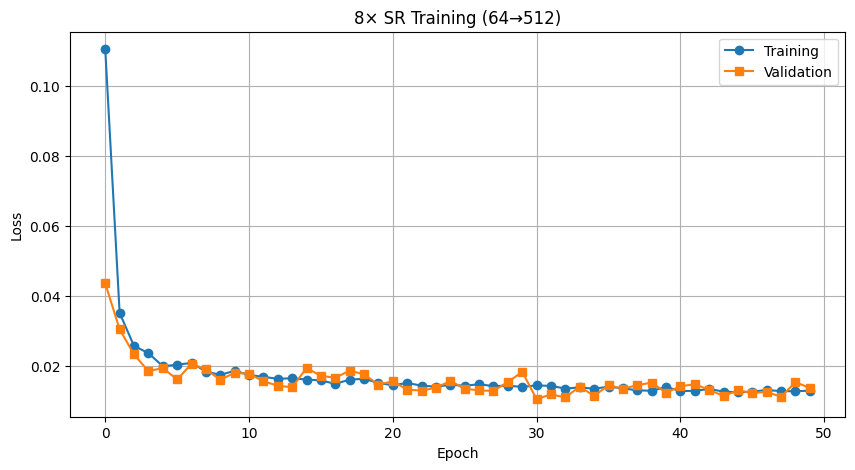

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training', marker='o')
plt.plot(history['val_loss'], label='Validation', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{SCALE_FACTOR}× SR Training ({LR_PATCH_SIZE}→{HR_PATCH_SIZE})')
plt.legend()
plt.grid(True)
plt.savefig(CHECKPOINT_DIR / 'curve.png', dpi=150)
plt.show()

## 12. 训练总结报告

### 总结内容

生成完整的训练总结，包括：

#### 配置信息
- Patch大小和缩放倍数
- Batch size和梯度累积配置
- 模型通道数和参数量

#### 显存统计
- 训练过程中的峰值显存占用
- 用于评估是否可以进一步增加batch size或模型大小

#### 训练结果
- 最佳验证损失
- 总训练轮数
- 模型保存路径

### 文件输出

总结报告会：
1. 打印到控制台
2. 保存为文本文件: `checkpoints_debug/summary.txt`

### 后续步骤

训练完成后：

1. **加载最佳模型**
```python
checkpoint = torch.load('checkpoints_debug/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
```

2. **推理测试**
- 使用滑动窗口将256×256图像超分辨率到2048×2048
- 再用bicubic插值放大到4096×4096

3. **质量评估**
- 计算PSNR, SSIM指标
- 与bicubic/其他方法对比

In [13]:
_, _, peak_memory = print_gpu_memory("训练结束")

summary = f"""
训练总结
{'='*60}

配置:
  Patch: {LR_PATCH_SIZE}×{LR_PATCH_SIZE} → {HR_PATCH_SIZE}×{HR_PATCH_SIZE} ({SCALE_FACTOR}×)
  Batch size: {BATCH_SIZE}
  梯度累积: {GRADIENT_ACCUMULATION}
  有效batch: {BATCH_SIZE * GRADIENT_ACCUMULATION}
  基础通道: {BASE_CHANNELS}
  模型参数: {sum(p.numel() for p in model.parameters()):,}

显存使用:
  峰值显存: {peak_memory:.2f} GB

结果:
  最佳验证损失: {best_val_loss:.6f}
  总训练轮数: {len(history['train_loss'])}

模型保存: {CHECKPOINT_DIR / 'best_model.pth'}
"""

print(summary)

with open(CHECKPOINT_DIR / 'summary.txt', 'w') as f:
    f.write(summary)

[训练结束] GPU显存: 已分配=0.00GB, 保留=0.01GB, 峰值=0.67GB

训练总结

配置:
  Patch: 64×64 → 512×512 (8×)
  Batch size: 8
  梯度累积: 2
  有效batch: 16
  基础通道: 24
  模型参数: 327,915

显存使用:
  峰值显存: 0.67 GB

结果:
  最佳验证损失: 0.010361
  总训练轮数: 50

模型保存: checkpoints_debug/best_model.pth

